In [1]:
import torch
from src.checkpoint import Checkpoint

experiment = Checkpoint.load("../experiments/TDVAE40_migrate/migration/2023-09-23__16-22/migrated_checkpoint.pth")
model = experiment.get_model().to("mps")

In [2]:
from src.hvae.model import compute_loss

target_block = "y"

kl_scaler = 0

def operation_target(x):
    computed, distributions = model(x, use_mean=True)
    return computed[target_block]

def operation(target_unit):
    def op(x):
        #x.to("cpu")
        computed, distributions = model(x, use_mean=True)
        losses = compute_loss(x, distributions)
        target = computed[target_block]
        from torchviz import make_dot
        make_dot(target).render("target_image", format="png")
        to_query = torch.flatten(target, start_dim=1)
        to_add = -losses["kl_div"] * kl_scaler
        loss = torch.mean(to_query[:, target_unit], dim=0) + to_add
        return loss
    return op

In [3]:
from meitorch.mei import MEI

In [4]:
#receptive_fields = MEI.white_noise_analysis(operation=operation_target, shape=(1, 40, 40), n_samples=1_000_000, sigma=0.1)

In [5]:
texture_dims = [110]#[91, 86, 110, 11, 225]
non_texture_dims = [214]#[214, 163, 223, 10, 219]

In [6]:
from matplotlib.pyplot import figure, savefig
import numpy as np

def plot_wna(units, save=None):
    fig = figure(figsize=(10, 3))
    for n, i in enumerate(units):
        ax = fig.add_subplot(1, 5, n + 1)
        ax.imshow(receptive_fields[i, ...].reshape(40, 40))
        ax.set_title(f"Unit {i}")
        ax.axis("off")
    if save:
        savefig(save)

#plot_wna(texture_dims, save="y_textutre_decoding_wna.png")
#plot_wna(non_texture_dims, save="y_non_textutre_encoding_wna.png")
#np.save("y_receptive_fields_1m.npy", receptive_fields)

In [7]:
from meitorch.tools.schedules import LinearSchedule

In [8]:
def run_image_config(config, save=None):

    texture_meis = []
    non_texture_meis = []
    for dim in texture_dims:
        texture_meis.append(MEI(operation=operation(dim), shape=(1, 40, 40), device="mps"))
    for dim in non_texture_dims:
        non_texture_meis.append(MEI(operation=operation(dim), shape=(1, 40, 40), device="mps"))

    texture_results = []
    non_texture_results = []

    for mei in texture_meis:
        texture_results.append(mei.generate_image_based(**config))
    for mei in non_texture_meis:
        non_texture_results.append(mei.generate_image_based(**config))

    plot_meis(texture_results, texture_dims, save=f"y_texture_decoding_{save}.png" if save else None)
    plot_meis(non_texture_results, non_texture_dims, save=f"y_non_texture_decoding_{save}.png" if save else None)
    return texture_results, non_texture_results

In [9]:
image_mei_config = dict(
    iter_n=1000,
    n_samples=1, # number of samples per batch
    save_every=100,        # save image every n iterations
    bias=0,               # bias of the image
    scale=1,              # scaling of the image
    diverse=False,
    diverse_params=dict(),

    #transformations
    scaler=None,              # scaling of the image (float or schedule)
    jitter=2,             # size of translational jittering

    #normalization/clipping
    train_norm=None,        # norm adjustment during step
    norm=None,              # norm adjustment after step
    clip=None,

    #optmizer
    optimizer="mei",
    optimizer_params=dict(
        lr=0.01,        # scaling of gradient steps (float or schedule) = learning rate
        step_size=LinearSchedule(2, 0.125)
    ),

    #preconditioning
    precond=None,            # strength of gradient preconditioning filter falloff (float or schedule)

    #denoiser
    denoiser='gaussian',
    denoiser_params=dict(
        sigma=LinearSchedule(1, 0.01)
        #reguralization_scaler=0.1,
        #lr=0.1,
        #num_iters=100,
    ),
)

In [10]:
texture_results, non_texture_results = run_image_config(image_mei_config, save="01_1000_kl_05")

  1%|          | 8/1000 [00:02<04:22,  3.79it/s]


KeyboardInterrupt: 

In [10]:
from matplotlib.pyplot import figure, savefig
import numpy as np

def plot_meis(meis, units, save=None):
    fig = figure(figsize=(10, 3))
    for n, (mei, i) in enumerate(zip(meis, units)):
        ax = fig.add_subplot(1, 5, n + 1)
        image = mei.get_image()[0].detach().cpu().numpy()
        ax.imshow(image.reshape(40, 40))
        ax.set_title(f"Unit {i}")
        ax.axis("off")
    if save:
        savefig(save)

#plot_meis(texture_results, texture_dims, save="y_texture_decoding_mei.png")
#plot_meis(non_texture_results, non_texture_dims, save="y_non_texture_decoding_mei.png")

In [11]:
def run_var_config(config, save=None):

    texture_meis = []
    non_texture_meis = []
    for dim in texture_dims:
        texture_meis.append(MEI(operation=operation(dim), shape=(1, 40, 40), device="mps"))
    for dim in non_texture_dims:
        non_texture_meis.append(MEI(operation=operation(dim), shape=(1, 40, 40), device="mps"))

    texture_results = []
    non_texture_results = []

    for mei in texture_meis:
        texture_results.append(mei.generate_variational(**config))
    for mei in non_texture_meis:
        non_texture_results.append(mei.generate_variational(**config))

    plot_meis(texture_results, texture_dims, save=f"y_texture_decoding_{save}.png" if save else None)
    plot_meis(non_texture_results, non_texture_dims, save=f"y_non_texture_decoding_{save}.png" if save else None)
    return texture_results, non_texture_results

In [12]:
var_mei_config = dict(
    iter_n=500,
    save_every=100,        # save image every n iterations
    bias=0,               # bias of the image
    scale=1,              # scaling of the image
    diverse=False,
    diverse_params=dict(),

    #transformations
    scaler=None,              # scaling of the image (float or schedule)
    jitter=None,             # size of translational jittering

    #normalization/clipping
    train_norm=None,        # norm adjustment during step
    norm=None,              # norm adjustment after step
    clip=None,

    #optmizer
    optimizer="mei",
    optimizer_params=dict(
        lr=0.01,        # scaling of gradient steps (float or schedule) = learning rate
        #step_size=LinearSchedule(2, 0.125)
    ),

    #preconditioning
    precond=True,            # strength of gradient preconditioning filter falloff (float or schedule)

    #denoiser
    denoiser=None,
    denoiser_params=dict(
        sigma=LinearSchedule(1, 0.01)
        #reguralization_scaler=0.1,
        #lr=0.1,
        #num_iters=100,
    ),

    #variational
    distribution='normal',
    n_samples_per_batch=(128,),
    fixed_stddev=0.4,
    fix_stddev=0.4,
)

  0%|          | 0/500 [00:00<?, ?it/s]/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)


None
Parameter containing:
tensor([[[ 0.0624, -0.0359, -0.0522,  ...,  0.0113,  0.0881, -0.0016],
         [ 0.0695, -0.0375,  0.1053,  ..., -0.0049,  0.0302,  0.0048],
         [-0.0380, -0.0383, -0.0241,  ...,  0.0057, -0.0227, -0.0101],
         ...,
         [ 0.0009,  0.0755, -0.0646,  ...,  0.0281,  0.0964,  0.1068],
         [ 0.0245, -0.0139, -0.0354,  ..., -0.0224, -0.0617,  0.0535],
         [-0.0005,  0.0429, -0.0075,  ..., -0.0085,  0.0579,  0.0397]]],
       device='mps:0', requires_grad=True) tensor([[[-1.8963e-02, -6.4946e-03, -2.5920e-02,  ..., -2.3809e-02,
           6.0584e-03, -3.4115e-02],
         [-1.3517e-02, -3.1732e-02,  1.8527e-02,  ...,  6.2694e-05,
          -4.1373e-02,  4.6683e-03],
         [-1.7664e-02, -8.7950e-03, -2.2453e-02,  ..., -1.3658e-02,
          -4.9483e-03, -2.5471e-02],
         ...,
         [-1.5071e-02,  1.7762e-03, -4.1883e-02,  ..., -1.3765e-02,
          -1.9017e-02, -1.1588e-02],
         [-1.8068e-02, -2.3120e-02, -1.1182e-02,  ...,

  0%|          | 1/500 [00:00<07:51,  1.06it/s]/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  0%|          | 2/500 [00:01<04:33,  1.82it/s]

None
Parameter containing:
tensor([[[ 0.0608, -0.0365, -0.0544,  ...,  0.0092,  0.0886, -0.0045],
         [ 0.0683, -0.0402,  0.1069,  ..., -0.0049,  0.0266,  0.0052],
         [-0.0395, -0.0390, -0.0260,  ...,  0.0046, -0.0231, -0.0122],
         ...,
         [-0.0004,  0.0756, -0.0682,  ...,  0.0269,  0.0948,  0.1058],
         [ 0.0229, -0.0159, -0.0363,  ..., -0.0243, -0.0617,  0.0511],
         [-0.0018,  0.0412, -0.0084,  ..., -0.0090,  0.0557,  0.0379]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0185, -0.0034, -0.0311,  ..., -0.0313,  0.0040, -0.0432],
         [-0.0066, -0.0257,  0.0252,  ...,  0.0001, -0.0528,  0.0016],
         [-0.0167, -0.0003, -0.0221,  ..., -0.0113, -0.0030, -0.0339],
         ...,
         [-0.0148,  0.0034, -0.0465,  ..., -0.0063, -0.0177, -0.0118],
         [-0.0195, -0.0269, -0.0058,  ..., -0.0253,  0.0001, -0.0268],
         [-0.0124, -0.0151, -0.0104,  ..., -0.0025, -0.0252, -0.0163]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  1%|          | 3/500 [00:01<03:25,  2.42it/s]

None
Parameter containing:
tensor([[[ 0.0593, -0.0367, -0.0569,  ...,  0.0067,  0.0889, -0.0080],
         [ 0.0678, -0.0422,  0.1089,  ..., -0.0049,  0.0224,  0.0054],
         [-0.0408, -0.0390, -0.0277,  ...,  0.0037, -0.0234, -0.0150],
         ...,
         [-0.0015,  0.0759, -0.0719,  ...,  0.0264,  0.0933,  0.1049],
         [ 0.0214, -0.0181, -0.0368,  ..., -0.0264, -0.0617,  0.0490],
         [-0.0028,  0.0400, -0.0093,  ..., -0.0092,  0.0536,  0.0365]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0203, -0.0075, -0.0374,  ..., -0.0393,  0.0072, -0.0472],
         [-0.0090, -0.0327,  0.0254,  ...,  0.0081, -0.0672,  0.0070],
         [-0.0159,  0.0025, -0.0254,  ..., -0.0125,  0.0010, -0.0373],
         ...,
         [-0.0204,  0.0120, -0.0558,  ..., -0.0086, -0.0244, -0.0069],
         [-0.0194, -0.0389, -0.0081,  ..., -0.0351, -0.0016, -0.0286],
         [-0.0133, -0.0199, -0.0191,  ..., -0.0055, -0.0349, -0.0230]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  1%|          | 4/500 [00:01<02:49,  2.93it/s]

None
Parameter containing:
tensor([[[ 0.0580, -0.0372, -0.0594,  ...,  0.0041,  0.0894, -0.0111],
         [ 0.0672, -0.0444,  0.1106,  ..., -0.0044,  0.0180,  0.0058],
         [-0.0419, -0.0389, -0.0294,  ...,  0.0029, -0.0233, -0.0174],
         ...,
         [-0.0029,  0.0767, -0.0756,  ...,  0.0259,  0.0917,  0.1044],
         [ 0.0201, -0.0206, -0.0373,  ..., -0.0287, -0.0618,  0.0471],
         [-0.0036,  0.0387, -0.0105,  ..., -0.0096,  0.0513,  0.0350]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0222, -0.0105, -0.0305,  ..., -0.0359,  0.0005, -0.0385],
         [-0.0157, -0.0297,  0.0130,  ..., -0.0035, -0.0568,  0.0012],
         [-0.0182, -0.0089, -0.0278,  ..., -0.0154, -0.0056, -0.0300],
         ...,
         [-0.0190,  0.0045, -0.0394,  ..., -0.0066, -0.0209, -0.0095],
         [-0.0216, -0.0285, -0.0136,  ..., -0.0195, -0.0030, -0.0223],
         [-0.0108, -0.0199, -0.0150,  ..., -0.0083, -0.0272, -0.0262]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  1%|          | 5/500 [00:01<02:28,  3.34it/s]

None
Parameter containing:
tensor([[[ 0.0563, -0.0381, -0.0618,  ...,  0.0013,  0.0894, -0.0141],
         [ 0.0660, -0.0467,  0.1116,  ..., -0.0046,  0.0135,  0.0059],
         [-0.0433, -0.0396, -0.0316,  ...,  0.0016, -0.0237, -0.0198],
         ...,
         [-0.0044,  0.0770, -0.0787,  ...,  0.0253,  0.0901,  0.1037],
         [ 0.0184, -0.0229, -0.0384,  ..., -0.0302, -0.0621,  0.0453],
         [-0.0045,  0.0371, -0.0117,  ..., -0.0102,  0.0492,  0.0330]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0226, -0.0118, -0.0321,  ..., -0.0362,  0.0023, -0.0526],
         [-0.0098, -0.0282,  0.0221,  ..., -0.0012, -0.0640, -0.0044],
         [-0.0161, -0.0075, -0.0190,  ..., -0.0152, -0.0024, -0.0369],
         ...,
         [-0.0198,  0.0063, -0.0392,  ..., -0.0080, -0.0208, -0.0045],
         [-0.0169, -0.0323, -0.0103,  ..., -0.0279, -0.0052, -0.0222],
         [-0.0146, -0.0204, -0.0163,  ..., -0.0059, -0.0266, -0.0201]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  1%|          | 6/500 [00:02<02:15,  3.64it/s]

None
Parameter containing:
tensor([[[ 0.0546, -0.0389, -0.0642,  ..., -0.0014,  0.0896, -0.0180],
         [ 0.0653, -0.0488,  0.1133,  ..., -0.0047,  0.0087,  0.0056],
         [-0.0445, -0.0401, -0.0330,  ...,  0.0005, -0.0239, -0.0225],
         ...,
         [-0.0059,  0.0775, -0.0816,  ...,  0.0248,  0.0885,  0.1033],
         [ 0.0171, -0.0253, -0.0391,  ..., -0.0323, -0.0624,  0.0437],
         [-0.0056,  0.0356, -0.0129,  ..., -0.0107,  0.0472,  0.0315]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0228, -0.0104, -0.0336,  ..., -0.0293,  0.0018, -0.0360],
         [-0.0150, -0.0358,  0.0138,  ...,  0.0007, -0.0479, -0.0013],
         [-0.0202, -0.0078, -0.0277,  ..., -0.0145, -0.0115, -0.0259],
         ...,
         [-0.0189,  0.0001, -0.0369,  ..., -0.0053, -0.0260, -0.0155],
         [-0.0231, -0.0226, -0.0070,  ..., -0.0191, -0.0094, -0.0204],
         [-0.0143, -0.0235, -0.0107,  ..., -0.0066, -0.0270, -0.0224]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  1%|▏         | 7/500 [00:02<02:07,  3.88it/s]

None
Parameter containing:
tensor([[[ 0.0527, -0.0398, -0.0670,  ..., -0.0038,  0.0898, -0.0211],
         [ 0.0640, -0.0518,  0.1144,  ..., -0.0047,  0.0047,  0.0055],
         [-0.0462, -0.0408, -0.0353,  ..., -0.0007, -0.0249, -0.0247],
         ...,
         [-0.0075,  0.0775, -0.0847,  ...,  0.0243,  0.0864,  0.1020],
         [ 0.0152, -0.0272, -0.0397,  ..., -0.0339, -0.0632,  0.0420],
         [-0.0068,  0.0336, -0.0138,  ..., -0.0112,  0.0449,  0.0296]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0221, -0.0132, -0.0307,  ..., -0.0265, -0.0028, -0.0318],
         [-0.0136, -0.0274,  0.0061,  ..., -0.0134, -0.0382, -0.0050],
         [-0.0175, -0.0080, -0.0257,  ..., -0.0106, -0.0117, -0.0223],
         ...,
         [-0.0172, -0.0037, -0.0323,  ..., -0.0135, -0.0207, -0.0210],
         [-0.0246, -0.0232, -0.0158,  ..., -0.0216, -0.0070, -0.0199],
         [-0.0135, -0.0217, -0.0141,  ..., -0.0149, -0.0266, -0.0240]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  2%|▏         | 8/500 [00:02<02:02,  4.03it/s]

None
Parameter containing:
tensor([[[ 0.0507, -0.0410, -0.0697,  ..., -0.0061,  0.0895, -0.0238],
         [ 0.0628, -0.0542,  0.1150,  ..., -0.0058,  0.0014,  0.0050],
         [-0.0477, -0.0415, -0.0376,  ..., -0.0016, -0.0259, -0.0266],
         ...,
         [-0.0089,  0.0772, -0.0875,  ...,  0.0231,  0.0846,  0.1002],
         [ 0.0131, -0.0292, -0.0411,  ..., -0.0358, -0.0638,  0.0402],
         [-0.0079,  0.0318, -0.0150,  ..., -0.0125,  0.0426,  0.0275]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0208, -0.0118, -0.0308,  ..., -0.0340, -0.0037, -0.0423],
         [-0.0153, -0.0312,  0.0149,  ..., -0.0014, -0.0511, -0.0037],
         [-0.0189, -0.0109, -0.0252,  ..., -0.0184, -0.0102, -0.0341],
         ...,
         [-0.0197,  0.0003, -0.0348,  ..., -0.0123, -0.0251, -0.0143],
         [-0.0152, -0.0226, -0.0164,  ..., -0.0267, -0.0050, -0.0236],
         [-0.0100, -0.0202, -0.0157,  ..., -0.0134, -0.0308, -0.0250]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  2%|▏         | 9/500 [00:02<01:57,  4.16it/s]

None
Parameter containing:
tensor([[[ 0.0491, -0.0419, -0.0721,  ..., -0.0088,  0.0892, -0.0271],
         [ 0.0616, -0.0566,  0.1161,  ..., -0.0059, -0.0026,  0.0048],
         [-0.0492, -0.0423, -0.0395,  ..., -0.0031, -0.0267, -0.0293],
         ...,
         [-0.0105,  0.0772, -0.0902,  ...,  0.0222,  0.0826,  0.0991],
         [ 0.0119, -0.0309, -0.0424,  ..., -0.0378, -0.0642,  0.0384],
         [-0.0087,  0.0302, -0.0162,  ..., -0.0136,  0.0402,  0.0256]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0148, -0.0003, -0.0425,  ..., -0.0365,  0.0170, -0.0580],
         [-0.0116, -0.0293,  0.0309,  ...,  0.0246, -0.0766,  0.0147],
         [-0.0111, -0.0010, -0.0356,  ..., -0.0185,  0.0047, -0.0409],
         ...,
         [-0.0285,  0.0270, -0.0532,  ..., -0.0082, -0.0274, -0.0106],
         [-0.0152, -0.0350, -0.0020,  ..., -0.0362, -0.0030, -0.0391],
         [-0.0156, -0.0180, -0.0116,  ...,  0.0015, -0.0381, -0.0239]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  2%|▏         | 10/500 [00:03<01:55,  4.24it/s]

None
Parameter containing:
tensor([[[ 0.0483, -0.0419, -0.0745,  ..., -0.0108,  0.0902, -0.0304],
         [ 0.0610, -0.0583,  0.1179,  ..., -0.0046, -0.0069,  0.0056],
         [-0.0498, -0.0424, -0.0415,  ..., -0.0041, -0.0264, -0.0316],
         ...,
         [-0.0121,  0.0788, -0.0932,  ...,  0.0217,  0.0811,  0.0985],
         [ 0.0110, -0.0329, -0.0425,  ..., -0.0399, -0.0644,  0.0362],
         [-0.0096,  0.0292, -0.0169,  ..., -0.0135,  0.0381,  0.0242]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0237, -0.0131, -0.0300,  ..., -0.0294, -0.0079, -0.0334],
         [-0.0189, -0.0295,  0.0021,  ..., -0.0065, -0.0371, -0.0149],
         [-0.0222, -0.0143, -0.0241,  ..., -0.0164, -0.0138, -0.0228],
         ...,
         [-0.0220, -0.0088, -0.0234,  ..., -0.0067, -0.0253, -0.0204],
         [-0.0217, -0.0179, -0.0223,  ..., -0.0226, -0.0162, -0.0220],
         [-0.0194, -0.0210, -0.0151,  ..., -0.0148, -0.0271, -0.0291]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  2%|▏         | 11/500 [00:03<01:54,  4.26it/s]

None
Parameter containing:
tensor([[[ 0.0464, -0.0430, -0.0769,  ..., -0.0132,  0.0896, -0.0331],
         [ 0.0594, -0.0606,  0.1180,  ..., -0.0051, -0.0099,  0.0044],
         [-0.0516, -0.0435, -0.0435,  ..., -0.0054, -0.0275, -0.0334],
         ...,
         [-0.0139,  0.0780, -0.0951,  ...,  0.0212,  0.0790,  0.0969],
         [ 0.0093, -0.0344, -0.0443,  ..., -0.0417, -0.0657,  0.0344],
         [-0.0112,  0.0275, -0.0181,  ..., -0.0147,  0.0359,  0.0219]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0239, -0.0132, -0.0425,  ..., -0.0419,  0.0104, -0.0496],
         [-0.0192, -0.0372,  0.0189,  ...,  0.0116, -0.0649,  0.0035],
         [-0.0180, -0.0044, -0.0323,  ..., -0.0233, -0.0007, -0.0311],
         ...,
         [-0.0266,  0.0179, -0.0443,  ..., -0.0090, -0.0240, -0.0110],
         [-0.0158, -0.0385, -0.0071,  ..., -0.0315, -0.0059, -0.0372],
         [-0.0234, -0.0250, -0.0150,  ..., -0.0161, -0.0366, -0.0340]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  2%|▏         | 12/500 [00:03<01:52,  4.32it/s]

None
Parameter containing:
tensor([[[ 0.0448, -0.0438, -0.0797,  ..., -0.0159,  0.0902, -0.0363],
         [ 0.0582, -0.0631,  0.1193,  ..., -0.0043, -0.0141,  0.0046],
         [-0.0528, -0.0438, -0.0456,  ..., -0.0070, -0.0276, -0.0355],
         ...,
         [-0.0156,  0.0792, -0.0980,  ...,  0.0206,  0.0775,  0.0962],
         [ 0.0082, -0.0369, -0.0448,  ..., -0.0438, -0.0661,  0.0320],
         [-0.0127,  0.0259, -0.0191,  ..., -0.0157,  0.0335,  0.0196]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0198, -0.0132, -0.0304,  ..., -0.0297, -0.0034, -0.0332],
         [-0.0191, -0.0326,  0.0039,  ..., -0.0045, -0.0417, -0.0081],
         [-0.0193, -0.0135, -0.0274,  ..., -0.0153, -0.0128, -0.0221],
         ...,
         [-0.0225, -0.0007, -0.0286,  ..., -0.0072, -0.0239, -0.0155],
         [-0.0211, -0.0228, -0.0184,  ..., -0.0192, -0.0114, -0.0224],
         [-0.0174, -0.0209, -0.0171,  ..., -0.0121, -0.0289, -0.0302]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  3%|▎         | 13/500 [00:03<01:54,  4.26it/s]

None
Parameter containing:
tensor([[[ 0.0432, -0.0449, -0.0822,  ..., -0.0184,  0.0900, -0.0390],
         [ 0.0566, -0.0657,  0.1196,  ..., -0.0047, -0.0175,  0.0039],
         [-0.0544, -0.0449, -0.0478,  ..., -0.0082, -0.0286, -0.0373],
         ...,
         [-0.0174,  0.0792, -0.1004,  ...,  0.0200,  0.0755,  0.0949],
         [ 0.0065, -0.0387, -0.0463,  ..., -0.0453, -0.0670,  0.0302],
         [-0.0141,  0.0241, -0.0205,  ..., -0.0167,  0.0311,  0.0172]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0216, -0.0127, -0.0306,  ..., -0.0249, -0.0105, -0.0264],
         [-0.0170, -0.0288, -0.0032,  ..., -0.0112, -0.0303, -0.0183],
         [-0.0238, -0.0115, -0.0224,  ..., -0.0142, -0.0184, -0.0207],
         ...,
         [-0.0174, -0.0098, -0.0225,  ..., -0.0063, -0.0182, -0.0212],
         [-0.0246, -0.0143, -0.0220,  ..., -0.0169, -0.0140, -0.0171],
         [-0.0178, -0.0248, -0.0153,  ..., -0.0131, -0.0242, -0.0293]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  3%|▎         | 14/500 [00:03<01:52,  4.32it/s]

None
Parameter containing:
tensor([[[ 0.0414, -0.0460, -0.0847,  ..., -0.0205,  0.0891, -0.0413],
         [ 0.0552, -0.0682,  0.1193,  ..., -0.0056, -0.0201,  0.0024],
         [-0.0564, -0.0459, -0.0497,  ..., -0.0094, -0.0302, -0.0390],
         ...,
         [-0.0189,  0.0783, -0.1023,  ...,  0.0195,  0.0740,  0.0931],
         [ 0.0044, -0.0400, -0.0481,  ..., -0.0468, -0.0682,  0.0287],
         [-0.0156,  0.0221, -0.0218,  ..., -0.0178,  0.0291,  0.0147]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0226, -0.0141, -0.0323,  ..., -0.0335, -0.0009, -0.0401],
         [-0.0191, -0.0301,  0.0015,  ..., -0.0038, -0.0496, -0.0070],
         [-0.0218, -0.0194, -0.0295,  ..., -0.0220, -0.0029, -0.0291],
         ...,
         [-0.0213, -0.0003, -0.0327,  ..., -0.0069, -0.0262, -0.0214],
         [-0.0185, -0.0260, -0.0201,  ..., -0.0253, -0.0081, -0.0234],
         [-0.0181, -0.0242, -0.0178,  ..., -0.0128, -0.0262, -0.0231]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  3%|▎         | 15/500 [00:04<01:52,  4.31it/s]

None
Parameter containing:
tensor([[[ 0.0397, -0.0470, -0.0872,  ..., -0.0230,  0.0890, -0.0443],
         [ 0.0537, -0.0705,  0.1194,  ..., -0.0059, -0.0239,  0.0019],
         [-0.0580, -0.0474, -0.0520,  ..., -0.0111, -0.0304, -0.0413],
         ...,
         [-0.0205,  0.0783, -0.1048,  ...,  0.0189,  0.0720,  0.0915],
         [ 0.0030, -0.0419, -0.0497,  ..., -0.0487, -0.0688,  0.0269],
         [-0.0170,  0.0202, -0.0231,  ..., -0.0188,  0.0271,  0.0129]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0179, -0.0130, -0.0291,  ..., -0.0292, -0.0071, -0.0347],
         [-0.0153, -0.0304,  0.0030,  ..., -0.0069, -0.0365, -0.0155],
         [-0.0224, -0.0118, -0.0227,  ..., -0.0146, -0.0152, -0.0250],
         ...,
         [-0.0211, -0.0073, -0.0286,  ..., -0.0069, -0.0237, -0.0228],
         [-0.0236, -0.0206, -0.0178,  ..., -0.0207, -0.0109, -0.0185],
         [-0.0158, -0.0227, -0.0129,  ..., -0.0088, -0.0267, -0.0254]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  3%|▎         | 16/500 [00:04<01:51,  4.34it/s]

None
Parameter containing:
tensor([[[ 0.0382, -0.0481, -0.0896,  ..., -0.0254,  0.0884, -0.0472],
         [ 0.0525, -0.0730,  0.1197,  ..., -0.0065, -0.0269,  0.0006],
         [-0.0599, -0.0483, -0.0538,  ..., -0.0123, -0.0316, -0.0433],
         ...,
         [-0.0223,  0.0777, -0.1071,  ...,  0.0184,  0.0700,  0.0896],
         [ 0.0011, -0.0436, -0.0511,  ..., -0.0504, -0.0697,  0.0254],
         [-0.0183,  0.0183, -0.0242,  ..., -0.0195,  0.0249,  0.0108]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0190, -0.0138, -0.0291,  ..., -0.0255,  0.0066, -0.0346],
         [-0.0176, -0.0300,  0.0040,  ..., -0.0017, -0.0408, -0.0054],
         [-0.0189, -0.0140, -0.0245,  ..., -0.0117, -0.0092, -0.0230],
         ...,
         [-0.0280, -0.0011, -0.0339,  ..., -0.0074, -0.0279, -0.0135],
         [-0.0255, -0.0248, -0.0212,  ..., -0.0219, -0.0087, -0.0279],
         [-0.0230, -0.0211, -0.0191,  ..., -0.0168, -0.0284, -0.0287]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  3%|▎         | 17/500 [00:04<01:50,  4.39it/s]

None
Parameter containing:
tensor([[[ 0.0366, -0.0492, -0.0920,  ..., -0.0275,  0.0890, -0.0500],
         [ 0.0510, -0.0754,  0.1200,  ..., -0.0066, -0.0302,  0.0002],
         [-0.0614, -0.0495, -0.0558,  ..., -0.0133, -0.0324, -0.0452],
         ...,
         [-0.0246,  0.0776, -0.1099,  ...,  0.0178,  0.0677,  0.0885],
         [-0.0010, -0.0457, -0.0528,  ..., -0.0522, -0.0704,  0.0231],
         [-0.0202,  0.0166, -0.0258,  ..., -0.0209,  0.0226,  0.0085]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0217, -0.0152, -0.0301,  ..., -0.0383, -0.0002, -0.0391],
         [-0.0139, -0.0295,  0.0084,  ..., -0.0077, -0.0426, -0.0120],
         [-0.0214, -0.0092, -0.0249,  ..., -0.0186, -0.0120, -0.0266],
         ...,
         [-0.0234, -0.0008, -0.0321,  ..., -0.0055, -0.0252, -0.0160],
         [-0.0202, -0.0298, -0.0184,  ..., -0.0215, -0.0143, -0.0177],
         [-0.0128, -0.0199, -0.0143,  ..., -0.0119, -0.0267, -0.0289]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  4%|▎         | 18/500 [00:04<01:49,  4.38it/s]

None
Parameter containing:
tensor([[[ 0.0349, -0.0504, -0.0944,  ..., -0.0306,  0.0889, -0.0531],
         [ 0.0499, -0.0778,  0.1207,  ..., -0.0073, -0.0336, -0.0008],
         [-0.0631, -0.0502, -0.0578,  ..., -0.0147, -0.0334, -0.0473],
         ...,
         [-0.0264,  0.0775, -0.1124,  ...,  0.0173,  0.0657,  0.0872],
         [-0.0026, -0.0480, -0.0543,  ..., -0.0539, -0.0716,  0.0217],
         [-0.0212,  0.0150, -0.0269,  ..., -0.0218,  0.0205,  0.0062]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0193, -0.0163, -0.0258,  ..., -0.0313, -0.0034, -0.0272],
         [-0.0215, -0.0330,  0.0032,  ..., -0.0074, -0.0312, -0.0151],
         [-0.0237, -0.0139, -0.0245,  ..., -0.0161, -0.0164, -0.0203],
         ...,
         [-0.0218, -0.0070, -0.0217,  ..., -0.0063, -0.0230, -0.0195],
         [-0.0205, -0.0206, -0.0211,  ..., -0.0200, -0.0204, -0.0190],
         [-0.0201, -0.0224, -0.0162,  ..., -0.0079, -0.0263, -0.0267]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  4%|▍         | 19/500 [00:05<01:49,  4.40it/s]

None
Parameter containing:
tensor([[[ 0.0333, -0.0518, -0.0965,  ..., -0.0331,  0.0887, -0.0553],
         [ 0.0482, -0.0804,  0.1209,  ..., -0.0079, -0.0361, -0.0020],
         [-0.0650, -0.0513, -0.0598,  ..., -0.0160, -0.0347, -0.0489],
         ...,
         [-0.0282,  0.0770, -0.1142,  ...,  0.0168,  0.0639,  0.0856],
         [-0.0043, -0.0497, -0.0560,  ..., -0.0555, -0.0732,  0.0202],
         [-0.0228,  0.0132, -0.0282,  ..., -0.0225,  0.0183,  0.0040]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0208, -0.0162, -0.0274,  ..., -0.0252, -0.0144, -0.0258],
         [-0.0206, -0.0281, -0.0077,  ..., -0.0156, -0.0255, -0.0222],
         [-0.0235, -0.0153, -0.0233,  ..., -0.0145, -0.0237, -0.0197],
         ...,
         [-0.0181, -0.0137, -0.0134,  ..., -0.0074, -0.0204, -0.0233],
         [-0.0226, -0.0164, -0.0254,  ..., -0.0173, -0.0200, -0.0175],
         [-0.0193, -0.0235, -0.0152,  ..., -0.0152, -0.0215, -0.0294]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  4%|▍         | 20/500 [00:05<01:49,  4.40it/s]

None
Parameter containing:
tensor([[[ 0.0316, -0.0531, -0.0987,  ..., -0.0352,  0.0875, -0.0574],
         [ 0.0465, -0.0828,  0.1203,  ..., -0.0091, -0.0383, -0.0039],
         [-0.0670, -0.0526, -0.0617,  ..., -0.0172, -0.0367, -0.0506],
         ...,
         [-0.0297,  0.0758, -0.1153,  ...,  0.0162,  0.0622,  0.0837],
         [-0.0062, -0.0510, -0.0581,  ..., -0.0570, -0.0749,  0.0187],
         [-0.0244,  0.0113, -0.0295,  ..., -0.0238,  0.0165,  0.0016]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0208, -0.0145, -0.0265,  ..., -0.0265, -0.0095, -0.0276],
         [-0.0196, -0.0278, -0.0070,  ..., -0.0108, -0.0283, -0.0187],
         [-0.0235, -0.0145, -0.0256,  ..., -0.0152, -0.0178, -0.0206],
         ...,
         [-0.0215, -0.0098, -0.0187,  ..., -0.0067, -0.0218, -0.0219],
         [-0.0229, -0.0172, -0.0237,  ..., -0.0185, -0.0194, -0.0183],
         [-0.0190, -0.0222, -0.0141,  ..., -0.0142, -0.0239, -0.0309]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  4%|▍         | 21/500 [00:05<01:47,  4.44it/s]

None
Parameter containing:
tensor([[[ 0.0299, -0.0543, -0.1009,  ..., -0.0373,  0.0867, -0.0597],
         [ 0.0449, -0.0850,  0.1197,  ..., -0.0100, -0.0405, -0.0054],
         [-0.0689, -0.0538, -0.0638,  ..., -0.0185, -0.0381, -0.0522],
         ...,
         [-0.0314,  0.0751, -0.1168,  ...,  0.0157,  0.0604,  0.0819],
         [-0.0080, -0.0524, -0.0600,  ..., -0.0585, -0.0764,  0.0173],
         [-0.0259,  0.0095, -0.0306,  ..., -0.0249,  0.0146, -0.0009]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0194, -0.0135, -0.0292,  ..., -0.0250, -0.0104, -0.0290],
         [-0.0192, -0.0282, -0.0020,  ..., -0.0094, -0.0293, -0.0187],
         [-0.0214, -0.0136, -0.0227,  ..., -0.0166, -0.0185, -0.0206],
         ...,
         [-0.0205, -0.0075, -0.0208,  ..., -0.0083, -0.0210, -0.0222],
         [-0.0231, -0.0186, -0.0212,  ..., -0.0207, -0.0194, -0.0198],
         [-0.0211, -0.0200, -0.0159,  ..., -0.0115, -0.0229, -0.0262]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  4%|▍         | 22/500 [00:05<01:47,  4.44it/s]

None
Parameter containing:
tensor([[[ 0.0283, -0.0554, -0.1033,  ..., -0.0394,  0.0858, -0.0621],
         [ 0.0433, -0.0874,  0.1196,  ..., -0.0108, -0.0430, -0.0069],
         [-0.0707, -0.0549, -0.0657,  ..., -0.0199, -0.0397, -0.0540],
         ...,
         [-0.0331,  0.0744, -0.1186,  ...,  0.0150,  0.0587,  0.0801],
         [-0.0099, -0.0540, -0.0618,  ..., -0.0602, -0.0781,  0.0156],
         [-0.0277,  0.0078, -0.0319,  ..., -0.0259,  0.0127, -0.0031]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0203, -0.0144, -0.0265,  ..., -0.0292, -0.0106, -0.0293],
         [-0.0192, -0.0302,  0.0005,  ..., -0.0100, -0.0352, -0.0193],
         [-0.0189, -0.0128, -0.0236,  ..., -0.0182, -0.0186, -0.0215],
         ...,
         [-0.0200, -0.0076, -0.0194,  ..., -0.0040, -0.0241, -0.0235],
         [-0.0202, -0.0183, -0.0218,  ..., -0.0172, -0.0183, -0.0189],
         [-0.0202, -0.0202, -0.0192,  ..., -0.0198, -0.0271, -0.0308]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  5%|▍         | 23/500 [00:06<01:47,  4.44it/s]

None
Parameter containing:
tensor([[[ 0.0266, -0.0566, -0.1055,  ..., -0.0418,  0.0849, -0.0645],
         [ 0.0417, -0.0899,  0.1196,  ..., -0.0116, -0.0459, -0.0085],
         [-0.0722, -0.0560, -0.0677,  ..., -0.0214, -0.0412, -0.0557],
         ...,
         [-0.0348,  0.0738, -0.1202,  ...,  0.0147,  0.0567,  0.0781],
         [-0.0116, -0.0555, -0.0636,  ..., -0.0616, -0.0796,  0.0140],
         [-0.0294,  0.0061, -0.0335,  ..., -0.0275,  0.0105, -0.0056]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0203, -0.0162, -0.0262,  ..., -0.0242, -0.0143, -0.0250],
         [-0.0206, -0.0279, -0.0101,  ..., -0.0151, -0.0230, -0.0231],
         [-0.0230, -0.0147, -0.0239,  ..., -0.0152, -0.0225, -0.0165],
         ...,
         [-0.0208, -0.0137, -0.0149,  ..., -0.0082, -0.0196, -0.0244],
         [-0.0218, -0.0152, -0.0253,  ..., -0.0177, -0.0217, -0.0160],
         [-0.0188, -0.0225, -0.0167,  ..., -0.0159, -0.0221, -0.0292]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  5%|▍         | 24/500 [00:06<01:47,  4.41it/s]

None
Parameter containing:
tensor([[[ 0.0250, -0.0579, -0.1077,  ..., -0.0439,  0.0838, -0.0666],
         [ 0.0400, -0.0922,  0.1188,  ..., -0.0129, -0.0478, -0.0104],
         [-0.0741, -0.0572, -0.0696,  ..., -0.0226, -0.0430, -0.0571],
         ...,
         [-0.0365,  0.0727, -0.1214,  ...,  0.0140,  0.0551,  0.0761],
         [-0.0134, -0.0568, -0.0657,  ..., -0.0631, -0.0814,  0.0127],
         [-0.0309,  0.0043, -0.0349,  ..., -0.0288,  0.0086, -0.0080]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0203, -0.0170, -0.0318,  ..., -0.0276, -0.0101, -0.0322],
         [-0.0199, -0.0292,  0.0010,  ..., -0.0085, -0.0364, -0.0166],
         [-0.0216, -0.0131, -0.0267,  ..., -0.0188, -0.0198, -0.0213],
         ...,
         [-0.0214, -0.0068, -0.0207,  ..., -0.0041, -0.0240, -0.0191],
         [-0.0199, -0.0214, -0.0228,  ..., -0.0201, -0.0181, -0.0218],
         [-0.0202, -0.0204, -0.0152,  ..., -0.0126, -0.0260, -0.0283]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  5%|▌         | 25/500 [00:06<01:47,  4.41it/s]

None
Parameter containing:
tensor([[[ 0.0233, -0.0594, -0.1103,  ..., -0.0461,  0.0829, -0.0693],
         [ 0.0383, -0.0946,  0.1189,  ..., -0.0136, -0.0508, -0.0118],
         [-0.0759, -0.0583, -0.0719,  ..., -0.0242, -0.0447, -0.0589],
         ...,
         [-0.0383,  0.0721, -0.1231,  ...,  0.0136,  0.0531,  0.0745],
         [-0.0151, -0.0586, -0.0676,  ..., -0.0648, -0.0829,  0.0109],
         [-0.0326,  0.0026, -0.0362,  ..., -0.0299,  0.0065, -0.0104]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0188, -0.0147, -0.0265,  ..., -0.0232, -0.0144, -0.0242],
         [-0.0193, -0.0286, -0.0073,  ..., -0.0131, -0.0271, -0.0210],
         [-0.0235, -0.0151, -0.0218,  ..., -0.0141, -0.0235, -0.0183],
         ...,
         [-0.0179, -0.0123, -0.0154,  ..., -0.0083, -0.0214, -0.0237],
         [-0.0219, -0.0169, -0.0239,  ..., -0.0155, -0.0189, -0.0168],
         [-0.0188, -0.0241, -0.0146,  ..., -0.0158, -0.0227, -0.0289]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  5%|▌         | 26/500 [00:06<01:47,  4.42it/s]

None
Parameter containing:
tensor([[[ 0.0217, -0.0606, -0.1125,  ..., -0.0481,  0.0817, -0.0713],
         [ 0.0367, -0.0970,  0.1183,  ..., -0.0147, -0.0531, -0.0136],
         [-0.0779, -0.0596, -0.0737,  ..., -0.0254, -0.0467, -0.0604],
         ...,
         [-0.0398,  0.0711, -0.1244,  ...,  0.0129,  0.0513,  0.0725],
         [-0.0169, -0.0600, -0.0696,  ..., -0.0661, -0.0845,  0.0095],
         [-0.0342,  0.0005, -0.0374,  ..., -0.0312,  0.0046, -0.0128]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0199, -0.0137, -0.0265,  ..., -0.0214, -0.0106, -0.0245],
         [-0.0207, -0.0283, -0.0071,  ..., -0.0129, -0.0284, -0.0186],
         [-0.0212, -0.0131, -0.0231,  ..., -0.0155, -0.0187, -0.0209],
         ...,
         [-0.0191, -0.0069, -0.0162,  ..., -0.0092, -0.0190, -0.0235],
         [-0.0200, -0.0173, -0.0246,  ..., -0.0163, -0.0194, -0.0171],
         [-0.0186, -0.0223, -0.0165,  ..., -0.0145, -0.0239, -0.0286]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  5%|▌         | 27/500 [00:06<01:47,  4.39it/s]

None
Parameter containing:
tensor([[[ 0.0200, -0.0618, -0.1148,  ..., -0.0499,  0.0808, -0.0734],
         [ 0.0349, -0.0994,  0.1177,  ..., -0.0158, -0.0555, -0.0152],
         [-0.0797, -0.0607, -0.0757,  ..., -0.0267, -0.0483, -0.0622],
         ...,
         [-0.0414,  0.0705, -0.1258,  ...,  0.0122,  0.0497,  0.0705],
         [-0.0186, -0.0614, -0.0717,  ..., -0.0674, -0.0861,  0.0080],
         [-0.0358, -0.0013, -0.0388,  ..., -0.0324,  0.0025, -0.0152]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0177, -0.0138, -0.0234,  ..., -0.0215, -0.0167, -0.0219],
         [-0.0194, -0.0255, -0.0108,  ..., -0.0185, -0.0177, -0.0262],
         [-0.0233, -0.0152, -0.0198,  ..., -0.0127, -0.0255, -0.0159],
         ...,
         [-0.0182, -0.0180, -0.0127,  ..., -0.0085, -0.0185, -0.0251],
         [-0.0245, -0.0138, -0.0255,  ..., -0.0143, -0.0214, -0.0121],
         [-0.0193, -0.0230, -0.0141,  ..., -0.0167, -0.0200, -0.0285]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  6%|▌         | 28/500 [00:07<01:47,  4.39it/s]

None
Parameter containing:
tensor([[[ 0.0185, -0.0630, -0.1168,  ..., -0.0518,  0.0794, -0.0753],
         [ 0.0333, -0.1016,  0.1167,  ..., -0.0174, -0.0571, -0.0174],
         [-0.0817, -0.0620, -0.0774,  ..., -0.0278, -0.0505, -0.0636],
         ...,
         [-0.0430,  0.0689, -0.1269,  ...,  0.0114,  0.0481,  0.0684],
         [-0.0207, -0.0626, -0.0739,  ..., -0.0687, -0.0880,  0.0070],
         [-0.0375, -0.0033, -0.0400,  ..., -0.0339,  0.0008, -0.0177]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0151, -0.0131, -0.0250,  ..., -0.0221, -0.0097, -0.0260],
         [-0.0194, -0.0272, -0.0047,  ..., -0.0100, -0.0247, -0.0207],
         [-0.0223, -0.0134, -0.0230,  ..., -0.0140, -0.0203, -0.0191],
         ...,
         [-0.0196, -0.0116, -0.0184,  ..., -0.0093, -0.0216, -0.0227],
         [-0.0213, -0.0169, -0.0202,  ..., -0.0180, -0.0214, -0.0177],
         [-0.0197, -0.0221, -0.0157,  ..., -0.0139, -0.0223, -0.0264]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  6%|▌         | 29/500 [00:07<01:47,  4.36it/s]

None
Parameter containing:
tensor([[[ 0.0171, -0.0641, -0.1190,  ..., -0.0537,  0.0785, -0.0776],
         [ 0.0316, -0.1040,  0.1163,  ..., -0.0183, -0.0592, -0.0193],
         [-0.0837, -0.0632, -0.0794,  ..., -0.0290, -0.0522, -0.0652],
         ...,
         [-0.0447,  0.0679, -0.1285,  ...,  0.0106,  0.0461,  0.0664],
         [-0.0226, -0.0641, -0.0757,  ..., -0.0703, -0.0899,  0.0054],
         [-0.0392, -0.0053, -0.0414,  ..., -0.0351, -0.0012, -0.0200]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0179, -0.0145, -0.0240,  ..., -0.0200, -0.0170, -0.0216],
         [-0.0195, -0.0267, -0.0118,  ..., -0.0183, -0.0177, -0.0247],
         [-0.0221, -0.0142, -0.0205,  ..., -0.0124, -0.0239, -0.0156],
         ...,
         [-0.0198, -0.0166, -0.0140,  ..., -0.0072, -0.0177, -0.0256],
         [-0.0234, -0.0143, -0.0251,  ..., -0.0161, -0.0216, -0.0136],
         [-0.0185, -0.0221, -0.0138,  ..., -0.0152, -0.0202, -0.0287]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  6%|▌         | 30/500 [00:07<01:48,  4.32it/s]

None
Parameter containing:
tensor([[[ 0.0156, -0.0654, -0.1211,  ..., -0.0555,  0.0770, -0.0795],
         [ 0.0299, -0.1063,  0.1153,  ..., -0.0199, -0.0608, -0.0214],
         [-0.0856, -0.0644, -0.0812,  ..., -0.0301, -0.0543, -0.0666],
         ...,
         [-0.0464,  0.0665, -0.1297,  ...,  0.0100,  0.0446,  0.0641],
         [-0.0246, -0.0654, -0.0779,  ..., -0.0717, -0.0917,  0.0042],
         [-0.0408, -0.0072, -0.0426,  ..., -0.0364, -0.0029, -0.0225]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0191, -0.0133, -0.0260,  ..., -0.0239, -0.0116, -0.0258],
         [-0.0200, -0.0276, -0.0086,  ..., -0.0147, -0.0262, -0.0209],
         [-0.0201, -0.0143, -0.0210,  ..., -0.0161, -0.0217, -0.0174],
         ...,
         [-0.0193, -0.0111, -0.0158,  ..., -0.0069, -0.0182, -0.0235],
         [-0.0218, -0.0165, -0.0243,  ..., -0.0173, -0.0161, -0.0165],
         [-0.0182, -0.0223, -0.0158,  ..., -0.0145, -0.0215, -0.0285]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  6%|▌         | 31/500 [00:07<01:47,  4.36it/s]

None
Parameter containing:
tensor([[[ 0.0139, -0.0665, -0.1234,  ..., -0.0575,  0.0760, -0.0817],
         [ 0.0281, -0.1087,  0.1145,  ..., -0.0211, -0.0630, -0.0232],
         [-0.0874, -0.0656, -0.0830,  ..., -0.0315, -0.0562, -0.0681],
         ...,
         [-0.0481,  0.0655, -0.1311,  ...,  0.0094,  0.0430,  0.0621],
         [-0.0265, -0.0668, -0.0800,  ..., -0.0732, -0.0931,  0.0028],
         [-0.0424, -0.0091, -0.0440,  ..., -0.0377, -0.0048, -0.0250]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0174, -0.0135, -0.0352,  ..., -0.0299,  0.0032, -0.0360],
         [-0.0146, -0.0267,  0.0143,  ...,  0.0022, -0.0416, -0.0116],
         [-0.0198, -0.0105, -0.0242,  ..., -0.0161, -0.0132, -0.0222],
         ...,
         [-0.0232,  0.0012, -0.0260,  ..., -0.0036, -0.0257, -0.0194],
         [-0.0183, -0.0288, -0.0169,  ..., -0.0217, -0.0152, -0.0260],
         [-0.0148, -0.0223, -0.0184,  ..., -0.0102, -0.0306, -0.0267]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  6%|▋         | 32/500 [00:08<01:47,  4.37it/s]

None
Parameter containing:
tensor([[[ 0.0124, -0.0677, -0.1264,  ..., -0.0601,  0.0763, -0.0848],
         [ 0.0269, -0.1110,  0.1158,  ..., -0.0209, -0.0666, -0.0242],
         [-0.0890, -0.0665, -0.0851,  ..., -0.0329, -0.0573, -0.0700],
         ...,
         [-0.0501,  0.0656, -0.1333,  ...,  0.0091,  0.0408,  0.0605],
         [-0.0281, -0.0693, -0.0814,  ..., -0.0750, -0.0944,  0.0006],
         [-0.0436, -0.0110, -0.0455,  ..., -0.0385, -0.0074, -0.0273]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0178, -0.0139, -0.0333,  ..., -0.0265, -0.0083, -0.0274],
         [-0.0192, -0.0256, -0.0069,  ..., -0.0060, -0.0357, -0.0200],
         [-0.0205, -0.0156, -0.0258,  ..., -0.0164, -0.0159, -0.0171],
         ...,
         [-0.0206, -0.0050, -0.0165,  ..., -0.0074, -0.0178, -0.0228],
         [-0.0171, -0.0222, -0.0236,  ..., -0.0151, -0.0185, -0.0171],
         [-0.0179, -0.0193, -0.0124,  ..., -0.0110, -0.0230, -0.0244]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  7%|▋         | 33/500 [00:08<01:46,  4.37it/s]

None
Parameter containing:
tensor([[[ 0.0109, -0.0689, -0.1293,  ..., -0.0624,  0.0756, -0.0872],
         [ 0.0252, -0.1133,  0.1151,  ..., -0.0215, -0.0698, -0.0260],
         [-0.0909, -0.0679, -0.0873,  ..., -0.0343, -0.0587, -0.0715],
         ...,
         [-0.0519,  0.0651, -0.1348,  ...,  0.0084,  0.0393,  0.0584],
         [-0.0296, -0.0712, -0.0835,  ..., -0.0763, -0.0961, -0.0009],
         [-0.0452, -0.0127, -0.0466,  ..., -0.0395, -0.0094, -0.0295]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0169, -0.0136, -0.0272,  ..., -0.0298, -0.0068, -0.0288],
         [-0.0173, -0.0249, -0.0052,  ..., -0.0093, -0.0348, -0.0198],
         [-0.0191, -0.0134, -0.0208,  ..., -0.0181, -0.0194, -0.0232],
         ...,
         [-0.0202, -0.0057, -0.0195,  ..., -0.0075, -0.0240, -0.0223],
         [-0.0193, -0.0206, -0.0210,  ..., -0.0197, -0.0167, -0.0192],
         [-0.0168, -0.0213, -0.0179,  ..., -0.0165, -0.0252, -0.0301]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  7%|▋         | 34/500 [00:08<01:46,  4.39it/s]

None
Parameter containing:
tensor([[[ 0.0094, -0.0701, -0.1317,  ..., -0.0650,  0.0750, -0.0897],
         [ 0.0237, -0.1154,  0.1147,  ..., -0.0223, -0.0728, -0.0277],
         [-0.0925, -0.0691, -0.0892,  ..., -0.0359, -0.0604, -0.0735],
         ...,
         [-0.0537,  0.0647, -0.1365,  ...,  0.0078,  0.0372,  0.0565],
         [-0.0313, -0.0730, -0.0853,  ..., -0.0781, -0.0975, -0.0026],
         [-0.0467, -0.0146, -0.0482,  ..., -0.0410, -0.0116, -0.0321]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0164, -0.0162, -0.0266,  ..., -0.0279, -0.0052, -0.0294],
         [-0.0187, -0.0280, -0.0010,  ..., -0.0046, -0.0321, -0.0180],
         [-0.0192, -0.0153, -0.0282,  ..., -0.0182, -0.0124, -0.0197],
         ...,
         [-0.0218, -0.0072, -0.0184,  ..., -0.0064, -0.0216, -0.0208],
         [-0.0177, -0.0208, -0.0192,  ..., -0.0138, -0.0137, -0.0212],
         [-0.0156, -0.0188, -0.0139,  ..., -0.0092, -0.0246, -0.0293]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  7%|▋         | 35/500 [00:08<01:46,  4.38it/s]

None
Parameter containing:
tensor([[[ 0.0079, -0.0715, -0.1340,  ..., -0.0675,  0.0745, -0.0923],
         [ 0.0220, -0.1179,  0.1146,  ..., -0.0227, -0.0756, -0.0293],
         [-0.0942, -0.0704, -0.0917,  ..., -0.0375, -0.0615, -0.0753],
         ...,
         [-0.0556,  0.0640, -0.1381,  ...,  0.0072,  0.0353,  0.0547],
         [-0.0328, -0.0749, -0.0870,  ..., -0.0793, -0.0987, -0.0045],
         [-0.0481, -0.0163, -0.0494,  ..., -0.0418, -0.0138, -0.0347]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0156, -0.0123, -0.0261,  ..., -0.0223, -0.0083, -0.0273],
         [-0.0160, -0.0273, -0.0039,  ..., -0.0084, -0.0302, -0.0196],
         [-0.0188, -0.0130, -0.0232,  ..., -0.0135, -0.0174, -0.0185],
         ...,
         [-0.0176, -0.0088, -0.0154,  ..., -0.0078, -0.0181, -0.0214],
         [-0.0184, -0.0177, -0.0183,  ..., -0.0190, -0.0185, -0.0178],
         [-0.0174, -0.0203, -0.0137,  ..., -0.0113, -0.0217, -0.0288]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  7%|▋         | 36/500 [00:08<01:45,  4.41it/s]

None
Parameter containing:
tensor([[[ 0.0065, -0.0727, -0.1364,  ..., -0.0695,  0.0738, -0.0948],
         [ 0.0206, -0.1204,  0.1143,  ..., -0.0235, -0.0784, -0.0311],
         [-0.0959, -0.0716, -0.0938,  ..., -0.0387, -0.0631, -0.0770],
         ...,
         [-0.0572,  0.0632, -0.1395,  ...,  0.0065,  0.0336,  0.0527],
         [-0.0345, -0.0765, -0.0887,  ..., -0.0810, -0.1004, -0.0061],
         [-0.0496, -0.0181, -0.0507,  ..., -0.0428, -0.0158, -0.0373]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0150, -0.0130, -0.0226,  ..., -0.0195, -0.0136, -0.0223],
         [-0.0187, -0.0243, -0.0101,  ..., -0.0138, -0.0206, -0.0227],
         [-0.0209, -0.0149, -0.0200,  ..., -0.0136, -0.0233, -0.0155],
         ...,
         [-0.0189, -0.0138, -0.0132,  ..., -0.0066, -0.0175, -0.0245],
         [-0.0200, -0.0161, -0.0232,  ..., -0.0149, -0.0206, -0.0146],
         [-0.0192, -0.0207, -0.0128,  ..., -0.0136, -0.0213, -0.0277]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  7%|▋         | 37/500 [00:09<01:44,  4.43it/s]

None
Parameter containing:
tensor([[[ 0.0052, -0.0738, -0.1384,  ..., -0.0713,  0.0726, -0.0968],
         [ 0.0189, -0.1226,  0.1134,  ..., -0.0247, -0.0802, -0.0331],
         [-0.0978, -0.0730, -0.0955,  ..., -0.0400, -0.0652, -0.0784],
         ...,
         [-0.0589,  0.0620, -0.1407,  ...,  0.0059,  0.0320,  0.0505],
         [-0.0363, -0.0779, -0.0908,  ..., -0.0823, -0.1023, -0.0074],
         [-0.0514, -0.0200, -0.0518,  ..., -0.0440, -0.0177, -0.0398]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0155, -0.0138, -0.0227,  ..., -0.0226, -0.0111, -0.0234],
         [-0.0180, -0.0247, -0.0091,  ..., -0.0132, -0.0250, -0.0191],
         [-0.0192, -0.0142, -0.0225,  ..., -0.0137, -0.0180, -0.0165],
         ...,
         [-0.0184, -0.0093, -0.0149,  ..., -0.0051, -0.0207, -0.0239],
         [-0.0201, -0.0170, -0.0206,  ..., -0.0161, -0.0189, -0.0142],
         [-0.0174, -0.0223, -0.0135,  ..., -0.0137, -0.0211, -0.0253]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  8%|▊         | 38/500 [00:09<01:44,  4.44it/s]

None
Parameter containing:
tensor([[[ 0.0037, -0.0751, -0.1405,  ..., -0.0734,  0.0715, -0.0990],
         [ 0.0172, -0.1249,  0.1125,  ..., -0.0259, -0.0825, -0.0349],
         [-0.0996, -0.0743, -0.0977,  ..., -0.0412, -0.0669, -0.0799],
         ...,
         [-0.0606,  0.0611, -0.1421,  ...,  0.0054,  0.0301,  0.0483],
         [-0.0382, -0.0795, -0.0927,  ..., -0.0838, -0.1040, -0.0087],
         [-0.0530, -0.0221, -0.0531,  ..., -0.0453, -0.0197, -0.0421]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0157, -0.0137, -0.0217,  ..., -0.0204, -0.0151, -0.0219],
         [-0.0187, -0.0247, -0.0102,  ..., -0.0154, -0.0198, -0.0235],
         [-0.0211, -0.0156, -0.0204,  ..., -0.0127, -0.0220, -0.0159],
         ...,
         [-0.0186, -0.0143, -0.0122,  ..., -0.0070, -0.0180, -0.0237],
         [-0.0219, -0.0151, -0.0241,  ..., -0.0143, -0.0203, -0.0137],
         [-0.0179, -0.0204, -0.0132,  ..., -0.0144, -0.0205, -0.0270]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  8%|▊         | 39/500 [00:09<01:44,  4.39it/s]

None
Parameter containing:
tensor([[[ 0.0023, -0.0764, -0.1425,  ..., -0.0753,  0.0701, -0.1010],
         [ 0.0155, -0.1272,  0.1116,  ..., -0.0273, -0.0844, -0.0371],
         [-0.1015, -0.0757, -0.0995,  ..., -0.0424, -0.0689, -0.0814],
         ...,
         [-0.0623,  0.0598, -0.1432,  ...,  0.0048,  0.0284,  0.0461],
         [-0.0402, -0.0809, -0.0949,  ..., -0.0852, -0.1059, -0.0100],
         [-0.0546, -0.0239, -0.0543,  ..., -0.0466, -0.0215, -0.0446]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0151, -0.0129, -0.0204,  ..., -0.0180, -0.0146, -0.0207],
         [-0.0179, -0.0235, -0.0113,  ..., -0.0151, -0.0179, -0.0228],
         [-0.0201, -0.0151, -0.0184,  ..., -0.0122, -0.0222, -0.0148],
         ...,
         [-0.0184, -0.0154, -0.0120,  ..., -0.0069, -0.0175, -0.0239],
         [-0.0220, -0.0146, -0.0229,  ..., -0.0141, -0.0207, -0.0135],
         [-0.0189, -0.0217, -0.0137,  ..., -0.0156, -0.0185, -0.0273]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  8%|▊         | 40/500 [00:09<01:45,  4.38it/s]

None
Parameter containing:
tensor([[[ 0.0008, -0.0776, -0.1445,  ..., -0.0770,  0.0688, -0.1029],
         [ 0.0138, -0.1294,  0.1105,  ..., -0.0288, -0.0860, -0.0392],
         [-0.1034, -0.0771, -0.1013,  ..., -0.0436, -0.0710, -0.0828],
         ...,
         [-0.0641,  0.0583, -0.1443,  ...,  0.0041,  0.0268,  0.0439],
         [-0.0423, -0.0823, -0.0971,  ..., -0.0865, -0.1078, -0.0112],
         [-0.0564, -0.0260, -0.0556,  ..., -0.0481, -0.0233, -0.0472]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0124, -0.0117, -0.0234,  ..., -0.0241, -0.0035, -0.0270],
         [-0.0171, -0.0237, -0.0033,  ..., -0.0087, -0.0270, -0.0140],
         [-0.0184, -0.0110, -0.0291,  ..., -0.0176, -0.0156, -0.0202],
         ...,
         [-0.0243, -0.0042, -0.0167,  ..., -0.0042, -0.0236, -0.0174],
         [-0.0198, -0.0176, -0.0207,  ..., -0.0143, -0.0145, -0.0169],
         [-0.0161, -0.0212, -0.0136,  ..., -0.0137, -0.0245, -0.0264]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  8%|▊         | 41/500 [00:10<01:45,  4.36it/s]

None
Parameter containing:
tensor([[[-0.0003, -0.0787, -0.1467,  ..., -0.0793,  0.0684, -0.1055],
         [ 0.0122, -0.1316,  0.1102,  ..., -0.0296, -0.0886, -0.0405],
         [-0.1052, -0.0782, -0.1041,  ..., -0.0452, -0.0725, -0.0847],
         ...,
         [-0.0664,  0.0579, -0.1459,  ...,  0.0037,  0.0245,  0.0422],
         [-0.0442, -0.0839, -0.0990,  ..., -0.0879, -0.1092, -0.0129],
         [-0.0580, -0.0280, -0.0569,  ..., -0.0494, -0.0256, -0.0497]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0113, -0.0085, -0.0200,  ..., -0.0204, -0.0079, -0.0237],
         [-0.0176, -0.0256, -0.0060,  ..., -0.0118, -0.0278, -0.0177],
         [-0.0191, -0.0139, -0.0175,  ..., -0.0146, -0.0132, -0.0165],
         ...,
         [-0.0193, -0.0078, -0.0186,  ..., -0.0025, -0.0165, -0.0213],
         [-0.0181, -0.0163, -0.0240,  ..., -0.0120, -0.0127, -0.0139],
         [-0.0150, -0.0222, -0.0164,  ..., -0.0159, -0.0216, -0.0212]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  8%|▊         | 42/500 [00:10<01:44,  4.40it/s]

None
Parameter containing:
tensor([[[-0.0014, -0.0795, -0.1487,  ..., -0.0813,  0.0677, -0.1078],
         [ 0.0105, -0.1341,  0.1096,  ..., -0.0307, -0.0913, -0.0423],
         [-0.1070, -0.0796, -0.1058,  ..., -0.0467, -0.0738, -0.0863],
         ...,
         [-0.0683,  0.0572, -0.1477,  ...,  0.0035,  0.0229,  0.0401],
         [-0.0459, -0.0855, -0.1014,  ..., -0.0890, -0.1105, -0.0142],
         [-0.0594, -0.0302, -0.0585,  ..., -0.0509, -0.0277, -0.0518]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0130, -0.0115, -0.0279,  ..., -0.0199, -0.0075, -0.0265],
         [-0.0206, -0.0253, -0.0027,  ...,  0.0003, -0.0271, -0.0119],
         [-0.0165, -0.0109, -0.0221,  ..., -0.0169, -0.0223, -0.0134],
         ...,
         [-0.0189, -0.0027, -0.0150,  ..., -0.0069, -0.0212, -0.0214],
         [-0.0146, -0.0160, -0.0155,  ..., -0.0147, -0.0188, -0.0180],
         [-0.0201, -0.0191, -0.0142,  ..., -0.0092, -0.0197, -0.0220]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  9%|▊         | 43/500 [00:10<01:44,  4.39it/s]

None
Parameter containing:
tensor([[[-0.0027, -0.0807, -0.1514,  ..., -0.0832,  0.0669, -0.1105],
         [ 0.0084, -0.1366,  0.1093,  ..., -0.0307, -0.0940, -0.0434],
         [-0.1087, -0.0806, -0.1079,  ..., -0.0483, -0.0760, -0.0876],
         ...,
         [-0.0701,  0.0569, -0.1492,  ...,  0.0028,  0.0208,  0.0380],
         [-0.0474, -0.0871, -0.1029,  ..., -0.0905, -0.1123, -0.0160],
         [-0.0614, -0.0321, -0.0599,  ..., -0.0519, -0.0297, -0.0540]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0108, -0.0111, -0.0218,  ..., -0.0208, -0.0103, -0.0236],
         [-0.0164, -0.0212, -0.0085,  ..., -0.0115, -0.0220, -0.0212],
         [-0.0182, -0.0130, -0.0195,  ..., -0.0129, -0.0164, -0.0159],
         ...,
         [-0.0189, -0.0092, -0.0151,  ..., -0.0055, -0.0173, -0.0207],
         [-0.0221, -0.0168, -0.0190,  ..., -0.0144, -0.0159, -0.0136],
         [-0.0170, -0.0201, -0.0111,  ..., -0.0127, -0.0191, -0.0252]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  9%|▉         | 44/500 [00:10<01:42,  4.43it/s]

None
Parameter containing:
tensor([[[-0.0038, -0.0818, -0.1536,  ..., -0.0853,  0.0659, -0.1128],
         [ 0.0068, -0.1388,  0.1085,  ..., -0.0319, -0.0962, -0.0456],
         [-0.1105, -0.0819, -0.1099,  ..., -0.0496, -0.0776, -0.0892],
         ...,
         [-0.0721,  0.0560, -0.1507,  ...,  0.0022,  0.0191,  0.0359],
         [-0.0496, -0.0888, -0.1048,  ..., -0.0919, -0.1139, -0.0174],
         [-0.0631, -0.0341, -0.0610,  ..., -0.0531, -0.0316, -0.0565]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0121, -0.0121, -0.0195,  ..., -0.0175, -0.0136, -0.0183],
         [-0.0165, -0.0222, -0.0120,  ..., -0.0146, -0.0172, -0.0223],
         [-0.0183, -0.0123, -0.0168,  ..., -0.0128, -0.0207, -0.0136],
         ...,
         [-0.0180, -0.0130, -0.0104,  ..., -0.0059, -0.0156, -0.0218],
         [-0.0209, -0.0139, -0.0213,  ..., -0.0125, -0.0203, -0.0123],
         [-0.0192, -0.0201, -0.0133,  ..., -0.0144, -0.0178, -0.0260]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  9%|▉         | 45/500 [00:11<01:43,  4.41it/s]

None
Parameter containing:
tensor([[[-0.0050, -0.0830, -0.1556,  ..., -0.0871,  0.0645, -0.1147],
         [ 0.0051, -0.1410,  0.1073,  ..., -0.0333, -0.0980, -0.0478],
         [-0.1123, -0.0832, -0.1116,  ..., -0.0509, -0.0797, -0.0906],
         ...,
         [-0.0739,  0.0547, -0.1518,  ...,  0.0016,  0.0175,  0.0337],
         [-0.0517, -0.0902, -0.1070,  ..., -0.0932, -0.1160, -0.0186],
         [-0.0651, -0.0361, -0.0624,  ..., -0.0546, -0.0334, -0.0591]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0106, -0.0131, -0.0215,  ..., -0.0206, -0.0044, -0.0218],
         [-0.0152, -0.0217, -0.0084,  ..., -0.0102, -0.0251, -0.0176],
         [-0.0158, -0.0121, -0.0199,  ..., -0.0158, -0.0153, -0.0168],
         ...,
         [-0.0174, -0.0047, -0.0121,  ..., -0.0049, -0.0180, -0.0184],
         [-0.0177, -0.0158, -0.0148,  ..., -0.0089, -0.0124, -0.0143],
         [-0.0161, -0.0193, -0.0125,  ..., -0.0121, -0.0207, -0.0243]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  9%|▉         | 46/500 [00:11<01:42,  4.42it/s]

None
Parameter containing:
tensor([[[-0.0062, -0.0844, -0.1578,  ..., -0.0893,  0.0641, -0.1170],
         [ 0.0035, -0.1433,  0.1064,  ..., -0.0344, -0.1006, -0.0497],
         [-0.1140, -0.0845, -0.1137,  ..., -0.0526, -0.0813, -0.0924],
         ...,
         [-0.0757,  0.0542, -0.1531,  ...,  0.0011,  0.0156,  0.0318],
         [-0.0536, -0.0919, -0.1085,  ..., -0.0941, -0.1173, -0.0201],
         [-0.0668, -0.0381, -0.0637,  ..., -0.0559, -0.0356, -0.0617]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0112, -0.0150, -0.0245,  ..., -0.0260,  0.0006, -0.0307],
         [-0.0145, -0.0254,  0.0039,  ..., -0.0013, -0.0388, -0.0187],
         [-0.0156, -0.0121, -0.0186,  ..., -0.0191, -0.0067, -0.0203],
         ...,
         [-0.0175,  0.0030, -0.0192,  ..., -0.0021, -0.0203, -0.0153],
         [-0.0158, -0.0230, -0.0168,  ..., -0.0173, -0.0152, -0.0217],
         [-0.0146, -0.0142, -0.0184,  ..., -0.0083, -0.0193, -0.0223]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  9%|▉         | 47/500 [00:11<01:42,  4.43it/s]

None
Parameter containing:
tensor([[[-0.0073, -0.0859, -0.1604,  ..., -0.0920,  0.0641, -0.1202],
         [ 0.0020, -0.1459,  0.1068,  ..., -0.0346, -0.1047, -0.0516],
         [-0.1156, -0.0857, -0.1156,  ..., -0.0546, -0.0820, -0.0945],
         ...,
         [-0.0775,  0.0545, -0.1551,  ...,  0.0009,  0.0135,  0.0302],
         [-0.0552, -0.0943, -0.1103,  ..., -0.0959, -0.1188, -0.0224],
         [-0.0683, -0.0396, -0.0656,  ..., -0.0567, -0.0376, -0.0640]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0103, -0.0122, -0.0184,  ..., -0.0174, -0.0099, -0.0206],
         [-0.0177, -0.0210, -0.0094,  ..., -0.0106, -0.0193, -0.0193],
         [-0.0164, -0.0120, -0.0160,  ..., -0.0155, -0.0178, -0.0141],
         ...,
         [-0.0173, -0.0095, -0.0089,  ..., -0.0046, -0.0153, -0.0200],
         [-0.0182, -0.0127, -0.0200,  ..., -0.0111, -0.0184, -0.0143],
         [-0.0166, -0.0187, -0.0126,  ..., -0.0143, -0.0179, -0.0249]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 10%|▉         | 48/500 [00:11<01:42,  4.42it/s]

None
Parameter containing:
tensor([[[-8.4285e-03, -8.7240e-02, -1.6235e-01,  ..., -9.3831e-02,
           6.3061e-02, -1.2236e-01],
         [ 1.2242e-04, -1.4818e-01,  1.0579e-01,  ..., -3.5687e-02,
          -1.0672e-01, -5.3680e-02],
         [-1.1740e-01, -8.6995e-02, -1.1735e-01,  ..., -5.6237e-02,
          -8.3913e-02, -9.5994e-02],
         ...,
         [-7.9370e-02,  5.3489e-02, -1.5602e-01,  ...,  3.9988e-04,
           1.1860e-02,  2.8022e-02],
         [-5.7149e-02, -9.5637e-02, -1.1241e-01,  ..., -9.7126e-02,
          -1.2081e-01, -2.3901e-02],
         [-7.0040e-02, -4.1619e-02, -6.6940e-02,  ..., -5.8240e-02,
          -3.9511e-02, -6.6655e-02]]], device='mps:0', requires_grad=True) tensor([[[-0.0101, -0.0092, -0.0178,  ..., -0.0169, -0.0100, -0.0202],
         [-0.0146, -0.0199, -0.0092,  ..., -0.0108, -0.0177, -0.0201],
         [-0.0148, -0.0134, -0.0169,  ..., -0.0119, -0.0169, -0.0136],
         ...,
         [-0.0168, -0.0088, -0.0109,  ..., -0.0057, -0.0152, -0.

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 10%|▉         | 49/500 [00:11<01:41,  4.44it/s]

None
Parameter containing:
tensor([[[-0.0096, -0.0883, -0.1643,  ..., -0.0957,  0.0620, -0.1246],
         [-0.0015, -0.1504,  0.1048,  ..., -0.0369, -0.1087, -0.0559],
         [-0.1190, -0.0885, -0.1192,  ..., -0.0576, -0.0858, -0.0975],
         ...,
         [-0.0812,  0.0525, -0.1572,  ..., -0.0002,  0.0102,  0.0259],
         [-0.0592, -0.0972, -0.1142,  ..., -0.0983, -0.1228, -0.0252],
         [-0.0721, -0.0438, -0.0684,  ..., -0.0597, -0.0412, -0.0693]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0093, -0.0106, -0.0188,  ..., -0.0183, -0.0085, -0.0225],
         [-0.0152, -0.0185, -0.0060,  ..., -0.0095, -0.0221, -0.0182],
         [-0.0159, -0.0122, -0.0176,  ..., -0.0141, -0.0140, -0.0155],
         ...,
         [-0.0174, -0.0066, -0.0116,  ..., -0.0049, -0.0159, -0.0177],
         [-0.0165, -0.0154, -0.0166,  ..., -0.0131, -0.0166, -0.0147],
         [-0.0179, -0.0192, -0.0132,  ..., -0.0124, -0.0178, -0.0224]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 10%|█         | 50/500 [00:12<01:41,  4.44it/s]

None
Parameter containing:
tensor([[[-0.0106, -0.0894, -0.1664,  ..., -0.0978,  0.0610, -0.1271],
         [-0.0032, -0.1524,  0.1041,  ..., -0.0379, -0.1112, -0.0579],
         [-0.1208, -0.0898, -0.1212,  ..., -0.0591, -0.0874, -0.0992],
         ...,
         [-0.0832,  0.0518, -0.1585,  ..., -0.0008,  0.0084,  0.0239],
         [-0.0610, -0.0990, -0.1161,  ..., -0.0998, -0.1246, -0.0268],
         [-0.0741, -0.0460, -0.0699,  ..., -0.0611, -0.0432, -0.0718]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0091, -0.0101, -0.0174,  ..., -0.0136, -0.0073, -0.0212],
         [-0.0155, -0.0195, -0.0108,  ..., -0.0085, -0.0229, -0.0149],
         [-0.0105, -0.0121, -0.0141,  ..., -0.0145, -0.0187, -0.0156],
         ...,
         [-0.0171, -0.0059, -0.0091,  ..., -0.0033, -0.0153, -0.0216],
         [-0.0174, -0.0186, -0.0156,  ..., -0.0095, -0.0147, -0.0143],
         [-0.0183, -0.0188, -0.0121,  ..., -0.0110, -0.0157, -0.0246]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 10%|█         | 51/500 [00:12<01:40,  4.45it/s]

None
Parameter containing:
tensor([[[-0.0117, -0.0906, -0.1685,  ..., -0.0994,  0.0601, -0.1296],
         [-0.0050, -0.1547,  0.1028,  ..., -0.0390, -0.1138, -0.0597],
         [-0.1220, -0.0913, -0.1229,  ..., -0.0608, -0.0896, -0.1011],
         ...,
         [-0.0852,  0.0511, -0.1596,  ..., -0.0012,  0.0066,  0.0214],
         [-0.0630, -0.1012, -0.1179,  ..., -0.1009, -0.1264, -0.0285],
         [-0.0762, -0.0482, -0.0713,  ..., -0.0624, -0.0450, -0.0747]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0077, -0.0064, -0.0166,  ..., -0.0199, -0.0017, -0.0199],
         [-0.0142, -0.0190, -0.0041,  ..., -0.0090, -0.0236, -0.0168],
         [-0.0146, -0.0098, -0.0142,  ..., -0.0125, -0.0117, -0.0169],
         ...,
         [-0.0159, -0.0048, -0.0115,  ..., -0.0028, -0.0162, -0.0194],
         [-0.0169, -0.0192, -0.0123,  ..., -0.0142, -0.0136, -0.0123],
         [-0.0179, -0.0232, -0.0065,  ..., -0.0117, -0.0186, -0.0198]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 10%|█         | 52/500 [00:12<01:41,  4.42it/s]

None
Parameter containing:
tensor([[[-0.0126, -0.0914, -0.1705,  ..., -0.1017,  0.0599, -0.1320],
         [-0.0067, -0.1570,  0.1023,  ..., -0.0400, -0.1167, -0.0617],
         [-0.1238, -0.0924, -0.1246,  ..., -0.0623, -0.0909, -0.1031],
         ...,
         [-0.0871,  0.0505, -0.1610,  ..., -0.0015,  0.0047,  0.0190],
         [-0.0651, -0.1035, -0.1194,  ..., -0.1026, -0.1280, -0.0300],
         [-0.0784, -0.0509, -0.0721,  ..., -0.0638, -0.0473, -0.0771]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0090, -0.0081, -0.0143,  ..., -0.0181, -0.0060, -0.0228],
         [-0.0120, -0.0194, -0.0035,  ..., -0.0032, -0.0301, -0.0155],
         [-0.0112, -0.0108, -0.0145,  ..., -0.0127, -0.0142, -0.0173],
         ...,
         [-0.0169, -0.0025, -0.0162,  ...,  0.0002, -0.0178, -0.0190],
         [-0.0139, -0.0199, -0.0126,  ..., -0.0093, -0.0158, -0.0134],
         [-0.0187, -0.0208, -0.0139,  ..., -0.0118, -0.0178, -0.0240]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 11%|█         | 53/500 [00:12<01:41,  4.39it/s]

None
Parameter containing:
tensor([[[-0.0137, -0.0924, -0.1722,  ..., -0.1039,  0.0592, -0.1347],
         [-0.0081, -0.1593,  0.1019,  ..., -0.0404, -0.1202, -0.0635],
         [-0.1251, -0.0937, -0.1263,  ..., -0.0638, -0.0926, -0.1051],
         ...,
         [-0.0891,  0.0502, -0.1629,  ..., -0.0015,  0.0026,  0.0168],
         [-0.0667, -0.1058, -0.1209,  ..., -0.1037, -0.1299, -0.0316],
         [-0.0806, -0.0534, -0.0737,  ..., -0.0652, -0.0494, -0.0799]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0093, -0.0100, -0.0160,  ..., -0.0142, -0.0111, -0.0184],
         [-0.0149, -0.0194, -0.0120,  ..., -0.0134, -0.0154, -0.0200],
         [-0.0144, -0.0123, -0.0152,  ..., -0.0119, -0.0174, -0.0131],
         ...,
         [-0.0167, -0.0111, -0.0092,  ..., -0.0054, -0.0144, -0.0220],
         [-0.0186, -0.0142, -0.0177,  ..., -0.0093, -0.0171, -0.0116],
         [-0.0184, -0.0196, -0.0129,  ..., -0.0129, -0.0154, -0.0233]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 11%|█         | 54/500 [00:13<01:41,  4.41it/s]

None
Parameter containing:
tensor([[[-0.0147, -0.0935, -0.1740,  ..., -0.1055,  0.0580, -0.1368],
         [-0.0098, -0.1615,  0.1005,  ..., -0.0419, -0.1220, -0.0658],
         [-0.1268, -0.0951, -0.1280,  ..., -0.0652, -0.0946, -0.1066],
         ...,
         [-0.0910,  0.0489, -0.1639,  ..., -0.0021,  0.0009,  0.0143],
         [-0.0688, -0.1074, -0.1229,  ..., -0.1047, -0.1318, -0.0329],
         [-0.0827, -0.0557, -0.0752,  ..., -0.0666, -0.0512, -0.0826]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0083, -0.0110, -0.0153,  ..., -0.0156, -0.0086, -0.0177],
         [-0.0144, -0.0169, -0.0120,  ..., -0.0097, -0.0180, -0.0184],
         [-0.0122, -0.0107, -0.0139,  ..., -0.0120, -0.0157, -0.0143],
         ...,
         [-0.0172, -0.0080, -0.0099,  ..., -0.0045, -0.0139, -0.0192],
         [-0.0171, -0.0139, -0.0173,  ..., -0.0084, -0.0157, -0.0110],
         [-0.0190, -0.0188, -0.0144,  ..., -0.0141, -0.0153, -0.0235]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 11%|█         | 55/500 [00:13<01:41,  4.40it/s]

None
Parameter containing:
tensor([[[-0.0157, -0.0948, -0.1758,  ..., -0.1074,  0.0569, -0.1389],
         [-0.0116, -0.1636,  0.0991,  ..., -0.0431, -0.1242, -0.0680],
         [-0.1282, -0.0964, -0.1297,  ..., -0.0667, -0.0965, -0.1084],
         ...,
         [-0.0930,  0.0480, -0.1651,  ..., -0.0026, -0.0008,  0.0119],
         [-0.0709, -0.1091, -0.1250,  ..., -0.1057, -0.1337, -0.0342],
         [-0.0850, -0.0579, -0.0769,  ..., -0.0683, -0.0530, -0.0854]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0058, -0.0095, -0.0130,  ..., -0.0113, -0.0100, -0.0158],
         [-0.0135, -0.0162, -0.0136,  ..., -0.0116, -0.0140, -0.0199],
         [-0.0120, -0.0116, -0.0120,  ..., -0.0114, -0.0151, -0.0107],
         ...,
         [-0.0168, -0.0112, -0.0074,  ..., -0.0034, -0.0124, -0.0203],
         [-0.0175, -0.0140, -0.0166,  ..., -0.0064, -0.0175, -0.0111],
         [-0.0190, -0.0191, -0.0124,  ..., -0.0138, -0.0128, -0.0223]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 11%|█         | 56/500 [00:13<01:40,  4.42it/s]

None
Parameter containing:
tensor([[[-0.0165, -0.0960, -0.1775,  ..., -0.1088,  0.0557, -0.1409],
         [-0.0133, -0.1656,  0.0974,  ..., -0.0446, -0.1259, -0.0705],
         [-0.1298, -0.0979, -0.1312,  ..., -0.0681, -0.0984, -0.1097],
         ...,
         [-0.0952,  0.0466, -0.1661,  ..., -0.0031, -0.0023,  0.0094],
         [-0.0731, -0.1109, -0.1271,  ..., -0.1065, -0.1359, -0.0356],
         [-0.0874, -0.0603, -0.0785,  ..., -0.0701, -0.0546, -0.0883]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0076, -0.0088, -0.0123,  ..., -0.0121, -0.0071, -0.0156],
         [-0.0131, -0.0156, -0.0109,  ..., -0.0087, -0.0175, -0.0180],
         [-0.0102, -0.0109, -0.0134,  ..., -0.0134, -0.0145, -0.0117],
         ...,
         [-0.0166, -0.0085, -0.0062,  ..., -0.0019, -0.0139, -0.0184],
         [-0.0159, -0.0156, -0.0164,  ..., -0.0086, -0.0171, -0.0135],
         [-0.0189, -0.0186, -0.0140,  ..., -0.0147, -0.0133, -0.0223]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 11%|█▏        | 57/500 [00:13<01:40,  4.41it/s]

None
Parameter containing:
tensor([[[-0.0175, -0.0972, -0.1791,  ..., -0.1104,  0.0547, -0.1430],
         [-0.0150, -0.1677,  0.0960,  ..., -0.0457, -0.1282, -0.0729],
         [-0.1311, -0.0993, -0.1330,  ..., -0.0699, -0.1003, -0.1113],
         ...,
         [-0.0974,  0.0454, -0.1669,  ..., -0.0033, -0.0042,  0.0070],
         [-0.0752, -0.1129, -0.1293,  ..., -0.1077, -0.1382, -0.0374],
         [-0.0899, -0.0628, -0.0803,  ..., -0.0720, -0.0564, -0.0912]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0047, -0.0088, -0.0174,  ..., -0.0196, -0.0035, -0.0269],
         [-0.0139, -0.0155, -0.0030,  ..., -0.0054, -0.0229, -0.0136],
         [-0.0090, -0.0095, -0.0180,  ..., -0.0140, -0.0090, -0.0187],
         ...,
         [-0.0180, -0.0034, -0.0122,  ..., -0.0030, -0.0152, -0.0155],
         [-0.0142, -0.0186, -0.0131,  ..., -0.0123, -0.0092, -0.0149],
         [-0.0151, -0.0152, -0.0150,  ..., -0.0059, -0.0170, -0.0197]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 12%|█▏        | 58/500 [00:13<01:39,  4.42it/s]

None
Parameter containing:
tensor([[[-0.0180, -0.0983, -0.1813,  ..., -0.1129,  0.0543, -0.1464],
         [-0.0168, -0.1696,  0.0956,  ..., -0.0464, -0.1311, -0.0746],
         [-0.1322, -0.1005, -0.1353,  ..., -0.0716, -0.1015, -0.1136],
         ...,
         [-0.0996,  0.0450, -0.1684,  ..., -0.0037, -0.0061,  0.0050],
         [-0.0770, -0.1153, -0.1309,  ..., -0.1092, -0.1394, -0.0393],
         [-0.0917, -0.0647, -0.0822,  ..., -0.0728, -0.0585, -0.0937]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0047, -0.0104, -0.0132,  ..., -0.0165, -0.0029, -0.0190],
         [-0.0134, -0.0166, -0.0065,  ..., -0.0062, -0.0238, -0.0170],
         [-0.0101, -0.0117, -0.0161,  ..., -0.0156, -0.0085, -0.0146],
         ...,
         [-0.0198, -0.0066, -0.0084,  ...,  0.0006, -0.0153, -0.0166],
         [-0.0146, -0.0190, -0.0136,  ..., -0.0073, -0.0152, -0.0116],
         [-0.0154, -0.0203, -0.0105,  ..., -0.0131, -0.0174, -0.0201]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 12%|█▏        | 59/500 [00:14<01:40,  4.39it/s]

None
Parameter containing:
tensor([[[-0.0187, -0.0997, -0.1831,  ..., -0.1151,  0.0539, -0.1489],
         [-0.0186, -0.1719,  0.0947,  ..., -0.0472, -0.1343, -0.0769],
         [-0.1336, -0.1021, -0.1374,  ..., -0.0737, -0.1026, -0.1156],
         ...,
         [-0.1023,  0.0441, -0.1695,  ..., -0.0036, -0.0081,  0.0028],
         [-0.0789, -0.1178, -0.1327,  ..., -0.1102, -0.1414, -0.0408],
         [-0.0938, -0.0674, -0.0836,  ..., -0.0745, -0.0608, -0.0964]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0042, -0.0091, -0.0121,  ..., -0.0114, -0.0071, -0.0163],
         [-0.0120, -0.0140, -0.0119,  ..., -0.0095, -0.0175, -0.0179],
         [-0.0121, -0.0106, -0.0118,  ..., -0.0134, -0.0125, -0.0114],
         ...,
         [-0.0167, -0.0074, -0.0080,  ..., -0.0027, -0.0140, -0.0180],
         [-0.0174, -0.0155, -0.0157,  ..., -0.0059, -0.0164, -0.0109],
         [-0.0188, -0.0202, -0.0136,  ..., -0.0121, -0.0132, -0.0211]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 12%|█▏        | 60/500 [00:14<01:40,  4.38it/s]

None
Parameter containing:
tensor([[[-0.0192, -0.1009, -0.1847,  ..., -0.1166,  0.0529, -0.1511],
         [-0.0202, -0.1738,  0.0931,  ..., -0.0485, -0.1367, -0.0793],
         [-0.1352, -0.1035, -0.1390,  ..., -0.0755, -0.1043, -0.1171],
         ...,
         [-0.1045,  0.0431, -0.1706,  ..., -0.0040, -0.0100,  0.0004],
         [-0.0813, -0.1199, -0.1349,  ..., -0.1110, -0.1436, -0.0423],
         [-0.0964, -0.0702, -0.0855,  ..., -0.0762, -0.0626, -0.0992]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0021, -0.0071, -0.0198,  ..., -0.0171,  0.0058, -0.0308],
         [-0.0106, -0.0184,  0.0048,  ...,  0.0018, -0.0382, -0.0082],
         [-0.0021, -0.0068, -0.0146,  ..., -0.0200, -0.0065, -0.0155],
         ...,
         [-0.0177, -0.0004, -0.0227,  ..., -0.0027, -0.0202, -0.0141],
         [-0.0108, -0.0253, -0.0104,  ..., -0.0144, -0.0059, -0.0186],
         [-0.0144, -0.0158, -0.0229,  ..., -0.0019, -0.0211, -0.0188]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 12%|█▏        | 61/500 [00:14<01:40,  4.35it/s]

None
Parameter containing:
tensor([[[-0.0195, -0.1018, -0.1870,  ..., -0.1186,  0.0536, -0.1547],
         [-0.0214, -0.1759,  0.0937,  ..., -0.0483, -0.1411, -0.0803],
         [-0.1355, -0.1043, -0.1407,  ..., -0.0779, -0.1051, -0.1189],
         ...,
         [-0.1066,  0.0431, -0.1733,  ..., -0.0043, -0.0124, -0.0013],
         [-0.0826, -0.1229, -0.1361,  ..., -0.1127, -0.1443, -0.0445],
         [-0.0980, -0.0720, -0.0882,  ..., -0.0764, -0.0651, -0.1014]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0009, -0.0072, -0.0184,  ..., -0.0163, -0.0001, -0.0243],
         [-0.0113, -0.0150, -0.0023,  ..., -0.0005, -0.0219, -0.0147],
         [-0.0107, -0.0090, -0.0167,  ..., -0.0141, -0.0067, -0.0110],
         ...,
         [-0.0207, -0.0019, -0.0127,  ..., -0.0042, -0.0107, -0.0089],
         [-0.0113, -0.0217, -0.0135,  ..., -0.0084, -0.0141, -0.0141],
         [-0.0187, -0.0148, -0.0105,  ..., -0.0087, -0.0164, -0.0208]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 12%|█▏        | 62/500 [00:14<01:40,  4.37it/s]

None
Parameter containing:
tensor([[[-0.0196, -0.1027, -0.1895,  ..., -0.1208,  0.0536, -0.1580],
         [-0.0230, -0.1779,  0.0933,  ..., -0.0484, -0.1441, -0.0823],
         [-0.1369, -0.1055, -0.1430,  ..., -0.0798, -0.1060, -0.1204],
         ...,
         [-0.1094,  0.0428, -0.1750,  ..., -0.0049, -0.0138, -0.0025],
         [-0.0841, -0.1258, -0.1379,  ..., -0.1138, -0.1462, -0.0464],
         [-0.1006, -0.0740, -0.0896,  ..., -0.0775, -0.0673, -0.1042]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0026, -0.0077, -0.0127,  ..., -0.0133, -0.0054, -0.0192],
         [-0.0118, -0.0139, -0.0074,  ..., -0.0048, -0.0216, -0.0176],
         [-0.0101, -0.0089, -0.0110,  ..., -0.0120, -0.0105, -0.0123],
         ...,
         [-0.0186, -0.0049, -0.0115,  ..., -0.0047, -0.0135, -0.0166],
         [-0.0135, -0.0183, -0.0120,  ..., -0.0070, -0.0158, -0.0124],
         [-0.0177, -0.0169, -0.0110,  ..., -0.0112, -0.0123, -0.0208]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 13%|█▎        | 63/500 [00:15<01:45,  4.15it/s]

None
Parameter containing:
tensor([[[-0.0200, -0.1038, -0.1913,  ..., -0.1227,  0.0528, -0.1607],
         [-0.0246, -0.1799,  0.0923,  ..., -0.0490, -0.1471, -0.0848],
         [-0.1383, -0.1068, -0.1445,  ..., -0.0815, -0.1074, -0.1221],
         ...,
         [-0.1120,  0.0421, -0.1766,  ..., -0.0055, -0.0157, -0.0048],
         [-0.0860, -0.1284, -0.1396,  ..., -0.1148, -0.1484, -0.0481],
         [-0.1031, -0.0764, -0.0911,  ..., -0.0791, -0.0690, -0.1072]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0032, -0.0089, -0.0105,  ..., -0.0120, -0.0057, -0.0200],
         [-0.0092, -0.0145, -0.0110,  ..., -0.0065, -0.0210, -0.0162],
         [-0.0061, -0.0060, -0.0098,  ..., -0.0103, -0.0120, -0.0151],
         ...,
         [-0.0201, -0.0077, -0.0126,  ..., -0.0016, -0.0133, -0.0184],
         [-0.0153, -0.0157, -0.0102,  ..., -0.0057, -0.0137, -0.0118],
         [-0.0203, -0.0210, -0.0143,  ..., -0.0143, -0.0140, -0.0214]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 13%|█▎        | 64/500 [00:15<01:44,  4.17it/s]

None
Parameter containing:
tensor([[[-0.0204, -0.1051, -0.1928,  ..., -0.1244,  0.0520, -0.1635],
         [-0.0259, -0.1819,  0.0907,  ..., -0.0500, -0.1501, -0.0870],
         [-0.1392, -0.1076, -0.1459,  ..., -0.0829, -0.1091, -0.1243],
         ...,
         [-0.1149,  0.0410, -0.1784,  ..., -0.0058, -0.0176, -0.0074],
         [-0.0882, -0.1306, -0.1410,  ..., -0.1156, -0.1504, -0.0498],
         [-0.1059, -0.0793, -0.0932,  ..., -0.0811, -0.0710, -0.1102]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0033, -0.0084, -0.0097,  ..., -0.0105, -0.0090, -0.0145],
         [-0.0114, -0.0139, -0.0133,  ..., -0.0104, -0.0124, -0.0192],
         [-0.0098, -0.0112, -0.0106,  ..., -0.0112, -0.0137, -0.0102],
         ...,
         [-0.0162, -0.0097, -0.0055,  ..., -0.0032, -0.0117, -0.0187],
         [-0.0161, -0.0144, -0.0149,  ..., -0.0046, -0.0169, -0.0097],
         [-0.0194, -0.0191, -0.0118,  ..., -0.0122, -0.0101, -0.0206]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 13%|█▎        | 65/500 [00:15<01:44,  4.16it/s]

None
Parameter containing:
tensor([[[-0.0209, -0.1062, -0.1942,  ..., -0.1259,  0.0507, -0.1656],
         [-0.0275, -0.1839,  0.0889,  ..., -0.0514, -0.1518, -0.0898],
         [-0.1406, -0.1092, -0.1474,  ..., -0.0845, -0.1111, -0.1257],
         ...,
         [-0.1172,  0.0397, -0.1792,  ..., -0.0062, -0.0193, -0.0101],
         [-0.0904, -0.1326, -0.1431,  ..., -0.1163, -0.1528, -0.0512],
         [-0.1087, -0.0820, -0.0948,  ..., -0.0829, -0.0724, -0.1131]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0024, -0.0084, -0.0102,  ..., -0.0100, -0.0080, -0.0152],
         [-0.0122, -0.0129, -0.0134,  ..., -0.0093, -0.0141, -0.0181],
         [-0.0085, -0.0115, -0.0111,  ..., -0.0107, -0.0119, -0.0103],
         ...,
         [-0.0167, -0.0086, -0.0063,  ..., -0.0024, -0.0135, -0.0191],
         [-0.0155, -0.0151, -0.0143,  ..., -0.0058, -0.0160, -0.0099],
         [-0.0189, -0.0185, -0.0123,  ..., -0.0123, -0.0106, -0.0208]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 13%|█▎        | 66/500 [00:15<01:42,  4.25it/s]

None
Parameter containing:
tensor([[[-0.0212, -0.1074, -0.1956,  ..., -0.1273,  0.0496, -0.1677],
         [-0.0292, -0.1857,  0.0870,  ..., -0.0528, -0.1538, -0.0923],
         [-0.1418, -0.1109, -0.1490,  ..., -0.0860, -0.1128, -0.1272],
         ...,
         [-0.1195,  0.0385, -0.1801,  ..., -0.0066, -0.0212, -0.0128],
         [-0.0926, -0.1348, -0.1452,  ..., -0.1171, -0.1550, -0.0526],
         [-0.1114, -0.0847, -0.0966,  ..., -0.0846, -0.0739, -0.1161]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0025, -0.0083, -0.0096,  ..., -0.0089, -0.0093, -0.0140],
         [-0.0111, -0.0122, -0.0148,  ..., -0.0110, -0.0116, -0.0194],
         [-0.0084, -0.0104, -0.0097,  ..., -0.0112, -0.0128, -0.0095],
         ...,
         [-0.0161, -0.0100, -0.0049,  ..., -0.0025, -0.0112, -0.0193],
         [-0.0156, -0.0136, -0.0143,  ..., -0.0047, -0.0169, -0.0094],
         [-0.0186, -0.0186, -0.0117,  ..., -0.0129, -0.0093, -0.0207]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 13%|█▎        | 67/500 [00:16<01:41,  4.28it/s]

None
Parameter containing:
tensor([[[-0.0216, -0.1087, -0.1970,  ..., -0.1286,  0.0482, -0.1698],
         [-0.0309, -0.1875,  0.0848,  ..., -0.0544, -0.1555, -0.0952],
         [-0.1430, -0.1124, -0.1504,  ..., -0.0876, -0.1146, -0.1286],
         ...,
         [-0.1219,  0.0370, -0.1808,  ..., -0.0069, -0.0228, -0.0156],
         [-0.0949, -0.1367, -0.1473,  ..., -0.1178, -0.1575, -0.0540],
         [-0.1141, -0.0874, -0.0983,  ..., -0.0865, -0.0753, -0.1191]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0034, -0.0080, -0.0105,  ..., -0.0096, -0.0066, -0.0152],
         [-0.0102, -0.0113, -0.0131,  ..., -0.0097, -0.0139, -0.0173],
         [-0.0070, -0.0098, -0.0109,  ..., -0.0110, -0.0116, -0.0114],
         ...,
         [-0.0162, -0.0077, -0.0061,  ..., -0.0034, -0.0138, -0.0179],
         [-0.0154, -0.0139, -0.0125,  ..., -0.0051, -0.0159, -0.0102],
         [-0.0186, -0.0182, -0.0116,  ..., -0.0134, -0.0100, -0.0211]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 14%|█▎        | 68/500 [00:16<01:40,  4.30it/s]

None
Parameter containing:
tensor([[[-0.0221, -0.1099, -0.1986,  ..., -0.1300,  0.0473, -0.1721],
         [-0.0324, -0.1892,  0.0828,  ..., -0.0558, -0.1576, -0.0977],
         [-0.1441, -0.1139, -0.1520,  ..., -0.0893, -0.1164, -0.1303],
         ...,
         [-0.1243,  0.0358, -0.1817,  ..., -0.0074, -0.0249, -0.0183],
         [-0.0972, -0.1388, -0.1491,  ..., -0.1186, -0.1599, -0.0555],
         [-0.1169, -0.0901, -0.1000,  ..., -0.0885, -0.0768, -0.1223]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0022, -0.0084, -0.0085,  ..., -0.0122, -0.0066, -0.0149],
         [-0.0117, -0.0141, -0.0127,  ..., -0.0089, -0.0175, -0.0165],
         [-0.0089, -0.0094, -0.0116,  ..., -0.0126, -0.0108, -0.0113],
         ...,
         [-0.0167, -0.0062, -0.0066,  ...,  0.0004, -0.0103, -0.0164],
         [-0.0137, -0.0174, -0.0122,  ..., -0.0049, -0.0149, -0.0103],
         [-0.0172, -0.0191, -0.0114,  ..., -0.0121, -0.0108, -0.0200]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 14%|█▍        | 69/500 [00:16<01:39,  4.35it/s]

None
Parameter containing:
tensor([[[-0.0224, -0.1111, -0.1999,  ..., -0.1318,  0.0463, -0.1743],
         [-0.0342, -0.1913,  0.0809,  ..., -0.0572, -0.1603, -0.1002],
         [-0.1454, -0.1153, -0.1538,  ..., -0.0912, -0.1180, -0.1320],
         ...,
         [-0.1268,  0.0349, -0.1827,  ..., -0.0074, -0.0265, -0.0208],
         [-0.0993, -0.1415, -0.1510,  ..., -0.1193, -0.1621, -0.0570],
         [-0.1195, -0.0930, -0.1017,  ..., -0.0903, -0.0784, -0.1253]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0021, -0.0078, -0.0088,  ..., -0.0086, -0.0087, -0.0144],
         [-0.0113, -0.0116, -0.0137,  ..., -0.0094, -0.0124, -0.0186],
         [-0.0078, -0.0102, -0.0097,  ..., -0.0111, -0.0124, -0.0091],
         ...,
         [-0.0163, -0.0095, -0.0055,  ..., -0.0028, -0.0119, -0.0191],
         [-0.0156, -0.0138, -0.0132,  ..., -0.0053, -0.0163, -0.0096],
         [-0.0196, -0.0185, -0.0116,  ..., -0.0125, -0.0103, -0.0199]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 14%|█▍        | 70/500 [00:16<01:38,  4.37it/s]

None
Parameter containing:
tensor([[[-0.0228, -0.1123, -0.2012,  ..., -0.1331,  0.0450, -0.1765],
         [-0.0359, -0.1931,  0.0789,  ..., -0.0586, -0.1621, -0.1030],
         [-0.1466, -0.1168, -0.1552,  ..., -0.0929, -0.1198, -0.1333],
         ...,
         [-0.1293,  0.0335, -0.1835,  ..., -0.0078, -0.0282, -0.0236],
         [-0.1016, -0.1435, -0.1529,  ..., -0.1201, -0.1646, -0.0585],
         [-0.1224, -0.0958, -0.1035,  ..., -0.0922, -0.0800, -0.1283]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0014, -0.0065, -0.0091,  ..., -0.0127, -0.0052, -0.0176],
         [-0.0090, -0.0123, -0.0069,  ..., -0.0066, -0.0165, -0.0150],
         [-0.0069, -0.0094, -0.0086,  ..., -0.0143, -0.0093, -0.0145],
         ...,
         [-0.0173, -0.0055, -0.0078,  ..., -0.0004, -0.0114, -0.0168],
         [-0.0132, -0.0183, -0.0111,  ..., -0.0060, -0.0121, -0.0094],
         [-0.0152, -0.0202, -0.0095,  ..., -0.0124, -0.0108, -0.0181]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 14%|█▍        | 71/500 [00:16<01:38,  4.38it/s]

None
Parameter containing:
tensor([[[-0.0230, -0.1133, -0.2026,  ..., -0.1351,  0.0441, -0.1793],
         [-0.0373, -0.1950,  0.0778,  ..., -0.0596, -0.1647, -0.1054],
         [-0.1477, -0.1183, -0.1566,  ..., -0.0951, -0.1213, -0.1356],
         ...,
         [-0.1320,  0.0326, -0.1847,  ..., -0.0079, -0.0301, -0.0263],
         [-0.1037, -0.1464, -0.1547,  ..., -0.1210, -0.1665, -0.0600],
         [-0.1248, -0.0990, -0.1050,  ..., -0.0942, -0.0817, -0.1311]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0007, -0.0076, -0.0108,  ..., -0.0099, -0.0020, -0.0156],
         [-0.0129, -0.0134, -0.0084,  ..., -0.0051, -0.0180, -0.0152],
         [-0.0098, -0.0097, -0.0099,  ..., -0.0142, -0.0072, -0.0114],
         ...,
         [-0.0138, -0.0022, -0.0065,  ...,  0.0002, -0.0113, -0.0138],
         [-0.0131, -0.0150, -0.0117,  ..., -0.0054, -0.0139, -0.0113],
         [-0.0190, -0.0174, -0.0106,  ..., -0.0104, -0.0107, -0.0178]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 14%|█▍        | 72/500 [00:17<01:37,  4.38it/s]

None
Parameter containing:
tensor([[[-0.0231, -0.1145, -0.2043,  ..., -0.1367,  0.0438, -0.1817],
         [-0.0393, -0.1971,  0.0765,  ..., -0.0604, -0.1675, -0.1078],
         [-0.1492, -0.1198, -0.1581,  ..., -0.0973, -0.1224, -0.1374],
         ...,
         [-0.1342,  0.0323, -0.1858,  ..., -0.0078, -0.0318, -0.0284],
         [-0.1058, -0.1488, -0.1565,  ..., -0.1219, -0.1686, -0.0617],
         [-0.1278, -0.1017, -0.1066,  ..., -0.0958, -0.0834, -0.1339]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0009, -0.0066, -0.0111,  ..., -0.0102, -0.0037, -0.0172],
         [-0.0103, -0.0087, -0.0088,  ..., -0.0056, -0.0193, -0.0157],
         [-0.0062, -0.0084, -0.0104,  ..., -0.0125, -0.0071, -0.0128],
         ...,
         [-0.0168, -0.0041, -0.0074,  ..., -0.0003, -0.0123, -0.0158],
         [-0.0126, -0.0173, -0.0103,  ..., -0.0051, -0.0139, -0.0107],
         [-0.0186, -0.0162, -0.0125,  ..., -0.0102, -0.0079, -0.0168]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 15%|█▍        | 73/500 [00:17<01:37,  4.38it/s]

None
Parameter containing:
tensor([[[-0.0232, -0.1156, -0.2061,  ..., -0.1383,  0.0432, -0.1845],
         [-0.0410, -0.1985,  0.0750,  ..., -0.0613, -0.1707, -0.1103],
         [-0.1502, -0.1212, -0.1598,  ..., -0.0994, -0.1236, -0.1395],
         ...,
         [-0.1369,  0.0316, -0.1870,  ..., -0.0079, -0.0338, -0.0310],
         [-0.1078, -0.1516, -0.1582,  ..., -0.1227, -0.1709, -0.0635],
         [-0.1308, -0.1043, -0.1087,  ..., -0.0975, -0.0846, -0.1366]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0014, -0.0072, -0.0092,  ..., -0.0082, -0.0079, -0.0130],
         [-0.0110, -0.0112, -0.0124,  ..., -0.0087, -0.0110, -0.0159],
         [-0.0076, -0.0095, -0.0085,  ..., -0.0108, -0.0112, -0.0090],
         ...,
         [-0.0151, -0.0085, -0.0059,  ..., -0.0016, -0.0103, -0.0185],
         [-0.0145, -0.0131, -0.0117,  ..., -0.0045, -0.0149, -0.0092],
         [-0.0189, -0.0188, -0.0115,  ..., -0.0123, -0.0091, -0.0188]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 15%|█▍        | 74/500 [00:17<01:36,  4.40it/s]

None
Parameter containing:
tensor([[[-0.0235, -0.1167, -0.2076,  ..., -0.1397,  0.0419, -0.1866],
         [-0.0428, -0.2003,  0.0730,  ..., -0.0627, -0.1725, -0.1129],
         [-0.1514, -0.1227, -0.1612,  ..., -0.1011, -0.1254, -0.1409],
         ...,
         [-0.1394,  0.0302, -0.1879,  ..., -0.0082, -0.0355, -0.0340],
         [-0.1101, -0.1537, -0.1601,  ..., -0.1234, -0.1733, -0.0650],
         [-0.1338, -0.1074, -0.1105,  ..., -0.0995, -0.0861, -0.1397]]],
       device='mps:0', requires_grad=True) tensor([[[-4.4090e-04, -6.4699e-03, -1.1836e-02,  ..., -1.3824e-02,
           3.7148e-04, -2.2453e-02],
         [-8.2676e-03, -7.3769e-03, -5.3188e-03,  ..., -1.6136e-03,
          -2.0979e-02, -1.3445e-02],
         [-4.9525e-03, -6.5792e-03, -1.2421e-02,  ..., -1.4337e-02,
          -6.6454e-03, -1.4676e-02],
         ...,
         [-1.8391e-02, -1.2813e-03, -1.1873e-02,  ..., -7.0895e-05,
          -1.5601e-02, -1.6181e-02],
         [-1.0321e-02, -1.7564e-02, -9.5708e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 15%|█▌        | 75/500 [00:17<01:35,  4.46it/s]

None
Parameter containing:
tensor([[[-0.0235, -0.1178, -0.2095,  ..., -0.1419,  0.0420, -0.1902],
         [-0.0441, -0.2015,  0.0722,  ..., -0.0630, -0.1758, -0.1150],
         [-0.1522, -0.1237, -0.1632,  ..., -0.1034, -0.1265, -0.1433],
         ...,
         [-0.1423,  0.0300, -0.1898,  ..., -0.0082, -0.0380, -0.0366],
         [-0.1118, -0.1565, -0.1616,  ..., -0.1243, -0.1748, -0.0666],
         [-0.1364, -0.1101, -0.1124,  ..., -0.1012, -0.0882, -0.1425]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0006, -0.0077, -0.0105,  ..., -0.0124,  0.0013, -0.0177],
         [-0.0102, -0.0122, -0.0056,  ..., -0.0029, -0.0189, -0.0145],
         [-0.0085, -0.0097, -0.0078,  ..., -0.0116, -0.0010, -0.0111],
         ...,
         [-0.0157, -0.0044, -0.0069,  ...,  0.0024, -0.0093, -0.0117],
         [-0.0124, -0.0184, -0.0071,  ..., -0.0084, -0.0149, -0.0098],
         [-0.0190, -0.0168, -0.0071,  ..., -0.0112, -0.0104, -0.0150]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 15%|█▌        | 76/500 [00:18<01:35,  4.45it/s]

None
Parameter containing:
tensor([[[-0.0234, -0.1190, -0.2112,  ..., -0.1439,  0.0422, -0.1930],
         [-0.0458, -0.2035,  0.0713,  ..., -0.0635, -0.1789, -0.1174],
         [-0.1536, -0.1253, -0.1645,  ..., -0.1053, -0.1266, -0.1451],
         ...,
         [-0.1449,  0.0293, -0.1909,  ..., -0.0078, -0.0395, -0.0385],
         [-0.1138, -0.1595, -0.1628,  ..., -0.1257, -0.1773, -0.0682],
         [-0.1395, -0.1128, -0.1136,  ..., -0.1030, -0.0899, -0.1450]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0002, -0.0091, -0.0100,  ..., -0.0085, -0.0074, -0.0147],
         [-0.0111, -0.0108, -0.0125,  ..., -0.0088, -0.0138, -0.0162],
         [-0.0069, -0.0104, -0.0087,  ..., -0.0116, -0.0097, -0.0094],
         ...,
         [-0.0149, -0.0074, -0.0065,  ..., -0.0017, -0.0107, -0.0176],
         [-0.0140, -0.0155, -0.0120,  ..., -0.0047, -0.0153, -0.0097],
         [-0.0179, -0.0173, -0.0115,  ..., -0.0124, -0.0086, -0.0196]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 15%|█▌        | 77/500 [00:18<01:34,  4.46it/s]

None
Parameter containing:
tensor([[[-0.0235, -0.1205, -0.2128,  ..., -0.1453,  0.0410, -0.1954],
         [-0.0475, -0.2052,  0.0693,  ..., -0.0649, -0.1811, -0.1200],
         [-0.1547, -0.1270, -0.1659,  ..., -0.1072, -0.1282, -0.1466],
         ...,
         [-0.1473,  0.0281, -0.1920,  ..., -0.0081, -0.0412, -0.0413],
         [-0.1161, -0.1620, -0.1647,  ..., -0.1265, -0.1797, -0.0698],
         [-0.1424, -0.1156, -0.1154,  ..., -0.1050, -0.0913, -0.1481]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0028, -0.0099, -0.0123,  ..., -0.0124, -0.0018, -0.0186],
         [-0.0081, -0.0106, -0.0046,  ..., -0.0011, -0.0197, -0.0184],
         [-0.0074, -0.0080, -0.0137,  ..., -0.0152, -0.0052, -0.0151],
         ...,
         [-0.0158, -0.0034, -0.0087,  ..., -0.0040, -0.0112, -0.0169],
         [-0.0105, -0.0187, -0.0117,  ..., -0.0068, -0.0104, -0.0122],
         [-0.0152, -0.0172, -0.0122,  ..., -0.0064, -0.0112, -0.0197]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 16%|█▌        | 78/500 [00:18<01:35,  4.44it/s]

None
Parameter containing:
tensor([[[-0.0230, -0.1221, -0.2148,  ..., -0.1473,  0.0407, -0.1985],
         [-0.0489, -0.2070,  0.0685,  ..., -0.0651, -0.1844, -0.1230],
         [-0.1560, -0.1283, -0.1681,  ..., -0.1097, -0.1290, -0.1491],
         ...,
         [-0.1499,  0.0276, -0.1934,  ..., -0.0087, -0.0430, -0.0441],
         [-0.1178, -0.1651, -0.1666,  ..., -0.1276, -0.1814, -0.0718],
         [-0.1449, -0.1184, -0.1174,  ..., -0.1061, -0.0931, -0.1514]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0007, -0.0114, -0.0082,  ..., -0.0105, -0.0040, -0.0149],
         [-0.0085, -0.0139, -0.0082,  ..., -0.0063, -0.0175, -0.0137],
         [-0.0072, -0.0096, -0.0110,  ..., -0.0093, -0.0054, -0.0128],
         ...,
         [-0.0160, -0.0069, -0.0032,  ...,  0.0004, -0.0094, -0.0141],
         [-0.0151, -0.0198, -0.0114,  ..., -0.0093, -0.0162, -0.0093],
         [-0.0176, -0.0188, -0.0088,  ..., -0.0080, -0.0099, -0.0167]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 16%|█▌        | 79/500 [00:18<01:34,  4.47it/s]

None
Parameter containing:
tensor([[[-0.0231, -0.1241, -0.2162,  ..., -0.1491,  0.0401, -0.2010],
         [-0.0503, -0.2094,  0.0671,  ..., -0.0661, -0.1874, -0.1254],
         [-0.1572, -0.1300, -0.1700,  ..., -0.1112, -0.1300, -0.1513],
         ...,
         [-0.1526,  0.0264, -0.1940,  ..., -0.0087, -0.0447, -0.0465],
         [-0.1204, -0.1685, -0.1686,  ..., -0.1292, -0.1842, -0.0734],
         [-0.1479, -0.1216, -0.1189,  ..., -0.1075, -0.0948, -0.1542]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0005, -0.0066, -0.0111,  ..., -0.0099, -0.0029, -0.0145],
         [-0.0110, -0.0099, -0.0068,  ..., -0.0045, -0.0172, -0.0129],
         [-0.0060, -0.0059, -0.0107,  ..., -0.0105, -0.0100, -0.0097],
         ...,
         [-0.0160, -0.0041, -0.0079,  ..., -0.0025, -0.0129, -0.0139],
         [-0.0126, -0.0203, -0.0112,  ..., -0.0061, -0.0118, -0.0103],
         [-0.0183, -0.0164, -0.0113,  ..., -0.0088, -0.0079, -0.0181]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 16%|█▌        | 80/500 [00:19<01:33,  4.50it/s]

None
Parameter containing:
tensor([[[-0.0230, -0.1252, -0.2181,  ..., -0.1508,  0.0396, -0.2035],
         [-0.0522, -0.2111,  0.0660,  ..., -0.0669, -0.1903, -0.1276],
         [-0.1582, -0.1310, -0.1718,  ..., -0.1130, -0.1317, -0.1529],
         ...,
         [-0.1554,  0.0257, -0.1953,  ..., -0.0091, -0.0469, -0.0489],
         [-0.1225, -0.1720, -0.1705,  ..., -0.1302, -0.1862, -0.0752],
         [-0.1511, -0.1245, -0.1209,  ..., -0.1090, -0.0961, -0.1573]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0001, -0.0078, -0.0068,  ..., -0.0070, -0.0079, -0.0122],
         [-0.0105, -0.0100, -0.0153,  ..., -0.0102, -0.0098, -0.0183],
         [-0.0058, -0.0099, -0.0083,  ..., -0.0115, -0.0109, -0.0087],
         ...,
         [-0.0157, -0.0093, -0.0034,  ..., -0.0025, -0.0107, -0.0188],
         [-0.0149, -0.0130, -0.0116,  ..., -0.0028, -0.0161, -0.0088],
         [-0.0188, -0.0186, -0.0120,  ..., -0.0122, -0.0078, -0.0195]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 16%|█▌        | 81/500 [00:19<01:33,  4.48it/s]

None
Parameter containing:
tensor([[[-0.0230, -0.1265, -0.2192,  ..., -0.1520,  0.0383, -0.2055],
         [-0.0539, -0.2127,  0.0635,  ..., -0.0686, -0.1919, -0.1306],
         [-0.1592, -0.1326, -0.1732,  ..., -0.1149, -0.1335, -0.1544],
         ...,
         [-0.1579,  0.0241, -0.1959,  ..., -0.0095, -0.0486, -0.0519],
         [-0.1250, -0.1741, -0.1724,  ..., -0.1307, -0.1889, -0.0766],
         [-0.1541, -0.1275, -0.1228,  ..., -0.1109, -0.0974, -0.1605]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0004, -0.0075, -0.0070,  ..., -0.0073, -0.0082, -0.0125],
         [-0.0108, -0.0093, -0.0151,  ..., -0.0096, -0.0104, -0.0181],
         [-0.0060, -0.0093, -0.0070,  ..., -0.0113, -0.0106, -0.0088],
         ...,
         [-0.0151, -0.0092, -0.0040,  ..., -0.0022, -0.0100, -0.0181],
         [-0.0141, -0.0133, -0.0113,  ..., -0.0026, -0.0151, -0.0084],
         [-0.0192, -0.0185, -0.0116,  ..., -0.0119, -0.0074, -0.0188]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 16%|█▋        | 82/500 [00:19<01:33,  4.49it/s]

None
Parameter containing:
tensor([[[-0.0231, -0.1277, -0.2204,  ..., -0.1532,  0.0369, -0.2076],
         [-0.0557, -0.2143,  0.0609,  ..., -0.0702, -0.1937, -0.1336],
         [-0.1602, -0.1342, -0.1744,  ..., -0.1168, -0.1352, -0.1558],
         ...,
         [-0.1605,  0.0226, -0.1965,  ..., -0.0099, -0.0503, -0.0550],
         [-0.1273, -0.1763, -0.1743,  ..., -0.1311, -0.1914, -0.0780],
         [-0.1574, -0.1306, -0.1248,  ..., -0.1129, -0.0987, -0.1637]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0005, -0.0080, -0.0116,  ..., -0.0112, -0.0016, -0.0143],
         [-0.0093, -0.0102, -0.0086,  ..., -0.0036, -0.0205, -0.0153],
         [-0.0065, -0.0070, -0.0099,  ..., -0.0127, -0.0071, -0.0094],
         ...,
         [-0.0161, -0.0039, -0.0075,  ..., -0.0005, -0.0089, -0.0142],
         [-0.0129, -0.0200, -0.0090,  ..., -0.0055, -0.0141, -0.0125],
         [-0.0179, -0.0177, -0.0118,  ..., -0.0085, -0.0092, -0.0179]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 17%|█▋        | 83/500 [00:19<01:32,  4.51it/s]

None
Parameter containing:
tensor([[[-0.0232, -0.1291, -0.2224,  ..., -0.1551,  0.0366, -0.2101],
         [-0.0573, -0.2160,  0.0594,  ..., -0.0708, -0.1972, -0.1362],
         [-0.1613, -0.1354, -0.1761,  ..., -0.1190, -0.1365, -0.1575],
         ...,
         [-0.1632,  0.0219, -0.1978,  ..., -0.0100, -0.0518, -0.0574],
         [-0.1296, -0.1798, -0.1759,  ..., -0.1321, -0.1938, -0.0802],
         [-0.1605, -0.1336, -0.1268,  ..., -0.1144, -0.1003, -0.1667]]],
       device='mps:0', requires_grad=True) tensor([[[ 6.8948e-05, -7.3863e-03, -9.3378e-03,  ..., -9.2777e-03,
          -5.0378e-03, -1.3414e-02],
         [-9.7633e-03, -1.0578e-02, -1.0978e-02,  ..., -7.2707e-03,
          -1.4938e-02, -1.6137e-02],
         [-6.8254e-03, -8.3125e-03, -8.7741e-03,  ..., -1.2267e-02,
          -7.7911e-03, -1.0402e-02],
         ...,
         [-1.5405e-02, -6.0299e-03, -5.9158e-03,  ..., -1.6893e-03,
          -1.1288e-02, -1.5358e-02],
         [-1.3957e-02, -1.5670e-02, -1.0826e-02,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 17%|█▋        | 84/500 [00:19<01:32,  4.49it/s]

None
Parameter containing:
tensor([[[-0.0232, -0.1304, -0.2240,  ..., -0.1567,  0.0357, -0.2124],
         [-0.0590, -0.2179,  0.0575,  ..., -0.0721, -0.1998, -0.1390],
         [-0.1625, -0.1368, -0.1776,  ..., -0.1211, -0.1378, -0.1593],
         ...,
         [-0.1659,  0.0209, -0.1989,  ..., -0.0102, -0.0538, -0.0601],
         [-0.1320, -0.1825, -0.1777,  ..., -0.1331, -0.1962, -0.0821],
         [-0.1637, -0.1368, -0.1287,  ..., -0.1161, -0.1017, -0.1697]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0011, -0.0039, -0.0080,  ..., -0.0105, -0.0029, -0.0163],
         [-0.0084, -0.0109, -0.0069,  ..., -0.0029, -0.0166, -0.0135],
         [-0.0058, -0.0062, -0.0112,  ..., -0.0137, -0.0057, -0.0096],
         ...,
         [-0.0163, -0.0033, -0.0099,  ..., -0.0010, -0.0124, -0.0149],
         [-0.0108, -0.0180, -0.0089,  ..., -0.0064, -0.0141, -0.0084],
         [-0.0188, -0.0180, -0.0107,  ..., -0.0072, -0.0079, -0.0131]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 17%|█▋        | 85/500 [00:20<01:32,  4.48it/s]

None
Parameter containing:
tensor([[[-0.0230, -0.1311, -0.2254,  ..., -0.1586,  0.0352, -0.2153],
         [-0.0605, -0.2198,  0.0563,  ..., -0.0726, -0.2028, -0.1414],
         [-0.1635, -0.1379, -0.1796,  ..., -0.1236, -0.1388, -0.1610],
         ...,
         [-0.1688,  0.0203, -0.2006,  ..., -0.0104, -0.0560, -0.0627],
         [-0.1339, -0.1857, -0.1793,  ..., -0.1342, -0.1987, -0.0836],
         [-0.1670, -0.1400, -0.1306,  ..., -0.1174, -0.1031, -0.1720]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0002, -0.0065, -0.0071,  ..., -0.0081, -0.0070, -0.0125],
         [-0.0097, -0.0097, -0.0137,  ..., -0.0099, -0.0107, -0.0171],
         [-0.0056, -0.0083, -0.0073,  ..., -0.0117, -0.0101, -0.0097],
         ...,
         [-0.0149, -0.0081, -0.0057,  ..., -0.0025, -0.0101, -0.0170],
         [-0.0143, -0.0135, -0.0113,  ..., -0.0030, -0.0146, -0.0077],
         [-0.0187, -0.0186, -0.0116,  ..., -0.0117, -0.0079, -0.0174]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 17%|█▋        | 86/500 [00:20<01:32,  4.46it/s]

None
Parameter containing:
tensor([[[-0.0230, -0.1322, -0.2266,  ..., -0.1600,  0.0340, -0.2174],
         [-0.0622, -0.2214,  0.0540,  ..., -0.0743, -0.2046, -0.1444],
         [-0.1645, -0.1393, -0.1808,  ..., -0.1255, -0.1405, -0.1626],
         ...,
         [-0.1713,  0.0189, -0.2016,  ..., -0.0108, -0.0577, -0.0656],
         [-0.1363, -0.1880, -0.1812,  ..., -0.1348, -0.2012, -0.0849],
         [-0.1702, -0.1432, -0.1326,  ..., -0.1194, -0.1045, -0.1750]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0013, -0.0070, -0.0109,  ..., -0.0085, -0.0002, -0.0176],
         [-0.0073, -0.0114, -0.0058,  ..., -0.0021, -0.0209, -0.0147],
         [-0.0031, -0.0054, -0.0085,  ..., -0.0127, -0.0057, -0.0118],
         ...,
         [-0.0170, -0.0015, -0.0078,  ...,  0.0040, -0.0128, -0.0131],
         [-0.0104, -0.0152, -0.0085,  ..., -0.0063, -0.0140, -0.0121],
         [-0.0174, -0.0135, -0.0112,  ..., -0.0079, -0.0124, -0.0162]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 17%|█▋        | 87/500 [00:20<01:32,  4.48it/s]

None
Parameter containing:
tensor([[[-0.0228, -0.1334, -0.2286,  ..., -0.1614,  0.0340, -0.2205],
         [-0.0635, -0.2234,  0.0530,  ..., -0.0746, -0.2082, -0.1469],
         [-0.1650, -0.1403, -0.1823,  ..., -0.1278, -0.1415, -0.1647],
         ...,
         [-0.1743,  0.0186, -0.2029,  ..., -0.0101, -0.0599, -0.0679],
         [-0.1382, -0.1907, -0.1827,  ..., -0.1359, -0.2037, -0.0870],
         [-0.1732, -0.1455, -0.1345,  ..., -0.1208, -0.1066, -0.1778]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0035, -0.0066, -0.0111,  ..., -0.0123,  0.0017, -0.0225],
         [-0.0073, -0.0116, -0.0025,  ...,  0.0037, -0.0216, -0.0118],
         [-0.0072, -0.0070, -0.0091,  ..., -0.0116, -0.0036, -0.0134],
         ...,
         [-0.0165, -0.0042, -0.0103,  ..., -0.0035, -0.0151, -0.0110],
         [-0.0105, -0.0202, -0.0088,  ..., -0.0067, -0.0073, -0.0135],
         [-0.0182, -0.0131, -0.0088,  ..., -0.0026, -0.0111, -0.0127]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 18%|█▊        | 88/500 [00:20<01:31,  4.51it/s]

None
Parameter containing:
tensor([[[-0.0222, -0.1346, -0.2305,  ..., -0.1636,  0.0343, -0.2244],
         [-0.0647, -0.2254,  0.0525,  ..., -0.0740, -0.2120, -0.1490],
         [-0.1662, -0.1415, -0.1839,  ..., -0.1298, -0.1421, -0.1670],
         ...,
         [-0.1771,  0.0179, -0.2047,  ..., -0.0107, -0.0626, -0.0698],
         [-0.1400, -0.1942, -0.1843,  ..., -0.1370, -0.2049, -0.0893],
         [-0.1764, -0.1478, -0.1361,  ..., -0.1212, -0.1086, -0.1800]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0016, -0.0071, -0.0069,  ..., -0.0068, -0.0080, -0.0113],
         [-0.0101, -0.0090, -0.0147,  ..., -0.0099, -0.0097, -0.0174],
         [-0.0050, -0.0089, -0.0062,  ..., -0.0116, -0.0101, -0.0087],
         ...,
         [-0.0145, -0.0087, -0.0042,  ..., -0.0026, -0.0101, -0.0183],
         [-0.0138, -0.0128, -0.0115,  ..., -0.0019, -0.0154, -0.0081],
         [-0.0182, -0.0178, -0.0115,  ..., -0.0116, -0.0069, -0.0183]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 18%|█▊        | 89/500 [00:21<01:31,  4.48it/s]

None
Parameter containing:
tensor([[[-0.0219, -0.1358, -0.2317,  ..., -0.1648,  0.0329, -0.2264],
         [-0.0665, -0.2270,  0.0500,  ..., -0.0757, -0.2136, -0.1520],
         [-0.1671, -0.1430, -0.1849,  ..., -0.1318, -0.1439, -0.1685],
         ...,
         [-0.1796,  0.0164, -0.2054,  ..., -0.0112, -0.0643, -0.0729],
         [-0.1423, -0.1964, -0.1862,  ..., -0.1374, -0.2076, -0.0907],
         [-0.1795, -0.1508, -0.1380,  ..., -0.1232, -0.1097, -0.1831]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0017, -0.0016, -0.0123,  ..., -0.0178,  0.0069, -0.0187],
         [-0.0082, -0.0111,  0.0006,  ..., -0.0018, -0.0198, -0.0082],
         [-0.0065, -0.0038, -0.0139,  ..., -0.0133,  0.0032, -0.0142],
         ...,
         [-0.0133,  0.0047, -0.0112,  ...,  0.0009, -0.0162, -0.0118],
         [-0.0120, -0.0229, -0.0027,  ..., -0.0118, -0.0116, -0.0083],
         [-0.0149, -0.0192, -0.0115,  ..., -0.0042, -0.0103, -0.0082]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 18%|█▊        | 90/500 [00:21<01:31,  4.47it/s]

None
Parameter containing:
tensor([[[-0.0216, -0.1360, -0.2337,  ..., -0.1677,  0.0341, -0.2294],
         [-0.0678, -0.2288,  0.0501,  ..., -0.0760, -0.2169, -0.1533],
         [-0.1682, -0.1436, -0.1872,  ..., -0.1339, -0.1434, -0.1708],
         ...,
         [-0.1818,  0.0172, -0.2073,  ..., -0.0110, -0.0669, -0.0749],
         [-0.1443, -0.2001, -0.1867,  ..., -0.1393, -0.2095, -0.0921],
         [-0.1820, -0.1539, -0.1399,  ..., -0.1239, -0.1114, -0.1845]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0015, -0.0088, -0.0075,  ..., -0.0110, -0.0032, -0.0151],
         [-0.0079, -0.0081, -0.0094,  ..., -0.0072, -0.0158, -0.0153],
         [-0.0056, -0.0088, -0.0074,  ..., -0.0128, -0.0055, -0.0121],
         ...,
         [-0.0154, -0.0029, -0.0079,  ..., -0.0007, -0.0113, -0.0149],
         [-0.0126, -0.0153, -0.0098,  ..., -0.0031, -0.0133, -0.0079],
         [-0.0168, -0.0177, -0.0123,  ..., -0.0103, -0.0113, -0.0166]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 18%|█▊        | 91/500 [00:21<01:32,  4.44it/s]

None
Parameter containing:
tensor([[[-0.0213, -0.1376, -0.2350,  ..., -0.1696,  0.0335, -0.2321],
         [-0.0692, -0.2303,  0.0484,  ..., -0.0773, -0.2197, -0.1561],
         [-0.1692, -0.1452, -0.1885,  ..., -0.1362, -0.1444, -0.1730],
         ...,
         [-0.1846,  0.0166, -0.2087,  ..., -0.0112, -0.0690, -0.0776],
         [-0.1466, -0.2029, -0.1885,  ..., -0.1398, -0.2119, -0.0935],
         [-0.1850, -0.1571, -0.1422,  ..., -0.1258, -0.1135, -0.1875]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0015, -0.0070, -0.0061,  ..., -0.0074, -0.0072, -0.0116],
         [-0.0104, -0.0088, -0.0154,  ..., -0.0099, -0.0099, -0.0166],
         [-0.0044, -0.0088, -0.0066,  ..., -0.0116, -0.0097, -0.0088],
         ...,
         [-0.0148, -0.0079, -0.0044,  ..., -0.0030, -0.0100, -0.0177],
         [-0.0138, -0.0127, -0.0107,  ..., -0.0028, -0.0145, -0.0088],
         [-0.0187, -0.0179, -0.0115,  ..., -0.0109, -0.0075, -0.0174]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 18%|█▊        | 92/500 [00:21<01:32,  4.42it/s]

None
Parameter containing:
tensor([[[-0.0211, -0.1389, -0.2361,  ..., -0.1710,  0.0322, -0.2342],
         [-0.0711, -0.2318,  0.0457,  ..., -0.0790, -0.2215, -0.1590],
         [-0.1699, -0.1468, -0.1897,  ..., -0.1383, -0.1461, -0.1745],
         ...,
         [-0.1872,  0.0153, -0.2095,  ..., -0.0117, -0.0707, -0.0807],
         [-0.1490, -0.2051, -0.1903,  ..., -0.1403, -0.2144, -0.0950],
         [-0.1883, -0.1603, -0.1442,  ..., -0.1277, -0.1148, -0.1906]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0014, -0.0079, -0.0075,  ..., -0.0074, -0.0077, -0.0138],
         [-0.0099, -0.0081, -0.0125,  ..., -0.0080, -0.0107, -0.0164],
         [-0.0047, -0.0086, -0.0068,  ..., -0.0120, -0.0091, -0.0096],
         ...,
         [-0.0147, -0.0075, -0.0055,  ..., -0.0026, -0.0095, -0.0161],
         [-0.0142, -0.0143, -0.0108,  ..., -0.0030, -0.0132, -0.0080],
         [-0.0181, -0.0175, -0.0108,  ..., -0.0107, -0.0071, -0.0167]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 19%|█▊        | 93/500 [00:21<01:32,  4.42it/s]

None
Parameter containing:
tensor([[[-0.0208, -0.1403, -0.2374,  ..., -0.1723,  0.0308, -0.2366],
         [-0.0728, -0.2332,  0.0434,  ..., -0.0805, -0.2234, -0.1619],
         [-0.1708, -0.1483, -0.1909,  ..., -0.1404, -0.1477, -0.1763],
         ...,
         [-0.1898,  0.0139, -0.2105,  ..., -0.0121, -0.0724, -0.0836],
         [-0.1516, -0.2077, -0.1923,  ..., -0.1409, -0.2168, -0.0965],
         [-0.1915, -0.1634, -0.1461,  ..., -0.1296, -0.1161, -0.1935]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0005, -0.0073, -0.0067,  ..., -0.0061, -0.0082, -0.0119],
         [-0.0109, -0.0087, -0.0152,  ..., -0.0099, -0.0094, -0.0173],
         [-0.0046, -0.0086, -0.0064,  ..., -0.0114, -0.0092, -0.0092],
         ...,
         [-0.0148, -0.0086, -0.0045,  ..., -0.0028, -0.0101, -0.0174],
         [-0.0142, -0.0126, -0.0116,  ..., -0.0023, -0.0151, -0.0085],
         [-0.0180, -0.0180, -0.0111,  ..., -0.0120, -0.0068, -0.0176]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 19%|█▉        | 94/500 [00:22<01:31,  4.43it/s]

None
Parameter containing:
tensor([[[-0.0207, -0.1416, -0.2386,  ..., -0.1733,  0.0294, -0.2387],
         [-0.0747, -0.2348,  0.0408,  ..., -0.0822, -0.2250, -0.1649],
         [-0.1716, -0.1498, -0.1920,  ..., -0.1424, -0.1493, -0.1779],
         ...,
         [-0.1924,  0.0124, -0.2113,  ..., -0.0126, -0.0742, -0.0866],
         [-0.1540, -0.2099, -0.1943,  ..., -0.1413, -0.2194, -0.0980],
         [-0.1947, -0.1666, -0.1480,  ..., -0.1317, -0.1173, -0.1966]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0059, -0.0094, -0.0140,  ..., -0.0126,  0.0090, -0.0219],
         [-0.0114, -0.0107,  0.0020,  ...,  0.0063, -0.0281, -0.0098],
         [-0.0023, -0.0069, -0.0108,  ..., -0.0139,  0.0022, -0.0133],
         ...,
         [-0.0153,  0.0076, -0.0127,  ...,  0.0029, -0.0099, -0.0065],
         [-0.0107, -0.0189, -0.0053,  ..., -0.0099, -0.0071, -0.0179],
         [-0.0175, -0.0124, -0.0134,  ..., -0.0015, -0.0107, -0.0123]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 19%|█▉        | 95/500 [00:22<01:31,  4.44it/s]

None
Parameter containing:
tensor([[[-0.0198, -0.1431, -0.2409,  ..., -0.1754,  0.0309, -0.2423],
         [-0.0766, -0.2365,  0.0411,  ..., -0.0812, -0.2296, -0.1665],
         [-0.1720, -0.1509, -0.1938,  ..., -0.1447, -0.1490, -0.1800],
         ...,
         [-0.1949,  0.0136, -0.2133,  ..., -0.0122, -0.0758, -0.0877],
         [-0.1558, -0.2129, -0.1952,  ..., -0.1429, -0.2206, -0.1008],
         [-0.1975, -0.1686, -0.1502,  ..., -0.1319, -0.1190, -0.1986]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0011, -0.0070, -0.0071,  ..., -0.0062, -0.0089, -0.0122],
         [-0.0104, -0.0089, -0.0156,  ..., -0.0101, -0.0094, -0.0171],
         [-0.0050, -0.0079, -0.0064,  ..., -0.0110, -0.0097, -0.0092],
         ...,
         [-0.0142, -0.0088, -0.0045,  ..., -0.0031, -0.0102, -0.0175],
         [-0.0141, -0.0127, -0.0110,  ..., -0.0023, -0.0150, -0.0085],
         [-0.0185, -0.0178, -0.0111,  ..., -0.0117, -0.0068, -0.0174]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 19%|█▉        | 96/500 [00:22<01:31,  4.43it/s]

None
Parameter containing:
tensor([[[-0.0196, -0.1443, -0.2421,  ..., -0.1765,  0.0293, -0.2444],
         [-0.0784, -0.2381,  0.0384,  ..., -0.0829, -0.2312, -0.1695],
         [-0.1728, -0.1523, -0.1949,  ..., -0.1466, -0.1507, -0.1816],
         ...,
         [-0.1974,  0.0121, -0.2141,  ..., -0.0127, -0.0776, -0.0908],
         [-0.1583, -0.2152, -0.1971,  ..., -0.1433, -0.2232, -0.1024],
         [-0.2008, -0.1717, -0.1522,  ..., -0.1340, -0.1202, -0.2017]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0021, -0.0095, -0.0104,  ..., -0.0108, -0.0001, -0.0149],
         [-0.0071, -0.0083, -0.0073,  ..., -0.0032, -0.0185, -0.0109],
         [-0.0038, -0.0088, -0.0113,  ..., -0.0144, -0.0031, -0.0130],
         ...,
         [-0.0164,  0.0002, -0.0083,  ...,  0.0007, -0.0092, -0.0113],
         [-0.0135, -0.0182, -0.0087,  ..., -0.0034, -0.0114, -0.0103],
         [-0.0170, -0.0180, -0.0102,  ..., -0.0083, -0.0101, -0.0184]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 19%|█▉        | 97/500 [00:22<01:30,  4.45it/s]

None
Parameter containing:
tensor([[[-0.0192, -0.1460, -0.2440,  ..., -0.1785,  0.0293, -0.2471],
         [-0.0797, -0.2396,  0.0370,  ..., -0.0835, -0.2346, -0.1715],
         [-0.1735, -0.1539, -0.1970,  ..., -0.1492, -0.1512, -0.1840],
         ...,
         [-0.2004,  0.0121, -0.2156,  ..., -0.0126, -0.0793, -0.0928],
         [-0.1607, -0.2185, -0.1987,  ..., -0.1439, -0.2253, -0.1042],
         [-0.2039, -0.1750, -0.1540,  ..., -0.1355, -0.1220, -0.2050]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0019, -0.0071, -0.0067,  ..., -0.0055, -0.0079, -0.0108],
         [-0.0106, -0.0082, -0.0149,  ..., -0.0094, -0.0092, -0.0168],
         [-0.0043, -0.0089, -0.0062,  ..., -0.0111, -0.0092, -0.0085],
         ...,
         [-0.0144, -0.0082, -0.0034,  ..., -0.0031, -0.0099, -0.0178],
         [-0.0136, -0.0128, -0.0101,  ..., -0.0024, -0.0158, -0.0087],
         [-0.0184, -0.0170, -0.0107,  ..., -0.0117, -0.0069, -0.0178]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 20%|█▉        | 98/500 [00:23<01:30,  4.44it/s]

None
Parameter containing:
tensor([[[-0.0188, -0.1473, -0.2452,  ..., -0.1794,  0.0279, -0.2491],
         [-0.0816, -0.2410,  0.0344,  ..., -0.0852, -0.2363, -0.1745],
         [-0.1743, -0.1555, -0.1981,  ..., -0.1512, -0.1529, -0.1855],
         ...,
         [-0.2029,  0.0107, -0.2162,  ..., -0.0132, -0.0810, -0.0960],
         [-0.1631, -0.2207, -0.2005,  ..., -0.1443, -0.2281, -0.1058],
         [-0.2072, -0.1780, -0.1559,  ..., -0.1376, -0.1233, -0.2082]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0010, -0.0068, -0.0085,  ..., -0.0077, -0.0063, -0.0147],
         [-0.0094, -0.0081, -0.0102,  ..., -0.0068, -0.0129, -0.0150],
         [-0.0046, -0.0063, -0.0079,  ..., -0.0097, -0.0077, -0.0096],
         ...,
         [-0.0144, -0.0051, -0.0069,  ..., -0.0015, -0.0107, -0.0147],
         [-0.0132, -0.0147, -0.0090,  ..., -0.0051, -0.0131, -0.0086],
         [-0.0171, -0.0171, -0.0106,  ..., -0.0098, -0.0087, -0.0157]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 20%|█▉        | 99/500 [00:23<01:29,  4.46it/s]

None
Parameter containing:
tensor([[[-0.0187, -0.1486, -0.2468,  ..., -0.1809,  0.0267, -0.2518],
         [-0.0834, -0.2425,  0.0325,  ..., -0.0865, -0.2387, -0.1773],
         [-0.1752, -0.1567, -0.1995,  ..., -0.1530, -0.1543, -0.1873],
         ...,
         [-0.2056,  0.0097, -0.2175,  ..., -0.0134, -0.0830, -0.0988],
         [-0.1656, -0.2235, -0.2022,  ..., -0.1453, -0.2305, -0.1074],
         [-0.2104, -0.1812, -0.1579,  ..., -0.1394, -0.1249, -0.2111]]],
       device='mps:0', requires_grad=True) tensor([[[-5.9433e-06, -6.9757e-03, -7.6442e-03,  ..., -5.8058e-03,
          -7.2924e-03, -1.1163e-02],
         [-1.0655e-02, -8.8028e-03, -1.4950e-02,  ..., -1.0241e-02,
          -7.9448e-03, -1.5949e-02],
         [-5.1092e-03, -8.1364e-03, -6.8749e-03,  ..., -1.1112e-02,
          -9.3334e-03, -9.4014e-03],
         ...,
         [-1.4855e-02, -8.2591e-03, -4.4457e-03,  ..., -2.9788e-03,
          -9.1359e-03, -1.6778e-02],
         [-1.4845e-02, -1.2848e-02, -1.1045e-02,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 20%|██        | 100/500 [00:23<01:30,  4.43it/s]

None
Parameter containing:
tensor([[[-0.0187, -0.1498, -0.2481,  ..., -0.1819,  0.0254, -0.2538],
         [-0.0853, -0.2441,  0.0298,  ..., -0.0883, -0.2401, -0.1802],
         [-0.1761, -0.1581, -0.2008,  ..., -0.1550, -0.1560, -0.1890],
         ...,
         [-0.2083,  0.0083, -0.2183,  ..., -0.0140, -0.0847, -0.1017],
         [-0.1682, -0.2258, -0.2042,  ..., -0.1458, -0.2332, -0.1089],
         [-0.2138, -0.1845, -0.1599,  ..., -0.1414, -0.1262, -0.2142]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0024, -0.0092, -0.0108,  ..., -0.0110, -0.0004, -0.0176],
         [-0.0087, -0.0099, -0.0046,  ..., -0.0018, -0.0175, -0.0141],
         [-0.0040, -0.0064, -0.0071,  ..., -0.0122, -0.0030, -0.0112],
         ...,
         [-0.0163, -0.0038, -0.0100,  ..., -0.0009, -0.0111, -0.0121],
         [-0.0124, -0.0159, -0.0084,  ..., -0.0055, -0.0098, -0.0101],
         [-0.0168, -0.0162, -0.0133,  ..., -0.0073, -0.0074, -0.0144]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 20%|██        | 101/500 [00:23<01:29,  4.45it/s]

None
Parameter containing:
tensor([[[-0.0182, -0.1516, -0.2502,  ..., -0.1840,  0.0253, -0.2572],
         [-0.0869, -0.2460,  0.0289,  ..., -0.0886, -0.2435, -0.1829],
         [-0.1768, -0.1594, -0.2021,  ..., -0.1573, -0.1565, -0.1912],
         ...,
         [-0.2114,  0.0075, -0.2202,  ..., -0.0141, -0.0868, -0.1041],
         [-0.1706, -0.2288, -0.2058,  ..., -0.1468, -0.2350, -0.1109],
         [-0.2170, -0.1876, -0.1625,  ..., -0.1429, -0.1277, -0.2170]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0015, -0.0078, -0.0069,  ..., -0.0073, -0.0074, -0.0122],
         [-0.0105, -0.0086, -0.0143,  ..., -0.0097, -0.0097, -0.0161],
         [-0.0047, -0.0079, -0.0068,  ..., -0.0116, -0.0087, -0.0092],
         ...,
         [-0.0140, -0.0080, -0.0047,  ..., -0.0036, -0.0103, -0.0170],
         [-0.0139, -0.0134, -0.0099,  ..., -0.0027, -0.0139, -0.0087],
         [-0.0179, -0.0173, -0.0108,  ..., -0.0117, -0.0077, -0.0172]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 20%|██        | 102/500 [00:23<01:28,  4.49it/s]

None
Parameter containing:
tensor([[[-0.0179, -0.1530, -0.2515,  ..., -0.1854,  0.0239, -0.2594],
         [-0.0889, -0.2476,  0.0263,  ..., -0.0904, -0.2453, -0.1859],
         [-0.1777, -0.1608, -0.2034,  ..., -0.1595, -0.1581, -0.1928],
         ...,
         [-0.2140,  0.0060, -0.2211,  ..., -0.0148, -0.0887, -0.1072],
         [-0.1732, -0.2313, -0.2076,  ..., -0.1473, -0.2376, -0.1125],
         [-0.2203, -0.1908, -0.1645,  ..., -0.1450, -0.1291, -0.2202]]],
       device='mps:0', requires_grad=True) tensor([[[ 4.5362e-03, -4.6105e-03, -1.1402e-02,  ..., -1.2896e-02,
           5.7840e-05, -1.2950e-02],
         [-8.1068e-03, -1.0824e-02, -1.5933e-03,  ..., -1.6493e-03,
          -1.8171e-02, -9.9727e-03],
         [-7.5368e-03, -3.5496e-03, -1.0919e-02,  ..., -1.1021e-02,
          -5.7267e-03, -1.1140e-02],
         ...,
         [-1.6374e-02, -2.0321e-03, -8.9883e-03,  ..., -1.0352e-03,
          -1.2614e-02, -1.3542e-02],
         [-8.7621e-03, -1.5041e-02, -9.6239e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 21%|██        | 103/500 [00:24<01:29,  4.45it/s]

None
Parameter containing:
tensor([[[-0.0171, -0.1539, -0.2537,  ..., -0.1878,  0.0240, -0.2619],
         [-0.0904, -0.2496,  0.0260,  ..., -0.0907, -0.2487, -0.1878],
         [-0.1791, -0.1615, -0.2055,  ..., -0.1616, -0.1592, -0.1950],
         ...,
         [-0.2171,  0.0057, -0.2228,  ..., -0.0150, -0.0911, -0.1098],
         [-0.1748, -0.2342, -0.2094,  ..., -0.1489, -0.2396, -0.1145],
         [-0.2236, -0.1934, -0.1666,  ..., -0.1461, -0.1306, -0.2231]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0022, -0.0071, -0.0073,  ..., -0.0075, -0.0054, -0.0128],
         [-0.0103, -0.0080, -0.0126,  ..., -0.0076, -0.0104, -0.0150],
         [-0.0045, -0.0067, -0.0071,  ..., -0.0127, -0.0074, -0.0100],
         ...,
         [-0.0149, -0.0064, -0.0055,  ..., -0.0023, -0.0108, -0.0157],
         [-0.0121, -0.0129, -0.0093,  ..., -0.0037, -0.0132, -0.0088],
         [-0.0163, -0.0162, -0.0102,  ..., -0.0099, -0.0072, -0.0149]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 21%|██        | 104/500 [00:24<01:28,  4.47it/s]

None
Parameter containing:
tensor([[[-0.0166, -0.1553, -0.2551,  ..., -0.1893,  0.0229, -0.2643],
         [-0.0924, -0.2511,  0.0236,  ..., -0.0922, -0.2507, -0.1906],
         [-0.1800, -0.1628, -0.2068,  ..., -0.1640, -0.1606, -0.1969],
         ...,
         [-0.2199,  0.0044, -0.2238,  ..., -0.0154, -0.0932, -0.1127],
         [-0.1771, -0.2366, -0.2112,  ..., -0.1495, -0.2421, -0.1161],
         [-0.2266, -0.1964, -0.1685,  ..., -0.1480, -0.1320, -0.2259]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0010, -0.0071, -0.0068,  ..., -0.0063, -0.0070, -0.0108],
         [-0.0106, -0.0084, -0.0142,  ..., -0.0089, -0.0086, -0.0163],
         [-0.0041, -0.0080, -0.0066,  ..., -0.0114, -0.0089, -0.0089],
         ...,
         [-0.0143, -0.0085, -0.0048,  ..., -0.0029, -0.0094, -0.0172],
         [-0.0135, -0.0128, -0.0106,  ..., -0.0030, -0.0139, -0.0086],
         [-0.0171, -0.0178, -0.0114,  ..., -0.0105, -0.0064, -0.0164]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 21%|██        | 105/500 [00:24<01:28,  4.46it/s]

None
Parameter containing:
tensor([[[-0.0165, -0.1566, -0.2563,  ..., -0.1904,  0.0217, -0.2663],
         [-0.0943, -0.2527,  0.0210,  ..., -0.0938, -0.2523, -0.1936],
         [-0.1807, -0.1642, -0.2080,  ..., -0.1661, -0.1623, -0.1985],
         ...,
         [-0.2226,  0.0029, -0.2247,  ..., -0.0159, -0.0949, -0.1159],
         [-0.1796, -0.2390, -0.2131,  ..., -0.1501, -0.2446, -0.1177],
         [-0.2298, -0.1997, -0.1706,  ..., -0.1499, -0.1332, -0.2289]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0030, -0.0100, -0.0104,  ..., -0.0112, -0.0020, -0.0165],
         [-0.0102, -0.0088, -0.0060,  ..., -0.0055, -0.0147, -0.0147],
         [-0.0068, -0.0056, -0.0116,  ..., -0.0149, -0.0032, -0.0101],
         ...,
         [-0.0161, -0.0072, -0.0063,  ..., -0.0038, -0.0121, -0.0135],
         [-0.0126, -0.0173, -0.0073,  ..., -0.0043, -0.0117, -0.0088],
         [-0.0161, -0.0173, -0.0084,  ..., -0.0084, -0.0085, -0.0152]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 21%|██        | 106/500 [00:24<01:27,  4.48it/s]

None
Parameter containing:
tensor([[[-0.0159, -0.1585, -0.2583,  ..., -0.1926,  0.0213, -0.2695],
         [-0.0963, -0.2544,  0.0198,  ..., -0.0948, -0.2551, -0.1964],
         [-0.1820, -0.1653, -0.2103,  ..., -0.1689, -0.1629, -0.2004],
         ...,
         [-0.2256,  0.0015, -0.2259,  ..., -0.0167, -0.0972, -0.1185],
         [-0.1820, -0.2423, -0.2145,  ..., -0.1509, -0.2469, -0.1194],
         [-0.2329, -0.2030, -0.1722,  ..., -0.1515, -0.1348, -0.2318]]],
       device='mps:0', requires_grad=True) tensor([[[ 5.1663e-03, -6.2981e-03, -1.5325e-02,  ..., -1.3326e-02,
           3.5571e-03, -2.2086e-02],
         [-1.0353e-02, -8.0467e-03,  4.2238e-03,  ..., -6.7007e-04,
          -1.6504e-02, -8.8416e-03],
         [-8.6155e-05, -5.5489e-03, -1.3641e-02,  ..., -1.2429e-02,
           2.0541e-03, -1.2757e-02],
         ...,
         [-2.2067e-02,  1.4379e-03, -1.3906e-02,  ..., -5.4056e-04,
          -1.6719e-02, -9.6495e-03],
         [-8.0097e-03, -1.9564e-02, -6.9227e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 21%|██▏       | 107/500 [00:25<01:27,  4.50it/s]

None
Parameter containing:
tensor([[[-0.0150, -0.1595, -0.2609,  ..., -0.1948,  0.0219, -0.2732],
         [-0.0980, -0.2557,  0.0206,  ..., -0.0950, -0.2579, -0.1979],
         [-0.1820, -0.1662, -0.2125,  ..., -0.1710, -0.1625, -0.2026],
         ...,
         [-0.2294,  0.0017, -0.2283,  ..., -0.0168, -0.1000, -0.1201],
         [-0.1834, -0.2456, -0.2157,  ..., -0.1523, -0.2483, -0.1213],
         [-0.2350, -0.2058, -0.1745,  ..., -0.1524, -0.1366, -0.2334]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0010, -0.0074, -0.0090,  ..., -0.0092, -0.0046, -0.0155],
         [-0.0097, -0.0074, -0.0097,  ..., -0.0064, -0.0125, -0.0143],
         [-0.0030, -0.0061, -0.0066,  ..., -0.0130, -0.0043, -0.0110],
         ...,
         [-0.0144, -0.0049, -0.0071,  ..., -0.0029, -0.0095, -0.0138],
         [-0.0112, -0.0152, -0.0088,  ..., -0.0051, -0.0114, -0.0100],
         [-0.0183, -0.0176, -0.0108,  ..., -0.0094, -0.0072, -0.0154]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 22%|██▏       | 108/500 [00:25<01:27,  4.48it/s]

None
Parameter containing:
tensor([[[-0.0148, -0.1610, -0.2626,  ..., -0.1966,  0.0210, -0.2762],
         [-0.0999, -0.2572,  0.0187,  ..., -0.0962, -0.2603, -0.2007],
         [-0.1826, -0.1674, -0.2138,  ..., -0.1735, -0.1634, -0.2047],
         ...,
         [-0.2322,  0.0008, -0.2296,  ..., -0.0173, -0.1019, -0.1228],
         [-0.1856, -0.2485, -0.2174,  ..., -0.1533, -0.2505, -0.1232],
         [-0.2385, -0.2092, -0.1766,  ..., -0.1542, -0.1380, -0.2364]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0036, -0.0084, -0.0137,  ..., -0.0182,  0.0111, -0.0210],
         [-0.0062, -0.0072,  0.0021,  ...,  0.0041, -0.0267, -0.0130],
         [-0.0114,  0.0017, -0.0126,  ..., -0.0161,  0.0012, -0.0125],
         ...,
         [-0.0156,  0.0028, -0.0140,  ..., -0.0021, -0.0136, -0.0088],
         [-0.0096, -0.0179, -0.0087,  ..., -0.0060, -0.0063, -0.0149],
         [-0.0170, -0.0140, -0.0093,  ..., -0.0036, -0.0134, -0.0086]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 22%|██▏       | 109/500 [00:25<01:27,  4.48it/s]

None
Parameter containing:
tensor([[[-0.0142, -0.1624, -0.2649,  ..., -0.1997,  0.0229, -0.2798],
         [-0.1009, -0.2584,  0.0190,  ..., -0.0955, -0.2649, -0.2029],
         [-0.1846, -0.1672, -0.2160,  ..., -0.1763, -0.1632, -0.2068],
         ...,
         [-0.2348,  0.0013, -0.2320,  ..., -0.0177, -0.1042, -0.1243],
         [-0.1872, -0.2516, -0.2189,  ..., -0.1543, -0.2515, -0.1257],
         [-0.2414, -0.2116, -0.1782,  ..., -0.1549, -0.1403, -0.2378]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0025, -0.0059, -0.0107,  ..., -0.0102, -0.0021, -0.0128],
         [-0.0098, -0.0084, -0.0084,  ..., -0.0064, -0.0164, -0.0137],
         [-0.0046, -0.0047, -0.0093,  ..., -0.0137, -0.0059, -0.0114],
         ...,
         [-0.0119, -0.0023, -0.0078,  ..., -0.0016, -0.0113, -0.0123],
         [-0.0113, -0.0145, -0.0081,  ..., -0.0063, -0.0119, -0.0093],
         [-0.0141, -0.0194, -0.0102,  ..., -0.0096, -0.0094, -0.0141]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 22%|██▏       | 110/500 [00:25<01:27,  4.46it/s]

None
Parameter containing:
tensor([[[-0.0137, -0.1636, -0.2670,  ..., -0.2017,  0.0224, -0.2823],
         [-0.1029, -0.2600,  0.0174,  ..., -0.0968, -0.2681, -0.2056],
         [-0.1855, -0.1681, -0.2178,  ..., -0.1789, -0.1643, -0.2091],
         ...,
         [-0.2371,  0.0008, -0.2335,  ..., -0.0180, -0.1064, -0.1267],
         [-0.1894, -0.2544, -0.2205,  ..., -0.1555, -0.2539, -0.1275],
         [-0.2442, -0.2154, -0.1802,  ..., -0.1567, -0.1421, -0.2406]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0028, -0.0067, -0.0115,  ..., -0.0118,  0.0008, -0.0213],
         [-0.0068, -0.0067,  0.0089,  ...,  0.0061, -0.0311, -0.0085],
         [-0.0061, -0.0039, -0.0088,  ..., -0.0086, -0.0029, -0.0142],
         ...,
         [-0.0144,  0.0051, -0.0104,  ...,  0.0055, -0.0154, -0.0054],
         [-0.0095, -0.0165, -0.0061,  ..., -0.0092, -0.0066, -0.0070],
         [-0.0187, -0.0124, -0.0092,  ..., -0.0036, -0.0058, -0.0125]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 22%|██▏       | 111/500 [00:25<01:26,  4.47it/s]

None
Parameter containing:
tensor([[[-0.0132, -0.1647, -0.2691,  ..., -0.2037,  0.0226, -0.2860],
         [-0.1040, -0.2612,  0.0189,  ..., -0.0957, -0.2735, -0.2071],
         [-0.1866, -0.1687, -0.2193,  ..., -0.1804, -0.1648, -0.2115],
         ...,
         [-0.2396,  0.0017, -0.2354,  ..., -0.0170, -0.1091, -0.1276],
         [-0.1911, -0.2573, -0.2215,  ..., -0.1571, -0.2550, -0.1288],
         [-0.2475, -0.2175, -0.1818,  ..., -0.1574, -0.1431, -0.2428]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0041, -0.0074, -0.0092,  ..., -0.0103, -0.0004, -0.0152],
         [-0.0105, -0.0081, -0.0085,  ..., -0.0036, -0.0145, -0.0129],
         [-0.0049, -0.0026, -0.0059,  ..., -0.0106, -0.0049, -0.0094],
         ...,
         [-0.0141, -0.0045, -0.0074,  ..., -0.0031, -0.0099, -0.0133],
         [-0.0089, -0.0137, -0.0051,  ..., -0.0070, -0.0114, -0.0114],
         [-0.0204, -0.0154, -0.0131,  ..., -0.0059, -0.0097, -0.0138]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 22%|██▏       | 112/500 [00:26<01:26,  4.50it/s]

None
Parameter containing:
tensor([[[-0.0124, -0.1662, -0.2708,  ..., -0.2057,  0.0225, -0.2889],
         [-0.1061, -0.2628,  0.0173,  ..., -0.0964, -0.2763, -0.2096],
         [-0.1875, -0.1692, -0.2205,  ..., -0.1825, -0.1658, -0.2134],
         ...,
         [-0.2424,  0.0008, -0.2368,  ..., -0.0176, -0.1110, -0.1302],
         [-0.1928, -0.2599, -0.2225,  ..., -0.1585, -0.2572, -0.1310],
         [-0.2514, -0.2205, -0.1843,  ..., -0.1585, -0.1450, -0.2454]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0016, -0.0071, -0.0077,  ..., -0.0079, -0.0056, -0.0121],
         [-0.0103, -0.0087, -0.0120,  ..., -0.0078, -0.0119, -0.0157],
         [-0.0044, -0.0067, -0.0077,  ..., -0.0123, -0.0067, -0.0101],
         ...,
         [-0.0151, -0.0059, -0.0059,  ..., -0.0017, -0.0114, -0.0148],
         [-0.0123, -0.0134, -0.0097,  ..., -0.0038, -0.0140, -0.0079],
         [-0.0175, -0.0172, -0.0103,  ..., -0.0090, -0.0073, -0.0155]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 23%|██▎       | 113/500 [00:26<01:25,  4.53it/s]

None
Parameter containing:
tensor([[[-0.0121, -0.1675, -0.2723,  ..., -0.2073,  0.0214, -0.2913],
         [-0.1081, -0.2645,  0.0150,  ..., -0.0979, -0.2786, -0.2126],
         [-0.1883, -0.1705, -0.2220,  ..., -0.1849, -0.1671, -0.2153],
         ...,
         [-0.2453, -0.0003, -0.2380,  ..., -0.0180, -0.1132, -0.1331],
         [-0.1952, -0.2626, -0.2244,  ..., -0.1592, -0.2600, -0.1325],
         [-0.2548, -0.2239, -0.1863,  ..., -0.1602, -0.1464, -0.2484]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0002, -0.0065, -0.0087,  ..., -0.0103, -0.0032, -0.0171],
         [-0.0118, -0.0089, -0.0094,  ..., -0.0035, -0.0137, -0.0140],
         [-0.0040, -0.0091, -0.0075,  ..., -0.0131, -0.0061, -0.0135],
         ...,
         [-0.0148, -0.0054, -0.0086,  ..., -0.0033, -0.0106, -0.0171],
         [-0.0123, -0.0149, -0.0078,  ..., -0.0019, -0.0108, -0.0089],
         [-0.0151, -0.0164, -0.0107,  ..., -0.0086, -0.0058, -0.0142]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 23%|██▎       | 114/500 [00:26<01:25,  4.49it/s]

None
Parameter containing:
tensor([[[-0.0121, -0.1688, -0.2740,  ..., -0.2093,  0.0208, -0.2946],
         [-0.1104, -0.2662,  0.0131,  ..., -0.0986, -0.2813, -0.2154],
         [-0.1891, -0.1723, -0.2234,  ..., -0.1875, -0.1683, -0.2180],
         ...,
         [-0.2482, -0.0014, -0.2396,  ..., -0.0186, -0.1153, -0.1364],
         [-0.1976, -0.2655, -0.2260,  ..., -0.1596, -0.2621, -0.1342],
         [-0.2578, -0.2271, -0.1884,  ..., -0.1619, -0.1476, -0.2512]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0022, -0.0079, -0.0069,  ..., -0.0058, -0.0065, -0.0106],
         [-0.0107, -0.0077, -0.0147,  ..., -0.0090, -0.0087, -0.0156],
         [-0.0039, -0.0077, -0.0063,  ..., -0.0116, -0.0081, -0.0090],
         ...,
         [-0.0144, -0.0069, -0.0051,  ..., -0.0029, -0.0097, -0.0164],
         [-0.0127, -0.0130, -0.0092,  ..., -0.0025, -0.0145, -0.0083],
         [-0.0180, -0.0171, -0.0110,  ..., -0.0107, -0.0061, -0.0162]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 23%|██▎       | 115/500 [00:26<01:25,  4.50it/s]

None
Parameter containing:
tensor([[[-0.0116, -0.1703, -0.2754,  ..., -0.2104,  0.0195, -0.2967],
         [-0.1125, -0.2677,  0.0103,  ..., -0.1003, -0.2830, -0.2183],
         [-0.1899, -0.1738, -0.2247,  ..., -0.1897, -0.1698, -0.2197],
         ...,
         [-0.2510, -0.0027, -0.2406,  ..., -0.0192, -0.1172, -0.1396],
         [-0.2000, -0.2680, -0.2277,  ..., -0.1601, -0.2649, -0.1358],
         [-0.2612, -0.2303, -0.1905,  ..., -0.1640, -0.1487, -0.2543]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0020, -0.0074, -0.0075,  ..., -0.0054, -0.0077, -0.0110],
         [-0.0113, -0.0082, -0.0150,  ..., -0.0095, -0.0082, -0.0155],
         [-0.0040, -0.0074, -0.0061,  ..., -0.0113, -0.0082, -0.0097],
         ...,
         [-0.0143, -0.0080, -0.0047,  ..., -0.0029, -0.0095, -0.0164],
         [-0.0130, -0.0126, -0.0102,  ..., -0.0024, -0.0142, -0.0087],
         [-0.0168, -0.0171, -0.0104,  ..., -0.0097, -0.0067, -0.0166]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 23%|██▎       | 116/500 [00:27<01:24,  4.53it/s]

None
Parameter containing:
tensor([[[-0.0113, -0.1717, -0.2768,  ..., -0.2114,  0.0181, -0.2987],
         [-0.1146, -0.2692,  0.0075,  ..., -0.1021, -0.2845, -0.2213],
         [-0.1907, -0.1752, -0.2258,  ..., -0.1918, -0.1714, -0.2215],
         ...,
         [-0.2537, -0.0042, -0.2415,  ..., -0.0197, -0.1190, -0.1427],
         [-0.2025, -0.2703, -0.2297,  ..., -0.1605, -0.2675, -0.1375],
         [-0.2644, -0.2336, -0.1925,  ..., -0.1658, -0.1500, -0.2574]]],
       device='mps:0', requires_grad=True) tensor([[[ 1.7179e-03, -3.5279e-03, -1.1449e-02,  ..., -1.4821e-02,
           4.9743e-03, -2.1825e-02],
         [-9.4714e-03, -9.9614e-03,  3.1084e-03,  ...,  5.0545e-05,
          -2.2328e-02, -1.2586e-02],
         [-5.6867e-03, -3.2369e-03, -9.6808e-03,  ..., -1.4118e-02,
          -4.9792e-04, -1.2886e-02],
         ...,
         [-1.3147e-02,  3.1696e-03, -1.2890e-02,  ...,  4.4614e-03,
          -1.4187e-02, -1.1100e-02],
         [-6.6809e-03, -1.8726e-02, -4.0530e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 23%|██▎       | 117/500 [00:27<01:25,  4.50it/s]

None
Parameter containing:
tensor([[[-0.0109, -0.1724, -0.2789,  ..., -0.2141,  0.0190, -0.3027],
         [-0.1163, -0.2711,  0.0080,  ..., -0.1021, -0.2887, -0.2236],
         [-0.1917, -0.1758, -0.2276,  ..., -0.1944, -0.1715, -0.2239],
         ...,
         [-0.2561, -0.0036, -0.2439,  ..., -0.0189, -0.1216, -0.1447],
         [-0.2037, -0.2738, -0.2304,  ..., -0.1622, -0.2683, -0.1399],
         [-0.2667, -0.2366, -0.1938,  ..., -0.1669, -0.1520, -0.2589]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0020, -0.0058, -0.0108,  ..., -0.0122, -0.0011, -0.0160],
         [-0.0108, -0.0085, -0.0041,  ..., -0.0042, -0.0184, -0.0117],
         [-0.0054, -0.0020, -0.0087,  ..., -0.0083, -0.0039, -0.0124],
         ...,
         [-0.0167, -0.0040, -0.0078,  ..., -0.0023, -0.0088, -0.0087],
         [-0.0099, -0.0197, -0.0091,  ..., -0.0077, -0.0077, -0.0131],
         [-0.0152, -0.0159, -0.0096,  ..., -0.0086, -0.0082, -0.0149]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 24%|██▎       | 118/500 [00:27<01:24,  4.51it/s]

None
Parameter containing:
tensor([[[-0.0105, -0.1735, -0.2810,  ..., -0.2166,  0.0188, -0.3060],
         [-0.1185, -0.2728,  0.0072,  ..., -0.1029, -0.2923, -0.2259],
         [-0.1928, -0.1762, -0.2293,  ..., -0.1961, -0.1723, -0.2264],
         ...,
         [-0.2594, -0.0044, -0.2454,  ..., -0.0194, -0.1234, -0.1465],
         [-0.2057, -0.2778, -0.2322,  ..., -0.1637, -0.2698, -0.1425],
         [-0.2697, -0.2397, -0.1957,  ..., -0.1686, -0.1536, -0.2619]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0038, -0.0067, -0.0062,  ..., -0.0083, -0.0024, -0.0144],
         [-0.0091, -0.0085, -0.0063,  ..., -0.0058, -0.0154, -0.0151],
         [-0.0069, -0.0064, -0.0091,  ..., -0.0121, -0.0037, -0.0119],
         ...,
         [-0.0163, -0.0064, -0.0076,  ..., -0.0028, -0.0130, -0.0116],
         [-0.0118, -0.0160, -0.0073,  ..., -0.0028, -0.0122, -0.0104],
         [-0.0169, -0.0191, -0.0104,  ..., -0.0102, -0.0091, -0.0160]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 24%|██▍       | 119/500 [00:27<01:24,  4.53it/s]

None
Parameter containing:
tensor([[[-0.0098, -0.1749, -0.2823,  ..., -0.2183,  0.0183, -0.3089],
         [-0.1203, -0.2745,  0.0060,  ..., -0.1041, -0.2954, -0.2289],
         [-0.1942, -0.1775, -0.2312,  ..., -0.1985, -0.1730, -0.2288],
         ...,
         [-0.2627, -0.0057, -0.2470,  ..., -0.0199, -0.1260, -0.1488],
         [-0.2080, -0.2810, -0.2337,  ..., -0.1643, -0.2723, -0.1446],
         [-0.2731, -0.2436, -0.1978,  ..., -0.1707, -0.1554, -0.2651]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0028, -0.0054, -0.0121,  ..., -0.0127,  0.0015, -0.0148],
         [-0.0098, -0.0064, -0.0082,  ...,  0.0011, -0.0198, -0.0147],
         [-0.0065, -0.0034, -0.0088,  ..., -0.0131, -0.0047, -0.0139],
         ...,
         [-0.0121, -0.0017, -0.0097,  ..., -0.0011, -0.0102, -0.0124],
         [-0.0084, -0.0153, -0.0073,  ..., -0.0099, -0.0108, -0.0111],
         [-0.0123, -0.0144, -0.0110,  ..., -0.0037, -0.0103, -0.0103]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 24%|██▍       | 120/500 [00:27<01:24,  4.51it/s]

None
Parameter containing:
tensor([[[-0.0092, -0.1760, -0.2847,  ..., -0.2208,  0.0186, -0.3118],
         [-0.1223, -0.2757,  0.0043,  ..., -0.1039, -0.2993, -0.2318],
         [-0.1955, -0.1781, -0.2329,  ..., -0.2011, -0.1739, -0.2315],
         ...,
         [-0.2651, -0.0061, -0.2489,  ..., -0.0201, -0.1280, -0.1512],
         [-0.2097, -0.2840, -0.2351,  ..., -0.1662, -0.2744, -0.1468],
         [-0.2755, -0.2464, -0.2000,  ..., -0.1714, -0.1575, -0.2671]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0028, -0.0071, -0.0068,  ..., -0.0046, -0.0079, -0.0102],
         [-0.0112, -0.0079, -0.0156,  ..., -0.0101, -0.0073, -0.0157],
         [-0.0040, -0.0072, -0.0054,  ..., -0.0109, -0.0081, -0.0087],
         ...,
         [-0.0136, -0.0078, -0.0041,  ..., -0.0032, -0.0091, -0.0163],
         [-0.0133, -0.0123, -0.0094,  ..., -0.0016, -0.0148, -0.0074],
         [-0.0176, -0.0168, -0.0104,  ..., -0.0107, -0.0061, -0.0165]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 24%|██▍       | 121/500 [00:28<01:24,  4.51it/s]

None
Parameter containing:
tensor([[[-0.0087, -0.1773, -0.2859,  ..., -0.2216,  0.0171, -0.3137],
         [-0.1244, -0.2772,  0.0014,  ..., -0.1058, -0.3007, -0.2348],
         [-0.1962, -0.1795, -0.2339,  ..., -0.2032, -0.1755, -0.2331],
         ...,
         [-0.2676, -0.0075, -0.2496,  ..., -0.0207, -0.1297, -0.1543],
         [-0.2122, -0.2863, -0.2369,  ..., -0.1665, -0.2772, -0.1482],
         [-0.2788, -0.2496, -0.2019,  ..., -0.1734, -0.1586, -0.2702]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0018, -0.0075, -0.0076,  ..., -0.0051, -0.0077, -0.0104],
         [-0.0114, -0.0081, -0.0149,  ..., -0.0093, -0.0074, -0.0151],
         [-0.0035, -0.0069, -0.0060,  ..., -0.0116, -0.0085, -0.0087],
         ...,
         [-0.0141, -0.0082, -0.0051,  ..., -0.0034, -0.0097, -0.0167],
         [-0.0133, -0.0126, -0.0098,  ..., -0.0015, -0.0143, -0.0083],
         [-0.0181, -0.0167, -0.0106,  ..., -0.0102, -0.0061, -0.0160]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 24%|██▍       | 122/500 [00:28<01:24,  4.50it/s]

None
Parameter containing:
tensor([[[-0.0083, -0.1787, -0.2874,  ..., -0.2226,  0.0156, -0.3157],
         [-0.1265, -0.2788, -0.0014,  ..., -0.1076, -0.3021, -0.2377],
         [-0.1969, -0.1808, -0.2351,  ..., -0.2054, -0.1771, -0.2348],
         ...,
         [-0.2703, -0.0091, -0.2506,  ..., -0.0214, -0.1316, -0.1575],
         [-0.2147, -0.2887, -0.2388,  ..., -0.1668, -0.2799, -0.1498],
         [-0.2823, -0.2528, -0.2040,  ..., -0.1754, -0.1598, -0.2733]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0042, -0.0057, -0.0111,  ..., -0.0116,  0.0037, -0.0179],
         [-0.0074, -0.0097,  0.0002,  ...,  0.0012, -0.0197, -0.0111],
         [-0.0027, -0.0038, -0.0094,  ..., -0.0121,  0.0048, -0.0127],
         ...,
         [-0.0150,  0.0039, -0.0087,  ...,  0.0038, -0.0127, -0.0086],
         [-0.0103, -0.0169, -0.0032,  ..., -0.0098, -0.0119, -0.0097],
         [-0.0134, -0.0151, -0.0123,  ..., -0.0042, -0.0094, -0.0096]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 25%|██▍       | 123/500 [00:28<01:23,  4.50it/s]

None
Parameter containing:
tensor([[[-0.0076, -0.1798, -0.2895,  ..., -0.2248,  0.0163, -0.3191],
         [-0.1279, -0.2806, -0.0014,  ..., -0.1073, -0.3058, -0.2398],
         [-0.1974, -0.1815, -0.2368,  ..., -0.2077, -0.1762, -0.2372],
         ...,
         [-0.2732, -0.0083, -0.2523,  ..., -0.0207, -0.1340, -0.1591],
         [-0.2167, -0.2919, -0.2394,  ..., -0.1687, -0.2822, -0.1516],
         [-0.2849, -0.2556, -0.2063,  ..., -0.1762, -0.1615, -0.2751]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0029, -0.0073, -0.0076,  ..., -0.0056, -0.0074, -0.0102],
         [-0.0109, -0.0077, -0.0143,  ..., -0.0088, -0.0081, -0.0149],
         [-0.0037, -0.0069, -0.0057,  ..., -0.0109, -0.0079, -0.0090],
         ...,
         [-0.0132, -0.0070, -0.0045,  ..., -0.0033, -0.0099, -0.0166],
         [-0.0124, -0.0125, -0.0085,  ..., -0.0021, -0.0135, -0.0080],
         [-0.0166, -0.0164, -0.0104,  ..., -0.0092, -0.0065, -0.0156]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 25%|██▍       | 124/500 [00:28<01:23,  4.51it/s]

None
Parameter containing:
tensor([[[-0.0070, -0.1812, -0.2910,  ..., -0.2259,  0.0149, -0.3210],
         [-0.1301, -0.2821, -0.0042,  ..., -0.1091, -0.3074, -0.2427],
         [-0.1981, -0.1829, -0.2379,  ..., -0.2098, -0.1777, -0.2390],
         ...,
         [-0.2758, -0.0097, -0.2531,  ..., -0.0213, -0.1359, -0.1624],
         [-0.2191, -0.2944, -0.2410,  ..., -0.1691, -0.2848, -0.1532],
         [-0.2881, -0.2588, -0.2083,  ..., -0.1780, -0.1628, -0.2781]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0025, -0.0067, -0.0092,  ..., -0.0090, -0.0027, -0.0147],
         [-0.0105, -0.0093, -0.0092,  ..., -0.0065, -0.0119, -0.0128],
         [-0.0031, -0.0077, -0.0104,  ..., -0.0127, -0.0028, -0.0128],
         ...,
         [-0.0131, -0.0038, -0.0074,  ..., -0.0016, -0.0099, -0.0131],
         [-0.0107, -0.0129, -0.0077,  ..., -0.0036, -0.0105, -0.0078],
         [-0.0149, -0.0164, -0.0096,  ..., -0.0054, -0.0074, -0.0138]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 25%|██▌       | 125/500 [00:29<01:23,  4.51it/s]

None
Parameter containing:
tensor([[[-0.0065, -0.1826, -0.2929,  ..., -0.2278,  0.0143, -0.3241],
         [-0.1322, -0.2840, -0.0061,  ..., -0.1104, -0.3099, -0.2453],
         [-0.1987, -0.1845, -0.2401,  ..., -0.2124, -0.1783, -0.2416],
         ...,
         [-0.2785, -0.0105, -0.2547,  ..., -0.0217, -0.1379, -0.1651],
         [-0.2213, -0.2970, -0.2426,  ..., -0.1698, -0.2870, -0.1548],
         [-0.2912, -0.2622, -0.2103,  ..., -0.1791, -0.1643, -0.2810]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0018, -0.0070, -0.0082,  ..., -0.0063, -0.0073, -0.0109],
         [-0.0111, -0.0089, -0.0138,  ..., -0.0089, -0.0089, -0.0146],
         [-0.0035, -0.0063, -0.0057,  ..., -0.0117, -0.0079, -0.0099],
         ...,
         [-0.0138, -0.0073, -0.0054,  ..., -0.0029, -0.0094, -0.0164],
         [-0.0128, -0.0139, -0.0093,  ..., -0.0029, -0.0130, -0.0091],
         [-0.0167, -0.0174, -0.0100,  ..., -0.0086, -0.0060, -0.0148]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 25%|██▌       | 126/500 [00:29<01:22,  4.52it/s]

None
Parameter containing:
tensor([[[-0.0061, -0.1840, -0.2945,  ..., -0.2290,  0.0129, -0.3262],
         [-0.1344, -0.2858, -0.0088,  ..., -0.1122, -0.3117, -0.2482],
         [-0.1994, -0.1857, -0.2412,  ..., -0.2147, -0.1799, -0.2436],
         ...,
         [-0.2812, -0.0119, -0.2557,  ..., -0.0222, -0.1398, -0.1683],
         [-0.2239, -0.2998, -0.2445,  ..., -0.1704, -0.2895, -0.1566],
         [-0.2945, -0.2656, -0.2123,  ..., -0.1808, -0.1655, -0.2839]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0041, -0.0038, -0.0148,  ..., -0.0145,  0.0187, -0.0219],
         [-0.0040, -0.0151,  0.0157,  ...,  0.0081, -0.0313, -0.0068],
         [-0.0056, -0.0035, -0.0091,  ..., -0.0177,  0.0073, -0.0124],
         ...,
         [-0.0131,  0.0088, -0.0147,  ..., -0.0002, -0.0148, -0.0011],
         [-0.0031, -0.0270, -0.0057,  ..., -0.0144, -0.0015, -0.0150],
         [-0.0183, -0.0141, -0.0129,  ..., -0.0034, -0.0129, -0.0093]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 25%|██▌       | 127/500 [00:29<01:22,  4.50it/s]

None
Parameter containing:
tensor([[[-0.0055, -0.1845, -0.2966,  ..., -0.2310,  0.0155, -0.3293],
         [-0.1350, -0.2879, -0.0066,  ..., -0.1110, -0.3160, -0.2492],
         [-0.2002, -0.1862, -0.2425,  ..., -0.2172, -0.1789, -0.2453],
         ...,
         [-0.2830, -0.0107, -0.2578,  ..., -0.0223, -0.1419, -0.1685],
         [-0.2243, -0.3035, -0.2453,  ..., -0.1724, -0.2897, -0.1587],
         [-0.2970, -0.2676, -0.2141,  ..., -0.1813, -0.1673, -0.2852]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0073, -0.0042, -0.0196,  ..., -0.0226,  0.0156, -0.0295],
         [-0.0023, -0.0102,  0.0209,  ...,  0.0115, -0.0329, -0.0050],
         [-0.0015, -0.0045, -0.0167,  ..., -0.0209,  0.0046, -0.0213],
         ...,
         [-0.0088,  0.0135, -0.0205,  ..., -0.0020, -0.0143, -0.0029],
         [-0.0033, -0.0220, -0.0019,  ..., -0.0136,  0.0010, -0.0143],
         [-0.0094, -0.0066, -0.0085,  ...,  0.0086, -0.0116, -0.0042]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 26%|██▌       | 128/500 [00:29<01:22,  4.49it/s]

None
Parameter containing:
tensor([[[-0.0046, -0.1851, -0.2992,  ..., -0.2340,  0.0176, -0.3332],
         [-0.1353, -0.2892, -0.0038,  ..., -0.1095, -0.3204, -0.2498],
         [-0.2004, -0.1868, -0.2447,  ..., -0.2200, -0.1783, -0.2481],
         ...,
         [-0.2842, -0.0089, -0.2605,  ..., -0.0225, -0.1438, -0.1689],
         [-0.2247, -0.3065, -0.2455,  ..., -0.1742, -0.2896, -0.1606],
         [-0.2982, -0.2685, -0.2152,  ..., -0.1801, -0.1688, -0.2858]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0030, -0.0074, -0.0073,  ..., -0.0057, -0.0066, -0.0104],
         [-0.0107, -0.0077, -0.0139,  ..., -0.0089, -0.0089, -0.0145],
         [-0.0034, -0.0068, -0.0059,  ..., -0.0107, -0.0077, -0.0098],
         ...,
         [-0.0138, -0.0066, -0.0050,  ..., -0.0026, -0.0096, -0.0154],
         [-0.0123, -0.0126, -0.0086,  ..., -0.0028, -0.0129, -0.0086],
         [-0.0171, -0.0156, -0.0104,  ..., -0.0092, -0.0063, -0.0162]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 26%|██▌       | 129/500 [00:29<01:22,  4.51it/s]

None
Parameter containing:
tensor([[[-0.0040, -0.1866, -0.3006,  ..., -0.2351,  0.0163, -0.3353],
         [-0.1374, -0.2908, -0.0066,  ..., -0.1113, -0.3221, -0.2527],
         [-0.2011, -0.1881, -0.2459,  ..., -0.2221, -0.1798, -0.2500],
         ...,
         [-0.2869, -0.0102, -0.2615,  ..., -0.0231, -0.1457, -0.1719],
         [-0.2272, -0.3090, -0.2472,  ..., -0.1747, -0.2922, -0.1623],
         [-0.3016, -0.2716, -0.2173,  ..., -0.1820, -0.1701, -0.2890]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0027, -0.0051, -0.0117,  ..., -0.0119,  0.0009, -0.0140],
         [-0.0081, -0.0081, -0.0046,  ..., -0.0031, -0.0183, -0.0129],
         [-0.0043, -0.0028, -0.0111,  ..., -0.0146, -0.0031, -0.0131],
         ...,
         [-0.0148, -0.0020, -0.0108,  ..., -0.0011, -0.0095, -0.0125],
         [-0.0081, -0.0175, -0.0064,  ..., -0.0061, -0.0099, -0.0100],
         [-0.0143, -0.0120, -0.0104,  ..., -0.0036, -0.0087, -0.0117]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 26%|██▌       | 130/500 [00:30<01:21,  4.55it/s]

None
Parameter containing:
tensor([[[-0.0034, -0.1876, -0.3030,  ..., -0.2376,  0.0164, -0.3381],
         [-0.1391, -0.2924, -0.0076,  ..., -0.1119, -0.3259, -0.2554],
         [-0.2020, -0.1887, -0.2482,  ..., -0.2251, -0.1804, -0.2527],
         ...,
         [-0.2900, -0.0106, -0.2637,  ..., -0.0233, -0.1476, -0.1745],
         [-0.2288, -0.3126, -0.2485,  ..., -0.1760, -0.2942, -0.1644],
         [-0.3046, -0.2740, -0.2194,  ..., -0.1827, -0.1719, -0.2914]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0002, -0.0115, -0.0113,  ..., -0.0097, -0.0016, -0.0158],
         [-0.0123, -0.0068, -0.0058,  ..., -0.0011, -0.0184, -0.0114],
         [-0.0013, -0.0045, -0.0085,  ..., -0.0142, -0.0049, -0.0129],
         ...,
         [-0.0128, -0.0013, -0.0074,  ..., -0.0046, -0.0146, -0.0114],
         [-0.0081, -0.0155, -0.0069,  ..., -0.0070, -0.0109, -0.0110],
         [-0.0142, -0.0146, -0.0091,  ..., -0.0094, -0.0100, -0.0155]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 26%|██▌       | 131/500 [00:30<01:21,  4.50it/s]

None
Parameter containing:
tensor([[[-0.0034, -0.1900, -0.3053,  ..., -0.2396,  0.0161, -0.3414],
         [-0.1416, -0.2938, -0.0087,  ..., -0.1121, -0.3297, -0.2577],
         [-0.2022, -0.1896, -0.2499,  ..., -0.2280, -0.1814, -0.2554],
         ...,
         [-0.2926, -0.0109, -0.2652,  ..., -0.0242, -0.1506, -0.1768],
         [-0.2305, -0.3157, -0.2500,  ..., -0.1774, -0.2964, -0.1666],
         [-0.3075, -0.2770, -0.2213,  ..., -0.1846, -0.1739, -0.2946]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0029, -0.0072, -0.0078,  ..., -0.0041, -0.0077, -0.0098],
         [-0.0114, -0.0078, -0.0156,  ..., -0.0097, -0.0074, -0.0148],
         [-0.0037, -0.0065, -0.0055,  ..., -0.0109, -0.0079, -0.0093],
         ...,
         [-0.0133, -0.0075, -0.0044,  ..., -0.0035, -0.0089, -0.0164],
         [-0.0128, -0.0129, -0.0091,  ..., -0.0016, -0.0143, -0.0088],
         [-0.0173, -0.0168, -0.0106,  ..., -0.0093, -0.0063, -0.0158]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 26%|██▋       | 132/500 [00:30<01:21,  4.51it/s]

None
Parameter containing:
tensor([[[-0.0028, -0.1914, -0.3068,  ..., -0.2404,  0.0146, -0.3433],
         [-0.1438, -0.2953, -0.0118,  ..., -0.1140, -0.3311, -0.2606],
         [-0.2030, -0.1909, -0.2510,  ..., -0.2301, -0.1830, -0.2572],
         ...,
         [-0.2952, -0.0123, -0.2661,  ..., -0.0249, -0.1523, -0.1800],
         [-0.2330, -0.3182, -0.2517,  ..., -0.1778, -0.2992, -0.1683],
         [-0.3108, -0.2803, -0.2233,  ..., -0.1864, -0.1751, -0.2976]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0044, -0.0078, -0.0096,  ..., -0.0072, -0.0021, -0.0129],
         [-0.0094, -0.0074, -0.0063,  ..., -0.0027, -0.0117, -0.0139],
         [-0.0031, -0.0050, -0.0073,  ..., -0.0129, -0.0058, -0.0103],
         ...,
         [-0.0131, -0.0020, -0.0090,  ..., -0.0039, -0.0119, -0.0126],
         [-0.0121, -0.0133, -0.0084,  ..., -0.0025, -0.0102, -0.0084],
         [-0.0151, -0.0133, -0.0096,  ..., -0.0070, -0.0071, -0.0142]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 27%|██▋       | 133/500 [00:30<01:21,  4.48it/s]

None
Parameter containing:
tensor([[[-0.0019, -0.1930, -0.3088,  ..., -0.2419,  0.0142, -0.3460],
         [-0.1458, -0.2969, -0.0131,  ..., -0.1146, -0.3336, -0.2635],
         [-0.2036, -0.1920, -0.2525,  ..., -0.2328, -0.1842, -0.2593],
         ...,
         [-0.2979, -0.0128, -0.2680,  ..., -0.0257, -0.1548, -0.1826],
         [-0.2355, -0.3210, -0.2535,  ..., -0.1783, -0.3014, -0.1701],
         [-0.3140, -0.2831, -0.2253,  ..., -0.1879, -0.1766, -0.3006]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0022, -0.0057, -0.0085,  ..., -0.0073, -0.0043, -0.0113],
         [-0.0104, -0.0073, -0.0115,  ..., -0.0063, -0.0121, -0.0131],
         [-0.0036, -0.0040, -0.0060,  ..., -0.0127, -0.0060, -0.0107],
         ...,
         [-0.0135, -0.0027, -0.0057,  ..., -0.0034, -0.0121, -0.0142],
         [-0.0113, -0.0135, -0.0070,  ..., -0.0035, -0.0119, -0.0083],
         [-0.0163, -0.0155, -0.0092,  ..., -0.0093, -0.0088, -0.0162]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 27%|██▋       | 134/500 [00:31<01:21,  4.48it/s]

None
Parameter containing:
tensor([[[-0.0014, -0.1942, -0.3106,  ..., -0.2434,  0.0133, -0.3483],
         [-0.1479, -0.2984, -0.0154,  ..., -0.1159, -0.3360, -0.2661],
         [-0.2043, -0.1928, -0.2537,  ..., -0.2354, -0.1854, -0.2615],
         ...,
         [-0.3007, -0.0133, -0.2691,  ..., -0.0264, -0.1573, -0.1855],
         [-0.2378, -0.3237, -0.2549,  ..., -0.1790, -0.3038, -0.1717],
         [-0.3173, -0.2862, -0.2272,  ..., -0.1898, -0.1784, -0.3039]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0021, -0.0077, -0.0074,  ..., -0.0047, -0.0078, -0.0099],
         [-0.0114, -0.0077, -0.0157,  ..., -0.0098, -0.0075, -0.0152],
         [-0.0034, -0.0068, -0.0058,  ..., -0.0110, -0.0077, -0.0095],
         ...,
         [-0.0141, -0.0075, -0.0052,  ..., -0.0037, -0.0090, -0.0162],
         [-0.0132, -0.0129, -0.0094,  ..., -0.0013, -0.0141, -0.0078],
         [-0.0177, -0.0169, -0.0105,  ..., -0.0097, -0.0055, -0.0152]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 27%|██▋       | 135/500 [00:31<01:21,  4.46it/s]

None
Parameter containing:
tensor([[[-0.0010, -0.1957, -0.3120,  ..., -0.2443,  0.0118, -0.3502],
         [-0.1501, -0.2999, -0.0185,  ..., -0.1178, -0.3375, -0.2691],
         [-0.2050, -0.1941, -0.2548,  ..., -0.2375, -0.1869, -0.2634],
         ...,
         [-0.3034, -0.0148, -0.2701,  ..., -0.0271, -0.1590, -0.1886],
         [-0.2404, -0.3263, -0.2567,  ..., -0.1793, -0.3065, -0.1733],
         [-0.3207, -0.2895, -0.2292,  ..., -0.1916, -0.1795, -0.3068]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0027, -0.0079, -0.0097,  ..., -0.0069, -0.0062, -0.0126],
         [-0.0112, -0.0095, -0.0116,  ..., -0.0073, -0.0102, -0.0141],
         [-0.0038, -0.0058, -0.0062,  ..., -0.0119, -0.0069, -0.0102],
         ...,
         [-0.0134, -0.0066, -0.0046,  ..., -0.0023, -0.0088, -0.0134],
         [-0.0106, -0.0147, -0.0076,  ..., -0.0028, -0.0113, -0.0092],
         [-0.0157, -0.0155, -0.0096,  ..., -0.0086, -0.0049, -0.0143]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 27%|██▋       | 136/500 [00:31<01:21,  4.47it/s]

None
Parameter containing:
tensor([[[-0.0005, -0.1973, -0.3140,  ..., -0.2457,  0.0105, -0.3528],
         [-0.1524, -0.3018, -0.0209,  ..., -0.1193, -0.3396, -0.2720],
         [-0.2058, -0.1953, -0.2561,  ..., -0.2400, -0.1883, -0.2655],
         ...,
         [-0.3062, -0.0161, -0.2711,  ..., -0.0276, -0.1608, -0.1914],
         [-0.2426, -0.3293, -0.2583,  ..., -0.1798, -0.3088, -0.1752],
         [-0.3240, -0.2927, -0.2312,  ..., -0.1934, -0.1805, -0.3098]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0048, -0.0075, -0.0087,  ..., -0.0121,  0.0021, -0.0189],
         [-0.0076, -0.0074, -0.0008,  ...,  0.0008, -0.0215, -0.0105],
         [-0.0033, -0.0031, -0.0075,  ..., -0.0132, -0.0006, -0.0133],
         ...,
         [-0.0134, -0.0032, -0.0119,  ..., -0.0004, -0.0135, -0.0089],
         [-0.0058, -0.0174, -0.0067,  ..., -0.0088, -0.0074, -0.0082],
         [-0.0121, -0.0121, -0.0079,  ..., -0.0040, -0.0068, -0.0073]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 27%|██▋       | 137/500 [00:31<01:21,  4.45it/s]

None
Parameter containing:
tensor([[[ 0.0005, -0.1988, -0.3158,  ..., -0.2482,  0.0109, -0.3566],
         [-0.1540, -0.3033, -0.0210,  ..., -0.1191, -0.3439, -0.2741],
         [-0.2065, -0.1959, -0.2576,  ..., -0.2427, -0.1885, -0.2682],
         ...,
         [-0.3088, -0.0168, -0.2735,  ..., -0.0277, -0.1636, -0.1932],
         [-0.2437, -0.3328, -0.2597,  ..., -0.1816, -0.3103, -0.1768],
         [-0.3264, -0.2951, -0.2328,  ..., -0.1942, -0.1819, -0.3113]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0041, -0.0069, -0.0098,  ..., -0.0074, -0.0026, -0.0131],
         [-0.0121, -0.0094, -0.0093,  ..., -0.0040, -0.0101, -0.0133],
         [-0.0035, -0.0064, -0.0088,  ..., -0.0119, -0.0030, -0.0098],
         ...,
         [-0.0144, -0.0039, -0.0064,  ..., -0.0036, -0.0102, -0.0124],
         [-0.0109, -0.0145, -0.0092,  ..., -0.0040, -0.0106, -0.0098],
         [-0.0159, -0.0141, -0.0102,  ..., -0.0083, -0.0081, -0.0134]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 28%|██▊       | 138/500 [00:31<01:21,  4.46it/s]

None
Parameter containing:
tensor([[[ 0.0013, -0.2003, -0.3179,  ..., -0.2497,  0.0103, -0.3594],
         [-0.1565, -0.3053, -0.0230,  ..., -0.1200, -0.3461, -0.2770],
         [-0.2072, -0.1973, -0.2595,  ..., -0.2452, -0.1891, -0.2702],
         ...,
         [-0.3119, -0.0176, -0.2749,  ..., -0.0284, -0.1657, -0.1958],
         [-0.2461, -0.3359, -0.2616,  ..., -0.1825, -0.3126, -0.1789],
         [-0.3298, -0.2981, -0.2350,  ..., -0.1960, -0.1836, -0.3141]]],
       device='mps:0', requires_grad=True) tensor([[[ 1.9605e-03, -8.0654e-03, -1.0559e-02,  ..., -1.0967e-02,
          -2.6293e-03, -1.6913e-02],
         [-8.3245e-03, -8.2450e-03, -6.8319e-03,  ..., -3.0869e-03,
          -1.2656e-02, -1.3102e-02],
         [-3.6349e-03, -5.6177e-03, -5.5347e-03,  ..., -8.3588e-03,
          -3.7810e-03, -1.1674e-02],
         ...,
         [-1.3531e-02, -4.8539e-03, -9.0958e-03,  ...,  4.8667e-05,
          -8.5083e-03, -9.8771e-03],
         [-9.1465e-03, -1.6268e-02, -7.0613e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 28%|██▊       | 139/500 [00:32<01:21,  4.44it/s]

None
Parameter containing:
tensor([[[ 0.0017, -0.2019, -0.3201,  ..., -0.2520,  0.0098, -0.3629],
         [-0.1583, -0.3070, -0.0244,  ..., -0.1206, -0.3487, -0.2797],
         [-0.2080, -0.1984, -0.2606,  ..., -0.2470, -0.1899, -0.2727],
         ...,
         [-0.3147, -0.0186, -0.2767,  ..., -0.0284, -0.1675, -0.1979],
         [-0.2480, -0.3393, -0.2631,  ..., -0.1837, -0.3146, -0.1810],
         [-0.3333, -0.3014, -0.2370,  ..., -0.1977, -0.1844, -0.3172]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0019, -0.0069, -0.0087,  ..., -0.0054, -0.0075, -0.0103],
         [-0.0113, -0.0078, -0.0147,  ..., -0.0089, -0.0077, -0.0140],
         [-0.0036, -0.0056, -0.0058,  ..., -0.0110, -0.0076, -0.0105],
         ...,
         [-0.0137, -0.0071, -0.0060,  ..., -0.0036, -0.0093, -0.0156],
         [-0.0126, -0.0129, -0.0091,  ..., -0.0023, -0.0132, -0.0078],
         [-0.0164, -0.0167, -0.0104,  ..., -0.0091, -0.0060, -0.0142]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 28%|██▊       | 140/500 [00:32<01:20,  4.46it/s]

None
Parameter containing:
tensor([[[ 0.0021, -0.2033, -0.3218,  ..., -0.2531,  0.0083, -0.3649],
         [-0.1605, -0.3086, -0.0274,  ..., -0.1224, -0.3503, -0.2825],
         [-0.2087, -0.1996, -0.2618,  ..., -0.2492, -0.1914, -0.2748],
         ...,
         [-0.3175, -0.0201, -0.2780,  ..., -0.0292, -0.1694, -0.2010],
         [-0.2505, -0.3419, -0.2649,  ..., -0.1842, -0.3172, -0.1826],
         [-0.3366, -0.3048, -0.2391,  ..., -0.1995, -0.1856, -0.3200]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0021, -0.0066, -0.0080,  ..., -0.0054, -0.0079, -0.0107],
         [-0.0113, -0.0074, -0.0147,  ..., -0.0100, -0.0080, -0.0140],
         [-0.0039, -0.0060, -0.0064,  ..., -0.0112, -0.0074, -0.0104],
         ...,
         [-0.0134, -0.0073, -0.0056,  ..., -0.0037, -0.0090, -0.0157],
         [-0.0127, -0.0128, -0.0091,  ..., -0.0022, -0.0131, -0.0079],
         [-0.0160, -0.0163, -0.0100,  ..., -0.0092, -0.0060, -0.0146]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 28%|██▊       | 141/500 [00:32<01:20,  4.48it/s]

None
Parameter containing:
tensor([[[ 0.0025, -0.2046, -0.3234,  ..., -0.2542,  0.0067, -0.3671],
         [-0.1628, -0.3101, -0.0303,  ..., -0.1244, -0.3519, -0.2853],
         [-0.2095, -0.2008, -0.2631,  ..., -0.2514, -0.1929, -0.2769],
         ...,
         [-0.3202, -0.0215, -0.2791,  ..., -0.0299, -0.1712, -0.2042],
         [-0.2530, -0.3444, -0.2667,  ..., -0.1846, -0.3198, -0.1842],
         [-0.3398, -0.3081, -0.2411,  ..., -0.2013, -0.1868, -0.3230]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0024, -0.0066, -0.0083,  ..., -0.0055, -0.0068, -0.0106],
         [-0.0106, -0.0078, -0.0137,  ..., -0.0093, -0.0090, -0.0137],
         [-0.0026, -0.0054, -0.0050,  ..., -0.0115, -0.0066, -0.0105],
         ...,
         [-0.0136, -0.0067, -0.0060,  ..., -0.0029, -0.0096, -0.0154],
         [-0.0121, -0.0142, -0.0085,  ..., -0.0036, -0.0123, -0.0088],
         [-0.0164, -0.0161, -0.0099,  ..., -0.0091, -0.0064, -0.0148]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 28%|██▊       | 142/500 [00:32<01:20,  4.46it/s]

None
Parameter containing:
tensor([[[ 0.0030, -0.2060, -0.3251,  ..., -0.2553,  0.0053, -0.3692],
         [-0.1649, -0.3117, -0.0331,  ..., -0.1263, -0.3537, -0.2881],
         [-0.2100, -0.2019, -0.2641,  ..., -0.2537, -0.1942, -0.2790],
         ...,
         [-0.3229, -0.0229, -0.2803,  ..., -0.0305, -0.1731, -0.2073],
         [-0.2555, -0.3473, -0.2685,  ..., -0.1853, -0.3223, -0.1859],
         [-0.3432, -0.3113, -0.2431,  ..., -0.2032, -0.1881, -0.3260]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0010, -0.0068, -0.0119,  ..., -0.0080, -0.0044, -0.0159],
         [-0.0108, -0.0092, -0.0060,  ..., -0.0038, -0.0214, -0.0112],
         [-0.0051, -0.0033, -0.0047,  ..., -0.0115, -0.0055, -0.0123],
         ...,
         [-0.0127, -0.0026, -0.0071,  ..., -0.0039, -0.0095, -0.0102],
         [-0.0107, -0.0198, -0.0064,  ..., -0.0084, -0.0067, -0.0124],
         [-0.0170, -0.0138, -0.0081,  ..., -0.0062, -0.0069, -0.0146]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 29%|██▊       | 143/500 [00:33<01:20,  4.41it/s]

None
Parameter containing:
tensor([[[ 0.0032, -0.2075, -0.3277,  ..., -0.2570,  0.0044, -0.3727],
         [-0.1673, -0.3137, -0.0344,  ..., -0.1271, -0.3583, -0.2905],
         [-0.2111, -0.2026, -0.2651,  ..., -0.2562, -0.1954, -0.2817],
         ...,
         [-0.3257, -0.0234, -0.2818,  ..., -0.0313, -0.1752, -0.2095],
         [-0.2578, -0.3516, -0.2699,  ..., -0.1871, -0.3238, -0.1886],
         [-0.3469, -0.3143, -0.2449,  ..., -0.2045, -0.1896, -0.3291]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0031, -0.0086, -0.0140,  ..., -0.0122,  0.0025, -0.0175],
         [-0.0123, -0.0099,  0.0019,  ...,  0.0022, -0.0147, -0.0059],
         [-0.0044, -0.0034, -0.0123,  ..., -0.0138, -0.0004, -0.0148],
         ...,
         [-0.0139,  0.0020, -0.0096,  ..., -0.0034, -0.0142, -0.0064],
         [-0.0078, -0.0124, -0.0095,  ..., -0.0111, -0.0110, -0.0128],
         [-0.0146, -0.0135, -0.0115,  ..., -0.0031, -0.0060, -0.0075]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 29%|██▉       | 144/500 [00:33<01:21,  4.35it/s]

None
Parameter containing:
tensor([[[ 0.0039, -0.2091, -0.3304,  ..., -0.2594,  0.0049, -0.3761],
         [-0.1697, -0.3156, -0.0340,  ..., -0.1267, -0.3612, -0.2917],
         [-0.2120, -0.2032, -0.2675,  ..., -0.2589, -0.1955, -0.2845],
         ...,
         [-0.3284, -0.0230, -0.2837,  ..., -0.0320, -0.1780, -0.2108],
         [-0.2593, -0.3540, -0.2717,  ..., -0.1893, -0.3259, -0.1911],
         [-0.3497, -0.3170, -0.2471,  ..., -0.2051, -0.1908, -0.3306]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0020, -0.0067, -0.0080,  ..., -0.0049, -0.0073, -0.0102],
         [-0.0114, -0.0073, -0.0140,  ..., -0.0093, -0.0078, -0.0133],
         [-0.0034, -0.0054, -0.0056,  ..., -0.0109, -0.0068, -0.0109],
         ...,
         [-0.0137, -0.0066, -0.0060,  ..., -0.0032, -0.0094, -0.0149],
         [-0.0128, -0.0130, -0.0094,  ..., -0.0020, -0.0124, -0.0080],
         [-0.0160, -0.0167, -0.0101,  ..., -0.0083, -0.0059, -0.0138]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 29%|██▉       | 145/500 [00:33<01:21,  4.35it/s]

None
Parameter containing:
tensor([[[ 0.0043, -0.2105, -0.3320,  ..., -0.2604,  0.0034, -0.3782],
         [-0.1720, -0.3171, -0.0368,  ..., -0.1285, -0.3627, -0.2943],
         [-0.2126, -0.2043, -0.2687,  ..., -0.2611, -0.1969, -0.2867],
         ...,
         [-0.3312, -0.0244, -0.2849,  ..., -0.0326, -0.1799, -0.2138],
         [-0.2619, -0.3566, -0.2736,  ..., -0.1897, -0.3284, -0.1927],
         [-0.3529, -0.3203, -0.2491,  ..., -0.2068, -0.1920, -0.3334]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0027, -0.0072, -0.0092,  ..., -0.0104, -0.0018, -0.0153],
         [-0.0093, -0.0108, -0.0056,  ..., -0.0034, -0.0133, -0.0109],
         [-0.0045, -0.0030, -0.0093,  ..., -0.0152, -0.0018, -0.0147],
         ...,
         [-0.0144, -0.0043, -0.0071,  ..., -0.0018, -0.0109, -0.0117],
         [-0.0109, -0.0159, -0.0067,  ..., -0.0083, -0.0077, -0.0095],
         [-0.0131, -0.0152, -0.0089,  ..., -0.0046, -0.0087, -0.0096]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 29%|██▉       | 146/500 [00:33<01:21,  4.33it/s]

None
Parameter containing:
tensor([[[ 0.0049, -0.2120, -0.3340,  ..., -0.2627,  0.0030, -0.3815],
         [-0.1740, -0.3194, -0.0380,  ..., -0.1293, -0.3656, -0.2967],
         [-0.2136, -0.2050, -0.2706,  ..., -0.2644, -0.1973, -0.2899],
         ...,
         [-0.3343, -0.0253, -0.2864,  ..., -0.0330, -0.1822, -0.2163],
         [-0.2642, -0.3601, -0.2750,  ..., -0.1915, -0.3301, -0.1948],
         [-0.3557, -0.3236, -0.2510,  ..., -0.2078, -0.1939, -0.3354]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0016, -0.0037, -0.0128,  ..., -0.0079, -0.0022, -0.0166],
         [-0.0101, -0.0086, -0.0049,  ..., -0.0041, -0.0115, -0.0096],
         [-0.0005, -0.0039, -0.0091,  ..., -0.0129, -0.0031, -0.0133],
         ...,
         [-0.0132, -0.0016, -0.0077,  ..., -0.0059, -0.0094, -0.0101],
         [-0.0115, -0.0128, -0.0083,  ..., -0.0075, -0.0099, -0.0086],
         [-0.0145, -0.0158, -0.0099,  ..., -0.0072, -0.0063, -0.0108]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 29%|██▉       | 147/500 [00:34<01:20,  4.39it/s]

None
Parameter containing:
tensor([[[ 0.0052, -0.2128, -0.3367,  ..., -0.2643,  0.0025, -0.3850],
         [-0.1761, -0.3212, -0.0391,  ..., -0.1301, -0.3680, -0.2987],
         [-0.2137, -0.2058, -0.2726,  ..., -0.2671, -0.1979, -0.2927],
         ...,
         [-0.3371, -0.0256, -0.2881,  ..., -0.0343, -0.1842, -0.2185],
         [-0.2667, -0.3628, -0.2768,  ..., -0.1931, -0.3322, -0.1966],
         [-0.3588, -0.3270, -0.2531,  ..., -0.2093, -0.1952, -0.3377]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0030, -0.0078, -0.0081,  ..., -0.0102, -0.0009, -0.0155],
         [-0.0076, -0.0101, -0.0019,  ..., -0.0009, -0.0125, -0.0096],
         [-0.0070, -0.0045, -0.0093,  ..., -0.0096, -0.0071, -0.0116],
         ...,
         [-0.0135, -0.0053, -0.0098,  ..., -0.0076, -0.0102, -0.0102],
         [-0.0081, -0.0175, -0.0055,  ..., -0.0070, -0.0058, -0.0095],
         [-0.0147, -0.0136, -0.0094,  ..., -0.0031, -0.0058, -0.0113]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 30%|██▉       | 148/500 [00:34<01:19,  4.45it/s]

None
Parameter containing:
tensor([[[ 0.0058, -0.2145, -0.3384,  ..., -0.2665,  0.0024, -0.3883],
         [-0.1778, -0.3233, -0.0395,  ..., -0.1303, -0.3707, -0.3008],
         [-0.2152, -0.2068, -0.2746,  ..., -0.2691, -0.1994, -0.2952],
         ...,
         [-0.3399, -0.0268, -0.2901,  ..., -0.0359, -0.1864, -0.2206],
         [-0.2684, -0.3665, -0.2780,  ..., -0.1946, -0.3334, -0.1986],
         [-0.3619, -0.3299, -0.2552,  ..., -0.2100, -0.1965, -0.3401]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0059, -0.0061, -0.0167,  ..., -0.0106,  0.0038, -0.0213],
         [-0.0089, -0.0093,  0.0078,  ...,  0.0076, -0.0216, -0.0064],
         [-0.0052,  0.0005, -0.0117,  ..., -0.0102,  0.0022, -0.0132],
         ...,
         [-0.0130,  0.0033, -0.0135,  ..., -0.0009, -0.0111, -0.0040],
         [-0.0055, -0.0211, -0.0017,  ..., -0.0140, -0.0031, -0.0128],
         [-0.0112, -0.0114, -0.0070,  ..., -0.0050, -0.0078, -0.0096]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 30%|██▉       | 149/500 [00:34<01:19,  4.44it/s]

None
Parameter containing:
tensor([[[ 0.0069, -0.2156, -0.3415,  ..., -0.2684,  0.0030, -0.3922],
         [-0.1794, -0.3250, -0.0381,  ..., -0.1290, -0.3746, -0.3019],
         [-0.2161, -0.2067, -0.2767,  ..., -0.2710, -0.1991, -0.2976],
         ...,
         [-0.3423, -0.0262, -0.2926,  ..., -0.0361, -0.1884, -0.2214],
         [-0.2694, -0.3703, -0.2783,  ..., -0.1971, -0.3340, -0.2009],
         [-0.3640, -0.3319, -0.2564,  ..., -0.2109, -0.1979, -0.3419]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0037, -0.0072, -0.0097,  ..., -0.0099,  0.0004, -0.0128],
         [-0.0081, -0.0109, -0.0004,  ...,  0.0004, -0.0162, -0.0113],
         [-0.0029, -0.0035, -0.0123,  ..., -0.0127, -0.0029, -0.0110],
         ...,
         [-0.0153, -0.0015, -0.0105,  ...,  0.0015, -0.0137, -0.0100],
         [-0.0116, -0.0130, -0.0090,  ..., -0.0045, -0.0072, -0.0095],
         [-0.0132, -0.0111, -0.0129,  ...,  0.0011, -0.0066, -0.0089]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 30%|███       | 150/500 [00:34<01:18,  4.45it/s]

None
Parameter containing:
tensor([[[ 0.0077, -0.2171, -0.3435,  ..., -0.2705,  0.0031, -0.3949],
         [-0.1811, -0.3274, -0.0381,  ..., -0.1289, -0.3781, -0.3043],
         [-0.2167, -0.2074, -0.2793,  ..., -0.2737, -0.1997, -0.2999],
         ...,
         [-0.3456, -0.0265, -0.2948,  ..., -0.0358, -0.1913, -0.2235],
         [-0.2719, -0.3731, -0.2802,  ..., -0.1981, -0.3355, -0.2030],
         [-0.3668, -0.3343, -0.2592,  ..., -0.2107, -0.1993, -0.3438]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0046, -0.0087, -0.0154,  ..., -0.0154,  0.0097, -0.0214],
         [-0.0073, -0.0106,  0.0064,  ...,  0.0071, -0.0210, -0.0107],
         [-0.0049,  0.0008, -0.0149,  ..., -0.0110,  0.0035, -0.0133],
         ...,
         [-0.0147,  0.0004, -0.0111,  ...,  0.0012, -0.0129, -0.0042],
         [-0.0061, -0.0224,  0.0036,  ..., -0.0137, -0.0061, -0.0100],
         [-0.0106, -0.0136, -0.0038,  ..., -0.0048, -0.0078, -0.0067]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 30%|███       | 151/500 [00:34<01:18,  4.44it/s]

None
Parameter containing:
tensor([[[ 0.0085, -0.2187, -0.3463,  ..., -0.2733,  0.0048, -0.3987],
         [-0.1824, -0.3292, -0.0370,  ..., -0.1276, -0.3818, -0.3062],
         [-0.2176, -0.2073, -0.2819,  ..., -0.2757, -0.1990, -0.3023],
         ...,
         [-0.3482, -0.0264, -0.2968,  ..., -0.0355, -0.1936, -0.2242],
         [-0.2730, -0.3771, -0.2796,  ..., -0.2005, -0.3366, -0.2047],
         [-0.3687, -0.3367, -0.2599,  ..., -0.2115, -0.2007, -0.3450]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0053, -0.0071, -0.0096,  ..., -0.0064, -0.0035, -0.0129],
         [-0.0106, -0.0075, -0.0114,  ..., -0.0056, -0.0107, -0.0138],
         [-0.0042, -0.0032, -0.0066,  ..., -0.0113, -0.0049, -0.0114],
         ...,
         [-0.0145, -0.0052, -0.0064,  ..., -0.0018, -0.0084, -0.0126],
         [-0.0102, -0.0131, -0.0074,  ..., -0.0022, -0.0123, -0.0088],
         [-0.0166, -0.0140, -0.0101,  ..., -0.0065, -0.0050, -0.0125]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 30%|███       | 152/500 [00:35<01:17,  4.47it/s]

None
Parameter containing:
tensor([[[ 0.0097, -0.2202, -0.3483,  ..., -0.2746,  0.0041, -0.4015],
         [-0.1847, -0.3309, -0.0395,  ..., -0.1288, -0.3841, -0.3092],
         [-0.2185, -0.2080, -0.2833,  ..., -0.2781, -0.2001, -0.3047],
         ...,
         [-0.3513, -0.0275, -0.2982,  ..., -0.0359, -0.1954, -0.2269],
         [-0.2751, -0.3799, -0.2811,  ..., -0.2010, -0.3393, -0.2066],
         [-0.3722, -0.3397, -0.2620,  ..., -0.2129, -0.2018, -0.3477]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0045, -0.0039, -0.0102,  ..., -0.0128,  0.0063, -0.0156],
         [-0.0075, -0.0067, -0.0041,  ...,  0.0015, -0.0138, -0.0092],
         [-0.0026,  0.0006, -0.0099,  ..., -0.0135,  0.0016, -0.0138],
         ...,
         [-0.0130,  0.0034, -0.0089,  ..., -0.0023, -0.0090, -0.0110],
         [-0.0056, -0.0195, -0.0018,  ..., -0.0049, -0.0069, -0.0055],
         [-0.0118, -0.0155, -0.0066,  ...,  0.0008, -0.0090, -0.0094]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 31%|███       | 153/500 [00:35<01:17,  4.50it/s]

None
Parameter containing:
tensor([[[ 0.0105, -0.2210, -0.3503,  ..., -0.2772,  0.0053, -0.4046],
         [-0.1862, -0.3322, -0.0403,  ..., -0.1285, -0.3868, -0.3110],
         [-0.2190, -0.2079, -0.2853,  ..., -0.2808, -0.1998, -0.3075],
         ...,
         [-0.3538, -0.0268, -0.2999,  ..., -0.0364, -0.1972, -0.2291],
         [-0.2762, -0.3838, -0.2815,  ..., -0.2020, -0.3406, -0.2077],
         [-0.3746, -0.3428, -0.2633,  ..., -0.2127, -0.2035, -0.3495]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0032, -0.0066, -0.0088,  ..., -0.0041, -0.0068, -0.0097],
         [-0.0112, -0.0076, -0.0138,  ..., -0.0085, -0.0076, -0.0134],
         [-0.0034, -0.0054, -0.0061,  ..., -0.0111, -0.0070, -0.0111],
         ...,
         [-0.0134, -0.0061, -0.0050,  ..., -0.0030, -0.0092, -0.0157],
         [-0.0117, -0.0130, -0.0087,  ..., -0.0025, -0.0135, -0.0085],
         [-0.0158, -0.0154, -0.0099,  ..., -0.0080, -0.0057, -0.0140]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 31%|███       | 154/500 [00:35<01:17,  4.46it/s]

None
Parameter containing:
tensor([[[ 0.0112, -0.2223, -0.3522,  ..., -0.2780,  0.0039, -0.4066],
         [-0.1885, -0.3337, -0.0431,  ..., -0.1303, -0.3884, -0.3138],
         [-0.2197, -0.2090, -0.2866,  ..., -0.2830, -0.2012, -0.3097],
         ...,
         [-0.3566, -0.0281, -0.3010,  ..., -0.0370, -0.1991, -0.2323],
         [-0.2786, -0.3864, -0.2833,  ..., -0.2025, -0.3434, -0.2094],
         [-0.3778, -0.3459, -0.2653,  ..., -0.2144, -0.2047, -0.3524]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0043, -0.0068, -0.0121,  ..., -0.0084,  0.0024, -0.0120],
         [-0.0077, -0.0072, -0.0058,  ..., -0.0015, -0.0143, -0.0110],
         [-0.0054, -0.0018, -0.0091,  ..., -0.0111, -0.0041, -0.0113],
         ...,
         [-0.0135, -0.0015, -0.0091,  ..., -0.0025, -0.0102, -0.0090],
         [-0.0101, -0.0146, -0.0079,  ..., -0.0078, -0.0088, -0.0091],
         [-0.0171, -0.0149, -0.0125,  ..., -0.0034, -0.0088, -0.0106]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 31%|███       | 155/500 [00:35<01:18,  4.40it/s]

None
Parameter containing:
tensor([[[ 0.0121, -0.2238, -0.3548,  ..., -0.2799,  0.0044, -0.4092],
         [-0.1901, -0.3353, -0.0444,  ..., -0.1306, -0.3915, -0.3162],
         [-0.2209, -0.2094, -0.2886,  ..., -0.2855, -0.2021, -0.3122],
         ...,
         [-0.3596, -0.0284, -0.3029,  ..., -0.0376, -0.2013, -0.2343],
         [-0.2808, -0.3896, -0.2850,  ..., -0.2042, -0.3453, -0.2114],
         [-0.3816, -0.3492, -0.2681,  ..., -0.2151, -0.2066, -0.3547]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0036, -0.0072, -0.0090,  ..., -0.0042, -0.0075, -0.0094],
         [-0.0116, -0.0074, -0.0152,  ..., -0.0095, -0.0071, -0.0130],
         [-0.0034, -0.0054, -0.0057,  ..., -0.0106, -0.0071, -0.0111],
         ...,
         [-0.0138, -0.0064, -0.0050,  ..., -0.0037, -0.0079, -0.0154],
         [-0.0120, -0.0130, -0.0086,  ..., -0.0015, -0.0135, -0.0070],
         [-0.0158, -0.0152, -0.0097,  ..., -0.0083, -0.0051, -0.0140]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 31%|███       | 156/500 [00:36<01:17,  4.43it/s]

None
Parameter containing:
tensor([[[ 0.0128, -0.2253, -0.3566,  ..., -0.2807,  0.0029, -0.4111],
         [-0.1925, -0.3368, -0.0474,  ..., -0.1325, -0.3929, -0.3188],
         [-0.2216, -0.2105, -0.2897,  ..., -0.2876, -0.2036, -0.3144],
         ...,
         [-0.3623, -0.0297, -0.3039,  ..., -0.0383, -0.2029, -0.2374],
         [-0.2833, -0.3922, -0.2868,  ..., -0.2045, -0.3481, -0.2128],
         [-0.3848, -0.3523, -0.2700,  ..., -0.2168, -0.2077, -0.3576]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0026, -0.0066, -0.0092,  ..., -0.0100, -0.0029, -0.0131],
         [-0.0098, -0.0089, -0.0086,  ..., -0.0063, -0.0090, -0.0133],
         [-0.0043, -0.0036, -0.0095,  ..., -0.0126, -0.0050, -0.0126],
         ...,
         [-0.0154, -0.0057, -0.0078,  ..., -0.0032, -0.0115, -0.0131],
         [-0.0119, -0.0148, -0.0074,  ..., -0.0029, -0.0107, -0.0073],
         [-0.0147, -0.0149, -0.0094,  ..., -0.0042, -0.0070, -0.0111]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 31%|███▏      | 157/500 [00:36<01:17,  4.42it/s]

None
Parameter containing:
tensor([[[ 0.0134, -0.2267, -0.3586,  ..., -0.2829,  0.0023, -0.4140],
         [-0.1946, -0.3387, -0.0493,  ..., -0.1339, -0.3949, -0.3217],
         [-0.2226, -0.2113, -0.2918,  ..., -0.2903, -0.2047, -0.3172],
         ...,
         [-0.3657, -0.0310, -0.3057,  ..., -0.0390, -0.2054, -0.2403],
         [-0.2859, -0.3955, -0.2884,  ..., -0.2051, -0.3504, -0.2144],
         [-0.3880, -0.3555, -0.2721,  ..., -0.2177, -0.2092, -0.3600]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0029, -0.0073, -0.0094,  ..., -0.0048, -0.0067, -0.0099],
         [-0.0109, -0.0076, -0.0125,  ..., -0.0082, -0.0087, -0.0124],
         [-0.0042, -0.0047, -0.0069,  ..., -0.0107, -0.0070, -0.0107],
         ...,
         [-0.0139, -0.0065, -0.0061,  ..., -0.0026, -0.0095, -0.0136],
         [-0.0119, -0.0132, -0.0085,  ..., -0.0025, -0.0126, -0.0080],
         [-0.0164, -0.0154, -0.0100,  ..., -0.0081, -0.0062, -0.0137]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 32%|███▏      | 158/500 [00:36<01:17,  4.42it/s]

None
Parameter containing:
tensor([[[ 0.0140, -0.2283, -0.3606,  ..., -0.2839,  0.0009, -0.4160],
         [-0.1969, -0.3404, -0.0519,  ..., -0.1356, -0.3967, -0.3243],
         [-0.2234, -0.2122, -0.2932,  ..., -0.2926, -0.2061, -0.3194],
         ...,
         [-0.3686, -0.0323, -0.3069,  ..., -0.0396, -0.2074, -0.2431],
         [-0.2884, -0.3983, -0.2902,  ..., -0.2056, -0.3531, -0.2161],
         [-0.3915, -0.3588, -0.2742,  ..., -0.2194, -0.2105, -0.3629]]],
       device='mps:0', requires_grad=True) tensor([[[ 4.3159e-03, -7.3295e-03, -9.0958e-03,  ..., -1.1913e-02,
           7.9944e-03, -2.0391e-02],
         [-6.3148e-03, -8.4953e-03,  9.3656e-03,  ...,  1.0025e-02,
          -2.6406e-02, -5.6464e-03],
         [-7.1992e-03,  2.3004e-03, -7.0071e-03,  ..., -1.2314e-02,
           5.5508e-03, -1.2953e-02],
         ...,
         [-1.5645e-02, -4.9442e-04, -8.7557e-03,  ...,  4.1420e-03,
          -1.2117e-02, -7.6960e-03],
         [-4.5733e-03, -1.9669e-02, -4.1539e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 32%|███▏      | 159/500 [00:36<01:17,  4.40it/s]

None
Parameter containing:
tensor([[[ 0.0148, -0.2295, -0.3622,  ..., -0.2860,  0.0022, -0.4195],
         [-0.1980, -0.3418, -0.0503,  ..., -0.1339, -0.4012, -0.3253],
         [-0.2247, -0.2118, -0.2944,  ..., -0.2947, -0.2052, -0.3217],
         ...,
         [-0.3713, -0.0324, -0.3084,  ..., -0.0389, -0.2095, -0.2444],
         [-0.2891, -0.4016, -0.2909,  ..., -0.2074, -0.3542, -0.2176],
         [-0.3933, -0.3602, -0.2758,  ..., -0.2194, -0.2118, -0.3640]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0045, -0.0057, -0.0106,  ..., -0.0059, -0.0043, -0.0119],
         [-0.0099, -0.0083, -0.0102,  ..., -0.0055, -0.0103, -0.0114],
         [-0.0038, -0.0048, -0.0070,  ..., -0.0118, -0.0060, -0.0116],
         ...,
         [-0.0133, -0.0035, -0.0079,  ..., -0.0025, -0.0076, -0.0126],
         [-0.0110, -0.0146, -0.0071,  ..., -0.0041, -0.0107, -0.0090],
         [-0.0144, -0.0160, -0.0091,  ..., -0.0054, -0.0059, -0.0120]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 32%|███▏      | 160/500 [00:36<01:17,  4.40it/s]

None
Parameter containing:
tensor([[[ 0.0157, -0.2307, -0.3644,  ..., -0.2872,  0.0013, -0.4221],
         [-0.2001, -0.3436, -0.0525,  ..., -0.1351, -0.4034, -0.3278],
         [-0.2255, -0.2129, -0.2959,  ..., -0.2972, -0.2065, -0.3241],
         ...,
         [-0.3742, -0.0332, -0.3101,  ..., -0.0394, -0.2111, -0.2471],
         [-0.2915, -0.4047, -0.2924,  ..., -0.2083, -0.3565, -0.2195],
         [-0.3964, -0.3637, -0.2777,  ..., -0.2206, -0.2130, -0.3666]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0033, -0.0070, -0.0097,  ..., -0.0054, -0.0025, -0.0132],
         [-0.0101, -0.0077, -0.0087,  ..., -0.0054, -0.0120, -0.0130],
         [-0.0050, -0.0020, -0.0040,  ..., -0.0128, -0.0036, -0.0123],
         ...,
         [-0.0125, -0.0048, -0.0066,  ..., -0.0019, -0.0114, -0.0129],
         [-0.0090, -0.0158, -0.0072,  ..., -0.0013, -0.0127, -0.0074],
         [-0.0159, -0.0143, -0.0079,  ..., -0.0050, -0.0067, -0.0128]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 32%|███▏      | 161/500 [00:37<01:16,  4.41it/s]

None
Parameter containing:
tensor([[[ 0.0165, -0.2323, -0.3666,  ..., -0.2884,  0.0007, -0.4250],
         [-0.2024, -0.3453, -0.0544,  ..., -0.1363, -0.4061, -0.3306],
         [-0.2266, -0.2133, -0.2968,  ..., -0.3001, -0.2073, -0.3269],
         ...,
         [-0.3769, -0.0343, -0.3116,  ..., -0.0398, -0.2136, -0.2500],
         [-0.2935, -0.4082, -0.2940,  ..., -0.2086, -0.3593, -0.2212],
         [-0.3999, -0.3668, -0.2794,  ..., -0.2217, -0.2145, -0.3694]]],
       device='mps:0', requires_grad=True) tensor([[[ 4.9764e-03, -7.3330e-03, -9.5816e-03,  ..., -1.7508e-02,
           1.0424e-02, -1.9303e-02],
         [-7.4102e-03, -9.1275e-03,  8.2746e-03,  ...,  2.0133e-03,
          -2.0144e-02, -9.7565e-03],
         [-3.9708e-03,  2.4045e-03, -1.4246e-02,  ..., -1.4323e-02,
           3.7506e-03, -1.6744e-02],
         ...,
         [-1.5468e-02,  5.9993e-05, -1.3019e-02,  ...,  1.4073e-03,
          -1.5417e-02, -5.6134e-03],
         [-7.8157e-03, -1.7936e-02, -6.2737e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 32%|███▏      | 162/500 [00:37<01:16,  4.39it/s]

None
Parameter containing:
tensor([[[ 0.0174, -0.2336, -0.3684,  ..., -0.2917,  0.0027, -0.4286],
         [-0.2038, -0.3470, -0.0529,  ..., -0.1359, -0.4099, -0.3325],
         [-0.2273, -0.2129, -0.2995,  ..., -0.3027, -0.2066, -0.3300],
         ...,
         [-0.3798, -0.0342, -0.3140,  ..., -0.0396, -0.2165, -0.2511],
         [-0.2950, -0.4116, -0.2952,  ..., -0.2097, -0.3601, -0.2227],
         [-0.4022, -0.3691, -0.2819,  ..., -0.2211, -0.2164, -0.3711]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0027, -0.0063, -0.0086,  ..., -0.0039, -0.0074, -0.0104],
         [-0.0110, -0.0073, -0.0139,  ..., -0.0089, -0.0075, -0.0118],
         [-0.0030, -0.0044, -0.0057,  ..., -0.0102, -0.0065, -0.0114],
         ...,
         [-0.0131, -0.0061, -0.0057,  ..., -0.0030, -0.0084, -0.0148],
         [-0.0117, -0.0130, -0.0089,  ..., -0.0022, -0.0125, -0.0080],
         [-0.0151, -0.0158, -0.0097,  ..., -0.0072, -0.0054, -0.0128]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 33%|███▎      | 163/500 [00:37<01:16,  4.39it/s]

None
Parameter containing:
tensor([[[ 0.0179, -0.2349, -0.3701,  ..., -0.2925,  0.0012, -0.4307],
         [-0.2060, -0.3485, -0.0557,  ..., -0.1377, -0.4114, -0.3349],
         [-0.2280, -0.2138, -0.3006,  ..., -0.3048, -0.2079, -0.3324],
         ...,
         [-0.3825, -0.0355, -0.3152,  ..., -0.0402, -0.2182, -0.2541],
         [-0.2974, -0.4143, -0.2970,  ..., -0.2101, -0.3627, -0.2243],
         [-0.4053, -0.3724, -0.2838,  ..., -0.2226, -0.2175, -0.3737]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0031, -0.0070, -0.0119,  ..., -0.0063, -0.0042, -0.0122],
         [-0.0094, -0.0095, -0.0088,  ..., -0.0034, -0.0107, -0.0124],
         [-0.0022, -0.0043, -0.0080,  ..., -0.0107, -0.0031, -0.0129],
         ...,
         [-0.0131, -0.0035, -0.0078,  ..., -0.0010, -0.0091, -0.0115],
         [-0.0089, -0.0170, -0.0053,  ..., -0.0031, -0.0118, -0.0070],
         [-0.0136, -0.0155, -0.0064,  ..., -0.0041, -0.0052, -0.0114]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 33%|███▎      | 164/500 [00:37<01:16,  4.41it/s]

None
Parameter containing:
tensor([[[ 1.8633e-02, -2.3648e-01, -3.7276e-01,  ..., -2.9391e-01,
           2.4647e-04, -4.3344e-01],
         [-2.0809e-01, -3.5060e-01, -5.7686e-02,  ..., -1.3846e-01,
          -4.1378e-01, -3.3765e-01],
         [-2.2844e-01, -2.1471e-01, -3.0242e-01,  ..., -3.0720e-01,
          -2.0858e-01, -3.3521e-01],
         ...,
         [-3.8543e-01, -3.6285e-02, -3.1694e-01,  ..., -4.0390e-02,
          -2.2024e-01, -2.5665e-01],
         [-2.9935e-01, -4.1804e-01, -2.9818e-01,  ..., -2.1081e-01,
          -3.6532e-01, -2.2586e-01],
         [-4.0831e-01, -3.7582e-01, -2.8526e-01,  ..., -2.2350e-01,
          -2.1863e-01, -3.7625e-01]]], device='mps:0', requires_grad=True) tensor([[[ 0.0033, -0.0062, -0.0087,  ..., -0.0048, -0.0063, -0.0101],
         [-0.0107, -0.0069, -0.0134,  ..., -0.0092, -0.0074, -0.0126],
         [-0.0032, -0.0043, -0.0061,  ..., -0.0106, -0.0057, -0.0119],
         ...,
         [-0.0133, -0.0063, -0.0056,  ..., -0.0034, -0.0085, -0.

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 33%|███▎      | 165/500 [00:38<01:16,  4.39it/s]

None
Parameter containing:
tensor([[[ 0.0193, -0.2378, -0.3746,  ..., -0.2949, -0.0011, -0.4356],
         [-0.2103, -0.3520, -0.0605,  ..., -0.1404, -0.4153, -0.3403],
         [-0.2291, -0.2156, -0.3037,  ..., -0.3094, -0.2098, -0.3377],
         ...,
         [-0.3882, -0.0376, -0.3181,  ..., -0.0411, -0.2220, -0.2597],
         [-0.3018, -0.4208, -0.2999,  ..., -0.2112, -0.3681, -0.2274],
         [-0.4114, -0.3791, -0.2871,  ..., -0.2251, -0.2198, -0.3790]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0038, -0.0050, -0.0128,  ..., -0.0117,  0.0046, -0.0137],
         [-0.0079, -0.0096,  0.0005,  ..., -0.0017, -0.0137, -0.0114],
         [-0.0042,  0.0002, -0.0163,  ..., -0.0149, -0.0007, -0.0129],
         ...,
         [-0.0079, -0.0012, -0.0106,  ..., -0.0061, -0.0108, -0.0097],
         [-0.0066, -0.0157, -0.0075,  ..., -0.0080, -0.0023, -0.0103],
         [-0.0108, -0.0116, -0.0090,  ...,  0.0012, -0.0080, -0.0094]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 33%|███▎      | 166/500 [00:38<01:16,  4.38it/s]

None
Parameter containing:
tensor([[[ 2.0137e-02, -2.3885e-01, -3.7729e-01,  ..., -2.9741e-01,
          -1.0571e-04, -4.3847e-01],
         [-2.1202e-01, -3.5407e-01, -6.0373e-02,  ..., -1.4075e-01,
          -4.1824e-01, -3.4269e-01],
         [-2.3002e-01, -2.1555e-01, -3.0716e-01,  ..., -3.1258e-01,
          -2.0992e-01, -3.4045e-01],
         ...,
         [-3.8990e-01, -3.7862e-02, -3.2037e-01,  ..., -4.2401e-02,
          -2.2431e-01, -2.6175e-01],
         [-3.0319e-01, -4.2416e-01, -3.0149e-01,  ..., -2.1291e-01,
          -3.6853e-01, -2.2961e-01],
         [-4.1369e-01, -3.8156e-01, -2.8900e-01,  ..., -2.2484e-01,
          -2.2152e-01, -3.8099e-01]]], device='mps:0', requires_grad=True) tensor([[[ 0.0027, -0.0070, -0.0091,  ..., -0.0052, -0.0053, -0.0116],
         [-0.0108, -0.0078, -0.0117,  ..., -0.0069, -0.0091, -0.0118],
         [-0.0038, -0.0037, -0.0056,  ..., -0.0112, -0.0056, -0.0116],
         ...,
         [-0.0141, -0.0048, -0.0058,  ..., -0.0025, -0.0093, -0.

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 33%|███▎      | 167/500 [00:38<01:15,  4.41it/s]

None
Parameter containing:
tensor([[[ 0.0207, -0.2404, -0.3793,  ..., -0.2985, -0.0013, -0.4410],
         [-0.2144, -0.3558, -0.0629,  ..., -0.1422, -0.4202, -0.3453],
         [-0.2309, -0.2164, -0.3084,  ..., -0.3150, -0.2111, -0.3430],
         ...,
         [-0.3930, -0.0389, -0.3216,  ..., -0.0429, -0.2263, -0.2647],
         [-0.3055, -0.4271, -0.3032,  ..., -0.2134, -0.3711, -0.2312],
         [-0.4170, -0.3848, -0.2910,  ..., -0.2262, -0.2226, -0.3834]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0026, -0.0089, -0.0110,  ..., -0.0075,  0.0029, -0.0161],
         [-0.0087, -0.0092, -0.0014,  ...,  0.0011, -0.0191, -0.0071],
         [-0.0046, -0.0035, -0.0078,  ..., -0.0124, -0.0025, -0.0130],
         ...,
         [-0.0132, -0.0044, -0.0119,  ..., -0.0002, -0.0100, -0.0077],
         [-0.0050, -0.0157, -0.0078,  ..., -0.0070, -0.0061, -0.0101],
         [-0.0127, -0.0130, -0.0092,  ...,  0.0007, -0.0042, -0.0072]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 34%|███▎      | 168/500 [00:38<01:16,  4.37it/s]

None
Parameter containing:
tensor([[[ 0.0213, -0.2423, -0.3817,  ..., -0.3001, -0.0006, -0.4445],
         [-0.2162, -0.3577, -0.0632,  ..., -0.1420, -0.4243, -0.3468],
         [-0.2319, -0.2171, -0.3101,  ..., -0.3177, -0.2117, -0.3458],
         ...,
         [-0.3958, -0.0399, -0.3242,  ..., -0.0430, -0.2285, -0.2663],
         [-0.3066, -0.4305, -0.3049,  ..., -0.2149, -0.3725, -0.2334],
         [-0.4197, -0.3876, -0.2930,  ..., -0.2261, -0.2235, -0.3850]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0030, -0.0075, -0.0093,  ..., -0.0108,  0.0015, -0.0186],
         [-0.0091, -0.0087,  0.0012,  ..., -0.0024, -0.0174, -0.0104],
         [-0.0040, -0.0003, -0.0102,  ..., -0.0131,  0.0007, -0.0146],
         ...,
         [-0.0145, -0.0007, -0.0084,  ...,  0.0019, -0.0091, -0.0043],
         [-0.0088, -0.0156, -0.0038,  ..., -0.0031, -0.0073, -0.0104],
         [-0.0141, -0.0112, -0.0089,  ..., -0.0011, -0.0053, -0.0107]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 34%|███▍      | 169/500 [00:39<01:19,  4.19it/s]

None
Parameter containing:
tensor([[[ 2.1952e-02, -2.4396e-01, -3.8370e-01,  ..., -3.0252e-01,
          -3.0636e-04, -4.4853e-01],
         [-2.1825e-01, -3.5964e-01, -6.2963e-02,  ..., -1.4254e-01,
          -4.2816e-01, -3.4908e-01],
         [-2.3272e-01, -2.1717e-01, -3.1230e-01,  ..., -3.2057e-01,
          -2.1149e-01, -3.4895e-01],
         ...,
         [-3.9898e-01, -4.0018e-02, -3.2604e-01,  ..., -4.2591e-02,
          -2.3048e-01, -2.6724e-01],
         [-3.0854e-01, -4.3387e-01, -3.0569e-01,  ..., -2.1560e-01,
          -3.7406e-01, -2.3568e-01],
         [-4.2283e-01, -3.9001e-01, -2.9493e-01,  ..., -2.2631e-01,
          -2.2468e-01, -3.8732e-01]]], device='mps:0', requires_grad=True) tensor([[[ 0.0017, -0.0044, -0.0095,  ..., -0.0092, -0.0015, -0.0167],
         [-0.0083, -0.0076, -0.0027,  ..., -0.0038, -0.0109, -0.0094],
         [-0.0037, -0.0027, -0.0068,  ..., -0.0085, -0.0059, -0.0150],
         ...,
         [-0.0159, -0.0039, -0.0112,  ..., -0.0007, -0.0093, -0.

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 34%|███▍      | 170/500 [00:39<01:19,  4.17it/s]

None
Parameter containing:
tensor([[[ 0.0223, -0.2449, -0.3858,  ..., -0.3045, -0.0006, -0.4522],
         [-0.2201, -0.3613, -0.0636,  ..., -0.1434, -0.4305, -0.3511],
         [-0.2335, -0.2178, -0.3138,  ..., -0.3224, -0.2128, -0.3522],
         ...,
         [-0.4025, -0.0409, -0.3285,  ..., -0.0428, -0.2325, -0.2696],
         [-0.3104, -0.4370, -0.3071,  ..., -0.2167, -0.3764, -0.2377],
         [-0.4263, -0.3928, -0.2967,  ..., -0.2263, -0.2262, -0.3893]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0032, -0.0058, -0.0090,  ..., -0.0027, -0.0074, -0.0098],
         [-0.0111, -0.0071, -0.0163,  ..., -0.0103, -0.0065, -0.0118],
         [-0.0025, -0.0044, -0.0056,  ..., -0.0100, -0.0070, -0.0117],
         ...,
         [-0.0128, -0.0062, -0.0056,  ..., -0.0033, -0.0067, -0.0154],
         [-0.0118, -0.0123, -0.0089,  ..., -0.0014, -0.0133, -0.0072],
         [-0.0153, -0.0151, -0.0092,  ..., -0.0075, -0.0058, -0.0135]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 34%|███▍      | 171/500 [00:39<01:18,  4.21it/s]

None
Parameter containing:
tensor([[[ 0.0230, -0.2461, -0.3876,  ..., -0.3051, -0.0021, -0.4541],
         [-0.2223, -0.3627, -0.0668,  ..., -0.1454, -0.4318, -0.3535],
         [-0.2340, -0.2186, -0.3149,  ..., -0.3244, -0.2142, -0.3546],
         ...,
         [-0.4050, -0.0421, -0.3296,  ..., -0.0434, -0.2338, -0.2726],
         [-0.3127, -0.4395, -0.3089,  ..., -0.2170, -0.3790, -0.2391],
         [-0.4294, -0.3958, -0.2985,  ..., -0.2278, -0.2274, -0.3920]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0019, -0.0044, -0.0175,  ..., -0.0142,  0.0062, -0.0173],
         [-0.0106, -0.0081,  0.0022,  ...,  0.0030, -0.0213, -0.0064],
         [-0.0063,  0.0043, -0.0113,  ..., -0.0084, -0.0021, -0.0128],
         ...,
         [-0.0137,  0.0045, -0.0141,  ..., -0.0027, -0.0098, -0.0016],
         [-0.0065, -0.0166, -0.0103,  ..., -0.0089, -0.0015, -0.0131],
         [-0.0109, -0.0085, -0.0126,  ...,  0.0013, -0.0095, -0.0054]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 34%|███▍      | 172/500 [00:39<01:17,  4.23it/s]

None
Parameter containing:
tensor([[[ 0.0233, -0.2469, -0.3908,  ..., -0.3077, -0.0010, -0.4573],
         [-0.2242, -0.3642, -0.0664,  ..., -0.1448, -0.4358, -0.3547],
         [-0.2352, -0.2178, -0.3170,  ..., -0.3259, -0.2146, -0.3569],
         ...,
         [-0.4075, -0.0413, -0.3322,  ..., -0.0439, -0.2356, -0.2729],
         [-0.3139, -0.4425, -0.3108,  ..., -0.2187, -0.3793, -0.2415],
         [-0.4314, -0.3974, -0.3008,  ..., -0.2275, -0.2291, -0.3930]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0029, -0.0058, -0.0093,  ..., -0.0044, -0.0067, -0.0102],
         [-0.0111, -0.0074, -0.0134,  ..., -0.0088, -0.0078, -0.0123],
         [-0.0026, -0.0036, -0.0061,  ..., -0.0107, -0.0060, -0.0119],
         ...,
         [-0.0134, -0.0053, -0.0054,  ..., -0.0028, -0.0084, -0.0139],
         [-0.0110, -0.0131, -0.0087,  ..., -0.0018, -0.0127, -0.0074],
         [-0.0151, -0.0151, -0.0090,  ..., -0.0069, -0.0054, -0.0125]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 35%|███▍      | 173/500 [00:39<01:16,  4.26it/s]

None
Parameter containing:
tensor([[[ 0.0239, -0.2481, -0.3927,  ..., -0.3086, -0.0024, -0.4595],
         [-0.2265, -0.3658, -0.0692,  ..., -0.1467, -0.4374, -0.3573],
         [-0.2358, -0.2186, -0.3183,  ..., -0.3282, -0.2158, -0.3594],
         ...,
         [-0.4103, -0.0424, -0.3333,  ..., -0.0445, -0.2374, -0.2758],
         [-0.3162, -0.4453, -0.3126,  ..., -0.2191, -0.3819, -0.2431],
         [-0.4345, -0.4006, -0.3027,  ..., -0.2290, -0.2303, -0.3956]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0033, -0.0056, -0.0099,  ..., -0.0047, -0.0070, -0.0104],
         [-0.0113, -0.0072, -0.0146,  ..., -0.0096, -0.0075, -0.0123],
         [-0.0026, -0.0036, -0.0056,  ..., -0.0107, -0.0063, -0.0123],
         ...,
         [-0.0136, -0.0056, -0.0063,  ..., -0.0038, -0.0080, -0.0141],
         [-0.0112, -0.0136, -0.0088,  ..., -0.0020, -0.0122, -0.0076],
         [-0.0151, -0.0153, -0.0096,  ..., -0.0066, -0.0052, -0.0120]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 35%|███▍      | 174/500 [00:40<01:15,  4.29it/s]

None
Parameter containing:
tensor([[[ 0.0246, -0.2493, -0.3948,  ..., -0.3096, -0.0038, -0.4616],
         [-0.2289, -0.3673, -0.0722,  ..., -0.1487, -0.4390, -0.3598],
         [-0.2363, -0.2193, -0.3194,  ..., -0.3304, -0.2171, -0.3620],
         ...,
         [-0.4132, -0.0435, -0.3346,  ..., -0.0453, -0.2391, -0.2788],
         [-0.3185, -0.4481, -0.3144,  ..., -0.2195, -0.3845, -0.2446],
         [-0.4377, -0.4037, -0.3047,  ..., -0.2303, -0.2313, -0.3981]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0055, -0.0057, -0.0121,  ..., -0.0112,  0.0040, -0.0169],
         [-0.0077, -0.0087,  0.0034,  ...,  0.0036, -0.0189, -0.0085],
         [-0.0046,  0.0009, -0.0075,  ..., -0.0123,  0.0003, -0.0123],
         ...,
         [-0.0109,  0.0005, -0.0101,  ..., -0.0002, -0.0072, -0.0075],
         [-0.0050, -0.0138, -0.0041,  ..., -0.0082, -0.0047, -0.0097],
         [-0.0130, -0.0122, -0.0100,  ...,  0.0015, -0.0077, -0.0079]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 35%|███▌      | 175/500 [00:40<01:15,  4.31it/s]

None
Parameter containing:
tensor([[[ 0.0258, -0.2505, -0.3974,  ..., -0.3121, -0.0029, -0.4653],
         [-0.2306, -0.3692, -0.0715,  ..., -0.1479, -0.4431, -0.3617],
         [-0.2373, -0.2191, -0.3211,  ..., -0.3331, -0.2171, -0.3647],
         ...,
         [-0.4155, -0.0434, -0.3369,  ..., -0.0453, -0.2407, -0.2804],
         [-0.3196, -0.4511, -0.3153,  ..., -0.2213, -0.3855, -0.2468],
         [-0.4405, -0.4064, -0.3069,  ..., -0.2300, -0.2330, -0.3998]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0043, -0.0059, -0.0097,  ..., -0.0042, -0.0063, -0.0100],
         [-0.0111, -0.0072, -0.0137,  ..., -0.0095, -0.0068, -0.0113],
         [-0.0032, -0.0040, -0.0057,  ..., -0.0094, -0.0055, -0.0115],
         ...,
         [-0.0134, -0.0058, -0.0053,  ..., -0.0034, -0.0077, -0.0147],
         [-0.0118, -0.0130, -0.0083,  ..., -0.0020, -0.0124, -0.0076],
         [-0.0149, -0.0149, -0.0093,  ..., -0.0060, -0.0060, -0.0120]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 35%|███▌      | 176/500 [00:40<01:14,  4.36it/s]

None
Parameter containing:
tensor([[[ 0.0267, -0.2518, -0.3995,  ..., -0.3129, -0.0042, -0.4674],
         [-0.2329, -0.3707, -0.0743,  ..., -0.1499, -0.4445, -0.3640],
         [-0.2380, -0.2200, -0.3223,  ..., -0.3351, -0.2182, -0.3671],
         ...,
         [-0.4183, -0.0446, -0.3380,  ..., -0.0460, -0.2423, -0.2835],
         [-0.3221, -0.4538, -0.3171,  ..., -0.2217, -0.3881, -0.2484],
         [-0.4437, -0.4095, -0.3088,  ..., -0.2313, -0.2343, -0.4023]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0044, -0.0087, -0.0090,  ..., -0.0112,  0.0077, -0.0156],
         [-0.0072, -0.0079,  0.0014,  ..., -0.0009, -0.0141, -0.0080],
         [-0.0039, -0.0041, -0.0079,  ..., -0.0155,  0.0022, -0.0144],
         ...,
         [-0.0097,  0.0028, -0.0073,  ..., -0.0016, -0.0122, -0.0053],
         [-0.0072, -0.0172, -0.0063,  ..., -0.0072, -0.0049, -0.0107],
         [-0.0160, -0.0110, -0.0084,  ...,  0.0004, -0.0065, -0.0073]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 35%|███▌      | 177/500 [00:40<01:13,  4.37it/s]

None
Parameter containing:
tensor([[[ 0.0277, -0.2536, -0.4014,  ..., -0.3153, -0.0026, -0.4708],
         [-0.2344, -0.3724, -0.0740,  ..., -0.1501, -0.4475, -0.3657],
         [-0.2388, -0.2208, -0.3239,  ..., -0.3384, -0.2177, -0.3702],
         ...,
         [-0.4204, -0.0440, -0.3395,  ..., -0.0464, -0.2449, -0.2846],
         [-0.3236, -0.4575, -0.3184,  ..., -0.2232, -0.3891, -0.2506],
         [-0.4471, -0.4118, -0.3106,  ..., -0.2312, -0.2357, -0.4039]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0057, -0.0018, -0.0098,  ..., -0.0087, -0.0010, -0.0155],
         [-0.0049, -0.0063, -0.0009,  ...,  0.0001, -0.0189, -0.0107],
         [-0.0051,  0.0012, -0.0059,  ..., -0.0101, -0.0026, -0.0138],
         ...,
         [-0.0131,  0.0019, -0.0120,  ...,  0.0055, -0.0121, -0.0089],
         [-0.0063, -0.0136, -0.0049,  ..., -0.0054, -0.0106, -0.0075],
         [-0.0171, -0.0114, -0.0068,  ..., -0.0012, -0.0090, -0.0088]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 36%|███▌      | 178/500 [00:41<01:16,  4.22it/s]

None
Parameter containing:
tensor([[[ 0.0289, -0.2540, -0.4036,  ..., -0.3173, -0.0028, -0.4742],
         [-0.2355, -0.3738, -0.0742,  ..., -0.1500, -0.4517, -0.3681],
         [-0.2399, -0.2206, -0.3252,  ..., -0.3406, -0.2183, -0.3732],
         ...,
         [-0.4233, -0.0436, -0.3422,  ..., -0.0451, -0.2475, -0.2866],
         [-0.3250, -0.4605, -0.3195,  ..., -0.2244, -0.3915, -0.2523],
         [-0.4508, -0.4144, -0.3121,  ..., -0.2314, -0.2377, -0.4058]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0024, -0.0054, -0.0096,  ..., -0.0046, -0.0065, -0.0106],
         [-0.0108, -0.0074, -0.0133,  ..., -0.0084, -0.0083, -0.0114],
         [-0.0026, -0.0033, -0.0057,  ..., -0.0107, -0.0053, -0.0118],
         ...,
         [-0.0133, -0.0053, -0.0059,  ..., -0.0033, -0.0080, -0.0142],
         [-0.0110, -0.0134, -0.0082,  ..., -0.0020, -0.0116, -0.0073],
         [-0.0148, -0.0146, -0.0094,  ..., -0.0053, -0.0055, -0.0116]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 36%|███▌      | 179/500 [00:41<01:15,  4.26it/s]

None
Parameter containing:
tensor([[[ 0.0295, -0.2552, -0.4056,  ..., -0.3183, -0.0042, -0.4765],
         [-0.2378, -0.3753, -0.0771,  ..., -0.1519, -0.4535, -0.3706],
         [-0.2405, -0.2213, -0.3265,  ..., -0.3429, -0.2195, -0.3757],
         ...,
         [-0.4262, -0.0447, -0.3434,  ..., -0.0459, -0.2493, -0.2896],
         [-0.3274, -0.4634, -0.3213,  ..., -0.2249, -0.3940, -0.2539],
         [-0.4540, -0.4175, -0.3141,  ..., -0.2326, -0.2389, -0.4083]]],
       device='mps:0', requires_grad=True) tensor([[[ 3.7850e-03, -8.8513e-03, -9.2402e-03,  ..., -5.8433e-03,
          -4.2036e-05, -1.4765e-02],
         [-7.0328e-03, -1.0523e-02, -9.7945e-04,  ..., -2.4379e-03,
          -1.2877e-02, -1.0629e-02],
         [-2.7581e-03, -3.4154e-03, -6.9000e-03,  ..., -9.7174e-03,
          -1.1678e-04, -1.5425e-02],
         ...,
         [-1.7313e-02, -9.2389e-04, -6.6548e-03,  ...,  4.7353e-04,
          -1.1249e-02, -7.9452e-03],
         [-9.7368e-03, -1.6699e-02, -3.3208e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 36%|███▌      | 180/500 [00:41<01:14,  4.29it/s]

None
Parameter containing:
tensor([[[ 0.0303, -0.2572, -0.4077,  ..., -0.3196, -0.0042, -0.4798],
         [-0.2394, -0.3777, -0.0773,  ..., -0.1524, -0.4564, -0.3730],
         [-0.2411, -0.2221, -0.3280,  ..., -0.3451, -0.2195, -0.3792],
         ...,
         [-0.4301, -0.0449, -0.3449,  ..., -0.0458, -0.2518, -0.2914],
         [-0.3296, -0.4671, -0.3220,  ..., -0.2262, -0.3965, -0.2560],
         [-0.4566, -0.4207, -0.3157,  ..., -0.2337, -0.2410, -0.4103]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0031, -0.0061, -0.0097,  ..., -0.0037, -0.0070, -0.0103],
         [-0.0112, -0.0075, -0.0151,  ..., -0.0093, -0.0072, -0.0113],
         [-0.0029, -0.0034, -0.0056,  ..., -0.0102, -0.0068, -0.0125],
         ...,
         [-0.0129, -0.0056, -0.0049,  ..., -0.0029, -0.0076, -0.0146],
         [-0.0107, -0.0125, -0.0085,  ..., -0.0009, -0.0122, -0.0072],
         [-0.0148, -0.0143, -0.0084,  ..., -0.0060, -0.0045, -0.0123]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 36%|███▌      | 181/500 [00:41<01:14,  4.29it/s]

None
Parameter containing:
tensor([[[ 0.0310, -0.2584, -0.4097,  ..., -0.3203, -0.0057, -0.4819],
         [-0.2417, -0.3792, -0.0805,  ..., -0.1543, -0.4579, -0.3753],
         [-0.2417, -0.2228, -0.3292,  ..., -0.3472, -0.2209, -0.3818],
         ...,
         [-0.4327, -0.0461, -0.3459,  ..., -0.0464, -0.2534, -0.2945],
         [-0.3318, -0.4697, -0.3238,  ..., -0.2264, -0.3990, -0.2575],
         [-0.4597, -0.4236, -0.3174,  ..., -0.2350, -0.2419, -0.4128]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0027, -0.0059, -0.0105,  ..., -0.0054, -0.0048, -0.0116],
         [-0.0101, -0.0090, -0.0103,  ..., -0.0076, -0.0100, -0.0101],
         [-0.0024, -0.0030, -0.0064,  ..., -0.0112, -0.0040, -0.0132],
         ...,
         [-0.0129, -0.0038, -0.0072,  ..., -0.0022, -0.0092, -0.0118],
         [-0.0101, -0.0147, -0.0082,  ..., -0.0028, -0.0111, -0.0071],
         [-0.0145, -0.0148, -0.0091,  ..., -0.0044, -0.0056, -0.0108]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 36%|███▋      | 182/500 [00:42<01:13,  4.33it/s]

None
Parameter containing:
tensor([[[ 0.0315, -0.2597, -0.4120,  ..., -0.3215, -0.0067, -0.4845],
         [-0.2440, -0.3812, -0.0827,  ..., -0.1560, -0.4601, -0.3775],
         [-0.2423, -0.2234, -0.3306,  ..., -0.3497, -0.2218, -0.3847],
         ...,
         [-0.4356, -0.0470, -0.3475,  ..., -0.0468, -0.2554, -0.2971],
         [-0.3340, -0.4730, -0.3256,  ..., -0.2270, -0.4014, -0.2590],
         [-0.4629, -0.4269, -0.3194,  ..., -0.2359, -0.2431, -0.4152]]],
       device='mps:0', requires_grad=True) tensor([[[ 7.1890e-03, -7.7572e-03, -1.0443e-02,  ..., -8.6821e-03,
           5.1953e-03, -1.7169e-02],
         [-8.1125e-03, -7.4343e-03,  8.8987e-03,  ...,  8.3632e-03,
          -2.4167e-02, -6.5361e-03],
         [-5.9541e-03,  2.7721e-03, -6.6438e-03,  ..., -1.0191e-02,
           2.8950e-03, -1.4790e-02],
         ...,
         [-1.1196e-02,  3.6804e-03, -7.6315e-03,  ...,  2.8617e-03,
          -1.2559e-02, -2.4918e-03],
         [-8.3677e-03, -1.2528e-02, -5.4900e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 37%|███▋      | 183/500 [00:42<01:12,  4.35it/s]

None
Parameter containing:
tensor([[[ 0.0329, -0.2612, -0.4140,  ..., -0.3232, -0.0057, -0.4877],
         [-0.2455, -0.3826, -0.0810,  ..., -0.1544, -0.4647, -0.3788],
         [-0.2434, -0.2229, -0.3319,  ..., -0.3516, -0.2212, -0.3875],
         ...,
         [-0.4377, -0.0463, -0.3490,  ..., -0.0463, -0.2578, -0.2975],
         [-0.3356, -0.4754, -0.3266,  ..., -0.2287, -0.4014, -0.2617],
         [-0.4647, -0.4281, -0.3212,  ..., -0.2346, -0.2440, -0.4158]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0032, -0.0055, -0.0087,  ..., -0.0056, -0.0036, -0.0119],
         [-0.0105, -0.0064, -0.0101,  ..., -0.0063, -0.0093, -0.0114],
         [-0.0034, -0.0020, -0.0070,  ..., -0.0118, -0.0049, -0.0129],
         ...,
         [-0.0142, -0.0044, -0.0065,  ..., -0.0016, -0.0079, -0.0120],
         [-0.0100, -0.0130, -0.0099,  ..., -0.0028, -0.0103, -0.0077],
         [-0.0147, -0.0145, -0.0095,  ..., -0.0048, -0.0043, -0.0112]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 37%|███▋      | 184/500 [00:42<01:11,  4.40it/s]

None
Parameter containing:
tensor([[[ 0.0336, -0.2624, -0.4160,  ..., -0.3244, -0.0065, -0.4904],
         [-0.2479, -0.3841, -0.0833,  ..., -0.1558, -0.4668, -0.3813],
         [-0.2442, -0.2233, -0.3334,  ..., -0.3543, -0.2223, -0.3904],
         ...,
         [-0.4409, -0.0472, -0.3504,  ..., -0.0466, -0.2596, -0.3002],
         [-0.3379, -0.4783, -0.3289,  ..., -0.2293, -0.4037, -0.2634],
         [-0.4681, -0.4313, -0.3233,  ..., -0.2357, -0.2449, -0.4183]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0029, -0.0055, -0.0098,  ..., -0.0047, -0.0059, -0.0108],
         [-0.0107, -0.0068, -0.0130,  ..., -0.0079, -0.0085, -0.0110],
         [-0.0028, -0.0028, -0.0057,  ..., -0.0109, -0.0055, -0.0129],
         ...,
         [-0.0128, -0.0045, -0.0055,  ..., -0.0024, -0.0080, -0.0133],
         [-0.0105, -0.0136, -0.0081,  ..., -0.0029, -0.0120, -0.0073],
         [-0.0144, -0.0143, -0.0092,  ..., -0.0060, -0.0059, -0.0114]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 37%|███▋      | 185/500 [00:42<01:11,  4.40it/s]

None
Parameter containing:
tensor([[[ 0.0343, -0.2636, -0.4181,  ..., -0.3255, -0.0078, -0.4928],
         [-0.2502, -0.3856, -0.0861,  ..., -0.1575, -0.4686, -0.3837],
         [-0.2448, -0.2240, -0.3347,  ..., -0.3567, -0.2235, -0.3932],
         ...,
         [-0.4437, -0.0482, -0.3516,  ..., -0.0472, -0.2613, -0.3031],
         [-0.3402, -0.4812, -0.3307,  ..., -0.2299, -0.4064, -0.2650],
         [-0.4712, -0.4344, -0.3253,  ..., -0.2370, -0.2462, -0.4208]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0034, -0.0057, -0.0132,  ..., -0.0059, -0.0030, -0.0128],
         [-0.0087, -0.0074, -0.0080,  ..., -0.0053, -0.0109, -0.0103],
         [-0.0042, -0.0010, -0.0061,  ..., -0.0100, -0.0042, -0.0120],
         ...,
         [-0.0107, -0.0044, -0.0050,  ..., -0.0013, -0.0074, -0.0113],
         [-0.0080, -0.0157, -0.0051,  ..., -0.0029, -0.0097, -0.0078],
         [-0.0127, -0.0133, -0.0066,  ..., -0.0038, -0.0060, -0.0102]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 37%|███▋      | 186/500 [00:42<01:11,  4.42it/s]

None
Parameter containing:
tensor([[[ 0.0350, -0.2649, -0.4211,  ..., -0.3268, -0.0085, -0.4957],
         [-0.2522, -0.3872, -0.0880,  ..., -0.1587, -0.4711, -0.3860],
         [-0.2457, -0.2242, -0.3361,  ..., -0.3589, -0.2245, -0.3959],
         ...,
         [-0.4461, -0.0492, -0.3528,  ..., -0.0475, -0.2630, -0.3057],
         [-0.3420, -0.4848, -0.3318,  ..., -0.2305, -0.4086, -0.2668],
         [-0.4741, -0.4374, -0.3268,  ..., -0.2379, -0.2476, -0.4231]]],
       device='mps:0', requires_grad=True) tensor([[[ 4.2724e-03, -4.5663e-03, -1.2372e-02,  ..., -7.6581e-03,
           3.4883e-03, -1.5188e-02],
         [-9.6039e-03, -8.4528e-03, -3.5920e-04,  ..., -1.2142e-03,
          -1.4493e-02, -1.0088e-02],
         [-6.8953e-03,  6.9983e-04, -9.9025e-03,  ..., -1.0769e-02,
          -8.5086e-04, -1.2941e-02],
         ...,
         [-1.1876e-02, -8.0976e-04, -8.6539e-03,  ..., -1.8840e-05,
          -1.0732e-02, -6.5829e-03],
         [-7.7803e-03, -1.6464e-02, -5.5960e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 37%|███▋      | 187/500 [00:43<01:10,  4.42it/s]

None
Parameter containing:
tensor([[[ 0.0360, -0.2659, -0.4239,  ..., -0.3285, -0.0077, -0.4991],
         [-0.2544, -0.3892, -0.0880,  ..., -0.1590, -0.4744, -0.3883],
         [-0.2473, -0.2240, -0.3383,  ..., -0.3614, -0.2247, -0.3989],
         ...,
         [-0.4488, -0.0494, -0.3547,  ..., -0.0475, -0.2654, -0.3072],
         [-0.3437, -0.4885, -0.3331,  ..., -0.2317, -0.4100, -0.2688],
         [-0.4770, -0.4401, -0.3282,  ..., -0.2380, -0.2482, -0.4246]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0028, -0.0053, -0.0099,  ..., -0.0041, -0.0069, -0.0108],
         [-0.0111, -0.0070, -0.0141,  ..., -0.0087, -0.0081, -0.0112],
         [-0.0025, -0.0034, -0.0056,  ..., -0.0106, -0.0055, -0.0131],
         ...,
         [-0.0130, -0.0052, -0.0056,  ..., -0.0027, -0.0078, -0.0141],
         [-0.0106, -0.0135, -0.0088,  ..., -0.0015, -0.0119, -0.0068],
         [-0.0143, -0.0144, -0.0085,  ..., -0.0064, -0.0057, -0.0114]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 38%|███▊      | 188/500 [00:43<01:10,  4.40it/s]

None
Parameter containing:
tensor([[[ 0.0366, -0.2671, -0.4260,  ..., -0.3294, -0.0092, -0.5014],
         [-0.2567, -0.3906, -0.0911,  ..., -0.1609, -0.4761, -0.3907],
         [-0.2478, -0.2248, -0.3395,  ..., -0.3637, -0.2258, -0.4017],
         ...,
         [-0.4516, -0.0505, -0.3559,  ..., -0.0480, -0.2671, -0.3102],
         [-0.3460, -0.4914, -0.3350,  ..., -0.2321, -0.4125, -0.2702],
         [-0.4801, -0.4431, -0.3300,  ..., -0.2393, -0.2494, -0.4271]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0035, -0.0053, -0.0097,  ..., -0.0053, -0.0021, -0.0135],
         [-0.0098, -0.0074, -0.0075,  ..., -0.0043, -0.0119, -0.0094],
         [-0.0020, -0.0013, -0.0071,  ..., -0.0120, -0.0016, -0.0146],
         ...,
         [-0.0129, -0.0014, -0.0067,  ..., -0.0013, -0.0101, -0.0110],
         [-0.0089, -0.0145, -0.0068,  ..., -0.0033, -0.0087, -0.0082],
         [-0.0149, -0.0139, -0.0081,  ..., -0.0055, -0.0061, -0.0098]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 38%|███▊      | 189/500 [00:43<01:10,  4.41it/s]

None
Parameter containing:
tensor([[[ 0.0374, -0.2683, -0.4283,  ..., -0.3306, -0.0097, -0.5046],
         [-0.2590, -0.3924, -0.0928,  ..., -0.1619, -0.4789, -0.3929],
         [-0.2483, -0.2251, -0.3412,  ..., -0.3665, -0.2262, -0.4051],
         ...,
         [-0.4546, -0.0508, -0.3575,  ..., -0.0483, -0.2694, -0.3128],
         [-0.3481, -0.4948, -0.3365,  ..., -0.2328, -0.4145, -0.2721],
         [-0.4835, -0.4464, -0.3319,  ..., -0.2406, -0.2509, -0.4293]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0039, -0.0068, -0.0117,  ..., -0.0057, -0.0016, -0.0123],
         [-0.0102, -0.0076, -0.0086,  ..., -0.0047, -0.0104, -0.0104],
         [-0.0041,  0.0004, -0.0063,  ..., -0.0116, -0.0026, -0.0127],
         ...,
         [-0.0137, -0.0043, -0.0070,  ..., -0.0021, -0.0092, -0.0103],
         [-0.0080, -0.0140, -0.0064,  ..., -0.0032, -0.0101, -0.0079],
         [-0.0135, -0.0134, -0.0062,  ..., -0.0039, -0.0046, -0.0097]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 38%|███▊      | 190/500 [00:43<01:10,  4.39it/s]

None
Parameter containing:
tensor([[[ 0.0383, -0.2699, -0.4310,  ..., -0.3320, -0.0100, -0.5074],
         [-0.2614, -0.3941, -0.0948,  ..., -0.1630, -0.4813, -0.3953],
         [-0.2492, -0.2250, -0.3426,  ..., -0.3691, -0.2268, -0.4080],
         ...,
         [-0.4578, -0.0518, -0.3591,  ..., -0.0488, -0.2716, -0.3152],
         [-0.3499, -0.4981, -0.3380,  ..., -0.2336, -0.4169, -0.2740],
         [-0.4867, -0.4495, -0.3333,  ..., -0.2415, -0.2519, -0.4316]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0032, -0.0026, -0.0124,  ..., -0.0067, -0.0018, -0.0145],
         [-0.0099, -0.0077, -0.0066,  ..., -0.0041, -0.0122, -0.0088],
         [-0.0025, -0.0011, -0.0087,  ..., -0.0106, -0.0035, -0.0152],
         ...,
         [-0.0141, -0.0011, -0.0089,  ..., -0.0021, -0.0086, -0.0103],
         [-0.0088, -0.0167, -0.0063,  ..., -0.0061, -0.0084, -0.0081],
         [-0.0122, -0.0164, -0.0066,  ..., -0.0041, -0.0050, -0.0087]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 38%|███▊      | 191/500 [00:44<01:10,  4.39it/s]

None
Parameter containing:
tensor([[[ 0.0391, -0.2705, -0.4339,  ..., -0.3335, -0.0105, -0.5108],
         [-0.2636, -0.3959, -0.0963,  ..., -0.1639, -0.4841, -0.3974],
         [-0.2498, -0.2252, -0.3446,  ..., -0.3716, -0.2276, -0.4115],
         ...,
         [-0.4610, -0.0521, -0.3612,  ..., -0.0493, -0.2736, -0.3175],
         [-0.3520, -0.5019, -0.3395,  ..., -0.2350, -0.4188, -0.2758],
         [-0.4895, -0.4533, -0.3348,  ..., -0.2425, -0.2531, -0.4336]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0043, -0.0063, -0.0141,  ..., -0.0102,  0.0073, -0.0185],
         [-0.0064, -0.0093,  0.0001,  ..., -0.0018, -0.0142, -0.0113],
         [-0.0045, -0.0010, -0.0100,  ..., -0.0143,  0.0033, -0.0152],
         ...,
         [-0.0117,  0.0002, -0.0066,  ...,  0.0023, -0.0080, -0.0069],
         [-0.0057, -0.0184, -0.0022,  ..., -0.0033, -0.0063, -0.0078],
         [-0.0119, -0.0116, -0.0050,  ...,  0.0015, -0.0059, -0.0078]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 38%|███▊      | 192/500 [00:44<01:09,  4.41it/s]

None
Parameter containing:
tensor([[[ 0.0400, -0.2719, -0.4369,  ..., -0.3357, -0.0089, -0.5148],
         [-0.2650, -0.3979, -0.0963,  ..., -0.1643, -0.4872, -0.3998],
         [-0.2508, -0.2255, -0.3468,  ..., -0.3747, -0.2269, -0.4148],
         ...,
         [-0.4636, -0.0520, -0.3626,  ..., -0.0488, -0.2753, -0.3190],
         [-0.3532, -0.5059, -0.3400,  ..., -0.2357, -0.4202, -0.2775],
         [-0.4921, -0.4558, -0.3359,  ..., -0.2421, -0.2544, -0.4353]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0013, -0.0074, -0.0093,  ..., -0.0049, -0.0050, -0.0119],
         [-0.0117, -0.0091, -0.0090,  ..., -0.0065, -0.0116, -0.0084],
         [-0.0031, -0.0011, -0.0063,  ..., -0.0118, -0.0024, -0.0135],
         ...,
         [-0.0153, -0.0051, -0.0056,  ...,  0.0006, -0.0098, -0.0110],
         [-0.0092, -0.0133, -0.0071,  ..., -0.0029, -0.0106, -0.0082],
         [-0.0142, -0.0145, -0.0087,  ..., -0.0058, -0.0052, -0.0107]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 39%|███▊      | 193/500 [00:44<01:09,  4.41it/s]

None
Parameter containing:
tensor([[[ 0.0403, -0.2736, -0.4391,  ..., -0.3369, -0.0100, -0.5175],
         [-0.2677, -0.4000, -0.0983,  ..., -0.1658, -0.4899, -0.4018],
         [-0.2515, -0.2257, -0.3482,  ..., -0.3774, -0.2275, -0.4179],
         ...,
         [-0.4671, -0.0532, -0.3639,  ..., -0.0487, -0.2775, -0.3216],
         [-0.3553, -0.5090, -0.3416,  ..., -0.2363, -0.4226, -0.2794],
         [-0.4953, -0.4591, -0.3379,  ..., -0.2435, -0.2556, -0.4377]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0031, -0.0051, -0.0092,  ..., -0.0026, -0.0072, -0.0093],
         [-0.0120, -0.0075, -0.0173,  ..., -0.0102, -0.0055, -0.0112],
         [-0.0024, -0.0037, -0.0047,  ..., -0.0101, -0.0066, -0.0139],
         ...,
         [-0.0137, -0.0066, -0.0046,  ..., -0.0031, -0.0074, -0.0151],
         [-0.0111, -0.0111, -0.0097,  ..., -0.0009, -0.0117, -0.0064],
         [-0.0134, -0.0154, -0.0079,  ..., -0.0059, -0.0052, -0.0102]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 39%|███▉      | 194/500 [00:44<01:09,  4.43it/s]

None
Parameter containing:
tensor([[[ 0.0409, -0.2746, -0.4410,  ..., -0.3374, -0.0114, -0.5194],
         [-0.2702, -0.4015, -0.1019,  ..., -0.1679, -0.4910, -0.4041],
         [-0.2520, -0.2265, -0.3492,  ..., -0.3795, -0.2288, -0.4207],
         ...,
         [-0.4699, -0.0545, -0.3648,  ..., -0.0493, -0.2791, -0.3247],
         [-0.3576, -0.5113, -0.3436,  ..., -0.2365, -0.4250, -0.2807],
         [-0.4981, -0.4623, -0.3395,  ..., -0.2447, -0.2566, -0.4398]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0028, -0.0056, -0.0105,  ..., -0.0048, -0.0057, -0.0116],
         [-0.0108, -0.0067, -0.0121,  ..., -0.0074, -0.0096, -0.0100],
         [-0.0023, -0.0023, -0.0061,  ..., -0.0108, -0.0040, -0.0138],
         ...,
         [-0.0132, -0.0030, -0.0052,  ..., -0.0021, -0.0075, -0.0127],
         [-0.0094, -0.0133, -0.0079,  ..., -0.0016, -0.0111, -0.0068],
         [-0.0137, -0.0134, -0.0087,  ..., -0.0054, -0.0049, -0.0107]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 39%|███▉      | 195/500 [00:44<01:09,  4.42it/s]

None
Parameter containing:
tensor([[[ 0.0416, -0.2759, -0.4433,  ..., -0.3385, -0.0127, -0.5220],
         [-0.2726, -0.4030, -0.1046,  ..., -0.1695, -0.4932, -0.4063],
         [-0.2525, -0.2270, -0.3506,  ..., -0.3819, -0.2297, -0.4238],
         ...,
         [-0.4729, -0.0552, -0.3660,  ..., -0.0498, -0.2808, -0.3275],
         [-0.3597, -0.5142, -0.3453,  ..., -0.2369, -0.4275, -0.2823],
         [-0.5012, -0.4653, -0.3415,  ..., -0.2459, -0.2577, -0.4422]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0033, -0.0044, -0.0100,  ..., -0.0083, -0.0014, -0.0140],
         [-0.0094, -0.0076, -0.0050,  ..., -0.0032, -0.0129, -0.0101],
         [-0.0028,  0.0008, -0.0070,  ..., -0.0129, -0.0012, -0.0147],
         ...,
         [-0.0139, -0.0012, -0.0083,  ..., -0.0020, -0.0102, -0.0099],
         [-0.0078, -0.0145, -0.0063,  ..., -0.0039, -0.0085, -0.0090],
         [-0.0133, -0.0126, -0.0083,  ..., -0.0025, -0.0065, -0.0082]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 39%|███▉      | 196/500 [00:45<01:09,  4.39it/s]

None
Parameter containing:
tensor([[[ 0.0424, -0.2769, -0.4457,  ..., -0.3404, -0.0131, -0.5254],
         [-0.2749, -0.4049, -0.1058,  ..., -0.1703, -0.4962, -0.4087],
         [-0.2532, -0.2268, -0.3523,  ..., -0.3850, -0.2300, -0.4273],
         ...,
         [-0.4762, -0.0555, -0.3680,  ..., -0.0503, -0.2832, -0.3299],
         [-0.3616, -0.5177, -0.3468,  ..., -0.2378, -0.4295, -0.2844],
         [-0.5043, -0.4683, -0.3435,  ..., -0.2465, -0.2593, -0.4442]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0028, -0.0050, -0.0102,  ..., -0.0045, -0.0057, -0.0113],
         [-0.0109, -0.0063, -0.0118,  ..., -0.0073, -0.0096, -0.0095],
         [-0.0019, -0.0019, -0.0061,  ..., -0.0105, -0.0037, -0.0138],
         ...,
         [-0.0137, -0.0033, -0.0055,  ..., -0.0023, -0.0074, -0.0126],
         [-0.0095, -0.0132, -0.0079,  ..., -0.0016, -0.0111, -0.0076],
         [-0.0139, -0.0135, -0.0089,  ..., -0.0046, -0.0047, -0.0105]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 39%|███▉      | 197/500 [00:45<01:08,  4.41it/s]

None
Parameter containing:
tensor([[[ 0.0430, -0.2781, -0.4480,  ..., -0.3414, -0.0144, -0.5279],
         [-0.2773, -0.4063, -0.1085,  ..., -0.1720, -0.4984, -0.4109],
         [-0.2536, -0.2273, -0.3536,  ..., -0.3873, -0.2309, -0.4305],
         ...,
         [-0.4793, -0.0563, -0.3692,  ..., -0.0508, -0.2849, -0.3328],
         [-0.3637, -0.5207, -0.3486,  ..., -0.2382, -0.4320, -0.2861],
         [-0.5075, -0.4714, -0.3455,  ..., -0.2475, -0.2604, -0.4466]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0028, -0.0047, -0.0099,  ..., -0.0055, -0.0034, -0.0117],
         [-0.0097, -0.0077, -0.0090,  ..., -0.0052, -0.0111, -0.0095],
         [-0.0027, -0.0006, -0.0060,  ..., -0.0126, -0.0033, -0.0143],
         ...,
         [-0.0132, -0.0026, -0.0056,  ..., -0.0024, -0.0081, -0.0111],
         [-0.0081, -0.0135, -0.0073,  ..., -0.0031, -0.0095, -0.0074],
         [-0.0137, -0.0130, -0.0076,  ..., -0.0032, -0.0047, -0.0086]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 40%|███▉      | 198/500 [00:45<01:08,  4.39it/s]

None
Parameter containing:
tensor([[[ 0.0437, -0.2792, -0.4503,  ..., -0.3427, -0.0151, -0.5307],
         [-0.2796, -0.4081, -0.1106,  ..., -0.1732, -0.5010, -0.4131],
         [-0.2542, -0.2274, -0.3550,  ..., -0.3903, -0.2316, -0.4338],
         ...,
         [-0.4824, -0.0569, -0.3705,  ..., -0.0513, -0.2867, -0.3353],
         [-0.3656, -0.5238, -0.3503,  ..., -0.2389, -0.4342, -0.2879],
         [-0.5107, -0.4744, -0.3472,  ..., -0.2483, -0.2615, -0.4486]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0030, -0.0058, -0.0104,  ..., -0.0061, -0.0038, -0.0115],
         [-0.0106, -0.0069, -0.0100,  ..., -0.0060, -0.0103, -0.0095],
         [-0.0027, -0.0002, -0.0064,  ..., -0.0108, -0.0032, -0.0132],
         ...,
         [-0.0139, -0.0026, -0.0057,  ..., -0.0022, -0.0076, -0.0112],
         [-0.0088, -0.0134, -0.0080,  ..., -0.0024, -0.0098, -0.0071],
         [-0.0129, -0.0124, -0.0079,  ..., -0.0041, -0.0047, -0.0089]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 40%|███▉      | 199/500 [00:45<01:08,  4.37it/s]

None
Parameter containing:
tensor([[[ 0.0444, -0.2805, -0.4528,  ..., -0.3442, -0.0160, -0.5334],
         [-0.2820, -0.4097, -0.1129,  ..., -0.1746, -0.5034, -0.4153],
         [-0.2549, -0.2274, -0.3565,  ..., -0.3928, -0.2324, -0.4369],
         ...,
         [-0.4856, -0.0575, -0.3719,  ..., -0.0518, -0.2885, -0.3380],
         [-0.3677, -0.5270, -0.3522,  ..., -0.2395, -0.4365, -0.2895],
         [-0.5137, -0.4773, -0.3491,  ..., -0.2493, -0.2626, -0.4506]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0019, -0.0046, -0.0125,  ..., -0.0130,  0.0062, -0.0176],
         [-0.0086, -0.0109,  0.0082,  ...,  0.0047, -0.0184, -0.0082],
         [-0.0059,  0.0017, -0.0084,  ..., -0.0122,  0.0027, -0.0145],
         ...,
         [-0.0094,  0.0040, -0.0097,  ...,  0.0003, -0.0113, -0.0021],
         [-0.0047, -0.0152, -0.0030,  ..., -0.0081, -0.0025, -0.0098],
         [-0.0112, -0.0096, -0.0057,  ...,  0.0008, -0.0046, -0.0031]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 40%|████      | 200/500 [00:46<01:08,  4.41it/s]

None
Parameter containing:
tensor([[[ 0.0448, -0.2815, -0.4554,  ..., -0.3469, -0.0147, -0.5371],
         [-0.2838, -0.4120, -0.1112,  ..., -0.1736, -0.5073, -0.4170],
         [-0.2561, -0.2271, -0.3583,  ..., -0.3954, -0.2318, -0.4400],
         ...,
         [-0.4876, -0.0566, -0.3739,  ..., -0.0518, -0.2909, -0.3384],
         [-0.3687, -0.5302, -0.3528,  ..., -0.2412, -0.4371, -0.2916],
         [-0.5161, -0.4793, -0.3503,  ..., -0.2491, -0.2635, -0.4513]]],
       device='mps:0', requires_grad=True) tensor([[[ 1.9541e-03, -5.1119e-03, -1.2175e-02,  ..., -8.9510e-03,
          -1.6068e-03, -1.3411e-02],
         [-9.6558e-03, -7.2485e-03, -6.6844e-03,  ..., -3.9897e-03,
          -1.3083e-02, -7.8194e-03],
         [-4.1633e-03, -9.6209e-05, -7.8959e-03,  ..., -1.1787e-02,
          -1.4546e-03, -1.4741e-02],
         ...,
         [-1.2826e-02,  4.2256e-04, -6.7372e-03,  ..., -1.4566e-03,
          -6.9072e-03, -9.1927e-03],
         [-8.0387e-03, -1.5553e-02, -7.2564e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 40%|████      | 201/500 [00:46<01:08,  4.39it/s]

None
Parameter containing:
tensor([[[ 0.0452, -0.2827, -0.4583,  ..., -0.3490, -0.0151, -0.5402],
         [-0.2861, -0.4137, -0.1128,  ..., -0.1745, -0.5104, -0.4189],
         [-0.2571, -0.2271, -0.3602,  ..., -0.3982, -0.2322, -0.4434],
         ...,
         [-0.4906, -0.0565, -0.3755,  ..., -0.0521, -0.2925, -0.3406],
         [-0.3705, -0.5338, -0.3545,  ..., -0.2422, -0.4391, -0.2937],
         [-0.5190, -0.4820, -0.3523,  ..., -0.2492, -0.2647, -0.4534]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0049, -0.0101, -0.0110,  ..., -0.0067,  0.0026, -0.0193],
         [-0.0073, -0.0086,  0.0069,  ...,  0.0057, -0.0212, -0.0080],
         [-0.0027,  0.0041, -0.0099,  ..., -0.0136,  0.0066, -0.0125],
         ...,
         [-0.0143,  0.0001, -0.0093,  ...,  0.0056, -0.0149, -0.0030],
         [-0.0030, -0.0167, -0.0035,  ..., -0.0046, -0.0110, -0.0064],
         [-0.0106, -0.0103, -0.0041,  ..., -0.0034, -0.0032, -0.0073]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 40%|████      | 202/500 [00:46<01:08,  4.37it/s]

None
Parameter containing:
tensor([[[ 0.0462, -0.2847, -0.4605,  ..., -0.3504, -0.0146, -0.5441],
         [-0.2876, -0.4154, -0.1114,  ..., -0.1734, -0.5146, -0.4205],
         [-0.2576, -0.2263, -0.3622,  ..., -0.4009, -0.2308, -0.4459],
         ...,
         [-0.4935, -0.0565, -0.3774,  ..., -0.0510, -0.2955, -0.3412],
         [-0.3712, -0.5372, -0.3552,  ..., -0.2431, -0.4413, -0.2950],
         [-0.5212, -0.4841, -0.3531,  ..., -0.2498, -0.2653, -0.4549]]],
       device='mps:0', requires_grad=True) tensor([[[ 4.9754e-03, -4.2469e-03, -1.2780e-02,  ..., -8.5962e-03,
           7.6542e-04, -1.4736e-02],
         [-7.0291e-03, -5.8073e-03, -2.0089e-03,  ..., -2.5970e-03,
          -1.3163e-02, -8.5681e-03],
         [-2.7059e-03,  6.4189e-04, -6.7103e-03,  ..., -1.3174e-02,
          -9.3833e-05, -1.5203e-02],
         ...,
         [-1.3289e-02, -7.2536e-04, -7.2094e-03,  ..., -1.1154e-03,
          -8.3898e-03, -9.2729e-03],
         [-5.8128e-03, -1.6042e-02, -5.0856e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 41%|████      | 203/500 [00:46<01:07,  4.40it/s]

None
Parameter containing:
tensor([[[ 0.0474, -0.2858, -0.4636,  ..., -0.3525, -0.0144, -0.5477],
         [-0.2893, -0.4168, -0.1119,  ..., -0.1740, -0.5178, -0.4226],
         [-0.2583, -0.2261, -0.3638,  ..., -0.4041, -0.2308, -0.4496],
         ...,
         [-0.4967, -0.0567, -0.3791,  ..., -0.0513, -0.2976, -0.3434],
         [-0.3726, -0.5411, -0.3565,  ..., -0.2437, -0.4433, -0.2968],
         [-0.5243, -0.4870, -0.3546,  ..., -0.2501, -0.2669, -0.4568]]],
       device='mps:0', requires_grad=True) tensor([[[ 3.9197e-03, -6.5215e-03, -1.0964e-02,  ..., -6.1620e-03,
           8.0103e-05, -1.4713e-02],
         [-8.5901e-03, -8.5400e-03, -4.9114e-03,  ..., -3.0696e-03,
          -1.2135e-02, -8.7967e-03],
         [-2.8351e-03, -1.2450e-03, -5.8546e-03,  ..., -1.0337e-02,
          -1.0275e-03, -1.3292e-02],
         ...,
         [-1.1425e-02, -1.9148e-03, -6.2901e-03,  ...,  1.5609e-04,
          -8.1134e-03, -8.6637e-03],
         [-7.0287e-03, -1.6478e-02, -4.9462e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 41%|████      | 204/500 [00:47<01:07,  4.39it/s]

None
Parameter containing:
tensor([[[ 0.0484, -0.2873, -0.4662,  ..., -0.3539, -0.0144, -0.5512],
         [-0.2914, -0.4189, -0.1130,  ..., -0.1747, -0.5207, -0.4247],
         [-0.2590, -0.2264, -0.3652,  ..., -0.4066, -0.2311, -0.4528],
         ...,
         [-0.4995, -0.0571, -0.3806,  ..., -0.0512, -0.2995, -0.3455],
         [-0.3742, -0.5450, -0.3576,  ..., -0.2444, -0.4452, -0.2985],
         [-0.5274, -0.4898, -0.3562,  ..., -0.2509, -0.2677, -0.4590]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0023, -0.0077, -0.0132,  ..., -0.0077,  0.0017, -0.0134],
         [-0.0103, -0.0080, -0.0055,  ..., -0.0040, -0.0145, -0.0093],
         [-0.0042,  0.0019, -0.0088,  ..., -0.0115, -0.0004, -0.0143],
         ...,
         [-0.0128, -0.0007, -0.0053,  ..., -0.0008, -0.0097, -0.0083],
         [-0.0047, -0.0185, -0.0041,  ..., -0.0058, -0.0090, -0.0063],
         [-0.0124, -0.0122, -0.0045,  ..., -0.0019, -0.0042, -0.0099]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 41%|████      | 205/500 [00:47<01:07,  4.38it/s]

None
Parameter containing:
tensor([[[ 0.0489, -0.2892, -0.4693,  ..., -0.3558, -0.0140, -0.5544],
         [-0.2938, -0.4208, -0.1143,  ..., -0.1757, -0.5242, -0.4269],
         [-0.2600, -0.2259, -0.3673,  ..., -0.4093, -0.2312, -0.4562],
         ...,
         [-0.5025, -0.0573, -0.3819,  ..., -0.0514, -0.3018, -0.3475],
         [-0.3754, -0.5494, -0.3586,  ..., -0.2458, -0.4474, -0.3000],
         [-0.5304, -0.4927, -0.3573,  ..., -0.2513, -0.2687, -0.4614]]],
       device='mps:0', requires_grad=True) tensor([[[ 3.3922e-03, -4.8355e-03, -1.0219e-02,  ..., -6.6064e-03,
          -3.3904e-03, -1.2218e-02],
         [-9.9080e-03, -7.4164e-03, -8.9564e-03,  ..., -4.1641e-03,
          -1.2105e-02, -8.8318e-03],
         [-1.9873e-03, -1.8110e-05, -6.2884e-03,  ..., -1.1491e-02,
          -3.2611e-03, -1.4676e-02],
         ...,
         [-1.3437e-02, -8.7604e-04, -6.1701e-03,  ..., -1.2917e-03,
          -8.0890e-03, -1.1185e-02],
         [-7.7782e-03, -1.3975e-02, -7.2726e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 41%|████      | 206/500 [00:47<01:06,  4.39it/s]

None
Parameter containing:
tensor([[[ 0.0497, -0.2903, -0.4718,  ..., -0.3574, -0.0148, -0.5573],
         [-0.2962, -0.4225, -0.1165,  ..., -0.1767, -0.5271, -0.4290],
         [-0.2604, -0.2259, -0.3688,  ..., -0.4120, -0.2320, -0.4597],
         ...,
         [-0.5057, -0.0575, -0.3833,  ..., -0.0517, -0.3037, -0.3501],
         [-0.3772, -0.5527, -0.3604,  ..., -0.2463, -0.4496, -0.3016],
         [-0.5335, -0.4957, -0.3591,  ..., -0.2521, -0.2698, -0.4635]]],
       device='mps:0', requires_grad=True) tensor([[[ 5.9545e-03, -7.9113e-03, -1.2051e-02,  ..., -8.7102e-03,
           4.0834e-03, -1.5354e-02],
         [-9.2667e-03, -4.1953e-03, -1.3494e-04,  ...,  2.2952e-03,
          -1.6993e-02, -1.1382e-02],
         [-5.5543e-03,  5.3480e-03, -8.5390e-03,  ..., -1.2269e-02,
           1.0752e-03, -1.4256e-02],
         ...,
         [-1.4583e-02, -7.8847e-05, -7.1632e-03,  ...,  1.8535e-03,
          -1.0148e-02, -4.0961e-03],
         [-2.7058e-03, -1.4575e-02, -5.3927e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 41%|████▏     | 207/500 [00:47<01:06,  4.38it/s]

None
Parameter containing:
tensor([[[ 0.0511, -0.2921, -0.4745,  ..., -0.3593, -0.0139, -0.5608],
         [-0.2982, -0.4235, -0.1165,  ..., -0.1761, -0.5309, -0.4316],
         [-0.2617, -0.2247, -0.3707,  ..., -0.4148, -0.2317, -0.4629],
         ...,
         [-0.5090, -0.0575, -0.3850,  ..., -0.0513, -0.3060, -0.3511],
         [-0.3778, -0.5560, -0.3616,  ..., -0.2474, -0.4519, -0.3035],
         [-0.5364, -0.4977, -0.3607,  ..., -0.2525, -0.2703, -0.4652]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0043, -0.0069, -0.0123,  ..., -0.0174,  0.0125, -0.0155],
         [-0.0039, -0.0088,  0.0104,  ...,  0.0013, -0.0200, -0.0028],
         [-0.0012,  0.0006, -0.0106,  ..., -0.0183,  0.0050, -0.0204],
         ...,
         [-0.0050,  0.0093, -0.0059,  ...,  0.0054, -0.0094, -0.0050],
         [ 0.0009, -0.0213, -0.0006,  ..., -0.0136,  0.0007, -0.0144],
         [-0.0109, -0.0090, -0.0043,  ...,  0.0033, -0.0025, -0.0036]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 42%|████▏     | 208/500 [00:47<01:06,  4.37it/s]

None
Parameter containing:
tensor([[[ 0.0518, -0.2933, -0.4766,  ..., -0.3623, -0.0117, -0.5635],
         [-0.2989, -0.4250, -0.1147,  ..., -0.1759, -0.5344, -0.4320],
         [-0.2619, -0.2246, -0.3725,  ..., -0.4180, -0.2308, -0.4664],
         ...,
         [-0.5099, -0.0559, -0.3860,  ..., -0.0504, -0.3077, -0.3519],
         [-0.3777, -0.5597, -0.3617,  ..., -0.2498, -0.4517, -0.3060],
         [-0.5383, -0.4993, -0.3614,  ..., -0.2519, -0.2708, -0.4658]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0040, -0.0016, -0.0101,  ..., -0.0074,  0.0022, -0.0148],
         [-0.0099, -0.0057, -0.0051,  ..., -0.0006, -0.0118, -0.0103],
         [-0.0038,  0.0026, -0.0056,  ..., -0.0127, -0.0006, -0.0138],
         ...,
         [-0.0155, -0.0005, -0.0092,  ...,  0.0002, -0.0079, -0.0097],
         [-0.0056, -0.0145, -0.0074,  ..., -0.0026, -0.0082, -0.0067],
         [-0.0122, -0.0109, -0.0069,  ..., -0.0016, -0.0057, -0.0062]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 42%|████▏     | 209/500 [00:48<01:06,  4.38it/s]

None
Parameter containing:
tensor([[[ 0.0528, -0.2937, -0.4790,  ..., -0.3641, -0.0112, -0.5670],
         [-0.3013, -0.4264, -0.1159,  ..., -0.1761, -0.5372, -0.4345],
         [-0.2628, -0.2240, -0.3739,  ..., -0.4210, -0.2310, -0.4698],
         ...,
         [-0.5136, -0.0560, -0.3882,  ..., -0.0503, -0.3096, -0.3542],
         [-0.3790, -0.5632, -0.3634,  ..., -0.2504, -0.4537, -0.3076],
         [-0.5413, -0.5019, -0.3631,  ..., -0.2523, -0.2721, -0.4673]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0031, -0.0038, -0.0107,  ..., -0.0020, -0.0075, -0.0090],
         [-0.0122, -0.0079, -0.0178,  ..., -0.0099, -0.0053, -0.0097],
         [-0.0021, -0.0037, -0.0043,  ..., -0.0100, -0.0075, -0.0139],
         ...,
         [-0.0124, -0.0043, -0.0038,  ..., -0.0038, -0.0045, -0.0152],
         [-0.0110, -0.0116, -0.0100,  ..., -0.0012, -0.0114, -0.0077],
         [-0.0147, -0.0137, -0.0085,  ..., -0.0057, -0.0053, -0.0101]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 42%|████▏     | 210/500 [00:48<01:06,  4.36it/s]

None
Parameter containing:
tensor([[[ 0.0534, -0.2945, -0.4812,  ..., -0.3645, -0.0127, -0.5689],
         [-0.3038, -0.4280, -0.1195,  ..., -0.1781, -0.5383, -0.4365],
         [-0.2632, -0.2248, -0.3748,  ..., -0.4231, -0.2325, -0.4726],
         ...,
         [-0.5161, -0.0569, -0.3890,  ..., -0.0511, -0.3105, -0.3574],
         [-0.3813, -0.5656, -0.3655,  ..., -0.2506, -0.4561, -0.3092],
         [-0.5443, -0.5047, -0.3648,  ..., -0.2534, -0.2732, -0.4694]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0051, -0.0061, -0.0099,  ..., -0.0067, -0.0004, -0.0126],
         [-0.0087, -0.0086, -0.0058,  ..., -0.0044, -0.0106, -0.0091],
         [-0.0032, -0.0010, -0.0073,  ..., -0.0107, -0.0015, -0.0147],
         ...,
         [-0.0125, -0.0006, -0.0053,  ..., -0.0020, -0.0071, -0.0093],
         [-0.0074, -0.0145, -0.0049,  ..., -0.0014, -0.0088, -0.0089],
         [-0.0136, -0.0115, -0.0062,  ..., -0.0014, -0.0046, -0.0079]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 42%|████▏     | 211/500 [00:48<01:06,  4.36it/s]

None
Parameter containing:
tensor([[[ 0.0546, -0.2960, -0.4836,  ..., -0.3661, -0.0128, -0.5719],
         [-0.3059, -0.4301, -0.1210,  ..., -0.1792, -0.5409, -0.4387],
         [-0.2640, -0.2250, -0.3765,  ..., -0.4257, -0.2329, -0.4762],
         ...,
         [-0.5191, -0.0570, -0.3902,  ..., -0.0516, -0.3122, -0.3596],
         [-0.3831, -0.5691, -0.3667,  ..., -0.2510, -0.4582, -0.3113],
         [-0.5476, -0.5075, -0.3663,  ..., -0.2538, -0.2744, -0.4713]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0050, -0.0068, -0.0096,  ..., -0.0082, -0.0007, -0.0142],
         [-0.0093, -0.0065, -0.0058,  ..., -0.0016, -0.0135, -0.0100],
         [-0.0042,  0.0019, -0.0072,  ..., -0.0101,  0.0003, -0.0136],
         ...,
         [-0.0145, -0.0016, -0.0061,  ...,  0.0009, -0.0089, -0.0082],
         [-0.0057, -0.0152, -0.0043,  ..., -0.0014, -0.0097, -0.0072],
         [-0.0132, -0.0111, -0.0061,  ..., -0.0021, -0.0044, -0.0076]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 42%|████▏     | 212/500 [00:48<01:06,  4.35it/s]

None
Parameter containing:
tensor([[[ 0.0558, -0.2976, -0.4859,  ..., -0.3681, -0.0130, -0.5753],
         [-0.3081, -0.4317, -0.1224,  ..., -0.1796, -0.5441, -0.4411],
         [-0.2650, -0.2245, -0.3783,  ..., -0.4281, -0.2328, -0.4795],
         ...,
         [-0.5226, -0.0574, -0.3917,  ..., -0.0514, -0.3144, -0.3616],
         [-0.3844, -0.5727, -0.3677,  ..., -0.2513, -0.4605, -0.3130],
         [-0.5507, -0.5101, -0.3678,  ..., -0.2543, -0.2754, -0.4731]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0045, -0.0047, -0.0103,  ..., -0.0064, -0.0018, -0.0107],
         [-0.0088, -0.0070, -0.0094,  ..., -0.0056, -0.0087, -0.0090],
         [-0.0045, -0.0005, -0.0086,  ..., -0.0085, -0.0021, -0.0141],
         ...,
         [-0.0143, -0.0013, -0.0070,  ..., -0.0004, -0.0095, -0.0119],
         [-0.0089, -0.0133, -0.0059,  ..., -0.0034, -0.0127, -0.0055],
         [-0.0137, -0.0118, -0.0078,  ..., -0.0021, -0.0057, -0.0082]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 43%|████▎     | 213/500 [00:49<01:05,  4.38it/s]

None
Parameter containing:
tensor([[[ 0.0569, -0.2987, -0.4884,  ..., -0.3696, -0.0134, -0.5779],
         [-0.3102, -0.4333, -0.1246,  ..., -0.1809, -0.5461, -0.4433],
         [-0.2661, -0.2247, -0.3803,  ..., -0.4301, -0.2333, -0.4828],
         ...,
         [-0.5260, -0.0577, -0.3934,  ..., -0.0515, -0.3166, -0.3644],
         [-0.3865, -0.5759, -0.3691,  ..., -0.2521, -0.4635, -0.3144],
         [-0.5540, -0.5129, -0.3697,  ..., -0.2548, -0.2768, -0.4751]]],
       device='mps:0', requires_grad=True) tensor([[[ 3.7808e-03, -5.6140e-03, -9.9919e-03,  ..., -7.7995e-03,
          -4.3976e-05, -1.3316e-02],
         [-9.0413e-03, -6.1431e-03, -5.7089e-03,  ..., -1.5289e-03,
          -1.2043e-02, -8.3548e-03],
         [-2.2047e-03,  1.2372e-03, -7.8066e-03,  ..., -1.1906e-02,
           1.1697e-03, -1.4189e-02],
         ...,
         [-1.3998e-02, -4.0017e-04, -6.7834e-03,  ...,  2.5670e-04,
          -8.6554e-03, -9.0301e-03],
         [-5.3836e-03, -1.3875e-02, -5.6439e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 43%|████▎     | 214/500 [00:49<01:05,  4.38it/s]

None
Parameter containing:
tensor([[[ 0.0578, -0.3001, -0.4908,  ..., -0.3715, -0.0134, -0.5811],
         [-0.3124, -0.4348, -0.1260,  ..., -0.1813, -0.5491, -0.4453],
         [-0.2666, -0.2244, -0.3822,  ..., -0.4330, -0.2330, -0.4863],
         ...,
         [-0.5294, -0.0578, -0.3950,  ..., -0.0514, -0.3187, -0.3666],
         [-0.3879, -0.5793, -0.3705,  ..., -0.2527, -0.4658, -0.3160],
         [-0.5571, -0.5158, -0.3717,  ..., -0.2553, -0.2778, -0.4767]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0035, -0.0053, -0.0104,  ..., -0.0043, -0.0044, -0.0102],
         [-0.0112, -0.0062, -0.0123,  ..., -0.0061, -0.0091, -0.0088],
         [-0.0021, -0.0011, -0.0058,  ..., -0.0110, -0.0032, -0.0137],
         ...,
         [-0.0138, -0.0025, -0.0049,  ..., -0.0019, -0.0066, -0.0126],
         [-0.0080, -0.0130, -0.0075,  ..., -0.0009, -0.0108, -0.0070],
         [-0.0139, -0.0120, -0.0078,  ..., -0.0040, -0.0043, -0.0104]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 43%|████▎     | 215/500 [00:49<01:05,  4.35it/s]

None
Parameter containing:
tensor([[[ 0.0586, -0.3013, -0.4932,  ..., -0.3725, -0.0144, -0.5835],
         [-0.3150, -0.4363, -0.1288,  ..., -0.1827, -0.5512, -0.4474],
         [-0.2671, -0.2246, -0.3836,  ..., -0.4356, -0.2338, -0.4895],
         ...,
         [-0.5327, -0.0584, -0.3962,  ..., -0.0518, -0.3203, -0.3696],
         [-0.3897, -0.5823, -0.3723,  ..., -0.2529, -0.4684, -0.3177],
         [-0.5603, -0.5186, -0.3735,  ..., -0.2562, -0.2789, -0.4791]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0032, -0.0048, -0.0102,  ..., -0.0054, -0.0045, -0.0115],
         [-0.0102, -0.0060, -0.0102,  ..., -0.0058, -0.0104, -0.0078],
         [-0.0015,  0.0003, -0.0060,  ..., -0.0117, -0.0021, -0.0145],
         ...,
         [-0.0136, -0.0015, -0.0057,  ..., -0.0017, -0.0069, -0.0117],
         [-0.0079, -0.0134, -0.0072,  ..., -0.0008, -0.0100, -0.0070],
         [-0.0145, -0.0121, -0.0076,  ..., -0.0040, -0.0038, -0.0090]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 43%|████▎     | 216/500 [00:49<01:04,  4.39it/s]

None
Parameter containing:
tensor([[[ 0.0594, -0.3025, -0.4957,  ..., -0.3738, -0.0155, -0.5863],
         [-0.3175, -0.4377, -0.1313,  ..., -0.1841, -0.5537, -0.4492],
         [-0.2675, -0.2246, -0.3850,  ..., -0.4384, -0.2343, -0.4930],
         ...,
         [-0.5360, -0.0588, -0.3975,  ..., -0.0522, -0.3219, -0.3724],
         [-0.3916, -0.5856, -0.3740,  ..., -0.2531, -0.4708, -0.3194],
         [-0.5638, -0.5215, -0.3754,  ..., -0.2572, -0.2798, -0.4813]]],
       device='mps:0', requires_grad=True) tensor([[[ 4.2757e-03, -5.8925e-03, -1.1166e-02,  ..., -7.2775e-03,
          -7.8270e-05, -1.3967e-02],
         [-9.7731e-03, -7.0204e-03, -5.4000e-03,  ..., -9.2117e-04,
          -1.2594e-02, -8.5161e-03],
         [-2.7047e-03,  1.5523e-03, -7.3201e-03,  ..., -1.1754e-02,
           9.0299e-05, -1.4079e-02],
         ...,
         [-1.3345e-02,  3.8291e-04, -6.4454e-03,  ..., -2.2002e-05,
          -8.0366e-03, -7.9772e-03],
         [-5.8876e-03, -1.3815e-02, -5.7663e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 43%|████▎     | 217/500 [00:50<01:04,  4.39it/s]

None
Parameter containing:
tensor([[[ 0.0605, -0.3039, -0.4985,  ..., -0.3756, -0.0155, -0.5897],
         [-0.3199, -0.4395, -0.1327,  ..., -0.1843, -0.5568, -0.4513],
         [-0.2681, -0.2242, -0.3868,  ..., -0.4413, -0.2343, -0.4965],
         ...,
         [-0.5393, -0.0587, -0.3991,  ..., -0.0522, -0.3239, -0.3744],
         [-0.3931, -0.5890, -0.3754,  ..., -0.2536, -0.4729, -0.3209],
         [-0.5668, -0.5242, -0.3771,  ..., -0.2579, -0.2806, -0.4832]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0049, -0.0051, -0.0125,  ..., -0.0082,  0.0034, -0.0167],
         [-0.0079, -0.0062,  0.0001,  ...,  0.0012, -0.0146, -0.0075],
         [-0.0014,  0.0026, -0.0058,  ..., -0.0130,  0.0016, -0.0151],
         ...,
         [-0.0129,  0.0023, -0.0075,  ...,  0.0009, -0.0075, -0.0074],
         [-0.0050, -0.0150, -0.0040,  ..., -0.0037, -0.0057, -0.0086],
         [-0.0128, -0.0101, -0.0060,  ..., -0.0003, -0.0040, -0.0057]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 44%|████▎     | 218/500 [00:50<01:04,  4.38it/s]

None
Parameter containing:
tensor([[[ 0.0616, -0.3052, -0.5015,  ..., -0.3776, -0.0147, -0.5938],
         [-0.3218, -0.4410, -0.1326,  ..., -0.1840, -0.5604, -0.4532],
         [-0.2685, -0.2235, -0.3882,  ..., -0.4445, -0.2339, -0.5001],
         ...,
         [-0.5424, -0.0581, -0.4009,  ..., -0.0520, -0.3257, -0.3761],
         [-0.3943, -0.5926, -0.3764,  ..., -0.2545, -0.4742, -0.3230],
         [-0.5699, -0.5266, -0.3786,  ..., -0.2580, -0.2816, -0.4846]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0037, -0.0062, -0.0102,  ..., -0.0072,  0.0003, -0.0129],
         [-0.0084, -0.0087, -0.0054,  ..., -0.0026, -0.0129, -0.0079],
         [-0.0035,  0.0022, -0.0052,  ..., -0.0118, -0.0014, -0.0145],
         ...,
         [-0.0133,  0.0009, -0.0053,  ...,  0.0007, -0.0078, -0.0095],
         [-0.0046, -0.0147, -0.0058,  ..., -0.0016, -0.0105, -0.0076],
         [-0.0131, -0.0094, -0.0083,  ..., -0.0006, -0.0061, -0.0072]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 44%|████▍     | 219/500 [00:50<01:04,  4.38it/s]

None
Parameter containing:
tensor([[[ 0.0625, -0.3067, -0.5040,  ..., -0.3793, -0.0147, -0.5969],
         [-0.3239, -0.4431, -0.1340,  ..., -0.1846, -0.5635, -0.4551],
         [-0.2693, -0.2230, -0.3895,  ..., -0.4473, -0.2342, -0.5036],
         ...,
         [-0.5456, -0.0579, -0.4022,  ..., -0.0519, -0.3276, -0.3785],
         [-0.3954, -0.5962, -0.3778,  ..., -0.2549, -0.4768, -0.3249],
         [-0.5731, -0.5289, -0.3806,  ..., -0.2581, -0.2831, -0.4863]]],
       device='mps:0', requires_grad=True) tensor([[[ 4.5179e-03, -5.1099e-03, -9.6805e-03,  ..., -6.9052e-03,
          -2.1920e-03, -1.2649e-02],
         [-1.0087e-02, -6.3811e-03, -7.9766e-03,  ..., -3.5177e-03,
          -1.1920e-02, -7.0847e-03],
         [-2.3942e-03,  1.3160e-05, -7.7115e-03,  ..., -1.1535e-02,
          -1.7113e-03, -1.5384e-02],
         ...,
         [-1.2773e-02, -4.8456e-04, -4.7827e-03,  ..., -9.6759e-04,
          -7.0246e-03, -9.5850e-03],
         [-6.1000e-03, -1.3439e-02, -5.9849e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 44%|████▍     | 220/500 [00:50<01:04,  4.35it/s]

None
Parameter containing:
tensor([[[ 0.0637, -0.3080, -0.5063,  ..., -0.3811, -0.0152, -0.6000],
         [-0.3264, -0.4447, -0.1359,  ..., -0.1855, -0.5664, -0.4568],
         [-0.2699, -0.2230, -0.3914,  ..., -0.4502, -0.2346, -0.5074],
         ...,
         [-0.5488, -0.0580, -0.4034,  ..., -0.0521, -0.3294, -0.3808],
         [-0.3969, -0.5995, -0.3793,  ..., -0.2556, -0.4786, -0.3268],
         [-0.5763, -0.5316, -0.3824,  ..., -0.2588, -0.2840, -0.4887]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0038, -0.0050, -0.0094,  ..., -0.0051, -0.0037, -0.0108],
         [-0.0098, -0.0066, -0.0105,  ..., -0.0057, -0.0108, -0.0085],
         [-0.0020, -0.0001, -0.0057,  ..., -0.0110, -0.0023, -0.0145],
         ...,
         [-0.0137, -0.0018, -0.0050,  ..., -0.0017, -0.0074, -0.0112],
         [-0.0073, -0.0132, -0.0071,  ..., -0.0012, -0.0100, -0.0071],
         [-0.0140, -0.0113, -0.0078,  ..., -0.0039, -0.0044, -0.0092]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 44%|████▍     | 221/500 [00:50<01:04,  4.34it/s]

None
Parameter containing:
tensor([[[ 0.0646, -0.3092, -0.5086,  ..., -0.3823, -0.0161, -0.6026],
         [-0.3287, -0.4462, -0.1385,  ..., -0.1869, -0.5690, -0.4589],
         [-0.2704, -0.2230, -0.3928,  ..., -0.4528, -0.2352, -0.5109],
         ...,
         [-0.5520, -0.0585, -0.4046,  ..., -0.0525, -0.3312, -0.3835],
         [-0.3987, -0.6027, -0.3810,  ..., -0.2559, -0.4810, -0.3285],
         [-0.5796, -0.5343, -0.3843,  ..., -0.2597, -0.2850, -0.4909]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0046, -0.0039, -0.0106,  ..., -0.0050, -0.0027, -0.0111],
         [-0.0091, -0.0053, -0.0081,  ..., -0.0033, -0.0116, -0.0069],
         [-0.0010,  0.0015, -0.0070,  ..., -0.0115, -0.0011, -0.0144],
         ...,
         [-0.0134,  0.0008, -0.0049,  ..., -0.0015, -0.0071, -0.0104],
         [-0.0059, -0.0129, -0.0072,  ..., -0.0009, -0.0100, -0.0069],
         [-0.0132, -0.0105, -0.0080,  ..., -0.0021, -0.0050, -0.0079]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 44%|████▍     | 222/500 [00:51<01:03,  4.36it/s]

None
Parameter containing:
tensor([[[ 0.0657, -0.3101, -0.5112,  ..., -0.3835, -0.0168, -0.6054],
         [-0.3310, -0.4476, -0.1405,  ..., -0.1877, -0.5719, -0.4606],
         [-0.2707, -0.2227, -0.3945,  ..., -0.4557, -0.2355, -0.5145],
         ...,
         [-0.5554, -0.0583, -0.4058,  ..., -0.0529, -0.3329, -0.3861],
         [-0.4001, -0.6059, -0.3828,  ..., -0.2561, -0.4835, -0.3302],
         [-0.5829, -0.5369, -0.3863,  ..., -0.2602, -0.2863, -0.4928]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0055, -0.0055, -0.0088,  ..., -0.0104,  0.0019, -0.0150],
         [-0.0085, -0.0075,  0.0005,  ...,  0.0006, -0.0162, -0.0071],
         [-0.0021,  0.0027, -0.0078,  ..., -0.0136,  0.0019, -0.0146],
         ...,
         [-0.0132,  0.0029, -0.0060,  ...,  0.0007, -0.0086, -0.0073],
         [-0.0023, -0.0153, -0.0045,  ..., -0.0032, -0.0076, -0.0080],
         [-0.0113, -0.0094, -0.0063,  ...,  0.0004, -0.0043, -0.0065]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 45%|████▍     | 223/500 [00:51<01:04,  4.32it/s]

None
Parameter containing:
tensor([[[ 0.0671, -0.3115, -0.5134,  ..., -0.3861, -0.0163, -0.6090],
         [-0.3331, -0.4494, -0.1403,  ..., -0.1875, -0.5759, -0.4623],
         [-0.2712, -0.2220, -0.3964,  ..., -0.4590, -0.2350, -0.5180],
         ...,
         [-0.5586, -0.0576, -0.4073,  ..., -0.0527, -0.3350, -0.3879],
         [-0.4007, -0.6096, -0.3839,  ..., -0.2569, -0.4854, -0.3321],
         [-0.5857, -0.5392, -0.3878,  ..., -0.2601, -0.2873, -0.4944]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0036, -0.0054, -0.0108,  ..., -0.0054, -0.0019, -0.0119],
         [-0.0097, -0.0063, -0.0069,  ..., -0.0031, -0.0133, -0.0067],
         [-0.0022,  0.0020, -0.0059,  ..., -0.0107, -0.0008, -0.0141],
         ...,
         [-0.0131,  0.0003, -0.0055,  ..., -0.0007, -0.0084, -0.0103],
         [-0.0051, -0.0136, -0.0067,  ..., -0.0017, -0.0095, -0.0074],
         [-0.0137, -0.0095, -0.0070,  ..., -0.0024, -0.0045, -0.0086]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 45%|████▍     | 224/500 [00:51<01:03,  4.33it/s]

None
Parameter containing:
tensor([[[ 0.0680, -0.3128, -0.5161,  ..., -0.3874, -0.0168, -0.6120],
         [-0.3355, -0.4510, -0.1421,  ..., -0.1883, -0.5792, -0.4640],
         [-0.2717, -0.2215, -0.3979,  ..., -0.4617, -0.2352, -0.5216],
         ...,
         [-0.5619, -0.0575, -0.4087,  ..., -0.0529, -0.3371, -0.3904],
         [-0.4020, -0.6130, -0.3856,  ..., -0.2573, -0.4877, -0.3340],
         [-0.5891, -0.5416, -0.3895,  ..., -0.2607, -0.2884, -0.4966]]],
       device='mps:0', requires_grad=True) tensor([[[ 5.4910e-03, -4.3680e-03, -8.8367e-03,  ..., -7.3559e-03,
           8.0349e-04, -1.4574e-02],
         [-8.5817e-03, -8.4319e-03, -3.5543e-03,  ..., -1.7234e-03,
          -1.3783e-02, -5.0511e-03],
         [-2.6123e-03,  3.5647e-03, -5.7546e-03,  ..., -1.3488e-02,
          -8.1522e-05, -1.6801e-02],
         ...,
         [-1.3312e-02,  1.4425e-03, -6.0766e-03,  ...,  1.7341e-04,
          -6.7461e-03, -7.5620e-03],
         [-4.2475e-03, -1.5097e-02, -5.2128e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 45%|████▌     | 225/500 [00:51<01:03,  4.30it/s]

None
Parameter containing:
tensor([[[ 0.0693, -0.3139, -0.5183,  ..., -0.3892, -0.0166, -0.6156],
         [-0.3376, -0.4531, -0.1429,  ..., -0.1888, -0.5826, -0.4652],
         [-0.2724, -0.2206, -0.3993,  ..., -0.4650, -0.2352, -0.5257],
         ...,
         [-0.5651, -0.0571, -0.4102,  ..., -0.0528, -0.3388, -0.3923],
         [-0.4030, -0.6167, -0.3869,  ..., -0.2576, -0.4897, -0.3358],
         [-0.5922, -0.5438, -0.3906,  ..., -0.2609, -0.2894, -0.4982]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0058, -0.0056, -0.0087,  ..., -0.0079,  0.0036, -0.0123],
         [-0.0073, -0.0069, -0.0009,  ...,  0.0030, -0.0145, -0.0082],
         [-0.0038,  0.0038, -0.0073,  ..., -0.0134,  0.0024, -0.0142],
         ...,
         [-0.0139, -0.0002, -0.0062,  ...,  0.0019, -0.0104, -0.0068],
         [-0.0037, -0.0132, -0.0044,  ..., -0.0027, -0.0093, -0.0054],
         [-0.0133, -0.0092, -0.0050,  ..., -0.0016, -0.0025, -0.0051]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 45%|████▌     | 226/500 [00:52<01:03,  4.31it/s]

None
Parameter containing:
tensor([[[ 0.0707, -0.3153, -0.5204,  ..., -0.3912, -0.0157, -0.6186],
         [-0.3394, -0.4547, -0.1432,  ..., -0.1880, -0.5861, -0.4672],
         [-0.2733, -0.2197, -0.4011,  ..., -0.4683, -0.2346, -0.5292],
         ...,
         [-0.5685, -0.0572, -0.4117,  ..., -0.0524, -0.3413, -0.3940],
         [-0.4039, -0.6199, -0.3879,  ..., -0.2582, -0.4919, -0.3371],
         [-0.5954, -0.5460, -0.3918,  ..., -0.2612, -0.2900, -0.4995]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0045, -0.0049, -0.0101,  ..., -0.0049, -0.0033, -0.0112],
         [-0.0098, -0.0060, -0.0103,  ..., -0.0051, -0.0103, -0.0080],
         [-0.0020,  0.0007, -0.0073,  ..., -0.0110, -0.0020, -0.0141],
         ...,
         [-0.0129, -0.0010, -0.0047,  ..., -0.0013, -0.0074, -0.0113],
         [-0.0063, -0.0129, -0.0069,  ..., -0.0009, -0.0100, -0.0072],
         [-0.0134, -0.0108, -0.0062,  ..., -0.0031, -0.0040, -0.0087]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 45%|████▌     | 227/500 [00:52<01:03,  4.31it/s]

None
Parameter containing:
tensor([[[ 0.0718, -0.3165, -0.5228,  ..., -0.3924, -0.0165, -0.6213],
         [-0.3418, -0.4562, -0.1457,  ..., -0.1893, -0.5886, -0.4692],
         [-0.2738, -0.2195, -0.4029,  ..., -0.4709, -0.2351, -0.5326],
         ...,
         [-0.5717, -0.0574, -0.4128,  ..., -0.0527, -0.3431, -0.3967],
         [-0.4054, -0.6231, -0.3896,  ..., -0.2584, -0.4944, -0.3388],
         [-0.5986, -0.5486, -0.3933,  ..., -0.2620, -0.2910, -0.5016]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0036, -0.0071, -0.0090,  ..., -0.0103,  0.0056, -0.0118],
         [-0.0055, -0.0083,  0.0025,  ..., -0.0006, -0.0154, -0.0049],
         [-0.0037,  0.0036, -0.0069,  ..., -0.0144,  0.0069, -0.0159],
         ...,
         [-0.0120,  0.0005, -0.0059,  ...,  0.0019, -0.0063, -0.0066],
         [-0.0045, -0.0147, -0.0053,  ..., -0.0039, -0.0079, -0.0067],
         [-0.0136, -0.0102, -0.0053,  ...,  0.0001, -0.0031, -0.0048]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 46%|████▌     | 228/500 [00:52<01:03,  4.31it/s]

None
Parameter containing:
tensor([[[ 0.0727, -0.3181, -0.5249,  ..., -0.3947, -0.0152, -0.6241],
         [-0.3430, -0.4581, -0.1451,  ..., -0.1894, -0.5922, -0.4703],
         [-0.2747, -0.2187, -0.4045,  ..., -0.4743, -0.2335, -0.5363],
         ...,
         [-0.5744, -0.0573, -0.4142,  ..., -0.0523, -0.3446, -0.3982],
         [-0.4065, -0.6265, -0.3908,  ..., -0.2593, -0.4962, -0.3404],
         [-0.6018, -0.5510, -0.3945,  ..., -0.2620, -0.2917, -0.5027]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0038, -0.0038, -0.0097,  ..., -0.0087,  0.0019, -0.0123],
         [-0.0090, -0.0074, -0.0040,  ..., -0.0021, -0.0103, -0.0076],
         [-0.0001,  0.0033, -0.0091,  ..., -0.0132,  0.0010, -0.0152],
         ...,
         [-0.0140, -0.0003, -0.0063,  ..., -0.0019, -0.0081, -0.0094],
         [-0.0054, -0.0135, -0.0045,  ..., -0.0031, -0.0060, -0.0080],
         [-0.0121, -0.0074, -0.0060,  ...,  0.0003, -0.0024, -0.0083]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 46%|████▌     | 229/500 [00:52<01:02,  4.31it/s]

None
Parameter containing:
tensor([[[ 0.0736, -0.3191, -0.5273,  ..., -0.3969, -0.0147, -0.6272],
         [-0.3453, -0.4600, -0.1461,  ..., -0.1899, -0.5948, -0.4722],
         [-0.2747, -0.2178, -0.4068,  ..., -0.4776, -0.2333, -0.5401],
         ...,
         [-0.5780, -0.0574, -0.4157,  ..., -0.0528, -0.3466, -0.4006],
         [-0.4078, -0.6299, -0.3920,  ..., -0.2601, -0.4977, -0.3424],
         [-0.6048, -0.5529, -0.3960,  ..., -0.2619, -0.2923, -0.5048]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0062, -0.0066, -0.0140,  ..., -0.0202,  0.0265, -0.0202],
         [-0.0036, -0.0096,  0.0176,  ...,  0.0123, -0.0176, -0.0035],
         [-0.0061,  0.0169, -0.0192,  ..., -0.0190,  0.0159, -0.0144],
         ...,
         [-0.0155,  0.0082, -0.0089,  ...,  0.0010, -0.0078,  0.0072],
         [ 0.0035, -0.0160, -0.0039,  ..., -0.0140,  0.0073, -0.0094],
         [-0.0069,  0.0025, -0.0121,  ...,  0.0159, -0.0023, -0.0028]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 46%|████▌     | 230/500 [00:53<01:02,  4.30it/s]

None
Parameter containing:
tensor([[[ 0.0744, -0.3199, -0.5292,  ..., -0.3996, -0.0112, -0.6298],
         [-0.3458, -0.4612, -0.1438,  ..., -0.1883, -0.5971, -0.4727],
         [-0.2755, -0.2156, -0.4093,  ..., -0.4801, -0.2312, -0.5420],
         ...,
         [-0.5800, -0.0563, -0.4169,  ..., -0.0526, -0.3476, -0.3997],
         [-0.4074, -0.6320, -0.3925,  ..., -0.2619, -0.4968, -0.3436],
         [-0.6057, -0.5525, -0.3976,  ..., -0.2598, -0.2926, -0.5052]]],
       device='mps:0', requires_grad=True) tensor([[[ 5.8040e-03, -2.9606e-03, -9.3411e-03,  ..., -6.3437e-03,
          -2.2006e-03, -1.0778e-02],
         [-8.5863e-03, -6.4205e-03, -8.1415e-03,  ..., -4.0107e-03,
          -1.0633e-02, -6.5794e-03],
         [-2.1022e-03,  1.0995e-03, -6.5094e-03,  ..., -1.0717e-02,
          -1.1884e-03, -1.4851e-02],
         ...,
         [-1.3430e-02,  5.1319e-05, -5.6699e-03,  ..., -1.1046e-03,
          -6.5846e-03, -1.0679e-02],
         [-5.7520e-03, -1.2366e-02, -6.2702e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 46%|████▌     | 231/500 [00:53<01:02,  4.31it/s]

None
Parameter containing:
tensor([[[ 0.0759, -0.3207, -0.5315,  ..., -0.4011, -0.0118, -0.6325],
         [-0.3479, -0.4628, -0.1458,  ..., -0.1893, -0.5998, -0.4743],
         [-0.2760, -0.2154, -0.4109,  ..., -0.4827, -0.2315, -0.5457],
         ...,
         [-0.5833, -0.0563, -0.4183,  ..., -0.0529, -0.3493, -0.4023],
         [-0.4088, -0.6351, -0.3940,  ..., -0.2623, -0.4990, -0.3455],
         [-0.6091, -0.5551, -0.3993,  ..., -0.2601, -0.2937, -0.5074]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0056, -0.0053, -0.0098,  ..., -0.0041, -0.0042, -0.0101],
         [-0.0098, -0.0052, -0.0125,  ..., -0.0052, -0.0097, -0.0068],
         [-0.0012,  0.0006, -0.0059,  ..., -0.0104, -0.0028, -0.0141],
         ...,
         [-0.0132, -0.0011, -0.0035,  ..., -0.0007, -0.0066, -0.0121],
         [-0.0065, -0.0124, -0.0070,  ...,  0.0011, -0.0107, -0.0071],
         [-0.0139, -0.0106, -0.0059,  ..., -0.0041, -0.0031, -0.0100]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 46%|████▋     | 232/500 [00:53<01:02,  4.31it/s]

None
Parameter containing:
tensor([[[ 0.0772, -0.3219, -0.5338,  ..., -0.4021, -0.0128, -0.6349],
         [-0.3502, -0.4641, -0.1488,  ..., -0.1906, -0.6021, -0.4759],
         [-0.2763, -0.2152, -0.4123,  ..., -0.4852, -0.2321, -0.5491],
         ...,
         [-0.5865, -0.0566, -0.4191,  ..., -0.0531, -0.3508, -0.4052],
         [-0.4103, -0.6380, -0.3957,  ..., -0.2620, -0.5015, -0.3472],
         [-0.6124, -0.5576, -0.4007,  ..., -0.2611, -0.2945, -0.5097]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0038, -0.0050, -0.0099,  ..., -0.0061, -0.0015, -0.0110],
         [-0.0098, -0.0064, -0.0090,  ..., -0.0036, -0.0109, -0.0070],
         [-0.0027,  0.0012, -0.0065,  ..., -0.0113, -0.0011, -0.0146],
         ...,
         [-0.0135, -0.0004, -0.0052,  ..., -0.0015, -0.0065, -0.0101],
         [-0.0054, -0.0132, -0.0067,  ..., -0.0015, -0.0089, -0.0070],
         [-0.0135, -0.0103, -0.0069,  ..., -0.0021, -0.0041, -0.0080]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 47%|████▋     | 233/500 [00:53<01:01,  4.37it/s]

None
Parameter containing:
tensor([[[ 0.0782, -0.3232, -0.5363,  ..., -0.4037, -0.0131, -0.6376],
         [-0.3527, -0.4657, -0.1511,  ..., -0.1915, -0.6048, -0.4777],
         [-0.2770, -0.2149, -0.4140,  ..., -0.4881, -0.2324, -0.5527],
         ...,
         [-0.5899, -0.0567, -0.4205,  ..., -0.0534, -0.3525, -0.4077],
         [-0.4117, -0.6413, -0.3974,  ..., -0.2624, -0.5038, -0.3490],
         [-0.6158, -0.5602, -0.4025,  ..., -0.2616, -0.2955, -0.5117]]],
       device='mps:0', requires_grad=True) tensor([[[ 4.2269e-03, -4.6184e-03, -1.0491e-02,  ..., -4.5641e-03,
          -2.9167e-03, -9.7644e-03],
         [-1.0075e-02, -5.8680e-03, -1.0280e-02,  ..., -3.8441e-03,
          -9.8739e-03, -6.1611e-03],
         [-1.2196e-03,  1.2385e-03, -6.0802e-03,  ..., -1.0969e-02,
          -1.2636e-03, -1.3039e-02],
         ...,
         [-1.3457e-02,  9.7078e-05, -4.2141e-03,  ..., -9.8337e-04,
          -6.3808e-03, -1.1231e-02],
         [-5.9243e-03, -1.2562e-02, -7.2774e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 47%|████▋     | 234/500 [00:53<01:00,  4.37it/s]

None
Parameter containing:
tensor([[[ 0.0792, -0.3243, -0.5389,  ..., -0.4048, -0.0139, -0.6400],
         [-0.3552, -0.4671, -0.1536,  ..., -0.1924, -0.6072, -0.4792],
         [-0.2773, -0.2146, -0.4155,  ..., -0.4908, -0.2327, -0.5559],
         ...,
         [-0.5932, -0.0566, -0.4215,  ..., -0.0537, -0.3540, -0.4105],
         [-0.4132, -0.6444, -0.3992,  ..., -0.2626, -0.5063, -0.3506],
         [-0.6193, -0.5628, -0.4041,  ..., -0.2624, -0.2963, -0.5140]]],
       device='mps:0', requires_grad=True) tensor([[[ 5.4042e-03, -5.5653e-03, -1.0606e-02,  ..., -6.0140e-03,
           2.7234e-04, -1.0195e-02],
         [-8.9334e-03, -5.6827e-03, -7.1382e-03,  ..., -1.0521e-03,
          -9.9503e-03, -6.1129e-03],
         [-2.0861e-03,  1.7320e-03, -8.5238e-03,  ..., -1.1434e-02,
           9.5425e-04, -1.4585e-02],
         ...,
         [-1.4052e-02,  7.8537e-05, -6.1329e-03,  ..., -1.6195e-03,
          -6.0103e-03, -8.9336e-03],
         [-5.9994e-03, -1.3399e-02, -6.7961e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 47%|████▋     | 235/500 [00:54<01:00,  4.36it/s]

None
Parameter containing:
tensor([[[ 0.0806, -0.3258, -0.5416,  ..., -0.4063, -0.0138, -0.6426],
         [-0.3574, -0.4686, -0.1554,  ..., -0.1927, -0.6098, -0.4807],
         [-0.2778, -0.2142, -0.4176,  ..., -0.4937, -0.2325, -0.5597],
         ...,
         [-0.5968, -0.0566, -0.4231,  ..., -0.0541, -0.3556, -0.4128],
         [-0.4147, -0.6478, -0.4009,  ..., -0.2635, -0.5086, -0.3523],
         [-0.6228, -0.5650, -0.4058,  ..., -0.2626, -0.2969, -0.5159]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0046, -0.0046, -0.0103,  ..., -0.0059, -0.0003, -0.0114],
         [-0.0093, -0.0065, -0.0069,  ..., -0.0024, -0.0113, -0.0070],
         [-0.0018,  0.0018, -0.0061,  ..., -0.0120, -0.0004, -0.0143],
         ...,
         [-0.0143,  0.0004, -0.0052,  ..., -0.0010, -0.0062, -0.0102],
         [-0.0047, -0.0128, -0.0054,  ..., -0.0013, -0.0089, -0.0064],
         [-0.0126, -0.0097, -0.0062,  ..., -0.0020, -0.0037, -0.0075]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 47%|████▋     | 236/500 [00:54<01:00,  4.38it/s]

None
Parameter containing:
tensor([[[ 0.0818, -0.3269, -0.5442,  ..., -0.4078, -0.0139, -0.6455],
         [-0.3598, -0.4702, -0.1572,  ..., -0.1933, -0.6126, -0.4825],
         [-0.2783, -0.2137, -0.4192,  ..., -0.4967, -0.2326, -0.5633],
         ...,
         [-0.6004, -0.0565, -0.4244,  ..., -0.0544, -0.3571, -0.4154],
         [-0.4159, -0.6511, -0.4023,  ..., -0.2639, -0.5108, -0.3540],
         [-0.6260, -0.5675, -0.4074,  ..., -0.2631, -0.2979, -0.5178]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0063, -0.0064, -0.0085,  ..., -0.0071,  0.0028, -0.0133],
         [-0.0096, -0.0034, -0.0041,  ..., -0.0014, -0.0126, -0.0058],
         [-0.0026,  0.0057, -0.0072,  ..., -0.0119,  0.0023, -0.0134],
         ...,
         [-0.0155,  0.0017, -0.0082,  ...,  0.0010, -0.0098, -0.0073],
         [-0.0026, -0.0144, -0.0061,  ..., -0.0007, -0.0092, -0.0054],
         [-0.0119, -0.0083, -0.0052,  ..., -0.0031, -0.0018, -0.0082]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 47%|████▋     | 237/500 [00:54<01:00,  4.37it/s]

None
Parameter containing:
tensor([[[ 0.0833, -0.3286, -0.5464,  ..., -0.4096, -0.0132, -0.6489],
         [-0.3622, -0.4711, -0.1582,  ..., -0.1936, -0.6158, -0.4840],
         [-0.2789, -0.2123, -0.4210,  ..., -0.4997, -0.2320, -0.5667],
         ...,
         [-0.6043, -0.0561, -0.4264,  ..., -0.0541, -0.3596, -0.4172],
         [-0.4165, -0.6547, -0.4038,  ..., -0.2641, -0.5132, -0.3553],
         [-0.6290, -0.5696, -0.4087,  ..., -0.2639, -0.2983, -0.5198]]],
       device='mps:0', requires_grad=True) tensor([[[ 5.4357e-03, -3.3570e-03, -1.1125e-02,  ..., -6.7220e-03,
           1.6185e-05, -1.1201e-02],
         [-8.5652e-03, -7.0906e-03, -7.0878e-03,  ..., -2.9117e-03,
          -1.1291e-02, -6.9478e-03],
         [-2.1858e-03,  2.8048e-04, -9.4426e-03,  ..., -1.1134e-02,
          -1.3974e-04, -1.4831e-02],
         ...,
         [-1.2019e-02,  5.8770e-04, -4.3702e-03,  ..., -2.6673e-04,
          -7.4498e-03, -1.0107e-02],
         [-4.1605e-03, -1.3060e-02, -5.2614e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 48%|████▊     | 238/500 [00:54<01:01,  4.27it/s]

None
Parameter containing:
tensor([[[ 0.0847, -0.3294, -0.5492,  ..., -0.4113, -0.0132, -0.6518],
         [-0.3644, -0.4729, -0.1600,  ..., -0.1944, -0.6187, -0.4857],
         [-0.2795, -0.2122, -0.4234,  ..., -0.5026, -0.2320, -0.5705],
         ...,
         [-0.6074, -0.0559, -0.4275,  ..., -0.0542, -0.3615, -0.4198],
         [-0.4176, -0.6580, -0.4052,  ..., -0.2647, -0.5153, -0.3573],
         [-0.6322, -0.5721, -0.4103,  ..., -0.2643, -0.2990, -0.5217]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0058, -0.0057, -0.0103,  ..., -0.0081,  0.0010, -0.0134],
         [-0.0074, -0.0060, -0.0044,  ..., -0.0015, -0.0140, -0.0067],
         [-0.0020,  0.0037, -0.0065,  ..., -0.0104,  0.0014, -0.0150],
         ...,
         [-0.0137,  0.0026, -0.0047,  ...,  0.0012, -0.0089, -0.0086],
         [-0.0025, -0.0137, -0.0035,  ..., -0.0023, -0.0096, -0.0071],
         [-0.0122, -0.0084, -0.0047,  ..., -0.0039, -0.0042, -0.0087]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 48%|████▊     | 239/500 [00:55<01:01,  4.25it/s]

None
Parameter containing:
tensor([[[ 0.0862, -0.3309, -0.5518,  ..., -0.4134, -0.0129, -0.6552],
         [-0.3663, -0.4744, -0.1611,  ..., -0.1948, -0.6223, -0.4875],
         [-0.2800, -0.2113, -0.4251,  ..., -0.5052, -0.2317, -0.5743],
         ...,
         [-0.6109, -0.0553, -0.4288,  ..., -0.0539, -0.3638, -0.4220],
         [-0.4182, -0.6616, -0.4060,  ..., -0.2653, -0.5177, -0.3591],
         [-0.6353, -0.5742, -0.4115,  ..., -0.2653, -0.3001, -0.5240]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0073, -0.0057, -0.0104,  ..., -0.0159,  0.0137, -0.0162],
         [-0.0015, -0.0102,  0.0107,  ...,  0.0079, -0.0162, -0.0046],
         [-0.0019,  0.0080, -0.0123,  ..., -0.0153,  0.0100, -0.0149],
         ...,
         [-0.0118,  0.0054, -0.0045,  ...,  0.0021, -0.0094, -0.0006],
         [ 0.0035, -0.0163,  0.0053,  ..., -0.0103, -0.0039, -0.0088],
         [-0.0119, -0.0062, -0.0037,  ...,  0.0067, -0.0035, -0.0025]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 48%|████▊     | 240/500 [00:55<01:01,  4.24it/s]

None
Parameter containing:
tensor([[[ 0.0875, -0.3319, -0.5537,  ..., -0.4163, -0.0104, -0.6581],
         [-0.3666, -0.4763, -0.1592,  ..., -0.1933, -0.6252, -0.4883],
         [-0.2803, -0.2098, -0.4273,  ..., -0.5080, -0.2298, -0.5770],
         ...,
         [-0.6131, -0.0543, -0.4296,  ..., -0.0535, -0.3655, -0.4221],
         [-0.4176, -0.6645, -0.4051,  ..., -0.2672, -0.5184, -0.3607],
         [-0.6375, -0.5753, -0.4121,  ..., -0.2641, -0.3007, -0.5244]]],
       device='mps:0', requires_grad=True) tensor([[[ 4.1224e-03, -4.8356e-03, -9.9800e-03,  ..., -5.4838e-03,
          -1.9235e-03, -1.0286e-02],
         [-8.9319e-03, -5.9602e-03, -8.3695e-03,  ..., -2.7513e-03,
          -1.0922e-02, -7.0547e-03],
         [-1.6539e-03,  1.6145e-03, -6.4658e-03,  ..., -1.0823e-02,
          -2.0784e-04, -1.4074e-02],
         ...,
         [-1.2625e-02,  9.5538e-05, -3.8913e-03,  ..., -4.2885e-04,
          -6.7045e-03, -1.0511e-02],
         [-5.3710e-03, -1.3254e-02, -5.7161e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 48%|████▊     | 241/500 [00:55<01:00,  4.28it/s]

None
Parameter containing:
tensor([[[ 0.0886, -0.3331, -0.5563,  ..., -0.4177, -0.0109, -0.6608],
         [-0.3688, -0.4778, -0.1613,  ..., -0.1940, -0.6280, -0.4901],
         [-0.2808, -0.2094, -0.4289,  ..., -0.5107, -0.2299, -0.5806],
         ...,
         [-0.6163, -0.0543, -0.4306,  ..., -0.0536, -0.3672, -0.4248],
         [-0.4190, -0.6679, -0.4065,  ..., -0.2674, -0.5208, -0.3623],
         [-0.6410, -0.5779, -0.4135,  ..., -0.2647, -0.3015, -0.5265]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0047, -0.0074, -0.0114,  ..., -0.0067,  0.0005, -0.0125],
         [-0.0091, -0.0062, -0.0065,  ..., -0.0011, -0.0138, -0.0063],
         [-0.0015,  0.0021, -0.0072,  ..., -0.0097,  0.0013, -0.0148],
         ...,
         [-0.0132,  0.0014, -0.0050,  ...,  0.0023, -0.0067, -0.0097],
         [-0.0033, -0.0134, -0.0044,  ..., -0.0023, -0.0101, -0.0089],
         [-0.0150, -0.0087, -0.0072,  ..., -0.0033, -0.0027, -0.0088]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 48%|████▊     | 242/500 [00:55<01:00,  4.30it/s]

None
Parameter containing:
tensor([[[ 0.0897, -0.3350, -0.5591,  ..., -0.4193, -0.0108, -0.6639],
         [-0.3711, -0.4793, -0.1629,  ..., -0.1943, -0.6315, -0.4917],
         [-0.2811, -0.2089, -0.4307,  ..., -0.5132, -0.2296, -0.5843],
         ...,
         [-0.6195, -0.0539, -0.4318,  ..., -0.0530, -0.3689, -0.4272],
         [-0.4198, -0.6712, -0.4076,  ..., -0.2680, -0.5233, -0.3646],
         [-0.6447, -0.5801, -0.4153,  ..., -0.2655, -0.3022, -0.5287]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0058, -0.0048, -0.0095,  ..., -0.0043, -0.0041, -0.0093],
         [-0.0105, -0.0049, -0.0114,  ..., -0.0047, -0.0100, -0.0066],
         [-0.0008,  0.0008, -0.0060,  ..., -0.0104, -0.0023, -0.0141],
         ...,
         [-0.0144, -0.0009, -0.0044,  ..., -0.0006, -0.0062, -0.0119],
         [-0.0059, -0.0121, -0.0060,  ...,  0.0011, -0.0109, -0.0069],
         [-0.0137, -0.0102, -0.0064,  ..., -0.0036, -0.0041, -0.0095]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 49%|████▊     | 243/500 [00:56<00:59,  4.30it/s]

None
Parameter containing:
tensor([[[ 0.0912, -0.3362, -0.5614,  ..., -0.4204, -0.0118, -0.6662],
         [-0.3737, -0.4806, -0.1658,  ..., -0.1955, -0.6339, -0.4933],
         [-0.2813, -0.2087, -0.4322,  ..., -0.5157, -0.2301, -0.5877],
         ...,
         [-0.6231, -0.0541, -0.4329,  ..., -0.0532, -0.3704, -0.4301],
         [-0.4212, -0.6742, -0.4091,  ..., -0.2677, -0.5260, -0.3663],
         [-0.6481, -0.5826, -0.4169,  ..., -0.2664, -0.3032, -0.5310]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0038, -0.0039, -0.0107,  ..., -0.0173,  0.0134, -0.0153],
         [-0.0072, -0.0060,  0.0143,  ...,  0.0094, -0.0184, -0.0009],
         [-0.0031,  0.0066, -0.0108,  ..., -0.0156,  0.0118, -0.0156],
         ...,
         [-0.0095,  0.0103, -0.0030,  ...,  0.0029, -0.0040, -0.0033],
         [ 0.0003, -0.0149, -0.0060,  ..., -0.0069,  0.0005, -0.0079],
         [-0.0067, -0.0073, -0.0092,  ...,  0.0085, -0.0062, -0.0015]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 49%|████▉     | 244/500 [00:56<00:58,  4.35it/s]

None
Parameter containing:
tensor([[[ 0.0918, -0.3368, -0.5633,  ..., -0.4234, -0.0095, -0.6688],
         [-0.3749, -0.4816, -0.1633,  ..., -0.1938, -0.6370, -0.4934],
         [-0.2819, -0.2075, -0.4340,  ..., -0.5184, -0.2281, -0.5904],
         ...,
         [-0.6247, -0.0524, -0.4334,  ..., -0.0527, -0.3711, -0.4307],
         [-0.4212, -0.6767, -0.4101,  ..., -0.2689, -0.5259, -0.3676],
         [-0.6492, -0.5838, -0.4184,  ..., -0.2650, -0.3042, -0.5313]]],
       device='mps:0', requires_grad=True) tensor([[[ 5.3819e-03, -4.7046e-03, -9.5009e-03,  ..., -3.8523e-03,
          -4.0147e-03, -8.6789e-03],
         [-1.0064e-02, -5.2793e-03, -1.3255e-02,  ..., -5.7668e-03,
          -8.9287e-03, -6.5937e-03],
         [-8.8393e-04,  5.5507e-04, -5.7849e-03,  ..., -1.0494e-02,
          -2.2617e-03, -1.4089e-02],
         ...,
         [-1.3315e-02, -9.2190e-05, -3.1697e-03,  ..., -1.2449e-03,
          -6.2058e-03, -1.3446e-02],
         [-6.2430e-03, -1.1715e-02, -6.3242e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 49%|████▉     | 245/500 [00:56<00:58,  4.35it/s]

None
Parameter containing:
tensor([[[ 0.0931, -0.3380, -0.5656,  ..., -0.4243, -0.0105, -0.6709],
         [-0.3774, -0.4829, -0.1665,  ..., -0.1952, -0.6392, -0.4950],
         [-0.2821, -0.2074, -0.4354,  ..., -0.5209, -0.2287, -0.5938],
         ...,
         [-0.6279, -0.0524, -0.4342,  ..., -0.0530, -0.3726, -0.4339],
         [-0.4227, -0.6796, -0.4117,  ..., -0.2686, -0.5287, -0.3692],
         [-0.6527, -0.5863, -0.4199,  ..., -0.2660, -0.3051, -0.5336]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0064, -0.0039, -0.0074,  ..., -0.0090,  0.0044, -0.0115],
         [-0.0078, -0.0059, -0.0004,  ...,  0.0013, -0.0098, -0.0066],
         [-0.0029,  0.0052, -0.0097,  ..., -0.0129,  0.0047, -0.0152],
         ...,
         [-0.0158,  0.0005, -0.0048,  ...,  0.0022, -0.0099, -0.0070],
         [-0.0022, -0.0137, -0.0043,  ..., -0.0030, -0.0081, -0.0022],
         [-0.0104, -0.0073, -0.0039,  ..., -0.0011, -0.0009, -0.0029]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 49%|████▉     | 246/500 [00:56<00:58,  4.35it/s]

None
Parameter containing:
tensor([[[ 0.0947, -0.3389, -0.5674,  ..., -0.4265, -0.0094, -0.6737],
         [-0.3793, -0.4843, -0.1666,  ..., -0.1949, -0.6416, -0.4966],
         [-0.2828, -0.2061, -0.4378,  ..., -0.5241, -0.2275, -0.5976],
         ...,
         [-0.6318, -0.0523, -0.4353,  ..., -0.0524, -0.3750, -0.4357],
         [-0.4232, -0.6829, -0.4127,  ..., -0.2693, -0.5307, -0.3698],
         [-0.6553, -0.5881, -0.4209,  ..., -0.2662, -0.3054, -0.5344]]],
       device='mps:0', requires_grad=True) tensor([[[ 8.5986e-03, -5.0024e-03, -9.7048e-03,  ..., -1.0693e-02,
           6.8962e-03, -1.1062e-02],
         [-6.1574e-03, -5.0605e-03, -5.1536e-03,  ...,  4.4384e-04,
          -1.4790e-02, -6.5995e-03],
         [-4.6909e-03,  5.4896e-03, -1.0295e-02,  ..., -1.3343e-02,
           3.2735e-03, -1.4405e-02],
         ...,
         [-1.4586e-02,  5.8743e-03, -3.5401e-03,  ...,  2.9248e-03,
          -6.7521e-03, -5.3255e-03],
         [-1.5515e-04, -1.4581e-02, -3.2818e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 49%|████▉     | 247/500 [00:56<00:58,  4.34it/s]

None
Parameter containing:
tensor([[[ 0.0967, -0.3401, -0.5697,  ..., -0.4290, -0.0078, -0.6763],
         [-0.3808, -0.4855, -0.1678,  ..., -0.1948, -0.6451, -0.4982],
         [-0.2839, -0.2048, -0.4403,  ..., -0.5273, -0.2267, -0.6010],
         ...,
         [-0.6353, -0.0509, -0.4362,  ..., -0.0517, -0.3766, -0.4369],
         [-0.4233, -0.6864, -0.4135,  ..., -0.2693, -0.5324, -0.3714],
         [-0.6580, -0.5894, -0.4229,  ..., -0.2654, -0.3066, -0.5354]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0073, -0.0015, -0.0142,  ..., -0.0069,  0.0054, -0.0129],
         [-0.0075, -0.0030, -0.0027,  ...,  0.0028, -0.0108, -0.0058],
         [-0.0020,  0.0050, -0.0094,  ..., -0.0124,  0.0059, -0.0145],
         ...,
         [-0.0124,  0.0011, -0.0058,  ..., -0.0018, -0.0066, -0.0063],
         [-0.0027, -0.0107, -0.0045,  ..., -0.0023, -0.0068, -0.0064],
         [-0.0142, -0.0064, -0.0060,  ...,  0.0034,  0.0003, -0.0071]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 50%|████▉     | 248/500 [00:57<00:58,  4.31it/s]

None
Parameter containing:
tensor([[[ 0.0984, -0.3405, -0.5728,  ..., -0.4306, -0.0065, -0.6792],
         [-0.3824, -0.4862, -0.1685,  ..., -0.1942, -0.6475, -0.4995],
         [-0.2844, -0.2037, -0.4424,  ..., -0.5300, -0.2254, -0.6042],
         ...,
         [-0.6380, -0.0506, -0.4375,  ..., -0.0521, -0.3781, -0.4383],
         [-0.4239, -0.6888, -0.4145,  ..., -0.2698, -0.5339, -0.3728],
         [-0.6611, -0.5908, -0.4242,  ..., -0.2647, -0.3066, -0.5370]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0054, -0.0047, -0.0087,  ..., -0.0056, -0.0017, -0.0103],
         [-0.0084, -0.0047, -0.0086,  ..., -0.0035, -0.0109, -0.0049],
         [-0.0010,  0.0033, -0.0065,  ..., -0.0105, -0.0007, -0.0138],
         ...,
         [-0.0137,  0.0006, -0.0043,  ..., -0.0010, -0.0057, -0.0099],
         [-0.0053, -0.0130, -0.0058,  ..., -0.0013, -0.0097, -0.0066],
         [-0.0147, -0.0098, -0.0068,  ..., -0.0022, -0.0031, -0.0096]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 50%|████▉     | 249/500 [00:57<00:58,  4.29it/s]

None
Parameter containing:
tensor([[[ 0.0998, -0.3417, -0.5751,  ..., -0.4320, -0.0070, -0.6818],
         [-0.3846, -0.4874, -0.1707,  ..., -0.1951, -0.6503, -0.5008],
         [-0.2846, -0.2029, -0.4441,  ..., -0.5327, -0.2256, -0.6078],
         ...,
         [-0.6416, -0.0505, -0.4386,  ..., -0.0524, -0.3796, -0.4409],
         [-0.4252, -0.6922, -0.4160,  ..., -0.2702, -0.5365, -0.3745],
         [-0.6649, -0.5933, -0.4260,  ..., -0.2652, -0.3073, -0.5395]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0058, -0.0044, -0.0093,  ..., -0.0030, -0.0051, -0.0082],
         [-0.0101, -0.0048, -0.0142,  ..., -0.0061, -0.0086, -0.0062],
         [-0.0005,  0.0005, -0.0059,  ..., -0.0103, -0.0027, -0.0143],
         ...,
         [-0.0134, -0.0008, -0.0021,  ..., -0.0004, -0.0054, -0.0145],
         [-0.0058, -0.0115, -0.0065,  ...,  0.0015, -0.0123, -0.0070],
         [-0.0143, -0.0094, -0.0052,  ..., -0.0041, -0.0032, -0.0102]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 50%|█████     | 250/500 [00:57<00:58,  4.31it/s]

None
Parameter containing:
tensor([[[ 0.1011, -0.3427, -0.5773,  ..., -0.4327, -0.0082, -0.6838],
         [-0.3870, -0.4885, -0.1740,  ..., -0.1965, -0.6524, -0.5022],
         [-0.2847, -0.2027, -0.4455,  ..., -0.5352, -0.2262, -0.6112],
         ...,
         [-0.6447, -0.0507, -0.4391,  ..., -0.0525, -0.3808, -0.4443],
         [-0.4266, -0.6949, -0.4175,  ..., -0.2698, -0.5394, -0.3761],
         [-0.6683, -0.5955, -0.4272,  ..., -0.2662, -0.3081, -0.5419]]],
       device='mps:0', requires_grad=True) tensor([[[ 5.8952e-03, -4.6453e-03, -9.7302e-03,  ..., -3.3546e-03,
          -5.1951e-03, -7.5102e-03],
         [-1.0262e-02, -5.0658e-03, -1.4716e-02,  ..., -6.2139e-03,
          -8.1513e-03, -6.0504e-03],
         [ 3.5112e-05, -4.9536e-04, -6.3011e-03,  ..., -9.8270e-03,
          -2.9991e-03, -1.3749e-02],
         ...,
         [-1.2625e-02, -1.0007e-03, -1.9369e-03,  ..., -5.7254e-04,
          -5.0787e-03, -1.4584e-02],
         [-5.7778e-03, -1.1119e-02, -6.9666e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 50%|█████     | 251/500 [00:57<00:57,  4.30it/s]

None
Parameter containing:
tensor([[[ 0.1025, -0.3438, -0.5796,  ..., -0.4335, -0.0094, -0.6855],
         [-0.3894, -0.4897, -0.1775,  ..., -0.1980, -0.6543, -0.5036],
         [-0.2847, -0.2029, -0.4469,  ..., -0.5375, -0.2269, -0.6144],
         ...,
         [-0.6477, -0.0509, -0.4395,  ..., -0.0526, -0.3820, -0.4477],
         [-0.4279, -0.6975, -0.4192,  ..., -0.2694, -0.5422, -0.3776],
         [-0.6715, -0.5979, -0.4286,  ..., -0.2672, -0.3090, -0.5444]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0056, -0.0050, -0.0084,  ..., -0.0069,  0.0024, -0.0108],
         [-0.0082, -0.0063, -0.0064,  ..., -0.0004, -0.0131, -0.0057],
         [-0.0034,  0.0031, -0.0071,  ..., -0.0120,  0.0005, -0.0130],
         ...,
         [-0.0138,  0.0016, -0.0048,  ...,  0.0012, -0.0068, -0.0102],
         [-0.0035, -0.0130, -0.0060,  ...,  0.0005, -0.0076, -0.0076],
         [-0.0128, -0.0072, -0.0049,  ..., -0.0008, -0.0021, -0.0066]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 50%|█████     | 252/500 [00:58<00:56,  4.36it/s]

None
Parameter containing:
tensor([[[ 0.1039, -0.3451, -0.5817,  ..., -0.4353, -0.0088, -0.6883],
         [-0.3915, -0.4913, -0.1791,  ..., -0.1981, -0.6577, -0.5051],
         [-0.2856, -0.2021, -0.4488,  ..., -0.5406, -0.2268, -0.6177],
         ...,
         [-0.6512, -0.0505, -0.4407,  ..., -0.0523, -0.3838, -0.4503],
         [-0.4288, -0.7008, -0.4207,  ..., -0.2693, -0.5441, -0.3796],
         [-0.6748, -0.5998, -0.4298,  ..., -0.2674, -0.3096, -0.5461]]],
       device='mps:0', requires_grad=True) tensor([[[ 5.4365e-03, -4.0536e-03, -1.0197e-02,  ..., -5.2356e-03,
          -2.6941e-03, -9.9077e-03],
         [-9.4126e-03, -3.7264e-03, -1.0107e-02,  ..., -2.8647e-03,
          -1.2830e-02, -5.1339e-03],
         [ 4.0897e-04,  2.4000e-03, -6.0185e-03,  ..., -1.0650e-02,
          -1.4104e-03, -1.4648e-02],
         ...,
         [-1.3484e-02,  1.5130e-03, -3.7893e-03,  ...,  8.0706e-05,
          -5.6462e-03, -1.2084e-02],
         [-4.4078e-03, -1.2785e-02, -5.2987e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 51%|█████     | 253/500 [00:58<00:56,  4.36it/s]

None
Parameter containing:
tensor([[[ 0.1053, -0.3461, -0.5843,  ..., -0.4366, -0.0095, -0.6908],
         [-0.3939, -0.4923, -0.1817,  ..., -0.1988, -0.6609, -0.5064],
         [-0.2855, -0.2015, -0.4503,  ..., -0.5433, -0.2271, -0.6214],
         ...,
         [-0.6546, -0.0501, -0.4417,  ..., -0.0523, -0.3852, -0.4534],
         [-0.4300, -0.7041, -0.4220,  ..., -0.2691, -0.5467, -0.3815],
         [-0.6784, -0.6025, -0.4316,  ..., -0.2683, -0.3107, -0.5487]]],
       device='mps:0', requires_grad=True) tensor([[[ 8.7719e-03, -4.8853e-03, -8.5517e-03,  ..., -6.9882e-03,
           1.9561e-03, -1.1213e-02],
         [-7.9732e-03, -4.1093e-03, -5.0954e-03,  ...,  3.3896e-05,
          -1.3122e-02, -3.9361e-03],
         [-6.9109e-04,  3.6013e-03, -6.5295e-03,  ..., -1.2865e-02,
           1.2324e-03, -1.4640e-02],
         ...,
         [-1.2476e-02,  1.8277e-03, -3.1226e-03,  ...,  8.5460e-04,
          -6.6720e-03, -9.1368e-03],
         [-3.1436e-03, -1.0433e-02, -5.3082e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 51%|█████     | 254/500 [00:58<00:55,  4.40it/s]

None
Parameter containing:
tensor([[[ 0.1076, -0.3474, -0.5865,  ..., -0.4384, -0.0089, -0.6937],
         [-0.3959, -0.4933, -0.1830,  ..., -0.1988, -0.6643, -0.5074],
         [-0.2857, -0.2005, -0.4520,  ..., -0.5466, -0.2268, -0.6252],
         ...,
         [-0.6579, -0.0496, -0.4425,  ..., -0.0521, -0.3869, -0.4558],
         [-0.4308, -0.7068, -0.4234,  ..., -0.2693, -0.5485, -0.3832],
         [-0.6821, -0.6043, -0.4332,  ..., -0.2681, -0.3114, -0.5507]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0072, -0.0047, -0.0114,  ..., -0.0094,  0.0074, -0.0127],
         [-0.0055, -0.0056, -0.0011,  ...,  0.0062, -0.0143, -0.0062],
         [-0.0025,  0.0078, -0.0080,  ..., -0.0118,  0.0019, -0.0131],
         ...,
         [-0.0104,  0.0021, -0.0044,  ..., -0.0008, -0.0055, -0.0048],
         [-0.0002, -0.0158, -0.0006,  ..., -0.0012, -0.0064, -0.0058],
         [-0.0134, -0.0069, -0.0014,  ...,  0.0035, -0.0015, -0.0048]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 51%|█████     | 255/500 [00:58<00:55,  4.40it/s]

None
Parameter containing:
tensor([[[ 0.1093, -0.3485, -0.5892,  ..., -0.4406, -0.0072, -0.6967],
         [-0.3972, -0.4947, -0.1832,  ..., -0.1973, -0.6677, -0.5089],
         [-0.2863, -0.1987, -0.4539,  ..., -0.5494, -0.2264, -0.6283],
         ...,
         [-0.6603, -0.0491, -0.4435,  ..., -0.0523, -0.3882, -0.4569],
         [-0.4308, -0.7105, -0.4236,  ..., -0.2696, -0.5500, -0.3846],
         [-0.6853, -0.6059, -0.4335,  ..., -0.2673, -0.3117, -0.5518]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0053, -0.0041, -0.0090,  ..., -0.0045, -0.0028, -0.0086],
         [-0.0100, -0.0050, -0.0114,  ..., -0.0037, -0.0104, -0.0059],
         [-0.0008,  0.0014, -0.0058,  ..., -0.0107, -0.0010, -0.0141],
         ...,
         [-0.0136,  0.0006, -0.0036,  ..., -0.0004, -0.0065, -0.0119],
         [-0.0049, -0.0124, -0.0061,  ...,  0.0010, -0.0107, -0.0067],
         [-0.0141, -0.0095, -0.0054,  ..., -0.0028, -0.0030, -0.0089]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 51%|█████     | 256/500 [00:59<00:55,  4.39it/s]

None
Parameter containing:
tensor([[[ 0.1106, -0.3495, -0.5915,  ..., -0.4418, -0.0079, -0.6989],
         [-0.3998, -0.4959, -0.1861,  ..., -0.1982, -0.6703, -0.5104],
         [-0.2865, -0.1983, -0.4553,  ..., -0.5521, -0.2266, -0.6319],
         ...,
         [-0.6638, -0.0490, -0.4444,  ..., -0.0524, -0.3899, -0.4599],
         [-0.4321, -0.7136, -0.4251,  ..., -0.2693, -0.5527, -0.3863],
         [-0.6888, -0.6083, -0.4349,  ..., -0.2680, -0.3125, -0.5541]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0062, -0.0048, -0.0095,  ..., -0.0027, -0.0057, -0.0069],
         [-0.0106, -0.0049, -0.0159,  ..., -0.0070, -0.0077, -0.0058],
         [-0.0004,  0.0004, -0.0056,  ..., -0.0097, -0.0033, -0.0143],
         ...,
         [-0.0137, -0.0012, -0.0022,  ..., -0.0011, -0.0051, -0.0146],
         [-0.0066, -0.0110, -0.0068,  ...,  0.0026, -0.0124, -0.0064],
         [-0.0149, -0.0104, -0.0060,  ..., -0.0046, -0.0029, -0.0106]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 51%|█████▏    | 257/500 [00:59<00:55,  4.39it/s]

None
Parameter containing:
tensor([[[ 0.1121, -0.3506, -0.5937,  ..., -0.4424, -0.0092, -0.7005],
         [-0.4022, -0.4971, -0.1898,  ..., -0.1999, -0.6721, -0.5117],
         [-0.2866, -0.1983, -0.4566,  ..., -0.5543, -0.2274, -0.6352],
         ...,
         [-0.6669, -0.0493, -0.4450,  ..., -0.0526, -0.3910, -0.4633],
         [-0.4336, -0.7162, -0.4267,  ..., -0.2687, -0.5555, -0.3877],
         [-0.6922, -0.6107, -0.4362,  ..., -0.2691, -0.3132, -0.5565]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0079, -0.0065, -0.0094,  ..., -0.0130,  0.0079, -0.0110],
         [-0.0066, -0.0082,  0.0033,  ...,  0.0005, -0.0120, -0.0036],
         [-0.0046,  0.0035, -0.0095,  ..., -0.0142,  0.0059, -0.0157],
         ...,
         [-0.0107,  0.0045, -0.0043,  ..., -0.0009, -0.0081, -0.0042],
         [-0.0001, -0.0126, -0.0038,  ..., -0.0030, -0.0048, -0.0082],
         [-0.0101, -0.0045, -0.0063,  ...,  0.0033, -0.0045, -0.0056]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 52%|█████▏    | 258/500 [00:59<00:54,  4.40it/s]

None
Parameter containing:
tensor([[[ 0.1140, -0.3522, -0.5960,  ..., -0.4455, -0.0073, -0.7032],
         [-0.4038, -0.4991, -0.1890,  ..., -0.1997, -0.6750, -0.5126],
         [-0.2877, -0.1974, -0.4589,  ..., -0.5578, -0.2259, -0.6390],
         ...,
         [-0.6695, -0.0482, -0.4460,  ..., -0.0528, -0.3930, -0.4643],
         [-0.4336, -0.7192, -0.4276,  ..., -0.2695, -0.5567, -0.3897],
         [-0.6947, -0.6118, -0.4378,  ..., -0.2683, -0.3143, -0.5579]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0059, -0.0077, -0.0094,  ..., -0.0103,  0.0039, -0.0104],
         [-0.0084, -0.0063, -0.0019,  ..., -0.0004, -0.0126, -0.0030],
         [-0.0015,  0.0040, -0.0089,  ..., -0.0125,  0.0030, -0.0150],
         ...,
         [-0.0113,  0.0046, -0.0063,  ...,  0.0011, -0.0086, -0.0058],
         [-0.0026, -0.0122, -0.0046,  ..., -0.0030, -0.0076, -0.0071],
         [-0.0129, -0.0053, -0.0051,  ..., -0.0019, -0.0036, -0.0084]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 52%|█████▏    | 259/500 [00:59<00:55,  4.37it/s]

None
Parameter containing:
tensor([[[ 0.1155, -0.3542, -0.5984,  ..., -0.4482, -0.0063, -0.7058],
         [-0.4060, -0.5007, -0.1895,  ..., -0.1998, -0.6782, -0.5134],
         [-0.2881, -0.1964, -0.4612,  ..., -0.5610, -0.2252, -0.6429],
         ...,
         [-0.6724, -0.0470, -0.4476,  ..., -0.0526, -0.3952, -0.4658],
         [-0.4343, -0.7223, -0.4288,  ..., -0.2702, -0.5586, -0.3915],
         [-0.6980, -0.6132, -0.4391,  ..., -0.2688, -0.3152, -0.5600]]],
       device='mps:0', requires_grad=True) tensor([[[ 5.3742e-03, -4.4200e-03, -9.6306e-03,  ..., -3.4940e-03,
          -3.7394e-03, -7.9610e-03],
         [-9.8955e-03, -4.4738e-03, -1.3510e-02,  ..., -5.3010e-03,
          -8.9236e-03, -4.9583e-03],
         [-4.2343e-04,  1.2454e-03, -6.3484e-03,  ..., -1.0211e-02,
          -2.0955e-03, -1.3870e-02],
         ...,
         [-1.3289e-02, -5.3760e-05, -2.3536e-03,  ...,  2.3240e-04,
          -5.0904e-03, -1.3809e-02],
         [-4.8088e-03, -1.1100e-02, -6.4554e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 52%|█████▏    | 260/500 [00:59<00:54,  4.39it/s]

None
Parameter containing:
tensor([[[ 0.1168, -0.3552, -0.6007,  ..., -0.4490, -0.0072, -0.7077],
         [-0.4084, -0.5018, -0.1928,  ..., -0.2011, -0.6804, -0.5146],
         [-0.2882, -0.1961, -0.4628,  ..., -0.5634, -0.2257, -0.6462],
         ...,
         [-0.6756, -0.0470, -0.4482,  ..., -0.0525, -0.3965, -0.4691],
         [-0.4355, -0.7250, -0.4303,  ..., -0.2699, -0.5613, -0.3931],
         [-0.7012, -0.6154, -0.4403,  ..., -0.2696, -0.3159, -0.5623]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0105, -0.0075, -0.0049,  ..., -0.0128,  0.0103, -0.0146],
         [-0.0044, -0.0095,  0.0109,  ...,  0.0092, -0.0166, -0.0100],
         [-0.0045,  0.0040, -0.0158,  ..., -0.0155,  0.0096, -0.0180],
         ...,
         [-0.0114,  0.0040, -0.0075,  ...,  0.0040, -0.0126, -0.0056],
         [-0.0006, -0.0147,  0.0009,  ..., -0.0051, -0.0074, -0.0060],
         [-0.0086, -0.0060, -0.0048,  ...,  0.0056, -0.0021, -0.0002]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 52%|█████▏    | 261/500 [01:00<00:54,  4.40it/s]

None
Parameter containing:
tensor([[[ 0.1189, -0.3567, -0.6017,  ..., -0.4515, -0.0052, -0.7106],
         [-0.4092, -0.5036, -0.1906,  ..., -0.1993, -0.6837, -0.5165],
         [-0.2891, -0.1953, -0.4659,  ..., -0.5665, -0.2238, -0.6498],
         ...,
         [-0.6779, -0.0462, -0.4497,  ..., -0.0517, -0.3989, -0.4702],
         [-0.4356, -0.7279, -0.4301,  ..., -0.2709, -0.5628, -0.3943],
         [-0.7029, -0.6166, -0.4413,  ..., -0.2685, -0.3163, -0.5624]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0059, -0.0053, -0.0079,  ..., -0.0053,  0.0034, -0.0090],
         [-0.0061, -0.0063, -0.0068,  ..., -0.0007, -0.0097, -0.0070],
         [-0.0016,  0.0032, -0.0074,  ..., -0.0117,  0.0012, -0.0159],
         ...,
         [-0.0117,  0.0013, -0.0036,  ..., -0.0010, -0.0057, -0.0106],
         [-0.0037, -0.0110, -0.0044,  ..., -0.0018, -0.0071, -0.0064],
         [-0.0124, -0.0059, -0.0065,  ..., -0.0002, -0.0029, -0.0064]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 52%|█████▏    | 262/500 [01:00<00:53,  4.43it/s]

None
Parameter containing:
tensor([[[ 0.1204, -0.3581, -0.6037,  ..., -0.4529, -0.0043, -0.7130],
         [-0.4108, -0.5052, -0.1924,  ..., -0.1995, -0.6862, -0.5184],
         [-0.2895, -0.1945, -0.4678,  ..., -0.5695, -0.2235, -0.6539],
         ...,
         [-0.6809, -0.0459, -0.4506,  ..., -0.0520, -0.4004, -0.4730],
         [-0.4365, -0.7308, -0.4313,  ..., -0.2714, -0.5646, -0.3959],
         [-0.7062, -0.6181, -0.4429,  ..., -0.2686, -0.3171, -0.5640]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0057, -0.0044, -0.0092,  ..., -0.0039, -0.0032, -0.0081],
         [-0.0095, -0.0053, -0.0123,  ..., -0.0041, -0.0092, -0.0053],
         [-0.0006,  0.0019, -0.0057,  ..., -0.0107, -0.0016, -0.0144],
         ...,
         [-0.0136,  0.0005, -0.0027,  ..., -0.0008, -0.0059, -0.0130],
         [-0.0045, -0.0111, -0.0059,  ...,  0.0011, -0.0107, -0.0066],
         [-0.0143, -0.0096, -0.0058,  ..., -0.0032, -0.0033, -0.0090]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 53%|█████▎    | 263/500 [01:00<00:53,  4.42it/s]

None
Parameter containing:
tensor([[[ 0.1218, -0.3592, -0.6060,  ..., -0.4539, -0.0051, -0.7150],
         [-0.4131, -0.5066, -0.1954,  ..., -0.2005, -0.6885, -0.5197],
         [-0.2896, -0.1940, -0.4692,  ..., -0.5722, -0.2239, -0.6575],
         ...,
         [-0.6843, -0.0458, -0.4513,  ..., -0.0522, -0.4019, -0.4762],
         [-0.4377, -0.7335, -0.4327,  ..., -0.2711, -0.5672, -0.3976],
         [-0.7097, -0.6205, -0.4444,  ..., -0.2694, -0.3179, -0.5663]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0064, -0.0041, -0.0078,  ..., -0.0048, -0.0010, -0.0099],
         [-0.0082, -0.0059, -0.0085,  ..., -0.0017, -0.0116, -0.0042],
         [-0.0005,  0.0031, -0.0060,  ..., -0.0107,  0.0004, -0.0141],
         ...,
         [-0.0136,  0.0019, -0.0036,  ...,  0.0010, -0.0077, -0.0110],
         [-0.0039, -0.0115, -0.0041,  ...,  0.0005, -0.0095, -0.0074],
         [-0.0150, -0.0090, -0.0051,  ..., -0.0031, -0.0031, -0.0081]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 53%|█████▎    | 264/500 [01:00<00:53,  4.43it/s]

None
Parameter containing:
tensor([[[ 0.1235, -0.3603, -0.6080,  ..., -0.4551, -0.0053, -0.7175],
         [-0.4153, -0.5081, -0.1976,  ..., -0.2010, -0.6915, -0.5208],
         [-0.2898, -0.1932, -0.4708,  ..., -0.5750, -0.2238, -0.6611],
         ...,
         [-0.6878, -0.0453, -0.4522,  ..., -0.0519, -0.4039, -0.4791],
         [-0.4387, -0.7365, -0.4338,  ..., -0.2710, -0.5697, -0.3995],
         [-0.7136, -0.6228, -0.4457,  ..., -0.2702, -0.3187, -0.5684]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0055, -0.0039, -0.0099,  ..., -0.0040, -0.0025, -0.0081],
         [-0.0094, -0.0052, -0.0117,  ..., -0.0037, -0.0087, -0.0050],
         [-0.0005,  0.0014, -0.0066,  ..., -0.0113, -0.0017, -0.0149],
         ...,
         [-0.0133,  0.0006, -0.0021,  ..., -0.0010, -0.0053, -0.0130],
         [-0.0047, -0.0108, -0.0062,  ...,  0.0010, -0.0099, -0.0063],
         [-0.0137, -0.0092, -0.0053,  ..., -0.0018, -0.0030, -0.0084]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 53%|█████▎    | 265/500 [01:01<00:53,  4.41it/s]

None
Parameter containing:
tensor([[[ 0.1249, -0.3612, -0.6105,  ..., -0.4561, -0.0060, -0.7196],
         [-0.4176, -0.5094, -0.2006,  ..., -0.2019, -0.6937, -0.5220],
         [-0.2899, -0.1929, -0.4724,  ..., -0.5778, -0.2242, -0.6649],
         ...,
         [-0.6912, -0.0451, -0.4527,  ..., -0.0522, -0.4052, -0.4823],
         [-0.4399, -0.7392, -0.4354,  ..., -0.2708, -0.5722, -0.4011],
         [-0.7170, -0.6251, -0.4471,  ..., -0.2706, -0.3194, -0.5705]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0065, -0.0038, -0.0087,  ..., -0.0036, -0.0022, -0.0076],
         [-0.0091, -0.0052, -0.0127,  ..., -0.0038, -0.0087, -0.0052],
         [-0.0003,  0.0022, -0.0068,  ..., -0.0107, -0.0012, -0.0144],
         ...,
         [-0.0131,  0.0002, -0.0021,  ..., -0.0003, -0.0050, -0.0132],
         [-0.0048, -0.0107, -0.0061,  ...,  0.0011, -0.0104, -0.0058],
         [-0.0139, -0.0086, -0.0049,  ..., -0.0025, -0.0023, -0.0078]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 53%|█████▎    | 266/500 [01:01<00:53,  4.38it/s]

None
Parameter containing:
tensor([[[ 0.1265, -0.3622, -0.6127,  ..., -0.4570, -0.0065, -0.7215],
         [-0.4199, -0.5107, -0.2038,  ..., -0.2028, -0.6958, -0.5233],
         [-0.2900, -0.1923, -0.4741,  ..., -0.5805, -0.2245, -0.6684],
         ...,
         [-0.6945, -0.0451, -0.4532,  ..., -0.0522, -0.4065, -0.4856],
         [-0.4411, -0.7419, -0.4369,  ..., -0.2705, -0.5748, -0.4025],
         [-0.7205, -0.6273, -0.4483,  ..., -0.2713, -0.3200, -0.5724]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0072, -0.0036, -0.0091,  ..., -0.0067,  0.0052, -0.0113],
         [-0.0064, -0.0047, -0.0009,  ...,  0.0039, -0.0136, -0.0049],
         [-0.0042,  0.0060, -0.0085,  ..., -0.0122,  0.0033, -0.0126],
         ...,
         [-0.0118,  0.0054, -0.0049,  ...,  0.0026, -0.0078, -0.0064],
         [-0.0022, -0.0104, -0.0047,  ..., -0.0024, -0.0058, -0.0083],
         [-0.0133, -0.0035, -0.0060,  ...,  0.0025, -0.0011, -0.0055]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 53%|█████▎    | 267/500 [01:01<00:53,  4.37it/s]

None
Parameter containing:
tensor([[[ 0.1283, -0.3631, -0.6150,  ..., -0.4587, -0.0052, -0.7243],
         [-0.4215, -0.5119, -0.2040,  ..., -0.2019, -0.6992, -0.5245],
         [-0.2910, -0.1908, -0.4762,  ..., -0.5835, -0.2237, -0.6716],
         ...,
         [-0.6974, -0.0437, -0.4545,  ..., -0.0516, -0.4084, -0.4872],
         [-0.4416, -0.7445, -0.4380,  ..., -0.2711, -0.5762, -0.4046],
         [-0.7238, -0.6281, -0.4498,  ..., -0.2707, -0.3203, -0.5738]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0062, -0.0058, -0.0070,  ..., -0.0094,  0.0045, -0.0095],
         [-0.0058, -0.0073, -0.0014,  ...,  0.0018, -0.0134, -0.0051],
         [-0.0032,  0.0037, -0.0086,  ..., -0.0132,  0.0018, -0.0159],
         ...,
         [-0.0120,  0.0024, -0.0048,  ..., -0.0002, -0.0065, -0.0071],
         [-0.0029, -0.0135, -0.0043,  ..., -0.0016, -0.0060, -0.0066],
         [-0.0126, -0.0059, -0.0058,  ...,  0.0047, -0.0041, -0.0061]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 54%|█████▎    | 268/500 [01:01<00:52,  4.40it/s]

None
Parameter containing:
tensor([[[ 0.1298, -0.3645, -0.6167,  ..., -0.4610, -0.0041, -0.7267],
         [-0.4230, -0.5137, -0.2043,  ..., -0.2014, -0.7026, -0.5258],
         [-0.2918, -0.1899, -0.4784,  ..., -0.5868, -0.2232, -0.6756],
         ...,
         [-0.7004, -0.0431, -0.4556,  ..., -0.0517, -0.4101, -0.4890],
         [-0.4423, -0.7479, -0.4391,  ..., -0.2715, -0.5777, -0.4062],
         [-0.7269, -0.6296, -0.4512,  ..., -0.2695, -0.3213, -0.5753]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0060, -0.0044, -0.0087,  ..., -0.0042, -0.0027, -0.0076],
         [-0.0099, -0.0049, -0.0115,  ..., -0.0046, -0.0096, -0.0044],
         [-0.0005,  0.0012, -0.0063,  ..., -0.0105, -0.0009, -0.0145],
         ...,
         [-0.0128,  0.0009, -0.0022,  ..., -0.0002, -0.0061, -0.0132],
         [-0.0044, -0.0111, -0.0057,  ...,  0.0017, -0.0108, -0.0069],
         [-0.0133, -0.0091, -0.0052,  ..., -0.0031, -0.0032, -0.0091]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 54%|█████▍    | 269/500 [01:01<00:52,  4.41it/s]

None
Parameter containing:
tensor([[[ 0.1313, -0.3656, -0.6189,  ..., -0.4621, -0.0048, -0.7286],
         [-0.4254, -0.5149, -0.2072,  ..., -0.2026, -0.7050, -0.5269],
         [-0.2919, -0.1896, -0.4800,  ..., -0.5895, -0.2235, -0.6792],
         ...,
         [-0.7036, -0.0429, -0.4562,  ..., -0.0517, -0.4116, -0.4923],
         [-0.4434, -0.7506, -0.4405,  ..., -0.2711, -0.5804, -0.4080],
         [-0.7303, -0.6319, -0.4525,  ..., -0.2703, -0.3221, -0.5776]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0077, -0.0042, -0.0101,  ..., -0.0073,  0.0045, -0.0100],
         [-0.0075, -0.0043, -0.0031,  ...,  0.0012, -0.0115, -0.0062],
         [-0.0028,  0.0042, -0.0083,  ..., -0.0115,  0.0021, -0.0141],
         ...,
         [-0.0117,  0.0032, -0.0060,  ..., -0.0011, -0.0067, -0.0062],
         [-0.0027, -0.0108, -0.0054,  ..., -0.0026, -0.0063, -0.0083],
         [-0.0144, -0.0038, -0.0045,  ...,  0.0003, -0.0019, -0.0062]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 54%|█████▍    | 270/500 [01:02<00:52,  4.41it/s]

None
Parameter containing:
tensor([[[ 0.1333, -0.3667, -0.6215,  ..., -0.4640, -0.0036, -0.7311],
         [-0.4274, -0.5161, -0.2080,  ..., -0.2023, -0.7079, -0.5285],
         [-0.2927, -0.1885, -0.4821,  ..., -0.5924, -0.2229, -0.6828],
         ...,
         [-0.7066, -0.0421, -0.4577,  ..., -0.0520, -0.4133, -0.4939],
         [-0.4441, -0.7534, -0.4419,  ..., -0.2717, -0.5821, -0.4101],
         [-0.7340, -0.6329, -0.4537,  ..., -0.2702, -0.3226, -0.5792]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0069, -0.0043, -0.0091,  ..., -0.0040, -0.0011, -0.0087],
         [-0.0090, -0.0050, -0.0100,  ..., -0.0015, -0.0101, -0.0045],
         [-0.0004,  0.0031, -0.0063,  ..., -0.0102, -0.0003, -0.0139],
         ...,
         [-0.0128, -0.0001, -0.0023,  ..., -0.0001, -0.0059, -0.0111],
         [-0.0032, -0.0116, -0.0043,  ...,  0.0003, -0.0092, -0.0066],
         [-0.0142, -0.0078, -0.0050,  ..., -0.0036, -0.0021, -0.0085]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 54%|█████▍    | 271/500 [01:02<00:52,  4.40it/s]

None
Parameter containing:
tensor([[[ 0.1351, -0.3678, -0.6239,  ..., -0.4650, -0.0039, -0.7334],
         [-0.4297, -0.5174, -0.2107,  ..., -0.2027, -0.7106, -0.5297],
         [-0.2928, -0.1877, -0.4837,  ..., -0.5951, -0.2230, -0.6864],
         ...,
         [-0.7099, -0.0421, -0.4583,  ..., -0.0520, -0.4148, -0.4968],
         [-0.4449, -0.7564, -0.4431,  ..., -0.2716, -0.5845, -0.4118],
         [-0.7377, -0.6349, -0.4550,  ..., -0.2711, -0.3231, -0.5814]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0056, -0.0047, -0.0093,  ..., -0.0041, -0.0020, -0.0074],
         [-0.0091, -0.0050, -0.0107,  ..., -0.0027, -0.0105, -0.0042],
         [-0.0007,  0.0021, -0.0063,  ..., -0.0110,  0.0001, -0.0140],
         ...,
         [-0.0137,  0.0010, -0.0033,  ..., -0.0001, -0.0060, -0.0118],
         [-0.0036, -0.0118, -0.0056,  ...,  0.0015, -0.0101, -0.0063],
         [-0.0143, -0.0086, -0.0057,  ..., -0.0022, -0.0024, -0.0080]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 54%|█████▍    | 272/500 [01:02<00:52,  4.38it/s]

None
Parameter containing:
tensor([[[ 0.1365, -0.3691, -0.6263,  ..., -0.4661, -0.0045, -0.7353],
         [-0.4320, -0.5187, -0.2134,  ..., -0.2034, -0.7133, -0.5308],
         [-0.2929, -0.1871, -0.4853,  ..., -0.5979, -0.2230, -0.6900],
         ...,
         [-0.7135, -0.0419, -0.4592,  ..., -0.0521, -0.4164, -0.4998],
         [-0.4459, -0.7595, -0.4445,  ..., -0.2712, -0.5871, -0.4134],
         [-0.7414, -0.6371, -0.4564,  ..., -0.2717, -0.3238, -0.5835]]],
       device='mps:0', requires_grad=True) tensor([[[ 6.2518e-03, -4.0855e-03, -9.6100e-03,  ..., -3.1923e-03,
          -4.5022e-03, -7.2708e-03],
         [-1.0109e-02, -4.2415e-03, -1.3551e-02,  ..., -5.3536e-03,
          -8.6171e-03, -4.6077e-03],
         [-8.3566e-05,  1.1821e-03, -5.7486e-03,  ..., -1.0640e-02,
          -2.2090e-03, -1.4163e-02],
         ...,
         [-1.2346e-02, -1.3709e-04, -2.1347e-03,  ..., -5.8345e-04,
          -5.1700e-03, -1.4492e-02],
         [-4.7974e-03, -1.1209e-02, -5.8946e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 55%|█████▍    | 273/500 [01:02<00:52,  4.36it/s]

None
Parameter containing:
tensor([[[ 0.1380, -0.3701, -0.6286,  ..., -0.4668, -0.0055, -0.7371],
         [-0.4345, -0.5197, -0.2167,  ..., -0.2047, -0.7154, -0.5319],
         [-0.2930, -0.1868, -0.4867,  ..., -0.6005, -0.2235, -0.6934],
         ...,
         [-0.7164, -0.0419, -0.4597,  ..., -0.0522, -0.4176, -0.5033],
         [-0.4470, -0.7622, -0.4459,  ..., -0.2707, -0.5898, -0.4151],
         [-0.7448, -0.6394, -0.4578,  ..., -0.2726, -0.3246, -0.5859]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0084, -0.0085, -0.0108,  ..., -0.0090,  0.0083, -0.0115],
         [-0.0067, -0.0058,  0.0003,  ...,  0.0036, -0.0127, -0.0042],
         [-0.0029,  0.0057, -0.0083,  ..., -0.0128,  0.0043, -0.0141],
         ...,
         [-0.0134,  0.0056, -0.0052,  ...,  0.0002, -0.0088, -0.0065],
         [-0.0003, -0.0109, -0.0019,  ..., -0.0028, -0.0047, -0.0080],
         [-0.0109, -0.0055, -0.0046,  ..., -0.0006, -0.0033, -0.0054]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 55%|█████▍    | 274/500 [01:03<00:52,  4.33it/s]

None
Parameter containing:
tensor([[[ 0.1401, -0.3721, -0.6312,  ..., -0.4690, -0.0035, -0.7398],
         [-0.4361, -0.5211, -0.2166,  ..., -0.2038, -0.7184, -0.5329],
         [-0.2936, -0.1855, -0.4887,  ..., -0.6036, -0.2225, -0.6968],
         ...,
         [-0.7197, -0.0405, -0.4610,  ..., -0.0522, -0.4197, -0.5049],
         [-0.4471, -0.7648, -0.4464,  ..., -0.2713, -0.5910, -0.4170],
         [-0.7474, -0.6407, -0.4589,  ..., -0.2727, -0.3254, -0.5872]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0069, -0.0048, -0.0086,  ..., -0.0050,  0.0006, -0.0092],
         [-0.0086, -0.0042, -0.0084,  ..., -0.0018, -0.0103, -0.0053],
         [-0.0009,  0.0047, -0.0060,  ..., -0.0114,  0.0011, -0.0139],
         ...,
         [-0.0132,  0.0015, -0.0024,  ...,  0.0003, -0.0064, -0.0110],
         [-0.0027, -0.0124, -0.0050,  ...,  0.0013, -0.0111, -0.0061],
         [-0.0136, -0.0069, -0.0042,  ..., -0.0032, -0.0022, -0.0090]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 55%|█████▌    | 275/500 [01:03<00:52,  4.32it/s]

None
Parameter containing:
tensor([[[ 0.1419, -0.3734, -0.6335,  ..., -0.4703, -0.0034, -0.7423],
         [-0.4384, -0.5222, -0.2188,  ..., -0.2043, -0.7211, -0.5343],
         [-0.2939, -0.1842, -0.4903,  ..., -0.6065, -0.2222, -0.7005],
         ...,
         [-0.7231, -0.0402, -0.4616,  ..., -0.0521, -0.4214, -0.5078],
         [-0.4478, -0.7681, -0.4477,  ..., -0.2710, -0.5939, -0.4186],
         [-0.7510, -0.6425, -0.4600,  ..., -0.2735, -0.3259, -0.5895]]],
       device='mps:0', requires_grad=True) tensor([[[ 5.4332e-03, -4.3895e-03, -9.1974e-03,  ..., -3.7652e-03,
          -3.2929e-03, -7.5791e-03],
         [-9.8055e-03, -5.0495e-03, -1.2169e-02,  ..., -3.8860e-03,
          -9.1806e-03, -4.2997e-03],
         [-7.3420e-05,  1.5388e-03, -5.7509e-03,  ..., -1.0645e-02,
          -1.2414e-03, -1.4066e-02],
         ...,
         [-1.3206e-02,  1.3013e-03, -2.0974e-03,  ..., -4.2213e-04,
          -5.6217e-03, -1.3127e-02],
         [-4.1424e-03, -1.1363e-02, -6.0506e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 55%|█████▌    | 276/500 [01:03<00:51,  4.31it/s]

None
Parameter containing:
tensor([[[ 0.1432, -0.3745, -0.6358,  ..., -0.4713, -0.0042, -0.7442],
         [-0.4408, -0.5235, -0.2219,  ..., -0.2053, -0.7234, -0.5354],
         [-0.2939, -0.1838, -0.4917,  ..., -0.6092, -0.2225, -0.7040],
         ...,
         [-0.7264, -0.0398, -0.4621,  ..., -0.0522, -0.4228, -0.5111],
         [-0.4489, -0.7709, -0.4492,  ..., -0.2705, -0.5965, -0.4202],
         [-0.7545, -0.6448, -0.4612,  ..., -0.2743, -0.3264, -0.5917]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0061, -0.0047, -0.0088,  ..., -0.0044, -0.0021, -0.0081],
         [-0.0092, -0.0043, -0.0111,  ..., -0.0028, -0.0098, -0.0044],
         [-0.0004,  0.0025, -0.0061,  ..., -0.0109, -0.0006, -0.0142],
         ...,
         [-0.0135,  0.0010, -0.0026,  ..., -0.0003, -0.0055, -0.0123],
         [-0.0036, -0.0109, -0.0057,  ...,  0.0017, -0.0105, -0.0055],
         [-0.0132, -0.0083, -0.0046,  ..., -0.0028, -0.0024, -0.0083]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 55%|█████▌    | 277/500 [01:03<00:51,  4.29it/s]

None
Parameter containing:
tensor([[[ 0.1448, -0.3757, -0.6380,  ..., -0.4724, -0.0048, -0.7463],
         [-0.4432, -0.5246, -0.2248,  ..., -0.2060, -0.7260, -0.5365],
         [-0.2940, -0.1832, -0.4933,  ..., -0.6120, -0.2226, -0.7077],
         ...,
         [-0.7299, -0.0396, -0.4628,  ..., -0.0523, -0.4243, -0.5143],
         [-0.4498, -0.7737, -0.4507,  ..., -0.2700, -0.5992, -0.4216],
         [-0.7580, -0.6469, -0.4623,  ..., -0.2750, -0.3271, -0.5939]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0054, -0.0039, -0.0091,  ..., -0.0062,  0.0017, -0.0101],
         [-0.0076, -0.0059, -0.0035,  ...,  0.0022, -0.0125, -0.0037],
         [-0.0010,  0.0038, -0.0071,  ..., -0.0108,  0.0031, -0.0136],
         ...,
         [-0.0122,  0.0039, -0.0046,  ..., -0.0004, -0.0066, -0.0089],
         [-0.0015, -0.0134, -0.0035,  ..., -0.0006, -0.0073, -0.0064],
         [-0.0132, -0.0075, -0.0047,  ..., -0.0006, -0.0016, -0.0053]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 56%|█████▌    | 278/500 [01:04<00:51,  4.31it/s]

None
Parameter containing:
tensor([[[ 0.1462, -0.3767, -0.6404,  ..., -0.4740, -0.0043, -0.7489],
         [-0.4452, -0.5261, -0.2257,  ..., -0.2054, -0.7292, -0.5375],
         [-0.2943, -0.1822, -0.4952,  ..., -0.6149, -0.2218, -0.7113],
         ...,
         [-0.7332, -0.0386, -0.4640,  ..., -0.0524, -0.4260, -0.5166],
         [-0.4502, -0.7773, -0.4516,  ..., -0.2702, -0.6011, -0.4233],
         [-0.7614, -0.6489, -0.4636,  ..., -0.2752, -0.3275, -0.5953]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0061, -0.0043, -0.0094,  ..., -0.0047, -0.0014, -0.0079],
         [-0.0082, -0.0051, -0.0086,  ..., -0.0015, -0.0111, -0.0037],
         [-0.0013,  0.0041, -0.0061,  ..., -0.0106, -0.0009, -0.0135],
         ...,
         [-0.0128,  0.0023, -0.0030,  ..., -0.0004, -0.0056, -0.0117],
         [-0.0029, -0.0115, -0.0046,  ...,  0.0007, -0.0089, -0.0063],
         [-0.0136, -0.0069, -0.0043,  ..., -0.0010, -0.0018, -0.0070]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 56%|█████▌    | 279/500 [01:04<00:50,  4.35it/s]

None
Parameter containing:
tensor([[[ 0.1478, -0.3778, -0.6429,  ..., -0.4753, -0.0047, -0.7510],
         [-0.4474, -0.5275, -0.2279,  ..., -0.2058, -0.7322, -0.5385],
         [-0.2946, -0.1811, -0.4968,  ..., -0.6177, -0.2221, -0.7148],
         ...,
         [-0.7365, -0.0379, -0.4648,  ..., -0.0525, -0.4275, -0.5197],
         [-0.4510, -0.7803, -0.4528,  ..., -0.2700, -0.6035, -0.4249],
         [-0.7650, -0.6507, -0.4647,  ..., -0.2755, -0.3279, -0.5971]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0076, -0.0052, -0.0065,  ..., -0.0123,  0.0080, -0.0110],
         [-0.0069, -0.0072,  0.0028,  ...,  0.0012, -0.0094, -0.0037],
         [-0.0025,  0.0068, -0.0085,  ..., -0.0122,  0.0081, -0.0146],
         ...,
         [-0.0121,  0.0070, -0.0057,  ...,  0.0002, -0.0098, -0.0081],
         [-0.0015, -0.0101, -0.0023,  ..., -0.0036, -0.0095, -0.0047],
         [-0.0103, -0.0047, -0.0068,  ...,  0.0004, -0.0036, -0.0029]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 56%|█████▌    | 280/500 [01:04<00:50,  4.35it/s]

None
Parameter containing:
tensor([[[ 0.1497, -0.3791, -0.6444,  ..., -0.4782, -0.0028, -0.7537],
         [-0.4490, -0.5292, -0.2273,  ..., -0.2055, -0.7344, -0.5394],
         [-0.2952, -0.1795, -0.4988,  ..., -0.6206, -0.2201, -0.7183],
         ...,
         [-0.7394, -0.0363, -0.4662,  ..., -0.0524, -0.4298, -0.5216],
         [-0.4513, -0.7827, -0.4534,  ..., -0.2709, -0.6058, -0.4261],
         [-0.7675, -0.6518, -0.4664,  ..., -0.2754, -0.3288, -0.5978]]],
       device='mps:0', requires_grad=True) tensor([[[ 6.4098e-03, -4.3161e-03, -8.9742e-03,  ..., -3.4651e-03,
          -3.6567e-03, -7.4579e-03],
         [-9.4350e-03, -4.5190e-03, -1.1425e-02,  ..., -3.1638e-03,
          -9.2830e-03, -4.1054e-03],
         [ 4.9594e-04,  1.5072e-03, -5.7238e-03,  ..., -1.0347e-02,
          -1.1771e-03, -1.4045e-02],
         ...,
         [-1.2656e-02,  1.3687e-03, -2.3265e-03,  ...,  5.3089e-05,
          -5.8248e-03, -1.3237e-02],
         [-3.6641e-03, -1.1225e-02, -5.7336e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 56%|█████▌    | 281/500 [01:04<00:49,  4.38it/s]

None
Parameter containing:
tensor([[[ 0.1513, -0.3802, -0.6467,  ..., -0.4791, -0.0037, -0.7555],
         [-0.4514, -0.5303, -0.2302,  ..., -0.2063, -0.7368, -0.5404],
         [-0.2951, -0.1791, -0.5003,  ..., -0.6232, -0.2204, -0.7219],
         ...,
         [-0.7426, -0.0359, -0.4668,  ..., -0.0524, -0.4313, -0.5249],
         [-0.4522, -0.7856, -0.4548,  ..., -0.2704, -0.6085, -0.4276],
         [-0.7710, -0.6539, -0.4676,  ..., -0.2761, -0.3295, -0.6001]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0056, -0.0043, -0.0089,  ..., -0.0048, -0.0008, -0.0083],
         [-0.0091, -0.0055, -0.0083,  ..., -0.0016, -0.0104, -0.0042],
         [-0.0009,  0.0034, -0.0062,  ..., -0.0108,  0.0005, -0.0134],
         ...,
         [-0.0125,  0.0023, -0.0030,  ...,  0.0001, -0.0070, -0.0112],
         [-0.0031, -0.0112, -0.0050,  ...,  0.0009, -0.0095, -0.0061],
         [-0.0138, -0.0077, -0.0057,  ..., -0.0016, -0.0023, -0.0075]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 56%|█████▋    | 282/500 [01:04<00:49,  4.37it/s]

None
Parameter containing:
tensor([[[ 0.1528, -0.3813, -0.6490,  ..., -0.4804, -0.0039, -0.7577],
         [-0.4538, -0.5318, -0.2323,  ..., -0.2067, -0.7395, -0.5415],
         [-0.2953, -0.1782, -0.5019,  ..., -0.6260, -0.2203, -0.7254],
         ...,
         [-0.7459, -0.0353, -0.4676,  ..., -0.0524, -0.4331, -0.5279],
         [-0.4531, -0.7885, -0.4562,  ..., -0.2701, -0.6110, -0.4292],
         [-0.7746, -0.6559, -0.4691,  ..., -0.2765, -0.3301, -0.6021]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0098, -0.0041, -0.0048,  ..., -0.0147,  0.0196, -0.0149],
         [-0.0011, -0.0042,  0.0106,  ...,  0.0150, -0.0219, -0.0051],
         [-0.0059,  0.0137, -0.0147,  ..., -0.0138,  0.0064, -0.0101],
         ...,
         [-0.0071,  0.0014, -0.0030,  ...,  0.0035, -0.0100,  0.0027],
         [ 0.0066, -0.0184,  0.0021,  ..., -0.0049,  0.0004, -0.0064],
         [-0.0137,  0.0010, -0.0002,  ...,  0.0096,  0.0006, -0.0028]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 57%|█████▋    | 283/500 [01:05<00:49,  4.36it/s]

None
Parameter containing:
tensor([[[ 1.5432e-01, -3.8196e-01, -6.4981e-01,  ..., -4.8269e-01,
          -7.7924e-04, -7.6008e-01],
         [-4.5399e-01, -5.3244e-01, -2.3067e-01,  ..., -2.0435e-01,
          -7.4297e-01, -5.4231e-01],
         [-2.9623e-01, -1.7603e-01, -5.0425e-01,  ..., -6.2821e-01,
          -2.1927e-01, -7.2702e-01],
         ...,
         [-7.4702e-01, -3.5073e-02, -4.6803e-01,  ..., -5.1795e-02,
          -4.3468e-01, -5.2746e-01],
         [-4.5201e-01, -7.9141e-01, -4.5582e-01,  ..., -2.7092e-01,
          -6.1095e-01, -4.3022e-01],
         [-7.7682e-01, -6.5575e-01, -4.6917e-01,  ..., -2.7500e-01,
          -3.3000e-01, -6.0255e-01]]], device='mps:0', requires_grad=True) tensor([[[ 0.0064, -0.0039, -0.0086,  ..., -0.0048, -0.0018, -0.0083],
         [-0.0085, -0.0056, -0.0098,  ..., -0.0022, -0.0092, -0.0042],
         [-0.0007,  0.0025, -0.0067,  ..., -0.0109, -0.0002, -0.0144],
         ...,
         [-0.0123,  0.0020, -0.0021,  ...,  0.0002, -0.0055, -0.

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 57%|█████▋    | 284/500 [01:05<00:49,  4.35it/s]

None
Parameter containing:
tensor([[[ 0.1560, -0.3830, -0.6520,  ..., -0.4839, -0.0013, -0.7622],
         [-0.4562, -0.5339, -0.2332,  ..., -0.2049, -0.7453, -0.5434],
         [-0.2964, -0.1754, -0.5060,  ..., -0.6311, -0.2193, -0.7308],
         ...,
         [-0.7502, -0.0346, -0.4686,  ..., -0.0517, -0.4361, -0.5306],
         [-0.4530, -0.7943, -0.4573,  ..., -0.2705, -0.6135, -0.4318],
         [-0.7804, -0.6576, -0.4705,  ..., -0.2755, -0.3306, -0.6046]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0064, -0.0040, -0.0088,  ..., -0.0033, -0.0040, -0.0066],
         [-0.0092, -0.0048, -0.0134,  ..., -0.0049, -0.0085, -0.0038],
         [ 0.0006,  0.0015, -0.0061,  ..., -0.0102, -0.0011, -0.0141],
         ...,
         [-0.0126,  0.0008, -0.0017,  ...,  0.0003, -0.0050, -0.0141],
         [-0.0039, -0.0109, -0.0058,  ...,  0.0029, -0.0111, -0.0063],
         [-0.0143, -0.0086, -0.0048,  ..., -0.0031, -0.0025, -0.0091]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 57%|█████▋    | 285/500 [01:05<00:49,  4.38it/s]

None
Parameter containing:
tensor([[[ 0.1576, -0.3839, -0.6542,  ..., -0.4848, -0.0022, -0.7639],
         [-0.4585, -0.5351, -0.2365,  ..., -0.2061, -0.7474, -0.5443],
         [-0.2963, -0.1750, -0.5075,  ..., -0.6336, -0.2196, -0.7342],
         ...,
         [-0.7533, -0.0344, -0.4690,  ..., -0.0517, -0.4373, -0.5341],
         [-0.4540, -0.7970, -0.4587,  ..., -0.2698, -0.6163, -0.4333],
         [-0.7839, -0.6597, -0.4716,  ..., -0.2763, -0.3312, -0.6069]]],
       device='mps:0', requires_grad=True) tensor([[[ 6.2905e-03, -4.2424e-03, -8.9174e-03,  ..., -5.2095e-03,
           1.2532e-03, -8.5453e-03],
         [-8.8633e-03, -5.3992e-03, -6.4797e-03,  ...,  7.1613e-04,
          -9.9911e-03, -4.3179e-03],
         [-1.5496e-03,  3.6331e-03, -6.2930e-03,  ..., -1.2384e-02,
           6.5262e-06, -1.3997e-02],
         ...,
         [-1.2369e-02,  2.5023e-03, -3.1195e-03,  ..., -9.5675e-04,
          -5.9696e-03, -1.0702e-02],
         [-2.4052e-03, -1.1349e-02, -4.1909e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 57%|█████▋    | 286/500 [01:05<00:48,  4.37it/s]

None
Parameter containing:
tensor([[[ 0.1592, -0.3851, -0.6566,  ..., -0.4861, -0.0019, -0.7661],
         [-0.4608, -0.5365, -0.2382,  ..., -0.2059, -0.7501, -0.5455],
         [-0.2967, -0.1740, -0.5092,  ..., -0.6368, -0.2196, -0.7379],
         ...,
         [-0.7566, -0.0337, -0.4698,  ..., -0.0519, -0.4389, -0.5369],
         [-0.4546, -0.8000, -0.4598,  ..., -0.2697, -0.6184, -0.4353],
         [-0.7875, -0.6615, -0.4729,  ..., -0.2763, -0.3319, -0.6087]]],
       device='mps:0', requires_grad=True) tensor([[[ 6.9511e-03, -4.9797e-03, -8.5599e-03,  ..., -5.9721e-03,
           1.7766e-03, -7.6414e-03],
         [-7.8437e-03, -5.4776e-03, -8.4349e-03,  ..., -9.6145e-04,
          -9.7019e-03, -3.8433e-03],
         [ 1.5301e-04,  4.2560e-03, -7.7587e-03,  ..., -9.3622e-03,
           9.1770e-04, -1.4034e-02],
         ...,
         [-1.2370e-02,  1.5208e-03, -2.0778e-03,  ...,  6.5465e-04,
          -6.1046e-03, -9.1343e-03],
         [-2.3972e-03, -1.0964e-02, -4.7607e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 57%|█████▋    | 287/500 [01:06<00:48,  4.36it/s]

None
Parameter containing:
tensor([[[ 0.1611, -0.3864, -0.6588,  ..., -0.4877, -0.0014, -0.7682],
         [-0.4629, -0.5380, -0.2405,  ..., -0.2062, -0.7527, -0.5465],
         [-0.2966, -0.1729, -0.5112,  ..., -0.6393, -0.2194, -0.7417],
         ...,
         [-0.7599, -0.0333, -0.4704,  ..., -0.0517, -0.4405, -0.5393],
         [-0.4552, -0.8029, -0.4611,  ..., -0.2697, -0.6205, -0.4366],
         [-0.7911, -0.6635, -0.4742,  ..., -0.2768, -0.3319, -0.6106]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0070, -0.0041, -0.0059,  ..., -0.0110,  0.0119, -0.0133],
         [-0.0023, -0.0065,  0.0029,  ...,  0.0073, -0.0142, -0.0045],
         [-0.0010,  0.0052, -0.0069,  ..., -0.0154,  0.0058, -0.0173],
         ...,
         [-0.0119,  0.0085, -0.0084,  ...,  0.0027, -0.0090, -0.0057],
         [ 0.0026, -0.0133, -0.0020,  ..., -0.0027, -0.0018, -0.0053],
         [-0.0109, -0.0056, -0.0052,  ...,  0.0024, -0.0012, -0.0005]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 58%|█████▊    | 288/500 [01:06<00:48,  4.33it/s]

None
Parameter containing:
tensor([[[ 0.1627, -0.3873, -0.6602,  ..., -0.4902,  0.0012, -0.7711],
         [-0.4634, -0.5394, -0.2399,  ..., -0.2046, -0.7558, -0.5475],
         [-0.2968, -0.1717, -0.5128,  ..., -0.6427, -0.2181, -0.7455],
         ...,
         [-0.7625, -0.0314, -0.4722,  ..., -0.0511, -0.4425, -0.5406],
         [-0.4547, -0.8059, -0.4615,  ..., -0.2703, -0.6209, -0.4378],
         [-0.7935, -0.6648, -0.4753,  ..., -0.2763, -0.3322, -0.6107]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0059, -0.0039, -0.0074,  ..., -0.0087,  0.0024, -0.0085],
         [-0.0076, -0.0055, -0.0047,  ..., -0.0004, -0.0107, -0.0037],
         [-0.0009,  0.0041, -0.0079,  ..., -0.0109,  0.0027, -0.0135],
         ...,
         [-0.0129,  0.0028, -0.0038,  ...,  0.0003, -0.0078, -0.0099],
         [-0.0016, -0.0117, -0.0031,  ...,  0.0003, -0.0083, -0.0066],
         [-0.0129, -0.0064, -0.0046,  ...,  0.0002, -0.0027, -0.0071]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 58%|█████▊    | 289/500 [01:06<00:48,  4.35it/s]

None
Parameter containing:
tensor([[[ 0.1642, -0.3883, -0.6621,  ..., -0.4925,  0.0018, -0.7734],
         [-0.4654, -0.5409, -0.2411,  ..., -0.2047, -0.7587, -0.5485],
         [-0.2971, -0.1706, -0.5149,  ..., -0.6456, -0.2174, -0.7491],
         ...,
         [-0.7660, -0.0307, -0.4732,  ..., -0.0511, -0.4446, -0.5432],
         [-0.4551, -0.8090, -0.4624,  ..., -0.2702, -0.6231, -0.4395],
         [-0.7969, -0.6665, -0.4765,  ..., -0.2762, -0.3329, -0.6126]]],
       device='mps:0', requires_grad=True) tensor([[[ 1.0450e-02, -4.3340e-03, -8.7128e-03,  ..., -8.5848e-03,
           7.7881e-03, -1.1234e-02],
         [-6.1248e-03, -4.1697e-03, -1.7813e-03,  ...,  2.9480e-03,
          -1.3197e-02, -4.8477e-05],
         [-2.0985e-04,  6.3511e-03, -8.6500e-03,  ..., -1.1322e-02,
           6.8652e-03, -1.4293e-02],
         ...,
         [-1.1485e-02,  5.1283e-03, -4.6100e-03,  ...,  3.7917e-04,
          -7.9250e-03, -5.1209e-03],
         [ 2.0537e-03, -1.2096e-02, -4.1998e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 58%|█████▊    | 290/500 [01:06<00:47,  4.40it/s]

None
Parameter containing:
tensor([[[ 0.1668, -0.3894, -0.6643,  ..., -0.4946,  0.0037, -0.7761],
         [-0.4669, -0.5419, -0.2415,  ..., -0.2040, -0.7619, -0.5485],
         [-0.2971, -0.1691, -0.5170,  ..., -0.6484, -0.2157, -0.7526],
         ...,
         [-0.7688, -0.0294, -0.4743,  ..., -0.0510, -0.4465, -0.5445],
         [-0.4546, -0.8120, -0.4634,  ..., -0.2706, -0.6244, -0.4411],
         [-0.7996, -0.6671, -0.4777,  ..., -0.2753, -0.3338, -0.6137]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0071, -0.0058, -0.0076,  ..., -0.0057,  0.0106, -0.0121],
         [-0.0060, -0.0044,  0.0014,  ...,  0.0070, -0.0103, -0.0079],
         [-0.0041,  0.0070, -0.0090,  ..., -0.0172,  0.0034, -0.0133],
         ...,
         [-0.0123,  0.0023, -0.0055,  ...,  0.0006, -0.0090, -0.0054],
         [-0.0011, -0.0109, -0.0022,  ..., -0.0049, -0.0024, -0.0074],
         [-0.0157, -0.0026, -0.0018,  ...,  0.0033,  0.0018, -0.0060]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 58%|█████▊    | 291/500 [01:07<00:47,  4.40it/s]

None
Parameter containing:
tensor([[[ 0.1683, -0.3907, -0.6660,  ..., -0.4958,  0.0061, -0.7788],
         [-0.4683, -0.5428, -0.2412,  ..., -0.2024, -0.7642, -0.5503],
         [-0.2981, -0.1675, -0.5190,  ..., -0.6522, -0.2150, -0.7555],
         ...,
         [-0.7715, -0.0289, -0.4756,  ..., -0.0508, -0.4485, -0.5457],
         [-0.4548, -0.8144, -0.4639,  ..., -0.2717, -0.6249, -0.4427],
         [-0.8031, -0.6677, -0.4781,  ..., -0.2746, -0.3334, -0.6150]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0071, -0.0041, -0.0089,  ..., -0.0044, -0.0018, -0.0072],
         [-0.0087, -0.0043, -0.0109,  ..., -0.0034, -0.0097, -0.0036],
         [-0.0002,  0.0027, -0.0062,  ..., -0.0109, -0.0002, -0.0144],
         ...,
         [-0.0124,  0.0026, -0.0016,  ...,  0.0006, -0.0059, -0.0134],
         [-0.0031, -0.0107, -0.0044,  ...,  0.0024, -0.0105, -0.0061],
         [-0.0135, -0.0079, -0.0040,  ..., -0.0026, -0.0028, -0.0083]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 58%|█████▊    | 292/500 [01:07<00:46,  4.43it/s]

None
Parameter containing:
tensor([[[ 0.1702, -0.3918, -0.6682,  ..., -0.4970,  0.0056, -0.7806],
         [-0.4705, -0.5439, -0.2441,  ..., -0.2033, -0.7667, -0.5512],
         [-0.2981, -0.1668, -0.5206,  ..., -0.6550, -0.2150, -0.7592],
         ...,
         [-0.7747, -0.0282, -0.4760,  ..., -0.0507, -0.4500, -0.5491],
         [-0.4556, -0.8172, -0.4650,  ..., -0.2711, -0.6277, -0.4443],
         [-0.8066, -0.6697, -0.4791,  ..., -0.2752, -0.3341, -0.6171]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0062, -0.0044, -0.0087,  ..., -0.0041, -0.0013, -0.0072],
         [-0.0092, -0.0047, -0.0106,  ..., -0.0022, -0.0095, -0.0039],
         [-0.0005,  0.0028, -0.0069,  ..., -0.0107,  0.0002, -0.0134],
         ...,
         [-0.0127,  0.0019, -0.0015,  ...,  0.0002, -0.0063, -0.0122],
         [-0.0038, -0.0111, -0.0050,  ...,  0.0027, -0.0103, -0.0060],
         [-0.0141, -0.0081, -0.0052,  ..., -0.0021, -0.0021, -0.0089]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 59%|█████▊    | 293/500 [01:07<00:47,  4.40it/s]

None
Parameter containing:
tensor([[[ 0.1718, -0.3929, -0.6705,  ..., -0.4980,  0.0053, -0.7825],
         [-0.4729, -0.5452, -0.2468,  ..., -0.2038, -0.7691, -0.5522],
         [-0.2982, -0.1661, -0.5224,  ..., -0.6578, -0.2150, -0.7627],
         ...,
         [-0.7780, -0.0277, -0.4764,  ..., -0.0506, -0.4517, -0.5523],
         [-0.4566, -0.8200, -0.4663,  ..., -0.2704, -0.6303, -0.4458],
         [-0.8103, -0.6718, -0.4805,  ..., -0.2758, -0.3347, -0.6194]]],
       device='mps:0', requires_grad=True) tensor([[[ 7.0946e-03, -3.6847e-03, -8.9790e-03,  ..., -4.3940e-03,
          -1.4639e-03, -6.8389e-03],
         [-8.1110e-03, -4.5741e-03, -1.0426e-02,  ..., -1.6406e-03,
          -9.3719e-03, -3.6746e-03],
         [-3.6739e-05,  3.3656e-03, -6.1819e-03,  ..., -1.0646e-02,
           2.1802e-04, -1.4082e-02],
         ...,
         [-1.2717e-02,  2.1381e-03, -1.4842e-03,  ...,  3.2326e-04,
          -5.0149e-03, -1.2080e-02],
         [-2.9177e-03, -1.1464e-02, -4.3815e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 59%|█████▉    | 294/500 [01:07<00:46,  4.39it/s]

None
Parameter containing:
tensor([[[ 0.1736, -0.3939, -0.6729,  ..., -0.4992,  0.0049, -0.7843],
         [-0.4750, -0.5464, -0.2495,  ..., -0.2043, -0.7716, -0.5532],
         [-0.2982, -0.1652, -0.5240,  ..., -0.6606, -0.2149, -0.7664],
         ...,
         [-0.7813, -0.0272, -0.4767,  ..., -0.0505, -0.4530, -0.5555],
         [-0.4574, -0.8230, -0.4675,  ..., -0.2698, -0.6328, -0.4474],
         [-0.8139, -0.6737, -0.4817,  ..., -0.2761, -0.3352, -0.6216]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0062, -0.0044, -0.0081,  ..., -0.0048, -0.0007, -0.0074],
         [-0.0081, -0.0049, -0.0093,  ..., -0.0013, -0.0101, -0.0038],
         [-0.0007,  0.0029, -0.0067,  ..., -0.0109,  0.0003, -0.0142],
         ...,
         [-0.0120,  0.0020, -0.0018,  ...,  0.0002, -0.0067, -0.0121],
         [-0.0025, -0.0109, -0.0047,  ...,  0.0020, -0.0093, -0.0062],
         [-0.0133, -0.0070, -0.0047,  ..., -0.0012, -0.0025, -0.0080]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 59%|█████▉    | 295/500 [01:07<00:46,  4.40it/s]

None
Parameter containing:
tensor([[[ 0.1753, -0.3950, -0.6750,  ..., -0.5005,  0.0047, -0.7862],
         [-0.4772, -0.5477, -0.2520,  ..., -0.2046, -0.7743, -0.5542],
         [-0.2984, -0.1645, -0.5258,  ..., -0.6635, -0.2148, -0.7702],
         ...,
         [-0.7845, -0.0267, -0.4772,  ..., -0.0505, -0.4548, -0.5587],
         [-0.4580, -0.8259, -0.4687,  ..., -0.2692, -0.6353, -0.4490],
         [-0.8174, -0.6755, -0.4829,  ..., -0.2764, -0.3359, -0.6237]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0069, -0.0039, -0.0085,  ..., -0.0035, -0.0035, -0.0076],
         [-0.0086, -0.0041, -0.0119,  ..., -0.0029, -0.0093, -0.0039],
         [ 0.0003,  0.0030, -0.0056,  ..., -0.0104, -0.0010, -0.0135],
         ...,
         [-0.0120,  0.0018, -0.0017,  ...,  0.0003, -0.0055, -0.0137],
         [-0.0022, -0.0103, -0.0050,  ...,  0.0030, -0.0109, -0.0062],
         [-0.0139, -0.0073, -0.0042,  ..., -0.0027, -0.0020, -0.0082]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 59%|█████▉    | 296/500 [01:08<00:46,  4.40it/s]

None
Parameter containing:
tensor([[[ 0.1770, -0.3960, -0.6772,  ..., -0.5014,  0.0039, -0.7882],
         [-0.4793, -0.5487, -0.2550,  ..., -0.2053, -0.7766, -0.5551],
         [-0.2984, -0.1637, -0.5272,  ..., -0.6661, -0.2151, -0.7736],
         ...,
         [-0.7876, -0.0262, -0.4777,  ..., -0.0504, -0.4562, -0.5622],
         [-0.4586, -0.8286, -0.4700,  ..., -0.2685, -0.6381, -0.4506],
         [-0.8209, -0.6774, -0.4840,  ..., -0.2771, -0.3364, -0.6258]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0070, -0.0056, -0.0093,  ..., -0.0119,  0.0095, -0.0103],
         [-0.0040, -0.0085,  0.0030,  ...,  0.0053, -0.0151, -0.0031],
         [-0.0038,  0.0054, -0.0099,  ..., -0.0110,  0.0053, -0.0158],
         ...,
         [-0.0095,  0.0054, -0.0055,  ...,  0.0005, -0.0060, -0.0050],
         [ 0.0040, -0.0135,  0.0010,  ..., -0.0013, -0.0033, -0.0058],
         [-0.0095, -0.0042, -0.0004,  ...,  0.0063, -0.0041, -0.0035]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 59%|█████▉    | 297/500 [01:08<00:45,  4.42it/s]

None
Parameter containing:
tensor([[[ 0.1786, -0.3973, -0.6792,  ..., -0.5040,  0.0060, -0.7905],
         [-0.4802, -0.5506, -0.2544,  ..., -0.2041, -0.7800, -0.5558],
         [-0.2992, -0.1625, -0.5294,  ..., -0.6686, -0.2139, -0.7772],
         ...,
         [-0.7897, -0.0250, -0.4789,  ..., -0.0503, -0.4575, -0.5633],
         [-0.4577, -0.8316, -0.4698,  ..., -0.2688, -0.6388, -0.4519],
         [-0.8231, -0.6783, -0.4841,  ..., -0.2757, -0.3373, -0.6265]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0093, -0.0072, -0.0084,  ..., -0.0087,  0.0036, -0.0114],
         [-0.0070, -0.0042, -0.0008,  ...,  0.0030, -0.0150, -0.0017],
         [-0.0002,  0.0059, -0.0066,  ..., -0.0109,  0.0039, -0.0155],
         ...,
         [-0.0133,  0.0036, -0.0023,  ...,  0.0016, -0.0065, -0.0077],
         [ 0.0022, -0.0132, -0.0019,  ..., -0.0020, -0.0067, -0.0048],
         [-0.0116, -0.0053, -0.0005,  ...,  0.0003, -0.0027, -0.0031]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 60%|█████▉    | 298/500 [01:08<00:45,  4.41it/s]

None
Parameter containing:
tensor([[[ 0.1809, -0.3991, -0.6814,  ..., -0.5062,  0.0069, -0.7934],
         [-0.4820, -0.5517, -0.2546,  ..., -0.2034, -0.7838, -0.5563],
         [-0.2993, -0.1610, -0.5311,  ..., -0.6713, -0.2129, -0.7810],
         ...,
         [-0.7930, -0.0241, -0.4795,  ..., -0.0499, -0.4592, -0.5652],
         [-0.4571, -0.8349, -0.4702,  ..., -0.2693, -0.6405, -0.4531],
         [-0.8260, -0.6797, -0.4842,  ..., -0.2756, -0.3380, -0.6273]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0088, -0.0108, -0.0073,  ..., -0.0079,  0.0138, -0.0121],
         [-0.0031, -0.0063,  0.0081,  ...,  0.0146, -0.0167, -0.0030],
         [-0.0063,  0.0113, -0.0041,  ..., -0.0109,  0.0023, -0.0102],
         ...,
         [-0.0113,  0.0023, -0.0076,  ..., -0.0009, -0.0081,  0.0029],
         [ 0.0056, -0.0139, -0.0006,  ..., -0.0043, -0.0038, -0.0071],
         [-0.0137,  0.0021, -0.0015,  ...,  0.0052,  0.0012, -0.0053]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 60%|█████▉    | 299/500 [01:08<00:45,  4.38it/s]

None
Parameter containing:
tensor([[[ 0.1826, -0.4011, -0.6828,  ..., -0.5077,  0.0095, -0.7957],
         [-0.4826, -0.5529, -0.2530,  ..., -0.2006, -0.7870, -0.5568],
         [-0.3005, -0.1588, -0.5319,  ..., -0.6734, -0.2125, -0.7830],
         ...,
         [-0.7952, -0.0236, -0.4809,  ..., -0.0501, -0.4607, -0.5647],
         [-0.4561, -0.8376, -0.4703,  ..., -0.2701, -0.6412, -0.4544],
         [-0.8286, -0.6793, -0.4845,  ..., -0.2746, -0.3378, -0.6283]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0072, -0.0050, -0.0085,  ..., -0.0055, -0.0004, -0.0076],
         [-0.0079, -0.0055, -0.0085,  ..., -0.0015, -0.0107, -0.0029],
         [-0.0001,  0.0031, -0.0066,  ..., -0.0109,  0.0014, -0.0143],
         ...,
         [-0.0119,  0.0028, -0.0010,  ...,  0.0016, -0.0062, -0.0121],
         [-0.0020, -0.0115, -0.0042,  ...,  0.0017, -0.0094, -0.0056],
         [-0.0134, -0.0059, -0.0045,  ..., -0.0017, -0.0012, -0.0075]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 60%|██████    | 300/500 [01:09<00:47,  4.24it/s]

None
Parameter containing:
tensor([[[ 0.1845, -0.4024, -0.6850,  ..., -0.5092,  0.0094, -0.7977],
         [-0.4847, -0.5543, -0.2553,  ..., -0.2010, -0.7899, -0.5576],
         [-0.3005, -0.1580, -0.5336,  ..., -0.6763, -0.2121, -0.7868],
         ...,
         [-0.7984, -0.0229, -0.4812,  ..., -0.0496, -0.4624, -0.5679],
         [-0.4566, -0.8406, -0.4715,  ..., -0.2696, -0.6437, -0.4559],
         [-0.8321, -0.6808, -0.4857,  ..., -0.2751, -0.3381, -0.6303]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0080, -0.0065, -0.0070,  ..., -0.0088,  0.0054, -0.0073],
         [-0.0078, -0.0049, -0.0041,  ..., -0.0005, -0.0112, -0.0031],
         [-0.0024,  0.0044, -0.0060,  ..., -0.0125,  0.0025, -0.0132],
         ...,
         [-0.0100,  0.0039, -0.0009,  ...,  0.0001, -0.0055, -0.0082],
         [ 0.0012, -0.0115, -0.0040,  ...,  0.0009, -0.0076, -0.0067],
         [-0.0119, -0.0049, -0.0044,  ...,  0.0016, -0.0027, -0.0066]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 60%|██████    | 301/500 [01:09<00:48,  4.14it/s]

None
Parameter containing:
tensor([[[ 0.1866, -0.4041, -0.6869,  ..., -0.5115,  0.0108, -0.7996],
         [-0.4867, -0.5556, -0.2563,  ..., -0.2011, -0.7928, -0.5584],
         [-0.3011, -0.1569, -0.5352,  ..., -0.6796, -0.2115, -0.7902],
         ...,
         [-0.8010, -0.0219, -0.4814,  ..., -0.0496, -0.4638, -0.5700],
         [-0.4563, -0.8436, -0.4725,  ..., -0.2694, -0.6457, -0.4577],
         [-0.8352, -0.6821, -0.4869,  ..., -0.2747, -0.3388, -0.6320]]],
       device='mps:0', requires_grad=True) tensor([[[ 6.9356e-03, -4.0764e-03, -9.1736e-03,  ..., -3.0706e-03,
          -2.9690e-03, -6.5170e-03],
         [-9.3891e-03, -4.1573e-03, -1.2341e-02,  ..., -2.8505e-03,
          -8.8141e-03, -3.1696e-03],
         [ 5.9231e-06,  2.2687e-03, -6.1211e-03,  ..., -9.9847e-03,
          -8.3601e-04, -1.3650e-02],
         ...,
         [-1.1884e-02,  2.1042e-03, -1.1805e-03,  ...,  1.0128e-03,
          -5.0869e-03, -1.3476e-02],
         [-3.1886e-03, -1.0598e-02, -5.1188e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 60%|██████    | 302/500 [01:09<00:47,  4.13it/s]

None
Parameter containing:
tensor([[[ 0.1884, -0.4052, -0.6892,  ..., -0.5123,  0.0101, -0.8012],
         [-0.4891, -0.5567, -0.2595,  ..., -0.2019, -0.7950, -0.5592],
         [-0.3011, -0.1563, -0.5367,  ..., -0.6821, -0.2117, -0.7937],
         ...,
         [-0.8040, -0.0213, -0.4817,  ..., -0.0493, -0.4651, -0.5734],
         [-0.4571, -0.8463, -0.4738,  ..., -0.2685, -0.6485, -0.4594],
         [-0.8387, -0.6841, -0.4879,  ..., -0.2754, -0.3393, -0.6345]]],
       device='mps:0', requires_grad=True) tensor([[[ 1.0817e-02, -8.5573e-03, -7.7094e-03,  ..., -9.0612e-03,
           7.0618e-03, -1.0008e-02],
         [-5.0276e-03, -6.5262e-03, -1.9750e-04,  ...,  4.8895e-03,
          -1.2775e-02, -1.5007e-03],
         [-2.9545e-03,  4.6867e-03, -7.0355e-03,  ..., -1.0263e-02,
           1.2100e-04, -1.2380e-02],
         ...,
         [-1.1162e-02,  4.5076e-03, -2.3914e-03,  ...,  8.7755e-04,
          -9.3417e-03, -6.9384e-03],
         [-1.1424e-03, -1.1725e-02, -6.3766e-05,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 61%|██████    | 303/500 [01:09<00:47,  4.17it/s]

None
Parameter containing:
tensor([[[ 0.1910, -0.4072, -0.6910,  ..., -0.5145,  0.0118, -0.8036],
         [-0.4903, -0.5582, -0.2595,  ..., -0.2007, -0.7981, -0.5596],
         [-0.3018, -0.1552, -0.5384,  ..., -0.6846, -0.2116, -0.7967],
         ...,
         [-0.8066, -0.0202, -0.4823,  ..., -0.0491, -0.4673, -0.5751],
         [-0.4574, -0.8491, -0.4738,  ..., -0.2693, -0.6492, -0.4616],
         [-0.8418, -0.6847, -0.4881,  ..., -0.2748, -0.3392, -0.6368]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0078, -0.0049, -0.0084,  ..., -0.0042,  0.0012, -0.0078],
         [-0.0064, -0.0048, -0.0099,  ..., -0.0006, -0.0096, -0.0028],
         [-0.0015,  0.0030, -0.0073,  ..., -0.0120, -0.0007, -0.0146],
         ...,
         [-0.0131,  0.0029, -0.0029,  ...,  0.0008, -0.0054, -0.0122],
         [-0.0024, -0.0105, -0.0035,  ...,  0.0011, -0.0101, -0.0052],
         [-0.0123, -0.0062, -0.0033,  ..., -0.0005, -0.0024, -0.0080]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 61%|██████    | 304/500 [01:10<00:46,  4.22it/s]

None
Parameter containing:
tensor([[[ 0.1931, -0.4085, -0.6933,  ..., -0.5156,  0.0121, -0.8057],
         [-0.4920, -0.5595, -0.2621,  ..., -0.2009, -0.8006, -0.5603],
         [-0.3022, -0.1544, -0.5404,  ..., -0.6878, -0.2118, -0.8005],
         ...,
         [-0.8101, -0.0195, -0.4831,  ..., -0.0489, -0.4688, -0.5783],
         [-0.4580, -0.8519, -0.4747,  ..., -0.2690, -0.6519, -0.4629],
         [-0.8450, -0.6863, -0.4890,  ..., -0.2750, -0.3399, -0.6390]]],
       device='mps:0', requires_grad=True) tensor([[[ 9.4441e-03, -3.5815e-03, -1.1258e-02,  ..., -8.5105e-03,
           6.9953e-03, -9.5791e-03],
         [-6.0057e-03, -5.5478e-03, -2.3070e-03,  ...,  4.4542e-03,
          -1.2453e-02, -3.0530e-03],
         [-2.3611e-03,  4.2569e-03, -7.4965e-03,  ..., -1.2174e-02,
           5.1925e-03, -1.4414e-02],
         ...,
         [-1.0850e-02,  5.8007e-03, -3.7498e-03,  ...,  1.2697e-03,
          -4.0607e-03, -7.5356e-03],
         [ 1.3708e-03, -1.1720e-02, -2.7310e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 61%|██████    | 305/500 [01:10<00:45,  4.30it/s]

None
Parameter containing:
tensor([[[ 0.1954, -0.4094, -0.6961,  ..., -0.5177,  0.0138, -0.8081],
         [-0.4935, -0.5609, -0.2627,  ..., -0.1998, -0.8037, -0.5611],
         [-0.3028, -0.1533, -0.5422,  ..., -0.6908, -0.2106, -0.8041],
         ...,
         [-0.8128, -0.0180, -0.4840,  ..., -0.0486, -0.4698, -0.5802],
         [-0.4577, -0.8548, -0.4754,  ..., -0.2690, -0.6535, -0.4637],
         [-0.8474, -0.6877, -0.4899,  ..., -0.2739, -0.3403, -0.6399]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0086, -0.0052, -0.0099,  ..., -0.0095,  0.0065, -0.0090],
         [-0.0076, -0.0024, -0.0028,  ...,  0.0051, -0.0144, -0.0046],
         [-0.0029,  0.0040, -0.0084,  ..., -0.0118,  0.0029, -0.0137],
         ...,
         [-0.0075,  0.0034, -0.0016,  ..., -0.0036, -0.0064, -0.0061],
         [ 0.0035, -0.0144, -0.0002,  ..., -0.0039, -0.0041, -0.0080],
         [-0.0115, -0.0051,  0.0011,  ...,  0.0017,  0.0011, -0.0070]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 61%|██████    | 306/500 [01:10<00:44,  4.33it/s]

None
Parameter containing:
tensor([[[ 0.1975, -0.4107, -0.6984,  ..., -0.5199,  0.0154, -0.8102],
         [-0.4953, -0.5614, -0.2633,  ..., -0.1985, -0.8071, -0.5621],
         [-0.3035, -0.1524, -0.5442,  ..., -0.6936, -0.2099, -0.8074],
         ...,
         [-0.8146, -0.0172, -0.4844,  ..., -0.0495, -0.4713, -0.5816],
         [-0.4568, -0.8583, -0.4755,  ..., -0.2700, -0.6545, -0.4656],
         [-0.8502, -0.6890, -0.4896,  ..., -0.2735, -0.3400, -0.6415]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0080, -0.0034, -0.0082,  ..., -0.0026, -0.0037, -0.0059],
         [-0.0089, -0.0037, -0.0140,  ..., -0.0038, -0.0082, -0.0028],
         [ 0.0009,  0.0023, -0.0062,  ..., -0.0100, -0.0014, -0.0136],
         ...,
         [-0.0124,  0.0020, -0.0005,  ...,  0.0004, -0.0048, -0.0148],
         [-0.0028, -0.0101, -0.0055,  ...,  0.0032, -0.0120, -0.0058],
         [-0.0135, -0.0067, -0.0031,  ..., -0.0037, -0.0028, -0.0095]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 61%|██████▏   | 307/500 [01:10<00:44,  4.37it/s]

None
Parameter containing:
tensor([[[ 0.1994, -0.4115, -0.7004,  ..., -0.5206,  0.0145, -0.8117],
         [-0.4975, -0.5623, -0.2668,  ..., -0.1995, -0.8091, -0.5628],
         [-0.3033, -0.1518, -0.5457,  ..., -0.6960, -0.2102, -0.8107],
         ...,
         [-0.8177, -0.0167, -0.4845,  ..., -0.0494, -0.4725, -0.5853],
         [-0.4575, -0.8607, -0.4768,  ..., -0.2692, -0.6575, -0.4671],
         [-0.8535, -0.6906, -0.4904,  ..., -0.2744, -0.3407, -0.6439]]],
       device='mps:0', requires_grad=True) tensor([[[ 7.6867e-03, -4.5922e-03, -8.1619e-03,  ..., -9.6402e-03,
           1.3194e-02, -1.3118e-02],
         [-2.1831e-03, -5.9003e-03,  6.4125e-03,  ...,  6.4432e-03,
          -1.3993e-02, -4.2997e-03],
         [-2.9465e-03,  8.3467e-03, -6.4611e-03,  ..., -1.3127e-02,
           2.9071e-03, -1.5403e-02],
         ...,
         [-9.6912e-03,  6.4481e-03, -1.7648e-03,  ...,  2.2837e-03,
          -5.7281e-03, -3.3446e-03],
         [ 5.6969e-03, -1.3173e-02,  5.9016e-05,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 62%|██████▏   | 308/500 [01:10<00:43,  4.37it/s]

None
Parameter containing:
tensor([[[ 0.2011, -0.4125, -0.7022,  ..., -0.5227,  0.0173, -0.8145],
         [-0.4979, -0.5636, -0.2654,  ..., -0.1981, -0.8122, -0.5638],
         [-0.3039, -0.1500, -0.5472,  ..., -0.6989, -0.2096, -0.8141],
         ...,
         [-0.8198, -0.0153, -0.4849,  ..., -0.0489, -0.4737, -0.5860],
         [-0.4563, -0.8636, -0.4768,  ..., -0.2698, -0.6580, -0.4686],
         [-0.8554, -0.6911, -0.4903,  ..., -0.2728, -0.3410, -0.6448]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0079, -0.0043, -0.0084,  ..., -0.0032, -0.0031, -0.0059],
         [-0.0088, -0.0040, -0.0138,  ..., -0.0041, -0.0078, -0.0030],
         [ 0.0008,  0.0019, -0.0055,  ..., -0.0104, -0.0015, -0.0137],
         ...,
         [-0.0117,  0.0021,  0.0002,  ...,  0.0006, -0.0047, -0.0146],
         [-0.0032, -0.0097, -0.0050,  ...,  0.0035, -0.0108, -0.0062],
         [-0.0133, -0.0072, -0.0036,  ..., -0.0029, -0.0018, -0.0097]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 62%|██████▏   | 309/500 [01:11<00:43,  4.36it/s]

None
Parameter containing:
tensor([[[ 0.2030, -0.4136, -0.7043,  ..., -0.5235,  0.0166, -0.8160],
         [-0.5001, -0.5646, -0.2688,  ..., -0.1991, -0.8141, -0.5645],
         [-0.3037, -0.1495, -0.5485,  ..., -0.7015, -0.2100, -0.8174],
         ...,
         [-0.8226, -0.0148, -0.4848,  ..., -0.0487, -0.4749, -0.5896],
         [-0.4571, -0.8660, -0.4780,  ..., -0.2689, -0.6606, -0.4701],
         [-0.8587, -0.6929, -0.4912,  ..., -0.2735, -0.3414, -0.6472]]],
       device='mps:0', requires_grad=True) tensor([[[ 7.4686e-03, -3.3849e-03, -8.3029e-03,  ..., -4.5935e-03,
          -1.9504e-03, -6.7396e-03],
         [-8.3419e-03, -3.5603e-03, -1.1540e-02,  ..., -3.2395e-03,
          -9.5603e-03, -2.8003e-03],
         [ 1.3615e-05,  2.5543e-03, -5.8055e-03,  ..., -1.1222e-02,
          -2.9019e-04, -1.3857e-02],
         ...,
         [-1.1871e-02,  3.1944e-03, -1.5612e-03,  ...,  6.4432e-04,
          -5.6786e-03, -1.3263e-02],
         [-2.9130e-03, -9.8338e-03, -4.6480e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 62%|██████▏   | 310/500 [01:11<00:43,  4.38it/s]

None
Parameter containing:
tensor([[[ 0.2050, -0.4144, -0.7064,  ..., -0.5246,  0.0161, -0.8177],
         [-0.5022, -0.5655, -0.2717,  ..., -0.1999, -0.8166, -0.5652],
         [-0.3037, -0.1488, -0.5500,  ..., -0.7043, -0.2100, -0.8210],
         ...,
         [-0.8257, -0.0140, -0.4852,  ..., -0.0486, -0.4763, -0.5930],
         [-0.4578, -0.8685, -0.4792,  ..., -0.2682, -0.6633, -0.4718],
         [-0.8622, -0.6947, -0.4922,  ..., -0.2740, -0.3421, -0.6495]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0068, -0.0043, -0.0082,  ..., -0.0042,  0.0002, -0.0075],
         [-0.0079, -0.0058, -0.0083,  ..., -0.0009, -0.0095, -0.0023],
         [-0.0001,  0.0028, -0.0068,  ..., -0.0119,  0.0008, -0.0144],
         ...,
         [-0.0108,  0.0040, -0.0006,  ...,  0.0007, -0.0054, -0.0120],
         [-0.0019, -0.0100, -0.0037,  ...,  0.0028, -0.0077, -0.0049],
         [-0.0121, -0.0061, -0.0034,  ..., -0.0007, -0.0013, -0.0076]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 62%|██████▏   | 311/500 [01:11<00:43,  4.39it/s]

None
Parameter containing:
tensor([[[ 0.2068, -0.4156, -0.7086,  ..., -0.5257,  0.0161, -0.8197],
         [-0.5044, -0.5671, -0.2739,  ..., -0.2001, -0.8191, -0.5659],
         [-0.3038, -0.1481, -0.5518,  ..., -0.7075, -0.2098, -0.8248],
         ...,
         [-0.8286, -0.0129, -0.4854,  ..., -0.0484, -0.4778, -0.5962],
         [-0.4583, -0.8712, -0.4802,  ..., -0.2674, -0.6653, -0.4731],
         [-0.8654, -0.6963, -0.4931,  ..., -0.2742, -0.3424, -0.6515]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0086, -0.0042, -0.0083,  ..., -0.0050,  0.0018, -0.0081],
         [-0.0063, -0.0054, -0.0075,  ...,  0.0002, -0.0100, -0.0024],
         [-0.0008,  0.0046, -0.0070,  ..., -0.0114,  0.0031, -0.0143],
         ...,
         [-0.0111,  0.0035, -0.0014,  ...,  0.0010, -0.0070, -0.0105],
         [-0.0014, -0.0105, -0.0034,  ...,  0.0015, -0.0088, -0.0049],
         [-0.0133, -0.0055, -0.0038,  ..., -0.0024, -0.0009, -0.0071]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 62%|██████▏   | 312/500 [01:11<00:43,  4.31it/s]

None
Parameter containing:
tensor([[[ 0.2090, -0.4167, -0.7108,  ..., -0.5271,  0.0166, -0.8218],
         [-0.5060, -0.5685, -0.2759,  ..., -0.2001, -0.8217, -0.5665],
         [-0.3040, -0.1469, -0.5536,  ..., -0.7105, -0.2090, -0.8286],
         ...,
         [-0.8315, -0.0120, -0.4858,  ..., -0.0481, -0.4796, -0.5989],
         [-0.4587, -0.8739, -0.4811,  ..., -0.2670, -0.6676, -0.4744],
         [-0.8689, -0.6978, -0.4941,  ..., -0.2749, -0.3427, -0.6533]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0071, -0.0043, -0.0087,  ..., -0.0034, -0.0021, -0.0062],
         [-0.0090, -0.0039, -0.0114,  ..., -0.0023, -0.0092, -0.0027],
         [ 0.0009,  0.0026, -0.0064,  ..., -0.0104,  0.0002, -0.0139],
         ...,
         [-0.0125,  0.0028, -0.0010,  ...,  0.0008, -0.0057, -0.0128],
         [-0.0019, -0.0103, -0.0055,  ...,  0.0032, -0.0104, -0.0057],
         [-0.0134, -0.0065, -0.0037,  ..., -0.0014, -0.0019, -0.0086]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 63%|██████▎   | 313/500 [01:12<00:43,  4.33it/s]

None
Parameter containing:
tensor([[[ 0.2108, -0.4178, -0.7130,  ..., -0.5279,  0.0161, -0.8234],
         [-0.5083, -0.5695, -0.2788,  ..., -0.2007, -0.8241, -0.5672],
         [-0.3038, -0.1462, -0.5553,  ..., -0.7132, -0.2090, -0.8322],
         ...,
         [-0.8347, -0.0113, -0.4860,  ..., -0.0479, -0.4811, -0.6022],
         [-0.4592, -0.8766, -0.4825,  ..., -0.2662, -0.6703, -0.4758],
         [-0.8724, -0.6994, -0.4950,  ..., -0.2752, -0.3431, -0.6556]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0082, -0.0040, -0.0070,  ..., -0.0057,  0.0026, -0.0074],
         [-0.0075, -0.0053, -0.0067,  ...,  0.0002, -0.0106, -0.0022],
         [-0.0003,  0.0045, -0.0082,  ..., -0.0099,  0.0027, -0.0145],
         ...,
         [-0.0118,  0.0031, -0.0014,  ...,  0.0014, -0.0064, -0.0106],
         [-0.0015, -0.0108, -0.0037,  ...,  0.0019, -0.0083, -0.0043],
         [-0.0113, -0.0058, -0.0032,  ...,  0.0004, -0.0018, -0.0066]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 63%|██████▎   | 314/500 [01:12<00:42,  4.33it/s]

None
Parameter containing:
tensor([[[ 0.2130, -0.4189, -0.7149,  ..., -0.5295,  0.0168, -0.8254],
         [-0.5103, -0.5709, -0.2806,  ..., -0.2006, -0.8269, -0.5678],
         [-0.3038, -0.1450, -0.5575,  ..., -0.7158, -0.2083, -0.8360],
         ...,
         [-0.8378, -0.0105, -0.4864,  ..., -0.0475, -0.4828, -0.6050],
         [-0.4596, -0.8795, -0.4835,  ..., -0.2657, -0.6725, -0.4770],
         [-0.8754, -0.7010, -0.4959,  ..., -0.2751, -0.3436, -0.6573]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0066, -0.0033, -0.0072,  ..., -0.0049, -0.0001, -0.0078],
         [-0.0079, -0.0043, -0.0071,  ...,  0.0006, -0.0113, -0.0007],
         [ 0.0013,  0.0043, -0.0061,  ..., -0.0127,  0.0013, -0.0157],
         ...,
         [-0.0114,  0.0063, -0.0022,  ...,  0.0005, -0.0053, -0.0116],
         [-0.0010, -0.0104, -0.0057,  ...,  0.0024, -0.0085, -0.0054],
         [-0.0125, -0.0056, -0.0043,  ..., -0.0001, -0.0023, -0.0059]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 63%|██████▎   | 315/500 [01:12<00:42,  4.34it/s]

None
Parameter containing:
tensor([[[ 0.2148, -0.4197, -0.7168,  ..., -0.5307,  0.0167, -0.8275],
         [-0.5124, -0.5720, -0.2825,  ..., -0.2005, -0.8299, -0.5680],
         [-0.3035, -0.1439, -0.5591,  ..., -0.7191, -0.2079, -0.8401],
         ...,
         [-0.8408, -0.0088, -0.4870,  ..., -0.0474, -0.4842, -0.6081],
         [-0.4598, -0.8822, -0.4850,  ..., -0.2651, -0.6748, -0.4784],
         [-0.8786, -0.7024, -0.4970,  ..., -0.2752, -0.3442, -0.6589]]],
       device='mps:0', requires_grad=True) tensor([[[ 7.6917e-03, -3.6199e-03, -8.1068e-03,  ..., -2.5696e-03,
          -3.5174e-03, -5.4197e-03],
         [-8.9779e-03, -3.9699e-03, -1.3204e-02,  ..., -3.6182e-03,
          -8.2722e-03, -2.4715e-03],
         [ 4.9657e-04,  1.9184e-03, -5.7953e-03,  ..., -1.0103e-02,
          -1.3953e-03, -1.3883e-02],
         ...,
         [-1.1696e-02,  2.2338e-03,  5.4334e-05,  ...,  1.0011e-03,
          -5.3098e-03, -1.4784e-02],
         [-3.2111e-03, -9.7159e-03, -5.3051e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 63%|██████▎   | 316/500 [01:12<00:41,  4.39it/s]

None
Parameter containing:
tensor([[[ 0.2167, -0.4206, -0.7188,  ..., -0.5314,  0.0159, -0.8288],
         [-0.5146, -0.5730, -0.2858,  ..., -0.2013, -0.8319, -0.5686],
         [-0.3034, -0.1434, -0.5605,  ..., -0.7216, -0.2083, -0.8436],
         ...,
         [-0.8437, -0.0083, -0.4870,  ..., -0.0471, -0.4855, -0.6117],
         [-0.4606, -0.8846, -0.4863,  ..., -0.2642, -0.6776, -0.4798],
         [-0.8820, -0.7042, -0.4979,  ..., -0.2759, -0.3447, -0.6613]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0061, -0.0040, -0.0081,  ..., -0.0045,  0.0008, -0.0062],
         [-0.0079, -0.0057, -0.0080,  ..., -0.0003, -0.0099, -0.0022],
         [-0.0004,  0.0036, -0.0065,  ..., -0.0109,  0.0003, -0.0133],
         ...,
         [-0.0107,  0.0040, -0.0014,  ...,  0.0007, -0.0058, -0.0118],
         [-0.0012, -0.0104, -0.0040,  ...,  0.0017, -0.0076, -0.0050],
         [-0.0125, -0.0053, -0.0045,  ..., -0.0004, -0.0018, -0.0068]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 63%|██████▎   | 317/500 [01:13<00:42,  4.36it/s]

None
Parameter containing:
tensor([[[ 0.2183, -0.4217, -0.7209,  ..., -0.5326,  0.0161, -0.8304],
         [-0.5167, -0.5745, -0.2879,  ..., -0.2014, -0.8346, -0.5692],
         [-0.3035, -0.1424, -0.5622,  ..., -0.7245, -0.2082, -0.8471],
         ...,
         [-0.8466, -0.0072, -0.4873,  ..., -0.0469, -0.4871, -0.6149],
         [-0.4609, -0.8874, -0.4874,  ..., -0.2637, -0.6796, -0.4812],
         [-0.8853, -0.7056, -0.4992,  ..., -0.2760, -0.3452, -0.6632]]],
       device='mps:0', requires_grad=True) tensor([[[ 8.9816e-03, -6.8568e-03, -6.4434e-03,  ..., -8.4861e-03,
           6.0212e-03, -8.7125e-03],
         [-6.6889e-03, -3.1015e-03, -2.9027e-03,  ...,  1.9248e-03,
          -1.0864e-02, -3.4768e-03],
         [-1.0161e-03,  5.7362e-03, -9.2577e-03,  ..., -1.1656e-02,
           3.5793e-03, -1.3416e-02],
         ...,
         [-9.4881e-03,  3.0844e-03,  8.5041e-04,  ...,  2.6677e-03,
          -6.7624e-03, -6.0329e-03],
         [-2.7811e-04, -1.0464e-02, -2.6276e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 64%|██████▎   | 318/500 [01:13<00:41,  4.36it/s]

None
Parameter containing:
tensor([[[ 0.2206, -0.4235, -0.7226,  ..., -0.5348,  0.0176, -0.8327],
         [-0.5184, -0.5753, -0.2886,  ..., -0.2009, -0.8374, -0.5701],
         [-0.3037, -0.1410, -0.5646,  ..., -0.7275, -0.2072, -0.8506],
         ...,
         [-0.8490, -0.0064, -0.4871,  ..., -0.0463, -0.4888, -0.6164],
         [-0.4610, -0.8901, -0.4881,  ..., -0.2637, -0.6814, -0.4830],
         [-0.8888, -0.7064, -0.4996,  ..., -0.2762, -0.3451, -0.6650]]],
       device='mps:0', requires_grad=True) tensor([[[ 8.0872e-03, -5.1389e-03, -8.3367e-03,  ..., -2.8585e-03,
          -6.2302e-05, -5.4971e-03],
         [-8.7590e-03, -4.0136e-03, -1.2001e-02,  ..., -1.4398e-03,
          -9.0540e-03, -3.3155e-03],
         [-4.0101e-04,  3.8932e-03, -7.0356e-03,  ..., -9.6495e-03,
          -1.7150e-04, -1.3814e-02],
         ...,
         [-1.2125e-02,  1.7912e-03,  6.0177e-04,  ...,  1.7930e-03,
          -5.7231e-03, -1.1791e-02],
         [-2.2765e-03, -9.2611e-03, -4.4656e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 64%|██████▍   | 319/500 [01:13<00:41,  4.38it/s]

None
Parameter containing:
tensor([[[ 0.2227, -0.4248, -0.7248,  ..., -0.5355,  0.0176, -0.8341],
         [-0.5207, -0.5764, -0.2918,  ..., -0.2013, -0.8397, -0.5709],
         [-0.3038, -0.1399, -0.5665,  ..., -0.7301, -0.2073, -0.8542],
         ...,
         [-0.8522, -0.0059, -0.4870,  ..., -0.0458, -0.4903, -0.6195],
         [-0.4616, -0.8925, -0.4892,  ..., -0.2630, -0.6843, -0.4843],
         [-0.8922, -0.7081, -0.5005,  ..., -0.2770, -0.3456, -0.6674]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0076, -0.0046, -0.0093,  ..., -0.0083,  0.0044, -0.0069],
         [-0.0061, -0.0043, -0.0041,  ...,  0.0042, -0.0120, -0.0024],
         [-0.0010,  0.0057, -0.0104,  ..., -0.0111,  0.0034, -0.0132],
         ...,
         [-0.0103,  0.0044, -0.0032,  ..., -0.0006, -0.0069, -0.0075],
         [ 0.0003, -0.0094, -0.0017,  ..., -0.0022, -0.0037, -0.0066],
         [-0.0094, -0.0036, -0.0060,  ...,  0.0024, -0.0027, -0.0054]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 64%|██████▍   | 320/500 [01:13<00:41,  4.38it/s]

None
Parameter containing:
tensor([[[ 0.2246, -0.4259, -0.7271,  ..., -0.5376,  0.0187, -0.8358],
         [-0.5223, -0.5775, -0.2928,  ..., -0.2002, -0.8427, -0.5715],
         [-0.3041, -0.1385, -0.5691,  ..., -0.7328, -0.2064, -0.8575],
         ...,
         [-0.8547, -0.0048, -0.4878,  ..., -0.0459, -0.4920, -0.6214],
         [-0.4615, -0.8949, -0.4897,  ..., -0.2636, -0.6852, -0.4859],
         [-0.8945, -0.7090, -0.5020,  ..., -0.2764, -0.3462, -0.6688]]],
       device='mps:0', requires_grad=True) tensor([[[ 7.2268e-03, -3.5949e-03, -8.2638e-03,  ..., -3.5515e-03,
          -1.7422e-03, -6.4490e-03],
         [-8.4843e-03, -4.2282e-03, -1.0173e-02,  ..., -9.3932e-04,
          -1.0210e-02, -3.2947e-03],
         [ 7.3901e-05,  3.0517e-03, -6.1266e-03,  ..., -1.0704e-02,
          -3.8075e-05, -1.3768e-02],
         ...,
         [-1.1498e-02,  2.7672e-03, -1.3232e-03,  ...,  4.8606e-04,
          -5.6524e-03, -1.2355e-02],
         [-2.0196e-03, -1.0838e-02, -4.4965e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 64%|██████▍   | 321/500 [01:13<00:40,  4.37it/s]

None
Parameter containing:
tensor([[[ 0.2265, -0.4269, -0.7293,  ..., -0.5385,  0.0183, -0.8375],
         [-0.5245, -0.5786, -0.2955,  ..., -0.2005, -0.8454, -0.5724],
         [-0.3041, -0.1377, -0.5707,  ..., -0.7356, -0.2064, -0.8611],
         ...,
         [-0.8578, -0.0041, -0.4881,  ..., -0.0458, -0.4935, -0.6246],
         [-0.4621, -0.8977, -0.4908,  ..., -0.2627, -0.6877, -0.4875],
         [-0.8982, -0.7108, -0.5030,  ..., -0.2767, -0.3469, -0.6711]]],
       device='mps:0', requires_grad=True) tensor([[[ 7.1679e-03, -3.8766e-03, -9.1400e-03,  ..., -6.3878e-03,
           2.5987e-03, -6.8406e-03],
         [-6.6168e-03, -5.3514e-03, -6.4396e-03,  ..., -7.2289e-04,
          -1.0522e-02, -3.4319e-03],
         [-1.0181e-03,  3.2415e-03, -7.4722e-03,  ..., -1.1338e-02,
           1.6975e-03, -1.4011e-02],
         ...,
         [-9.6510e-03,  3.6457e-03, -2.1437e-03,  ..., -5.7897e-05,
          -5.5116e-03, -9.6812e-03],
         [-1.3110e-04, -1.0557e-02, -3.5770e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 64%|██████▍   | 322/500 [01:14<00:40,  4.40it/s]

None
Parameter containing:
tensor([[[ 0.2284, -0.4279, -0.7317,  ..., -0.5402,  0.0189, -0.8394],
         [-0.5263, -0.5800, -0.2972,  ..., -0.2007, -0.8482, -0.5733],
         [-0.3043, -0.1368, -0.5727,  ..., -0.7387, -0.2060, -0.8648],
         ...,
         [-0.8603, -0.0031, -0.4887,  ..., -0.0458, -0.4950, -0.6272],
         [-0.4621, -0.9005, -0.4918,  ..., -0.2623, -0.6896, -0.4893],
         [-0.9015, -0.7120, -0.5038,  ..., -0.2761, -0.3473, -0.6728]]],
       device='mps:0', requires_grad=True) tensor([[[ 7.7262e-03, -5.9189e-03, -8.3239e-03,  ..., -6.2546e-03,
           1.4236e-03, -6.8987e-03],
         [-7.4158e-03, -4.4858e-03, -5.5344e-03,  ...,  2.0305e-03,
          -1.2116e-02, -1.1075e-03],
         [-1.3182e-03,  5.8785e-03, -5.1514e-03,  ..., -1.1225e-02,
           1.6345e-03, -1.2695e-02],
         ...,
         [-1.2254e-02,  4.0169e-03, -2.1679e-03,  ...,  4.5687e-04,
          -6.3252e-03, -8.4442e-03],
         [ 2.3760e-04, -9.9630e-03, -5.1057e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 65%|██████▍   | 323/500 [01:14<00:40,  4.40it/s]

None
Parameter containing:
tensor([[[ 0.2305, -0.4295, -0.7339,  ..., -0.5419,  0.0193, -0.8412],
         [-0.5282, -0.5812, -0.2987,  ..., -0.2002, -0.8515, -0.5736],
         [-0.3047, -0.1353, -0.5740,  ..., -0.7417, -0.2056, -0.8682],
         ...,
         [-0.8636, -0.0020, -0.4893,  ..., -0.0457, -0.4967, -0.6295],
         [-0.4620, -0.9032, -0.4931,  ..., -0.2623, -0.6917, -0.4907],
         [-0.9052, -0.7129, -0.5051,  ..., -0.2760, -0.3477, -0.6750]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0071, -0.0032, -0.0086,  ..., -0.0034, -0.0028, -0.0061],
         [-0.0084, -0.0039, -0.0121,  ..., -0.0027, -0.0091, -0.0025],
         [ 0.0004,  0.0029, -0.0061,  ..., -0.0103, -0.0009, -0.0139],
         ...,
         [-0.0115,  0.0025, -0.0008,  ...,  0.0006, -0.0054, -0.0141],
         [-0.0022, -0.0097, -0.0050,  ...,  0.0033, -0.0104, -0.0064],
         [-0.0130, -0.0068, -0.0038,  ..., -0.0020, -0.0029, -0.0087]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 65%|██████▍   | 324/500 [01:14<00:39,  4.42it/s]

None
Parameter containing:
tensor([[[ 0.2323, -0.4303, -0.7361,  ..., -0.5427,  0.0186, -0.8428],
         [-0.5303, -0.5822, -0.3017,  ..., -0.2008, -0.8538, -0.5742],
         [-0.3046, -0.1345, -0.5756,  ..., -0.7443, -0.2058, -0.8717],
         ...,
         [-0.8665, -0.0014, -0.4895,  ..., -0.0456, -0.4981, -0.6330],
         [-0.4626, -0.9056, -0.4944,  ..., -0.2615, -0.6944, -0.4923],
         [-0.9084, -0.7147, -0.5061,  ..., -0.2765, -0.3484, -0.6772]]],
       device='mps:0', requires_grad=True) tensor([[[ 7.5659e-03, -3.4962e-03, -9.3144e-03,  ..., -4.6849e-03,
           1.2395e-03, -7.1345e-03],
         [-7.4105e-03, -4.4509e-03, -6.0949e-03,  ...,  7.9154e-04,
          -9.9696e-03, -1.6463e-03],
         [-7.5920e-04,  4.0472e-03, -7.2984e-03,  ..., -1.0732e-02,
           1.0430e-03, -1.3273e-02],
         ...,
         [-1.0931e-02,  4.1137e-03, -1.4995e-03,  ...,  9.7909e-04,
          -6.3756e-03, -1.0430e-02],
         [-1.2339e-04, -9.9164e-03, -3.8750e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 65%|██████▌   | 325/500 [01:14<00:39,  4.41it/s]

None
Parameter containing:
tensor([[[ 2.3435e-01, -4.3126e-01, -7.3864e-01,  ..., -5.4402e-01,
           1.8952e-02, -8.4471e-01],
         [-5.3236e-01, -5.8340e-01, -3.0339e-01,  ..., -2.0061e-01,
          -8.5648e-01, -5.7469e-01],
         [-3.0478e-01, -1.3344e-01, -5.7759e-01,  ..., -7.4719e-01,
          -2.0550e-01, -8.7534e-01],
         ...,
         [-8.6948e-01, -2.8090e-04, -4.8987e-01,  ..., -4.5293e-02,
          -4.9980e-01, -6.3589e-01],
         [-4.6261e-01, -9.0834e-01, -4.9547e-01,  ..., -2.6110e-01,
          -6.9673e-01, -4.9370e-01],
         [-9.1170e-01, -7.1566e-01, -5.0697e-01,  ..., -2.7654e-01,
          -3.4886e-01, -6.7923e-01]]], device='mps:0', requires_grad=True) tensor([[[ 0.0078, -0.0036, -0.0080,  ..., -0.0059,  0.0019, -0.0064],
         [-0.0077, -0.0055, -0.0068,  ..., -0.0005, -0.0104, -0.0018],
         [-0.0008,  0.0043, -0.0077,  ..., -0.0111,  0.0017, -0.0134],
         ...,
         [-0.0109,  0.0053, -0.0016,  ...,  0.0017, -0.0058, -0.

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 65%|██████▌   | 326/500 [01:15<00:39,  4.36it/s]

None
Parameter containing:
tensor([[[ 0.2364, -0.4322, -0.7408,  ..., -0.5456,  0.0194, -0.8464],
         [-0.5344, -0.5849, -0.3052,  ..., -0.2007, -0.8592, -0.5752],
         [-0.3050, -0.1323, -0.5796,  ..., -0.7502, -0.2051, -0.8789],
         ...,
         [-0.8724,  0.0011, -0.4903,  ..., -0.0448, -0.5014, -0.6387],
         [-0.4628, -0.9111, -0.4966,  ..., -0.2606, -0.6989, -0.4952],
         [-0.9151, -0.7167, -0.5080,  ..., -0.2760, -0.3494, -0.6811]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0083, -0.0049, -0.0070,  ..., -0.0058,  0.0030, -0.0062],
         [-0.0061, -0.0048, -0.0058,  ...,  0.0017, -0.0104, -0.0030],
         [-0.0013,  0.0049, -0.0076,  ..., -0.0126,  0.0019, -0.0138],
         ...,
         [-0.0113,  0.0026, -0.0009,  ...,  0.0016, -0.0061, -0.0113],
         [-0.0008, -0.0095, -0.0037,  ...,  0.0008, -0.0086, -0.0050],
         [-0.0120, -0.0045, -0.0035,  ...,  0.0010, -0.0013, -0.0082]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 65%|██████▌   | 327/500 [01:15<00:39,  4.35it/s]

None
Parameter containing:
tensor([[[ 0.2387, -0.4335, -0.7427,  ..., -0.5471,  0.0203, -0.8481],
         [-0.5360, -0.5862, -0.3067,  ..., -0.2003, -0.8620, -0.5760],
         [-0.3053, -0.1310, -0.5817,  ..., -0.7536, -0.2046, -0.8826],
         ...,
         [-0.8754,  0.0018, -0.4905,  ..., -0.0444, -0.5030, -0.6418],
         [-0.4630, -0.9136, -0.4976,  ..., -0.2604, -0.7012, -0.4966],
         [-0.9183, -0.7179, -0.5089,  ..., -0.2757, -0.3498, -0.6833]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0077, -0.0044, -0.0081,  ..., -0.0048, -0.0003, -0.0066],
         [-0.0081, -0.0048, -0.0092,  ..., -0.0008, -0.0099, -0.0019],
         [-0.0001,  0.0041, -0.0066,  ..., -0.0112,  0.0002, -0.0129],
         ...,
         [-0.0120,  0.0030, -0.0012,  ...,  0.0018, -0.0059, -0.0119],
         [-0.0012, -0.0101, -0.0046,  ...,  0.0029, -0.0090, -0.0054],
         [-0.0131, -0.0053, -0.0039,  ..., -0.0011, -0.0020, -0.0085]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 66%|██████▌   | 328/500 [01:15<00:39,  4.32it/s]

None
Parameter containing:
tensor([[[ 0.2407, -0.4347, -0.7448,  ..., -0.5484,  0.0202, -0.8498],
         [-0.5382, -0.5874, -0.3092,  ..., -0.2005, -0.8647, -0.5765],
         [-0.3054, -0.1299, -0.5834,  ..., -0.7565, -0.2045, -0.8860],
         ...,
         [-0.8786,  0.0026, -0.4909,  ..., -0.0439, -0.5046, -0.6449],
         [-0.4633, -0.9163, -0.4988,  ..., -0.2596, -0.7036, -0.4980],
         [-0.9218, -0.7193, -0.5100,  ..., -0.2760, -0.3503, -0.6856]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0076, -0.0048, -0.0073,  ..., -0.0073,  0.0038, -0.0076],
         [-0.0069, -0.0041, -0.0034,  ...,  0.0028, -0.0111, -0.0013],
         [-0.0006,  0.0064, -0.0067,  ..., -0.0121,  0.0039, -0.0118],
         ...,
         [-0.0117,  0.0059, -0.0017,  ...,  0.0020, -0.0065, -0.0090],
         [ 0.0021, -0.0106, -0.0032,  ...,  0.0018, -0.0069, -0.0046],
         [-0.0118, -0.0035, -0.0038,  ...,  0.0014, -0.0017, -0.0061]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 66%|██████▌   | 329/500 [01:15<00:40,  4.25it/s]

None
Parameter containing:
tensor([[[ 0.2427, -0.4360, -0.7468,  ..., -0.5504,  0.0212, -0.8518],
         [-0.5400, -0.5885, -0.3101,  ..., -0.1998, -0.8676, -0.5768],
         [-0.3055, -0.1282, -0.5852,  ..., -0.7597, -0.2035, -0.8892],
         ...,
         [-0.8817,  0.0042, -0.4913,  ..., -0.0434, -0.5063, -0.6473],
         [-0.4628, -0.9191, -0.4997,  ..., -0.2591, -0.7054, -0.4992],
         [-0.9249, -0.7203, -0.5110,  ..., -0.2756, -0.3508, -0.6872]]],
       device='mps:0', requires_grad=True) tensor([[[ 8.6344e-03, -3.9556e-03, -9.0294e-03,  ..., -6.2072e-03,
           4.6490e-03, -8.7981e-03],
         [-5.9686e-03, -4.9700e-03, -3.2176e-03,  ...,  3.2464e-03,
          -1.1381e-02, -2.5874e-03],
         [-8.4178e-04,  5.7469e-03, -6.4705e-03,  ..., -1.1682e-02,
           2.4388e-03, -1.2898e-02],
         ...,
         [-9.5588e-03,  6.1473e-03, -3.0524e-03,  ...,  3.4304e-03,
          -6.6907e-03, -8.2368e-03],
         [ 3.1536e-05, -9.8058e-03, -3.4219e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 66%|██████▌   | 330/500 [01:16<00:39,  4.27it/s]

None
Parameter containing:
tensor([[[ 0.2450, -0.4370, -0.7491,  ..., -0.5520,  0.0224, -0.8541],
         [-0.5416, -0.5898, -0.3109,  ..., -0.1989, -0.8706, -0.5775],
         [-0.3057, -0.1267, -0.5869,  ..., -0.7628, -0.2028, -0.8925],
         ...,
         [-0.8842,  0.0058, -0.4921,  ..., -0.0425, -0.5080, -0.6495],
         [-0.4628, -0.9217, -0.5006,  ..., -0.2585, -0.7072, -0.5005],
         [-0.9285, -0.7208, -0.5118,  ..., -0.2746, -0.3511, -0.6892]]],
       device='mps:0', requires_grad=True) tensor([[[ 7.0603e-03, -3.6869e-03, -8.1072e-03,  ..., -4.3051e-03,
          -1.0595e-03, -6.5455e-03],
         [-8.2667e-03, -4.1752e-03, -9.9458e-03,  ..., -1.3055e-03,
          -9.9245e-03, -2.1108e-03],
         [ 7.5258e-05,  2.8157e-03, -6.7616e-03,  ..., -1.0989e-02,
          -4.0018e-04, -1.3537e-02],
         ...,
         [-1.1618e-02,  3.5060e-03, -1.2395e-03,  ...,  1.0834e-03,
          -6.4484e-03, -1.2879e-02],
         [-1.7062e-03, -9.8005e-03, -4.8287e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 66%|██████▌   | 331/500 [01:16<00:39,  4.27it/s]

None
Parameter containing:
tensor([[[ 0.2468, -0.4380, -0.7512,  ..., -0.5531,  0.0221, -0.8559],
         [-0.5438, -0.5909, -0.3135,  ..., -0.1992, -0.8732, -0.5781],
         [-0.3057, -0.1260, -0.5887,  ..., -0.7657, -0.2029, -0.8961],
         ...,
         [-0.8873,  0.0067, -0.4924,  ..., -0.0422, -0.5097, -0.6529],
         [-0.4632, -0.9242, -0.5018,  ..., -0.2578, -0.7097, -0.5020],
         [-0.9320, -0.7224, -0.5128,  ..., -0.2749, -0.3517, -0.6913]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0082, -0.0035, -0.0071,  ..., -0.0119,  0.0093, -0.0082],
         [-0.0038, -0.0069,  0.0027,  ...,  0.0065, -0.0134, -0.0014],
         [-0.0027,  0.0073, -0.0113,  ..., -0.0128,  0.0044, -0.0145],
         ...,
         [-0.0107,  0.0062, -0.0057,  ...,  0.0021, -0.0097, -0.0075],
         [ 0.0004, -0.0105, -0.0019,  ..., -0.0008, -0.0028, -0.0072],
         [-0.0111, -0.0012, -0.0024,  ...,  0.0062, -0.0009, -0.0053]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 66%|██████▋   | 332/500 [01:16<00:39,  4.27it/s]

None
Parameter containing:
tensor([[[ 0.2487, -0.4388, -0.7529,  ..., -0.5559,  0.0243, -0.8578],
         [-0.5446, -0.5925, -0.3129,  ..., -0.1978, -0.8763, -0.5784],
         [-0.3064, -0.1243, -0.5913,  ..., -0.7686, -0.2019, -0.8994],
         ...,
         [-0.8897,  0.0081, -0.4937,  ..., -0.0417, -0.5120, -0.6546],
         [-0.4631, -0.9267, -0.5023,  ..., -0.2580, -0.7103, -0.5037],
         [-0.9346, -0.7227, -0.5133,  ..., -0.2735, -0.3519, -0.6925]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0071, -0.0043, -0.0083,  ..., -0.0046,  0.0002, -0.0066],
         [-0.0080, -0.0045, -0.0085,  ...,  0.0008, -0.0096, -0.0024],
         [-0.0003,  0.0036, -0.0068,  ..., -0.0105,  0.0005, -0.0138],
         ...,
         [-0.0120,  0.0040, -0.0011,  ...,  0.0015, -0.0061, -0.0117],
         [-0.0020, -0.0099, -0.0042,  ...,  0.0020, -0.0081, -0.0051],
         [-0.0131, -0.0047, -0.0042,  ..., -0.0007, -0.0015, -0.0072]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 67%|██████▋   | 333/500 [01:16<00:38,  4.31it/s]

None
Parameter containing:
tensor([[[ 0.2506, -0.4399, -0.7551,  ..., -0.5571,  0.0243, -0.8595],
         [-0.5468, -0.5937, -0.3152,  ..., -0.1975, -0.8788, -0.5790],
         [-0.3064, -0.1233, -0.5931,  ..., -0.7715, -0.2018, -0.9031],
         ...,
         [-0.8930,  0.0092, -0.4940,  ..., -0.0413, -0.5136, -0.6577],
         [-0.4636, -0.9293, -0.5034,  ..., -0.2574, -0.7125, -0.5051],
         [-0.9380, -0.7240, -0.5145,  ..., -0.2736, -0.3523, -0.6944]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0070, -0.0034, -0.0078,  ..., -0.0046, -0.0009, -0.0061],
         [-0.0076, -0.0046, -0.0098,  ..., -0.0008, -0.0093, -0.0021],
         [-0.0006,  0.0035, -0.0071,  ..., -0.0101,  0.0002, -0.0133],
         ...,
         [-0.0108,  0.0038, -0.0012,  ...,  0.0015, -0.0067, -0.0133],
         [-0.0015, -0.0095, -0.0039,  ...,  0.0028, -0.0096, -0.0054],
         [-0.0125, -0.0055, -0.0036,  ..., -0.0007, -0.0025, -0.0075]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 67%|██████▋   | 334/500 [01:16<00:38,  4.32it/s]

None
Parameter containing:
tensor([[[ 0.2525, -0.4408, -0.7571,  ..., -0.5583,  0.0241, -0.8611],
         [-0.5488, -0.5949, -0.3178,  ..., -0.1977, -0.8813, -0.5796],
         [-0.3066, -0.1224, -0.5950,  ..., -0.7741, -0.2017, -0.9066],
         ...,
         [-0.8958,  0.0102, -0.4944,  ..., -0.0409, -0.5154, -0.6612],
         [-0.4640, -0.9318, -0.5044,  ..., -0.2567, -0.7150, -0.5065],
         [-0.9413, -0.7254, -0.5154,  ..., -0.2738, -0.3529, -0.6964]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0059, -0.0038, -0.0082,  ..., -0.0035, -0.0015, -0.0061],
         [-0.0090, -0.0048, -0.0116,  ..., -0.0017, -0.0085, -0.0020],
         [-0.0004,  0.0024, -0.0066,  ..., -0.0104, -0.0007, -0.0142],
         ...,
         [-0.0116,  0.0027, -0.0008,  ...,  0.0012, -0.0056, -0.0134],
         [-0.0026, -0.0101, -0.0048,  ...,  0.0024, -0.0105, -0.0059],
         [-0.0131, -0.0067, -0.0044,  ..., -0.0010, -0.0023, -0.0092]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 67%|██████▋   | 335/500 [01:17<00:37,  4.38it/s]

None
Parameter containing:
tensor([[[ 0.2540, -0.4418, -0.7593,  ..., -0.5592,  0.0237, -0.8627],
         [-0.5511, -0.5962, -0.3208,  ..., -0.1982, -0.8835, -0.5801],
         [-0.3067, -0.1218, -0.5967,  ..., -0.7768, -0.2019, -0.9103],
         ...,
         [-0.8988,  0.0109, -0.4946,  ..., -0.0406, -0.5168, -0.6647],
         [-0.4647, -0.9344, -0.5057,  ..., -0.2561, -0.7177, -0.5080],
         [-0.9447, -0.7271, -0.5165,  ..., -0.2741, -0.3535, -0.6988]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0071, -0.0040, -0.0089,  ..., -0.0040,  0.0003, -0.0059],
         [-0.0089, -0.0039, -0.0093,  ..., -0.0006, -0.0096, -0.0020],
         [-0.0001,  0.0039, -0.0070,  ..., -0.0105,  0.0011, -0.0127],
         ...,
         [-0.0109,  0.0037, -0.0004,  ...,  0.0014, -0.0060, -0.0120],
         [-0.0005, -0.0099, -0.0045,  ...,  0.0024, -0.0098, -0.0052],
         [-0.0128, -0.0055, -0.0033,  ..., -0.0018, -0.0016, -0.0086]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 67%|██████▋   | 336/500 [01:17<00:37,  4.38it/s]

None
Parameter containing:
tensor([[[ 0.2559, -0.4428, -0.7616,  ..., -0.5603,  0.0238, -0.8643],
         [-0.5535, -0.5972, -0.3232,  ..., -0.1983, -0.8860, -0.5806],
         [-0.3067, -0.1208, -0.5985,  ..., -0.7796, -0.2016, -0.9136],
         ...,
         [-0.9017,  0.0119, -0.4947,  ..., -0.0403, -0.5184, -0.6679],
         [-0.4648, -0.9370, -0.5069,  ..., -0.2555, -0.7203, -0.5094],
         [-0.9481, -0.7286, -0.5174,  ..., -0.2746, -0.3540, -0.7011]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0078, -0.0044, -0.0087,  ..., -0.0034, -0.0005, -0.0056],
         [-0.0083, -0.0036, -0.0099,  ..., -0.0009, -0.0090, -0.0016],
         [ 0.0002,  0.0039, -0.0063,  ..., -0.0103,  0.0003, -0.0128],
         ...,
         [-0.0114,  0.0039, -0.0005,  ...,  0.0018, -0.0057, -0.0132],
         [-0.0012, -0.0100, -0.0047,  ...,  0.0031, -0.0107, -0.0057],
         [-0.0129, -0.0054, -0.0031,  ..., -0.0013, -0.0022, -0.0088]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 67%|██████▋   | 337/500 [01:17<00:36,  4.41it/s]

None
Parameter containing:
tensor([[[ 0.2579, -0.4440, -0.7639,  ..., -0.5612,  0.0237, -0.8658],
         [-0.5556, -0.5982, -0.3258,  ..., -0.1986, -0.8884, -0.5811],
         [-0.3067, -0.1198, -0.6002,  ..., -0.7823, -0.2015, -0.9170],
         ...,
         [-0.9047,  0.0129, -0.4948,  ..., -0.0398, -0.5199, -0.6713],
         [-0.4652, -0.9397, -0.5081,  ..., -0.2546, -0.7231, -0.5109],
         [-0.9515, -0.7300, -0.5182,  ..., -0.2749, -0.3545, -0.7034]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0067, -0.0042, -0.0079,  ..., -0.0051,  0.0005, -0.0071],
         [-0.0073, -0.0054, -0.0075,  ...,  0.0003, -0.0108, -0.0019],
         [-0.0009,  0.0042, -0.0074,  ..., -0.0109,  0.0008, -0.0138],
         ...,
         [-0.0107,  0.0039, -0.0014,  ...,  0.0015, -0.0069, -0.0113],
         [-0.0003, -0.0104, -0.0032,  ...,  0.0019, -0.0082, -0.0051],
         [-0.0119, -0.0049, -0.0035,  ...,  0.0010, -0.0022, -0.0072]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 68%|██████▊   | 338/500 [01:17<00:36,  4.42it/s]

None
Parameter containing:
tensor([[[ 0.2597, -0.4451, -0.7660,  ..., -0.5625,  0.0238, -0.8677],
         [-0.5576, -0.5996, -0.3278,  ..., -0.1985, -0.8913, -0.5816],
         [-0.3069, -0.1186, -0.6021,  ..., -0.7852, -0.2013, -0.9207],
         ...,
         [-0.9076,  0.0139, -0.4952,  ..., -0.0394, -0.5217, -0.6744],
         [-0.4652, -0.9425, -0.5089,  ..., -0.2541, -0.7253, -0.5123],
         [-0.9547, -0.7313, -0.5191,  ..., -0.2746, -0.3551, -0.7053]]],
       device='mps:0', requires_grad=True) tensor([[[ 7.2717e-03, -3.5355e-03, -8.1748e-03,  ..., -3.9359e-03,
          -7.9991e-04, -5.8665e-03],
         [-8.1961e-03, -4.1718e-03, -9.5868e-03,  ..., -1.0118e-03,
          -9.9983e-03, -1.0044e-03],
         [ 1.4716e-05,  3.5517e-03, -6.5532e-03,  ..., -1.0131e-02,
           4.6646e-04, -1.3475e-02],
         ...,
         [-1.0631e-02,  4.7372e-03,  8.4519e-05,  ...,  1.5391e-03,
          -6.0442e-03, -1.2272e-02],
         [-8.1130e-04, -9.2259e-03, -4.2651e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 68%|██████▊   | 339/500 [01:18<00:36,  4.37it/s]

None
Parameter containing:
tensor([[[ 0.2616, -0.4460, -0.7681,  ..., -0.5636,  0.0236, -0.8692],
         [-0.5598, -0.6007, -0.3303,  ..., -0.1987, -0.8939, -0.5818],
         [-0.3069, -0.1177, -0.6039,  ..., -0.7879, -0.2012, -0.9243],
         ...,
         [-0.9103,  0.0152, -0.4952,  ..., -0.0390, -0.5233, -0.6776],
         [-0.4654, -0.9449, -0.5101,  ..., -0.2533, -0.7277, -0.5136],
         [-0.9578, -0.7326, -0.5200,  ..., -0.2749, -0.3558, -0.7075]]],
       device='mps:0', requires_grad=True) tensor([[[ 7.0483e-03, -3.9706e-03, -7.5770e-03,  ..., -5.0891e-03,
           7.9478e-04, -6.6612e-03],
         [-8.0826e-03, -4.6300e-03, -7.2945e-03,  ...,  1.1173e-03,
          -1.0268e-02, -1.4062e-03],
         [ 3.6154e-04,  4.3945e-03, -5.9907e-03,  ..., -1.0962e-02,
           1.2989e-03, -1.2203e-02],
         ...,
         [-1.0924e-02,  4.8708e-03, -1.1598e-03,  ...,  2.4428e-03,
          -7.0543e-03, -1.1514e-02],
         [ 1.6983e-04, -9.6492e-03, -2.8661e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 68%|██████▊   | 340/500 [01:18<00:36,  4.35it/s]

None
Parameter containing:
tensor([[[ 0.2635, -0.4471, -0.7702,  ..., -0.5649,  0.0238, -0.8710],
         [-0.5619, -0.6019, -0.3323,  ..., -0.1984, -0.8967, -0.5822],
         [-0.3068, -0.1165, -0.6055,  ..., -0.7908, -0.2009, -0.9275],
         ...,
         [-0.9133,  0.0165, -0.4955,  ..., -0.0383, -0.5252, -0.6807],
         [-0.4654, -0.9475, -0.5108,  ..., -0.2527, -0.7301, -0.5148],
         [-0.9610, -0.7338, -0.5206,  ..., -0.2749, -0.3561, -0.7096]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0083, -0.0050, -0.0062,  ..., -0.0064,  0.0066, -0.0080],
         [-0.0041, -0.0048, -0.0011,  ...,  0.0065, -0.0121, -0.0019],
         [-0.0018,  0.0070, -0.0085,  ..., -0.0130,  0.0048, -0.0131],
         ...,
         [-0.0112,  0.0062, -0.0008,  ...,  0.0017, -0.0080, -0.0079],
         [ 0.0020, -0.0133, -0.0013,  ..., -0.0003, -0.0053, -0.0029],
         [-0.0107, -0.0032, -0.0010,  ...,  0.0036, -0.0005, -0.0055]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 68%|██████▊   | 341/500 [01:18<00:36,  4.38it/s]

None
Parameter containing:
tensor([[[ 0.2655, -0.4483, -0.7717,  ..., -0.5665,  0.0254, -0.8730],
         [-0.5629, -0.6031, -0.3326,  ..., -0.1969, -0.8996, -0.5827],
         [-0.3072, -0.1148, -0.6075,  ..., -0.7940, -0.1997, -0.9307],
         ...,
         [-0.9160,  0.0180, -0.4957,  ..., -0.0379, -0.5272, -0.6826],
         [-0.4649, -0.9507, -0.5111,  ..., -0.2527, -0.7314, -0.5156],
         [-0.9637, -0.7346, -0.5209,  ..., -0.2741, -0.3563, -0.7110]]],
       device='mps:0', requires_grad=True) tensor([[[ 6.6021e-03, -3.5873e-03, -7.9681e-03,  ..., -3.8885e-03,
          -1.5347e-04, -6.1482e-03],
         [-7.8634e-03, -3.7952e-03, -9.5745e-03,  ..., -2.5773e-04,
          -1.0094e-02, -1.1128e-03],
         [ 4.7290e-05,  3.8666e-03, -6.2320e-03,  ..., -1.0444e-02,
           6.1675e-04, -1.3740e-02],
         ...,
         [-1.0206e-02,  4.7430e-03, -5.1267e-04,  ...,  1.7122e-03,
          -6.3476e-03, -1.2635e-02],
         [-8.5479e-04, -9.2901e-03, -3.8389e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 68%|██████▊   | 342/500 [01:18<00:36,  4.39it/s]

None
Parameter containing:
tensor([[[ 0.2673, -0.4492, -0.7738,  ..., -0.5675,  0.0254, -0.8746],
         [-0.5650, -0.6041, -0.3351,  ..., -0.1969, -0.9023, -0.5829],
         [-0.3072, -0.1138, -0.6092,  ..., -0.7967, -0.1995, -0.9344],
         ...,
         [-0.9187,  0.0193, -0.4958,  ..., -0.0375, -0.5288, -0.6860],
         [-0.4651, -0.9532, -0.5122,  ..., -0.2519, -0.7339, -0.5170],
         [-0.9671, -0.7361, -0.5218,  ..., -0.2743, -0.3569, -0.7132]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0090, -0.0069, -0.0047,  ..., -0.0057,  0.0058, -0.0099],
         [-0.0047, -0.0034, -0.0018,  ...,  0.0064, -0.0131, -0.0027],
         [-0.0017,  0.0075, -0.0073,  ..., -0.0116,  0.0055, -0.0126],
         ...,
         [-0.0112,  0.0067, -0.0026,  ...,  0.0041, -0.0086, -0.0065],
         [ 0.0008, -0.0090, -0.0010,  ...,  0.0015, -0.0075, -0.0026],
         [-0.0118, -0.0006, -0.0038,  ...,  0.0007, -0.0014, -0.0077]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 69%|██████▊   | 343/500 [01:18<00:35,  4.39it/s]

None
Parameter containing:
tensor([[[ 0.2695, -0.4510, -0.7750,  ..., -0.5689,  0.0268, -0.8770],
         [-0.5662, -0.6050, -0.3356,  ..., -0.1953, -0.9055, -0.5836],
         [-0.3077, -0.1119, -0.6110,  ..., -0.7996, -0.1982, -0.9375],
         ...,
         [-0.9215,  0.0209, -0.4965,  ..., -0.0364, -0.5310, -0.6876],
         [-0.4649, -0.9554, -0.5124,  ..., -0.2515, -0.7357, -0.5177],
         [-0.9701, -0.7362, -0.5227,  ..., -0.2741, -0.3572, -0.7151]]],
       device='mps:0', requires_grad=True) tensor([[[ 8.5970e-03, -5.0586e-03, -7.8394e-03,  ..., -3.8634e-03,
           1.2782e-03, -6.8407e-03],
         [-6.4311e-03, -3.9017e-03, -7.2857e-03,  ...,  8.1361e-04,
          -1.0716e-02, -2.0290e-03],
         [-3.2594e-04,  4.2251e-03, -7.5632e-03,  ..., -1.0942e-02,
           1.2620e-03, -1.2718e-02],
         ...,
         [-9.9335e-03,  4.3709e-03,  1.2848e-04,  ...,  3.2041e-03,
          -6.7431e-03, -1.1167e-02],
         [-3.3387e-05, -1.0693e-02, -1.7432e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 69%|██████▉   | 344/500 [01:19<00:35,  4.43it/s]

None
Parameter containing:
tensor([[[ 0.2718, -0.4523, -0.7771,  ..., -0.5700,  0.0272, -0.8789],
         [-0.5679, -0.6060, -0.3375,  ..., -0.1951, -0.9084, -0.5842],
         [-0.3077, -0.1108, -0.6130,  ..., -0.8025, -0.1978, -0.9409],
         ...,
         [-0.9242,  0.0221, -0.4964,  ..., -0.0356, -0.5328, -0.6905],
         [-0.4649, -0.9583, -0.5129,  ..., -0.2508, -0.7382, -0.5193],
         [-0.9732, -0.7374, -0.5230,  ..., -0.2743, -0.3574, -0.7175]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0072, -0.0039, -0.0075,  ..., -0.0054,  0.0015, -0.0064],
         [-0.0071, -0.0041, -0.0059,  ...,  0.0016, -0.0100, -0.0027],
         [-0.0008,  0.0046, -0.0075,  ..., -0.0111,  0.0019, -0.0134],
         ...,
         [-0.0108,  0.0042, -0.0016,  ...,  0.0018, -0.0071, -0.0115],
         [-0.0002, -0.0090, -0.0047,  ...,  0.0017, -0.0088, -0.0051],
         [-0.0117, -0.0036, -0.0035,  ...,  0.0009, -0.0016, -0.0070]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 69%|██████▉   | 345/500 [01:19<00:35,  4.43it/s]

None
Parameter containing:
tensor([[[ 0.2737, -0.4534, -0.7791,  ..., -0.5714,  0.0276, -0.8806],
         [-0.5698, -0.6071, -0.3391,  ..., -0.1947, -0.9111, -0.5849],
         [-0.3080, -0.1096, -0.6150,  ..., -0.8055, -0.1973, -0.9445],
         ...,
         [-0.9271,  0.0232, -0.4969,  ..., -0.0351, -0.5347, -0.6936],
         [-0.4650, -0.9607, -0.5141,  ..., -0.2504, -0.7406, -0.5206],
         [-0.9764, -0.7383, -0.5240,  ..., -0.2741, -0.3579, -0.7194]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0068, -0.0043, -0.0074,  ..., -0.0043,  0.0002, -0.0062],
         [-0.0076, -0.0047, -0.0094,  ..., -0.0006, -0.0093, -0.0015],
         [-0.0007,  0.0038, -0.0070,  ..., -0.0104,  0.0007, -0.0133],
         ...,
         [-0.0112,  0.0037, -0.0007,  ...,  0.0019, -0.0063, -0.0122],
         [-0.0009, -0.0098, -0.0039,  ...,  0.0027, -0.0096, -0.0045],
         [-0.0116, -0.0054, -0.0032,  ..., -0.0012, -0.0016, -0.0079]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 69%|██████▉   | 346/500 [01:19<00:34,  4.43it/s]

None
Parameter containing:
tensor([[[ 0.2755, -0.4545, -0.7810,  ..., -0.5726,  0.0276, -0.8822],
         [-0.5718, -0.6084, -0.3416,  ..., -0.1949, -0.9135, -0.5853],
         [-0.3082, -0.1085, -0.6169,  ..., -0.8083, -0.1971, -0.9480],
         ...,
         [-0.9301,  0.0242, -0.4970,  ..., -0.0346, -0.5364, -0.6968],
         [-0.4652, -0.9633, -0.5152,  ..., -0.2497, -0.7431, -0.5218],
         [-0.9795, -0.7398, -0.5248,  ..., -0.2744, -0.3583, -0.7215]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0075, -0.0032, -0.0087,  ..., -0.0047, -0.0004, -0.0055],
         [-0.0074, -0.0038, -0.0079,  ...,  0.0002, -0.0101, -0.0005],
         [-0.0003,  0.0042, -0.0066,  ..., -0.0109,  0.0005, -0.0136],
         ...,
         [-0.0108,  0.0050, -0.0011,  ...,  0.0015, -0.0066, -0.0125],
         [-0.0006, -0.0094, -0.0045,  ...,  0.0036, -0.0089, -0.0054],
         [-0.0126, -0.0040, -0.0029,  ...,  0.0004, -0.0014, -0.0079]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 69%|██████▉   | 347/500 [01:19<00:34,  4.43it/s]

None
Parameter containing:
tensor([[[ 0.2775, -0.4554, -0.7833,  ..., -0.5738,  0.0275, -0.8837],
         [-0.5738, -0.6094, -0.3437,  ..., -0.1948, -0.9162, -0.5854],
         [-0.3082, -0.1074, -0.6187,  ..., -0.8112, -0.1970, -0.9517],
         ...,
         [-0.9329,  0.0255, -0.4973,  ..., -0.0342, -0.5381, -0.7002],
         [-0.4654, -0.9658, -0.5164,  ..., -0.2487, -0.7455, -0.5233],
         [-0.9828, -0.7408, -0.5256,  ..., -0.2743, -0.3586, -0.7236]]],
       device='mps:0', requires_grad=True) tensor([[[ 6.4890e-03, -3.9651e-03, -7.3121e-03,  ..., -4.4364e-03,
          -4.8601e-04, -5.6460e-03],
         [-7.9500e-03, -4.6103e-03, -1.0049e-02,  ..., -3.4935e-04,
          -9.1872e-03, -1.5981e-03],
         [-5.9915e-05,  3.2935e-03, -6.6082e-03,  ..., -1.0820e-02,
           5.0679e-04, -1.3359e-02],
         ...,
         [-1.1433e-02,  3.7385e-03, -3.5983e-04,  ...,  1.5689e-03,
          -6.6079e-03, -1.2490e-02],
         [-1.2623e-03, -9.3726e-03, -4.7455e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 70%|██████▉   | 348/500 [01:20<00:34,  4.39it/s]

None
Parameter containing:
tensor([[[ 0.2793, -0.4564, -0.7853,  ..., -0.5750,  0.0274, -0.8852],
         [-0.5759, -0.6106, -0.3464,  ..., -0.1949, -0.9186, -0.5858],
         [-0.3083, -0.1066, -0.6204,  ..., -0.8140, -0.1968, -0.9552],
         ...,
         [-0.9359,  0.0265, -0.4974,  ..., -0.0338, -0.5399, -0.7035],
         [-0.4657, -0.9682, -0.5176,  ..., -0.2478, -0.7479, -0.5245],
         [-0.9860, -0.7424, -0.5265,  ..., -0.2745, -0.3590, -0.7257]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0068, -0.0035, -0.0080,  ..., -0.0046,  0.0003, -0.0065],
         [-0.0078, -0.0047, -0.0079,  ...,  0.0003, -0.0103, -0.0016],
         [-0.0010,  0.0036, -0.0072,  ..., -0.0103,  0.0007, -0.0132],
         ...,
         [-0.0101,  0.0040, -0.0008,  ...,  0.0020, -0.0066, -0.0117],
         [-0.0009, -0.0101, -0.0038,  ...,  0.0024, -0.0085, -0.0053],
         [-0.0128, -0.0054, -0.0039,  ...,  0.0005, -0.0019, -0.0082]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 70%|██████▉   | 349/500 [01:20<00:34,  4.43it/s]

None
Parameter containing:
tensor([[[ 0.2811, -0.4573, -0.7874,  ..., -0.5762,  0.0275, -0.8870],
         [-0.5780, -0.6119, -0.3485,  ..., -0.1948, -0.9214, -0.5863],
         [-0.3085, -0.1056, -0.6223,  ..., -0.8168, -0.1966, -0.9587],
         ...,
         [-0.9387,  0.0276, -0.4976,  ..., -0.0333, -0.5416, -0.7066],
         [-0.4660, -0.9710, -0.5186,  ..., -0.2471, -0.7502, -0.5260],
         [-0.9895, -0.7438, -0.5275,  ..., -0.2743, -0.3595, -0.7279]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0079, -0.0045, -0.0073,  ..., -0.0059,  0.0042, -0.0067],
         [-0.0069, -0.0046, -0.0048,  ...,  0.0027, -0.0109, -0.0013],
         [-0.0010,  0.0060, -0.0076,  ..., -0.0116,  0.0033, -0.0124],
         ...,
         [-0.0108,  0.0054, -0.0009,  ...,  0.0015, -0.0070, -0.0093],
         [ 0.0013, -0.0107, -0.0031,  ...,  0.0010, -0.0071, -0.0050],
         [-0.0115, -0.0044, -0.0035,  ...,  0.0011, -0.0021, -0.0068]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 70%|███████   | 350/500 [01:20<00:33,  4.42it/s]

None
Parameter containing:
tensor([[[ 0.2832, -0.4585, -0.7894,  ..., -0.5778,  0.0286, -0.8887],
         [-0.5798, -0.6131, -0.3497,  ..., -0.1941, -0.9243, -0.5866],
         [-0.3088, -0.1040, -0.6244,  ..., -0.8199, -0.1958, -0.9620],
         ...,
         [-0.9415,  0.0290, -0.4979,  ..., -0.0329, -0.5435, -0.7091],
         [-0.4656, -0.9738, -0.5195,  ..., -0.2469, -0.7521, -0.5273],
         [-0.9925, -0.7450, -0.5284,  ..., -0.2740, -0.3601, -0.7297]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0072, -0.0038, -0.0075,  ..., -0.0053,  0.0007, -0.0065],
         [-0.0070, -0.0051, -0.0084,  ...,  0.0002, -0.0096, -0.0015],
         [-0.0009,  0.0036, -0.0075,  ..., -0.0106,  0.0008, -0.0132],
         ...,
         [-0.0101,  0.0044, -0.0005,  ...,  0.0026, -0.0063, -0.0114],
         [-0.0005, -0.0101, -0.0033,  ...,  0.0027, -0.0081, -0.0053],
         [-0.0119, -0.0047, -0.0026,  ...,  0.0006, -0.0013, -0.0072]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 70%|███████   | 351/500 [01:20<00:33,  4.42it/s]

None
Parameter containing:
tensor([[[ 0.2851, -0.4595, -0.7914,  ..., -0.5792,  0.0288, -0.8905],
         [-0.5817, -0.6144, -0.3520,  ..., -0.1940, -0.9269, -0.5870],
         [-0.3090, -0.1031, -0.6264,  ..., -0.8227, -0.1956, -0.9655],
         ...,
         [-0.9442,  0.0302, -0.4980,  ..., -0.0321, -0.5452, -0.7121],
         [-0.4657, -0.9765, -0.5204,  ..., -0.2462, -0.7542, -0.5287],
         [-0.9957, -0.7462, -0.5291,  ..., -0.2739, -0.3604, -0.7316]]],
       device='mps:0', requires_grad=True) tensor([[[ 8.0860e-03, -5.8417e-03, -5.8878e-03,  ..., -9.0945e-03,
           4.8152e-03, -6.4276e-03],
         [-4.9940e-03, -6.2887e-03, -1.1821e-03,  ...,  3.0064e-03,
          -1.1376e-02, -2.0398e-03],
         [-1.7993e-03,  5.5722e-03, -1.1542e-02,  ..., -1.0907e-02,
           7.3432e-03, -1.3260e-02],
         ...,
         [-1.2925e-02,  5.7437e-03, -1.5006e-03,  ...,  7.2412e-03,
          -1.0918e-02, -9.6403e-03],
         [ 9.7580e-04, -1.0394e-02, -2.3755e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 70%|███████   | 352/500 [01:21<00:33,  4.37it/s]

None
Parameter containing:
tensor([[[ 0.2871, -0.4610, -0.7928,  ..., -0.5815,  0.0300, -0.8921],
         [-0.5829, -0.6160, -0.3523,  ..., -0.1933, -0.9297, -0.5875],
         [-0.3095, -0.1017, -0.6292,  ..., -0.8254, -0.1937, -0.9688],
         ...,
         [-0.9474,  0.0316, -0.4984,  ..., -0.0304, -0.5479, -0.7145],
         [-0.4655, -0.9791, -0.5209,  ..., -0.2459, -0.7572, -0.5289],
         [-0.9976, -0.7474, -0.5299,  ..., -0.2739, -0.3614, -0.7324]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0076, -0.0039, -0.0077,  ..., -0.0058,  0.0010, -0.0059],
         [-0.0074, -0.0043, -0.0069,  ...,  0.0001, -0.0098, -0.0011],
         [-0.0010,  0.0046, -0.0076,  ..., -0.0099,  0.0007, -0.0135],
         ...,
         [-0.0096,  0.0050, -0.0004,  ...,  0.0014, -0.0070, -0.0111],
         [-0.0007, -0.0094, -0.0036,  ...,  0.0023, -0.0082, -0.0042],
         [-0.0122, -0.0045, -0.0028,  ...,  0.0001, -0.0023, -0.0081]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 71%|███████   | 353/500 [01:21<00:33,  4.34it/s]

None
Parameter containing:
tensor([[[ 0.2891, -0.4620, -0.7949,  ..., -0.5830,  0.0303, -0.8936],
         [-0.5849, -0.6171, -0.3542,  ..., -0.1932, -0.9323, -0.5878],
         [-0.3097, -0.1005, -0.6313,  ..., -0.8281, -0.1936, -0.9724],
         ...,
         [-0.9500,  0.0330, -0.4985,  ..., -0.0300, -0.5497, -0.7175],
         [-0.4657, -0.9816, -0.5219,  ..., -0.2452, -0.7594, -0.5300],
         [-1.0009, -0.7486, -0.5307,  ..., -0.2739, -0.3620, -0.7345]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0104, -0.0041, -0.0074,  ..., -0.0072,  0.0071, -0.0076],
         [-0.0053, -0.0042, -0.0006,  ...,  0.0072, -0.0117, -0.0022],
         [-0.0023,  0.0075, -0.0053,  ..., -0.0109,  0.0045, -0.0120],
         ...,
         [-0.0090,  0.0054, -0.0030,  ..., -0.0010, -0.0044, -0.0061],
         [ 0.0032, -0.0104, -0.0014,  ...,  0.0008, -0.0061, -0.0020],
         [-0.0131, -0.0034, -0.0022,  ...,  0.0025,  0.0003, -0.0024]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 71%|███████   | 354/500 [01:21<00:33,  4.32it/s]

None
Parameter containing:
tensor([[[ 0.2917, -0.4630, -0.7967,  ..., -0.5848,  0.0320, -0.8955],
         [-0.5862, -0.6182, -0.3543,  ..., -0.1915, -0.9352, -0.5884],
         [-0.3103, -0.0986, -0.6325,  ..., -0.8307, -0.1925, -0.9754],
         ...,
         [-0.9522,  0.0343, -0.4993,  ..., -0.0302, -0.5508, -0.7190],
         [-0.4649, -0.9841, -0.5223,  ..., -0.2450, -0.7609, -0.5305],
         [-1.0041, -0.7495, -0.5312,  ..., -0.2732, -0.3619, -0.7351]]],
       device='mps:0', requires_grad=True) tensor([[[ 7.2041e-03, -3.7985e-03, -8.6557e-03,  ..., -3.9063e-03,
          -7.1883e-04, -5.9722e-03],
         [-8.1331e-03, -4.0944e-03, -9.3301e-03,  ..., -5.5203e-06,
          -9.6489e-03, -1.2907e-03],
         [ 4.8239e-04,  3.5319e-03, -7.1364e-03,  ..., -9.8564e-03,
           5.1831e-04, -1.2707e-02],
         ...,
         [-9.7311e-03,  5.0696e-03, -2.0317e-04,  ...,  2.1503e-03,
          -5.8690e-03, -1.2660e-02],
         [-1.5594e-04, -9.7391e-03, -3.2232e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 71%|███████   | 355/500 [01:21<00:33,  4.31it/s]

None
Parameter containing:
tensor([[[ 0.2936, -0.4640, -0.7990,  ..., -0.5858,  0.0318, -0.8971],
         [-0.5883, -0.6193, -0.3568,  ..., -0.1915, -0.9377, -0.5887],
         [-0.3102, -0.0977, -0.6344,  ..., -0.8334, -0.1923, -0.9787],
         ...,
         [-0.9548,  0.0356, -0.4993,  ..., -0.0297, -0.5524, -0.7223],
         [-0.4649, -0.9867, -0.5231,  ..., -0.2443, -0.7633, -0.5317],
         [-1.0072, -0.7507, -0.5319,  ..., -0.2734, -0.3623, -0.7374]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0078, -0.0041, -0.0077,  ..., -0.0057,  0.0031, -0.0075],
         [-0.0063, -0.0050, -0.0057,  ...,  0.0023, -0.0106, -0.0015],
         [-0.0019,  0.0051, -0.0076,  ..., -0.0113,  0.0008, -0.0133],
         ...,
         [-0.0097,  0.0054, -0.0007,  ...,  0.0013, -0.0071, -0.0107],
         [ 0.0005, -0.0097, -0.0035,  ...,  0.0008, -0.0070, -0.0053],
         [-0.0113, -0.0031, -0.0020,  ...,  0.0020, -0.0028, -0.0079]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 71%|███████   | 356/500 [01:21<00:33,  4.31it/s]

None
Parameter containing:
tensor([[[ 0.2957, -0.4652, -0.8011,  ..., -0.5873,  0.0326, -0.8991],
         [-0.5900, -0.6206, -0.3583,  ..., -0.1909, -0.9406, -0.5891],
         [-0.3107, -0.0963, -0.6365,  ..., -0.8364, -0.1921, -0.9823],
         ...,
         [-0.9574,  0.0371, -0.4995,  ..., -0.0293, -0.5543, -0.7252],
         [-0.4648, -0.9893, -0.5240,  ..., -0.2441, -0.7651, -0.5331],
         [-1.0102, -0.7515, -0.5324,  ..., -0.2729, -0.3631, -0.7395]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0090, -0.0031, -0.0061,  ..., -0.0072,  0.0066, -0.0070],
         [-0.0056, -0.0030, -0.0025,  ...,  0.0051, -0.0098, -0.0032],
         [-0.0015,  0.0080, -0.0100,  ..., -0.0127,  0.0034, -0.0132],
         ...,
         [-0.0107,  0.0060, -0.0019,  ...,  0.0019, -0.0059, -0.0090],
         [ 0.0021, -0.0073, -0.0034,  ...,  0.0004, -0.0077, -0.0040],
         [-0.0109, -0.0008, -0.0056,  ...,  0.0026, -0.0013, -0.0074]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 71%|███████▏  | 357/500 [01:22<00:33,  4.33it/s]

None
Parameter containing:
tensor([[[ 0.2980, -0.4660, -0.8026,  ..., -0.5892,  0.0343, -0.9009],
         [-0.5915, -0.6214, -0.3590,  ..., -0.1896, -0.9431, -0.5900],
         [-0.3111, -0.0943, -0.6390,  ..., -0.8396, -0.1912, -0.9857],
         ...,
         [-0.9601,  0.0386, -0.5000,  ..., -0.0288, -0.5558, -0.7275],
         [-0.4643, -0.9912, -0.5249,  ..., -0.2440, -0.7671, -0.5341],
         [-1.0130, -0.7517, -0.5338,  ..., -0.2722, -0.3634, -0.7414]]],
       device='mps:0', requires_grad=True) tensor([[[ 8.0191e-03, -4.6868e-03, -6.1700e-03,  ..., -8.4879e-03,
           7.7246e-03, -8.2413e-03],
         [-4.5492e-03, -6.2151e-03,  1.2901e-04,  ...,  4.5163e-03,
          -1.1544e-02, -9.4432e-04],
         [-3.4874e-03,  6.8210e-03, -4.9341e-03,  ..., -1.1804e-02,
           3.4954e-03, -1.3956e-02],
         ...,
         [-7.7323e-03,  9.6341e-03, -3.0458e-03,  ...,  3.5111e-04,
          -6.4934e-03, -5.9897e-03],
         [ 4.1780e-03, -1.1362e-02, -2.7397e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 72%|███████▏  | 358/500 [01:22<00:32,  4.37it/s]

None
Parameter containing:
tensor([[[ 0.3000, -0.4671, -0.8041,  ..., -0.5913,  0.0362, -0.9029],
         [-0.5926, -0.6229, -0.3589,  ..., -0.1884, -0.9460, -0.5902],
         [-0.3119, -0.0926, -0.6402,  ..., -0.8426, -0.1904, -0.9892],
         ...,
         [-0.9620,  0.0410, -0.5007,  ..., -0.0287, -0.5574, -0.7290],
         [-0.4632, -0.9940, -0.5256,  ..., -0.2435, -0.7693, -0.5347],
         [-1.0156, -0.7517, -0.5346,  ..., -0.2705, -0.3647, -0.7429]]],
       device='mps:0', requires_grad=True) tensor([[[ 7.6716e-03, -3.1190e-03, -7.5699e-03,  ..., -5.2439e-03,
           1.1594e-03, -6.3008e-03],
         [-7.4121e-03, -4.1734e-03, -7.5882e-03,  ...,  5.3839e-04,
          -9.8990e-03, -1.0062e-03],
         [-8.9042e-04,  4.3690e-03, -7.2711e-03,  ..., -1.0687e-02,
           1.3725e-03, -1.3279e-02],
         ...,
         [-9.4917e-03,  4.9654e-03, -2.5553e-04,  ...,  1.7535e-03,
          -6.5648e-03, -1.1124e-02],
         [ 6.8193e-05, -9.8950e-03, -3.2393e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 72%|███████▏  | 359/500 [01:22<00:32,  4.37it/s]

None
Parameter containing:
tensor([[[ 0.3020, -0.4680, -0.8062,  ..., -0.5927,  0.0366, -0.9046],
         [-0.5946, -0.6240, -0.3610,  ..., -0.1883, -0.9486, -0.5905],
         [-0.3122, -0.0914, -0.6422,  ..., -0.8454, -0.1900, -0.9927],
         ...,
         [-0.9646,  0.0423, -0.5008,  ..., -0.0283, -0.5592, -0.7320],
         [-0.4632, -0.9967, -0.5265,  ..., -0.2431, -0.7715, -0.5361],
         [-1.0186, -0.7529, -0.5354,  ..., -0.2704, -0.3653, -0.7450]]],
       device='mps:0', requires_grad=True) tensor([[[ 7.3585e-03, -3.8099e-03, -7.4771e-03,  ..., -4.5890e-03,
           8.3698e-04, -5.2749e-03],
         [-7.0272e-03, -4.3152e-03, -8.6884e-03,  ...,  6.0101e-04,
          -9.5707e-03, -7.2923e-04],
         [-2.7972e-04,  4.3815e-03, -7.3259e-03,  ..., -1.0903e-02,
           1.0753e-03, -1.3405e-02],
         ...,
         [-1.0052e-02,  4.8568e-03, -6.6348e-05,  ...,  2.2871e-03,
          -6.3881e-03, -1.1891e-02],
         [-1.4849e-04, -9.2549e-03, -2.9193e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 72%|███████▏  | 360/500 [01:22<00:31,  4.39it/s]

None
Parameter containing:
tensor([[[ 0.3040, -0.4690, -0.8082,  ..., -0.5939,  0.0368, -0.9060],
         [-0.5965, -0.6252, -0.3633,  ..., -0.1881, -0.9512, -0.5907],
         [-0.3122, -0.0903, -0.6442,  ..., -0.8484, -0.1897, -0.9963],
         ...,
         [-0.9672,  0.0436, -0.5008,  ..., -0.0277, -0.5609, -0.7352],
         [-0.4632, -0.9991, -0.5272,  ..., -0.2424, -0.7737, -0.5373],
         [-1.0217, -0.7540, -0.5363,  ..., -0.2703, -0.3657, -0.7470]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0063, -0.0038, -0.0076,  ..., -0.0038,  0.0004, -0.0056],
         [-0.0080, -0.0045, -0.0085,  ...,  0.0007, -0.0098, -0.0009],
         [-0.0001,  0.0034, -0.0076,  ..., -0.0104,  0.0008, -0.0131],
         ...,
         [-0.0105,  0.0042, -0.0002,  ...,  0.0023, -0.0071, -0.0122],
         [-0.0007, -0.0098, -0.0037,  ...,  0.0023, -0.0093, -0.0047],
         [-0.0113, -0.0052, -0.0031,  ..., -0.0009, -0.0023, -0.0085]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 72%|███████▏  | 361/500 [01:23<00:31,  4.41it/s]

None
Parameter containing:
tensor([[[ 0.3057, -0.4700, -0.8102,  ..., -0.5949,  0.0369, -0.9075],
         [-0.5986, -0.6264, -0.3656,  ..., -0.1879, -0.9538, -0.5909],
         [-0.3123, -0.0893, -0.6462,  ..., -0.8511, -0.1895, -0.9998],
         ...,
         [-0.9701,  0.0448, -0.5009,  ..., -0.0270, -0.5628, -0.7384],
         [-0.4634, -1.0017, -0.5282,  ..., -0.2418, -0.7762, -0.5385],
         [-1.0248, -0.7554, -0.5371,  ..., -0.2706, -0.3664, -0.7492]]],
       device='mps:0', requires_grad=True) tensor([[[ 9.9333e-03, -5.2961e-03, -7.3917e-03,  ..., -8.2937e-03,
           7.2013e-03, -8.3633e-03],
         [-6.8172e-03, -3.6092e-03,  3.0222e-03,  ...,  8.7435e-03,
          -1.7200e-02, -6.6827e-04],
         [-2.9883e-03,  1.1402e-02, -5.7159e-03,  ..., -1.2934e-02,
           3.6849e-03, -1.0421e-02],
         ...,
         [-1.0917e-02,  9.1314e-03, -3.6810e-03,  ...,  4.6026e-03,
          -9.4476e-03, -5.8880e-03],
         [ 5.8349e-03, -1.0254e-02, -2.4384e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 72%|███████▏  | 362/500 [01:23<00:31,  4.43it/s]

None
Parameter containing:
tensor([[[ 0.3080, -0.4712, -0.8119,  ..., -0.5969,  0.0386, -0.9095],
         [-0.6002, -0.6272, -0.3649,  ..., -0.1859, -0.9578, -0.5911],
         [-0.3130, -0.0867, -0.6475,  ..., -0.8541, -0.1886, -1.0022],
         ...,
         [-0.9726,  0.0469, -0.5017,  ..., -0.0260, -0.5650, -0.7398],
         [-0.4621, -1.0041, -0.5288,  ..., -0.2415, -0.7784, -0.5389],
         [-1.0270, -0.7554, -0.5377,  ..., -0.2697, -0.3663, -0.7502]]],
       device='mps:0', requires_grad=True) tensor([[[ 7.7585e-03, -3.4448e-03, -6.9092e-03,  ..., -3.8039e-03,
           1.1869e-04, -5.7014e-03],
         [-7.1257e-03, -3.8388e-03, -8.3834e-03,  ..., -6.1856e-05,
          -9.5759e-03, -8.2068e-04],
         [-6.1100e-05,  4.4443e-03, -6.8539e-03,  ..., -1.0487e-02,
           1.0847e-03, -1.2893e-02],
         ...,
         [-1.0041e-02,  4.6095e-03, -3.7191e-04,  ...,  1.8842e-03,
          -6.5130e-03, -1.2397e-02],
         [ 1.2078e-05, -9.0563e-03, -4.2252e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 73%|███████▎  | 363/500 [01:23<00:31,  4.38it/s]

None
Parameter containing:
tensor([[[ 0.3101, -0.4721, -0.8138,  ..., -0.5979,  0.0386, -0.9110],
         [-0.6021, -0.6283, -0.3671,  ..., -0.1859, -0.9603, -0.5913],
         [-0.3130, -0.0855, -0.6493,  ..., -0.8569, -0.1883, -1.0057],
         ...,
         [-0.9753,  0.0481, -0.5018,  ..., -0.0255, -0.5667, -0.7431],
         [-0.4621, -1.0065, -0.5299,  ..., -0.2407, -0.7809, -0.5402],
         [-1.0302, -0.7566, -0.5383,  ..., -0.2699, -0.3668, -0.7524]]],
       device='mps:0', requires_grad=True) tensor([[[ 7.7759e-03, -3.8268e-03, -7.8744e-03,  ..., -3.8014e-03,
          -1.5299e-03, -5.2506e-03],
         [-7.7755e-03, -3.4964e-03, -1.1083e-02,  ..., -1.0564e-03,
          -8.7878e-03, -8.8594e-04],
         [ 3.8938e-04,  3.0245e-03, -6.7545e-03,  ..., -1.0120e-02,
          -6.2934e-05, -1.3065e-02],
         ...,
         [-9.5193e-03,  4.0179e-03,  8.4551e-04,  ...,  1.9276e-03,
          -5.7006e-03, -1.3994e-02],
         [-1.0347e-03, -8.8500e-03, -4.1391e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 73%|███████▎  | 364/500 [01:23<00:31,  4.31it/s]

None
Parameter containing:
tensor([[[ 0.3121, -0.4731, -0.8158,  ..., -0.5989,  0.0382, -0.9124],
         [-0.6041, -0.6292, -0.3700,  ..., -0.1862, -0.9626, -0.5915],
         [-0.3129, -0.0847, -0.6511,  ..., -0.8596, -0.1884, -1.0091],
         ...,
         [-0.9777,  0.0491, -0.5016,  ..., -0.0250, -0.5682, -0.7467],
         [-0.4623, -1.0088, -0.5310,  ..., -0.2397, -0.7835, -0.5413],
         [-1.0332, -0.7579, -0.5389,  ..., -0.2702, -0.3673, -0.7546]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0081, -0.0046, -0.0084,  ..., -0.0070,  0.0080, -0.0070],
         [-0.0034, -0.0044, -0.0040,  ...,  0.0032, -0.0083, -0.0014],
         [-0.0001,  0.0050, -0.0096,  ..., -0.0116,  0.0042, -0.0133],
         ...,
         [-0.0084,  0.0048, -0.0002,  ...,  0.0032, -0.0079, -0.0089],
         [ 0.0015, -0.0121,  0.0018,  ...,  0.0012, -0.0056, -0.0056],
         [-0.0098, -0.0024, -0.0011,  ...,  0.0046,  0.0007, -0.0086]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 73%|███████▎  | 365/500 [01:24<00:31,  4.26it/s]

None
Parameter containing:
tensor([[[ 0.3141, -0.4743, -0.8179,  ..., -0.6006,  0.0402, -0.9141],
         [-0.6049, -0.6303, -0.3710,  ..., -0.1854, -0.9647, -0.5919],
         [-0.3129, -0.0835, -0.6535,  ..., -0.8625, -0.1873, -1.0124],
         ...,
         [-0.9798,  0.0504, -0.5016,  ..., -0.0242, -0.5701, -0.7490],
         [-0.4620, -1.0119, -0.5305,  ..., -0.2394, -0.7849, -0.5427],
         [-1.0357, -0.7585, -0.5392,  ..., -0.2690, -0.3671, -0.7568]]],
       device='mps:0', requires_grad=True) tensor([[[ 8.1289e-03, -3.5759e-03, -7.7633e-03,  ..., -4.2349e-03,
           9.2052e-04, -5.7949e-03],
         [-7.5580e-03, -4.1993e-03, -8.8324e-03,  ...,  6.7236e-04,
          -9.2422e-03, -1.4021e-03],
         [-2.3262e-04,  3.5675e-03, -7.3205e-03,  ..., -1.0551e-02,
           1.3384e-03, -1.3172e-02],
         ...,
         [-1.0523e-02,  4.9446e-03,  5.0677e-05,  ...,  2.1352e-03,
          -6.8293e-03, -1.2070e-02],
         [ 5.7188e-05, -9.2553e-03, -3.1307e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 73%|███████▎  | 366/500 [01:24<00:31,  4.29it/s]

None
Parameter containing:
tensor([[[ 0.3163, -0.4752, -0.8200,  ..., -0.6017,  0.0404, -0.9157],
         [-0.6070, -0.6314, -0.3733,  ..., -0.1852, -0.9672, -0.5922],
         [-0.3130, -0.0825, -0.6554,  ..., -0.8653, -0.1869, -1.0159],
         ...,
         [-0.9826,  0.0517, -0.5016,  ..., -0.0236, -0.5720, -0.7522],
         [-0.4619, -1.0143, -0.5314,  ..., -0.2387, -0.7873, -0.5441],
         [-1.0390, -0.7597, -0.5400,  ..., -0.2691, -0.3675, -0.7591]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0078, -0.0034, -0.0075,  ..., -0.0035, -0.0004, -0.0046],
         [-0.0076, -0.0033, -0.0108,  ..., -0.0008, -0.0086, -0.0003],
         [ 0.0004,  0.0032, -0.0069,  ..., -0.0101, -0.0003, -0.0126],
         ...,
         [-0.0099,  0.0046,  0.0009,  ...,  0.0028, -0.0060, -0.0137],
         [-0.0006, -0.0085, -0.0036,  ...,  0.0038, -0.0094, -0.0048],
         [-0.0121, -0.0051, -0.0024,  ..., -0.0009, -0.0018, -0.0087]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 73%|███████▎  | 367/500 [01:24<00:30,  4.31it/s]

None
Parameter containing:
tensor([[[ 0.3184, -0.4761, -0.8220,  ..., -0.6027,  0.0403, -0.9169],
         [-0.6090, -0.6323, -0.3762,  ..., -0.1854, -0.9694, -0.5923],
         [-0.3129, -0.0817, -0.6573,  ..., -0.8679, -0.1870, -1.0192],
         ...,
         [-0.9853,  0.0529, -0.5014,  ..., -0.0229, -0.5735, -0.7558],
         [-0.4621, -1.0166, -0.5323,  ..., -0.2377, -0.7898, -0.5453],
         [-1.0422, -0.7610, -0.5406,  ..., -0.2693, -0.3679, -0.7613]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0109, -0.0061, -0.0060,  ..., -0.0106,  0.0110, -0.0079],
         [-0.0048, -0.0047,  0.0023,  ...,  0.0053, -0.0115, -0.0013],
         [-0.0034,  0.0077, -0.0108,  ..., -0.0127,  0.0048, -0.0124],
         ...,
         [-0.0085,  0.0051, -0.0009,  ...,  0.0035, -0.0096, -0.0042],
         [ 0.0041, -0.0101, -0.0019,  ..., -0.0011, -0.0045, -0.0035],
         [-0.0101, -0.0008, -0.0008,  ...,  0.0039,  0.0014, -0.0057]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 74%|███████▎  | 368/500 [01:24<00:30,  4.35it/s]

None
Parameter containing:
tensor([[[ 0.3208, -0.4775, -0.8233,  ..., -0.6051,  0.0428, -0.9187],
         [-0.6100, -0.6333, -0.3757,  ..., -0.1842, -0.9720, -0.5926],
         [-0.3136, -0.0800, -0.6597,  ..., -0.8708, -0.1859, -1.0220],
         ...,
         [-0.9872,  0.0541, -0.5016,  ..., -0.0221, -0.5757, -0.7568],
         [-0.4612, -1.0189, -0.5328,  ..., -0.2380, -0.7908, -0.5461],
         [-1.0445, -0.7612, -0.5408,  ..., -0.2684, -0.3676, -0.7626]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0075, -0.0033, -0.0078,  ..., -0.0036, -0.0009, -0.0052],
         [-0.0073, -0.0039, -0.0105,  ..., -0.0009, -0.0095, -0.0011],
         [ 0.0001,  0.0029, -0.0067,  ..., -0.0102,  0.0001, -0.0134],
         ...,
         [-0.0098,  0.0049,  0.0006,  ...,  0.0024, -0.0062, -0.0138],
         [-0.0006, -0.0089, -0.0039,  ...,  0.0038, -0.0095, -0.0046],
         [-0.0118, -0.0043, -0.0026,  ..., -0.0004, -0.0024, -0.0090]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 74%|███████▍  | 369/500 [01:24<00:29,  4.37it/s]

None
Parameter containing:
tensor([[[ 0.3228, -0.4784, -0.8254,  ..., -0.6060,  0.0426, -0.9200],
         [-0.6120, -0.6344, -0.3784,  ..., -0.1845, -0.9745, -0.5929],
         [-0.3136, -0.0792, -0.6615,  ..., -0.8735, -0.1859, -1.0256],
         ...,
         [-0.9898,  0.0554, -0.5014,  ..., -0.0214, -0.5774, -0.7604],
         [-0.4613, -1.0212, -0.5338,  ..., -0.2370, -0.7933, -0.5474],
         [-1.0476, -0.7623, -0.5414,  ..., -0.2685, -0.3682, -0.7650]]],
       device='mps:0', requires_grad=True) tensor([[[ 7.4830e-03, -3.6523e-03, -7.4632e-03,  ..., -3.9766e-03,
           1.1922e-04, -5.1808e-03],
         [-7.2564e-03, -4.2133e-03, -8.7694e-03,  ..., -1.7020e-05,
          -9.4542e-03, -1.0302e-03],
         [ 2.2328e-04,  3.5773e-03, -7.2703e-03,  ..., -1.0394e-02,
           5.4928e-04, -1.2756e-02],
         ...,
         [-9.8556e-03,  4.7833e-03,  1.1812e-04,  ...,  1.7860e-03,
          -6.7896e-03, -1.2645e-02],
         [-2.6733e-04, -8.8250e-03, -3.7450e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 74%|███████▍  | 370/500 [01:25<00:29,  4.41it/s]

None
Parameter containing:
tensor([[[ 0.3248, -0.4794, -0.8274,  ..., -0.6071,  0.0426, -0.9214],
         [-0.6139, -0.6355, -0.3808,  ..., -0.1845, -0.9770, -0.5931],
         [-0.3135, -0.0782, -0.6634,  ..., -0.8763, -0.1857, -1.0290],
         ...,
         [-0.9924,  0.0566, -0.5014,  ..., -0.0209, -0.5792, -0.7637],
         [-0.4614, -1.0236, -0.5348,  ..., -0.2362, -0.7958, -0.5486],
         [-1.0506, -0.7634, -0.5421,  ..., -0.2686, -0.3688, -0.7672]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0086, -0.0041, -0.0070,  ..., -0.0046,  0.0031, -0.0059],
         [-0.0067, -0.0043, -0.0076,  ...,  0.0021, -0.0101, -0.0002],
         [-0.0007,  0.0053, -0.0072,  ..., -0.0110,  0.0017, -0.0131],
         ...,
         [-0.0097,  0.0057, -0.0002,  ...,  0.0028, -0.0065, -0.0110],
         [ 0.0008, -0.0091, -0.0038,  ...,  0.0021, -0.0079, -0.0044],
         [-0.0115, -0.0035, -0.0026,  ...,  0.0001, -0.0016, -0.0078]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 74%|███████▍  | 371/500 [01:25<00:29,  4.41it/s]

None
Parameter containing:
tensor([[[ 0.3271, -0.4804, -0.8292,  ..., -0.6083,  0.0435, -0.9230],
         [-0.6157, -0.6366, -0.3828,  ..., -0.1839, -0.9798, -0.5932],
         [-0.3137, -0.0768, -0.6653,  ..., -0.8792, -0.1853, -1.0325],
         ...,
         [-0.9950,  0.0582, -0.5015,  ..., -0.0202, -0.5809, -0.7667],
         [-0.4612, -1.0260, -0.5358,  ..., -0.2357, -0.7980, -0.5497],
         [-1.0537, -0.7643, -0.5429,  ..., -0.2686, -0.3692, -0.7693]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0097, -0.0033, -0.0063,  ..., -0.0102,  0.0104, -0.0074],
         [-0.0030, -0.0070, -0.0020,  ...,  0.0027, -0.0111, -0.0009],
         [-0.0009,  0.0037, -0.0095,  ..., -0.0124,  0.0047, -0.0147],
         ...,
         [-0.0054,  0.0109, -0.0003,  ...,  0.0013, -0.0060, -0.0078],
         [ 0.0039, -0.0107,  0.0006,  ...,  0.0015, -0.0032, -0.0065],
         [-0.0098, -0.0003, -0.0008,  ...,  0.0090, -0.0041, -0.0065]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 74%|███████▍  | 372/500 [01:25<00:28,  4.42it/s]

None
Parameter containing:
tensor([[[ 0.3294, -0.4812, -0.8307,  ..., -0.6107,  0.0460, -0.9247],
         [-0.6164, -0.6383, -0.3833,  ..., -0.1833, -0.9824, -0.5934],
         [-0.3139, -0.0759, -0.6676,  ..., -0.8822, -0.1842, -1.0360],
         ...,
         [-0.9963,  0.0608, -0.5015,  ..., -0.0199, -0.5824, -0.7685],
         [-0.4602, -1.0285, -0.5357,  ..., -0.2353, -0.7987, -0.5513],
         [-1.0560, -0.7644, -0.5431,  ..., -0.2664, -0.3702, -0.7708]]],
       device='mps:0', requires_grad=True) tensor([[[ 7.0548e-03, -3.4000e-03, -7.4255e-03,  ..., -3.4029e-03,
           1.0511e-04, -5.5330e-03],
         [-7.0228e-03, -3.8587e-03, -8.9263e-03,  ...,  5.1746e-05,
          -9.8529e-03, -7.2383e-04],
         [-4.7222e-04,  3.9462e-03, -7.1118e-03,  ..., -1.0186e-02,
           3.8168e-04, -1.3062e-02],
         ...,
         [-9.9322e-03,  5.2480e-03, -2.7192e-05,  ...,  2.8447e-03,
          -6.7742e-03, -1.2824e-02],
         [-6.2403e-04, -9.0049e-03, -3.9306e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 75%|███████▍  | 373/500 [01:25<00:28,  4.43it/s]

None
Parameter containing:
tensor([[[ 0.3313, -0.4821, -0.8327,  ..., -0.6117,  0.0460, -0.9262],
         [-0.6183, -0.6393, -0.3856,  ..., -0.1833, -0.9850, -0.5936],
         [-0.3141, -0.0749, -0.6695,  ..., -0.8849, -0.1841, -1.0395],
         ...,
         [-0.9989,  0.0622, -0.5015,  ..., -0.0191, -0.5842, -0.7720],
         [-0.4604, -1.0309, -0.5367,  ..., -0.2345, -0.8011, -0.5524],
         [-1.0591, -0.7655, -0.5437,  ..., -0.2666, -0.3708, -0.7728]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0113, -0.0056, -0.0042,  ..., -0.0165,  0.0274, -0.0109],
         [ 0.0005, -0.0041,  0.0217,  ...,  0.0201, -0.0174, -0.0032],
         [-0.0097,  0.0132, -0.0070,  ..., -0.0092,  0.0093, -0.0071],
         ...,
         [-0.0032,  0.0114, -0.0029,  ...,  0.0064, -0.0099,  0.0059],
         [ 0.0134, -0.0128,  0.0040,  ..., -0.0124,  0.0040, -0.0040],
         [-0.0073,  0.0082, -0.0011,  ...,  0.0118,  0.0004, -0.0015]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 75%|███████▍  | 374/500 [01:26<00:28,  4.40it/s]

None
Parameter containing:
tensor([[[ 0.3328, -0.4829, -0.8333,  ..., -0.6139,  0.0496, -0.9277],
         [-0.6182, -0.6399, -0.3828,  ..., -0.1806, -0.9874, -0.5940],
         [-0.3153, -0.0731, -0.6704,  ..., -0.8861, -0.1828, -1.0404],
         ...,
         [-0.9994,  0.0637, -0.5019,  ..., -0.0183, -0.5855, -0.7712],
         [-0.4586, -1.0327, -0.5362,  ..., -0.2361, -0.8006, -0.5530],
         [-1.0601, -0.7644, -0.5438,  ..., -0.2650, -0.3707, -0.7730]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0084, -0.0035, -0.0083,  ..., -0.0022, -0.0018, -0.0046],
         [-0.0081, -0.0031, -0.0127,  ..., -0.0019, -0.0087, -0.0002],
         [ 0.0008,  0.0027, -0.0069,  ..., -0.0096, -0.0001, -0.0138],
         ...,
         [-0.0102,  0.0045,  0.0015,  ...,  0.0031, -0.0058, -0.0146],
         [-0.0008, -0.0087, -0.0047,  ...,  0.0038, -0.0108, -0.0049],
         [-0.0121, -0.0050, -0.0019,  ..., -0.0023, -0.0026, -0.0104]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 75%|███████▌  | 375/500 [01:26<00:28,  4.42it/s]

None
Parameter containing:
tensor([[[ 0.3349, -0.4838, -0.8354,  ..., -0.6144,  0.0492, -0.9288],
         [-0.6203, -0.6406, -0.3860,  ..., -0.1811, -0.9896, -0.5941],
         [-0.3151, -0.0724, -0.6722,  ..., -0.8886, -0.1829, -1.0439],
         ...,
         [-1.0019,  0.0648, -0.5015,  ..., -0.0175, -0.5870, -0.7749],
         [-0.4588, -1.0348, -0.5373,  ..., -0.2351, -0.8034, -0.5542],
         [-1.0632, -0.7657, -0.5443,  ..., -0.2656, -0.3714, -0.7757]]],
       device='mps:0', requires_grad=True) tensor([[[ 8.8339e-03, -4.9032e-03, -8.1184e-03,  ..., -5.1864e-03,
           2.6056e-03, -4.6965e-03],
         [-6.6181e-03, -4.1401e-03, -8.0723e-03,  ...,  1.9767e-03,
          -9.4700e-03,  2.3729e-04],
         [-1.1050e-03,  4.8793e-03, -9.2525e-03,  ..., -1.1249e-02,
           2.3168e-03, -1.3197e-02],
         ...,
         [-9.5773e-03,  5.2463e-03,  1.4737e-03,  ...,  2.7760e-03,
          -6.5278e-03, -1.0465e-02],
         [ 7.4085e-05, -8.2874e-03, -4.4973e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 75%|███████▌  | 376/500 [01:26<00:28,  4.41it/s]

None
Parameter containing:
tensor([[[ 0.3373, -0.4851, -0.8375,  ..., -0.6158,  0.0499, -0.9301],
         [-0.6220, -0.6417, -0.3881,  ..., -0.1806, -0.9921, -0.5940],
         [-0.3154, -0.0711, -0.6747,  ..., -0.8916, -0.1822, -1.0474],
         ...,
         [-1.0045,  0.0662, -0.5012,  ..., -0.0167, -0.5887, -0.7777],
         [-0.4588, -1.0371, -0.5385,  ..., -0.2343, -0.8055, -0.5549],
         [-1.0660, -0.7664, -0.5451,  ..., -0.2651, -0.3717, -0.7776]]],
       device='mps:0', requires_grad=True) tensor([[[ 1.0576e-02, -5.4392e-03, -8.0751e-03,  ..., -8.0942e-03,
           6.7229e-03, -6.3180e-03],
         [-6.3467e-03, -5.1314e-03, -2.4049e-03,  ...,  3.1936e-03,
          -1.2186e-02,  3.9158e-05],
         [-3.2069e-03,  5.8198e-03, -7.4663e-03,  ..., -1.0216e-02,
           3.4197e-03, -1.2166e-02],
         ...,
         [-8.5190e-03,  6.7025e-03,  1.8706e-03,  ...,  4.1267e-03,
          -6.8404e-03, -6.8563e-03],
         [ 2.0014e-03, -9.8876e-03, -1.1794e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 75%|███████▌  | 377/500 [01:26<00:28,  4.37it/s]

None
Parameter containing:
tensor([[[ 0.3399, -0.4865, -0.8396,  ..., -0.6178,  0.0516, -0.9317],
         [-0.6236, -0.6430, -0.3887,  ..., -0.1797, -0.9952, -0.5940],
         [-0.3162, -0.0697, -0.6765,  ..., -0.8941, -0.1814, -1.0505],
         ...,
         [-1.0066,  0.0679, -0.5007,  ..., -0.0157, -0.5904, -0.7794],
         [-0.4583, -1.0396, -0.5388,  ..., -0.2341, -0.8073, -0.5562],
         [-1.0693, -0.7669, -0.5452,  ..., -0.2647, -0.3715, -0.7797]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0083, -0.0033, -0.0076,  ..., -0.0028, -0.0020, -0.0046],
         [-0.0080, -0.0029, -0.0122,  ..., -0.0017, -0.0084, -0.0008],
         [ 0.0010,  0.0030, -0.0066,  ..., -0.0101, -0.0007, -0.0133],
         ...,
         [-0.0099,  0.0044,  0.0017,  ...,  0.0032, -0.0059, -0.0148],
         [-0.0011, -0.0079, -0.0044,  ...,  0.0039, -0.0113, -0.0046],
         [-0.0115, -0.0048, -0.0019,  ..., -0.0025, -0.0022, -0.0102]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 76%|███████▌  | 378/500 [01:26<00:28,  4.35it/s]

None
Parameter containing:
tensor([[[ 0.3420, -0.4873, -0.8415,  ..., -0.6186,  0.0511, -0.9329],
         [-0.6257, -0.6438, -0.3918,  ..., -0.1802, -0.9973, -0.5942],
         [-0.3160, -0.0689, -0.6782,  ..., -0.8967, -0.1815, -1.0539],
         ...,
         [-1.0092,  0.0690, -0.5002,  ..., -0.0149, -0.5919, -0.7831],
         [-0.4586, -1.0416, -0.5400,  ..., -0.2331, -0.8102, -0.5573],
         [-1.0722, -0.7681, -0.5456,  ..., -0.2653, -0.3720, -0.7823]]],
       device='mps:0', requires_grad=True) tensor([[[ 9.8892e-03, -6.8092e-03, -6.7017e-03,  ..., -6.3698e-03,
           8.2199e-03, -5.5790e-03],
         [-5.9709e-03, -3.4501e-03, -4.3030e-03,  ...,  2.5200e-03,
          -9.4988e-03, -2.2791e-03],
         [-2.2025e-03,  6.3106e-03, -9.7958e-03,  ..., -1.0800e-02,
           3.1960e-03, -1.1719e-02],
         ...,
         [-7.4579e-03,  4.7195e-03,  2.1442e-03,  ...,  4.1228e-03,
          -8.1517e-03, -5.8742e-03],
         [ 9.6439e-05, -8.7136e-03, -2.4632e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 76%|███████▌  | 379/500 [01:27<00:27,  4.34it/s]

None
Parameter containing:
tensor([[[ 0.3445, -0.4890, -0.8432,  ..., -0.6202,  0.0531, -0.9343],
         [-0.6272, -0.6447, -0.3929,  ..., -0.1795, -0.9997, -0.5948],
         [-0.3165, -0.0673, -0.6807,  ..., -0.8994, -0.1807, -1.0568],
         ...,
         [-1.0110,  0.0702, -0.4997,  ..., -0.0139, -0.5940, -0.7846],
         [-0.4586, -1.0438, -0.5406,  ..., -0.2326, -0.8121, -0.5586],
         [-1.0755, -0.7682, -0.5462,  ..., -0.2647, -0.3718, -0.7844]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0085, -0.0030, -0.0077,  ..., -0.0023, -0.0026, -0.0038],
         [-0.0080, -0.0036, -0.0141,  ..., -0.0019, -0.0083, -0.0006],
         [ 0.0008,  0.0025, -0.0067,  ..., -0.0094, -0.0010, -0.0132],
         ...,
         [-0.0101,  0.0038,  0.0021,  ...,  0.0024, -0.0060, -0.0158],
         [-0.0015, -0.0083, -0.0043,  ...,  0.0048, -0.0115, -0.0047],
         [-0.0122, -0.0051, -0.0024,  ..., -0.0018, -0.0017, -0.0103]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 76%|███████▌  | 380/500 [01:27<00:27,  4.33it/s]

None
Parameter containing:
tensor([[[ 0.3467, -0.4898, -0.8451,  ..., -0.6207,  0.0525, -0.9352],
         [-0.6292, -0.6456, -0.3964,  ..., -0.1800, -1.0018, -0.5949],
         [-0.3164, -0.0667, -0.6824,  ..., -0.9018, -0.1810, -1.0601],
         ...,
         [-1.0136,  0.0711, -0.4992,  ..., -0.0132, -0.5955, -0.7886],
         [-0.4589, -1.0458, -0.5417,  ..., -0.2314, -0.8150, -0.5598],
         [-1.0785, -0.7694, -0.5468,  ..., -0.2652, -0.3722, -0.7869]]],
       device='mps:0', requires_grad=True) tensor([[[ 8.1944e-03, -3.4172e-03, -7.2090e-03,  ..., -3.7537e-03,
           4.2463e-04, -5.1124e-03],
         [-6.7236e-03, -3.7011e-03, -9.3538e-03,  ..., -1.5518e-04,
          -9.1341e-03,  4.5556e-05],
         [ 1.2710e-04,  3.9209e-03, -7.3541e-03,  ..., -1.0478e-02,
           8.6512e-04, -1.3074e-02],
         ...,
         [-9.2633e-03,  5.7004e-03,  1.2686e-03,  ...,  2.6041e-03,
          -6.5878e-03, -1.3029e-02],
         [ 3.2479e-05, -8.5601e-03, -3.3117e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 76%|███████▌  | 381/500 [01:27<00:27,  4.31it/s]

None
Parameter containing:
tensor([[[ 0.3488, -0.4907, -0.8470,  ..., -0.6217,  0.0526, -0.9366],
         [-0.6309, -0.6465, -0.3989,  ..., -0.1801, -1.0042, -0.5949],
         [-0.3163, -0.0656, -0.6843,  ..., -0.9045, -0.1808, -1.0636],
         ...,
         [-1.0160,  0.0727, -0.4988,  ..., -0.0126, -0.5972, -0.7920],
         [-0.4589, -1.0481, -0.5425,  ..., -0.2306, -0.8173, -0.5610],
         [-1.0816, -0.7705, -0.5475,  ..., -0.2654, -0.3729, -0.7893]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0084, -0.0033, -0.0085,  ..., -0.0047,  0.0008, -0.0043],
         [-0.0066, -0.0043, -0.0092,  ..., -0.0002, -0.0092,  0.0001],
         [-0.0005,  0.0038, -0.0071,  ..., -0.0096,  0.0006, -0.0135],
         ...,
         [-0.0089,  0.0053,  0.0016,  ...,  0.0022, -0.0056, -0.0129],
         [ 0.0004, -0.0089, -0.0033,  ...,  0.0029, -0.0096, -0.0046],
         [-0.0116, -0.0041, -0.0020,  ...,  0.0012, -0.0035, -0.0090]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 76%|███████▋  | 382/500 [01:27<00:27,  4.30it/s]

None
Parameter containing:
tensor([[[ 0.3511, -0.4916, -0.8493,  ..., -0.6230,  0.0528, -0.9377],
         [-0.6327, -0.6477, -0.4014,  ..., -0.1801, -1.0067, -0.5949],
         [-0.3164, -0.0646, -0.6862,  ..., -0.9071, -0.1806, -1.0672],
         ...,
         [-1.0184,  0.0741, -0.4984,  ..., -0.0120, -0.5987, -0.7955],
         [-0.4588, -1.0505, -0.5434,  ..., -0.2299, -0.8199, -0.5622],
         [-1.0847, -0.7716, -0.5480,  ..., -0.2651, -0.3738, -0.7917]]],
       device='mps:0', requires_grad=True) tensor([[[ 8.2182e-03, -3.2043e-03, -7.9091e-03,  ..., -2.8484e-03,
          -1.3172e-03, -3.7732e-03],
         [-7.3860e-03, -2.6559e-03, -1.1963e-02,  ..., -1.4873e-03,
          -8.4610e-03, -5.7548e-05],
         [ 8.1962e-04,  3.3737e-03, -6.8905e-03,  ..., -9.4642e-03,
          -2.5851e-04, -1.3111e-02],
         ...,
         [-9.1882e-03,  5.1309e-03,  1.5345e-03,  ...,  2.0183e-03,
          -6.1684e-03, -1.4446e-02],
         [-9.6103e-04, -8.6858e-03, -3.8427e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 77%|███████▋  | 383/500 [01:28<00:27,  4.30it/s]

None
Parameter containing:
tensor([[[ 0.3532, -0.4924, -0.8513,  ..., -0.6237,  0.0525, -0.9387],
         [-0.6346, -0.6484, -0.4044,  ..., -0.1805, -1.0088, -0.5949],
         [-0.3162, -0.0638, -0.6880,  ..., -0.9095, -0.1807, -1.0706],
         ...,
         [-1.0207,  0.0754, -0.4980,  ..., -0.0114, -0.6003, -0.7992],
         [-0.4591, -1.0527, -0.5444,  ..., -0.2288, -0.8224, -0.5635],
         [-1.0877, -0.7727, -0.5487,  ..., -0.2654, -0.3746, -0.7942]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0096, -0.0039, -0.0063,  ..., -0.0092,  0.0100, -0.0072],
         [-0.0045, -0.0042,  0.0022,  ...,  0.0078, -0.0121,  0.0016],
         [-0.0005,  0.0072, -0.0094,  ..., -0.0124,  0.0073, -0.0124],
         ...,
         [-0.0090,  0.0099, -0.0018,  ...,  0.0037, -0.0060, -0.0068],
         [ 0.0041, -0.0090, -0.0019,  ...,  0.0004, -0.0056, -0.0008],
         [-0.0083, -0.0006, -0.0044,  ...,  0.0056, -0.0017, -0.0049]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 77%|███████▋  | 384/500 [01:28<00:26,  4.36it/s]

None
Parameter containing:
tensor([[[ 0.3554, -0.4933, -0.8528,  ..., -0.6259,  0.0549, -0.9404],
         [-0.6356, -0.6493, -0.4039,  ..., -0.1787, -1.0117, -0.5945],
         [-0.3163, -0.0621, -0.6902,  ..., -0.9124, -0.1790, -1.0735],
         ...,
         [-1.0228,  0.0777, -0.4984,  ..., -0.0106, -0.6017, -0.8008],
         [-0.4581, -1.0548, -0.5448,  ..., -0.2287, -0.8238, -0.5637],
         [-1.0896, -0.7728, -0.5497,  ..., -0.2641, -0.3750, -0.7953]]],
       device='mps:0', requires_grad=True) tensor([[[ 1.0082e-02, -5.1964e-03, -6.8951e-03,  ..., -9.5342e-03,
           9.0410e-03, -6.9474e-03],
         [-3.5656e-03, -4.6555e-03, -2.9414e-03,  ...,  2.6603e-03,
          -1.1414e-02, -3.3360e-03],
         [-2.1671e-03,  8.3606e-03, -1.1288e-02,  ..., -1.1863e-02,
           6.2704e-03, -1.2899e-02],
         ...,
         [-6.6415e-03,  6.9039e-03, -6.3972e-05,  ...,  3.6402e-03,
          -7.4251e-03, -9.4416e-03],
         [ 5.5569e-03, -1.1855e-02,  1.0156e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 77%|███████▋  | 385/500 [01:28<00:26,  4.35it/s]

None
Parameter containing:
tensor([[[ 0.3580, -0.4946, -0.8546,  ..., -0.6283,  0.0571, -0.9421],
         [-0.6365, -0.6505, -0.4046,  ..., -0.1780, -1.0145, -0.5954],
         [-0.3169, -0.0600, -0.6930,  ..., -0.9154, -0.1774, -1.0767],
         ...,
         [-1.0245,  0.0794, -0.4985,  ..., -0.0097, -0.6036, -0.8031],
         [-0.4567, -1.0578, -0.5446,  ..., -0.2283, -0.8259, -0.5640],
         [-1.0917, -0.7731, -0.5497,  ..., -0.2635, -0.3752, -0.7969]]],
       device='mps:0', requires_grad=True) tensor([[[ 7.9792e-03, -3.0264e-03, -7.6247e-03,  ..., -3.9852e-03,
           7.3068e-04, -4.4815e-03],
         [-6.7164e-03, -4.0351e-03, -9.2373e-03,  ...,  9.8774e-04,
          -9.4828e-03, -5.5261e-06],
         [-1.9284e-04,  3.4923e-03, -7.2880e-03,  ..., -1.0623e-02,
           2.9276e-04, -1.2057e-02],
         ...,
         [-9.0222e-03,  5.8772e-03,  8.1627e-04,  ...,  2.7740e-03,
          -6.7184e-03, -1.3363e-02],
         [ 4.9022e-04, -8.7055e-03, -3.3316e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 77%|███████▋  | 386/500 [01:28<00:26,  4.34it/s]

None
Parameter containing:
tensor([[[ 0.3601, -0.4954, -0.8566,  ..., -0.6294,  0.0573, -0.9433],
         [-0.6383, -0.6516, -0.4071,  ..., -0.1777, -1.0171, -0.5954],
         [-0.3169, -0.0590, -0.6949,  ..., -0.9183, -0.1773, -1.0799],
         ...,
         [-1.0269,  0.0810, -0.4982,  ..., -0.0089, -0.6054, -0.8067],
         [-0.4566, -1.0601, -0.5455,  ..., -0.2275, -0.8283, -0.5653],
         [-1.0949, -0.7741, -0.5505,  ..., -0.2634, -0.3758, -0.7991]]],
       device='mps:0', requires_grad=True) tensor([[[ 8.4008e-03, -3.6216e-03, -5.7775e-03,  ..., -6.7693e-03,
           5.0788e-03, -5.5285e-03],
         [-5.8307e-03, -4.7200e-03, -4.1532e-03,  ...,  2.7416e-03,
          -1.0204e-02, -1.0892e-04],
         [-1.1907e-03,  5.5078e-03, -8.5515e-03,  ..., -1.0947e-02,
           4.0366e-03, -1.2644e-02],
         ...,
         [-7.5839e-03,  7.2409e-03,  6.1729e-04,  ...,  4.2179e-03,
          -7.6318e-03, -1.0114e-02],
         [ 1.9294e-03, -8.1865e-03, -1.0915e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 77%|███████▋  | 387/500 [01:29<00:25,  4.37it/s]

None
Parameter containing:
tensor([[[ 0.3623, -0.4964, -0.8581,  ..., -0.6311,  0.0587, -0.9448],
         [-0.6399, -0.6528, -0.4082,  ..., -0.1770, -1.0198, -0.5954],
         [-0.3173, -0.0576, -0.6972,  ..., -0.9212, -0.1763, -1.0833],
         ...,
         [-1.0289,  0.0829, -0.4981,  ..., -0.0078, -0.6074, -0.8094],
         [-0.4561, -1.0623, -0.5458,  ..., -0.2270, -0.8303, -0.5663],
         [-1.0975, -0.7741, -0.5511,  ..., -0.2629, -0.3762, -0.8012]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0077, -0.0038, -0.0077,  ..., -0.0038, -0.0007, -0.0046],
         [-0.0079, -0.0035, -0.0105,  ..., -0.0002, -0.0095, -0.0005],
         [ 0.0001,  0.0031, -0.0070,  ..., -0.0100,  0.0005, -0.0127],
         ...,
         [-0.0098,  0.0046,  0.0005,  ...,  0.0032, -0.0065, -0.0138],
         [-0.0001, -0.0087, -0.0039,  ...,  0.0039, -0.0097, -0.0041],
         [-0.0119, -0.0046, -0.0030,  ..., -0.0009, -0.0018, -0.0088]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 78%|███████▊  | 388/500 [01:29<00:25,  4.37it/s]

None
Parameter containing:
tensor([[[ 0.3643, -0.4974, -0.8601,  ..., -0.6322,  0.0585, -0.9460],
         [-0.6419, -0.6538, -0.4109,  ..., -0.1770, -1.0222, -0.5955],
         [-0.3172, -0.0568, -0.6990,  ..., -0.9238, -0.1761, -1.0866],
         ...,
         [-1.0315,  0.0841, -0.4980,  ..., -0.0070, -0.6091, -0.8130],
         [-0.4561, -1.0646, -0.5468,  ..., -0.2260, -0.8329, -0.5674],
         [-1.1006, -0.7753, -0.5519,  ..., -0.2631, -0.3767, -0.8035]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0077, -0.0032, -0.0057,  ..., -0.0087,  0.0058, -0.0080],
         [-0.0040, -0.0060,  0.0009,  ...,  0.0040, -0.0121, -0.0002],
         [-0.0004,  0.0057, -0.0072,  ..., -0.0121,  0.0047, -0.0137],
         ...,
         [-0.0082,  0.0056, -0.0015,  ...,  0.0038, -0.0070, -0.0082],
         [ 0.0041, -0.0104,  0.0001,  ...,  0.0003, -0.0066, -0.0036],
         [-0.0096, -0.0014, -0.0005,  ...,  0.0028, -0.0019, -0.0067]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 78%|███████▊  | 389/500 [01:29<00:25,  4.35it/s]

None
Parameter containing:
tensor([[[ 0.3663, -0.4982, -0.8616,  ..., -0.6344,  0.0600, -0.9480],
         [-0.6429, -0.6553, -0.4107,  ..., -0.1760, -1.0253, -0.5956],
         [-0.3173, -0.0553, -0.7009,  ..., -0.9268, -0.1749, -1.0901],
         ...,
         [-1.0336,  0.0856, -0.4983,  ..., -0.0060, -0.6109, -0.8151],
         [-0.4551, -1.0672, -0.5468,  ..., -0.2259, -0.8346, -0.5683],
         [-1.1031, -0.7756, -0.5520,  ..., -0.2624, -0.3772, -0.8052]]],
       device='mps:0', requires_grad=True) tensor([[[ 8.0834e-03, -3.7175e-03, -7.9220e-03,  ..., -4.0031e-03,
           6.1857e-05, -5.2120e-03],
         [-6.7872e-03, -4.0660e-03, -8.7076e-03,  ...,  4.6430e-04,
          -9.0364e-03, -5.6415e-04],
         [ 1.2038e-04,  3.6989e-03, -7.9846e-03,  ..., -9.8553e-03,
           5.3442e-04, -1.2730e-02],
         ...,
         [-8.7664e-03,  5.0397e-03,  1.1777e-03,  ...,  2.7866e-03,
          -7.2079e-03, -1.2938e-02],
         [ 6.0007e-04, -8.2861e-03, -3.5750e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 78%|███████▊  | 390/500 [01:29<00:25,  4.35it/s]

None
Parameter containing:
tensor([[[ 0.3684, -0.4992, -0.8637,  ..., -0.6354,  0.0600, -0.9494],
         [-0.6448, -0.6564, -0.4130,  ..., -0.1759, -1.0277, -0.5958],
         [-0.3173, -0.0543, -0.7030,  ..., -0.9295, -0.1748, -1.0935],
         ...,
         [-1.0359,  0.0869, -0.4980,  ..., -0.0053, -0.6128, -0.8186],
         [-0.4549, -1.0694, -0.5477,  ..., -0.2251, -0.8370, -0.5694],
         [-1.1059, -0.7763, -0.5527,  ..., -0.2623, -0.3777, -0.8076]]],
       device='mps:0', requires_grad=True) tensor([[[ 7.8338e-03, -3.5492e-03, -7.5416e-03,  ..., -3.9511e-03,
          -1.3485e-04, -4.7082e-03],
         [-6.4059e-03, -4.0470e-03, -9.0943e-03,  ...,  1.2813e-03,
          -1.0807e-02,  1.0602e-03],
         [-2.9523e-04,  3.2023e-03, -8.0411e-03,  ..., -1.0235e-02,
          -5.4857e-05, -1.2973e-02],
         ...,
         [-8.3231e-03,  5.5467e-03,  1.4819e-03,  ...,  3.0784e-03,
          -6.9163e-03, -1.2959e-02],
         [ 1.1980e-03, -9.4917e-03, -2.6020e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 78%|███████▊  | 391/500 [01:29<00:25,  4.35it/s]

None
Parameter containing:
tensor([[[ 0.3705, -0.5001, -0.8657,  ..., -0.6365,  0.0599, -0.9507],
         [-0.6465, -0.6574, -0.4155,  ..., -0.1755, -1.0306, -0.5955],
         [-0.3174, -0.0535, -0.7051,  ..., -0.9322, -0.1748, -1.0969],
         ...,
         [-1.0381,  0.0884, -0.4976,  ..., -0.0044, -0.6146, -0.8220],
         [-0.4546, -1.0719, -0.5484,  ..., -0.2241, -0.8395, -0.5704],
         [-1.1087, -0.7772, -0.5531,  ..., -0.2620, -0.3783, -0.8100]]],
       device='mps:0', requires_grad=True) tensor([[[ 8.5923e-03, -2.9595e-03, -6.9411e-03,  ..., -4.3853e-03,
           9.1786e-04, -4.9965e-03],
         [-6.4477e-03, -3.9726e-03, -9.6125e-03,  ...,  1.1507e-04,
          -8.6402e-03,  2.5589e-04],
         [ 2.9525e-05,  3.5692e-03, -8.5398e-03,  ..., -1.0620e-02,
           1.0261e-03, -1.3398e-02],
         ...,
         [-8.9601e-03,  5.6163e-03,  9.8326e-04,  ...,  1.6911e-03,
          -6.7380e-03, -1.3718e-02],
         [ 6.1071e-04, -8.5820e-03, -2.9571e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 78%|███████▊  | 392/500 [01:30<00:25,  4.31it/s]

None
Parameter containing:
tensor([[[ 0.3728, -0.5009, -0.8675,  ..., -0.6377,  0.0602, -0.9520],
         [-0.6482, -0.6585, -0.4180,  ..., -0.1755, -1.0329, -0.5954],
         [-0.3174, -0.0525, -0.7074,  ..., -0.9350, -0.1745, -1.1005],
         ...,
         [-1.0405,  0.0899, -0.4974,  ..., -0.0040, -0.6164, -0.8256],
         [-0.4544, -1.0742, -0.5492,  ..., -0.2236, -0.8417, -0.5716],
         [-1.1116, -0.7783, -0.5536,  ..., -0.2620, -0.3789, -0.8122]]],
       device='mps:0', requires_grad=True) tensor([[[ 7.6484e-03, -3.1252e-03, -7.6408e-03,  ..., -6.0508e-03,
           3.3437e-03, -5.7070e-03],
         [-6.8417e-03, -4.8507e-03, -5.2754e-03,  ...,  2.0688e-03,
          -1.0070e-02, -5.2294e-07],
         [-1.2027e-03,  3.8921e-03, -8.3280e-03,  ..., -1.0938e-02,
           2.5876e-03, -1.2369e-02],
         ...,
         [-8.0825e-03,  7.3188e-03,  4.8227e-04,  ...,  2.4073e-03,
          -7.3226e-03, -1.1129e-02],
         [ 1.3104e-03, -9.2625e-03, -3.1900e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 79%|███████▊  | 393/500 [01:30<00:24,  4.35it/s]

None
Parameter containing:
tensor([[[ 0.3748, -0.5017, -0.8696,  ..., -0.6393,  0.0611, -0.9535],
         [-0.6500, -0.6598, -0.4194,  ..., -0.1750, -1.0356, -0.5954],
         [-0.3177, -0.0515, -0.7096,  ..., -0.9379, -0.1738, -1.1038],
         ...,
         [-1.0427,  0.0918, -0.4972,  ..., -0.0034, -0.6184, -0.8286],
         [-0.4541, -1.0767, -0.5500,  ..., -0.2232, -0.8435, -0.5729],
         [-1.1142, -0.7789, -0.5542,  ..., -0.2615, -0.3796, -0.8141]]],
       device='mps:0', requires_grad=True) tensor([[[ 7.5351e-03, -3.6711e-03, -7.7708e-03,  ..., -4.5082e-03,
           2.4813e-03, -5.9585e-03],
         [-6.2647e-03, -4.4996e-03, -6.5467e-03,  ...,  1.8402e-03,
          -1.0252e-02, -8.2828e-05],
         [-9.6948e-04,  3.3589e-03, -8.0439e-03,  ..., -1.1361e-02,
           1.4692e-03, -1.2920e-02],
         ...,
         [-7.8582e-03,  6.4922e-03,  2.2585e-04,  ...,  2.7590e-03,
          -7.7665e-03, -1.1034e-02],
         [ 2.6086e-04, -8.6232e-03, -1.8122e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 79%|███████▉  | 394/500 [01:30<00:24,  4.36it/s]

None
Parameter containing:
tensor([[[ 0.3769, -0.5027, -0.8717,  ..., -0.6405,  0.0617, -0.9551],
         [-0.6517, -0.6610, -0.4212,  ..., -0.1745, -1.0383, -0.5954],
         [-0.3180, -0.0506, -0.7118,  ..., -0.9410, -0.1734, -1.1072],
         ...,
         [-1.0448,  0.0936, -0.4972,  ..., -0.0026, -0.6205, -0.8316],
         [-0.4540, -1.0790, -0.5505,  ..., -0.2228, -0.8456, -0.5739],
         [-1.1170, -0.7794, -0.5547,  ..., -0.2612, -0.3801, -0.8163]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0087, -0.0046, -0.0069,  ..., -0.0043,  0.0021, -0.0054],
         [-0.0064, -0.0035, -0.0080,  ...,  0.0018, -0.0093, -0.0005],
         [-0.0003,  0.0045, -0.0077,  ..., -0.0105,  0.0018, -0.0129],
         ...,
         [-0.0092,  0.0057,  0.0004,  ...,  0.0037, -0.0074, -0.0120],
         [ 0.0010, -0.0082, -0.0034,  ...,  0.0032, -0.0094, -0.0034],
         [-0.0113, -0.0031, -0.0026,  ..., -0.0003, -0.0014, -0.0085]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 79%|███████▉  | 395/500 [01:30<00:24,  4.37it/s]

None
Parameter containing:
tensor([[[ 0.3792, -0.5039, -0.8735,  ..., -0.6416,  0.0623, -0.9566],
         [-0.6534, -0.6619, -0.4233,  ..., -0.1740, -1.0408, -0.5956],
         [-0.3180, -0.0494, -0.7138,  ..., -0.9438, -0.1730, -1.1107],
         ...,
         [-1.0472,  0.0951, -0.4971,  ..., -0.0016, -0.6225, -0.8348],
         [-0.4537, -1.0812, -0.5514,  ..., -0.2219, -0.8481, -0.5748],
         [-1.1200, -0.7802, -0.5554,  ..., -0.2613, -0.3805, -0.8185]]],
       device='mps:0', requires_grad=True) tensor([[[ 7.9418e-03, -3.2484e-03, -7.0296e-03,  ..., -4.4573e-03,
           7.8949e-04, -5.1873e-03],
         [-7.2267e-03, -4.1476e-03, -9.2062e-03,  ..., -6.4333e-05,
          -9.1776e-03, -6.5345e-04],
         [-3.2438e-04,  3.3623e-03, -7.6630e-03,  ..., -1.0467e-02,
           1.2133e-03, -1.2997e-02],
         ...,
         [-8.4776e-03,  6.0168e-03,  9.0830e-04,  ...,  3.2308e-03,
          -6.4810e-03, -1.3500e-02],
         [ 1.6668e-04, -8.3483e-03, -3.1591e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 79%|███████▉  | 396/500 [01:31<00:23,  4.39it/s]

None
Parameter containing:
tensor([[[ 3.8128e-01, -5.0480e-01, -8.7538e-01,  ..., -6.4281e-01,
           6.2502e-02, -9.5793e-01],
         [-6.5529e-01, -6.6303e-01, -4.2575e-01,  ..., -1.7399e-01,
          -1.0432e+00, -5.9574e-01],
         [-3.1811e-01, -4.8512e-02, -7.1586e-01,  ..., -9.4655e-01,
          -1.7264e-01, -1.1141e+00],
         ...,
         [-1.0495e+00,  9.6679e-02, -4.9683e-01,  ..., -7.7184e-04,
          -6.2417e-01, -8.3836e-01],
         [-4.5368e-01, -1.0834e+00, -5.5226e-01,  ..., -2.2117e-01,
          -8.5068e-01, -5.7590e-01],
         [-1.1230e+00, -7.8121e-01, -5.5608e-01,  ..., -2.6120e-01,
          -3.8100e-01, -8.2074e-01]]], device='mps:0', requires_grad=True) tensor([[[ 0.0092, -0.0030, -0.0071,  ..., -0.0127,  0.0115, -0.0067],
         [-0.0040, -0.0054,  0.0033,  ...,  0.0052, -0.0110, -0.0012],
         [-0.0031,  0.0073, -0.0112,  ..., -0.0128,  0.0082, -0.0134],
         ...,
         [-0.0068,  0.0081, -0.0022,  ...,  0.0040, -0.0086, -0.

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 79%|███████▉  | 397/500 [01:31<00:23,  4.40it/s]

None
Parameter containing:
tensor([[[ 3.8338e-01, -5.0550e-01, -8.7700e-01,  ..., -6.4571e-01,
           6.5127e-02, -9.5947e-01],
         [-6.5621e-01, -6.6426e-01, -4.2501e-01,  ..., -1.7281e-01,
          -1.0457e+00, -5.9602e-01],
         [-3.1883e-01, -4.6836e-02, -7.1843e-01,  ..., -9.4949e-01,
          -1.7075e-01, -1.1172e+00],
         ...,
         [-1.0510e+00,  9.8542e-02, -4.9733e-01,  ...,  1.3892e-04,
          -6.2613e-01, -8.3967e-01],
         [-4.5225e-01, -1.0857e+00, -5.5213e-01,  ..., -2.2148e-01,
          -8.5164e-01, -5.7641e-01],
         [-1.1243e+00, -7.8085e-01, -5.5648e-01,  ..., -2.5977e-01,
          -3.8132e-01, -8.2171e-01]]], device='mps:0', requires_grad=True) tensor([[[ 0.0092, -0.0040, -0.0088,  ..., -0.0091,  0.0047, -0.0058],
         [-0.0059, -0.0047, -0.0062,  ...,  0.0030, -0.0106,  0.0004],
         [-0.0011,  0.0039, -0.0110,  ..., -0.0103,  0.0045, -0.0127],
         ...,
         [-0.0069,  0.0095, -0.0002,  ...,  0.0025, -0.0062, -0.

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 80%|███████▉  | 398/500 [01:31<00:23,  4.43it/s]

None
Parameter containing:
tensor([[[ 3.8575e-01, -5.0653e-01, -8.7929e-01,  ..., -6.4807e-01,
           6.6351e-02, -9.6096e-01],
         [-6.5775e-01, -6.6548e-01, -4.2662e-01,  ..., -1.7202e-01,
          -1.0485e+00, -5.9592e-01],
         [-3.1911e-01, -4.5828e-02, -7.2128e-01,  ..., -9.5215e-01,
          -1.6958e-01, -1.1205e+00],
         ...,
         [-1.0528e+00,  1.0101e-01, -4.9739e-01,  ...,  7.8610e-04,
          -6.2774e-01, -8.4192e-01],
         [-4.5132e-01, -1.0879e+00, -5.5257e-01,  ..., -2.2132e-01,
          -8.5353e-01, -5.7779e-01],
         [-1.1276e+00, -7.8134e-01, -5.5716e-01,  ..., -2.5896e-01,
          -3.8188e-01, -8.2414e-01]]], device='mps:0', requires_grad=True) tensor([[[ 0.0079, -0.0029, -0.0080,  ..., -0.0043,  0.0003, -0.0052],
         [-0.0069, -0.0032, -0.0083,  ...,  0.0011, -0.0094,  0.0002],
         [ 0.0002,  0.0036, -0.0069,  ..., -0.0091,  0.0005, -0.0130],
         ...,
         [-0.0094,  0.0062,  0.0006,  ...,  0.0037, -0.0064, -0.

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 80%|███████▉  | 399/500 [01:31<00:22,  4.42it/s]

None
Parameter containing:
tensor([[[ 0.3878, -0.5073, -0.8814,  ..., -0.6492,  0.0664, -0.9623],
         [-0.6596, -0.6663, -0.4288,  ..., -0.1717, -1.0510, -0.5959],
         [-0.3191, -0.0449, -0.7231,  ..., -0.9546, -0.1695, -1.1239],
         ...,
         [-1.0553,  0.1027, -0.4972,  ...,  0.0018, -0.6294, -0.8455],
         [-0.4512, -1.0900, -0.5536,  ..., -0.2206, -0.8558, -0.5789],
         [-1.1305, -0.7820, -0.5580,  ..., -0.2588, -0.3826, -0.8266]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0087, -0.0039, -0.0060,  ..., -0.0086,  0.0076, -0.0068],
         [-0.0043, -0.0065,  0.0006,  ...,  0.0070, -0.0112, -0.0010],
         [-0.0024,  0.0069, -0.0101,  ..., -0.0132,  0.0056, -0.0142],
         ...,
         [-0.0059,  0.0076,  0.0013,  ...,  0.0045, -0.0058, -0.0072],
         [ 0.0048, -0.0106,  0.0005,  ..., -0.0006, -0.0028, -0.0027],
         [-0.0077,  0.0021,  0.0006,  ...,  0.0072, -0.0008, -0.0029]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 80%|████████  | 400/500 [01:32<00:22,  4.43it/s]

None
Parameter containing:
tensor([[[ 0.3899, -0.5082, -0.8828,  ..., -0.6512,  0.0682, -0.9640],
         [-0.6606, -0.6679, -0.4287,  ..., -0.1701, -1.0536, -0.5961],
         [-0.3196, -0.0432, -0.7255,  ..., -0.9577, -0.1681, -1.1273],
         ...,
         [-1.0567,  0.1044, -0.4969,  ...,  0.0028, -0.6308, -0.8472],
         [-0.4501, -1.0925, -0.5535,  ..., -0.2208, -0.8565, -0.5796],
         [-1.1323, -0.7815, -0.5578,  ..., -0.2571, -0.3828, -0.8273]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0083, -0.0033, -0.0080,  ..., -0.0056,  0.0022, -0.0056],
         [-0.0071, -0.0035, -0.0059,  ...,  0.0033, -0.0115,  0.0006],
         [-0.0012,  0.0050, -0.0072,  ..., -0.0090,  0.0011, -0.0127],
         ...,
         [-0.0082,  0.0070,  0.0014,  ...,  0.0037, -0.0077, -0.0107],
         [ 0.0017, -0.0091, -0.0018,  ...,  0.0025, -0.0081, -0.0040],
         [-0.0100, -0.0010, -0.0011,  ...,  0.0017, -0.0008, -0.0089]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 80%|████████  | 401/500 [01:32<00:22,  4.43it/s]

None
Parameter containing:
tensor([[[ 0.3921, -0.5091, -0.8850,  ..., -0.6527,  0.0688, -0.9655],
         [-0.6625, -0.6688, -0.4302,  ..., -0.1692, -1.0567, -0.5959],
         [-0.3200, -0.0419, -0.7274,  ..., -0.9601, -0.1678, -1.1306],
         ...,
         [-1.0589,  0.1063, -0.4965,  ...,  0.0038, -0.6329, -0.8500],
         [-0.4497, -1.0950, -0.5539,  ..., -0.2201, -0.8586, -0.5806],
         [-1.1350, -0.7818, -0.5581,  ..., -0.2567, -0.3830, -0.8297]]],
       device='mps:0', requires_grad=True) tensor([[[ 1.1047e-02, -5.0181e-03, -8.7929e-03,  ..., -4.9787e-03,
           4.1068e-03, -5.7403e-03],
         [-6.8047e-03, -4.6702e-03, -4.7187e-03,  ...,  2.8349e-03,
          -1.1901e-02,  1.4409e-03],
         [-9.1649e-04,  4.0287e-03, -8.4381e-03,  ..., -1.1750e-02,
           2.1332e-03, -1.2924e-02],
         ...,
         [-6.2906e-03,  7.6025e-03,  2.5023e-03,  ...,  4.5371e-03,
          -6.6867e-03, -8.1996e-03],
         [ 3.3740e-03, -1.0290e-02, -1.0084e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 80%|████████  | 402/500 [01:32<00:22,  4.40it/s]

None
Parameter containing:
tensor([[[ 0.3950, -0.5104, -0.8873,  ..., -0.6540,  0.0699, -0.9670],
         [-0.6643, -0.6700, -0.4315,  ..., -0.1684, -1.0598, -0.5956],
         [-0.3202, -0.0409, -0.7296,  ..., -0.9631, -0.1673, -1.1340],
         ...,
         [-1.0606,  0.1083, -0.4959,  ...,  0.0050, -0.6346, -0.8522],
         [-0.4488, -1.0976, -0.5542,  ..., -0.2197, -0.8604, -0.5817],
         [-1.1376, -0.7823, -0.5581,  ..., -0.2561, -0.3835, -0.8321]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0079, -0.0033, -0.0070,  ..., -0.0030,  0.0001, -0.0042],
         [-0.0066, -0.0041, -0.0104,  ...,  0.0006, -0.0098,  0.0009],
         [-0.0002,  0.0035, -0.0070,  ..., -0.0101,  0.0001, -0.0122],
         ...,
         [-0.0090,  0.0062,  0.0016,  ...,  0.0038, -0.0058, -0.0142],
         [ 0.0006, -0.0090, -0.0038,  ...,  0.0033, -0.0101, -0.0040],
         [-0.0112, -0.0033, -0.0022,  ..., -0.0007, -0.0024, -0.0089]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 81%|████████  | 403/500 [01:32<00:21,  4.42it/s]

None
Parameter containing:
tensor([[[ 0.3971, -0.5113, -0.8891,  ..., -0.6548,  0.0699, -0.9680],
         [-0.6660, -0.6711, -0.4342,  ..., -0.1683, -1.0624, -0.5953],
         [-0.3203, -0.0399, -0.7314,  ..., -0.9658, -0.1672, -1.1372],
         ...,
         [-1.0629,  0.1099, -0.4955,  ...,  0.0060, -0.6362, -0.8559],
         [-0.4486, -1.1000, -0.5552,  ..., -0.2188, -0.8631, -0.5828],
         [-1.1405, -0.7831, -0.5587,  ..., -0.2563, -0.3841, -0.8345]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0091, -0.0045, -0.0060,  ..., -0.0069,  0.0044, -0.0063],
         [-0.0052, -0.0063, -0.0031,  ...,  0.0054, -0.0109, -0.0009],
         [-0.0013,  0.0043, -0.0077,  ..., -0.0112,  0.0034, -0.0125],
         ...,
         [-0.0079,  0.0052, -0.0015,  ...,  0.0022, -0.0065, -0.0094],
         [ 0.0026, -0.0090,  0.0001,  ..., -0.0021, -0.0068, -0.0057],
         [-0.0102,  0.0007, -0.0024,  ...,  0.0027, -0.0018, -0.0080]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 81%|████████  | 404/500 [01:32<00:21,  4.41it/s]

None
Parameter containing:
tensor([[[ 0.3994, -0.5124, -0.8907,  ..., -0.6566,  0.0710, -0.9697],
         [-0.6674, -0.6727, -0.4350,  ..., -0.1669, -1.0652, -0.5956],
         [-0.3206, -0.0388, -0.7334,  ..., -0.9687, -0.1664, -1.1404],
         ...,
         [-1.0650,  0.1113, -0.4959,  ...,  0.0065, -0.6378, -0.8583],
         [-0.4479, -1.1023, -0.5552,  ..., -0.2193, -0.8648, -0.5842],
         [-1.1431, -0.7830, -0.5593,  ..., -0.2556, -0.3846, -0.8365]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0091, -0.0049, -0.0072,  ..., -0.0049,  0.0052, -0.0053],
         [-0.0061, -0.0064, -0.0036,  ...,  0.0037, -0.0104, -0.0008],
         [-0.0015,  0.0033, -0.0092,  ..., -0.0109,  0.0007, -0.0128],
         ...,
         [-0.0076,  0.0057,  0.0020,  ...,  0.0036, -0.0060, -0.0084],
         [ 0.0008, -0.0077, -0.0024,  ...,  0.0004, -0.0059, -0.0038],
         [-0.0098, -0.0010, -0.0030,  ...,  0.0023, -0.0005, -0.0087]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 81%|████████  | 405/500 [01:33<00:21,  4.37it/s]

None
Parameter containing:
tensor([[[ 0.4018, -0.5137, -0.8925,  ..., -0.6579,  0.0724, -0.9711],
         [-0.6689, -0.6744, -0.4360,  ..., -0.1659, -1.0679, -0.5958],
         [-0.3210, -0.0380, -0.7358,  ..., -0.9715, -0.1662, -1.1438],
         ...,
         [-1.0670,  0.1127, -0.4953,  ...,  0.0075, -0.6394, -0.8605],
         [-0.4478, -1.1043, -0.5558,  ..., -0.2192, -0.8664, -0.5852],
         [-1.1457, -0.7832, -0.5601,  ..., -0.2550, -0.3847, -0.8388]]],
       device='mps:0', requires_grad=True) tensor([[[ 8.2311e-03, -2.9213e-03, -7.1789e-03,  ..., -2.7048e-03,
          -3.1794e-04, -3.5486e-03],
         [-6.9117e-03, -3.7101e-03, -1.0836e-02,  ..., -3.0040e-05,
          -8.6901e-03,  6.0247e-04],
         [ 5.8753e-04,  3.0172e-03, -7.3662e-03,  ..., -9.6733e-03,
           7.7825e-04, -1.2452e-02],
         ...,
         [-8.4176e-03,  6.0185e-03,  1.7230e-03,  ...,  3.8458e-03,
          -6.2578e-03, -1.4049e-02],
         [ 3.0183e-04, -8.1616e-03, -3.0227e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 81%|████████  | 406/500 [01:33<00:21,  4.36it/s]

None
Parameter containing:
tensor([[[ 0.4039, -0.5144, -0.8944,  ..., -0.6586,  0.0723, -0.9720],
         [-0.6707, -0.6754, -0.4388,  ..., -0.1659, -1.0702, -0.5956],
         [-0.3208, -0.0372, -0.7377,  ..., -0.9740, -0.1660, -1.1470],
         ...,
         [-1.0692,  0.1143, -0.4949,  ...,  0.0085, -0.6410, -0.8642],
         [-0.4477, -1.1064, -0.5566,  ..., -0.2184, -0.8691, -0.5862],
         [-1.1485, -0.7840, -0.5605,  ..., -0.2552, -0.3854, -0.8412]]],
       device='mps:0', requires_grad=True) tensor([[[ 8.2500e-03, -3.2728e-03, -7.7923e-03,  ..., -3.6977e-03,
           2.4503e-04, -3.7779e-03],
         [-6.9742e-03, -3.8179e-03, -1.1245e-02,  ..., -3.5212e-04,
          -8.2523e-03, -2.0118e-04],
         [ 7.9529e-05,  2.8158e-03, -7.8068e-03,  ..., -1.0009e-02,
           8.1564e-05, -1.2841e-02],
         ...,
         [-8.2854e-03,  5.6861e-03,  1.8328e-03,  ...,  3.4135e-03,
          -5.9589e-03, -1.3922e-02],
         [ 3.5973e-04, -8.1204e-03, -3.5876e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 81%|████████▏ | 407/500 [01:33<00:21,  4.37it/s]

None
Parameter containing:
tensor([[[ 0.4061, -0.5153, -0.8964,  ..., -0.6595,  0.0724, -0.9730],
         [-0.6726, -0.6764, -0.4417,  ..., -0.1660, -1.0723, -0.5957],
         [-0.3208, -0.0364, -0.7398,  ..., -0.9767, -0.1660, -1.1504],
         ...,
         [-1.0713,  0.1158, -0.4944,  ...,  0.0094, -0.6426, -0.8678],
         [-0.4476, -1.1086, -0.5575,  ..., -0.2175, -0.8718, -0.5872],
         [-1.1513, -0.7848, -0.5610,  ..., -0.2552, -0.3860, -0.8436]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0108, -0.0085, -0.0024,  ..., -0.0079,  0.0121, -0.0095],
         [-0.0028, -0.0024,  0.0067,  ...,  0.0111, -0.0136, -0.0013],
         [-0.0030,  0.0084, -0.0087,  ..., -0.0111,  0.0087, -0.0086],
         ...,
         [-0.0068,  0.0064, -0.0008,  ...,  0.0086, -0.0125, -0.0029],
         [ 0.0064, -0.0074, -0.0012,  ..., -0.0001, -0.0057, -0.0032],
         [-0.0082,  0.0063, -0.0041,  ...,  0.0025,  0.0043, -0.0079]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 82%|████████▏ | 408/500 [01:33<00:21,  4.27it/s]

None
Parameter containing:
tensor([[[ 0.4083, -0.5170, -0.8969,  ..., -0.6612,  0.0749, -0.9749],
         [-0.6732, -0.6769, -0.4404,  ..., -0.1637, -1.0751, -0.5959],
         [-0.3214, -0.0347, -0.7416,  ..., -0.9789, -0.1642, -1.1522],
         ...,
         [-1.0727,  0.1171, -0.4946,  ...,  0.0111, -0.6452, -0.8684],
         [-0.4463, -1.1101, -0.5578,  ..., -0.2175, -0.8729, -0.5879],
         [-1.1530, -0.7835, -0.5619,  ..., -0.2546, -0.3851, -0.8452]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0069, -0.0015, -0.0047,  ..., -0.0086,  0.0100, -0.0054],
         [-0.0049, -0.0052,  0.0029,  ...,  0.0076, -0.0106,  0.0014],
         [-0.0028,  0.0068, -0.0062,  ..., -0.0111,  0.0033, -0.0110],
         ...,
         [-0.0064,  0.0091, -0.0005,  ...,  0.0052, -0.0046, -0.0053],
         [ 0.0015, -0.0097, -0.0021,  ..., -0.0003, -0.0020, -0.0048],
         [-0.0089,  0.0015, -0.0046,  ...,  0.0069, -0.0003, -0.0090]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 82%|████████▏ | 409/500 [01:34<00:21,  4.27it/s]

None
Parameter containing:
tensor([[[ 0.4098, -0.5174, -0.8980,  ..., -0.6631,  0.0771, -0.9761],
         [-0.6742, -0.6780, -0.4397,  ..., -0.1620, -1.0775, -0.5956],
         [-0.3220, -0.0332, -0.7430,  ..., -0.9814, -0.1634, -1.1546],
         ...,
         [-1.0742,  0.1191, -0.4947,  ...,  0.0123, -0.6462, -0.8696],
         [-0.4459, -1.1122, -0.5582,  ..., -0.2176, -0.8734, -0.5890],
         [-1.1550, -0.7832, -0.5629,  ..., -0.2531, -0.3852, -0.8472]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0079, -0.0030, -0.0077,  ..., -0.0029, -0.0016, -0.0034],
         [-0.0070, -0.0032, -0.0133,  ..., -0.0013, -0.0084,  0.0007],
         [ 0.0005,  0.0030, -0.0072,  ..., -0.0096, -0.0002, -0.0132],
         ...,
         [-0.0080,  0.0051,  0.0022,  ...,  0.0035, -0.0061, -0.0155],
         [-0.0005, -0.0080, -0.0034,  ...,  0.0043, -0.0103, -0.0047],
         [-0.0114, -0.0036, -0.0020,  ..., -0.0013, -0.0025, -0.0105]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 82%|████████▏ | 410/500 [01:34<00:21,  4.18it/s]

None
Parameter containing:
tensor([[[ 0.4119, -0.5182, -0.8999,  ..., -0.6638,  0.0767, -0.9770],
         [-0.6760, -0.6789, -0.4431,  ..., -0.1624, -1.0796, -0.5955],
         [-0.3219, -0.0324, -0.7448,  ..., -0.9839, -0.1635, -1.1579],
         ...,
         [-1.0762,  0.1204, -0.4941,  ...,  0.0132, -0.6478, -0.8735],
         [-0.4461, -1.1143, -0.5591,  ..., -0.2165, -0.8760, -0.5901],
         [-1.1578, -0.7841, -0.5634,  ..., -0.2534, -0.3858, -0.8499]]],
       device='mps:0', requires_grad=True) tensor([[[ 1.2665e-02, -7.8306e-03, -7.1572e-03,  ..., -9.3789e-03,
           1.4670e-02, -7.4293e-03],
         [-3.7932e-03, -3.5770e-03,  1.6166e-03,  ...,  5.7379e-03,
          -1.0794e-02, -3.7007e-03],
         [-2.1403e-03,  1.2158e-02, -1.1237e-02,  ..., -1.0110e-02,
           1.0223e-02, -1.1851e-02],
         ...,
         [-7.6788e-03,  9.7110e-03,  1.6387e-03,  ...,  4.7511e-03,
          -1.0117e-02, -6.6808e-04],
         [ 2.9721e-03, -7.4015e-03,  6.0423e-04,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 82%|████████▏ | 411/500 [01:34<00:22,  3.89it/s]

None
Parameter containing:
tensor([[[ 0.4146, -0.5199, -0.9015,  ..., -0.6659,  0.0799, -0.9786],
         [-0.6768, -0.6796, -0.4427,  ..., -0.1611, -1.0820, -0.5963],
         [-0.3224, -0.0298, -0.7472,  ..., -0.9861, -0.1613, -1.1605],
         ...,
         [-1.0779,  0.1226, -0.4938,  ...,  0.0142, -0.6499, -0.8737],
         [-0.4454, -1.1159, -0.5590,  ..., -0.2161, -0.8777, -0.5906],
         [-1.1604, -0.7834, -0.5632,  ..., -0.2527, -0.3858, -0.8514]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0089, -0.0034, -0.0079,  ..., -0.0018, -0.0022, -0.0030],
         [-0.0076, -0.0028, -0.0145,  ..., -0.0019, -0.0082,  0.0007],
         [ 0.0012,  0.0024, -0.0072,  ..., -0.0090, -0.0007, -0.0126],
         ...,
         [-0.0086,  0.0051,  0.0023,  ...,  0.0036, -0.0057, -0.0163],
         [-0.0010, -0.0075, -0.0039,  ...,  0.0048, -0.0115, -0.0039],
         [-0.0115, -0.0045, -0.0021,  ..., -0.0020, -0.0024, -0.0109]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 82%|████████▏ | 412/500 [01:34<00:22,  3.88it/s]

None
Parameter containing:
tensor([[[ 0.4168, -0.5207, -0.9035,  ..., -0.6663,  0.0793, -0.9794],
         [-0.6787, -0.6803, -0.4463,  ..., -0.1616, -1.0840, -0.5961],
         [-0.3221, -0.0292, -0.7490,  ..., -0.9883, -0.1614, -1.1636],
         ...,
         [-1.0800,  0.1238, -0.4932,  ...,  0.0151, -0.6513, -0.8777],
         [-0.4457, -1.1177, -0.5599,  ..., -0.2149, -0.8805, -0.5916],
         [-1.1632, -0.7845, -0.5637,  ..., -0.2532, -0.3864, -0.8541]]],
       device='mps:0', requires_grad=True) tensor([[[ 8.6798e-03, -3.6773e-03, -7.8095e-03,  ..., -3.9133e-03,
           1.3727e-03, -4.7070e-03],
         [-7.0152e-03, -2.7861e-03, -1.0112e-02,  ...,  3.4231e-04,
          -8.5536e-03,  8.4064e-05],
         [-4.6371e-04,  4.6736e-03, -7.6123e-03,  ..., -1.0101e-02,
           1.4490e-03, -1.2382e-02],
         ...,
         [-8.5028e-03,  5.6320e-03,  2.1647e-03,  ...,  3.0021e-03,
          -7.1567e-03, -1.3222e-02],
         [ 6.8637e-04, -8.1760e-03, -2.3665e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 83%|████████▎ | 413/500 [01:35<00:21,  3.98it/s]

None
Parameter containing:
tensor([[[ 0.4191, -0.5217, -0.9055,  ..., -0.6673,  0.0797, -0.9806],
         [-0.6806, -0.6811, -0.4490,  ..., -0.1615, -1.0862, -0.5961],
         [-0.3222, -0.0280, -0.7510,  ..., -0.9910, -0.1611, -1.1669],
         ...,
         [-1.0822,  0.1253, -0.4926,  ...,  0.0159, -0.6532, -0.8812],
         [-0.4455, -1.1199, -0.5606,  ..., -0.2143, -0.8830, -0.5927],
         [-1.1662, -0.7852, -0.5642,  ..., -0.2533, -0.3869, -0.8566]]],
       device='mps:0', requires_grad=True) tensor([[[ 7.8190e-03, -3.1221e-03, -7.5908e-03,  ..., -3.7567e-03,
          -8.7840e-05, -4.2525e-03],
         [-6.5721e-03, -3.9190e-03, -1.1070e-02,  ...,  6.4650e-05,
          -9.2017e-03,  3.1193e-04],
         [-9.7711e-05,  2.6119e-03, -7.9153e-03,  ..., -9.9563e-03,
           2.1744e-04, -1.3325e-02],
         ...,
         [-8.1736e-03,  6.0741e-03,  1.2780e-03,  ...,  3.1617e-03,
          -6.6103e-03, -1.3985e-02],
         [-1.8449e-05, -8.7859e-03, -3.2175e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 83%|████████▎ | 414/500 [01:35<00:20,  4.12it/s]

None
Parameter containing:
tensor([[[ 0.4211, -0.5225, -0.9075,  ..., -0.6683,  0.0797, -0.9817],
         [-0.6823, -0.6821, -0.4519,  ..., -0.1615, -1.0887, -0.5960],
         [-0.3222, -0.0273, -0.7531,  ..., -0.9936, -0.1610, -1.1704],
         ...,
         [-1.0844,  0.1269, -0.4923,  ...,  0.0167, -0.6550, -0.8849],
         [-0.4455, -1.1222, -0.5614,  ..., -0.2135, -0.8854, -0.5939],
         [-1.1691, -0.7861, -0.5647,  ..., -0.2532, -0.3876, -0.8590]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0082, -0.0038, -0.0069,  ..., -0.0031, -0.0002, -0.0042],
         [-0.0068, -0.0033, -0.0115,  ..., -0.0005, -0.0081,  0.0010],
         [ 0.0009,  0.0031, -0.0076,  ..., -0.0097,  0.0006, -0.0128],
         ...,
         [-0.0090,  0.0051,  0.0020,  ...,  0.0040, -0.0070, -0.0144],
         [-0.0001, -0.0080, -0.0031,  ...,  0.0039, -0.0107, -0.0034],
         [-0.0114, -0.0037, -0.0023,  ..., -0.0011, -0.0021, -0.0098]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 83%|████████▎ | 415/500 [01:35<00:20,  4.20it/s]

None
Parameter containing:
tensor([[[ 0.4233, -0.5235, -0.9093,  ..., -0.6691,  0.0796, -0.9828],
         [-0.6841, -0.6830, -0.4549,  ..., -0.1616, -1.0908, -0.5957],
         [-0.3220, -0.0265, -0.7551,  ..., -0.9961, -0.1608, -1.1737],
         ...,
         [-1.0867,  0.1282, -0.4918,  ...,  0.0178, -0.6568, -0.8886],
         [-0.4455, -1.1243, -0.5622,  ..., -0.2125, -0.8882, -0.5948],
         [-1.1720, -0.7870, -0.5653,  ..., -0.2535, -0.3881, -0.8616]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0080, -0.0035, -0.0075,  ..., -0.0030, -0.0005, -0.0039],
         [-0.0064, -0.0033, -0.0118,  ..., -0.0006, -0.0091,  0.0002],
         [ 0.0004,  0.0030, -0.0077,  ..., -0.0097,  0.0008, -0.0127],
         ...,
         [-0.0083,  0.0061,  0.0019,  ...,  0.0034, -0.0065, -0.0147],
         [-0.0003, -0.0088, -0.0032,  ...,  0.0032, -0.0104, -0.0040],
         [-0.0110, -0.0032, -0.0014,  ..., -0.0012, -0.0023, -0.0098]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 83%|████████▎ | 416/500 [01:35<00:19,  4.30it/s]

None
Parameter containing:
tensor([[[ 0.4254, -0.5244, -0.9113,  ..., -0.6699,  0.0795, -0.9838],
         [-0.6857, -0.6838, -0.4580,  ..., -0.1618, -1.0931, -0.5957],
         [-0.3219, -0.0257, -0.7571,  ..., -0.9986, -0.1607, -1.1771],
         ...,
         [-1.0889,  0.1298, -0.4913,  ...,  0.0187, -0.6585, -0.8925],
         [-0.4456, -1.1266, -0.5630,  ..., -0.2116, -0.8909, -0.5958],
         [-1.1749, -0.7879, -0.5657,  ..., -0.2538, -0.3887, -0.8641]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0081, -0.0035, -0.0060,  ..., -0.0078,  0.0075, -0.0079],
         [-0.0039, -0.0051,  0.0005,  ...,  0.0066, -0.0105,  0.0006],
         [-0.0015,  0.0059, -0.0082,  ..., -0.0116,  0.0038, -0.0139],
         ...,
         [-0.0058,  0.0097, -0.0008,  ...,  0.0033, -0.0078, -0.0076],
         [ 0.0034, -0.0081, -0.0006,  ..., -0.0022, -0.0053, -0.0039],
         [-0.0085,  0.0014, -0.0011,  ...,  0.0026, -0.0010, -0.0073]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 83%|████████▎ | 417/500 [01:36<00:19,  4.28it/s]

None
Parameter containing:
tensor([[[ 0.4274, -0.5252, -0.9127,  ..., -0.6718,  0.0814, -0.9858],
         [-0.6867, -0.6851, -0.4579,  ..., -0.1602, -1.0957, -0.5955],
         [-0.3222, -0.0243, -0.7591,  ..., -1.0015, -0.1597, -1.1805],
         ...,
         [-1.0903,  0.1322, -0.4915,  ...,  0.0195, -0.6604, -0.8943],
         [-0.4448, -1.1286, -0.5632,  ..., -0.2122, -0.8922, -0.5968],
         [-1.1770, -0.7875, -0.5660,  ..., -0.2532, -0.3889, -0.8659]]],
       device='mps:0', requires_grad=True) tensor([[[ 7.7561e-03, -3.0951e-03, -8.1535e-03,  ..., -3.0679e-03,
           5.1492e-04, -4.4580e-03],
         [-7.0692e-03, -3.4425e-03, -1.0995e-02,  ...,  4.2559e-04,
          -9.2388e-03, -9.5057e-06],
         [ 4.7854e-04,  3.6010e-03, -7.8160e-03,  ..., -1.0643e-02,
           1.0377e-03, -1.2575e-02],
         ...,
         [-8.7929e-03,  5.9589e-03,  1.7458e-03,  ...,  4.2800e-03,
          -6.4887e-03, -1.4313e-02],
         [ 1.5151e-04, -8.8066e-03, -2.3788e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 84%|████████▎ | 418/500 [01:36<00:19,  4.29it/s]

None
Parameter containing:
tensor([[[ 0.4294, -0.5261, -0.9149,  ..., -0.6726,  0.0815, -0.9869],
         [-0.6886, -0.6860, -0.4608,  ..., -0.1600, -1.0982, -0.5955],
         [-0.3221, -0.0233, -0.7612,  ..., -1.0043, -0.1595, -1.1838],
         ...,
         [-1.0926,  0.1338, -0.4910,  ...,  0.0206, -0.6621, -0.8981],
         [-0.4447, -1.1309, -0.5638,  ..., -0.2113, -0.8948, -0.5980],
         [-1.1799, -0.7883, -0.5664,  ..., -0.2532, -0.3893, -0.8685]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0087, -0.0036, -0.0076,  ..., -0.0044,  0.0012, -0.0042],
         [-0.0061, -0.0042, -0.0083,  ...,  0.0008, -0.0096,  0.0001],
         [-0.0005,  0.0037, -0.0086,  ..., -0.0098,  0.0017, -0.0128],
         ...,
         [-0.0073,  0.0066,  0.0018,  ...,  0.0035, -0.0074, -0.0125],
         [ 0.0015, -0.0088, -0.0029,  ...,  0.0022, -0.0091, -0.0042],
         [-0.0104, -0.0023, -0.0020,  ...,  0.0002, -0.0022, -0.0091]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 84%|████████▍ | 419/500 [01:36<00:18,  4.29it/s]

None
Parameter containing:
tensor([[[ 0.4317, -0.5270, -0.9169,  ..., -0.6738,  0.0818, -0.9881],
         [-0.6902, -0.6871, -0.4630,  ..., -0.1598, -1.1007, -0.5955],
         [-0.3222, -0.0223, -0.7634,  ..., -1.0069, -0.1590, -1.1872],
         ...,
         [-1.0946,  0.1355, -0.4905,  ...,  0.0215, -0.6641, -0.9014],
         [-0.4443, -1.1332, -0.5646,  ..., -0.2107, -0.8972, -0.5991],
         [-1.1826, -0.7889, -0.5670,  ..., -0.2531, -0.3899, -0.8709]]],
       device='mps:0', requires_grad=True) tensor([[[ 7.7631e-03, -4.0729e-03, -6.9366e-03,  ..., -4.7766e-03,
           3.2133e-03, -4.5617e-03],
         [-5.6736e-03, -4.2843e-03, -5.7185e-03,  ...,  3.4088e-03,
          -1.0499e-02,  9.8084e-05],
         [-1.4324e-03,  4.4098e-03, -7.9832e-03,  ..., -1.0687e-02,
           2.2587e-03, -1.1962e-02],
         ...,
         [-6.7184e-03,  7.8602e-03,  1.4514e-03,  ...,  4.1264e-03,
          -7.1921e-03, -1.1191e-02],
         [ 2.2991e-03, -8.9794e-03, -1.6027e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 84%|████████▍ | 420/500 [01:36<00:19,  4.13it/s]

None
Parameter containing:
tensor([[[ 0.4338, -0.5281, -0.9188,  ..., -0.6751,  0.0827, -0.9893],
         [-0.6917, -0.6882, -0.4645,  ..., -0.1589, -1.1035, -0.5955],
         [-0.3226, -0.0211, -0.7656,  ..., -1.0098, -0.1584, -1.1904],
         ...,
         [-1.0964,  0.1376, -0.4902,  ...,  0.0226, -0.6660, -0.9044],
         [-0.4437, -1.1356, -0.5650,  ..., -0.2103, -0.8993, -0.6001],
         [-1.1850, -0.7891, -0.5673,  ..., -0.2527, -0.3905, -0.8731]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0085, -0.0018, -0.0083,  ..., -0.0066,  0.0041, -0.0051],
         [-0.0062, -0.0047, -0.0070,  ...,  0.0008, -0.0089,  0.0011],
         [-0.0009,  0.0034, -0.0085,  ..., -0.0120,  0.0033, -0.0130],
         ...,
         [-0.0052,  0.0072,  0.0008,  ...,  0.0029, -0.0060, -0.0122],
         [ 0.0029, -0.0101, -0.0002,  ...,  0.0004, -0.0093, -0.0047],
         [-0.0092, -0.0029,  0.0008,  ...,  0.0014, -0.0009, -0.0088]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 84%|████████▍ | 421/500 [01:37<00:18,  4.19it/s]

None
Parameter containing:
tensor([[[ 0.4360, -0.5286, -0.9209,  ..., -0.6768,  0.0838, -0.9906],
         [-0.6933, -0.6895, -0.4663,  ..., -0.1587, -1.1058, -0.5952],
         [-0.3228, -0.0203, -0.7678,  ..., -1.0129, -0.1575, -1.1938],
         ...,
         [-1.0977,  0.1395, -0.4900,  ...,  0.0234, -0.6676, -0.9076],
         [-0.4430, -1.1383, -0.5651,  ..., -0.2102, -0.9017, -0.6013],
         [-1.1874, -0.7899, -0.5671,  ..., -0.2524, -0.3907, -0.8754]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0083, -0.0027, -0.0074,  ..., -0.0034, -0.0013, -0.0040],
         [-0.0061, -0.0027, -0.0119,  ..., -0.0006, -0.0088,  0.0001],
         [ 0.0005,  0.0024, -0.0077,  ..., -0.0097,  0.0002, -0.0133],
         ...,
         [-0.0073,  0.0060,  0.0018,  ...,  0.0032, -0.0061, -0.0147],
         [ 0.0002, -0.0082, -0.0031,  ...,  0.0040, -0.0103, -0.0042],
         [-0.0112, -0.0033, -0.0016,  ..., -0.0002, -0.0028, -0.0099]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 84%|████████▍ | 422/500 [01:37<00:18,  4.26it/s]

None
Parameter containing:
tensor([[[ 0.4381, -0.5293, -0.9228,  ..., -0.6777,  0.0834, -0.9916],
         [-0.6949, -0.6902, -0.4694,  ..., -0.1589, -1.1081, -0.5951],
         [-0.3227, -0.0196, -0.7698,  ..., -1.0154, -0.1575, -1.1972],
         ...,
         [-1.0996,  0.1411, -0.4895,  ...,  0.0242, -0.6692, -0.9114],
         [-0.4429, -1.1404, -0.5659,  ..., -0.2092, -0.9044, -0.6024],
         [-1.1903, -0.7907, -0.5675,  ..., -0.2524, -0.3914, -0.8780]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0078, -0.0040, -0.0070,  ..., -0.0037,  0.0021, -0.0040],
         [-0.0063, -0.0035, -0.0088,  ...,  0.0010, -0.0088,  0.0005],
         [-0.0005,  0.0034, -0.0086,  ..., -0.0106,  0.0010, -0.0126],
         ...,
         [-0.0078,  0.0068,  0.0018,  ...,  0.0035, -0.0067, -0.0129],
         [ 0.0009, -0.0078, -0.0027,  ...,  0.0018, -0.0081, -0.0036],
         [-0.0090, -0.0008, -0.0010,  ...,  0.0010, -0.0019, -0.0088]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 85%|████████▍ | 423/500 [01:37<00:18,  4.26it/s]

None
Parameter containing:
tensor([[[ 0.4402, -0.5303, -0.9247,  ..., -0.6787,  0.0840, -0.9927],
         [-0.6966, -0.6911, -0.4717,  ..., -0.1586, -1.1104, -0.5950],
         [-0.3228, -0.0187, -0.7721,  ..., -1.0182, -0.1572, -1.2006],
         ...,
         [-1.1017,  0.1429, -0.4890,  ...,  0.0251, -0.6709, -0.9148],
         [-0.4427, -1.1425, -0.5666,  ..., -0.2087, -0.9066, -0.6034],
         [-1.1927, -0.7909, -0.5678,  ..., -0.2522, -0.3919, -0.8803]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0087, -0.0031, -0.0074,  ..., -0.0037,  0.0009, -0.0044],
         [-0.0061, -0.0032, -0.0102,  ...,  0.0009, -0.0092,  0.0002],
         [-0.0007,  0.0030, -0.0077,  ..., -0.0101,  0.0007, -0.0126],
         ...,
         [-0.0073,  0.0070,  0.0018,  ...,  0.0034, -0.0065, -0.0133],
         [ 0.0006, -0.0081, -0.0021,  ...,  0.0026, -0.0090, -0.0040],
         [-0.0110, -0.0029, -0.0014,  ...,  0.0005, -0.0027, -0.0088]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 85%|████████▍ | 424/500 [01:37<00:17,  4.28it/s]

None
Parameter containing:
tensor([[[ 0.4425, -0.5312, -0.9267,  ..., -0.6796,  0.0842, -0.9938],
         [-0.6982, -0.6919, -0.4744,  ..., -0.1584, -1.1129, -0.5949],
         [-0.3230, -0.0179, -0.7741,  ..., -1.0209, -0.1570, -1.2039],
         ...,
         [-1.1036,  0.1447, -0.4885,  ...,  0.0260, -0.6727, -0.9183],
         [-0.4425, -1.1446, -0.5671,  ..., -0.2080, -0.9090, -0.6045],
         [-1.1956, -0.7917, -0.5682,  ..., -0.2520, -0.3927, -0.8827]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0082, -0.0030, -0.0074,  ..., -0.0046,  0.0022, -0.0050],
         [-0.0063, -0.0031, -0.0078,  ...,  0.0014, -0.0099, -0.0001],
         [-0.0010,  0.0039, -0.0079,  ..., -0.0102,  0.0007, -0.0125],
         ...,
         [-0.0074,  0.0071,  0.0009,  ...,  0.0036, -0.0071, -0.0125],
         [ 0.0013, -0.0084, -0.0030,  ...,  0.0028, -0.0088, -0.0032],
         [-0.0097, -0.0019, -0.0023,  ...,  0.0004, -0.0021, -0.0091]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 85%|████████▌ | 425/500 [01:37<00:17,  4.31it/s]

None
Parameter containing:
tensor([[[ 0.4447, -0.5320, -0.9286,  ..., -0.6809,  0.0848, -0.9952],
         [-0.6999, -0.6928, -0.4765,  ..., -0.1580, -1.1155, -0.5950],
         [-0.3233, -0.0169, -0.7762,  ..., -1.0236, -0.1568, -1.2072],
         ...,
         [-1.1056,  0.1466, -0.4883,  ...,  0.0270, -0.6746, -0.9217],
         [-0.4422, -1.1469, -0.5680,  ..., -0.2072, -0.9113, -0.6053],
         [-1.1982, -0.7922, -0.5688,  ..., -0.2519, -0.3932, -0.8851]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0082, -0.0030, -0.0074,  ..., -0.0054,  0.0017, -0.0053],
         [-0.0060, -0.0036, -0.0065,  ...,  0.0020, -0.0100,  0.0005],
         [-0.0004,  0.0033, -0.0086,  ..., -0.0105,  0.0018, -0.0123],
         ...,
         [-0.0065,  0.0076,  0.0010,  ...,  0.0034, -0.0072, -0.0116],
         [ 0.0021, -0.0085, -0.0021,  ...,  0.0027, -0.0075, -0.0042],
         [-0.0095, -0.0015, -0.0019,  ...,  0.0017, -0.0026, -0.0079]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 85%|████████▌ | 426/500 [01:38<00:17,  4.31it/s]

None
Parameter containing:
tensor([[[ 0.4469, -0.5328, -0.9306,  ..., -0.6823,  0.0852, -0.9966],
         [-0.7015, -0.6937, -0.4783,  ..., -0.1575, -1.1182, -0.5948],
         [-0.3234, -0.0160, -0.7785,  ..., -1.0264, -0.1564, -1.2105],
         ...,
         [-1.1073,  0.1487, -0.4880,  ...,  0.0279, -0.6765, -0.9248],
         [-0.4416, -1.1491, -0.5685,  ..., -0.2065, -0.9133, -0.6065],
         [-1.2007, -0.7926, -0.5693,  ..., -0.2515, -0.3939, -0.8872]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0093, -0.0032, -0.0074,  ..., -0.0035,  0.0005, -0.0042],
         [-0.0061, -0.0026, -0.0099,  ...,  0.0013, -0.0095,  0.0003],
         [ 0.0010,  0.0034, -0.0079,  ..., -0.0100,  0.0010, -0.0129],
         ...,
         [-0.0079,  0.0072,  0.0014,  ...,  0.0046, -0.0064, -0.0129],
         [ 0.0008, -0.0084, -0.0030,  ...,  0.0039, -0.0093, -0.0038],
         [-0.0107, -0.0024, -0.0020,  ..., -0.0002, -0.0023, -0.0098]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 85%|████████▌ | 427/500 [01:38<00:16,  4.35it/s]

None
Parameter containing:
tensor([[[ 0.4493, -0.5336, -0.9326,  ..., -0.6832,  0.0854, -0.9977],
         [-0.7031, -0.6944, -0.4809,  ..., -0.1571, -1.1207, -0.5948],
         [-0.3231, -0.0151, -0.7806,  ..., -1.0291, -0.1561, -1.2139],
         ...,
         [-1.1094,  0.1506, -0.4876,  ...,  0.0291, -0.6782, -0.9282],
         [-0.4414, -1.1513, -0.5693,  ..., -0.2055, -0.9158, -0.6075],
         [-1.2035, -0.7932, -0.5698,  ..., -0.2515, -0.3945, -0.8898]]],
       device='mps:0', requires_grad=True) tensor([[[ 8.2499e-03, -2.7455e-03, -7.2435e-03,  ..., -3.6598e-03,
           8.8576e-04, -4.5800e-03],
         [-6.2942e-03, -4.0184e-03, -9.4670e-03,  ...,  3.6922e-04,
          -8.8742e-03,  5.7791e-04],
         [ 5.2623e-05,  3.2561e-03, -8.6299e-03,  ..., -9.8167e-03,
           1.3971e-03, -1.2368e-02],
         ...,
         [-7.5246e-03,  6.6278e-03,  2.5935e-03,  ...,  3.7329e-03,
          -6.5090e-03, -1.3384e-02],
         [ 4.3482e-04, -8.2261e-03, -2.0302e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 86%|████████▌ | 428/500 [01:38<00:16,  4.36it/s]

None
Parameter containing:
tensor([[[ 0.4515, -0.5343, -0.9345,  ..., -0.6842,  0.0856, -0.9989],
         [-0.7047, -0.6955, -0.4834,  ..., -0.1570, -1.1231, -0.5946],
         [-0.3231, -0.0142, -0.7829,  ..., -1.0317, -0.1557, -1.2172],
         ...,
         [-1.1114,  0.1523, -0.4869,  ...,  0.0301, -0.6799, -0.9317],
         [-0.4413, -1.1535, -0.5699,  ..., -0.2047, -0.9181, -0.6085],
         [-1.2064, -0.7939, -0.5703,  ..., -0.2514, -0.3951, -0.8922]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0081, -0.0036, -0.0068,  ..., -0.0054,  0.0035, -0.0056],
         [-0.0050, -0.0044, -0.0066,  ...,  0.0026, -0.0087, -0.0002],
         [-0.0009,  0.0035, -0.0087,  ..., -0.0109,  0.0022, -0.0123],
         ...,
         [-0.0071,  0.0068,  0.0003,  ...,  0.0029, -0.0069, -0.0113],
         [ 0.0010, -0.0083, -0.0009,  ...,  0.0016, -0.0077, -0.0031],
         [-0.0091, -0.0010, -0.0021,  ...,  0.0029, -0.0023, -0.0086]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 86%|████████▌ | 429/500 [01:38<00:16,  4.27it/s]

None
Parameter containing:
tensor([[[ 0.4537, -0.5353, -0.9363,  ..., -0.6856,  0.0866, -1.0004],
         [-0.7061, -0.6967, -0.4851,  ..., -0.1563, -1.1254, -0.5947],
         [-0.3234, -0.0133, -0.7852,  ..., -1.0346, -0.1552, -1.2205],
         ...,
         [-1.1133,  0.1541, -0.4869,  ...,  0.0309, -0.6818, -0.9348],
         [-0.4410, -1.1557, -0.5701,  ..., -0.2042, -0.9201, -0.6093],
         [-1.2088, -0.7942, -0.5709,  ..., -0.2506, -0.3957, -0.8945]]],
       device='mps:0', requires_grad=True) tensor([[[ 8.1392e-03, -3.0067e-03, -7.7981e-03,  ..., -3.3379e-03,
           8.8765e-04, -4.3929e-03],
         [-6.3803e-03, -3.0998e-03, -1.0395e-02,  ...,  1.1731e-03,
          -8.8848e-03,  9.5066e-04],
         [ 3.5255e-05,  2.8993e-03, -8.3680e-03,  ..., -9.9241e-03,
           6.7362e-04, -1.2912e-02],
         ...,
         [-7.8982e-03,  6.6937e-03,  1.9676e-03,  ...,  3.6183e-03,
          -7.1688e-03, -1.3710e-02],
         [ 2.9549e-04, -7.9888e-03, -2.8146e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 86%|████████▌ | 430/500 [01:39<00:16,  4.26it/s]

None
Parameter containing:
tensor([[[ 0.4558, -0.5361, -0.9384,  ..., -0.6865,  0.0868, -1.0016],
         [-0.7078, -0.6975, -0.4879,  ..., -0.1560, -1.1277, -0.5944],
         [-0.3234, -0.0125, -0.7874,  ..., -1.0372, -0.1550, -1.2239],
         ...,
         [-1.1154,  0.1559, -0.4864,  ...,  0.0318, -0.6837, -0.9384],
         [-0.4409, -1.1578, -0.5708,  ..., -0.2036, -0.9226, -0.6102],
         [-1.2115, -0.7947, -0.5712,  ..., -0.2507, -0.3962, -0.8970]]],
       device='mps:0', requires_grad=True) tensor([[[ 8.0014e-03, -3.0311e-03, -6.6120e-03,  ..., -6.1449e-03,
           2.5659e-03, -5.1215e-03],
         [-5.0225e-03, -3.7749e-03, -6.3340e-03,  ...,  1.8500e-03,
          -1.0676e-02,  4.2870e-04],
         [-1.1397e-03,  4.5303e-03, -8.0197e-03,  ..., -9.7431e-03,
           1.8262e-03, -1.2479e-02],
         ...,
         [-5.8248e-03,  7.5739e-03,  6.1848e-05,  ...,  3.4331e-03,
          -7.2905e-03, -1.1383e-02],
         [ 2.0208e-03, -8.6863e-03, -2.1975e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 86%|████████▌ | 431/500 [01:39<00:16,  4.27it/s]

None
Parameter containing:
tensor([[[ 0.4580, -0.5369, -0.9401,  ..., -0.6882,  0.0875, -1.0029],
         [-0.7091, -0.6985, -0.4896,  ..., -0.1555, -1.1306, -0.5943],
         [-0.3237, -0.0113, -0.7895,  ..., -1.0398, -0.1545, -1.2272],
         ...,
         [-1.1169,  0.1579, -0.4863,  ...,  0.0327, -0.6856, -0.9414],
         [-0.4404, -1.1602, -0.5714,  ..., -0.2033, -0.9246, -0.6111],
         [-1.2140, -0.7948, -0.5715,  ..., -0.2502, -0.3969, -0.8991]]],
       device='mps:0', requires_grad=True) tensor([[[ 8.0584e-03, -3.2708e-03, -5.4597e-03,  ..., -6.8052e-03,
           7.0687e-03, -6.0129e-03],
         [-4.9166e-03, -5.2259e-03, -2.8745e-03,  ...,  3.4906e-03,
          -9.9321e-03, -7.4888e-05],
         [-1.9739e-03,  4.5451e-03, -8.6099e-03,  ..., -1.1386e-02,
           3.0577e-03, -1.2818e-02],
         ...,
         [-6.7308e-03,  8.4696e-03,  7.2289e-04,  ...,  3.3998e-03,
          -7.4388e-03, -9.3291e-03],
         [ 3.1447e-03, -8.6675e-03, -1.0869e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 86%|████████▋ | 432/500 [01:39<00:16,  4.17it/s]

None
Parameter containing:
tensor([[[ 0.4600, -0.5378, -0.9415,  ..., -0.6899,  0.0893, -1.0045],
         [-0.7104, -0.6998, -0.4903,  ..., -0.1546, -1.1332, -0.5943],
         [-0.3242, -0.0101, -0.7918,  ..., -1.0427, -0.1537, -1.2305],
         ...,
         [-1.1187,  0.1601, -0.4861,  ...,  0.0336, -0.6875, -0.9438],
         [-0.4396, -1.1624, -0.5717,  ..., -0.2032, -0.9262, -0.6116],
         [-1.2162, -0.7947, -0.5718,  ..., -0.2492, -0.3977, -0.9008]]],
       device='mps:0', requires_grad=True) tensor([[[ 7.6709e-03, -3.8780e-03, -7.3227e-03,  ..., -3.0388e-03,
           4.2438e-04, -3.3906e-03],
         [-6.0930e-03, -3.3750e-03, -1.0413e-02,  ...,  4.6313e-04,
          -8.3589e-03,  9.6605e-04],
         [ 3.2233e-06,  2.5373e-03, -7.7773e-03,  ..., -9.7428e-03,
           8.8776e-04, -1.2596e-02],
         ...,
         [-8.1340e-03,  6.1443e-03,  1.8927e-03,  ...,  3.5901e-03,
          -7.2978e-03, -1.4150e-02],
         [ 1.0071e-04, -7.9541e-03, -2.8191e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 87%|████████▋ | 433/500 [01:39<00:16,  4.11it/s]

None
Parameter containing:
tensor([[[ 0.4621, -0.5388, -0.9435,  ..., -0.6907,  0.0894, -1.0054],
         [-0.7120, -0.7007, -0.4930,  ..., -0.1545, -1.1354, -0.5941],
         [-0.3242, -0.0095, -0.7938,  ..., -1.0453, -0.1535, -1.2339],
         ...,
         [-1.1208,  0.1617, -0.4857,  ...,  0.0345, -0.6894, -0.9475],
         [-0.4395, -1.1645, -0.5724,  ..., -0.2024, -0.9288, -0.6125],
         [-1.2188, -0.7953, -0.5721,  ..., -0.2493, -0.3983, -0.9032]]],
       device='mps:0', requires_grad=True) tensor([[[ 8.0453e-03, -2.8570e-03, -7.3682e-03,  ..., -3.6829e-03,
           1.2567e-03, -4.8222e-03],
         [-5.7034e-03, -2.7523e-03, -9.3614e-03,  ...,  6.2040e-04,
          -9.7963e-03,  5.8634e-05],
         [-1.8535e-04,  3.8736e-03, -7.9831e-03,  ..., -1.0244e-02,
           9.5138e-04, -1.1884e-02],
         ...,
         [-7.7463e-03,  6.8779e-03,  1.0628e-03,  ...,  3.9818e-03,
          -6.7235e-03, -1.3048e-02],
         [ 8.6742e-04, -8.1162e-03, -2.5698e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 87%|████████▋ | 434/500 [01:40<00:15,  4.17it/s]

None
Parameter containing:
tensor([[[ 0.4642, -0.5395, -0.9454,  ..., -0.6917,  0.0897, -1.0067],
         [-0.7135, -0.7015, -0.4955,  ..., -0.1544, -1.1380, -0.5940],
         [-0.3242, -0.0084, -0.7959,  ..., -1.0480, -0.1532, -1.2370],
         ...,
         [-1.1229,  0.1635, -0.4854,  ...,  0.0356, -0.6912, -0.9510],
         [-0.4393, -1.1666, -0.5731,  ..., -0.2016, -0.9313, -0.6136],
         [-1.2216, -0.7959, -0.5727,  ..., -0.2494, -0.3991, -0.9057]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0084, -0.0034, -0.0070,  ..., -0.0041,  0.0026, -0.0047],
         [-0.0062, -0.0042, -0.0074,  ...,  0.0015, -0.0098,  0.0007],
         [-0.0015,  0.0038, -0.0086,  ..., -0.0103,  0.0014, -0.0123],
         ...,
         [-0.0072,  0.0072,  0.0020,  ...,  0.0038, -0.0076, -0.0116],
         [ 0.0014, -0.0090, -0.0024,  ...,  0.0015, -0.0082, -0.0032],
         [-0.0100, -0.0020, -0.0016,  ...,  0.0015, -0.0019, -0.0086]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 87%|████████▋ | 435/500 [01:40<00:15,  4.23it/s]

None
Parameter containing:
tensor([[[ 0.4664, -0.5404, -0.9473,  ..., -0.6928,  0.0904, -1.0079],
         [-0.7151, -0.7026, -0.4975,  ..., -0.1540, -1.1406, -0.5939],
         [-0.3246, -0.0074, -0.7983,  ..., -1.0508, -0.1528, -1.2403],
         ...,
         [-1.1248,  0.1655, -0.4848,  ...,  0.0366, -0.6933, -0.9541],
         [-0.4389, -1.1691, -0.5738,  ..., -0.2012, -0.9335, -0.6144],
         [-1.2243, -0.7964, -0.5731,  ..., -0.2490, -0.3996, -0.9080]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0076, -0.0032, -0.0067,  ..., -0.0040,  0.0017, -0.0041],
         [-0.0062, -0.0034, -0.0091,  ...,  0.0013, -0.0091,  0.0003],
         [-0.0003,  0.0032, -0.0081,  ..., -0.0098,  0.0013, -0.0122],
         ...,
         [-0.0076,  0.0068,  0.0014,  ...,  0.0041, -0.0073, -0.0131],
         [ 0.0004, -0.0081, -0.0025,  ...,  0.0025, -0.0087, -0.0034],
         [-0.0095, -0.0016, -0.0012,  ...,  0.0008, -0.0024, -0.0084]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 87%|████████▋ | 436/500 [01:40<00:15,  4.25it/s]

None
Parameter containing:
tensor([[[ 0.4685, -0.5413, -0.9491,  ..., -0.6939,  0.0909, -1.0090],
         [-0.7168, -0.7035, -0.4999,  ..., -0.1536, -1.1430, -0.5938],
         [-0.3247, -0.0066, -0.8004,  ..., -1.0534, -0.1525, -1.2436],
         ...,
         [-1.1268,  0.1673, -0.4845,  ...,  0.0377, -0.6952, -0.9576],
         [-0.4388, -1.1712, -0.5744,  ..., -0.2006, -0.9358, -0.6153],
         [-1.2268, -0.7968, -0.5734,  ..., -0.2488, -0.4002, -0.9102]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0087, -0.0028, -0.0064,  ..., -0.0068,  0.0035, -0.0060],
         [-0.0054, -0.0053, -0.0039,  ...,  0.0022, -0.0105,  0.0007],
         [-0.0009,  0.0047, -0.0070,  ..., -0.0105,  0.0034, -0.0118],
         ...,
         [-0.0059,  0.0088, -0.0009,  ...,  0.0035, -0.0075, -0.0115],
         [ 0.0030, -0.0091, -0.0018,  ...,  0.0016, -0.0083, -0.0021],
         [-0.0073,  0.0007, -0.0006,  ...,  0.0025, -0.0023, -0.0080]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 87%|████████▋ | 437/500 [01:40<00:14,  4.32it/s]

None
Parameter containing:
tensor([[[ 0.4708, -0.5420, -0.9508,  ..., -0.6957,  0.0918, -1.0106],
         [-0.7182, -0.7049, -0.5010,  ..., -0.1530, -1.1458, -0.5936],
         [-0.3249, -0.0053, -0.8023,  ..., -1.0561, -0.1516, -1.2467],
         ...,
         [-1.1284,  0.1696, -0.4847,  ...,  0.0386, -0.6972, -0.9606],
         [-0.4381, -1.1736, -0.5749,  ..., -0.2001, -0.9380, -0.6159],
         [-1.2288, -0.7967, -0.5736,  ..., -0.2481, -0.4008, -0.9123]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0087, -0.0034, -0.0077,  ..., -0.0043,  0.0010, -0.0047],
         [-0.0063, -0.0030, -0.0091,  ...,  0.0011, -0.0100,  0.0006],
         [-0.0004,  0.0034, -0.0078,  ..., -0.0103,  0.0015, -0.0125],
         ...,
         [-0.0066,  0.0072,  0.0024,  ...,  0.0042, -0.0078, -0.0128],
         [ 0.0021, -0.0082, -0.0023,  ...,  0.0027, -0.0087, -0.0034],
         [-0.0097, -0.0010, -0.0007,  ...,  0.0008, -0.0018, -0.0090]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 88%|████████▊ | 438/500 [01:40<00:14,  4.33it/s]

None
Parameter containing:
tensor([[[ 0.4731, -0.5430, -0.9528,  ..., -0.6968,  0.0921, -1.0119],
         [-0.7199, -0.7057, -0.5034,  ..., -0.1527, -1.1484, -0.5934],
         [-0.3250, -0.0044, -0.8043,  ..., -1.0589, -0.1512, -1.2500],
         ...,
         [-1.1301,  0.1715, -0.4841,  ...,  0.0398, -0.6993, -0.9640],
         [-0.4375, -1.1758, -0.5755,  ..., -0.1994, -0.9403, -0.6168],
         [-1.2313, -0.7969, -0.5738,  ..., -0.2479, -0.4013, -0.9147]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0093, -0.0057, -0.0064,  ..., -0.0118,  0.0103, -0.0083],
         [-0.0039, -0.0071,  0.0054,  ...,  0.0095, -0.0145, -0.0003],
         [-0.0029,  0.0073, -0.0102,  ..., -0.0135,  0.0118, -0.0108],
         ...,
         [-0.0056,  0.0078, -0.0029,  ...,  0.0067, -0.0089, -0.0049],
         [ 0.0092, -0.0091,  0.0051,  ..., -0.0023, -0.0065, -0.0053],
         [-0.0066,  0.0040, -0.0005,  ...,  0.0079, -0.0010, -0.0022]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 88%|████████▊ | 439/500 [01:41<00:14,  4.33it/s]

None
Parameter containing:
tensor([[[ 0.4750, -0.5442, -0.9542,  ..., -0.6993,  0.0942, -1.0136],
         [-0.7207, -0.7072, -0.5023,  ..., -0.1507, -1.1515, -0.5935],
         [-0.3256, -0.0029, -0.8065,  ..., -1.0617, -0.1487, -1.2523],
         ...,
         [-1.1313,  0.1731, -0.4847,  ...,  0.0412, -0.7012, -0.9651],
         [-0.4356, -1.1777, -0.5745,  ..., -0.1999, -0.9417, -0.6179],
         [-1.2327, -0.7961, -0.5738,  ..., -0.2462, -0.4015, -0.9151]]],
       device='mps:0', requires_grad=True) tensor([[[ 8.8644e-03, -3.5183e-03, -7.2150e-03,  ..., -5.2356e-03,
           3.4536e-03, -3.9948e-03],
         [-4.7797e-03, -3.9959e-03, -6.7716e-03,  ...,  1.8203e-03,
          -8.3643e-03,  1.1172e-03],
         [-7.6565e-04,  3.7709e-03, -9.4135e-03,  ..., -1.0850e-02,
           3.0273e-03, -1.1508e-02],
         ...,
         [-6.9659e-03,  8.3396e-03,  2.2412e-03,  ...,  3.6091e-03,
          -6.6037e-03, -1.2090e-02],
         [ 1.6586e-03, -8.4077e-03, -2.5898e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 88%|████████▊ | 440/500 [01:41<00:13,  4.37it/s]

None
Parameter containing:
tensor([[[ 0.4774, -0.5451, -0.9561,  ..., -0.7007,  0.0951, -1.0147],
         [-0.7220, -0.7083, -0.5041,  ..., -0.1503, -1.1537, -0.5932],
         [-0.3258, -0.0019, -0.8090,  ..., -1.0646, -0.1479, -1.2553],
         ...,
         [-1.1331,  0.1753, -0.4841,  ...,  0.0421, -0.7029, -0.9683],
         [-0.4351, -1.1799, -0.5752,  ..., -0.1991, -0.9437, -0.6189],
         [-1.2349, -0.7961, -0.5741,  ..., -0.2457, -0.4021, -0.9174]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0092, -0.0041, -0.0097,  ..., -0.0092,  0.0105, -0.0039],
         [-0.0052, -0.0038,  0.0024,  ...,  0.0083, -0.0093,  0.0025],
         [-0.0003,  0.0037, -0.0113,  ..., -0.0127,  0.0058, -0.0125],
         ...,
         [-0.0054,  0.0127,  0.0007,  ...,  0.0035, -0.0036, -0.0049],
         [ 0.0039, -0.0087, -0.0013,  ..., -0.0008, -0.0037, -0.0021],
         [-0.0033,  0.0050, -0.0028,  ...,  0.0080, -0.0021, -0.0076]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 88%|████████▊ | 441/500 [01:41<00:15,  3.81it/s]

None
Parameter containing:
tensor([[[ 4.7940e-01, -5.4600e-01, -9.5822e-01,  ..., -7.0272e-01,
           9.7458e-02, -1.0155e+00],
         [-7.2310e-01, -7.0910e-01, -5.0354e-01,  ..., -1.4842e-01,
          -1.1558e+00, -5.9265e-01],
         [-3.2591e-01, -1.0859e-03, -8.1147e-01,  ..., -1.0674e+00,
          -1.4661e-01, -1.2581e+00],
         ...,
         [-1.1343e+00,  1.7814e-01, -4.8391e-01,  ...,  4.2884e-02,
          -7.0370e-01, -9.6935e-01],
         [-4.3426e-01, -1.1819e+00, -5.7546e-01,  ..., -1.9930e-01,
          -9.4450e-01, -6.1932e-01],
         [-1.2357e+00, -7.9499e-01, -5.7473e-01,  ..., -2.4389e-01,
          -4.0254e-01, -9.1911e-01]]], device='mps:0', requires_grad=True) tensor([[[ 0.0079, -0.0039, -0.0069,  ..., -0.0060,  0.0029, -0.0042],
         [-0.0058, -0.0036, -0.0067,  ...,  0.0023, -0.0096,  0.0009],
         [-0.0014,  0.0036, -0.0091,  ..., -0.0095,  0.0022, -0.0120],
         ...,
         [-0.0072,  0.0072,  0.0013,  ...,  0.0042, -0.0082, -0.

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 88%|████████▊ | 442/500 [01:42<00:17,  3.39it/s]

None
Parameter containing:
tensor([[[ 4.8150e-01, -5.4705e-01, -9.6006e-01,  ..., -7.0431e-01,
           9.8232e-02, -1.0166e+00],
         [-7.2465e-01, -7.1005e-01, -5.0532e-01,  ..., -1.4781e-01,
          -1.1583e+00, -5.9241e-01],
         [-3.2629e-01, -1.3617e-04, -8.1389e-01,  ..., -1.0699e+00,
          -1.4603e-01, -1.2613e+00],
         ...,
         [-1.1363e+00,  1.8007e-01, -4.8357e-01,  ...,  4.3999e-02,
          -7.0589e-01, -9.7246e-01],
         [-4.3379e-01, -1.1842e+00, -5.7600e-01,  ..., -1.9877e-01,
          -9.4671e-01, -6.2017e-01],
         [-1.2381e+00, -7.9535e-01, -5.7501e-01,  ..., -2.4338e-01,
          -4.0298e-01, -9.2156e-01]]], device='mps:0', requires_grad=True) tensor([[[ 0.0094, -0.0029, -0.0076,  ..., -0.0035,  0.0003, -0.0034],
         [-0.0062, -0.0032, -0.0098,  ..., -0.0003, -0.0093,  0.0003],
         [-0.0001,  0.0034, -0.0082,  ..., -0.0097,  0.0008, -0.0126],
         ...,
         [-0.0069,  0.0073,  0.0020,  ...,  0.0035, -0.0065, -0.

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 89%|████████▊ | 443/500 [01:42<00:15,  3.60it/s]

None
Parameter containing:
tensor([[[ 4.8398e-01, -5.4783e-01, -9.6207e-01,  ..., -7.0523e-01,
           9.8319e-02, -1.0175e+00],
         [-7.2627e-01, -7.1089e-01, -5.0791e-01,  ..., -1.4787e-01,
          -1.1608e+00, -5.9233e-01],
         [-3.2633e-01,  7.4998e-04, -8.1606e-01,  ..., -1.0725e+00,
          -1.4583e-01, -1.2646e+00],
         ...,
         [-1.1381e+00,  1.8200e-01, -4.8303e-01,  ...,  4.4912e-02,
          -7.0760e-01, -9.7602e-01],
         [-4.3368e-01, -1.1864e+00, -5.7685e-01,  ..., -1.9812e-01,
          -9.4913e-01, -6.2122e-01],
         [-1.2406e+00, -7.9567e-01, -5.7526e-01,  ..., -2.4341e-01,
          -4.0375e-01, -9.2418e-01]]], device='mps:0', requires_grad=True) tensor([[[ 8.5151e-03, -2.7427e-03, -7.4896e-03,  ..., -3.6211e-03,
           1.5348e-04, -3.7901e-03],
         [-5.8290e-03, -3.1504e-03, -1.0224e-02,  ...,  6.2753e-04,
          -8.9046e-03,  6.2134e-04],
         [ 2.8510e-04,  2.6420e-03, -7.8364e-03,  ..., -1.0306e-02,
           7.

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 89%|████████▉ | 444/500 [01:42<00:14,  3.80it/s]

None
Parameter containing:
tensor([[[ 0.4862, -0.5486, -0.9640,  ..., -0.7062,  0.0984, -1.0185],
         [-0.7278, -0.7117, -0.5106,  ..., -0.1477, -1.1631, -0.5922],
         [-0.3263,  0.0014, -0.8181,  ..., -1.0752, -0.1456, -1.2679],
         ...,
         [-1.1399,  0.1840, -0.4825,  ...,  0.0461, -0.7094, -0.9797],
         [-0.4334, -1.1885, -0.5776,  ..., -0.1972, -0.9517, -0.6220],
         [-1.2433, -0.7962, -0.5756,  ..., -0.2434, -0.4043, -0.9266]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0083, -0.0031, -0.0069,  ..., -0.0040,  0.0011, -0.0042],
         [-0.0058, -0.0038, -0.0099,  ...,  0.0003, -0.0084, -0.0002],
         [-0.0001,  0.0024, -0.0089,  ..., -0.0101,  0.0008, -0.0129],
         ...,
         [-0.0067,  0.0061,  0.0024,  ...,  0.0038, -0.0069, -0.0134],
         [ 0.0001, -0.0079, -0.0029,  ...,  0.0026, -0.0093, -0.0031],
         [-0.0101, -0.0017, -0.0015,  ...,  0.0002, -0.0024, -0.0091]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 89%|████████▉ | 445/500 [01:42<00:13,  3.99it/s]

None
Parameter containing:
tensor([[[ 0.4884, -0.5494, -0.9659,  ..., -0.7072,  0.0986, -1.0197],
         [-0.7293, -0.7127, -0.5132,  ..., -0.1476, -1.1653, -0.5922],
         [-0.3263,  0.0021, -0.8205,  ..., -1.0779, -0.1454, -1.2713],
         ...,
         [-1.1417,  0.1856, -0.4818,  ...,  0.0471, -0.7112, -0.9832],
         [-0.4334, -1.1906, -0.5783,  ..., -0.1965, -0.9542, -0.6229],
         [-1.2460, -0.7967, -0.5760,  ..., -0.2433, -0.4050, -0.9290]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0091, -0.0036, -0.0063,  ..., -0.0095,  0.0075, -0.0055],
         [-0.0043, -0.0057, -0.0012,  ...,  0.0053, -0.0115,  0.0014],
         [-0.0018,  0.0047, -0.0096,  ..., -0.0101,  0.0061, -0.0109],
         ...,
         [-0.0055,  0.0091, -0.0006,  ...,  0.0037, -0.0083, -0.0092],
         [ 0.0042, -0.0079, -0.0004,  ..., -0.0003, -0.0047, -0.0027],
         [-0.0066,  0.0025, -0.0035,  ...,  0.0054, -0.0019, -0.0060]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 89%|████████▉ | 446/500 [01:43<00:14,  3.61it/s]

None
Parameter containing:
tensor([[[ 0.4907, -0.5503, -0.9675,  ..., -0.7096,  0.1005, -1.0210],
         [-0.7304, -0.7142, -0.5136,  ..., -0.1463, -1.1682, -0.5919],
         [-0.3267,  0.0033, -0.8229,  ..., -1.0805, -0.1439, -1.2740],
         ...,
         [-1.1431,  0.1878, -0.4820,  ...,  0.0480, -0.7133, -0.9856],
         [-0.4324, -1.1926, -0.5784,  ..., -0.1966, -0.9554, -0.6236],
         [-1.2476, -0.7961, -0.5769,  ..., -0.2420, -0.4055, -0.9305]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0079, -0.0030, -0.0069,  ..., -0.0027,  0.0003, -0.0038],
         [-0.0064, -0.0038, -0.0112,  ...,  0.0003, -0.0084,  0.0011],
         [ 0.0001,  0.0025, -0.0079,  ..., -0.0093,  0.0007, -0.0124],
         ...,
         [-0.0064,  0.0071,  0.0021,  ...,  0.0040, -0.0064, -0.0137],
         [ 0.0005, -0.0078, -0.0027,  ...,  0.0031, -0.0095, -0.0033],
         [-0.0097, -0.0025, -0.0017,  ..., -0.0002, -0.0026, -0.0098]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 89%|████████▉ | 447/500 [01:43<00:16,  3.30it/s]

None
Parameter containing:
tensor([[[ 0.4928, -0.5510, -0.9693,  ..., -0.7103,  0.1006, -1.0220],
         [-0.7321, -0.7152, -0.5165,  ..., -0.1462, -1.1704, -0.5916],
         [-0.3267,  0.0039, -0.8250,  ..., -1.0829, -0.1437, -1.2773],
         ...,
         [-1.1448,  0.1897, -0.4814,  ...,  0.0490, -0.7150, -0.9891],
         [-0.4322, -1.1946, -0.5791,  ..., -0.1958, -0.9579, -0.6244],
         [-1.2502, -0.7967, -0.5773,  ..., -0.2420, -0.4061, -0.9331]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0102, -0.0021, -0.0083,  ..., -0.0132,  0.0166, -0.0085],
         [-0.0002, -0.0057,  0.0017,  ...,  0.0073, -0.0088, -0.0038],
         [-0.0035,  0.0039, -0.0117,  ..., -0.0152,  0.0061, -0.0125],
         ...,
         [-0.0019,  0.0076,  0.0049,  ...,  0.0016, -0.0047, -0.0089],
         [ 0.0101, -0.0139,  0.0063,  ..., -0.0029, -0.0014, -0.0029],
         [-0.0031,  0.0009,  0.0037,  ...,  0.0096, -0.0027, -0.0038]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 90%|████████▉ | 448/500 [01:43<00:14,  3.50it/s]

None
Parameter containing:
tensor([[[ 0.4949, -0.5515, -0.9709,  ..., -0.7130,  0.1039, -1.0238],
         [-0.7321, -0.7163, -0.5162,  ..., -0.1447, -1.1722, -0.5923],
         [-0.3274,  0.0047, -0.8273,  ..., -1.0860, -0.1425, -1.2798],
         ...,
         [-1.1452,  0.1912, -0.4805,  ...,  0.0494, -0.7159, -0.9909],
         [-0.4302, -1.1974, -0.5779,  ..., -0.1964, -0.9581, -0.6250],
         [-1.2508, -0.7965, -0.5766,  ..., -0.2401, -0.4067, -0.9338]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0082, -0.0036, -0.0070,  ..., -0.0036,  0.0021, -0.0047],
         [-0.0053, -0.0036, -0.0077,  ...,  0.0018, -0.0096,  0.0012],
         [-0.0009,  0.0034, -0.0085,  ..., -0.0108,  0.0012, -0.0121],
         ...,
         [-0.0064,  0.0077,  0.0019,  ...,  0.0041, -0.0075, -0.0121],
         [ 0.0009, -0.0080, -0.0021,  ...,  0.0023, -0.0086, -0.0032],
         [-0.0101, -0.0008, -0.0014,  ...,  0.0015, -0.0023, -0.0091]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 90%|████████▉ | 449/500 [01:44<00:13,  3.71it/s]

None
Parameter containing:
tensor([[[ 0.4970, -0.5524, -0.9728,  ..., -0.7139,  0.1045, -1.0250],
         [-0.7336, -0.7173, -0.5182,  ..., -0.1443, -1.1748, -0.5920],
         [-0.3276,  0.0056, -0.8296,  ..., -1.0888, -0.1422, -1.2830],
         ...,
         [-1.1469,  0.1933, -0.4799,  ...,  0.0505, -0.7179, -0.9942],
         [-0.4300, -1.1996, -0.5784,  ..., -0.1958, -0.9604, -0.6259],
         [-1.2535, -0.7968, -0.5769,  ..., -0.2397, -0.4073, -0.9363]]],
       device='mps:0', requires_grad=True) tensor([[[ 1.1808e-02, -8.6557e-03, -4.3315e-03,  ..., -1.4680e-02,
           1.5861e-02, -9.5154e-03],
         [ 1.4595e-03, -9.0837e-03,  1.3911e-02,  ...,  1.1920e-02,
          -1.1146e-02,  9.0090e-04],
         [-6.9035e-04,  5.3350e-03, -1.0712e-02,  ..., -1.6261e-02,
           1.1448e-02, -1.4682e-02],
         ...,
         [-2.1314e-03,  1.3061e-02, -5.8623e-05,  ...,  2.1027e-03,
          -1.0361e-02,  1.4720e-03],
         [ 9.0248e-03, -6.5856e-03,  1.4677e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 90%|█████████ | 450/500 [01:44<00:12,  3.85it/s]

None
Parameter containing:
tensor([[[ 0.4992, -0.5540, -0.9736,  ..., -0.7166,  0.1073, -1.0267],
         [-0.7333, -0.7189, -0.5157,  ..., -0.1421, -1.1768, -0.5919],
         [-0.3278,  0.0066, -0.8315,  ..., -1.0918, -0.1401, -1.2857],
         ...,
         [-1.1472,  0.1956, -0.4800,  ...,  0.0509, -0.7198, -0.9939],
         [-0.4283, -1.2007, -0.5782,  ..., -0.1963, -0.9601, -0.6257],
         [-1.2540, -0.7948, -0.5769,  ..., -0.2369, -0.4073, -0.9369]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0088, -0.0031, -0.0075,  ..., -0.0019, -0.0008, -0.0029],
         [-0.0063, -0.0026, -0.0130,  ..., -0.0001, -0.0082,  0.0010],
         [ 0.0005,  0.0021, -0.0081,  ..., -0.0094, -0.0001, -0.0128],
         ...,
         [-0.0074,  0.0068,  0.0030,  ...,  0.0045, -0.0067, -0.0153],
         [-0.0004, -0.0073, -0.0035,  ...,  0.0035, -0.0107, -0.0035],
         [-0.0098, -0.0030, -0.0009,  ..., -0.0012, -0.0024, -0.0107]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 90%|█████████ | 451/500 [01:44<00:12,  4.02it/s]

None
Parameter containing:
tensor([[[ 0.5014, -0.5548, -0.9755,  ..., -0.7171,  0.1071, -1.0275],
         [-0.7349, -0.7196, -0.5190,  ..., -0.1422, -1.1789, -0.5916],
         [-0.3276,  0.0071, -0.8336,  ..., -1.0941, -0.1401, -1.2889],
         ...,
         [-1.1491,  0.1973, -0.4792,  ...,  0.0520, -0.7215, -0.9978],
         [-0.4284, -1.2026, -0.5791,  ..., -0.1955, -0.9629, -0.6266],
         [-1.2565, -0.7956, -0.5771,  ..., -0.2372, -0.4079, -0.9396]]],
       device='mps:0', requires_grad=True) tensor([[[ 9.7549e-03, -4.1516e-03, -7.0935e-03,  ..., -7.6328e-03,
           6.3488e-03, -3.1483e-03],
         [-4.1866e-03, -2.9876e-03, -4.3644e-03,  ...,  1.0760e-03,
          -1.0553e-02,  2.2359e-03],
         [ 7.4496e-05,  2.4636e-03, -1.1265e-02,  ..., -1.0791e-02,
           3.9904e-03, -1.4002e-02],
         ...,
         [-3.1443e-03,  1.0168e-02,  3.5194e-03,  ...,  4.1153e-03,
          -7.1558e-03, -1.0392e-02],
         [ 4.1439e-03, -7.9787e-03, -4.4714e-05,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 90%|█████████ | 452/500 [01:44<00:12,  3.95it/s]

None
Parameter containing:
tensor([[[ 0.5039, -0.5558, -0.9773,  ..., -0.7190,  0.1088, -1.0283],
         [-0.7360, -0.7203, -0.5201,  ..., -0.1419, -1.1816, -0.5910],
         [-0.3276,  0.0077, -0.8365,  ..., -1.0969, -0.1391, -1.2925],
         ...,
         [-1.1499,  0.2000, -0.4783,  ...,  0.0531, -0.7233, -1.0005],
         [-0.4274, -1.2046, -0.5791,  ..., -0.1953, -0.9647, -0.6275],
         [-1.2581, -0.7953, -0.5774,  ..., -0.2359, -0.4082, -0.9422]]],
       device='mps:0', requires_grad=True) tensor([[[ 8.7184e-03, -3.3378e-03, -7.4228e-03,  ..., -3.0580e-03,
           1.0751e-03, -3.3551e-03],
         [-5.9241e-03, -3.3127e-03, -1.0105e-02,  ...,  1.0882e-03,
          -9.0149e-03,  1.1959e-03],
         [-5.6745e-04,  2.9582e-03, -8.7104e-03,  ..., -1.0073e-02,
           8.1387e-04, -1.2330e-02],
         ...,
         [-6.8199e-03,  7.3143e-03,  1.7452e-03,  ...,  4.2700e-03,
          -7.0763e-03, -1.3555e-02],
         [ 6.3107e-04, -7.7602e-03, -2.6984e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 91%|█████████ | 453/500 [01:44<00:11,  3.99it/s]

None
Parameter containing:
tensor([[[ 0.5062, -0.5567, -0.9793,  ..., -0.7198,  0.1090, -1.0291],
         [-0.7375, -0.7212, -0.5228,  ..., -0.1416, -1.1839, -0.5907],
         [-0.3278,  0.0085, -0.8388,  ..., -1.0996, -0.1389, -1.2958],
         ...,
         [-1.1517,  0.2019, -0.4778,  ...,  0.0542, -0.7252, -1.0040],
         [-0.4272, -1.2067, -0.5798,  ..., -0.1945, -0.9673, -0.6284],
         [-1.2607, -0.7958, -0.5778,  ..., -0.2359, -0.4089, -0.9446]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0099, -0.0045, -0.0054,  ..., -0.0063,  0.0083, -0.0050],
         [-0.0033, -0.0039, -0.0027,  ...,  0.0068, -0.0111,  0.0004],
         [-0.0028,  0.0067, -0.0094,  ..., -0.0098,  0.0045, -0.0105],
         ...,
         [-0.0050,  0.0094,  0.0012,  ...,  0.0049, -0.0078, -0.0074],
         [ 0.0048, -0.0107,  0.0004,  ...,  0.0007, -0.0071, -0.0027],
         [-0.0083,  0.0017,  0.0003,  ...,  0.0036, -0.0002, -0.0083]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 91%|█████████ | 454/500 [01:45<00:11,  3.98it/s]

None
Parameter containing:
tensor([[[ 0.5087, -0.5578, -0.9806,  ..., -0.7214,  0.1111, -1.0304],
         [-0.7384, -0.7222, -0.5235,  ..., -0.1399, -1.1867, -0.5906],
         [-0.3285,  0.0102, -0.8411,  ..., -1.1020, -0.1378, -1.2984],
         ...,
         [-1.1530,  0.2042, -0.4775,  ...,  0.0554, -0.7272, -1.0059],
         [-0.4260, -1.2094, -0.5797,  ..., -0.1943, -0.9690, -0.6291],
         [-1.2628, -0.7953, -0.5777,  ..., -0.2350, -0.4089, -0.9467]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0082, -0.0032, -0.0071,  ..., -0.0029,  0.0004, -0.0039],
         [-0.0061, -0.0031, -0.0106,  ...,  0.0011, -0.0089,  0.0007],
         [-0.0003,  0.0030, -0.0089,  ..., -0.0099,  0.0007, -0.0126],
         ...,
         [-0.0075,  0.0068,  0.0021,  ...,  0.0049, -0.0071, -0.0140],
         [ 0.0011, -0.0076, -0.0028,  ...,  0.0030, -0.0097, -0.0034],
         [-0.0100, -0.0014, -0.0007,  ..., -0.0001, -0.0019, -0.0097]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 91%|█████████ | 455/500 [01:45<00:11,  3.90it/s]

None
Parameter containing:
tensor([[[ 0.5108, -0.5587, -0.9825,  ..., -0.7222,  0.1112, -1.0314],
         [-0.7400, -0.7230, -0.5262,  ..., -0.1396, -1.1891, -0.5904],
         [-0.3285,  0.0110, -0.8435,  ..., -1.1046, -0.1376, -1.3017],
         ...,
         [-1.1549,  0.2060, -0.4770,  ...,  0.0567, -0.7290, -1.0095],
         [-0.4257, -1.2114, -0.5804,  ..., -0.1935, -0.9716, -0.6299],
         [-1.2654, -0.7957, -0.5779,  ..., -0.2351, -0.4094, -0.9492]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0080, -0.0033, -0.0073,  ..., -0.0039,  0.0020, -0.0042],
         [-0.0057, -0.0038, -0.0086,  ...,  0.0015, -0.0098,  0.0014],
         [-0.0005,  0.0031, -0.0086,  ..., -0.0102,  0.0023, -0.0125],
         ...,
         [-0.0066,  0.0080,  0.0022,  ...,  0.0049, -0.0076, -0.0130],
         [ 0.0014, -0.0081, -0.0020,  ...,  0.0027, -0.0087, -0.0027],
         [-0.0089, -0.0015, -0.0016,  ...,  0.0004, -0.0024, -0.0087]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 91%|█████████ | 456/500 [01:45<00:11,  3.73it/s]

None
Parameter containing:
tensor([[[ 0.5129, -0.5596, -0.9844,  ..., -0.7232,  0.1117, -1.0325],
         [-0.7415, -0.7240, -0.5285,  ..., -0.1392, -1.1917, -0.5900],
         [-0.3287,  0.0118, -0.8457,  ..., -1.1073, -0.1370, -1.3050],
         ...,
         [-1.1567,  0.2082, -0.4764,  ...,  0.0580, -0.7310, -1.0130],
         [-0.4253, -1.2135, -0.5809,  ..., -0.1928, -0.9739, -0.6307],
         [-1.2678, -0.7961, -0.5783,  ..., -0.2350, -0.4100, -0.9515]]],
       device='mps:0', requires_grad=True) tensor([[[ 8.7044e-03, -2.6345e-03, -7.7412e-03,  ..., -2.5161e-03,
           2.3562e-04, -3.2986e-03],
         [-6.3874e-03, -3.2753e-03, -1.0527e-02,  ...,  3.9958e-04,
          -8.6934e-03,  9.9680e-04],
         [-1.1799e-04,  2.9555e-03, -8.4385e-03,  ..., -9.7151e-03,
           2.9513e-04, -1.2137e-02],
         ...,
         [-6.2793e-03,  7.5138e-03,  2.5077e-03,  ...,  4.5737e-03,
          -6.9294e-03, -1.3773e-02],
         [ 7.9042e-04, -7.7572e-03, -3.1179e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 91%|█████████▏| 457/500 [01:46<00:11,  3.73it/s]

None
Parameter containing:
tensor([[[ 0.5152, -0.5602, -0.9864,  ..., -0.7239,  0.1118, -1.0334],
         [-0.7431, -0.7248, -0.5313,  ..., -0.1391, -1.1939, -0.5898],
         [-0.3287,  0.0126, -0.8479,  ..., -1.1099, -0.1369, -1.3082],
         ...,
         [-1.1583,  0.2101, -0.4758,  ...,  0.0592, -0.7328, -1.0166],
         [-0.4251, -1.2156, -0.5817,  ..., -0.1920, -0.9764, -0.6316],
         [-1.2703, -0.7964, -0.5785,  ..., -0.2350, -0.4106, -0.9541]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0086, -0.0036, -0.0072,  ..., -0.0047,  0.0023, -0.0042],
         [-0.0053, -0.0033, -0.0090,  ...,  0.0015, -0.0095,  0.0010],
         [-0.0007,  0.0033, -0.0090,  ..., -0.0106,  0.0019, -0.0126],
         ...,
         [-0.0062,  0.0085,  0.0025,  ...,  0.0046, -0.0072, -0.0126],
         [ 0.0019, -0.0081, -0.0021,  ...,  0.0023, -0.0083, -0.0032],
         [-0.0095, -0.0004, -0.0009,  ...,  0.0008, -0.0029, -0.0089]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 92%|█████████▏| 458/500 [01:46<00:10,  3.87it/s]

None
Parameter containing:
tensor([[[ 0.5175, -0.5612, -0.9884,  ..., -0.7251,  0.1124, -1.0345],
         [-0.7445, -0.7257, -0.5337,  ..., -0.1387, -1.1965, -0.5895],
         [-0.3289,  0.0134, -0.8503,  ..., -1.1127, -0.1364, -1.3115],
         ...,
         [-1.1600,  0.2124, -0.4751,  ...,  0.0604, -0.7348, -1.0200],
         [-0.4246, -1.2177, -0.5823,  ..., -0.1914, -0.9786, -0.6325],
         [-1.2728, -0.7965, -0.5788,  ..., -0.2347, -0.4114, -0.9564]]],
       device='mps:0', requires_grad=True) tensor([[[ 8.6837e-03, -2.6788e-03, -7.3532e-03,  ..., -4.1901e-03,
           1.4351e-03, -4.3030e-03],
         [-5.2258e-03, -4.0593e-03, -8.0944e-03,  ...,  2.0604e-03,
          -1.0401e-02,  1.1880e-03],
         [-7.0866e-04,  3.4040e-03, -9.3501e-03,  ..., -9.8926e-03,
           1.0971e-03, -1.1746e-02],
         ...,
         [-6.2998e-03,  8.6868e-03,  1.5326e-03,  ...,  4.0706e-03,
          -7.2609e-03, -1.2027e-02],
         [ 2.2592e-03, -8.8796e-03, -1.7918e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 92%|█████████▏| 459/500 [01:46<00:10,  3.88it/s]

None
Parameter containing:
tensor([[[ 0.5198, -0.5619, -0.9903,  ..., -0.7262,  0.1128, -1.0356],
         [-0.7459, -0.7268, -0.5358,  ..., -0.1382, -1.1992, -0.5892],
         [-0.3291,  0.0143, -0.8528,  ..., -1.1153, -0.1361, -1.3147],
         ...,
         [-1.1616,  0.2147, -0.4747,  ...,  0.0615, -0.7367, -1.0232],
         [-0.4240, -1.2201, -0.5828,  ..., -0.1907, -0.9808, -0.6334],
         [-1.2752, -0.7965, -0.5791,  ..., -0.2343, -0.4120, -0.9589]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0084, -0.0031, -0.0068,  ..., -0.0028,  0.0007, -0.0028],
         [-0.0058, -0.0033, -0.0109,  ...,  0.0002, -0.0083,  0.0015],
         [ 0.0002,  0.0025, -0.0085,  ..., -0.0093,  0.0006, -0.0121],
         ...,
         [-0.0066,  0.0071,  0.0021,  ...,  0.0043, -0.0069, -0.0143],
         [ 0.0005, -0.0079, -0.0029,  ...,  0.0030, -0.0101, -0.0033],
         [-0.0093, -0.0012, -0.0015,  ..., -0.0003, -0.0022, -0.0100]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 92%|█████████▏| 460/500 [01:46<00:10,  3.93it/s]

None
Parameter containing:
tensor([[[ 0.5220, -0.5627, -0.9921,  ..., -0.7269,  0.1130, -1.0364],
         [-0.7474, -0.7276, -0.5386,  ..., -0.1381, -1.2014, -0.5888],
         [-0.3291,  0.0150, -0.8550,  ..., -1.1178, -0.1360, -1.3178],
         ...,
         [-1.1634,  0.2166, -0.4742,  ...,  0.0626, -0.7385, -1.0269],
         [-0.4239, -1.2221, -0.5835,  ..., -0.1899, -0.9834, -0.6343],
         [-1.2777, -0.7968, -0.5795,  ..., -0.2344, -0.4126, -0.9615]]],
       device='mps:0', requires_grad=True) tensor([[[ 1.0028e-02, -5.1865e-03, -5.8807e-03,  ..., -6.8569e-03,
           9.6521e-03, -6.7563e-03],
         [-3.8031e-03, -3.6316e-03, -8.8896e-04,  ...,  4.9344e-03,
          -1.1258e-02, -3.0000e-04],
         [-3.2244e-03,  4.3977e-03, -9.6893e-03,  ..., -1.1085e-02,
           4.8608e-03, -1.1904e-02],
         ...,
         [-4.7707e-03,  9.2054e-03,  3.8869e-04,  ...,  3.7355e-03,
          -9.9141e-03, -7.0183e-03],
         [ 4.0164e-03, -9.4142e-03, -3.8837e-04,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 92%|█████████▏| 461/500 [01:47<00:09,  4.09it/s]

None
Parameter containing:
tensor([[[ 0.5245, -0.5640, -0.9935,  ..., -0.7286,  0.1153, -1.0380],
         [-0.7484, -0.7285, -0.5389,  ..., -0.1369, -1.2041, -0.5889],
         [-0.3298,  0.0160, -0.8574,  ..., -1.1204, -0.1348, -1.3207],
         ...,
         [-1.1645,  0.2188, -0.4741,  ...,  0.0635, -0.7409, -1.0286],
         [-0.4229, -1.2244, -0.5836,  ..., -0.1899, -0.9849, -0.6349],
         [-1.2796, -0.7962, -0.5797,  ..., -0.2332, -0.4135, -0.9635]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0081, -0.0034, -0.0071,  ..., -0.0047,  0.0013, -0.0040],
         [-0.0050, -0.0035, -0.0096,  ...,  0.0011, -0.0094,  0.0005],
         [-0.0007,  0.0029, -0.0086,  ..., -0.0102,  0.0010, -0.0121],
         ...,
         [-0.0057,  0.0074,  0.0021,  ...,  0.0044, -0.0070, -0.0132],
         [ 0.0014, -0.0081, -0.0022,  ...,  0.0026, -0.0091, -0.0028],
         [-0.0091, -0.0011, -0.0006,  ...,  0.0003, -0.0021, -0.0092]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 92%|█████████▏| 462/500 [01:47<00:09,  4.19it/s]

None
Parameter containing:
tensor([[[ 0.5266, -0.5649, -0.9954,  ..., -0.7299,  0.1157, -1.0391],
         [-0.7497, -0.7295, -0.5414,  ..., -0.1367, -1.2066, -0.5887],
         [-0.3300,  0.0168, -0.8597,  ..., -1.1231, -0.1345, -1.3239],
         ...,
         [-1.1660,  0.2208, -0.4735,  ...,  0.0647, -0.7428, -1.0321],
         [-0.4226, -1.2266, -0.5842,  ..., -0.1892, -0.9873, -0.6356],
         [-1.2820, -0.7965, -0.5799,  ..., -0.2331, -0.4141, -0.9660]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0084, -0.0033, -0.0073,  ..., -0.0027,  0.0001, -0.0030],
         [-0.0056, -0.0027, -0.0120,  ...,  0.0003, -0.0085,  0.0011],
         [ 0.0002,  0.0024, -0.0086,  ..., -0.0089,  0.0007, -0.0126],
         ...,
         [-0.0063,  0.0071,  0.0031,  ...,  0.0046, -0.0070, -0.0147],
         [ 0.0008, -0.0076, -0.0025,  ...,  0.0026, -0.0095, -0.0035],
         [-0.0100, -0.0013, -0.0009,  ..., -0.0003, -0.0028, -0.0100]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 93%|█████████▎| 463/500 [01:47<00:09,  4.08it/s]

None
Parameter containing:
tensor([[[ 0.5288, -0.5658, -0.9973,  ..., -0.7306,  0.1157, -1.0399],
         [-0.7512, -0.7302, -0.5446,  ..., -0.1366, -1.2088, -0.5884],
         [-0.3300,  0.0174, -0.8619,  ..., -1.1255, -0.1344, -1.3272],
         ...,
         [-1.1677,  0.2226, -0.4727,  ...,  0.0659, -0.7446, -1.0359],
         [-0.4224, -1.2286, -0.5849,  ..., -0.1885, -0.9898, -0.6365],
         [-1.2846, -0.7968, -0.5801,  ..., -0.2332, -0.4148, -0.9686]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0085, -0.0036, -0.0068,  ..., -0.0044,  0.0027, -0.0039],
         [-0.0057, -0.0041, -0.0076,  ...,  0.0011, -0.0091,  0.0014],
         [-0.0011,  0.0035, -0.0092,  ..., -0.0101,  0.0018, -0.0120],
         ...,
         [-0.0061,  0.0079,  0.0022,  ...,  0.0044, -0.0072, -0.0111],
         [ 0.0021, -0.0085, -0.0019,  ...,  0.0022, -0.0085, -0.0026],
         [-0.0092, -0.0006, -0.0017,  ...,  0.0018, -0.0026, -0.0089]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 93%|█████████▎| 464/500 [01:47<00:08,  4.10it/s]

None
Parameter containing:
tensor([[[ 0.5311, -0.5667, -0.9991,  ..., -0.7317,  0.1164, -1.0409],
         [-0.7527, -0.7313, -0.5466,  ..., -0.1363, -1.2113, -0.5881],
         [-0.3302,  0.0184, -0.8644,  ..., -1.1282, -0.1339, -1.3304],
         ...,
         [-1.1693,  0.2247, -0.4721,  ...,  0.0671, -0.7465, -1.0389],
         [-0.4218, -1.2309, -0.5854,  ..., -0.1879, -0.9921, -0.6373],
         [-1.2871, -0.7970, -0.5806,  ..., -0.2327, -0.4155, -0.9710]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0084, -0.0029, -0.0070,  ..., -0.0047,  0.0022, -0.0041],
         [-0.0052, -0.0040, -0.0082,  ...,  0.0010, -0.0094,  0.0008],
         [-0.0010,  0.0032, -0.0095,  ..., -0.0105,  0.0016, -0.0123],
         ...,
         [-0.0056,  0.0080,  0.0011,  ...,  0.0041, -0.0075, -0.0122],
         [ 0.0013, -0.0079, -0.0020,  ...,  0.0018, -0.0083, -0.0033],
         [-0.0089, -0.0003, -0.0013,  ...,  0.0013, -0.0026, -0.0098]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 93%|█████████▎| 465/500 [01:48<00:08,  4.06it/s]

None
Parameter containing:
tensor([[[ 0.5333, -0.5675, -1.0010,  ..., -0.7330,  0.1170, -1.0420],
         [-0.7541, -0.7323, -0.5488,  ..., -0.1360, -1.2138, -0.5879],
         [-0.3305,  0.0192, -0.8669,  ..., -1.1310, -0.1334, -1.3337],
         ...,
         [-1.1708,  0.2268, -0.4718,  ...,  0.0681, -0.7485, -1.0422],
         [-0.4215, -1.2330, -0.5859,  ..., -0.1875, -0.9943, -0.6381],
         [-1.2895, -0.7970, -0.5809,  ..., -0.2324, -0.4162, -0.9736]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0087, -0.0034, -0.0070,  ..., -0.0042,  0.0021, -0.0039],
         [-0.0056, -0.0039, -0.0080,  ...,  0.0018, -0.0091,  0.0009],
         [-0.0003,  0.0030, -0.0089,  ..., -0.0099,  0.0017, -0.0122],
         ...,
         [-0.0062,  0.0082,  0.0021,  ...,  0.0040, -0.0071, -0.0121],
         [ 0.0019, -0.0087, -0.0019,  ...,  0.0026, -0.0081, -0.0028],
         [-0.0090, -0.0006, -0.0013,  ...,  0.0017, -0.0026, -0.0089]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 93%|█████████▎| 466/500 [01:48<00:08,  3.94it/s]

None
Parameter containing:
tensor([[[ 0.5356, -0.5684, -1.0028,  ..., -0.7341,  0.1175, -1.0430],
         [-0.7556, -0.7334, -0.5509,  ..., -0.1355, -1.2162, -0.5876],
         [-0.3306,  0.0201, -0.8692,  ..., -1.1336, -0.1330, -1.3370],
         ...,
         [-1.1724,  0.2290, -0.4712,  ...,  0.0692, -0.7504, -1.0454],
         [-0.4210, -1.2353, -0.5864,  ..., -0.1868, -0.9965, -0.6389],
         [-1.2919, -0.7972, -0.5813,  ..., -0.2319, -0.4169, -0.9759]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0079, -0.0031, -0.0075,  ..., -0.0037,  0.0008, -0.0036],
         [-0.0058, -0.0034, -0.0095,  ...,  0.0006, -0.0094,  0.0009],
         [ 0.0002,  0.0024, -0.0087,  ..., -0.0094,  0.0010, -0.0124],
         ...,
         [-0.0061,  0.0076,  0.0027,  ...,  0.0044, -0.0068, -0.0134],
         [ 0.0008, -0.0086, -0.0021,  ...,  0.0029, -0.0091, -0.0035],
         [-0.0099, -0.0017, -0.0015,  ...,  0.0007, -0.0030, -0.0099]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 93%|█████████▎| 467/500 [01:48<00:08,  3.97it/s]

None
Parameter containing:
tensor([[[ 0.5377, -0.5692, -1.0048,  ..., -0.7351,  0.1178, -1.0440],
         [-0.7571, -0.7343, -0.5534,  ..., -0.1354, -1.2187, -0.5874],
         [-0.3305,  0.0207, -0.8715,  ..., -1.1361, -0.1327, -1.3403],
         ...,
         [-1.1740,  0.2310, -0.4705,  ...,  0.0704, -0.7522, -1.0489],
         [-0.4208, -1.2375, -0.5870,  ..., -0.1860, -0.9989, -0.6398],
         [-1.2945, -0.7976, -0.5817,  ..., -0.2317, -0.4177, -0.9786]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0084, -0.0031, -0.0065,  ..., -0.0050,  0.0026, -0.0043],
         [-0.0053, -0.0038, -0.0069,  ...,  0.0018, -0.0098,  0.0006],
         [-0.0006,  0.0034, -0.0088,  ..., -0.0101,  0.0020, -0.0115],
         ...,
         [-0.0052,  0.0081,  0.0023,  ...,  0.0042, -0.0077, -0.0118],
         [ 0.0019, -0.0082, -0.0012,  ...,  0.0018, -0.0077, -0.0029],
         [-0.0094, -0.0008, -0.0013,  ...,  0.0013, -0.0028, -0.0082]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 94%|█████████▎| 468/500 [01:48<00:08,  3.96it/s]

None
Parameter containing:
tensor([[[ 0.5400, -0.5700, -1.0066,  ..., -0.7364,  0.1184, -1.0451],
         [-0.7585, -0.7353, -0.5553,  ..., -0.1349, -1.2213, -0.5872],
         [-0.3307,  0.0216, -0.8739,  ..., -1.1388, -0.1322, -1.3433],
         ...,
         [-1.1754,  0.2332, -0.4699,  ...,  0.0715, -0.7543, -1.0521],
         [-0.4203, -1.2397, -0.5873,  ..., -0.1855, -1.0010, -0.6406],
         [-1.2970, -0.7978, -0.5820,  ..., -0.2314, -0.4184, -0.9807]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0083, -0.0027, -0.0070,  ..., -0.0035,  0.0017, -0.0037],
         [-0.0051, -0.0039, -0.0090,  ...,  0.0013, -0.0090,  0.0004],
         [-0.0006,  0.0030, -0.0085,  ..., -0.0101,  0.0013, -0.0126],
         ...,
         [-0.0051,  0.0078,  0.0023,  ...,  0.0043, -0.0074, -0.0130],
         [ 0.0018, -0.0081, -0.0021,  ...,  0.0021, -0.0091, -0.0034],
         [-0.0087, -0.0012, -0.0009,  ...,  0.0010, -0.0030, -0.0089]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 94%|█████████▍| 469/500 [01:49<00:09,  3.30it/s]

None
Parameter containing:
tensor([[[ 0.5422, -0.5708, -1.0084,  ..., -0.7374,  0.1189, -1.0461],
         [-0.7599, -0.7363, -0.5577,  ..., -0.1346, -1.2237, -0.5871],
         [-0.3308,  0.0224, -0.8761,  ..., -1.1415, -0.1318, -1.3467],
         ...,
         [-1.1768,  0.2353, -0.4693,  ...,  0.0727, -0.7562, -1.0555],
         [-0.4198, -1.2419, -0.5879,  ..., -0.1850, -1.0034, -0.6415],
         [-1.2993, -0.7982, -0.5822,  ..., -0.2311, -0.4192, -0.9831]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0082, -0.0034, -0.0071,  ..., -0.0035,  0.0007, -0.0035],
         [-0.0062, -0.0037, -0.0102,  ...,  0.0008, -0.0085,  0.0009],
         [-0.0002,  0.0022, -0.0086,  ..., -0.0096,  0.0016, -0.0119],
         ...,
         [-0.0059,  0.0075,  0.0019,  ...,  0.0047, -0.0069, -0.0135],
         [ 0.0014, -0.0080, -0.0021,  ...,  0.0032, -0.0094, -0.0030],
         [-0.0090, -0.0013, -0.0008,  ...,  0.0006, -0.0026, -0.0095]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 94%|█████████▍| 470/500 [01:49<00:11,  2.55it/s]

None
Parameter containing:
tensor([[[ 0.5443, -0.5717, -1.0103,  ..., -0.7383,  0.1191, -1.0470],
         [-0.7615, -0.7373, -0.5603,  ..., -0.1344, -1.2259, -0.5869],
         [-0.3309,  0.0230, -0.8784,  ..., -1.1440, -0.1314, -1.3498],
         ...,
         [-1.1783,  0.2373, -0.4688,  ...,  0.0739, -0.7580, -1.0591],
         [-0.4194, -1.2440, -0.5884,  ..., -0.1841, -1.0058, -0.6422],
         [-1.3017, -0.7985, -0.5825,  ..., -0.2309, -0.4199, -0.9856]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0089, -0.0038, -0.0071,  ..., -0.0039,  0.0020, -0.0039],
         [-0.0052, -0.0034, -0.0089,  ...,  0.0009, -0.0099,  0.0013],
         [-0.0005,  0.0034, -0.0091,  ..., -0.0094,  0.0019, -0.0121],
         ...,
         [-0.0050,  0.0081,  0.0026,  ...,  0.0044, -0.0074, -0.0120],
         [ 0.0021, -0.0081, -0.0015,  ...,  0.0022, -0.0090, -0.0030],
         [-0.0093, -0.0004, -0.0015,  ...,  0.0008, -0.0020, -0.0091]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 94%|█████████▍| 471/500 [01:50<00:13,  2.16it/s]

None
Parameter containing:
tensor([[[ 0.5467, -0.5727, -1.0122,  ..., -0.7393,  0.1196, -1.0481],
         [-0.7629, -0.7382, -0.5627,  ..., -0.1341, -1.2286, -0.5865],
         [-0.3310,  0.0239, -0.8808,  ..., -1.1465, -0.1309, -1.3530],
         ...,
         [-1.1797,  0.2394, -0.4681,  ...,  0.0751, -0.7600, -1.0623],
         [-0.4189, -1.2462, -0.5888,  ..., -0.1835, -1.0082, -0.6430],
         [-1.3042, -0.7986, -0.5829,  ..., -0.2307, -0.4204, -0.9880]]],
       device='mps:0', requires_grad=True) tensor([[[ 9.5228e-03, -4.4711e-03, -6.7856e-03,  ..., -9.8217e-03,
           9.0219e-03, -6.6535e-03],
         [-1.4586e-03, -3.3877e-03,  4.8149e-04,  ...,  6.6039e-03,
          -1.1644e-02, -1.1341e-04],
         [-1.9299e-03,  5.6379e-03, -9.6553e-03,  ..., -1.2400e-02,
           6.8603e-03, -9.8481e-03],
         ...,
         [-3.3463e-03,  1.0869e-02, -2.3186e-05,  ...,  5.4199e-03,
          -9.7328e-03, -8.1798e-03],
         [ 5.7097e-03, -9.0230e-03,  3.6680e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 94%|█████████▍| 472/500 [01:50<00:12,  2.18it/s]

None
Parameter containing:
tensor([[[ 0.5490, -0.5737, -1.0138,  ..., -0.7417,  0.1217, -1.0497],
         [-0.7632, -0.7390, -0.5626,  ..., -0.1326, -1.2313, -0.5866],
         [-0.3315,  0.0252, -0.8831,  ..., -1.1494, -0.1293, -1.3554],
         ...,
         [-1.1805,  0.2420, -0.4681,  ...,  0.0764, -0.7623, -1.0642],
         [-0.4175, -1.2483, -0.5879,  ..., -0.1835, -1.0100, -0.6434],
         [-1.3055, -0.7978, -0.5827,  ..., -0.2296, -0.4206, -0.9897]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0076, -0.0028, -0.0072,  ..., -0.0052,  0.0023, -0.0039],
         [-0.0047, -0.0034, -0.0080,  ...,  0.0023, -0.0099,  0.0019],
         [-0.0010,  0.0032, -0.0092,  ..., -0.0097,  0.0020, -0.0116],
         ...,
         [-0.0051,  0.0087,  0.0018,  ...,  0.0044, -0.0073, -0.0120],
         [ 0.0023, -0.0081, -0.0013,  ...,  0.0015, -0.0080, -0.0025],
         [-0.0092,  0.0002, -0.0012,  ...,  0.0018, -0.0022, -0.0075]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 95%|█████████▍| 473/500 [01:51<00:14,  1.90it/s]

None
Parameter containing:
tensor([[[ 0.5510, -0.5745, -1.0157,  ..., -0.7431,  0.1224, -1.0507],
         [-0.7645, -0.7399, -0.5647,  ..., -0.1319, -1.2340, -0.5861],
         [-0.3318,  0.0260, -0.8856,  ..., -1.1520, -0.1287, -1.3585],
         ...,
         [-1.1818,  0.2443, -0.4677,  ...,  0.0775, -0.7643, -1.0674],
         [-0.4169, -1.2505, -0.5883,  ..., -0.1831, -1.0121, -0.6441],
         [-1.3080, -0.7977, -0.5830,  ..., -0.2291, -0.4212, -0.9917]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0082, -0.0033, -0.0071,  ..., -0.0042,  0.0017, -0.0031],
         [-0.0057, -0.0030, -0.0093,  ...,  0.0011, -0.0092,  0.0009],
         [-0.0010,  0.0030, -0.0091,  ..., -0.0100,  0.0010, -0.0119],
         ...,
         [-0.0063,  0.0071,  0.0018,  ...,  0.0045, -0.0069, -0.0127],
         [ 0.0014, -0.0077, -0.0020,  ...,  0.0025, -0.0086, -0.0028],
         [-0.0091, -0.0008, -0.0013,  ...,  0.0010, -0.0028, -0.0089]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 95%|█████████▍| 474/500 [01:51<00:12,  2.11it/s]

None
Parameter containing:
tensor([[[ 0.5531, -0.5753, -1.0176,  ..., -0.7442,  0.1228, -1.0516],
         [-0.7660, -0.7407, -0.5672,  ..., -0.1316, -1.2364, -0.5858],
         [-0.3320,  0.0268, -0.8880,  ..., -1.1547, -0.1285, -1.3616],
         ...,
         [-1.1835,  0.2462, -0.4672,  ...,  0.0787, -0.7661, -1.0708],
         [-0.4166, -1.2525, -0.5888,  ..., -0.1824, -1.0144, -0.6448],
         [-1.3104, -0.7980, -0.5833,  ..., -0.2288, -0.4220, -0.9941]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0086, -0.0038, -0.0073,  ..., -0.0046,  0.0036, -0.0044],
         [-0.0048, -0.0042, -0.0071,  ...,  0.0024, -0.0097,  0.0013],
         [-0.0013,  0.0036, -0.0093,  ..., -0.0104,  0.0019, -0.0121],
         ...,
         [-0.0058,  0.0083,  0.0017,  ...,  0.0046, -0.0075, -0.0114],
         [ 0.0021, -0.0085, -0.0012,  ...,  0.0024, -0.0074, -0.0021],
         [-0.0088, -0.0002, -0.0016,  ...,  0.0029, -0.0017, -0.0077]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 95%|█████████▌| 475/500 [01:52<00:10,  2.36it/s]

None
Parameter containing:
tensor([[[ 0.5554, -0.5764, -1.0196,  ..., -0.7454,  0.1238, -1.0527],
         [-0.7672, -0.7418, -0.5690,  ..., -0.1310, -1.2390, -0.5855],
         [-0.3324,  0.0278, -0.8905,  ..., -1.1575, -0.1280, -1.3648],
         ...,
         [-1.1850,  0.2484, -0.4667,  ...,  0.0799, -0.7681, -1.0738],
         [-0.4160, -1.2548, -0.5892,  ..., -0.1818, -1.0163, -0.6454],
         [-1.3127, -0.7980, -0.5838,  ..., -0.2280, -0.4224, -0.9961]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0089, -0.0024, -0.0071,  ..., -0.0034,  0.0019, -0.0032],
         [-0.0050, -0.0036, -0.0091,  ...,  0.0016, -0.0090,  0.0009],
         [-0.0005,  0.0031, -0.0092,  ..., -0.0100,  0.0014, -0.0119],
         ...,
         [-0.0053,  0.0078,  0.0028,  ...,  0.0046, -0.0071, -0.0132],
         [ 0.0019, -0.0077, -0.0018,  ...,  0.0025, -0.0092, -0.0034],
         [-0.0090, -0.0001, -0.0008,  ...,  0.0014, -0.0027, -0.0093]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 95%|█████████▌| 476/500 [01:52<00:09,  2.57it/s]

None
Parameter containing:
tensor([[[ 0.5578, -0.5770, -1.0215,  ..., -0.7463,  0.1243, -1.0536],
         [-0.7686, -0.7428, -0.5714,  ..., -0.1306, -1.2414, -0.5853],
         [-0.3325,  0.0286, -0.8929,  ..., -1.1601, -0.1276, -1.3680],
         ...,
         [-1.1864,  0.2505, -0.4660,  ...,  0.0812, -0.7700, -1.0773],
         [-0.4155, -1.2568, -0.5896,  ..., -0.1811, -1.0188, -0.6463],
         [-1.3151, -0.7980, -0.5840,  ..., -0.2277, -0.4231, -0.9986]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0081, -0.0031, -0.0072,  ..., -0.0054,  0.0026, -0.0047],
         [-0.0052, -0.0042, -0.0071,  ...,  0.0017, -0.0098,  0.0006],
         [-0.0009,  0.0039, -0.0095,  ..., -0.0097,  0.0018, -0.0121],
         ...,
         [-0.0049,  0.0085,  0.0013,  ...,  0.0045, -0.0078, -0.0110],
         [ 0.0026, -0.0088, -0.0016,  ...,  0.0016, -0.0078, -0.0030],
         [-0.0082,  0.0006, -0.0009,  ...,  0.0016, -0.0015, -0.0089]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 95%|█████████▌| 477/500 [01:52<00:08,  2.83it/s]

None
Parameter containing:
tensor([[[ 0.5599, -0.5778, -1.0234,  ..., -0.7478,  0.1250, -1.0548],
         [-0.7699, -0.7439, -0.5733,  ..., -0.1301, -1.2440, -0.5851],
         [-0.3328,  0.0297, -0.8954,  ..., -1.1627, -0.1271, -1.3712],
         ...,
         [-1.1877,  0.2527, -0.4656,  ...,  0.0824, -0.7721, -1.0802],
         [-0.4148, -1.2592, -0.5901,  ..., -0.1807, -1.0209, -0.6471],
         [-1.3173, -0.7979, -0.5842,  ..., -0.2272, -0.4235, -1.0010]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0082, -0.0035, -0.0067,  ..., -0.0039,  0.0024, -0.0039],
         [-0.0051, -0.0031, -0.0085,  ...,  0.0017, -0.0090,  0.0008],
         [-0.0013,  0.0030, -0.0092,  ..., -0.0103,  0.0017, -0.0126],
         ...,
         [-0.0056,  0.0079,  0.0021,  ...,  0.0052, -0.0073, -0.0122],
         [ 0.0022, -0.0077, -0.0019,  ...,  0.0024, -0.0087, -0.0027],
         [-0.0083,  0.0003, -0.0011,  ...,  0.0016, -0.0034, -0.0095]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 96%|█████████▌| 478/500 [01:53<00:06,  3.14it/s]

None
Parameter containing:
tensor([[[ 0.5621, -0.5788, -1.0251,  ..., -0.7488,  0.1256, -1.0559],
         [-0.7713, -0.7447, -0.5756,  ..., -0.1297, -1.2464, -0.5849],
         [-0.3331,  0.0305, -0.8979,  ..., -1.1654, -0.1267, -1.3746],
         ...,
         [-1.1892,  0.2548, -0.4651,  ...,  0.0837, -0.7740, -1.0835],
         [-0.4142, -1.2612, -0.5906,  ..., -0.1801, -1.0232, -0.6478],
         [-1.3195, -0.7978, -0.5845,  ..., -0.2268, -0.4244, -1.0035]]],
       device='mps:0', requires_grad=True) tensor([[[ 1.0391e-02, -5.1923e-03, -5.2077e-03,  ..., -7.2141e-03,
           1.0134e-02, -5.5746e-03],
         [-3.1641e-03, -4.7075e-03, -2.4504e-03,  ...,  4.0689e-03,
          -8.4492e-03, -1.9931e-03],
         [-2.7650e-03,  5.7022e-03, -1.1189e-02,  ..., -1.2845e-02,
           3.9635e-03, -1.2609e-02],
         ...,
         [-3.2258e-03,  1.0427e-02,  2.4292e-03,  ...,  5.0843e-03,
          -7.0041e-03, -8.0082e-03],
         [ 3.2079e-03, -9.4817e-03,  1.3889e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 96%|█████████▌| 479/500 [01:53<00:06,  3.46it/s]

None
Parameter containing:
tensor([[[ 0.5647, -0.5800, -1.0264,  ..., -0.7506,  0.1281, -1.0572],
         [-0.7721, -0.7459, -0.5762,  ..., -0.1287, -1.2485, -0.5854],
         [-0.3338,  0.0319, -0.9006,  ..., -1.1686, -0.1257, -1.3777],
         ...,
         [-1.1900,  0.2574, -0.4645,  ...,  0.0850, -0.7757, -1.0855],
         [-0.4134, -1.2635, -0.5902,  ..., -0.1799, -1.0246, -0.6484],
         [-1.3213, -0.7973, -0.5845,  ..., -0.2254, -0.4254, -1.0055]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0088, -0.0030, -0.0071,  ..., -0.0026, -0.0004, -0.0026],
         [-0.0057, -0.0023, -0.0126,  ..., -0.0004, -0.0083,  0.0014],
         [ 0.0003,  0.0022, -0.0088,  ..., -0.0091,  0.0007, -0.0122],
         ...,
         [-0.0060,  0.0076,  0.0034,  ...,  0.0049, -0.0069, -0.0146],
         [ 0.0006, -0.0076, -0.0029,  ...,  0.0034, -0.0107, -0.0029],
         [-0.0098, -0.0021, -0.0012,  ..., -0.0006, -0.0031, -0.0105]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 96%|█████████▌| 480/500 [01:53<00:05,  3.73it/s]

None
Parameter containing:
tensor([[[ 0.5670, -0.5808, -1.0283,  ..., -0.7513,  0.1280, -1.0579],
         [-0.7735, -0.7465, -0.5795,  ..., -0.1288, -1.2506, -0.5850],
         [-0.3337,  0.0324, -0.9029,  ..., -1.1710, -0.1255, -1.3808],
         ...,
         [-1.1916,  0.2594, -0.4636,  ...,  0.0862, -0.7775, -1.0892],
         [-0.4133, -1.2655, -0.5910,  ..., -0.1790, -1.0274, -0.6491],
         [-1.3239, -0.7978, -0.5848,  ..., -0.2256, -0.4262, -1.0082]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0131, -0.0048, -0.0056,  ..., -0.0191,  0.0215, -0.0094],
         [ 0.0007, -0.0071,  0.0096,  ...,  0.0065, -0.0117, -0.0012],
         [-0.0059,  0.0059, -0.0169,  ..., -0.0168,  0.0138, -0.0123],
         ...,
         [ 0.0072,  0.0169,  0.0009,  ...,  0.0058, -0.0111,  0.0037],
         [ 0.0066, -0.0119,  0.0081,  ..., -0.0051,  0.0023, -0.0060],
         [-0.0033,  0.0096,  0.0022,  ...,  0.0139, -0.0014, -0.0060]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 96%|█████████▌| 481/500 [01:53<00:04,  3.91it/s]

None
Parameter containing:
tensor([[[ 0.5691, -0.5816, -1.0292,  ..., -0.7543,  0.1314, -1.0594],
         [-0.7734, -0.7476, -0.5779,  ..., -0.1277, -1.2525, -0.5852],
         [-0.3346,  0.0334, -0.9056,  ..., -1.1736, -0.1233, -1.3828],
         ...,
         [-1.1904,  0.2621, -0.4635,  ...,  0.0872, -0.7793, -1.0886],
         [-0.4122, -1.2674, -0.5897,  ..., -0.1798, -1.0270, -0.6501],
         [-1.3244, -0.7963, -0.5845,  ..., -0.2234, -0.4264, -1.0092]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0087, -0.0029, -0.0075,  ..., -0.0031,  0.0003, -0.0033],
         [-0.0053, -0.0028, -0.0101,  ...,  0.0007, -0.0092,  0.0013],
         [-0.0002,  0.0031, -0.0088,  ..., -0.0097,  0.0013, -0.0120],
         ...,
         [-0.0052,  0.0081,  0.0021,  ...,  0.0043, -0.0068, -0.0133],
         [ 0.0017, -0.0080, -0.0027,  ...,  0.0028, -0.0095, -0.0029],
         [-0.0091, -0.0003, -0.0009,  ...,  0.0009, -0.0032, -0.0093]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 96%|█████████▋| 482/500 [01:53<00:04,  4.07it/s]

None
Parameter containing:
tensor([[[ 0.5713, -0.5823, -1.0311,  ..., -0.7551,  0.1315, -1.0603],
         [-0.7748, -0.7484, -0.5806,  ..., -0.1275, -1.2549, -0.5848],
         [-0.3347,  0.0342, -0.9079,  ..., -1.1762, -0.1229, -1.3860],
         ...,
         [-1.1918,  0.2642, -0.4629,  ...,  0.0883, -0.7811, -1.0922],
         [-0.4118, -1.2695, -0.5904,  ..., -0.1791, -1.0295, -0.6508],
         [-1.3268, -0.7964, -0.5847,  ..., -0.2231, -0.4273, -1.0116]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0081, -0.0028, -0.0074,  ..., -0.0031,  0.0006, -0.0027],
         [-0.0055, -0.0027, -0.0110,  ...,  0.0012, -0.0088,  0.0016],
         [-0.0002,  0.0021, -0.0081,  ..., -0.0093,  0.0008, -0.0122],
         ...,
         [-0.0064,  0.0076,  0.0029,  ...,  0.0051, -0.0069, -0.0140],
         [ 0.0012, -0.0081, -0.0028,  ...,  0.0028, -0.0100, -0.0028],
         [-0.0092, -0.0017, -0.0013,  ...,  0.0003, -0.0029, -0.0106]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 97%|█████████▋| 483/500 [01:54<00:04,  4.17it/s]

None
Parameter containing:
tensor([[[ 0.5735, -0.5831, -1.0331,  ..., -0.7560,  0.1316, -1.0610],
         [-0.7763, -0.7491, -0.5835,  ..., -0.1272, -1.2572, -0.5844],
         [-0.3348,  0.0347, -0.9101,  ..., -1.1786, -0.1228, -1.3892],
         ...,
         [-1.1935,  0.2662, -0.4622,  ...,  0.0896, -0.7829, -1.0958],
         [-0.4115, -1.2716, -0.5911,  ..., -0.1783, -1.0321, -0.6515],
         [-1.3292, -0.7968, -0.5851,  ..., -0.2231, -0.4280, -1.0144]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0110, -0.0013, -0.0041,  ..., -0.0157,  0.0244, -0.0081],
         [ 0.0011, -0.0098,  0.0091,  ...,  0.0076, -0.0086,  0.0012],
         [-0.0061,  0.0083, -0.0117,  ..., -0.0178,  0.0124, -0.0148],
         ...,
         [-0.0002,  0.0158,  0.0027,  ...,  0.0035, -0.0031, -0.0003],
         [ 0.0078, -0.0095,  0.0045,  ..., -0.0050,  0.0065, -0.0034],
         [-0.0031,  0.0094,  0.0013,  ...,  0.0156, -0.0028, -0.0059]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 97%|█████████▋| 484/500 [01:54<00:03,  4.28it/s]

None
Parameter containing:
tensor([[[ 0.5752, -0.5833, -1.0338,  ..., -0.7585,  0.1356, -1.0623],
         [-0.7761, -0.7507, -0.5820,  ..., -0.1260, -1.2586, -0.5842],
         [-0.3358,  0.0361, -0.9120,  ..., -1.1815, -0.1207, -1.3916],
         ...,
         [-1.1935,  0.2688, -0.4617,  ...,  0.0902, -0.7834, -1.0959],
         [-0.4102, -1.2732, -0.5904,  ..., -0.1791, -1.0311, -0.6521],
         [-1.3297, -0.7953, -0.5849,  ..., -0.2205, -0.4285, -1.0154]]],
       device='mps:0', requires_grad=True) tensor([[[ 8.4865e-03, -2.8487e-03, -7.3775e-03,  ..., -2.6803e-03,
          -5.0961e-04, -2.9085e-03],
         [-6.1165e-03, -2.6566e-03, -1.2498e-02,  ..., -5.2830e-04,
          -8.3280e-03,  1.6876e-03],
         [ 4.7013e-05,  2.2811e-03, -8.9220e-03,  ..., -9.1901e-03,
           3.9156e-04, -1.1922e-02],
         ...,
         [-6.0139e-03,  7.1695e-03,  2.9607e-03,  ...,  5.6568e-03,
          -6.3704e-03, -1.4600e-02],
         [ 5.3611e-04, -7.5765e-03, -2.9493e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 97%|█████████▋| 485/500 [01:54<00:03,  4.32it/s]

None
Parameter containing:
tensor([[[ 0.5774, -0.5840, -1.0357,  ..., -0.7592,  0.1355, -1.0631],
         [-0.7777, -0.7514, -0.5852,  ..., -0.1261, -1.2608, -0.5838],
         [-0.3357,  0.0367, -0.9143,  ..., -1.1839, -0.1206, -1.3947],
         ...,
         [-1.1951,  0.2706, -0.4609,  ...,  0.0917, -0.7850, -1.0996],
         [-0.4101, -1.2751, -0.5912,  ..., -0.1782, -1.0338, -0.6529],
         [-1.3322, -0.7957, -0.5850,  ..., -0.2207, -0.4291, -1.0181]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0092, -0.0055, -0.0056,  ..., -0.0065,  0.0090, -0.0044],
         [-0.0039, -0.0040, -0.0032,  ...,  0.0028, -0.0097, -0.0010],
         [-0.0027,  0.0045, -0.0116,  ..., -0.0117,  0.0044, -0.0126],
         ...,
         [-0.0029,  0.0088,  0.0023,  ...,  0.0050, -0.0078, -0.0068],
         [ 0.0035, -0.0085, -0.0011,  ...,  0.0009, -0.0062, -0.0025],
         [-0.0071,  0.0028, -0.0008,  ...,  0.0051, -0.0008, -0.0097]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 97%|█████████▋| 486/500 [01:54<00:03,  4.36it/s]

None
Parameter containing:
tensor([[[ 0.5797, -0.5854, -1.0371,  ..., -0.7608,  0.1378, -1.0642],
         [-0.7786, -0.7524, -0.5860,  ..., -0.1254, -1.2632, -0.5840],
         [-0.3364,  0.0378, -0.9172,  ..., -1.1868, -0.1195, -1.3978],
         ...,
         [-1.1958,  0.2728, -0.4604,  ...,  0.0929, -0.7870, -1.1013],
         [-0.4092, -1.2773, -0.5914,  ..., -0.1780, -1.0354, -0.6535],
         [-1.3340, -0.7950, -0.5852,  ..., -0.2194, -0.4293, -1.0205]]],
       device='mps:0', requires_grad=True) tensor([[[ 8.8034e-03, -2.5800e-03, -7.3219e-03,  ..., -3.3528e-03,
          -1.7094e-04, -3.8164e-03],
         [-5.7689e-03, -2.9783e-03, -1.0039e-02,  ...,  5.3763e-04,
          -9.1891e-03,  1.0700e-03],
         [-3.7159e-04,  2.6251e-03, -9.1078e-03,  ..., -9.1127e-03,
           6.8037e-04, -1.2137e-02],
         ...,
         [-5.2051e-03,  7.9987e-03,  2.3418e-03,  ...,  5.0052e-03,
          -7.1079e-03, -1.3531e-02],
         [ 1.8238e-03, -8.0589e-03, -1.6801e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 97%|█████████▋| 487/500 [01:55<00:02,  4.38it/s]

None
Parameter containing:
tensor([[[ 0.5820, -0.5861, -1.0390,  ..., -0.7617,  0.1377, -1.0652],
         [-0.7802, -0.7531, -0.5886,  ..., -0.1253, -1.2656, -0.5838],
         [-0.3365,  0.0385, -0.9196,  ..., -1.1892, -0.1193, -1.4010],
         ...,
         [-1.1972,  0.2749, -0.4597,  ...,  0.0942, -0.7889, -1.1049],
         [-0.4087, -1.2794, -0.5919,  ..., -0.1773, -1.0380, -0.6544],
         [-1.3364, -0.7952, -0.5854,  ..., -0.2194, -0.4301, -1.0231]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0085, -0.0032, -0.0074,  ..., -0.0043,  0.0024, -0.0034],
         [-0.0051, -0.0040, -0.0081,  ...,  0.0014, -0.0089,  0.0014],
         [-0.0008,  0.0024, -0.0093,  ..., -0.0103,  0.0017, -0.0120],
         ...,
         [-0.0052,  0.0081,  0.0026,  ...,  0.0041, -0.0069, -0.0123],
         [ 0.0015, -0.0076, -0.0019,  ...,  0.0015, -0.0080, -0.0030],
         [-0.0085,  0.0006, -0.0006,  ...,  0.0014, -0.0035, -0.0097]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 98%|█████████▊| 488/500 [01:55<00:02,  4.40it/s]

None
Parameter containing:
tensor([[[ 0.5843, -0.5869, -1.0410,  ..., -0.7629,  0.1383, -1.0661],
         [-0.7815, -0.7542, -0.5908,  ..., -0.1249, -1.2680, -0.5834],
         [-0.3367,  0.0391, -0.9220,  ..., -1.1920, -0.1189, -1.4042],
         ...,
         [-1.1985,  0.2771, -0.4591,  ...,  0.0953, -0.7907, -1.1081],
         [-0.4083, -1.2814, -0.5924,  ..., -0.1769, -1.0401, -0.6551],
         [-1.3387, -0.7951, -0.5855,  ..., -0.2190, -0.4311, -1.0257]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0083, -0.0030, -0.0070,  ..., -0.0037,  0.0007, -0.0032],
         [-0.0050, -0.0031, -0.0110,  ...,  0.0006, -0.0095,  0.0019],
         [-0.0003,  0.0021, -0.0088,  ..., -0.0094,  0.0017, -0.0121],
         ...,
         [-0.0053,  0.0085,  0.0030,  ...,  0.0049, -0.0069, -0.0133],
         [ 0.0019, -0.0081, -0.0026,  ...,  0.0034, -0.0097, -0.0026],
         [-0.0088, -0.0006, -0.0015,  ...,  0.0003, -0.0026, -0.0103]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 98%|█████████▊| 489/500 [01:55<00:02,  4.44it/s]

None
Parameter containing:
tensor([[[ 0.5865, -0.5877, -1.0428,  ..., -0.7638,  0.1385, -1.0669],
         [-0.7828, -0.7550, -0.5937,  ..., -0.1247, -1.2705, -0.5829],
         [-0.3368,  0.0397, -0.9243,  ..., -1.1944, -0.1184, -1.4074],
         ...,
         [-1.1999,  0.2793, -0.4583,  ...,  0.0966, -0.7925, -1.1116],
         [-0.4078, -1.2835, -0.5931,  ..., -0.1760, -1.0426, -0.6558],
         [-1.3410, -0.7952, -0.5859,  ..., -0.2190, -0.4318, -1.0284]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0088, -0.0034, -0.0075,  ..., -0.0044,  0.0030, -0.0048],
         [-0.0054, -0.0034, -0.0084,  ...,  0.0018, -0.0094,  0.0012],
         [-0.0011,  0.0036, -0.0098,  ..., -0.0095,  0.0021, -0.0121],
         ...,
         [-0.0051,  0.0084,  0.0021,  ...,  0.0055, -0.0073, -0.0110],
         [ 0.0028, -0.0085, -0.0016,  ...,  0.0017, -0.0079, -0.0025],
         [-0.0076,  0.0009, -0.0010,  ...,  0.0017, -0.0021, -0.0091]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 98%|█████████▊| 490/500 [01:55<00:02,  4.45it/s]

None
Parameter containing:
tensor([[[ 0.5888, -0.5886, -1.0448,  ..., -0.7650,  0.1393, -1.0682],
         [-0.7843, -0.7559, -0.5959,  ..., -0.1243, -1.2730, -0.5826],
         [-0.3371,  0.0407, -0.9270,  ..., -1.1970, -0.1179, -1.4106],
         ...,
         [-1.2013,  0.2815, -0.4577,  ...,  0.0981, -0.7944, -1.1146],
         [-0.4070, -1.2857, -0.5935,  ..., -0.1755, -1.0447, -0.6565],
         [-1.3430, -0.7950, -0.5862,  ..., -0.2185, -0.4323, -1.0308]]],
       device='mps:0', requires_grad=True) tensor([[[ 8.2598e-03, -3.2963e-03, -7.3390e-03,  ..., -3.3667e-03,
           7.3819e-04, -2.7477e-03],
         [-4.9787e-03, -3.0151e-03, -1.0180e-02,  ...,  8.1277e-04,
          -9.7445e-03,  1.3813e-03],
         [ 4.5945e-05,  2.5304e-03, -9.2040e-03,  ..., -1.0148e-02,
           7.7932e-04, -1.1953e-02],
         ...,
         [-5.6368e-03,  7.8593e-03,  2.9476e-03,  ...,  5.2816e-03,
          -6.6059e-03, -1.3828e-02],
         [ 1.4609e-03, -8.5889e-03, -2.5392e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 98%|█████████▊| 491/500 [01:55<00:02,  4.46it/s]

None
Parameter containing:
tensor([[[ 0.5910, -0.5895, -1.0467,  ..., -0.7659,  0.1395, -1.0689],
         [-0.7856, -0.7567, -0.5986,  ..., -0.1240, -1.2756, -0.5822],
         [-0.3371,  0.0413, -0.9294,  ..., -1.1996, -0.1177, -1.4137],
         ...,
         [-1.2028,  0.2836, -0.4569,  ...,  0.0994, -0.7962, -1.1182],
         [-0.4067, -1.2880, -0.5941,  ..., -0.1746, -1.0473, -0.6572],
         [-1.3454, -0.7951, -0.5864,  ..., -0.2186, -0.4331, -1.0336]]],
       device='mps:0', requires_grad=True) tensor([[[ 8.5834e-03, -3.5489e-03, -6.9417e-03,  ..., -3.7769e-03,
           2.1802e-03, -3.8836e-03],
         [-5.0310e-03, -3.6494e-03, -8.3623e-03,  ...,  1.1544e-03,
          -9.1285e-03,  7.1729e-04],
         [-1.0072e-03,  2.4063e-03, -9.7509e-03,  ..., -1.0599e-02,
           1.7806e-03, -1.1801e-02],
         ...,
         [-5.2332e-03,  7.9773e-03,  2.8382e-03,  ...,  4.9798e-03,
          -7.6921e-03, -1.2742e-02],
         [ 1.8684e-03, -8.0312e-03, -1.7759e-03,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 98%|█████████▊| 492/500 [01:56<00:01,  4.49it/s]

None
Parameter containing:
tensor([[[ 0.5933, -0.5904, -1.0485,  ..., -0.7669,  0.1401, -1.0699],
         [-0.7869, -0.7577, -0.6008,  ..., -0.1237, -1.2780, -0.5820],
         [-0.3373,  0.0420, -0.9320,  ..., -1.2025, -0.1172, -1.4169],
         ...,
         [-1.2042,  0.2857, -0.4562,  ...,  0.1008, -0.7982, -1.1216],
         [-0.4062, -1.2901, -0.5946,  ..., -0.1739, -1.0495, -0.6579],
         [-1.3476, -0.7951, -0.5867,  ..., -0.2182, -0.4337, -1.0362]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0079, -0.0031, -0.0075,  ..., -0.0041,  0.0009, -0.0038],
         [-0.0056, -0.0037, -0.0098,  ...,  0.0010, -0.0089,  0.0014],
         [-0.0007,  0.0030, -0.0097,  ..., -0.0096,  0.0019, -0.0120],
         ...,
         [-0.0050,  0.0077,  0.0025,  ...,  0.0050, -0.0073, -0.0127],
         [ 0.0019, -0.0083, -0.0017,  ...,  0.0027, -0.0089, -0.0030],
         [-0.0093, -0.0005, -0.0016,  ...,  0.0007, -0.0022, -0.0096]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 99%|█████████▊| 493/500 [01:56<00:01,  4.48it/s]

None
Parameter containing:
tensor([[[ 0.5954, -0.5912, -1.0505,  ..., -0.7680,  0.1403, -1.0710],
         [-0.7884, -0.7587, -0.6034,  ..., -0.1235, -1.2803, -0.5816],
         [-0.3375,  0.0427, -0.9345,  ..., -1.2050, -0.1167, -1.4201],
         ...,
         [-1.2055,  0.2878, -0.4555,  ...,  0.1021, -0.8001, -1.1250],
         [-0.4057, -1.2923, -0.5951,  ..., -0.1732, -1.0519, -0.6587],
         [-1.3501, -0.7952, -0.5871,  ..., -0.2180, -0.4343, -1.0387]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0081, -0.0030, -0.0070,  ..., -0.0041,  0.0009, -0.0037],
         [-0.0058, -0.0029, -0.0087,  ...,  0.0011, -0.0104,  0.0015],
         [-0.0004,  0.0023, -0.0088,  ..., -0.0094,  0.0016, -0.0118],
         ...,
         [-0.0055,  0.0084,  0.0020,  ...,  0.0049, -0.0071, -0.0122],
         [ 0.0024, -0.0085, -0.0023,  ...,  0.0022, -0.0094, -0.0030],
         [-0.0089, -0.0004, -0.0017,  ...,  0.0010, -0.0032, -0.0098]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 99%|█████████▉| 494/500 [01:56<00:01,  4.49it/s]

None
Parameter containing:
tensor([[[ 0.5975, -0.5920, -1.0524,  ..., -0.7691,  0.1406, -1.0719],
         [-0.7899, -0.7594, -0.6057,  ..., -0.1232, -1.2831, -0.5813],
         [-0.3376,  0.0434, -0.9369,  ..., -1.2075, -0.1162, -1.4232],
         ...,
         [-1.2069,  0.2900, -0.4550,  ...,  0.1034, -0.8020, -1.1282],
         [-0.4050, -1.2946, -0.5957,  ..., -0.1726, -1.0544, -0.6595],
         [-1.3524, -0.7953, -0.5876,  ..., -0.2177, -0.4351, -1.0413]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0083, -0.0054, -0.0049,  ..., -0.0057,  0.0058, -0.0047],
         [-0.0033, -0.0038, -0.0024,  ...,  0.0041, -0.0105,  0.0006],
         [-0.0023,  0.0047, -0.0100,  ..., -0.0116,  0.0040, -0.0121],
         ...,
         [-0.0045,  0.0100,  0.0016,  ...,  0.0049, -0.0085, -0.0085],
         [ 0.0040, -0.0086, -0.0010,  ...,  0.0006, -0.0056, -0.0016],
         [-0.0060,  0.0030, -0.0010,  ...,  0.0039, -0.0025, -0.0086]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 99%|█████████▉| 495/500 [01:56<00:01,  4.48it/s]

None
Parameter containing:
tensor([[[ 0.5996, -0.5934, -1.0536,  ..., -0.7705,  0.1420, -1.0731],
         [-0.7908, -0.7604, -0.6063,  ..., -0.1221, -1.2857, -0.5811],
         [-0.3382,  0.0445, -0.9394,  ..., -1.2104, -0.1152, -1.4263],
         ...,
         [-1.2081,  0.2925, -0.4546,  ...,  0.1046, -0.8042, -1.1304],
         [-0.4040, -1.2968, -0.5959,  ..., -0.1725, -1.0558, -0.6599],
         [-1.3539, -0.7945, -0.5879,  ..., -0.2168, -0.4358, -1.0435]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0085, -0.0031, -0.0067,  ..., -0.0041,  0.0026, -0.0035],
         [-0.0050, -0.0033, -0.0084,  ...,  0.0019, -0.0096,  0.0014],
         [-0.0015,  0.0026, -0.0097,  ..., -0.0096,  0.0020, -0.0120],
         ...,
         [-0.0052,  0.0088,  0.0025,  ...,  0.0044, -0.0079, -0.0122],
         [ 0.0024, -0.0081, -0.0018,  ...,  0.0017, -0.0087, -0.0023],
         [-0.0083,  0.0005, -0.0013,  ...,  0.0014, -0.0029, -0.0090]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 99%|█████████▉| 496/500 [01:57<00:00,  4.49it/s]

None
Parameter containing:
tensor([[[ 0.6019, -0.5942, -1.0554,  ..., -0.7716,  0.1427, -1.0741],
         [-0.7921, -0.7613, -0.6085,  ..., -0.1216, -1.2883, -0.5807],
         [-0.3386,  0.0452, -0.9420,  ..., -1.2130, -0.1147, -1.4294],
         ...,
         [-1.2095,  0.2948, -0.4539,  ...,  0.1058, -0.8063, -1.1336],
         [-0.4034, -1.2989, -0.5964,  ..., -0.1720, -1.0581, -0.6605],
         [-1.3561, -0.7944, -0.5882,  ..., -0.2164, -0.4365, -1.0458]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0085, -0.0035, -0.0074,  ..., -0.0053,  0.0025, -0.0052],
         [-0.0046, -0.0044, -0.0065,  ...,  0.0024, -0.0102,  0.0004],
         [-0.0012,  0.0025, -0.0099,  ..., -0.0104,  0.0025, -0.0122],
         ...,
         [-0.0049,  0.0087,  0.0024,  ...,  0.0056, -0.0081, -0.0113],
         [ 0.0035, -0.0086, -0.0013,  ...,  0.0016, -0.0082, -0.0016],
         [-0.0065,  0.0008, -0.0007,  ...,  0.0019, -0.0024, -0.0089]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 99%|█████████▉| 497/500 [01:57<00:00,  4.50it/s]

None
Parameter containing:
tensor([[[ 0.6042, -0.5951, -1.0574,  ..., -0.7730,  0.1434, -1.0754],
         [-0.7933, -0.7624, -0.6103,  ..., -0.1210, -1.2910, -0.5806],
         [-0.3389,  0.0459, -0.9446,  ..., -1.2157, -0.1140, -1.4327],
         ...,
         [-1.2108,  0.2971, -0.4533,  ...,  0.1073, -0.8084, -1.1366],
         [-0.4025, -1.3012, -0.5968,  ..., -0.1716, -1.0603, -0.6610],
         [-1.3579, -0.7942, -0.5884,  ..., -0.2159, -0.4372, -1.0482]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0081, -0.0031, -0.0061,  ..., -0.0056,  0.0023, -0.0050],
         [-0.0044, -0.0041, -0.0058,  ...,  0.0033, -0.0111,  0.0009],
         [-0.0017,  0.0031, -0.0091,  ..., -0.0097,  0.0015, -0.0117],
         ...,
         [-0.0047,  0.0091,  0.0015,  ...,  0.0044, -0.0072, -0.0108],
         [ 0.0037, -0.0087, -0.0021,  ...,  0.0013, -0.0078, -0.0029],
         [-0.0081,  0.0020, -0.0019,  ...,  0.0030, -0.0036, -0.0095]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
100%|█████████▉| 498/500 [01:57<00:00,  4.49it/s]

None
Parameter containing:
tensor([[[ 0.6063, -0.5960, -1.0590,  ..., -0.7745,  0.1440, -1.0768],
         [-0.7945, -0.7635, -0.6118,  ..., -0.1201, -1.2939, -0.5804],
         [-0.3394,  0.0467, -0.9470,  ..., -1.2183, -0.1136, -1.4358],
         ...,
         [-1.2120,  0.2996, -0.4529,  ...,  0.1084, -0.8103, -1.1394],
         [-0.4015, -1.3035, -0.5973,  ..., -0.1713, -1.0624, -0.6617],
         [-1.3600, -0.7936, -0.5889,  ..., -0.2151, -0.4381, -1.0507]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0084, -0.0036, -0.0076,  ..., -0.0032,  0.0008, -0.0034],
         [-0.0054, -0.0030, -0.0096,  ...,  0.0005, -0.0092,  0.0016],
         [-0.0005,  0.0026, -0.0094,  ..., -0.0097,  0.0015, -0.0119],
         ...,
         [-0.0052,  0.0085,  0.0028,  ...,  0.0048, -0.0074, -0.0125],
         [ 0.0016, -0.0081, -0.0026,  ...,  0.0029, -0.0095, -0.0028],
         [-0.0087,  0.0004, -0.0005,  ...,  0.0001, -0.0030, -0.0105]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
100%|█████████▉| 499/500 [01:57<00:00,  4.49it/s]

None
Parameter containing:
tensor([[[ 0.6085, -0.5969, -1.0610,  ..., -0.7753,  0.1442, -1.0777],
         [-0.7959, -0.7643, -0.6143,  ..., -0.1200, -1.2964, -0.5800],
         [-0.3395,  0.0474, -0.9495,  ..., -1.2208, -0.1132, -1.4389],
         ...,
         [-1.2134,  0.3018, -0.4522,  ...,  0.1097, -0.8123, -1.1427],
         [-0.4011, -1.3056, -0.5980,  ..., -0.1705, -1.0649, -0.6625],
         [-1.3623, -0.7935, -0.5890,  ..., -0.2151, -0.4389, -1.0535]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0101, -0.0071, -0.0056,  ..., -0.0091,  0.0170, -0.0073],
         [-0.0021, -0.0038,  0.0078,  ...,  0.0136, -0.0126,  0.0007],
         [-0.0017,  0.0084, -0.0112,  ..., -0.0143,  0.0112, -0.0108],
         ...,
         [ 0.0019,  0.0142,  0.0002,  ...,  0.0053, -0.0096, -0.0014],
         [ 0.0108, -0.0097,  0.0042,  ..., -0.0036,  0.0003, -0.0002],
         [-0.0004,  0.0132, -0.0011,  ...,  0.0086,  0.0008, -0.0076]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
100%|██████████| 500/500 [01:57<00:00,  4.24it/s]


None
Parameter containing:
tensor([[[ 0.6103, -0.5982, -1.0620,  ..., -0.7770,  0.1472, -1.0790],
         [-0.7963, -0.7650, -0.6129,  ..., -0.1175, -1.2986, -0.5798],
         [-0.3398,  0.0489, -0.9515,  ..., -1.2234, -0.1112, -1.4408],
         ...,
         [-1.2130,  0.3044, -0.4521,  ...,  0.1106, -0.8140, -1.1430],
         [-0.3991, -1.3074, -0.5973,  ..., -0.1711, -1.0648, -0.6625],
         [-1.3624, -0.7912, -0.5892,  ..., -0.2135, -0.4388, -1.0548]]],
       device='mps:0', requires_grad=True) tensor([[[ 0.0085, -0.0026, -0.0077,  ..., -0.0055,  0.0031, -0.0042],
         [-0.0041, -0.0037, -0.0081,  ...,  0.0009, -0.0093,  0.0015],
         [-0.0012,  0.0024, -0.0104,  ..., -0.0102,  0.0025, -0.0115],
         ...,
         [-0.0033,  0.0096,  0.0022,  ...,  0.0045, -0.0069, -0.0115],
         [ 0.0037, -0.0097, -0.0007,  ...,  0.0025, -0.0080, -0.0033],
         [-0.0081,  0.0008,  0.0003,  ...,  0.0029, -0.0028, -0.0100]]],
       device='mps:0')


  0%|          | 0/500 [00:00<?, ?it/s]/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  0%|          | 1/500 [00:00<01:51,  4.47it/s]

None
Parameter containing:
tensor([[[ 0.0783, -0.0694, -0.0327,  ..., -0.0867,  0.0104,  0.0266],
         [ 0.0210, -0.0025, -0.0575,  ...,  0.0549,  0.0326, -0.0364],
         [-0.0295,  0.1127, -0.0523,  ...,  0.0512, -0.0796,  0.0677],
         ...,
         [-0.0605, -0.0072,  0.0640,  ..., -0.0448,  0.0071,  0.0056],
         [-0.0334,  0.0468,  0.0066,  ..., -0.0119, -0.0410, -0.0471],
         [ 0.0245, -0.0686, -0.0074,  ..., -0.0303, -0.0241, -0.0153]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0093, -0.0165, -0.0064,  ...,  0.0146,  0.0139,  0.0196],
         [-0.0125, -0.0073, -0.0169,  ...,  0.0181,  0.0182,  0.0063],
         [-0.0080, -0.0062, -0.0138,  ...,  0.0084,  0.0112,  0.0205],
         ...,
         [-0.0138, -0.0113, -0.0088,  ...,  0.0146,  0.0184,  0.0071],
         [-0.0104, -0.0118, -0.0092,  ...,  0.0070,  0.0067,  0.0119],
         [-0.0186, -0.0170, -0.0140,  ...,  0.0144,  0.0140,  0.0121]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  0%|          | 2/500 [00:00<01:53,  4.38it/s]

None
Parameter containing:
tensor([[[ 0.0771, -0.0714, -0.0334,  ..., -0.0849,  0.0121,  0.0290],
         [ 0.0195, -0.0034, -0.0595,  ...,  0.0571,  0.0348, -0.0356],
         [-0.0304,  0.1119, -0.0540,  ...,  0.0523, -0.0783,  0.0702],
         ...,
         [-0.0622, -0.0086,  0.0630,  ..., -0.0431,  0.0094,  0.0065],
         [-0.0346,  0.0454,  0.0055,  ..., -0.0110, -0.0402, -0.0456],
         [ 0.0223, -0.0707, -0.0091,  ..., -0.0286, -0.0224, -0.0138]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0116, -0.0180, -0.0116,  ...,  0.0080,  0.0227,  0.0126],
         [-0.0150, -0.0104, -0.0123,  ...,  0.0284,  0.0070,  0.0119],
         [-0.0140, -0.0077, -0.0252,  ...,  0.0062,  0.0167,  0.0170],
         ...,
         [-0.0186, -0.0051, -0.0158,  ...,  0.0177,  0.0150,  0.0125],
         [-0.0111, -0.0157, -0.0081,  ...,  0.0122,  0.0133,  0.0153],
         [-0.0171, -0.0185, -0.0139,  ...,  0.0202,  0.0137,  0.0157]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  1%|          | 3/500 [00:00<01:53,  4.38it/s]

None
Parameter containing:
tensor([[[ 0.0760, -0.0733, -0.0346,  ..., -0.0841,  0.0144,  0.0302],
         [ 0.0179, -0.0045, -0.0608,  ...,  0.0600,  0.0355, -0.0344],
         [-0.0319,  0.1112, -0.0566,  ...,  0.0529, -0.0766,  0.0719],
         ...,
         [-0.0641, -0.0091,  0.0614,  ..., -0.0413,  0.0109,  0.0078],
         [-0.0358,  0.0438,  0.0047,  ..., -0.0098, -0.0388, -0.0441],
         [ 0.0205, -0.0726, -0.0105,  ..., -0.0265, -0.0210, -0.0122]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0136, -0.0182, -0.0123,  ...,  0.0128,  0.0159,  0.0169],
         [-0.0129, -0.0095, -0.0162,  ...,  0.0237,  0.0125,  0.0089],
         [-0.0108, -0.0105, -0.0229,  ...,  0.0066,  0.0150,  0.0195],
         ...,
         [-0.0159, -0.0104, -0.0140,  ...,  0.0113,  0.0121,  0.0083],
         [-0.0117, -0.0128, -0.0125,  ...,  0.0086,  0.0105,  0.0132],
         [-0.0178, -0.0167, -0.0156,  ...,  0.0158,  0.0125,  0.0104]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  1%|          | 4/500 [00:00<01:52,  4.42it/s]

None
Parameter containing:
tensor([[[ 0.0745, -0.0753, -0.0360,  ..., -0.0827,  0.0162,  0.0321],
         [ 0.0165, -0.0055, -0.0626,  ...,  0.0625,  0.0369, -0.0334],
         [-0.0330,  0.1100, -0.0591,  ...,  0.0536, -0.0750,  0.0741],
         ...,
         [-0.0658, -0.0102,  0.0599,  ..., -0.0400,  0.0122,  0.0087],
         [-0.0370,  0.0424,  0.0033,  ..., -0.0089, -0.0377, -0.0427],
         [ 0.0186, -0.0744, -0.0122,  ..., -0.0248, -0.0196, -0.0111]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0102, -0.0180,  0.0003,  ...,  0.0218,  0.0002,  0.0273],
         [-0.0122, -0.0047, -0.0309,  ...,  0.0052,  0.0373, -0.0041],
         [-0.0134, -0.0132, -0.0130,  ...,  0.0142, -0.0006,  0.0235],
         ...,
         [-0.0112, -0.0271,  0.0030,  ...,  0.0134,  0.0190,  0.0026],
         [-0.0165, -0.0022, -0.0135,  ...,  0.0193,  0.0109,  0.0233],
         [-0.0163, -0.0221, -0.0109,  ...,  0.0130,  0.0188,  0.0110]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  1%|          | 5/500 [00:01<01:52,  4.41it/s]

None
Parameter containing:
tensor([[[ 0.0735, -0.0770, -0.0359,  ..., -0.0806,  0.0162,  0.0347],
         [ 0.0153, -0.0059, -0.0656,  ...,  0.0630,  0.0405, -0.0338],
         [-0.0343,  0.1087, -0.0603,  ...,  0.0550, -0.0750,  0.0764],
         ...,
         [-0.0669, -0.0128,  0.0602,  ..., -0.0387,  0.0140,  0.0089],
         [-0.0386,  0.0422,  0.0020,  ..., -0.0070, -0.0366, -0.0404],
         [ 0.0170, -0.0765, -0.0132,  ..., -0.0236, -0.0178, -0.0100]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0102, -0.0185, -0.0016,  ...,  0.0230,  0.0003,  0.0291],
         [-0.0157, -0.0056, -0.0317,  ...,  0.0069,  0.0371, -0.0043],
         [-0.0135, -0.0104, -0.0128,  ...,  0.0151,  0.0004,  0.0258],
         ...,
         [-0.0093, -0.0270,  0.0025,  ...,  0.0145,  0.0212,  0.0014],
         [-0.0155, -0.0008, -0.0160,  ...,  0.0167,  0.0071,  0.0264],
         [-0.0166, -0.0196, -0.0094,  ...,  0.0143,  0.0220,  0.0149]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  1%|          | 6/500 [00:01<01:51,  4.42it/s]

None
Parameter containing:
tensor([[[ 0.0725, -0.0788, -0.0361,  ..., -0.0784,  0.0162,  0.0375],
         [ 0.0138, -0.0065, -0.0686,  ...,  0.0637,  0.0441, -0.0342],
         [-0.0356,  0.1077, -0.0616,  ...,  0.0564, -0.0750,  0.0788],
         ...,
         [-0.0678, -0.0154,  0.0604,  ..., -0.0373,  0.0161,  0.0090],
         [-0.0401,  0.0421,  0.0005,  ..., -0.0054, -0.0360, -0.0378],
         [ 0.0154, -0.0784, -0.0141,  ..., -0.0222, -0.0157, -0.0086]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0125, -0.0193, -0.0057,  ...,  0.0171, -0.0023,  0.0219],
         [-0.0128, -0.0041, -0.0314,  ...,  0.0042,  0.0384, -0.0083],
         [-0.0142, -0.0100, -0.0124,  ...,  0.0131,  0.0030,  0.0278],
         ...,
         [-0.0102, -0.0282,  0.0015,  ...,  0.0137,  0.0228,  0.0016],
         [-0.0175, -0.0038, -0.0134,  ...,  0.0192,  0.0102,  0.0253],
         [-0.0170, -0.0185, -0.0060,  ...,  0.0164,  0.0269,  0.0160]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  1%|▏         | 7/500 [00:01<01:51,  4.41it/s]

None
Parameter containing:
tensor([[[ 0.0713, -0.0806, -0.0366,  ..., -0.0767,  0.0160,  0.0397],
         [ 0.0126, -0.0069, -0.0716,  ...,  0.0641,  0.0478, -0.0350],
         [-0.0370,  0.1067, -0.0628,  ...,  0.0577, -0.0747,  0.0815],
         ...,
         [-0.0688, -0.0182,  0.0605,  ..., -0.0360,  0.0183,  0.0092],
         [-0.0418,  0.0417, -0.0008,  ..., -0.0035, -0.0350, -0.0354],
         [ 0.0138, -0.0802, -0.0147,  ..., -0.0206, -0.0131, -0.0070]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0108, -0.0201,  0.0021,  ...,  0.0280, -0.0096,  0.0366],
         [-0.0145,  0.0011, -0.0464,  ..., -0.0024,  0.0566, -0.0159],
         [-0.0157, -0.0136, -0.0102,  ...,  0.0221, -0.0054,  0.0368],
         ...,
         [-0.0091, -0.0383,  0.0057,  ...,  0.0146,  0.0283, -0.0025],
         [-0.0198,  0.0019, -0.0213,  ...,  0.0232,  0.0078,  0.0339],
         [-0.0177, -0.0204, -0.0075,  ...,  0.0116,  0.0283,  0.0153]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  2%|▏         | 8/500 [00:01<01:50,  4.44it/s]

None
Parameter containing:
tensor([[[ 0.0705, -0.0821, -0.0365,  ..., -0.0747,  0.0153,  0.0423],
         [ 0.0116, -0.0068, -0.0750,  ...,  0.0639,  0.0519, -0.0362],
         [-0.0381,  0.1058, -0.0635,  ...,  0.0593, -0.0751,  0.0842],
         ...,
         [-0.0694, -0.0209,  0.0610,  ..., -0.0349,  0.0203,  0.0090],
         [-0.0433,  0.0419, -0.0023,  ..., -0.0018, -0.0344, -0.0330],
         [ 0.0125, -0.0817, -0.0153,  ..., -0.0198, -0.0110, -0.0059]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0131, -0.0188, -0.0049,  ...,  0.0221,  0.0015,  0.0309],
         [-0.0155, -0.0065, -0.0366,  ...,  0.0051,  0.0427, -0.0047],
         [-0.0177, -0.0129, -0.0167,  ...,  0.0173,  0.0025,  0.0296],
         ...,
         [-0.0101, -0.0307, -0.0016,  ...,  0.0127,  0.0225,  0.0055],
         [-0.0201, -0.0042, -0.0225,  ...,  0.0206,  0.0116,  0.0305],
         [-0.0201, -0.0224, -0.0119,  ...,  0.0143,  0.0258,  0.0164]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  2%|▏         | 9/500 [00:02<01:50,  4.43it/s]

None
Parameter containing:
tensor([[[ 6.9417e-02, -8.3688e-02, -3.6897e-02,  ..., -7.2820e-02,
           1.5401e-02,  4.4926e-02],
         [ 1.0235e-02, -7.3477e-03, -7.8101e-02,  ...,  6.4366e-02,
           5.5481e-02, -3.6581e-02],
         [-3.9650e-02,  1.0467e-01, -6.4909e-02,  ...,  6.0754e-02,
          -7.4868e-02,  8.6686e-02],
         ...,
         [-7.0270e-02, -2.3532e-02,  6.0814e-02,  ..., -3.3872e-02,
           2.2239e-02,  9.4905e-03],
         [-4.4954e-02,  4.1525e-02, -4.2476e-03,  ..., -9.8294e-05,
          -3.3434e-02, -3.0373e-02],
         [ 1.0783e-02, -8.3580e-02, -1.6279e-02,  ..., -1.8550e-02,
          -8.8487e-03, -4.5376e-03]]], device='mps:0', requires_grad=True) tensor([[[-0.0115, -0.0216, -0.0074,  ...,  0.0194,  0.0111,  0.0268],
         [-0.0163, -0.0092, -0.0302,  ...,  0.0158,  0.0309,  0.0019],
         [-0.0165, -0.0130, -0.0209,  ...,  0.0125,  0.0100,  0.0272],
         ...,
         [-0.0136, -0.0234, -0.0086,  ...,  0.0149,  0.0224,  0.

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  2%|▏         | 10/500 [00:02<01:50,  4.45it/s]

None
Parameter containing:
tensor([[[ 0.0684, -0.0856, -0.0376,  ..., -0.0711,  0.0164,  0.0473],
         [ 0.0088, -0.0082, -0.0808,  ...,  0.0658,  0.0582, -0.0364],
         [-0.0411,  0.1035, -0.0668,  ...,  0.0619, -0.0740,  0.0891],
         ...,
         [-0.0715, -0.0256,  0.0600,  ..., -0.0325,  0.0242,  0.0101],
         [-0.0462,  0.0407, -0.0057,  ...,  0.0013, -0.0323, -0.0282],
         [ 0.0091, -0.0856, -0.0175,  ..., -0.0171, -0.0068, -0.0031]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0112, -0.0188, -0.0027,  ...,  0.0174,  0.0086,  0.0245],
         [-0.0143, -0.0067, -0.0283,  ...,  0.0115,  0.0297, -0.0035],
         [-0.0145, -0.0086, -0.0153,  ...,  0.0131,  0.0075,  0.0255],
         ...,
         [-0.0142, -0.0244, -0.0078,  ...,  0.0126,  0.0213,  0.0048],
         [-0.0162, -0.0082, -0.0154,  ...,  0.0204,  0.0109,  0.0262],
         [-0.0171, -0.0191, -0.0124,  ...,  0.0144,  0.0215,  0.0137]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  2%|▏         | 11/500 [00:02<01:50,  4.42it/s]

None
Parameter containing:
tensor([[[ 0.0673, -0.0874, -0.0378,  ..., -0.0694,  0.0172,  0.0497],
         [ 0.0074, -0.0088, -0.0835,  ...,  0.0669,  0.0611, -0.0367],
         [-0.0425,  0.1027, -0.0682,  ...,  0.0631, -0.0733,  0.0916],
         ...,
         [-0.0728, -0.0280,  0.0593,  ..., -0.0313,  0.0263,  0.0106],
         [-0.0478,  0.0399, -0.0071,  ...,  0.0032, -0.0312, -0.0257],
         [ 0.0074, -0.0874, -0.0187,  ..., -0.0157, -0.0048, -0.0017]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0147, -0.0260, -0.0035,  ...,  0.0264,  0.0059,  0.0359],
         [-0.0176, -0.0084, -0.0398,  ...,  0.0047,  0.0477, -0.0082],
         [-0.0186, -0.0140, -0.0236,  ...,  0.0186,  0.0042,  0.0302],
         ...,
         [-0.0109, -0.0336, -0.0003,  ...,  0.0147,  0.0257,  0.0055],
         [-0.0236,  0.0012, -0.0194,  ...,  0.0269,  0.0128,  0.0402],
         [-0.0202, -0.0248, -0.0154,  ...,  0.0169,  0.0259,  0.0187]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  2%|▏         | 12/500 [00:02<01:51,  4.38it/s]

None
Parameter containing:
tensor([[[ 0.0663, -0.0893, -0.0381,  ..., -0.0675,  0.0176,  0.0523],
         [ 0.0061, -0.0094, -0.0864,  ...,  0.0672,  0.0646, -0.0373],
         [-0.0439,  0.1017, -0.0700,  ...,  0.0645, -0.0730,  0.0938],
         ...,
         [-0.0736, -0.0304,  0.0593,  ..., -0.0303,  0.0281,  0.0110],
         [-0.0495,  0.0400, -0.0085,  ...,  0.0052, -0.0303, -0.0228],
         [ 0.0060, -0.0892, -0.0198,  ..., -0.0145, -0.0029, -0.0004]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0133, -0.0248, -0.0051,  ...,  0.0300,  0.0005,  0.0362],
         [-0.0152, -0.0067, -0.0379,  ...,  0.0096,  0.0470, -0.0042],
         [-0.0199, -0.0154, -0.0179,  ...,  0.0222,  0.0023,  0.0345],
         ...,
         [-0.0097, -0.0338,  0.0033,  ...,  0.0179,  0.0256,  0.0056],
         [-0.0210, -0.0042, -0.0235,  ...,  0.0235,  0.0122,  0.0351],
         [-0.0204, -0.0252, -0.0121,  ...,  0.0202,  0.0271,  0.0171]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  3%|▎         | 13/500 [00:02<01:55,  4.20it/s]

None
Parameter containing:
tensor([[[ 0.0653, -0.0912, -0.0384,  ..., -0.0653,  0.0177,  0.0550],
         [ 0.0050, -0.0099, -0.0892,  ...,  0.0679,  0.0681, -0.0377],
         [-0.0453,  0.1005, -0.0713,  ...,  0.0661, -0.0728,  0.0963],
         ...,
         [-0.0744, -0.0329,  0.0595,  ..., -0.0289,  0.0301,  0.0114],
         [-0.0511,  0.0397, -0.0103,  ...,  0.0069, -0.0294, -0.0201],
         [ 0.0044, -0.0911, -0.0207,  ..., -0.0130, -0.0009,  0.0009]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0198, -0.0251, -0.0031,  ...,  0.0359, -0.0073,  0.0531],
         [-0.0150, -0.0054, -0.0599,  ..., -0.0013,  0.0691, -0.0161],
         [-0.0220, -0.0130, -0.0138,  ...,  0.0279, -0.0073,  0.0505],
         ...,
         [-0.0129, -0.0502,  0.0081,  ...,  0.0169,  0.0292, -0.0024],
         [-0.0253,  0.0053, -0.0296,  ...,  0.0275,  0.0060,  0.0459],
         [-0.0234, -0.0318, -0.0122,  ...,  0.0150,  0.0372,  0.0201]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  3%|▎         | 14/500 [00:03<02:03,  3.95it/s]

None
Parameter containing:
tensor([[[ 0.0642, -0.0925, -0.0386,  ..., -0.0633,  0.0173,  0.0579],
         [ 0.0042, -0.0102, -0.0926,  ...,  0.0679,  0.0719, -0.0385],
         [-0.0466,  0.0998, -0.0721,  ...,  0.0677, -0.0732,  0.0991],
         ...,
         [-0.0751, -0.0357,  0.0600,  ..., -0.0280,  0.0317,  0.0113],
         [-0.0525,  0.0400, -0.0119,  ...,  0.0085, -0.0291, -0.0176],
         [ 0.0031, -0.0929, -0.0214,  ..., -0.0122,  0.0012,  0.0020]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0149, -0.0299,  0.0097,  ...,  0.0423, -0.0235,  0.0643],
         [-0.0233, -0.0050, -0.0740,  ..., -0.0210,  0.0984, -0.0299],
         [-0.0286, -0.0266, -0.0199,  ...,  0.0380, -0.0180,  0.0541],
         ...,
         [-0.0002, -0.0654,  0.0249,  ...,  0.0205,  0.0401, -0.0047],
         [-0.0323,  0.0079, -0.0310,  ...,  0.0351,  0.0109,  0.0593],
         [-0.0197, -0.0318, -0.0074,  ...,  0.0175,  0.0459,  0.0186]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  3%|▎         | 15/500 [00:03<02:02,  3.95it/s]

None
Parameter containing:
tensor([[[ 0.0635, -0.0939, -0.0382,  ..., -0.0613,  0.0162,  0.0609],
         [ 0.0031, -0.0105, -0.0960,  ...,  0.0669,  0.0764, -0.0399],
         [-0.0479,  0.0986, -0.0730,  ...,  0.0694, -0.0740,  0.1016],
         ...,
         [-0.0751, -0.0387,  0.0611,  ..., -0.0270,  0.0335,  0.0111],
         [-0.0540,  0.0403, -0.0134,  ...,  0.0101, -0.0285, -0.0149],
         [ 0.0022, -0.0943, -0.0217,  ..., -0.0114,  0.0033,  0.0029]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0166, -0.0260, -0.0054,  ...,  0.0340,  0.0032,  0.0441],
         [-0.0185, -0.0089, -0.0482,  ...,  0.0098,  0.0569, -0.0061],
         [-0.0190, -0.0133, -0.0172,  ...,  0.0240,  0.0062,  0.0432],
         ...,
         [-0.0094, -0.0368,  0.0009,  ...,  0.0254,  0.0364,  0.0058],
         [-0.0210, -0.0018, -0.0205,  ...,  0.0245,  0.0125,  0.0386],
         [-0.0256, -0.0319, -0.0148,  ...,  0.0161,  0.0343,  0.0203]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  3%|▎         | 16/500 [00:03<01:58,  4.10it/s]

None
Parameter containing:
tensor([[[ 0.0624, -0.0956, -0.0385,  ..., -0.0591,  0.0164,  0.0638],
         [ 0.0019, -0.0110, -0.0991,  ...,  0.0675,  0.0801, -0.0403],
         [-0.0491,  0.0977, -0.0741,  ...,  0.0710, -0.0736,  0.1044],
         ...,
         [-0.0757, -0.0411,  0.0612,  ..., -0.0254,  0.0359,  0.0114],
         [-0.0553,  0.0402, -0.0147,  ...,  0.0117, -0.0277, -0.0123],
         [ 0.0006, -0.0964, -0.0227,  ..., -0.0103,  0.0055,  0.0042]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0170, -0.0309, -0.0065,  ...,  0.0326,  0.0022,  0.0499],
         [-0.0195, -0.0132, -0.0557,  ...,  0.0046,  0.0662, -0.0115],
         [-0.0243, -0.0237, -0.0238,  ...,  0.0243,  0.0047,  0.0489],
         ...,
         [-0.0161, -0.0452, -0.0004,  ...,  0.0221,  0.0365,  0.0068],
         [-0.0286, -0.0019, -0.0312,  ...,  0.0316,  0.0119,  0.0493],
         [-0.0270, -0.0324, -0.0217,  ...,  0.0214,  0.0326,  0.0222]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  3%|▎         | 17/500 [00:03<01:55,  4.19it/s]

None
Parameter containing:
tensor([[[ 0.0614, -0.0974, -0.0389,  ..., -0.0572,  0.0165,  0.0666],
         [ 0.0008, -0.0118, -0.1023,  ...,  0.0678,  0.0839, -0.0410],
         [-0.0505,  0.0963, -0.0755,  ...,  0.0724, -0.0733,  0.1072],
         ...,
         [-0.0766, -0.0437,  0.0612,  ..., -0.0241,  0.0380,  0.0118],
         [-0.0570,  0.0401, -0.0165,  ...,  0.0135, -0.0271, -0.0095],
         [-0.0010, -0.0983, -0.0239,  ..., -0.0091,  0.0074,  0.0055]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0150, -0.0275, -0.0028,  ...,  0.0297, -0.0023,  0.0481],
         [-0.0201, -0.0087, -0.0490,  ...,  0.0042,  0.0629, -0.0177],
         [-0.0210, -0.0141, -0.0173,  ...,  0.0267, -0.0002,  0.0451],
         ...,
         [-0.0129, -0.0432, -0.0015,  ...,  0.0235,  0.0404,  0.0072],
         [-0.0282, -0.0029, -0.0300,  ...,  0.0346,  0.0127,  0.0485],
         [-0.0261, -0.0309, -0.0206,  ...,  0.0228,  0.0368,  0.0254]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  4%|▎         | 18/500 [00:04<01:54,  4.20it/s]

None
Parameter containing:
tensor([[[ 0.0606, -0.0990, -0.0391,  ..., -0.0555,  0.0164,  0.0694],
         [-0.0004, -0.0123, -0.1051,  ...,  0.0680,  0.0875, -0.0420],
         [-0.0517,  0.0955, -0.0764,  ...,  0.0739, -0.0734,  0.1098],
         ...,
         [-0.0774, -0.0462,  0.0611,  ..., -0.0228,  0.0403,  0.0122],
         [-0.0586,  0.0400, -0.0182,  ...,  0.0154, -0.0263, -0.0068],
         [-0.0025, -0.1000, -0.0251,  ..., -0.0078,  0.0095,  0.0069]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0174, -0.0257, -0.0009,  ...,  0.0404, -0.0054,  0.0595],
         [-0.0203, -0.0063, -0.0637,  ..., -0.0043,  0.0770, -0.0154],
         [-0.0250, -0.0176, -0.0179,  ...,  0.0351, -0.0039,  0.0485],
         ...,
         [-0.0108, -0.0540,  0.0050,  ...,  0.0232,  0.0382,  0.0040],
         [-0.0307,  0.0037, -0.0293,  ...,  0.0379,  0.0117,  0.0524],
         [-0.0245, -0.0330, -0.0181,  ...,  0.0201,  0.0438,  0.0209]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  4%|▍         | 19/500 [00:04<01:53,  4.22it/s]

None
Parameter containing:
tensor([[[ 0.0597, -0.1003, -0.0391,  ..., -0.0535,  0.0161,  0.0724],
         [-0.0014, -0.0126, -0.1084,  ...,  0.0678,  0.0915, -0.0428],
         [-0.0530,  0.0946, -0.0774,  ...,  0.0757, -0.0736,  0.1123],
         ...,
         [-0.0779, -0.0489,  0.0613,  ..., -0.0216,  0.0422,  0.0124],
         [-0.0602,  0.0401, -0.0197,  ...,  0.0174, -0.0257, -0.0041],
         [-0.0037, -0.1017, -0.0260,  ..., -0.0068,  0.0118,  0.0080]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0161, -0.0311,  0.0039,  ...,  0.0402, -0.0079,  0.0593],
         [-0.0220, -0.0113, -0.0692,  ..., -0.0058,  0.0779, -0.0183],
         [-0.0226, -0.0150, -0.0133,  ...,  0.0353, -0.0085,  0.0502],
         ...,
         [-0.0092, -0.0548,  0.0081,  ...,  0.0176,  0.0429,  0.0032],
         [-0.0283,  0.0055, -0.0266,  ...,  0.0357,  0.0093,  0.0546],
         [-0.0261, -0.0328, -0.0149,  ...,  0.0221,  0.0419,  0.0240]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  4%|▍         | 20/500 [00:04<01:54,  4.20it/s]

None
Parameter containing:
tensor([[[ 0.0589, -0.1019, -0.0389,  ..., -0.0514,  0.0157,  0.0754],
         [-0.0025, -0.0132, -0.1119,  ...,  0.0675,  0.0955, -0.0437],
         [-0.0542,  0.0939, -0.0780,  ...,  0.0775, -0.0740,  0.1149],
         ...,
         [-0.0784, -0.0518,  0.0617,  ..., -0.0207,  0.0444,  0.0126],
         [-0.0616,  0.0404, -0.0211,  ...,  0.0192, -0.0253, -0.0013],
         [-0.0051, -0.1034, -0.0268,  ..., -0.0056,  0.0139,  0.0092]]],
       device='mps:0', requires_grad=True) tensor([[[-1.8795e-02, -3.2343e-02,  7.9233e-05,  ...,  4.1269e-02,
          -6.2947e-04,  5.5524e-02],
         [-2.2687e-02, -1.1526e-02, -6.0743e-02,  ...,  5.1139e-03,
           7.3713e-02, -7.8248e-03],
         [-2.6183e-02, -1.9169e-02, -2.4154e-02,  ...,  2.7677e-02,
           7.8674e-03,  5.2926e-02],
         ...,
         [-1.0972e-02, -4.3823e-02,  2.5702e-03,  ...,  2.1436e-02,
           3.9724e-02,  9.0233e-03],
         [-2.4490e-02,  4.6531e-04, -2.6660e-02,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  4%|▍         | 21/500 [00:04<01:51,  4.28it/s]

None
Parameter containing:
tensor([[[ 0.0578, -0.1036, -0.0389,  ..., -0.0492,  0.0157,  0.0784],
         [-0.0038, -0.0138, -0.1152,  ...,  0.0678,  0.0994, -0.0441],
         [-0.0556,  0.0928, -0.0793,  ...,  0.0790, -0.0736,  0.1177],
         ...,
         [-0.0790, -0.0541,  0.0619,  ..., -0.0195,  0.0466,  0.0131],
         [-0.0629,  0.0404, -0.0225,  ...,  0.0211, -0.0246,  0.0015],
         [-0.0067, -0.1053, -0.0281,  ..., -0.0044,  0.0159,  0.0105]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0205, -0.0319,  0.0009,  ...,  0.0411, -0.0041,  0.0526],
         [-0.0231, -0.0079, -0.0579,  ...,  0.0034,  0.0800, -0.0120],
         [-0.0264, -0.0252, -0.0276,  ...,  0.0324,  0.0006,  0.0532],
         ...,
         [-0.0160, -0.0503,  0.0070,  ...,  0.0187,  0.0330,  0.0020],
         [-0.0272,  0.0014, -0.0314,  ...,  0.0382,  0.0192,  0.0521],
         [-0.0254, -0.0271, -0.0164,  ...,  0.0273,  0.0377,  0.0239]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  4%|▍         | 22/500 [00:05<01:50,  4.34it/s]

None
Parameter containing:
tensor([[[ 0.0568, -0.1053, -0.0388,  ..., -0.0471,  0.0155,  0.0812],
         [-0.0050, -0.0142, -0.1182,  ...,  0.0680,  0.1036, -0.0448],
         [-0.0569,  0.0915, -0.0808,  ...,  0.0807, -0.0735,  0.1205],
         ...,
         [-0.0798, -0.0567,  0.0622,  ..., -0.0186,  0.0483,  0.0132],
         [-0.0643,  0.0405, -0.0241,  ...,  0.0231, -0.0236,  0.0042],
         [-0.0081, -0.1067, -0.0289,  ..., -0.0030,  0.0179,  0.0117]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0156, -0.0320,  0.0040,  ...,  0.0484, -0.0037,  0.0619],
         [-0.0189, -0.0105, -0.0682,  ...,  0.0014,  0.0741, -0.0149],
         [-0.0189, -0.0189, -0.0173,  ...,  0.0354, -0.0049,  0.0554],
         ...,
         [-0.0102, -0.0563,  0.0074,  ...,  0.0298,  0.0377,  0.0012],
         [-0.0188,  0.0007, -0.0287,  ...,  0.0377,  0.0170,  0.0595],
         [-0.0274, -0.0319, -0.0187,  ...,  0.0161,  0.0483,  0.0245]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  5%|▍         | 23/500 [00:05<01:49,  4.35it/s]

None
Parameter containing:
tensor([[[ 0.0560, -0.1068, -0.0387,  ..., -0.0447,  0.0153,  0.0842],
         [-0.0059, -0.0147, -0.1215,  ...,  0.0680,  0.1072, -0.0455],
         [-0.0579,  0.0906, -0.0816,  ...,  0.0824, -0.0738,  0.1232],
         ...,
         [-0.0803, -0.0595,  0.0626,  ..., -0.0171,  0.0501,  0.0133],
         [-0.0653,  0.0406, -0.0255,  ...,  0.0250, -0.0228,  0.0072],
         [-0.0094, -0.1083, -0.0298,  ..., -0.0022,  0.0202,  0.0129]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0195, -0.0306,  0.0024,  ...,  0.0388, -0.0072,  0.0597],
         [-0.0184, -0.0059, -0.0618,  ..., -0.0028,  0.0770, -0.0163],
         [-0.0280, -0.0211, -0.0197,  ...,  0.0390,  0.0005,  0.0498],
         ...,
         [-0.0153, -0.0519,  0.0081,  ...,  0.0234,  0.0455,  0.0057],
         [-0.0297,  0.0063, -0.0375,  ...,  0.0445,  0.0141,  0.0633],
         [-0.0248, -0.0330, -0.0154,  ...,  0.0177,  0.0426,  0.0275]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  5%|▍         | 24/500 [00:05<01:48,  4.37it/s]

None
Parameter containing:
tensor([[[ 0.0551, -0.1083, -0.0385,  ..., -0.0428,  0.0149,  0.0871],
         [-0.0068, -0.0150, -0.1245,  ...,  0.0679,  0.1110, -0.0463],
         [-0.0592,  0.0896, -0.0826,  ...,  0.0843, -0.0737,  0.1256],
         ...,
         [-0.0811, -0.0620,  0.0630,  ..., -0.0160,  0.0524,  0.0135],
         [-0.0667,  0.0409, -0.0274,  ...,  0.0271, -0.0221,  0.0102],
         [-0.0106, -0.1099, -0.0306,  ..., -0.0014,  0.0223,  0.0142]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0200, -0.0315, -0.0126,  ...,  0.0305,  0.0216,  0.0405],
         [-0.0233, -0.0171, -0.0383,  ...,  0.0263,  0.0439,  0.0098],
         [-0.0197, -0.0147, -0.0336,  ...,  0.0229,  0.0197,  0.0391],
         ...,
         [-0.0172, -0.0265, -0.0175,  ...,  0.0264,  0.0354,  0.0160],
         [-0.0188, -0.0138, -0.0202,  ...,  0.0289,  0.0218,  0.0418],
         [-0.0265, -0.0285, -0.0219,  ...,  0.0297,  0.0359,  0.0266]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  5%|▌         | 25/500 [00:05<01:50,  4.30it/s]

None
Parameter containing:
tensor([[[ 0.0539, -0.1101, -0.0393,  ..., -0.0410,  0.0162,  0.0895],
         [-0.0081, -0.0160, -0.1267,  ...,  0.0694,  0.1135, -0.0457],
         [-0.0604,  0.0887, -0.0845,  ...,  0.0857, -0.0726,  0.1279],
         ...,
         [-0.0821, -0.0635,  0.0620,  ..., -0.0144,  0.0544,  0.0145],
         [-0.0678,  0.0401, -0.0285,  ...,  0.0288, -0.0208,  0.0127],
         [-0.0121, -0.1115, -0.0319,  ...,  0.0004,  0.0244,  0.0158]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0176, -0.0300, -0.0026,  ...,  0.0379,  0.0065,  0.0529],
         [-0.0182, -0.0075, -0.0566,  ...,  0.0085,  0.0667, -0.0100],
         [-0.0216, -0.0179, -0.0268,  ...,  0.0299,  0.0069,  0.0500],
         ...,
         [-0.0136, -0.0458, -0.0011,  ...,  0.0227,  0.0357,  0.0078],
         [-0.0216,  0.0032, -0.0252,  ...,  0.0396,  0.0127,  0.0535],
         [-0.0299, -0.0314, -0.0239,  ...,  0.0225,  0.0431,  0.0269]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  5%|▌         | 26/500 [00:06<01:51,  4.27it/s]

None
Parameter containing:
tensor([[[ 0.0530, -0.1118, -0.0394,  ..., -0.0390,  0.0165,  0.0923],
         [-0.0091, -0.0164, -0.1298,  ...,  0.0699,  0.1171, -0.0463],
         [-0.0615,  0.0877, -0.0860,  ...,  0.0873, -0.0722,  0.1306],
         ...,
         [-0.0828, -0.0660,  0.0619,  ..., -0.0132,  0.0563,  0.0149],
         [-0.0690,  0.0402, -0.0299,  ...,  0.0310, -0.0201,  0.0156],
         [-0.0138, -0.1132, -0.0332,  ...,  0.0016,  0.0267,  0.0172]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0180, -0.0301, -0.0115,  ...,  0.0340,  0.0142,  0.0466],
         [-0.0235, -0.0149, -0.0446,  ...,  0.0189,  0.0561,  0.0040],
         [-0.0263, -0.0170, -0.0344,  ...,  0.0241,  0.0189,  0.0447],
         ...,
         [-0.0142, -0.0296, -0.0103,  ...,  0.0255,  0.0401,  0.0141],
         [-0.0250, -0.0134, -0.0266,  ...,  0.0284,  0.0183,  0.0447],
         [-0.0294, -0.0320, -0.0207,  ...,  0.0309,  0.0386,  0.0304]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  5%|▌         | 27/500 [00:06<01:56,  4.05it/s]

None
Parameter containing:
tensor([[[ 0.0519, -0.1135, -0.0400,  ..., -0.0371,  0.0173,  0.0949],
         [-0.0104, -0.0172, -0.1323,  ...,  0.0709,  0.1202, -0.0460],
         [-0.0630,  0.0868, -0.0879,  ...,  0.0886, -0.0712,  0.1331],
         ...,
         [-0.0836, -0.0677,  0.0614,  ..., -0.0118,  0.0586,  0.0157],
         [-0.0704,  0.0395, -0.0314,  ...,  0.0325, -0.0191,  0.0181],
         [-0.0154, -0.1150, -0.0343,  ...,  0.0033,  0.0289,  0.0189]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0193, -0.0309, -0.0128,  ...,  0.0296,  0.0192,  0.0386],
         [-0.0222, -0.0157, -0.0374,  ...,  0.0261,  0.0423,  0.0081],
         [-0.0195, -0.0153, -0.0351,  ...,  0.0217,  0.0192,  0.0395],
         ...,
         [-0.0176, -0.0270, -0.0176,  ...,  0.0233,  0.0345,  0.0165],
         [-0.0190, -0.0150, -0.0202,  ...,  0.0278,  0.0223,  0.0396],
         [-0.0265, -0.0301, -0.0226,  ...,  0.0297,  0.0346,  0.0280]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  6%|▌         | 28/500 [00:06<02:15,  3.50it/s]

None
Parameter containing:
tensor([[[ 0.0508, -0.1153, -0.0408,  ..., -0.0353,  0.0185,  0.0972],
         [-0.0117, -0.0182, -0.1345,  ...,  0.0725,  0.1227, -0.0456],
         [-0.0641,  0.0859, -0.0900,  ...,  0.0899, -0.0700,  0.1354],
         ...,
         [-0.0846, -0.0693,  0.0603,  ..., -0.0104,  0.0606,  0.0166],
         [-0.0715,  0.0386, -0.0326,  ...,  0.0342, -0.0178,  0.0204],
         [-0.0170, -0.1168, -0.0356,  ...,  0.0051,  0.0309,  0.0206]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0160, -0.0274, -0.0069,  ...,  0.0352,  0.0085,  0.0511],
         [-0.0197, -0.0119, -0.0517,  ...,  0.0167,  0.0544, -0.0001],
         [-0.0210, -0.0165, -0.0275,  ...,  0.0321,  0.0131,  0.0488],
         ...,
         [-0.0131, -0.0335, -0.0084,  ...,  0.0214,  0.0343,  0.0116],
         [-0.0224, -0.0099, -0.0208,  ...,  0.0324,  0.0193,  0.0469],
         [-0.0301, -0.0294, -0.0241,  ...,  0.0280,  0.0406,  0.0284]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  6%|▌         | 29/500 [00:06<02:10,  3.62it/s]

None
Parameter containing:
tensor([[[ 0.0499, -0.1168, -0.0412,  ..., -0.0334,  0.0189,  0.1001],
         [-0.0128, -0.0188, -0.1374,  ...,  0.0734,  0.1258, -0.0456],
         [-0.0653,  0.0850, -0.0915,  ...,  0.0917, -0.0693,  0.1381],
         ...,
         [-0.0854, -0.0711,  0.0598,  ..., -0.0092,  0.0625,  0.0173],
         [-0.0727,  0.0380, -0.0337,  ...,  0.0360, -0.0167,  0.0230],
         [-0.0187, -0.1184, -0.0370,  ...,  0.0066,  0.0332,  0.0222]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0175, -0.0290, -0.0097,  ...,  0.0321,  0.0216,  0.0444],
         [-0.0218, -0.0168, -0.0404,  ...,  0.0240,  0.0477,  0.0098],
         [-0.0214, -0.0186, -0.0372,  ...,  0.0219,  0.0200,  0.0416],
         ...,
         [-0.0175, -0.0269, -0.0146,  ...,  0.0237,  0.0336,  0.0162],
         [-0.0198, -0.0146, -0.0241,  ...,  0.0323,  0.0205,  0.0447],
         [-0.0269, -0.0288, -0.0184,  ...,  0.0314,  0.0385,  0.0310]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  6%|▌         | 30/500 [00:07<02:14,  3.50it/s]

None
Parameter containing:
tensor([[[ 0.0489, -0.1185, -0.0417,  ..., -0.0315,  0.0202,  0.1026],
         [-0.0141, -0.0198, -0.1397,  ...,  0.0748,  0.1285, -0.0450],
         [-0.0665,  0.0839, -0.0936,  ...,  0.0929, -0.0682,  0.1405],
         ...,
         [-0.0864, -0.0727,  0.0590,  ..., -0.0079,  0.0644,  0.0182],
         [-0.0739,  0.0372, -0.0351,  ...,  0.0378, -0.0155,  0.0256],
         [-0.0202, -0.1201, -0.0380,  ...,  0.0084,  0.0354,  0.0239]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0194, -0.0301, -0.0133,  ...,  0.0266,  0.0258,  0.0351],
         [-0.0219, -0.0178, -0.0334,  ...,  0.0280,  0.0352,  0.0141],
         [-0.0193, -0.0155, -0.0356,  ...,  0.0197,  0.0243,  0.0360],
         ...,
         [-0.0161, -0.0205, -0.0231,  ...,  0.0243,  0.0329,  0.0196],
         [-0.0154, -0.0177, -0.0185,  ...,  0.0261,  0.0234,  0.0408],
         [-0.0246, -0.0270, -0.0217,  ...,  0.0294,  0.0343,  0.0288]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  6%|▌         | 31/500 [00:07<02:34,  3.03it/s]

None
Parameter containing:
tensor([[[ 0.0478, -0.1203, -0.0425,  ..., -0.0299,  0.0217,  0.1047],
         [-0.0154, -0.0209, -0.1417,  ...,  0.0765,  0.1306, -0.0442],
         [-0.0677,  0.0830, -0.0958,  ...,  0.0941, -0.0667,  0.1427],
         ...,
         [-0.0873, -0.0739,  0.0576,  ..., -0.0064,  0.0664,  0.0194],
         [-0.0748,  0.0362, -0.0362,  ...,  0.0394, -0.0141,  0.0280],
         [-0.0217, -0.1217, -0.0393,  ...,  0.0102,  0.0374,  0.0257]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0188, -0.0265, -0.0083,  ...,  0.0332,  0.0159,  0.0428],
         [-0.0202, -0.0148, -0.0434,  ...,  0.0215,  0.0500,  0.0053],
         [-0.0209, -0.0147, -0.0336,  ...,  0.0252,  0.0171,  0.0459],
         ...,
         [-0.0166, -0.0306, -0.0143,  ...,  0.0220,  0.0350,  0.0158],
         [-0.0178, -0.0109, -0.0222,  ...,  0.0314,  0.0178,  0.0467],
         [-0.0246, -0.0257, -0.0188,  ...,  0.0275,  0.0404,  0.0286]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  6%|▋         | 32/500 [00:08<02:29,  3.12it/s]

None
Parameter containing:
tensor([[[ 0.0466, -0.1218, -0.0430,  ..., -0.0280,  0.0227,  0.1072],
         [-0.0166, -0.0217, -0.1443,  ...,  0.0777,  0.1336, -0.0438],
         [-0.0689,  0.0821, -0.0978,  ...,  0.0956, -0.0657,  0.1454],
         ...,
         [-0.0883, -0.0757,  0.0568,  ..., -0.0051,  0.0685,  0.0203],
         [-0.0758,  0.0355, -0.0375,  ...,  0.0413, -0.0131,  0.0308],
         [-0.0231, -0.1232, -0.0405,  ...,  0.0118,  0.0398,  0.0274]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0191, -0.0287, -0.0127,  ...,  0.0279,  0.0233,  0.0363],
         [-0.0221, -0.0179, -0.0343,  ...,  0.0255,  0.0377,  0.0110],
         [-0.0187, -0.0156, -0.0365,  ...,  0.0198,  0.0215,  0.0357],
         ...,
         [-0.0157, -0.0224, -0.0198,  ...,  0.0215,  0.0332,  0.0184],
         [-0.0157, -0.0172, -0.0186,  ...,  0.0267,  0.0233,  0.0406],
         [-0.0255, -0.0287, -0.0218,  ...,  0.0284,  0.0352,  0.0279]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  7%|▋         | 33/500 [00:08<02:20,  3.32it/s]

None
Parameter containing:
tensor([[[ 0.0455, -0.1236, -0.0438,  ..., -0.0263,  0.0241,  0.1094],
         [-0.0179, -0.0228, -0.1464,  ...,  0.0793,  0.1358, -0.0432],
         [-0.0701,  0.0812, -0.1000,  ...,  0.0968, -0.0644,  0.1475],
         ...,
         [-0.0893, -0.0771,  0.0556,  ..., -0.0038,  0.0705,  0.0214],
         [-0.0768,  0.0345, -0.0387,  ...,  0.0429, -0.0117,  0.0332],
         [-0.0247, -0.1249, -0.0418,  ...,  0.0135,  0.0420,  0.0290]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0196, -0.0262, -0.0052,  ...,  0.0351,  0.0054,  0.0479],
         [-0.0226, -0.0156, -0.0473,  ...,  0.0063,  0.0644, -0.0087],
         [-0.0214, -0.0207, -0.0334,  ...,  0.0261,  0.0073,  0.0450],
         ...,
         [-0.0054, -0.0385, -0.0017,  ...,  0.0187,  0.0374,  0.0120],
         [-0.0194, -0.0021, -0.0226,  ...,  0.0337,  0.0234,  0.0488],
         [-0.0277, -0.0316, -0.0208,  ...,  0.0282,  0.0481,  0.0276]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  7%|▋         | 34/500 [00:08<02:09,  3.60it/s]

None
Parameter containing:
tensor([[[ 0.0444, -0.1250, -0.0441,  ..., -0.0244,  0.0244,  0.1120],
         [-0.0192, -0.0237, -0.1489,  ...,  0.0796,  0.1393, -0.0437],
         [-0.0712,  0.0800, -0.1018,  ...,  0.0982, -0.0640,  0.1500],
         ...,
         [-0.0895, -0.0792,  0.0555,  ..., -0.0028,  0.0725,  0.0221],
         [-0.0778,  0.0344, -0.0399,  ...,  0.0447, -0.0104,  0.0359],
         [-0.0262, -0.1267, -0.0429,  ...,  0.0151,  0.0446,  0.0305]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0175, -0.0269, -0.0107,  ...,  0.0285,  0.0221,  0.0389],
         [-0.0250, -0.0180, -0.0346,  ...,  0.0255,  0.0419,  0.0105],
         [-0.0197, -0.0142, -0.0349,  ...,  0.0199,  0.0216,  0.0389],
         ...,
         [-0.0144, -0.0223, -0.0175,  ...,  0.0222,  0.0318,  0.0177],
         [-0.0148, -0.0120, -0.0158,  ...,  0.0290,  0.0227,  0.0400],
         [-0.0233, -0.0262, -0.0196,  ...,  0.0293,  0.0364,  0.0307]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  7%|▋         | 35/500 [00:08<02:01,  3.84it/s]

None
Parameter containing:
tensor([[[ 0.0433, -0.1266, -0.0447,  ..., -0.0226,  0.0257,  0.1144],
         [-0.0207, -0.0248, -0.1511,  ...,  0.0812,  0.1419, -0.0430],
         [-0.0724,  0.0792, -0.1039,  ...,  0.0995, -0.0627,  0.1524],
         ...,
         [-0.0904, -0.0805,  0.0544,  ..., -0.0014,  0.0745,  0.0232],
         [-0.0788,  0.0336, -0.0409,  ...,  0.0465, -0.0090,  0.0384],
         [-0.0276, -0.1283, -0.0441,  ...,  0.0169,  0.0468,  0.0324]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0190, -0.0285, -0.0134,  ...,  0.0270,  0.0198,  0.0384],
         [-0.0219, -0.0190, -0.0373,  ...,  0.0204,  0.0418,  0.0118],
         [-0.0188, -0.0162, -0.0351,  ...,  0.0235,  0.0223,  0.0391],
         ...,
         [-0.0129, -0.0225, -0.0181,  ...,  0.0206,  0.0359,  0.0184],
         [-0.0131, -0.0137, -0.0172,  ...,  0.0280,  0.0234,  0.0429],
         [-0.0247, -0.0267, -0.0222,  ...,  0.0300,  0.0366,  0.0302]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  7%|▋         | 36/500 [00:08<01:55,  4.01it/s]

None
Parameter containing:
tensor([[[ 0.0422, -0.1284, -0.0455,  ..., -0.0210,  0.0269,  0.1167],
         [-0.0220, -0.0259, -0.1533,  ...,  0.0824,  0.1445, -0.0423],
         [-0.0736,  0.0782, -0.1061,  ...,  0.1009, -0.0613,  0.1547],
         ...,
         [-0.0912, -0.0819,  0.0533,  ..., -0.0002,  0.0767,  0.0243],
         [-0.0796,  0.0328, -0.0419,  ...,  0.0482, -0.0076,  0.0409],
         [-0.0291, -0.1299, -0.0455,  ...,  0.0187,  0.0490,  0.0343]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0179, -0.0294, -0.0009,  ...,  0.0369,  0.0108,  0.0479],
         [-0.0195, -0.0162, -0.0400,  ...,  0.0168,  0.0543,  0.0055],
         [-0.0181, -0.0218, -0.0241,  ...,  0.0293,  0.0138,  0.0436],
         ...,
         [-0.0132, -0.0369, -0.0090,  ...,  0.0227,  0.0368,  0.0166],
         [-0.0167, -0.0115, -0.0204,  ...,  0.0294,  0.0195,  0.0475],
         [-0.0294, -0.0259, -0.0225,  ...,  0.0269,  0.0475,  0.0271]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  7%|▋         | 37/500 [00:09<01:51,  4.14it/s]

None
Parameter containing:
tensor([[[ 0.0411, -0.1301, -0.0456,  ..., -0.0188,  0.0276,  0.1195],
         [-0.0232, -0.0269, -0.1556,  ...,  0.0834,  0.1476, -0.0420],
         [-0.0746,  0.0769, -0.1075,  ...,  0.1026, -0.0605,  0.1573],
         ...,
         [-0.0920, -0.0840,  0.0528,  ...,  0.0011,  0.0788,  0.0253],
         [-0.0805,  0.0321, -0.0431,  ...,  0.0499, -0.0064,  0.0437],
         [-0.0308, -0.1314, -0.0468,  ...,  0.0202,  0.0518,  0.0358]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0181, -0.0269, -0.0121,  ...,  0.0273,  0.0217,  0.0391],
         [-0.0209, -0.0178, -0.0329,  ...,  0.0251,  0.0409,  0.0096],
         [-0.0200, -0.0149, -0.0336,  ...,  0.0205,  0.0216,  0.0388],
         ...,
         [-0.0130, -0.0233, -0.0188,  ...,  0.0218,  0.0324,  0.0185],
         [-0.0131, -0.0134, -0.0144,  ...,  0.0274,  0.0221,  0.0415],
         [-0.0231, -0.0260, -0.0201,  ...,  0.0289,  0.0372,  0.0295]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  8%|▊         | 38/500 [00:09<01:49,  4.21it/s]

None
Parameter containing:
tensor([[[ 0.0400, -0.1318, -0.0463,  ..., -0.0171,  0.0289,  0.1219],
         [-0.0245, -0.0280, -0.1577,  ...,  0.0850,  0.1502, -0.0414],
         [-0.0759,  0.0760, -0.1095,  ...,  0.1039, -0.0592,  0.1597],
         ...,
         [-0.0928, -0.0855,  0.0516,  ...,  0.0025,  0.0808,  0.0264],
         [-0.0813,  0.0313, -0.0440,  ...,  0.0516, -0.0051,  0.0463],
         [-0.0322, -0.1330, -0.0480,  ...,  0.0220,  0.0541,  0.0377]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0180, -0.0272, -0.0070,  ...,  0.0333,  0.0195,  0.0465],
         [-0.0205, -0.0182, -0.0426,  ...,  0.0166,  0.0515,  0.0064],
         [-0.0207, -0.0198, -0.0324,  ...,  0.0234,  0.0167,  0.0401],
         ...,
         [-0.0108, -0.0278, -0.0116,  ...,  0.0178,  0.0304,  0.0171],
         [-0.0163, -0.0090, -0.0219,  ...,  0.0312,  0.0246,  0.0462],
         [-0.0246, -0.0280, -0.0199,  ...,  0.0226,  0.0390,  0.0309]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  8%|▊         | 39/500 [00:09<01:47,  4.30it/s]

None
Parameter containing:
tensor([[[ 0.0389, -0.1334, -0.0468,  ..., -0.0151,  0.0301,  0.1247],
         [-0.0257, -0.0291, -0.1602,  ...,  0.0860,  0.1532, -0.0410],
         [-0.0771,  0.0748, -0.1115,  ...,  0.1053, -0.0582,  0.1621],
         ...,
         [-0.0934, -0.0871,  0.0509,  ...,  0.0035,  0.0826,  0.0274],
         [-0.0823,  0.0307, -0.0453,  ...,  0.0535, -0.0036,  0.0490],
         [-0.0337, -0.1347, -0.0492,  ...,  0.0234,  0.0564,  0.0395]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0196, -0.0298, -0.0109,  ...,  0.0262,  0.0233,  0.0391],
         [-0.0211, -0.0173, -0.0337,  ...,  0.0243,  0.0389,  0.0086],
         [-0.0174, -0.0150, -0.0314,  ...,  0.0195,  0.0233,  0.0381],
         ...,
         [-0.0131, -0.0203, -0.0181,  ...,  0.0242,  0.0335,  0.0187],
         [-0.0125, -0.0147, -0.0139,  ...,  0.0300,  0.0197,  0.0432],
         [-0.0226, -0.0241, -0.0186,  ...,  0.0284,  0.0363,  0.0305]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  8%|▊         | 40/500 [00:09<01:44,  4.39it/s]

None
Parameter containing:
tensor([[[ 0.0377, -0.1352, -0.0474,  ..., -0.0135,  0.0315,  0.1272],
         [-0.0270, -0.0301, -0.1623,  ...,  0.0875,  0.1557, -0.0405],
         [-0.0782,  0.0739, -0.1135,  ...,  0.1065, -0.0567,  0.1645],
         ...,
         [-0.0943, -0.0884,  0.0498,  ...,  0.0051,  0.0847,  0.0286],
         [-0.0831,  0.0298, -0.0462,  ...,  0.0553, -0.0024,  0.0518],
         [-0.0351, -0.1362, -0.0504,  ...,  0.0252,  0.0587,  0.0414]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0172, -0.0269, -0.0120,  ...,  0.0250,  0.0245,  0.0358],
         [-0.0204, -0.0173, -0.0288,  ...,  0.0240,  0.0333,  0.0131],
         [-0.0179, -0.0137, -0.0325,  ...,  0.0195,  0.0228,  0.0333],
         ...,
         [-0.0140, -0.0176, -0.0224,  ...,  0.0188,  0.0305,  0.0196],
         [-0.0117, -0.0155, -0.0129,  ...,  0.0262,  0.0218,  0.0394],
         [-0.0224, -0.0243, -0.0206,  ...,  0.0259,  0.0342,  0.0290]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  8%|▊         | 41/500 [00:10<01:45,  4.37it/s]

None
Parameter containing:
tensor([[[ 0.0366, -0.1370, -0.0482,  ..., -0.0119,  0.0331,  0.1295],
         [-0.0283, -0.0313, -0.1642,  ...,  0.0890,  0.1579, -0.0396],
         [-0.0794,  0.0730, -0.1156,  ...,  0.1077, -0.0552,  0.1667],
         ...,
         [-0.0952, -0.0896,  0.0483,  ...,  0.0063,  0.0867,  0.0299],
         [-0.0839,  0.0288, -0.0470,  ...,  0.0570, -0.0009,  0.0543],
         [-0.0366, -0.1378, -0.0517,  ...,  0.0269,  0.0610,  0.0433]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0162, -0.0259, -0.0063,  ...,  0.0267,  0.0192,  0.0442],
         [-0.0139, -0.0124, -0.0355,  ...,  0.0147,  0.0479,  0.0044],
         [-0.0219, -0.0166, -0.0276,  ...,  0.0282,  0.0208,  0.0434],
         ...,
         [-0.0106, -0.0326, -0.0216,  ...,  0.0183,  0.0327,  0.0123],
         [-0.0150, -0.0127, -0.0113,  ...,  0.0343,  0.0233,  0.0422],
         [-0.0238, -0.0314, -0.0183,  ...,  0.0224,  0.0336,  0.0309]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  8%|▊         | 42/500 [00:10<01:44,  4.39it/s]

None
Parameter containing:
tensor([[[ 0.0356, -0.1386, -0.0486,  ..., -0.0102,  0.0343,  0.1322],
         [-0.0292, -0.0320, -0.1664,  ...,  0.0899,  0.1608, -0.0393],
         [-0.0807,  0.0720, -0.1173,  ...,  0.1095, -0.0540,  0.1693],
         ...,
         [-0.0958, -0.0916,  0.0470,  ...,  0.0074,  0.0887,  0.0306],
         [-0.0848,  0.0280, -0.0477,  ...,  0.0591,  0.0005,  0.0569],
         [-0.0381, -0.1397, -0.0528,  ...,  0.0282,  0.0630,  0.0452]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0189, -0.0272, -0.0092,  ...,  0.0260,  0.0237,  0.0398],
         [-0.0180, -0.0175, -0.0304,  ...,  0.0227,  0.0387,  0.0126],
         [-0.0201, -0.0126, -0.0323,  ...,  0.0234,  0.0211,  0.0349],
         ...,
         [-0.0133, -0.0208, -0.0197,  ...,  0.0177,  0.0341,  0.0203],
         [-0.0117, -0.0170, -0.0147,  ...,  0.0292,  0.0237,  0.0439],
         [-0.0251, -0.0243, -0.0188,  ...,  0.0271,  0.0364,  0.0286]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  9%|▊         | 43/500 [00:10<01:42,  4.44it/s]

None
Parameter containing:
tensor([[[ 0.0344, -0.1403, -0.0492,  ..., -0.0086,  0.0358,  0.1347],
         [-0.0303, -0.0331, -0.1683,  ...,  0.0914,  0.1632, -0.0385],
         [-0.0820,  0.0712, -0.1193,  ...,  0.1109, -0.0526,  0.1715],
         ...,
         [-0.0967, -0.0929,  0.0458,  ...,  0.0085,  0.0909,  0.0319],
         [-0.0855,  0.0270, -0.0486,  ...,  0.0610,  0.0020,  0.0597],
         [-0.0396, -0.1412, -0.0540,  ...,  0.0299,  0.0653,  0.0470]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0169, -0.0254, -0.0058,  ...,  0.0276,  0.0142,  0.0384],
         [-0.0214, -0.0162, -0.0344,  ...,  0.0197,  0.0428,  0.0094],
         [-0.0180, -0.0147, -0.0292,  ...,  0.0248,  0.0162,  0.0364],
         ...,
         [-0.0091, -0.0259, -0.0197,  ...,  0.0181,  0.0380,  0.0189],
         [-0.0111, -0.0109, -0.0145,  ...,  0.0332,  0.0212,  0.0459],
         [-0.0210, -0.0232, -0.0198,  ...,  0.0290,  0.0435,  0.0304]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  9%|▉         | 44/500 [00:10<01:42,  4.47it/s]

None
Parameter containing:
tensor([[[ 0.0333, -0.1419, -0.0496,  ..., -0.0069,  0.0367,  0.1371],
         [-0.0317, -0.0342, -0.1705,  ...,  0.0926,  0.1659, -0.0380],
         [-0.0831,  0.0702, -0.1211,  ...,  0.1125, -0.0516,  0.1738],
         ...,
         [-0.0972, -0.0945,  0.0445,  ...,  0.0097,  0.0933,  0.0331],
         [-0.0862,  0.0263, -0.0495,  ...,  0.0631,  0.0033,  0.0626],
         [-0.0410, -0.1427, -0.0553,  ...,  0.0318,  0.0680,  0.0489]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0186, -0.0268, -0.0126,  ...,  0.0233,  0.0263,  0.0339],
         [-0.0196, -0.0197, -0.0258,  ...,  0.0264,  0.0312,  0.0149],
         [-0.0177, -0.0126, -0.0333,  ...,  0.0188,  0.0265,  0.0331],
         ...,
         [-0.0140, -0.0152, -0.0241,  ...,  0.0195,  0.0310,  0.0208],
         [-0.0111, -0.0180, -0.0113,  ...,  0.0269,  0.0245,  0.0371],
         [-0.0239, -0.0241, -0.0201,  ...,  0.0259,  0.0335,  0.0287]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  9%|▉         | 45/500 [00:10<01:41,  4.48it/s]

None
Parameter containing:
tensor([[[ 0.0321, -0.1437, -0.0504,  ..., -0.0053,  0.0384,  0.1394],
         [-0.0330, -0.0354, -0.1722,  ...,  0.0943,  0.1679, -0.0370],
         [-0.0843,  0.0694, -0.1233,  ...,  0.1137, -0.0499,  0.1760],
         ...,
         [-0.0982, -0.0955,  0.0430,  ...,  0.0109,  0.0953,  0.0345],
         [-0.0869,  0.0251, -0.0503,  ...,  0.0648,  0.0049,  0.0650],
         [-0.0425, -0.1443, -0.0566,  ...,  0.0335,  0.0702,  0.0508]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0180, -0.0278, -0.0065,  ...,  0.0313,  0.0166,  0.0450],
         [-0.0226, -0.0188, -0.0392,  ...,  0.0145,  0.0466,  0.0053],
         [-0.0170, -0.0174, -0.0263,  ...,  0.0239,  0.0177,  0.0391],
         ...,
         [-0.0092, -0.0295, -0.0158,  ...,  0.0198,  0.0329,  0.0153],
         [-0.0108, -0.0094, -0.0152,  ...,  0.0341,  0.0209,  0.0459],
         [-0.0196, -0.0221, -0.0195,  ...,  0.0224,  0.0437,  0.0264]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  9%|▉         | 46/500 [00:11<01:41,  4.46it/s]

None
Parameter containing:
tensor([[[ 0.0310, -0.1454, -0.0508,  ..., -0.0034,  0.0395,  0.1422],
         [-0.0344, -0.0366, -0.1746,  ...,  0.0953,  0.1709, -0.0366],
         [-0.0853,  0.0683, -0.1250,  ...,  0.1152, -0.0488,  0.1784],
         ...,
         [-0.0987, -0.0973,  0.0420,  ...,  0.0122,  0.0973,  0.0354],
         [-0.0876,  0.0245, -0.0512,  ...,  0.0670,  0.0062,  0.0679],
         [-0.0437, -0.1456, -0.0578,  ...,  0.0348,  0.0730,  0.0525]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0193, -0.0272, -0.0119,  ...,  0.0238,  0.0249,  0.0355],
         [-0.0198, -0.0197, -0.0265,  ...,  0.0241,  0.0319,  0.0140],
         [-0.0182, -0.0133, -0.0335,  ...,  0.0193,  0.0245,  0.0324],
         ...,
         [-0.0119, -0.0160, -0.0243,  ...,  0.0196,  0.0312,  0.0200],
         [-0.0105, -0.0173, -0.0108,  ...,  0.0258,  0.0227,  0.0381],
         [-0.0215, -0.0232, -0.0189,  ...,  0.0261,  0.0333,  0.0300]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
  9%|▉         | 47/500 [00:11<01:40,  4.49it/s]

None
Parameter containing:
tensor([[[ 0.0297, -0.1472, -0.0516,  ..., -0.0018,  0.0411,  0.1445],
         [-0.0357, -0.0379, -0.1764,  ...,  0.0969,  0.1730, -0.0357],
         [-0.0865,  0.0674, -0.1272,  ...,  0.1165, -0.0471,  0.1806],
         ...,
         [-0.0995, -0.0984,  0.0404,  ...,  0.0135,  0.0994,  0.0367],
         [-0.0883,  0.0234, -0.0519,  ...,  0.0687,  0.0077,  0.0704],
         [-0.0452, -0.1472, -0.0591,  ...,  0.0366,  0.0752,  0.0544]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0190, -0.0246, -0.0084,  ...,  0.0287,  0.0186,  0.0486],
         [-0.0183, -0.0142, -0.0339,  ...,  0.0157,  0.0475,  0.0070],
         [-0.0201, -0.0140, -0.0270,  ...,  0.0287,  0.0211,  0.0414],
         ...,
         [-0.0079, -0.0269, -0.0137,  ...,  0.0169,  0.0348,  0.0156],
         [-0.0128, -0.0095, -0.0154,  ...,  0.0302,  0.0178,  0.0442],
         [-0.0211, -0.0234, -0.0174,  ...,  0.0242,  0.0387,  0.0290]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 10%|▉         | 48/500 [00:11<01:40,  4.51it/s]

None
Parameter containing:
tensor([[[ 2.8524e-02, -1.4875e-01, -5.2110e-02,  ..., -7.4519e-06,
           4.2285e-02,  1.4759e-01],
         [-3.6831e-02, -3.8823e-02, -1.7850e-01,  ...,  9.7844e-02,
           1.7596e-01, -3.5279e-02],
         [-8.7798e-02,  6.6558e-02, -1.2888e-01,  ...,  1.1831e-01,
          -4.5808e-02,  1.8316e-01],
         ...,
         [-1.0002e-01, -1.0009e-01,  3.9490e-02,  ...,  1.4544e-02,
           1.0161e-01,  3.7730e-02],
         [-8.9126e-02,  2.2765e-02, -5.2894e-02,  ...,  7.0578e-02,
           8.8383e-03,  7.3169e-02],
         [-4.6495e-02, -1.4866e-01, -6.0149e-02,  ...,  3.8107e-02,
           7.7599e-02,  5.6272e-02]]], device='mps:0', requires_grad=True) tensor([[[-0.0199, -0.0260, -0.0099,  ...,  0.0227,  0.0267,  0.0336],
         [-0.0184, -0.0192, -0.0239,  ...,  0.0252,  0.0292,  0.0149],
         [-0.0182, -0.0118, -0.0316,  ...,  0.0182,  0.0275,  0.0309],
         ...,
         [-0.0122, -0.0139, -0.0244,  ...,  0.0187,  0.0279,  0.

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 10%|▉         | 49/500 [00:11<01:40,  4.50it/s]

None
Parameter containing:
tensor([[[ 0.0272, -0.1505, -0.0528,  ...,  0.0015,  0.0441,  0.1499],
         [-0.0381, -0.0401, -0.1801,  ...,  0.0996,  0.1780, -0.0343],
         [-0.0890,  0.0658, -0.1310,  ...,  0.1196, -0.0439,  0.1853],
         ...,
         [-0.1009, -0.1010,  0.0378,  ...,  0.0158,  0.1035,  0.0391],
         [-0.0897,  0.0216, -0.0535,  ...,  0.0723,  0.0104,  0.0757],
         [-0.0480, -0.1501, -0.0614,  ...,  0.0397,  0.0799,  0.0583]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0188, -0.0258, -0.0104,  ...,  0.0279,  0.0220,  0.0424],
         [-0.0193, -0.0168, -0.0299,  ...,  0.0189,  0.0373,  0.0110],
         [-0.0202, -0.0175, -0.0340,  ...,  0.0226,  0.0248,  0.0350],
         ...,
         [-0.0088, -0.0195, -0.0191,  ...,  0.0179,  0.0332,  0.0199],
         [-0.0110, -0.0158, -0.0121,  ...,  0.0281,  0.0235,  0.0439],
         [-0.0216, -0.0233, -0.0188,  ...,  0.0233,  0.0388,  0.0284]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 10%|█         | 50/500 [00:12<01:39,  4.52it/s]

None
Parameter containing:
tensor([[[ 0.0259, -0.1522, -0.0535,  ...,  0.0034,  0.0456,  0.1527],
         [-0.0394, -0.0412, -0.1821,  ...,  0.1008,  0.1804, -0.0335],
         [-0.0904,  0.0646, -0.1333,  ...,  0.1210, -0.0423,  0.1876],
         ...,
         [-0.1014, -0.1023,  0.0366,  ...,  0.0170,  0.1057,  0.0404],
         [-0.0905,  0.0205, -0.0543,  ...,  0.0741,  0.0119,  0.0786],
         [-0.0495, -0.1517, -0.0627,  ...,  0.0413,  0.0825,  0.0601]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0192, -0.0289, -0.0067,  ...,  0.0294,  0.0155,  0.0450],
         [-0.0182, -0.0187, -0.0334,  ...,  0.0147,  0.0486,  0.0084],
         [-0.0177, -0.0163, -0.0268,  ...,  0.0239,  0.0154,  0.0416],
         ...,
         [-0.0075, -0.0283, -0.0148,  ...,  0.0185,  0.0350,  0.0146],
         [-0.0075, -0.0128, -0.0108,  ...,  0.0332,  0.0225,  0.0445],
         [-0.0205, -0.0232, -0.0194,  ...,  0.0218,  0.0424,  0.0293]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 10%|█         | 51/500 [00:12<01:38,  4.55it/s]

None
Parameter containing:
tensor([[[ 0.0247, -0.1541, -0.0539,  ...,  0.0053,  0.0465,  0.1555],
         [-0.0405, -0.0424, -0.1842,  ...,  0.1017,  0.1835, -0.0330],
         [-0.0915,  0.0636, -0.1350,  ...,  0.1226, -0.0413,  0.1902],
         ...,
         [-0.1019, -0.1041,  0.0356,  ...,  0.0182,  0.1079,  0.0413],
         [-0.0910,  0.0197, -0.0550,  ...,  0.0762,  0.0134,  0.0815],
         [-0.0508, -0.1531, -0.0639,  ...,  0.0427,  0.0852,  0.0620]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0190, -0.0273, -0.0105,  ...,  0.0251,  0.0261,  0.0351],
         [-0.0209, -0.0193, -0.0245,  ...,  0.0222,  0.0289,  0.0147],
         [-0.0181, -0.0154, -0.0319,  ...,  0.0198,  0.0258,  0.0312],
         ...,
         [-0.0124, -0.0167, -0.0234,  ...,  0.0165,  0.0283,  0.0195],
         [-0.0069, -0.0173, -0.0085,  ...,  0.0253,  0.0218,  0.0372],
         [-0.0193, -0.0212, -0.0192,  ...,  0.0234,  0.0340,  0.0286]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 10%|█         | 52/500 [00:12<01:38,  4.54it/s]

None
Parameter containing:
tensor([[[ 0.0234, -0.1559, -0.0546,  ...,  0.0070,  0.0483,  0.1579],
         [-0.0419, -0.0438, -0.1859,  ...,  0.1033,  0.1855, -0.0320],
         [-0.0927,  0.0625, -0.1372,  ...,  0.1239, -0.0396,  0.1924],
         ...,
         [-0.1028, -0.1053,  0.0340,  ...,  0.0193,  0.1099,  0.0426],
         [-0.0914,  0.0185, -0.0556,  ...,  0.0780,  0.0149,  0.0840],
         [-0.0521, -0.1546, -0.0652,  ...,  0.0443,  0.0875,  0.0640]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0194, -0.0273, -0.0100,  ...,  0.0236,  0.0267,  0.0344],
         [-0.0183, -0.0190, -0.0233,  ...,  0.0237,  0.0286,  0.0148],
         [-0.0191, -0.0143, -0.0312,  ...,  0.0191,  0.0258,  0.0303],
         ...,
         [-0.0124, -0.0152, -0.0249,  ...,  0.0158,  0.0274,  0.0189],
         [-0.0080, -0.0186, -0.0082,  ...,  0.0259,  0.0225,  0.0366],
         [-0.0194, -0.0214, -0.0192,  ...,  0.0238,  0.0329,  0.0268]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 11%|█         | 53/500 [00:12<01:38,  4.53it/s]

None
Parameter containing:
tensor([[[ 0.0220, -0.1578, -0.0553,  ...,  0.0086,  0.0502,  0.1603],
         [-0.0432, -0.0451, -0.1875,  ...,  0.1049,  0.1875, -0.0310],
         [-0.0941,  0.0615, -0.1393,  ...,  0.1253, -0.0378,  0.1945],
         ...,
         [-0.1036, -0.1063,  0.0323,  ...,  0.0204,  0.1118,  0.0440],
         [-0.0920,  0.0173, -0.0561,  ...,  0.0798,  0.0164,  0.0866],
         [-0.0534, -0.1561, -0.0665,  ...,  0.0459,  0.0898,  0.0658]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0180, -0.0261, -0.0070,  ...,  0.0253,  0.0228,  0.0394],
         [-0.0209, -0.0183, -0.0309,  ...,  0.0168,  0.0346,  0.0114],
         [-0.0202, -0.0154, -0.0302,  ...,  0.0212,  0.0230,  0.0351],
         ...,
         [-0.0098, -0.0224, -0.0207,  ...,  0.0165,  0.0304,  0.0183],
         [-0.0083, -0.0152, -0.0084,  ...,  0.0296,  0.0218,  0.0381],
         [-0.0212, -0.0244, -0.0191,  ...,  0.0220,  0.0373,  0.0265]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 11%|█         | 54/500 [00:12<01:38,  4.54it/s]

None
Parameter containing:
tensor([[[ 0.0208, -0.1596, -0.0558,  ...,  0.0103,  0.0517,  0.1630],
         [-0.0446, -0.0463, -0.1896,  ...,  0.1060,  0.1898, -0.0302],
         [-0.0954,  0.0605, -0.1414,  ...,  0.1267, -0.0362,  0.1968],
         ...,
         [-0.1043, -0.1078,  0.0309,  ...,  0.0215,  0.1138,  0.0452],
         [-0.0925,  0.0162, -0.0567,  ...,  0.0818,  0.0179,  0.0891],
         [-0.0549, -0.1577, -0.0678,  ...,  0.0474,  0.0923,  0.0676]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0197, -0.0261, -0.0091,  ...,  0.0235,  0.0265,  0.0345],
         [-0.0193, -0.0193, -0.0213,  ...,  0.0250,  0.0263,  0.0169],
         [-0.0186, -0.0128, -0.0309,  ...,  0.0184,  0.0251,  0.0290],
         ...,
         [-0.0129, -0.0159, -0.0241,  ...,  0.0163,  0.0279,  0.0192],
         [-0.0068, -0.0177, -0.0061,  ...,  0.0243,  0.0225,  0.0365],
         [-0.0214, -0.0218, -0.0181,  ...,  0.0231,  0.0330,  0.0263]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 11%|█         | 55/500 [00:13<01:39,  4.49it/s]

None
Parameter containing:
tensor([[[ 0.0194, -0.1614, -0.0564,  ...,  0.0120,  0.0536,  0.1654],
         [-0.0460, -0.0477, -0.1911,  ...,  0.1078,  0.1917, -0.0290],
         [-0.0967,  0.0596, -0.1436,  ...,  0.1280, -0.0344,  0.1989],
         ...,
         [-0.1052, -0.1090,  0.0292,  ...,  0.0227,  0.1158,  0.0466],
         [-0.0930,  0.0150, -0.0571,  ...,  0.0835,  0.0195,  0.0917],
         [-0.0564, -0.1593, -0.0691,  ...,  0.0490,  0.0947,  0.0695]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0231, -0.0253,  0.0001,  ...,  0.0346,  0.0128,  0.0501],
         [-0.0210, -0.0143, -0.0330,  ...,  0.0068,  0.0479,  0.0077],
         [-0.0240, -0.0167, -0.0229,  ...,  0.0263,  0.0143,  0.0391],
         ...,
         [-0.0068, -0.0270, -0.0081,  ...,  0.0124,  0.0342,  0.0155],
         [-0.0111, -0.0153, -0.0171,  ...,  0.0293,  0.0210,  0.0413],
         [-0.0180, -0.0208, -0.0127,  ...,  0.0221,  0.0426,  0.0235]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 11%|█         | 56/500 [00:13<01:38,  4.52it/s]

None
Parameter containing:
tensor([[[ 0.0179, -0.1631, -0.0564,  ...,  0.0142,  0.0544,  0.1687],
         [-0.0474, -0.0486, -0.1932,  ...,  0.1082,  0.1948, -0.0285],
         [-0.0983,  0.0585, -0.1450,  ...,  0.1297, -0.0335,  0.2014],
         ...,
         [-0.1056, -0.1107,  0.0287,  ...,  0.0235,  0.1180,  0.0476],
         [-0.0937,  0.0140, -0.0582,  ...,  0.0854,  0.0208,  0.0944],
         [-0.0575, -0.1606, -0.0699,  ...,  0.0505,  0.0974,  0.0710]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0183, -0.0261, -0.0090,  ...,  0.0225,  0.0254,  0.0342],
         [-0.0192, -0.0198, -0.0214,  ...,  0.0217,  0.0265,  0.0156],
         [-0.0193, -0.0142, -0.0295,  ...,  0.0182,  0.0252,  0.0290],
         ...,
         [-0.0131, -0.0156, -0.0264,  ...,  0.0150,  0.0285,  0.0172],
         [-0.0072, -0.0203, -0.0072,  ...,  0.0256,  0.0222,  0.0345],
         [-0.0203, -0.0222, -0.0201,  ...,  0.0217,  0.0327,  0.0247]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 11%|█▏        | 57/500 [00:13<01:38,  4.50it/s]

None
Parameter containing:
tensor([[[ 0.0166, -0.1649, -0.0571,  ...,  0.0158,  0.0562,  0.1711],
         [-0.0487, -0.0500, -0.1948,  ...,  0.1098,  0.1967, -0.0274],
         [-0.0997,  0.0575, -0.1472,  ...,  0.1310, -0.0317,  0.2035],
         ...,
         [-0.1066, -0.1118,  0.0268,  ...,  0.0245,  0.1200,  0.0488],
         [-0.0942,  0.0125, -0.0587,  ...,  0.0872,  0.0224,  0.0968],
         [-0.0590, -0.1622, -0.0714,  ...,  0.0520,  0.0998,  0.0728]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0209, -0.0269, -0.0096,  ...,  0.0223,  0.0257,  0.0330],
         [-0.0206, -0.0187, -0.0219,  ...,  0.0218,  0.0268,  0.0154],
         [-0.0194, -0.0138, -0.0301,  ...,  0.0182,  0.0264,  0.0291],
         ...,
         [-0.0116, -0.0161, -0.0244,  ...,  0.0159,  0.0278,  0.0183],
         [-0.0069, -0.0184, -0.0069,  ...,  0.0252,  0.0230,  0.0352],
         [-0.0191, -0.0212, -0.0188,  ...,  0.0233,  0.0343,  0.0264]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 12%|█▏        | 58/500 [00:13<01:38,  4.51it/s]

None
Parameter containing:
tensor([[[ 0.0152, -0.1668, -0.0578,  ...,  0.0174,  0.0581,  0.1735],
         [-0.0502, -0.0513, -0.1963,  ...,  0.1113,  0.1986, -0.0263],
         [-0.1010,  0.0565, -0.1493,  ...,  0.1323, -0.0298,  0.2055],
         ...,
         [-0.1074, -0.1130,  0.0250,  ...,  0.0257,  0.1220,  0.0501],
         [-0.0947,  0.0112, -0.0592,  ...,  0.0890,  0.0241,  0.0993],
         [-0.0603, -0.1637, -0.0727,  ...,  0.0537,  0.1022,  0.0746]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0146, -0.0273,  0.0041,  ...,  0.0318,  0.0194,  0.0448],
         [-0.0180, -0.0214, -0.0353,  ...,  0.0114,  0.0442,  0.0038],
         [-0.0191, -0.0171, -0.0232,  ...,  0.0275,  0.0213,  0.0368],
         ...,
         [-0.0114, -0.0261, -0.0107,  ...,  0.0138,  0.0299,  0.0135],
         [-0.0146, -0.0037, -0.0066,  ...,  0.0390,  0.0234,  0.0462],
         [-0.0180, -0.0226, -0.0177,  ...,  0.0212,  0.0367,  0.0302]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 12%|█▏        | 59/500 [00:14<01:37,  4.52it/s]

None
Parameter containing:
tensor([[[ 0.0142, -0.1687, -0.0575,  ...,  0.0195,  0.0593,  0.1764],
         [-0.0514, -0.0528, -0.1987,  ...,  0.1121,  0.2015, -0.0261],
         [-0.1023,  0.0554, -0.1508,  ...,  0.1341, -0.0284,  0.2080],
         ...,
         [-0.1081, -0.1147,  0.0243,  ...,  0.0266,  0.1240,  0.0510],
         [-0.0957,  0.0110, -0.0597,  ...,  0.0916,  0.0256,  0.1024],
         [-0.0615, -0.1652, -0.0739,  ...,  0.0551,  0.1046,  0.0766]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0185, -0.0262, -0.0064,  ...,  0.0228,  0.0237,  0.0335],
         [-0.0182, -0.0194, -0.0211,  ...,  0.0221,  0.0252,  0.0141],
         [-0.0180, -0.0146, -0.0296,  ...,  0.0194,  0.0263,  0.0283],
         ...,
         [-0.0106, -0.0173, -0.0247,  ...,  0.0151,  0.0281,  0.0173],
         [-0.0060, -0.0183, -0.0049,  ...,  0.0243,  0.0218,  0.0357],
         [-0.0178, -0.0194, -0.0188,  ...,  0.0203,  0.0341,  0.0240]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 12%|█▏        | 60/500 [00:14<01:36,  4.54it/s]

None
Parameter containing:
tensor([[[ 0.0129, -0.1705, -0.0579,  ...,  0.0212,  0.0611,  0.1788],
         [-0.0527, -0.0542, -0.2002,  ...,  0.1137,  0.2033, -0.0250],
         [-0.1036,  0.0543, -0.1530,  ...,  0.1355, -0.0265,  0.2100],
         ...,
         [-0.1089, -0.1159,  0.0226,  ...,  0.0277,  0.1260,  0.0522],
         [-0.0961,  0.0097, -0.0600,  ...,  0.0933,  0.0272,  0.1050],
         [-0.0628, -0.1666, -0.0752,  ...,  0.0565,  0.1071,  0.0784]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0207, -0.0270, -0.0081,  ...,  0.0207,  0.0241,  0.0310],
         [-0.0213, -0.0192, -0.0199,  ...,  0.0202,  0.0254,  0.0145],
         [-0.0200, -0.0129, -0.0291,  ...,  0.0184,  0.0263,  0.0266],
         ...,
         [-0.0117, -0.0141, -0.0262,  ...,  0.0130,  0.0287,  0.0177],
         [-0.0052, -0.0174, -0.0052,  ...,  0.0246,  0.0209,  0.0351],
         [-0.0200, -0.0200, -0.0169,  ...,  0.0218,  0.0335,  0.0258]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 12%|█▏        | 61/500 [00:14<01:37,  4.51it/s]

None
Parameter containing:
tensor([[[ 0.0113, -0.1725, -0.0585,  ...,  0.0227,  0.0628,  0.1811],
         [-0.0543, -0.0556, -0.2017,  ...,  0.1152,  0.2052, -0.0240],
         [-0.1051,  0.0534, -0.1551,  ...,  0.1368, -0.0246,  0.2120],
         ...,
         [-0.1098, -0.1170,  0.0206,  ...,  0.0286,  0.1281,  0.0535],
         [-0.0965,  0.0084, -0.0604,  ...,  0.0952,  0.0287,  0.1076],
         [-0.0643, -0.1681, -0.0765,  ...,  0.0582,  0.1096,  0.0803]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0187, -0.0256, -0.0075,  ...,  0.0222,  0.0232,  0.0318],
         [-0.0202, -0.0193, -0.0205,  ...,  0.0192,  0.0242,  0.0136],
         [-0.0198, -0.0156, -0.0285,  ...,  0.0206,  0.0251,  0.0269],
         ...,
         [-0.0118, -0.0160, -0.0268,  ...,  0.0124,  0.0266,  0.0160],
         [-0.0047, -0.0188, -0.0046,  ...,  0.0238,  0.0208,  0.0347],
         [-0.0180, -0.0206, -0.0191,  ...,  0.0188,  0.0318,  0.0232]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 12%|█▏        | 62/500 [00:14<01:37,  4.50it/s]

None
Parameter containing:
tensor([[[ 0.0099, -0.1744, -0.0591,  ...,  0.0243,  0.0646,  0.1835],
         [-0.0557, -0.0570, -0.2032,  ...,  0.1166,  0.2070, -0.0230],
         [-0.1066,  0.0522, -0.1572,  ...,  0.1384, -0.0227,  0.2140],
         ...,
         [-0.1106, -0.1182,  0.0186,  ...,  0.0295,  0.1301,  0.0547],
         [-0.0969,  0.0070, -0.0607,  ...,  0.0969,  0.0303,  0.1101],
         [-0.0656, -0.1696, -0.0779,  ...,  0.0595,  0.1119,  0.0820]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0201, -0.0268, -0.0068,  ...,  0.0240,  0.0254,  0.0325],
         [-0.0197, -0.0191, -0.0207,  ...,  0.0216,  0.0236,  0.0155],
         [-0.0201, -0.0131, -0.0285,  ...,  0.0182,  0.0274,  0.0275],
         ...,
         [-0.0104, -0.0167, -0.0238,  ...,  0.0143,  0.0272,  0.0180],
         [-0.0051, -0.0194, -0.0036,  ...,  0.0240,  0.0230,  0.0366],
         [-0.0188, -0.0188, -0.0169,  ...,  0.0195,  0.0321,  0.0225]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 13%|█▎        | 63/500 [00:14<01:36,  4.53it/s]

None
Parameter containing:
tensor([[[ 0.0085, -0.1764, -0.0596,  ...,  0.0261,  0.0664,  0.1859],
         [-0.0572, -0.0584, -0.2047,  ...,  0.1182,  0.2087, -0.0218],
         [-0.1080,  0.0512, -0.1593,  ...,  0.1397, -0.0207,  0.2160],
         ...,
         [-0.1114, -0.1194,  0.0169,  ...,  0.0306,  0.1321,  0.0560],
         [-0.0972,  0.0056, -0.0610,  ...,  0.0987,  0.0320,  0.1128],
         [-0.0670, -0.1710, -0.0791,  ...,  0.0610,  0.1143,  0.0837]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0137, -0.0311,  0.0036,  ...,  0.0287,  0.0216,  0.0420],
         [-0.0232, -0.0241, -0.0305,  ...,  0.0177,  0.0379,  0.0101],
         [-0.0218, -0.0156, -0.0269,  ...,  0.0220,  0.0268,  0.0338],
         ...,
         [-0.0149, -0.0228, -0.0190,  ...,  0.0152,  0.0265,  0.0167],
         [-0.0064, -0.0111, -0.0043,  ...,  0.0371,  0.0220,  0.0450],
         [-0.0208, -0.0197, -0.0194,  ...,  0.0208,  0.0380,  0.0288]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 13%|█▎        | 64/500 [00:15<01:35,  4.55it/s]

None
Parameter containing:
tensor([[[ 0.0075, -0.1785, -0.0594,  ...,  0.0281,  0.0679,  0.1888],
         [-0.0588, -0.0601, -0.2068,  ...,  0.1194,  0.2113, -0.0211],
         [-0.1095,  0.0502, -0.1612,  ...,  0.1412, -0.0189,  0.2183],
         ...,
         [-0.1124, -0.1210,  0.0156,  ...,  0.0316,  0.1339,  0.0572],
         [-0.0977,  0.0048, -0.0613,  ...,  0.1012,  0.0335,  0.1159],
         [-0.0684, -0.1723, -0.0805,  ...,  0.0624,  0.1169,  0.0856]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0208, -0.0271, -0.0065,  ...,  0.0245,  0.0238,  0.0315],
         [-0.0198, -0.0200, -0.0197,  ...,  0.0202,  0.0240,  0.0147],
         [-0.0207, -0.0141, -0.0286,  ...,  0.0201,  0.0258,  0.0268],
         ...,
         [-0.0099, -0.0159, -0.0253,  ...,  0.0129,  0.0261,  0.0176],
         [-0.0051, -0.0200, -0.0041,  ...,  0.0238,  0.0230,  0.0340],
         [-0.0188, -0.0198, -0.0184,  ...,  0.0195,  0.0345,  0.0213]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 13%|█▎        | 65/500 [00:15<01:36,  4.50it/s]

None
Parameter containing:
tensor([[[ 0.0060, -0.1805, -0.0598,  ...,  0.0299,  0.0697,  0.1911],
         [-0.0603, -0.0616, -0.2083,  ...,  0.1209,  0.2131, -0.0200],
         [-0.1111,  0.0491, -0.1633,  ...,  0.1427, -0.0170,  0.2203],
         ...,
         [-0.1132, -0.1221,  0.0137,  ...,  0.0326,  0.1359,  0.0585],
         [-0.0980,  0.0033, -0.0616,  ...,  0.1030,  0.0352,  0.1184],
         [-0.0698, -0.1738, -0.0818,  ...,  0.0639,  0.1194,  0.0872]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0197, -0.0258, -0.0055,  ...,  0.0234,  0.0241,  0.0301],
         [-0.0194, -0.0207, -0.0179,  ...,  0.0218,  0.0223,  0.0158],
         [-0.0222, -0.0128, -0.0263,  ...,  0.0188,  0.0271,  0.0249],
         ...,
         [-0.0101, -0.0157, -0.0264,  ...,  0.0100,  0.0234,  0.0153],
         [-0.0045, -0.0192, -0.0036,  ...,  0.0210,  0.0203,  0.0325],
         [-0.0201, -0.0207, -0.0179,  ...,  0.0166,  0.0323,  0.0200]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 13%|█▎        | 66/500 [00:15<01:36,  4.51it/s]

None
Parameter containing:
tensor([[[ 0.0045, -0.1825, -0.0603,  ...,  0.0317,  0.0715,  0.1934],
         [-0.0617, -0.0631, -0.2096,  ...,  0.1226,  0.2148, -0.0188],
         [-0.1128,  0.0481, -0.1653,  ...,  0.1442, -0.0149,  0.2222],
         ...,
         [-0.1139, -0.1233,  0.0117,  ...,  0.0334,  0.1377,  0.0597],
         [-0.0984,  0.0018, -0.0619,  ...,  0.1046,  0.0367,  0.1209],
         [-0.0714, -0.1754, -0.0832,  ...,  0.0651,  0.1219,  0.0887]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0193, -0.0278, -0.0044,  ...,  0.0232,  0.0228,  0.0308],
         [-0.0200, -0.0193, -0.0176,  ...,  0.0192,  0.0209,  0.0146],
         [-0.0200, -0.0138, -0.0259,  ...,  0.0189,  0.0259,  0.0254],
         ...,
         [-0.0119, -0.0167, -0.0258,  ...,  0.0115,  0.0253,  0.0159],
         [-0.0046, -0.0204, -0.0031,  ...,  0.0231,  0.0215,  0.0335],
         [-0.0186, -0.0196, -0.0196,  ...,  0.0184,  0.0335,  0.0202]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 13%|█▎        | 67/500 [00:15<01:35,  4.53it/s]

None
Parameter containing:
tensor([[[ 0.0030, -0.1846, -0.0606,  ...,  0.0334,  0.0732,  0.1957],
         [-0.0633, -0.0646, -0.2109,  ...,  0.1240,  0.2164, -0.0177],
         [-0.1143,  0.0471, -0.1672,  ...,  0.1456, -0.0129,  0.2241],
         ...,
         [-0.1148, -0.1246,  0.0097,  ...,  0.0342,  0.1396,  0.0609],
         [-0.0987,  0.0003, -0.0621,  ...,  0.1063,  0.0383,  0.1234],
         [-0.0728, -0.1769, -0.0847,  ...,  0.0665,  0.1244,  0.0903]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0208, -0.0252, -0.0038,  ...,  0.0287,  0.0175,  0.0377],
         [-0.0199, -0.0208, -0.0226,  ...,  0.0186,  0.0261,  0.0119],
         [-0.0206, -0.0164, -0.0253,  ...,  0.0220,  0.0241,  0.0259],
         ...,
         [-0.0110, -0.0204, -0.0227,  ...,  0.0155,  0.0271,  0.0146],
         [-0.0070, -0.0178, -0.0051,  ...,  0.0268,  0.0180,  0.0385],
         [-0.0185, -0.0167, -0.0178,  ...,  0.0186,  0.0390,  0.0209]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 14%|█▎        | 68/500 [00:16<01:36,  4.49it/s]

None
Parameter containing:
tensor([[[ 0.0015, -0.1865, -0.0609,  ...,  0.0355,  0.0745,  0.1985],
         [-0.0647, -0.0661, -0.2126,  ...,  0.1254,  0.2183, -0.0169],
         [-0.1158,  0.0459, -0.1691,  ...,  0.1472, -0.0112,  0.2260],
         ...,
         [-0.1156, -0.1261,  0.0081,  ...,  0.0354,  0.1415,  0.0619],
         [-0.0992, -0.0010, -0.0625,  ...,  0.1083,  0.0397,  0.1262],
         [-0.0741, -0.1781, -0.0860,  ...,  0.0679,  0.1273,  0.0918]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0197, -0.0271, -0.0053,  ...,  0.0237,  0.0248,  0.0323],
         [-0.0198, -0.0202, -0.0190,  ...,  0.0208,  0.0217,  0.0154],
         [-0.0207, -0.0154, -0.0282,  ...,  0.0194,  0.0274,  0.0251],
         ...,
         [-0.0105, -0.0160, -0.0248,  ...,  0.0115,  0.0236,  0.0163],
         [-0.0026, -0.0200, -0.0022,  ...,  0.0224,  0.0210,  0.0342],
         [-0.0173, -0.0183, -0.0160,  ...,  0.0163,  0.0326,  0.0208]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 14%|█▍        | 69/500 [00:16<01:35,  4.50it/s]

None
Parameter containing:
tensor([[[ 1.8251e-05, -1.8850e-01, -6.1265e-02,  ...,  3.7308e-02,
           7.6388e-02,  2.0091e-01],
         [-6.6198e-02, -6.7636e-02, -2.1402e-01,  ...,  1.2695e-01,
           2.1991e-01, -1.5696e-02],
         [-1.1734e-01,  4.4739e-02, -1.7123e-01,  ...,  1.4865e-01,
          -9.1125e-03,  2.2790e-01],
         ...,
         [-1.1644e-01, -1.2730e-01,  6.2121e-03,  ...,  3.6232e-02,
           1.4332e-01,  6.3149e-02],
         [-9.9450e-02, -2.4965e-03, -6.2651e-02,  ...,  1.0999e-01,
           4.1246e-02,  1.2884e-01],
         [-7.5431e-02, -1.7946e-01, -8.7176e-02,  ...,  6.9101e-02,
           1.2973e-01,  9.3368e-02]]], device='mps:0', requires_grad=True) tensor([[[-0.0202, -0.0273, -0.0054,  ...,  0.0220,  0.0237,  0.0298],
         [-0.0202, -0.0196, -0.0191,  ...,  0.0204,  0.0202,  0.0142],
         [-0.0228, -0.0154, -0.0265,  ...,  0.0186,  0.0256,  0.0244],
         ...,
         [-0.0112, -0.0166, -0.0261,  ...,  0.0112,  0.0247,  0.

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 14%|█▍        | 70/500 [00:16<01:34,  4.53it/s]

None
Parameter containing:
tensor([[[-0.0015, -0.1906, -0.0617,  ...,  0.0390,  0.0782,  0.2032],
         [-0.0677, -0.0691, -0.2155,  ...,  0.1285,  0.2215, -0.0146],
         [-0.1191,  0.0436, -0.1733,  ...,  0.1501, -0.0072,  0.2298],
         ...,
         [-0.1173, -0.1286,  0.0042,  ...,  0.0371,  0.1452,  0.0643],
         [-0.0998, -0.0041, -0.0629,  ...,  0.1117,  0.0429,  0.1313],
         [-0.0769, -0.1810, -0.0886,  ...,  0.0704,  0.1322,  0.0949]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0212, -0.0261, -0.0029,  ...,  0.0231,  0.0249,  0.0292],
         [-0.0193, -0.0206, -0.0179,  ...,  0.0220,  0.0216,  0.0156],
         [-0.0216, -0.0131, -0.0257,  ...,  0.0190,  0.0290,  0.0260],
         ...,
         [-0.0133, -0.0172, -0.0277,  ...,  0.0121,  0.0252,  0.0165],
         [-0.0028, -0.0200, -0.0027,  ...,  0.0228,  0.0205,  0.0342],
         [-0.0208, -0.0202, -0.0177,  ...,  0.0180,  0.0327,  0.0187]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 14%|█▍        | 71/500 [00:16<01:34,  4.54it/s]

None
Parameter containing:
tensor([[[-0.0031, -0.1926, -0.0619,  ...,  0.0407,  0.0801,  0.2054],
         [-0.0692, -0.0707, -0.2168,  ...,  0.1302,  0.2231, -0.0134],
         [-0.1207,  0.0426, -0.1752,  ...,  0.1515, -0.0050,  0.2317],
         ...,
         [-0.1183, -0.1299,  0.0021,  ...,  0.0380,  0.1471,  0.0655],
         [-0.1000, -0.0056, -0.0631,  ...,  0.1134,  0.0444,  0.1339],
         [-0.0785, -0.1825, -0.0899,  ...,  0.0718,  0.1346,  0.0963]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0185, -0.0261, -0.0041,  ...,  0.0241,  0.0266,  0.0322],
         [-0.0195, -0.0196, -0.0194,  ...,  0.0205,  0.0218,  0.0149],
         [-0.0213, -0.0131, -0.0258,  ...,  0.0200,  0.0287,  0.0242],
         ...,
         [-0.0127, -0.0174, -0.0266,  ...,  0.0110,  0.0235,  0.0153],
         [-0.0054, -0.0188, -0.0017,  ...,  0.0215,  0.0208,  0.0341],
         [-0.0194, -0.0189, -0.0160,  ...,  0.0158,  0.0318,  0.0209]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 14%|█▍        | 72/500 [00:16<01:34,  4.51it/s]

None
Parameter containing:
tensor([[[-4.5506e-03, -1.9457e-01, -6.2214e-02,  ...,  4.2583e-02,
           8.2121e-02,  2.0786e-01],
         [-7.0697e-02, -7.2200e-02, -2.1833e-01,  ...,  1.3175e-01,
           2.2477e-01, -1.2282e-02],
         [-1.2236e-01,  4.1566e-02, -1.7718e-01,  ...,  1.5304e-01,
          -2.7566e-03,  2.3359e-01],
         ...,
         [-1.1927e-01, -1.3121e-01,  8.3916e-05,  ...,  3.8843e-02,
           1.4892e-01,  6.6685e-02],
         [-1.0042e-01, -7.0308e-03, -6.3266e-02,  ...,  1.1504e-01,
           4.6023e-02,  1.3653e-01],
         [-7.9968e-02, -1.8395e-01, -9.1138e-02,  ...,  7.2969e-02,
           1.3707e-01,  9.7911e-02]]], device='mps:0', requires_grad=True) tensor([[[-2.0944e-02, -2.7696e-02, -1.8891e-03,  ...,  2.3186e-02,
           2.4094e-02,  3.0307e-02],
         [-1.9795e-02, -2.0731e-02, -1.7208e-02,  ...,  2.1388e-02,
           1.9713e-02,  1.5314e-02],
         [-2.2744e-02, -1.3446e-02, -2.5524e-02,  ...,  1.8637e-02,
           2.

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 15%|█▍        | 73/500 [00:17<01:34,  4.51it/s]

None
Parameter containing:
tensor([[[-0.0061, -0.1967, -0.0624,  ...,  0.0444,  0.0840,  0.2102],
         [-0.0722, -0.0738, -0.2196,  ...,  0.1334,  0.2263, -0.0111],
         [-0.1241,  0.0405, -0.1791,  ...,  0.1545, -0.0006,  0.2355],
         ...,
         [-0.1201, -0.1324, -0.0019,  ...,  0.0397,  0.1507,  0.0679],
         [-0.1007, -0.0086, -0.0633,  ...,  0.1167,  0.0477,  0.1392],
         [-0.0816, -0.1854, -0.0926,  ...,  0.0743,  0.1396,  0.0995]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0220, -0.0280, -0.0001,  ...,  0.0249,  0.0216,  0.0346],
         [-0.0193, -0.0194, -0.0222,  ...,  0.0139,  0.0249,  0.0112],
         [-0.0235, -0.0136, -0.0216,  ...,  0.0218,  0.0246,  0.0276],
         ...,
         [-0.0119, -0.0206, -0.0247,  ...,  0.0081,  0.0231,  0.0120],
         [-0.0038, -0.0178, -0.0022,  ...,  0.0239,  0.0206,  0.0391],
         [-0.0175, -0.0210, -0.0193,  ...,  0.0123,  0.0320,  0.0180]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 15%|█▍        | 74/500 [00:17<01:33,  4.53it/s]

None
Parameter containing:
tensor([[[-0.0078, -0.1988, -0.0624,  ...,  0.0462,  0.0856,  0.2128],
         [-0.0737, -0.0753, -0.2213,  ...,  0.1344,  0.2282, -0.0103],
         [-0.1259,  0.0395, -0.1808,  ...,  0.1561,  0.0013,  0.2376],
         ...,
         [-0.1211, -0.1339, -0.0038,  ...,  0.0404,  0.1524,  0.0688],
         [-0.1010, -0.0099, -0.0634,  ...,  0.1185,  0.0492,  0.1421],
         [-0.0829, -0.1870, -0.0941,  ...,  0.0752,  0.1420,  0.1008]]],
       device='mps:0', requires_grad=True) tensor([[[-2.1916e-02, -2.9109e-02, -7.7645e-04,  ...,  2.4980e-02,
           2.4822e-02,  3.2653e-02],
         [-2.0571e-02, -2.0660e-02, -1.6338e-02,  ...,  2.0629e-02,
           2.2060e-02,  1.4964e-02],
         [-2.4788e-02, -1.3298e-02, -2.5394e-02,  ...,  1.6887e-02,
           2.8653e-02,  2.5154e-02],
         ...,
         [-1.0665e-02, -1.5997e-02, -2.4479e-02,  ...,  1.3073e-02,
           2.1840e-02,  1.6107e-02],
         [-3.6956e-03, -2.1771e-02,  7.5725e-05,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 15%|█▌        | 75/500 [00:17<01:33,  4.56it/s]

None
Parameter containing:
tensor([[[-0.0095, -0.2010, -0.0624,  ...,  0.0481,  0.0875,  0.2153],
         [-0.0752, -0.0768, -0.2226,  ...,  0.1360,  0.2298, -0.0091],
         [-0.1277,  0.0385, -0.1827,  ...,  0.1574,  0.0035,  0.2395],
         ...,
         [-0.1219, -0.1351, -0.0056,  ...,  0.0413,  0.1541,  0.0701],
         [-0.1013, -0.0116, -0.0634,  ...,  0.1202,  0.0509,  0.1448],
         [-0.0846, -0.1886, -0.0954,  ...,  0.0763,  0.1446,  0.1022]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0192, -0.0270, -0.0013,  ...,  0.0218,  0.0246,  0.0280],
         [-0.0200, -0.0209, -0.0164,  ...,  0.0213,  0.0171,  0.0151],
         [-0.0241, -0.0134, -0.0251,  ...,  0.0195,  0.0276,  0.0231],
         ...,
         [-0.0119, -0.0160, -0.0277,  ...,  0.0098,  0.0225,  0.0154],
         [-0.0022, -0.0220, -0.0022,  ...,  0.0216,  0.0214,  0.0331],
         [-0.0194, -0.0161, -0.0149,  ...,  0.0168,  0.0316,  0.0191]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 15%|█▌        | 76/500 [00:17<01:32,  4.60it/s]

None
Parameter containing:
tensor([[[-0.0110, -0.2031, -0.0625,  ...,  0.0498,  0.0894,  0.2174],
         [-0.0768, -0.0784, -0.2238,  ...,  0.1376,  0.2312, -0.0080],
         [-0.1296,  0.0375, -0.1846,  ...,  0.1589,  0.0056,  0.2413],
         ...,
         [-0.1228, -0.1364, -0.0077,  ...,  0.0421,  0.1558,  0.0712],
         [-0.1015, -0.0133, -0.0636,  ...,  0.1219,  0.0526,  0.1474],
         [-0.0861, -0.1898, -0.0966,  ...,  0.0776,  0.1470,  0.1037]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0190, -0.0270, -0.0010,  ...,  0.0216,  0.0251,  0.0287],
         [-0.0205, -0.0199, -0.0161,  ...,  0.0221,  0.0172,  0.0150],
         [-0.0220, -0.0118, -0.0235,  ...,  0.0182,  0.0306,  0.0233],
         ...,
         [-0.0142, -0.0139, -0.0270,  ...,  0.0111,  0.0226,  0.0164],
         [-0.0038, -0.0217, -0.0009,  ...,  0.0231,  0.0220,  0.0350],
         [-0.0209, -0.0177, -0.0166,  ...,  0.0157,  0.0312,  0.0169]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 15%|█▌        | 77/500 [00:18<01:32,  4.57it/s]

None
Parameter containing:
tensor([[[-0.0124, -0.2052, -0.0626,  ...,  0.0515,  0.0913,  0.2197],
         [-0.0784, -0.0800, -0.2251,  ...,  0.1394,  0.2325, -0.0068],
         [-0.1313,  0.0365, -0.1865,  ...,  0.1603,  0.0080,  0.2431],
         ...,
         [-0.1239, -0.1374, -0.0098,  ...,  0.0430,  0.1576,  0.0725],
         [-0.1017, -0.0150, -0.0637,  ...,  0.1237,  0.0543,  0.1501],
         [-0.0877, -0.1912, -0.0978,  ...,  0.0788,  0.1494,  0.1050]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0212, -0.0265,  0.0007,  ...,  0.0228,  0.0247,  0.0289],
         [-0.0198, -0.0210, -0.0150,  ...,  0.0213,  0.0170,  0.0129],
         [-0.0218, -0.0106, -0.0230,  ...,  0.0181,  0.0295,  0.0233],
         ...,
         [-0.0135, -0.0155, -0.0272,  ...,  0.0119,  0.0230,  0.0144],
         [-0.0032, -0.0204,  0.0013,  ...,  0.0225,  0.0214,  0.0341],
         [-0.0208, -0.0157, -0.0163,  ...,  0.0153,  0.0327,  0.0183]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 16%|█▌        | 78/500 [00:18<01:33,  4.53it/s]

None
Parameter containing:
tensor([[[-0.0141, -0.2072, -0.0625,  ...,  0.0533,  0.0932,  0.2219],
         [-0.0799, -0.0816, -0.2262,  ...,  0.1410,  0.2338, -0.0058],
         [-0.1330,  0.0357, -0.1882,  ...,  0.1617,  0.0103,  0.2449],
         ...,
         [-0.1249, -0.1387, -0.0120,  ...,  0.0439,  0.1593,  0.0736],
         [-0.1020, -0.0166, -0.0636,  ...,  0.1254,  0.0559,  0.1527],
         [-0.0893, -0.1924, -0.0991,  ...,  0.0800,  0.1520,  0.1065]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0224, -0.0301,  0.0010,  ...,  0.0236,  0.0240,  0.0337],
         [-0.0183, -0.0222, -0.0217,  ...,  0.0214,  0.0207,  0.0128],
         [-0.0227, -0.0127, -0.0228,  ...,  0.0199,  0.0298,  0.0254],
         ...,
         [-0.0135, -0.0180, -0.0241,  ...,  0.0153,  0.0234,  0.0142],
         [-0.0066, -0.0203, -0.0001,  ...,  0.0231,  0.0203,  0.0390],
         [-0.0230, -0.0177, -0.0166,  ...,  0.0126,  0.0343,  0.0170]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 16%|█▌        | 79/500 [00:18<01:33,  4.52it/s]

None
Parameter containing:
tensor([[[-0.0158, -0.2095, -0.0625,  ...,  0.0550,  0.0950,  0.2244],
         [-0.0813, -0.0833, -0.2279,  ...,  0.1426,  0.2354, -0.0048],
         [-0.1347,  0.0348, -0.1899,  ...,  0.1632,  0.0125,  0.2468],
         ...,
         [-0.1259, -0.1400, -0.0138,  ...,  0.0450,  0.1611,  0.0747],
         [-0.1025, -0.0181, -0.0636,  ...,  0.1272,  0.0575,  0.1556],
         [-0.0910, -0.1937, -0.1004,  ...,  0.0810,  0.1545,  0.1077]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0222, -0.0286,  0.0001,  ...,  0.0218,  0.0233,  0.0274],
         [-0.0205, -0.0214, -0.0163,  ...,  0.0216,  0.0160,  0.0115],
         [-0.0244, -0.0118, -0.0224,  ...,  0.0185,  0.0307,  0.0225],
         ...,
         [-0.0139, -0.0158, -0.0275,  ...,  0.0121,  0.0216,  0.0128],
         [-0.0020, -0.0226,  0.0003,  ...,  0.0226,  0.0193,  0.0335],
         [-0.0208, -0.0165, -0.0163,  ...,  0.0130,  0.0334,  0.0148]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 16%|█▌        | 80/500 [00:18<01:32,  4.53it/s]

None
Parameter containing:
tensor([[[-0.0175, -0.2117, -0.0625,  ...,  0.0567,  0.0969,  0.2266],
         [-0.0829, -0.0849, -0.2291,  ...,  0.1443,  0.2366, -0.0039],
         [-0.1366,  0.0338, -0.1917,  ...,  0.1646,  0.0149,  0.2486],
         ...,
         [-0.1270, -0.1412, -0.0159,  ...,  0.0460,  0.1628,  0.0757],
         [-0.1026, -0.0198, -0.0636,  ...,  0.1289,  0.0590,  0.1583],
         [-0.0926, -0.1950, -0.1016,  ...,  0.0820,  0.1572,  0.1089]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0212, -0.0274,  0.0001,  ...,  0.0240,  0.0237,  0.0275],
         [-0.0212, -0.0210, -0.0137,  ...,  0.0215,  0.0137,  0.0138],
         [-0.0236, -0.0129, -0.0225,  ...,  0.0161,  0.0308,  0.0210],
         ...,
         [-0.0126, -0.0169, -0.0275,  ...,  0.0146,  0.0210,  0.0160],
         [-0.0024, -0.0241,  0.0007,  ...,  0.0215,  0.0238,  0.0358],
         [-0.0229, -0.0169, -0.0164,  ...,  0.0140,  0.0332,  0.0133]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 16%|█▌        | 81/500 [00:18<01:32,  4.55it/s]

None
Parameter containing:
tensor([[[-0.0191, -0.2138, -0.0625,  ...,  0.0586,  0.0987,  0.2287],
         [-0.0845, -0.0865, -0.2302,  ...,  0.1460,  0.2377, -0.0029],
         [-0.1384,  0.0329, -0.1934,  ...,  0.1659,  0.0172,  0.2502],
         ...,
         [-0.1280, -0.1425, -0.0180,  ...,  0.0471,  0.1644,  0.0769],
         [-0.1028, -0.0217, -0.0635,  ...,  0.1306,  0.0608,  0.1610],
         [-0.0944, -0.1963, -0.1029,  ...,  0.0831,  0.1597,  0.1099]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0226, -0.0262,  0.0002,  ...,  0.0240,  0.0247,  0.0279],
         [-0.0205, -0.0227, -0.0150,  ...,  0.0228,  0.0142,  0.0145],
         [-0.0259, -0.0128, -0.0245,  ...,  0.0158,  0.0317,  0.0212],
         ...,
         [-0.0126, -0.0154, -0.0265,  ...,  0.0115,  0.0206,  0.0148],
         [-0.0026, -0.0230,  0.0019,  ...,  0.0198,  0.0226,  0.0332],
         [-0.0203, -0.0163, -0.0157,  ...,  0.0161,  0.0304,  0.0132]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 16%|█▋        | 82/500 [00:19<01:31,  4.55it/s]

None
Parameter containing:
tensor([[[-0.0209, -0.2159, -0.0624,  ...,  0.0604,  0.1006,  0.2309],
         [-0.0861, -0.0883, -0.2313,  ...,  0.1477,  0.2388, -0.0017],
         [-0.1404,  0.0319, -0.1953,  ...,  0.1671,  0.0197,  0.2518],
         ...,
         [-0.1290, -0.1437, -0.0201,  ...,  0.0480,  0.1660,  0.0781],
         [-0.1030, -0.0235, -0.0634,  ...,  0.1321,  0.0625,  0.1636],
         [-0.0960, -0.1976, -0.1041,  ...,  0.0843,  0.1621,  0.1109]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0205, -0.0264,  0.0011,  ...,  0.0235,  0.0252,  0.0290],
         [-0.0200, -0.0198, -0.0135,  ...,  0.0248,  0.0149,  0.0142],
         [-0.0243, -0.0126, -0.0212,  ...,  0.0169,  0.0322,  0.0230],
         ...,
         [-0.0145, -0.0171, -0.0284,  ...,  0.0095,  0.0195,  0.0151],
         [-0.0038, -0.0232,  0.0017,  ...,  0.0201,  0.0215,  0.0347],
         [-0.0220, -0.0193, -0.0166,  ...,  0.0137,  0.0321,  0.0157]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 17%|█▋        | 83/500 [00:19<01:32,  4.52it/s]

None
Parameter containing:
tensor([[[-0.0225, -0.2179, -0.0624,  ...,  0.0623,  0.1026,  0.2331],
         [-0.0876, -0.0899, -0.2324,  ...,  0.1497,  0.2399, -0.0006],
         [-0.1423,  0.0309, -0.1970,  ...,  0.1684,  0.0222,  0.2536],
         ...,
         [-0.1301, -0.1451, -0.0223,  ...,  0.0487,  0.1675,  0.0793],
         [-0.1033, -0.0253, -0.0632,  ...,  0.1337,  0.0642,  0.1663],
         [-0.0977, -0.1991, -0.1054,  ...,  0.0854,  0.1646,  0.1122]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0223, -0.0286,  0.0037,  ...,  0.0247,  0.0257,  0.0310],
         [-0.0180, -0.0233, -0.0131,  ...,  0.0239,  0.0133,  0.0159],
         [-0.0251, -0.0103, -0.0215,  ...,  0.0174,  0.0341,  0.0242],
         ...,
         [-0.0132, -0.0161, -0.0278,  ...,  0.0134,  0.0200,  0.0160],
         [-0.0023, -0.0249,  0.0022,  ...,  0.0190,  0.0233,  0.0352],
         [-0.0254, -0.0157, -0.0160,  ...,  0.0150,  0.0329,  0.0138]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 17%|█▋        | 84/500 [00:19<01:31,  4.55it/s]

None
Parameter containing:
tensor([[[-0.0241, -0.2201, -0.0621,  ...,  0.0641,  0.1045,  0.2355],
         [-0.0890, -0.0916, -0.2334,  ...,  0.1515,  0.2409,  0.0006],
         [-0.1442,  0.0301, -0.1986,  ...,  0.1697,  0.0248,  0.2555],
         ...,
         [-0.1311, -0.1463, -0.0244,  ...,  0.0497,  0.1690,  0.0805],
         [-0.1035, -0.0272, -0.0631,  ...,  0.1351,  0.0660,  0.1690],
         [-0.0996, -0.2003, -0.1066,  ...,  0.0865,  0.1670,  0.1132]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0231, -0.0267,  0.0021,  ...,  0.0235,  0.0236,  0.0272],
         [-0.0204, -0.0222, -0.0125,  ...,  0.0200,  0.0101,  0.0144],
         [-0.0263, -0.0118, -0.0219,  ...,  0.0184,  0.0266,  0.0198],
         ...,
         [-0.0138, -0.0170, -0.0274,  ...,  0.0114,  0.0214,  0.0142],
         [-0.0012, -0.0230,  0.0012,  ...,  0.0199,  0.0212,  0.0344],
         [-0.0197, -0.0171, -0.0149,  ...,  0.0114,  0.0301,  0.0103]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 17%|█▋        | 85/500 [00:19<01:30,  4.57it/s]

None
Parameter containing:
tensor([[[-0.0260, -0.2222, -0.0619,  ...,  0.0660,  0.1064,  0.2376],
         [-0.0906, -0.0934, -0.2344,  ...,  0.1531,  0.2417,  0.0017],
         [-0.1463,  0.0292, -0.2003,  ...,  0.1712,  0.0269,  0.2570],
         ...,
         [-0.1322, -0.1476, -0.0266,  ...,  0.0506,  0.1707,  0.0816],
         [-0.1036, -0.0290, -0.0630,  ...,  0.1367,  0.0677,  0.1717],
         [-0.1012, -0.2016, -0.1078,  ...,  0.0874,  0.1694,  0.1140]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0211, -0.0287,  0.0042,  ...,  0.0252,  0.0249,  0.0283],
         [-0.0205, -0.0197, -0.0137,  ...,  0.0207,  0.0130,  0.0138],
         [-0.0258, -0.0121, -0.0228,  ...,  0.0171,  0.0302,  0.0209],
         ...,
         [-0.0150, -0.0210, -0.0273,  ...,  0.0112,  0.0188,  0.0115],
         [-0.0030, -0.0244,  0.0024,  ...,  0.0197,  0.0220,  0.0323],
         [-0.0242, -0.0163, -0.0161,  ...,  0.0127,  0.0320,  0.0107]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 17%|█▋        | 86/500 [00:19<01:30,  4.59it/s]

None
Parameter containing:
tensor([[[-0.0276, -0.2244, -0.0616,  ...,  0.0679,  0.1083,  0.2398],
         [-0.0922, -0.0949, -0.2355,  ...,  0.1547,  0.2427,  0.0028],
         [-0.1483,  0.0282, -0.2021,  ...,  0.1725,  0.0292,  0.2587],
         ...,
         [-0.1334, -0.1493, -0.0287,  ...,  0.0515,  0.1722,  0.0825],
         [-0.1038, -0.0309, -0.0628,  ...,  0.1382,  0.0694,  0.1742],
         [-0.1030, -0.2029, -0.1090,  ...,  0.0884,  0.1719,  0.1148]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0221, -0.0277,  0.0074,  ...,  0.0248,  0.0258,  0.0291],
         [-0.0180, -0.0218, -0.0139,  ...,  0.0227,  0.0119,  0.0143],
         [-0.0274, -0.0121, -0.0207,  ...,  0.0144,  0.0320,  0.0211],
         ...,
         [-0.0153, -0.0195, -0.0270,  ...,  0.0131,  0.0192,  0.0129],
         [-0.0018, -0.0247,  0.0015,  ...,  0.0184,  0.0227,  0.0380],
         [-0.0238, -0.0159, -0.0142,  ...,  0.0115,  0.0331,  0.0088]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 17%|█▋        | 87/500 [00:20<01:30,  4.58it/s]

None
Parameter containing:
tensor([[[-0.0293, -0.2266, -0.0610,  ...,  0.0698,  0.1103,  0.2420],
         [-0.0936, -0.0966, -0.2365,  ...,  0.1564,  0.2437,  0.0039],
         [-0.1504,  0.0273, -0.2037,  ...,  0.1736,  0.0317,  0.2603],
         ...,
         [-0.1345, -0.1508, -0.0308,  ...,  0.0525,  0.1737,  0.0835],
         [-0.1040, -0.0328, -0.0627,  ...,  0.1396,  0.0711,  0.1771],
         [-0.1049, -0.2041, -0.1101,  ...,  0.0893,  0.1744,  0.1155]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0231, -0.0293,  0.0047,  ...,  0.0247,  0.0267,  0.0282],
         [-0.0230, -0.0230, -0.0138,  ...,  0.0240,  0.0092,  0.0144],
         [-0.0301, -0.0143, -0.0238,  ...,  0.0147,  0.0343,  0.0199],
         ...,
         [-0.0128, -0.0174, -0.0287,  ...,  0.0138,  0.0180,  0.0164],
         [-0.0009, -0.0271,  0.0033,  ...,  0.0167,  0.0244,  0.0365],
         [-0.0220, -0.0142, -0.0169,  ...,  0.0130,  0.0299,  0.0105]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 18%|█▊        | 88/500 [00:20<01:30,  4.55it/s]

None
Parameter containing:
tensor([[[-0.0311, -0.2288, -0.0607,  ...,  0.0717,  0.1123,  0.2442],
         [-0.0953, -0.0983, -0.2376,  ...,  0.1582,  0.2443,  0.0050],
         [-0.1527,  0.0262, -0.2055,  ...,  0.1748,  0.0343,  0.2618],
         ...,
         [-0.1355, -0.1521, -0.0329,  ...,  0.0536,  0.1750,  0.0847],
         [-0.1040, -0.0348, -0.0624,  ...,  0.1409,  0.0730,  0.1799],
         [-0.1065, -0.2052, -0.1114,  ...,  0.0903,  0.1767,  0.1163]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0221, -0.0288,  0.0062,  ...,  0.0239,  0.0268,  0.0267],
         [-0.0222, -0.0238, -0.0117,  ...,  0.0256,  0.0100,  0.0139],
         [-0.0256, -0.0093, -0.0194,  ...,  0.0154,  0.0356,  0.0216],
         ...,
         [-0.0166, -0.0173, -0.0280,  ...,  0.0155,  0.0207,  0.0159],
         [-0.0020, -0.0263,  0.0034,  ...,  0.0200,  0.0245,  0.0372],
         [-0.0261, -0.0132, -0.0151,  ...,  0.0144,  0.0321,  0.0113]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 18%|█▊        | 89/500 [00:20<01:30,  4.54it/s]

None
Parameter containing:
tensor([[[-0.0327, -0.2309, -0.0602,  ...,  0.0735,  0.1143,  0.2462],
         [-0.0970, -0.1001, -0.2384,  ...,  0.1601,  0.2451,  0.0060],
         [-0.1546,  0.0255, -0.2069,  ...,  0.1759,  0.0370,  0.2634],
         ...,
         [-0.1367, -0.1534, -0.0350,  ...,  0.0547,  0.1766,  0.0859],
         [-0.1042, -0.0368, -0.0622,  ...,  0.1424,  0.0748,  0.1827],
         [-0.1085, -0.2062, -0.1125,  ...,  0.0913,  0.1791,  0.1172]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0227, -0.0285,  0.0058,  ...,  0.0257,  0.0271,  0.0271],
         [-0.0201, -0.0235, -0.0108,  ...,  0.0262,  0.0049,  0.0155],
         [-0.0279, -0.0092, -0.0204,  ...,  0.0161,  0.0347,  0.0224],
         ...,
         [-0.0152, -0.0154, -0.0274,  ...,  0.0143,  0.0184,  0.0168],
         [-0.0022, -0.0273,  0.0035,  ...,  0.0166,  0.0233,  0.0391],
         [-0.0264, -0.0139, -0.0137,  ...,  0.0124,  0.0305,  0.0091]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 18%|█▊        | 90/500 [00:20<01:30,  4.54it/s]

None
Parameter containing:
tensor([[[-0.0344, -0.2331, -0.0598,  ...,  0.0754,  0.1163,  0.2482],
         [-0.0985, -0.1019, -0.2392,  ...,  0.1621,  0.2455,  0.0072],
         [-0.1567,  0.0248, -0.2085,  ...,  0.1771,  0.0396,  0.2651],
         ...,
         [-0.1379, -0.1545, -0.0371,  ...,  0.0558,  0.1779,  0.0872],
         [-0.1044, -0.0388, -0.0619,  ...,  0.1436,  0.0765,  0.1856],
         [-0.1105, -0.2072, -0.1136,  ...,  0.0923,  0.1814,  0.1178]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0239, -0.0295,  0.0035,  ...,  0.0240,  0.0247,  0.0280],
         [-0.0202, -0.0222, -0.0137,  ...,  0.0229,  0.0101,  0.0141],
         [-0.0279, -0.0107, -0.0209,  ...,  0.0168,  0.0324,  0.0210],
         ...,
         [-0.0148, -0.0164, -0.0271,  ...,  0.0149,  0.0185,  0.0158],
         [-0.0015, -0.0271,  0.0026,  ...,  0.0198,  0.0248,  0.0366],
         [-0.0249, -0.0156, -0.0162,  ...,  0.0125,  0.0303,  0.0075]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 18%|█▊        | 91/500 [00:21<01:29,  4.54it/s]

None
Parameter containing:
tensor([[[-0.0362, -0.2353, -0.0595,  ...,  0.0772,  0.1182,  0.2503],
         [-0.1000, -0.1035, -0.2403,  ...,  0.1638,  0.2462,  0.0082],
         [-0.1588,  0.0240, -0.2101,  ...,  0.1784,  0.0420,  0.2667],
         ...,
         [-0.1390, -0.1558, -0.0391,  ...,  0.0569,  0.1793,  0.0884],
         [-0.1045, -0.0409, -0.0617,  ...,  0.1451,  0.0784,  0.1884],
         [-0.1124, -0.2084, -0.1148,  ...,  0.0932,  0.1837,  0.1184]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0208, -0.0289,  0.0088,  ...,  0.0263,  0.0284,  0.0267],
         [-0.0209, -0.0229, -0.0112,  ...,  0.0257,  0.0062,  0.0161],
         [-0.0284, -0.0118, -0.0225,  ...,  0.0153,  0.0378,  0.0183],
         ...,
         [-0.0164, -0.0171, -0.0282,  ...,  0.0147,  0.0177,  0.0155],
         [ 0.0010, -0.0268,  0.0056,  ...,  0.0167,  0.0246,  0.0371],
         [-0.0237, -0.0138, -0.0124,  ...,  0.0123,  0.0295,  0.0063]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 18%|█▊        | 92/500 [00:21<01:30,  4.53it/s]

None
Parameter containing:
tensor([[[-0.0378, -0.2374, -0.0588,  ...,  0.0792,  0.1203,  0.2523],
         [-0.1016, -0.1052, -0.2411,  ...,  0.1657,  0.2467,  0.0094],
         [-0.1609,  0.0232, -0.2117,  ...,  0.1795,  0.0448,  0.2680],
         ...,
         [-0.1402, -0.1570, -0.0412,  ...,  0.0580,  0.1806,  0.0895],
         [-0.1044, -0.0429, -0.0613,  ...,  0.1464,  0.0802,  0.1911],
         [-0.1141, -0.2094, -0.1157,  ...,  0.0941,  0.1859,  0.1189]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0240, -0.0270,  0.0063,  ...,  0.0260,  0.0250,  0.0293],
         [-0.0221, -0.0215, -0.0107,  ...,  0.0257,  0.0062,  0.0145],
         [-0.0282, -0.0109, -0.0204,  ...,  0.0159,  0.0363,  0.0202],
         ...,
         [-0.0162, -0.0165, -0.0289,  ...,  0.0120,  0.0185,  0.0148],
         [ 0.0006, -0.0273,  0.0067,  ...,  0.0175,  0.0232,  0.0366],
         [-0.0236, -0.0146, -0.0135,  ...,  0.0110,  0.0313,  0.0075]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 19%|█▊        | 93/500 [00:21<01:30,  4.51it/s]

None
Parameter containing:
tensor([[[-0.0396, -0.2395, -0.0584,  ...,  0.0812,  0.1222,  0.2545],
         [-0.1033, -0.1069, -0.2419,  ...,  0.1677,  0.2472,  0.0105],
         [-0.1631,  0.0223, -0.2133,  ...,  0.1807,  0.0476,  0.2696],
         ...,
         [-0.1414, -0.1583, -0.0434,  ...,  0.0589,  0.1821,  0.0906],
         [-0.1044, -0.0449, -0.0608,  ...,  0.1477,  0.0820,  0.1939],
         [-0.1159, -0.2105, -0.1167,  ...,  0.0950,  0.1883,  0.1194]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0275, -0.0304,  0.0096,  ...,  0.0207,  0.0251,  0.0275],
         [-0.0211, -0.0242, -0.0124,  ...,  0.0280,  0.0049,  0.0142],
         [-0.0301, -0.0076, -0.0181,  ...,  0.0125,  0.0427,  0.0225],
         ...,
         [-0.0197, -0.0172, -0.0243,  ...,  0.0191,  0.0127,  0.0191],
         [-0.0039, -0.0271,  0.0063,  ...,  0.0159,  0.0260,  0.0432],
         [-0.0335, -0.0129, -0.0123,  ...,  0.0120,  0.0316,  0.0064]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 19%|█▉        | 94/500 [00:21<01:29,  4.54it/s]

None
Parameter containing:
tensor([[[-0.0415, -0.2417, -0.0577,  ...,  0.0826,  0.1240,  0.2565],
         [-0.1047, -0.1086, -0.2428,  ...,  0.1697,  0.2475,  0.0115],
         [-0.1652,  0.0218, -0.2146,  ...,  0.1816,  0.0506,  0.2712],
         ...,
         [-0.1428, -0.1595, -0.0451,  ...,  0.0603,  0.1830,  0.0920],
         [-0.1046, -0.0469, -0.0603,  ...,  0.1488,  0.0839,  0.1969],
         [-0.1183, -0.2114, -0.1176,  ...,  0.0958,  0.1905,  0.1199]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0249, -0.0282,  0.0108,  ...,  0.0261,  0.0295,  0.0307],
         [-0.0184, -0.0256, -0.0111,  ...,  0.0308,  0.0043,  0.0159],
         [-0.0283, -0.0085, -0.0208,  ...,  0.0129,  0.0426,  0.0209],
         ...,
         [-0.0180, -0.0179, -0.0239,  ...,  0.0181,  0.0147,  0.0186],
         [-0.0016, -0.0286,  0.0075,  ...,  0.0152,  0.0288,  0.0402],
         [-0.0287, -0.0111, -0.0138,  ...,  0.0129,  0.0304,  0.0046]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 19%|█▉        | 95/500 [00:21<01:28,  4.55it/s]

None
Parameter containing:
tensor([[[-0.0433, -0.2437, -0.0569,  ...,  0.0845,  0.1261,  0.2587],
         [-0.1061, -0.1104, -0.2436,  ...,  0.1719,  0.2478,  0.0127],
         [-0.1672,  0.0212, -0.2160,  ...,  0.1825,  0.0536,  0.2726],
         ...,
         [-0.1441, -0.1608, -0.0468,  ...,  0.0616,  0.1840,  0.0933],
         [-0.1047, -0.0489, -0.0598,  ...,  0.1499,  0.0859,  0.1998],
         [-0.1203, -0.2122, -0.1186,  ...,  0.0967,  0.1927,  0.1202]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0233, -0.0318,  0.0097,  ...,  0.0256,  0.0260,  0.0272],
         [-0.0227, -0.0267, -0.0106,  ...,  0.0274,  0.0050,  0.0143],
         [-0.0298, -0.0082, -0.0175,  ...,  0.0133,  0.0393,  0.0201],
         ...,
         [-0.0170, -0.0176, -0.0258,  ...,  0.0163,  0.0148,  0.0174],
         [-0.0026, -0.0288,  0.0063,  ...,  0.0175,  0.0236,  0.0397],
         [-0.0305, -0.0138, -0.0112,  ...,  0.0096,  0.0308,  0.0029]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 19%|█▉        | 96/500 [00:22<01:28,  4.56it/s]

None
Parameter containing:
tensor([[[-0.0450, -0.2460, -0.0562,  ...,  0.0864,  0.1280,  0.2607],
         [-0.1077, -0.1124, -0.2444,  ...,  0.1739,  0.2482,  0.0137],
         [-0.1694,  0.0206, -0.2173,  ...,  0.1835,  0.0565,  0.2741],
         ...,
         [-0.1454, -0.1621, -0.0487,  ...,  0.0628,  0.1851,  0.0946],
         [-0.1049, -0.0510, -0.0593,  ...,  0.1512,  0.0876,  0.2027],
         [-0.1226, -0.2132, -0.1194,  ...,  0.0974,  0.1949,  0.1204]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0261, -0.0285,  0.0097,  ...,  0.0252,  0.0292,  0.0295],
         [-0.0203, -0.0243, -0.0097,  ...,  0.0300,  0.0056,  0.0178],
         [-0.0305, -0.0077, -0.0196,  ...,  0.0129,  0.0407,  0.0228],
         ...,
         [-0.0182, -0.0189, -0.0265,  ...,  0.0189,  0.0152,  0.0145],
         [-0.0006, -0.0295,  0.0079,  ...,  0.0165,  0.0265,  0.0390],
         [-0.0304, -0.0134, -0.0116,  ...,  0.0131,  0.0319,  0.0039]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 19%|█▉        | 97/500 [00:22<01:28,  4.53it/s]

None
Parameter containing:
tensor([[[-0.0469, -0.2480, -0.0555,  ...,  0.0882,  0.1301,  0.2628],
         [-0.1092, -0.1141, -0.2451,  ...,  0.1760,  0.2486,  0.0150],
         [-0.1716,  0.0200, -0.2187,  ...,  0.1844,  0.0594,  0.2757],
         ...,
         [-0.1467, -0.1634, -0.0506,  ...,  0.0641,  0.1862,  0.0956],
         [-0.1050, -0.0531, -0.0588,  ...,  0.1524,  0.0895,  0.2055],
         [-0.1247, -0.2142, -0.1202,  ...,  0.0984,  0.1972,  0.1207]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0262, -0.0298,  0.0117,  ...,  0.0242,  0.0245,  0.0279],
         [-0.0213, -0.0248, -0.0103,  ...,  0.0272,  0.0032,  0.0161],
         [-0.0292, -0.0092, -0.0195,  ...,  0.0110,  0.0407,  0.0214],
         ...,
         [-0.0173, -0.0192, -0.0262,  ...,  0.0173,  0.0151,  0.0166],
         [-0.0030, -0.0296,  0.0076,  ...,  0.0191,  0.0258,  0.0410],
         [-0.0321, -0.0132, -0.0149,  ...,  0.0126,  0.0331,  0.0015]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 20%|█▉        | 98/500 [00:22<01:28,  4.53it/s]

None
Parameter containing:
tensor([[[-0.0487, -0.2502, -0.0547,  ...,  0.0899,  0.1318,  0.2648],
         [-0.1107, -0.1159, -0.2458,  ...,  0.1780,  0.2488,  0.0161],
         [-0.1736,  0.0194, -0.2201,  ...,  0.1852,  0.0623,  0.2773],
         ...,
         [-0.1479, -0.1648, -0.0525,  ...,  0.0653,  0.1872,  0.0968],
         [-0.1052, -0.0552, -0.0582,  ...,  0.1537,  0.0914,  0.2084],
         [-0.1270, -0.2151, -0.1213,  ...,  0.0993,  0.1995,  0.1208]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0250, -0.0345,  0.0147,  ...,  0.0207,  0.0227,  0.0263],
         [-0.0226, -0.0273, -0.0101,  ...,  0.0321,  0.0030,  0.0111],
         [-0.0300, -0.0085, -0.0194,  ...,  0.0076,  0.0464,  0.0242],
         ...,
         [-0.0227, -0.0166, -0.0226,  ...,  0.0238,  0.0114,  0.0187],
         [-0.0046, -0.0292,  0.0084,  ...,  0.0167,  0.0244,  0.0457],
         [-0.0344, -0.0129, -0.0109,  ...,  0.0102,  0.0318,  0.0012]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 20%|█▉        | 99/500 [00:22<01:28,  4.54it/s]

None
Parameter containing:
tensor([[[-0.0505, -0.2525, -0.0537,  ...,  0.0913,  0.1334,  0.2666],
         [-0.1122, -0.1177, -0.2465,  ...,  0.1802,  0.2490,  0.0169],
         [-0.1757,  0.0188, -0.2214,  ...,  0.1857,  0.0655,  0.2789],
         ...,
         [-0.1495, -0.1659, -0.0540,  ...,  0.0670,  0.1880,  0.0981],
         [-0.1055, -0.0572, -0.0576,  ...,  0.1549,  0.0930,  0.2115],
         [-0.1294, -0.2160, -0.1220,  ...,  0.1000,  0.2017,  0.1209]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0244, -0.0311,  0.0138,  ...,  0.0247,  0.0255,  0.0243],
         [-0.0246, -0.0252, -0.0072,  ...,  0.0307, -0.0015,  0.0133],
         [-0.0299, -0.0068, -0.0162,  ...,  0.0094,  0.0444,  0.0202],
         ...,
         [-0.0221, -0.0175, -0.0257,  ...,  0.0217,  0.0116,  0.0209],
         [-0.0042, -0.0314,  0.0129,  ...,  0.0187,  0.0283,  0.0440],
         [-0.0345, -0.0109, -0.0117,  ...,  0.0120,  0.0323,  0.0021]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 20%|██        | 100/500 [00:23<01:28,  4.50it/s]

None
Parameter containing:
tensor([[[-0.0521, -0.2546, -0.0527,  ...,  0.0930,  0.1351,  0.2682],
         [-0.1139, -0.1194, -0.2470,  ...,  0.1822,  0.2489,  0.0178],
         [-0.1777,  0.0183, -0.2225,  ...,  0.1864,  0.0685,  0.2803],
         ...,
         [-0.1510, -0.1671, -0.0558,  ...,  0.0684,  0.1888,  0.0995],
         [-0.1058, -0.0594, -0.0568,  ...,  0.1561,  0.0949,  0.2145],
         [-0.1317, -0.2168, -0.1228,  ...,  0.1008,  0.2039,  0.1211]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0269, -0.0286,  0.0157,  ...,  0.0255,  0.0273,  0.0258],
         [-0.0237, -0.0294, -0.0074,  ...,  0.0332, -0.0004,  0.0133],
         [-0.0349, -0.0080, -0.0165,  ...,  0.0090,  0.0494,  0.0239],
         ...,
         [-0.0218, -0.0195, -0.0240,  ...,  0.0243,  0.0093,  0.0211],
         [-0.0061, -0.0356,  0.0120,  ...,  0.0135,  0.0294,  0.0469],
         [-0.0387, -0.0131, -0.0104,  ...,  0.0127,  0.0322, -0.0014]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 20%|██        | 101/500 [00:23<01:28,  4.51it/s]

None
Parameter containing:
tensor([[[-0.0539, -0.2565, -0.0517,  ...,  0.0946,  0.1369,  0.2699],
         [-0.1155, -0.1214, -0.2475,  ...,  0.1844,  0.2489,  0.0187],
         [-0.1800,  0.0178, -0.2236,  ...,  0.1870,  0.0717,  0.2819],
         ...,
         [-0.1524, -0.1684, -0.0573,  ...,  0.0700,  0.1894,  0.1009],
         [-0.1062, -0.0617, -0.0560,  ...,  0.1570,  0.0969,  0.2176],
         [-0.1342, -0.2176, -0.1235,  ...,  0.1016,  0.2060,  0.1210]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0238, -0.0291,  0.0127,  ...,  0.0253,  0.0282,  0.0307],
         [-0.0231, -0.0247, -0.0072,  ...,  0.0302,  0.0014,  0.0149],
         [-0.0299, -0.0081, -0.0193,  ...,  0.0130,  0.0430,  0.0219],
         ...,
         [-0.0213, -0.0172, -0.0259,  ...,  0.0200,  0.0126,  0.0181],
         [-0.0012, -0.0297,  0.0090,  ...,  0.0160,  0.0261,  0.0442],
         [-0.0331, -0.0132, -0.0136,  ...,  0.0114,  0.0318,  0.0032]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 20%|██        | 102/500 [00:23<01:27,  4.54it/s]

None
Parameter containing:
tensor([[[-0.0555, -0.2585, -0.0508,  ...,  0.0964,  0.1389,  0.2720],
         [-0.1171, -0.1231, -0.2480,  ...,  0.1865,  0.2490,  0.0197],
         [-0.1821,  0.0172, -0.2250,  ...,  0.1879,  0.0747,  0.2834],
         ...,
         [-0.1539, -0.1696, -0.0591,  ...,  0.0714,  0.1903,  0.1022],
         [-0.1063, -0.0637, -0.0554,  ...,  0.1581,  0.0987,  0.2207],
         [-0.1366, -0.2185, -0.1245,  ...,  0.1024,  0.2082,  0.1212]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0263, -0.0308,  0.0157,  ...,  0.0258,  0.0262,  0.0295],
         [-0.0242, -0.0263, -0.0091,  ...,  0.0326, -0.0029,  0.0166],
         [-0.0352, -0.0079, -0.0181,  ...,  0.0077,  0.0478,  0.0220],
         ...,
         [-0.0211, -0.0216, -0.0244,  ...,  0.0257,  0.0087,  0.0207],
         [-0.0046, -0.0336,  0.0080,  ...,  0.0131,  0.0287,  0.0468],
         [-0.0365, -0.0115, -0.0109,  ...,  0.0119,  0.0293, -0.0037]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 21%|██        | 103/500 [00:23<01:27,  4.56it/s]

None
Parameter containing:
tensor([[[-0.0573, -0.2606, -0.0498,  ...,  0.0981,  0.1406,  0.2740],
         [-0.1187, -0.1248, -0.2486,  ...,  0.1887,  0.2488,  0.0208],
         [-0.1844,  0.0167, -0.2262,  ...,  0.1884,  0.0779,  0.2848],
         ...,
         [-0.1553, -0.1710, -0.0608,  ...,  0.0731,  0.1909,  0.1035],
         [-0.1066, -0.0660, -0.0548,  ...,  0.1590,  0.1006,  0.2238],
         [-0.1390, -0.2193, -0.1252,  ...,  0.1032,  0.2102,  0.1209]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0265, -0.0311,  0.0168,  ...,  0.0244,  0.0285,  0.0271],
         [-0.0258, -0.0271, -0.0106,  ...,  0.0336, -0.0029,  0.0132],
         [-0.0341, -0.0045, -0.0150,  ...,  0.0077,  0.0481,  0.0246],
         ...,
         [-0.0234, -0.0177, -0.0245,  ...,  0.0256,  0.0116,  0.0226],
         [-0.0081, -0.0314,  0.0107,  ...,  0.0137,  0.0279,  0.0502],
         [-0.0355, -0.0126, -0.0085,  ...,  0.0122,  0.0322,  0.0016]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 21%|██        | 104/500 [00:23<01:26,  4.57it/s]

None
Parameter containing:
tensor([[[-0.0590, -0.2626, -0.0487,  ...,  0.0997,  0.1425,  0.2758],
         [-0.1204, -0.1266, -0.2493,  ...,  0.1909,  0.2486,  0.0217],
         [-0.1867,  0.0164, -0.2271,  ...,  0.1889,  0.0810,  0.2865],
         ...,
         [-0.1568, -0.1722, -0.0624,  ...,  0.0748,  0.1916,  0.1050],
         [-0.1071, -0.0680, -0.0541,  ...,  0.1599,  0.1024,  0.2271],
         [-0.1413, -0.2201, -0.1257,  ...,  0.1040,  0.2123,  0.1211]]],
       device='mps:0', requires_grad=True) tensor([[[-2.7732e-02, -3.4036e-02,  1.6380e-02,  ...,  2.7861e-02,
           2.7983e-02,  2.5509e-02],
         [-2.4843e-02, -3.0847e-02, -9.0470e-03,  ...,  3.4488e-02,
          -2.5558e-03,  1.3248e-02],
         [-3.3492e-02, -5.9668e-03, -1.5899e-02,  ...,  7.2403e-03,
           4.6188e-02,  2.2794e-02],
         ...,
         [-2.1204e-02, -1.5484e-02, -2.4602e-02,  ...,  2.4816e-02,
           1.1883e-02,  2.0424e-02],
         [-6.0055e-03, -3.3320e-02,  1.3002e-02,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 21%|██        | 105/500 [00:24<01:26,  4.59it/s]

None
Parameter containing:
tensor([[[-0.0608, -0.2648, -0.0476,  ...,  0.1015,  0.1443,  0.2774],
         [-0.1220, -0.1286, -0.2498,  ...,  0.1931,  0.2484,  0.0225],
         [-0.1888,  0.0160, -0.2282,  ...,  0.1894,  0.0841,  0.2880],
         ...,
         [-0.1582, -0.1732, -0.0640,  ...,  0.0764,  0.1924,  0.1063],
         [-0.1075, -0.0702, -0.0533,  ...,  0.1609,  0.1043,  0.2302],
         [-0.1438, -0.2212, -0.1265,  ...,  0.1047,  0.2143,  0.1211]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0304, -0.0327,  0.0166,  ...,  0.0256,  0.0288,  0.0282],
         [-0.0250, -0.0308, -0.0081,  ...,  0.0326, -0.0035,  0.0134],
         [-0.0386, -0.0034, -0.0197,  ...,  0.0090,  0.0466,  0.0222],
         ...,
         [-0.0232, -0.0178, -0.0210,  ...,  0.0291,  0.0087,  0.0178],
         [-0.0062, -0.0329,  0.0109,  ...,  0.0145,  0.0306,  0.0474],
         [-0.0409, -0.0121, -0.0082,  ...,  0.0121,  0.0333, -0.0056]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 21%|██        | 106/500 [00:24<01:25,  4.59it/s]

None
Parameter containing:
tensor([[[-0.0627, -0.2669, -0.0466,  ...,  0.1032,  0.1461,  0.2792],
         [-0.1236, -0.1306, -0.2504,  ...,  0.1952,  0.2482,  0.0234],
         [-0.1913,  0.0158, -0.2294,  ...,  0.1899,  0.0870,  0.2894],
         ...,
         [-0.1597, -0.1743, -0.0653,  ...,  0.0783,  0.1930,  0.1075],
         [-0.1079, -0.0723, -0.0526,  ...,  0.1618,  0.1062,  0.2332],
         [-0.1464, -0.2219, -0.1270,  ...,  0.1054,  0.2165,  0.1207]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0303, -0.0327,  0.0175,  ...,  0.0267,  0.0275,  0.0301],
         [-0.0261, -0.0318, -0.0070,  ...,  0.0354, -0.0034,  0.0151],
         [-0.0388, -0.0056, -0.0146,  ...,  0.0085,  0.0496,  0.0265],
         ...,
         [-0.0229, -0.0175, -0.0212,  ...,  0.0305,  0.0046,  0.0199],
         [-0.0060, -0.0324,  0.0135,  ...,  0.0122,  0.0314,  0.0480],
         [-0.0434, -0.0118, -0.0095,  ...,  0.0113,  0.0308, -0.0039]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 21%|██▏       | 107/500 [00:24<01:25,  4.60it/s]

None
Parameter containing:
tensor([[[-0.0646, -0.2690, -0.0455,  ...,  0.1048,  0.1478,  0.2811],
         [-0.1252, -0.1326, -0.2508,  ...,  0.1974,  0.2480,  0.0243],
         [-0.1937,  0.0155, -0.2303,  ...,  0.1905,  0.0901,  0.2910],
         ...,
         [-0.1611, -0.1754, -0.0666,  ...,  0.0802,  0.1933,  0.1087],
         [-0.1083, -0.0743, -0.0517,  ...,  0.1626,  0.1082,  0.2362],
         [-0.1491, -0.2227, -0.1276,  ...,  0.1061,  0.2184,  0.1205]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0284, -0.0333,  0.0195,  ...,  0.0264,  0.0289,  0.0268],
         [-0.0262, -0.0320, -0.0071,  ...,  0.0367, -0.0064,  0.0132],
         [-0.0366, -0.0054, -0.0192,  ...,  0.0037,  0.0525,  0.0195],
         ...,
         [-0.0256, -0.0191, -0.0207,  ...,  0.0320,  0.0050,  0.0209],
         [-0.0049, -0.0345,  0.0135,  ...,  0.0125,  0.0318,  0.0477],
         [-0.0432, -0.0111, -0.0098,  ...,  0.0100,  0.0311, -0.0055]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 22%|██▏       | 108/500 [00:24<01:25,  4.57it/s]

None
Parameter containing:
tensor([[[-0.0664, -0.2710, -0.0443,  ...,  0.1065,  0.1496,  0.2827],
         [-0.1268, -0.1345, -0.2512,  ...,  0.1996,  0.2476,  0.0251],
         [-0.1960,  0.0151, -0.2315,  ...,  0.1907,  0.0933,  0.2922],
         ...,
         [-0.1627, -0.1766, -0.0679,  ...,  0.0821,  0.1936,  0.1100],
         [-0.1086, -0.0764, -0.0509,  ...,  0.1633,  0.1101,  0.2391],
         [-0.1518, -0.2234, -0.1282,  ...,  0.1068,  0.2203,  0.1201]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0286, -0.0325,  0.0182,  ...,  0.0237,  0.0295,  0.0264],
         [-0.0244, -0.0309, -0.0061,  ...,  0.0347, -0.0076,  0.0124],
         [-0.0378, -0.0107, -0.0157,  ...,  0.0037,  0.0515,  0.0243],
         ...,
         [-0.0245, -0.0205, -0.0200,  ...,  0.0307,  0.0031,  0.0204],
         [-0.0077, -0.0350,  0.0122,  ...,  0.0079,  0.0314,  0.0523],
         [-0.0442, -0.0100, -0.0075,  ...,  0.0119,  0.0320, -0.0038]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 22%|██▏       | 109/500 [00:25<01:26,  4.52it/s]

None
Parameter containing:
tensor([[[-0.0682, -0.2730, -0.0431,  ...,  0.1079,  0.1515,  0.2844],
         [-0.1283, -0.1364, -0.2516,  ...,  0.2018,  0.2471,  0.0259],
         [-0.1983,  0.0145, -0.2325,  ...,  0.1909,  0.0965,  0.2937],
         ...,
         [-0.1642, -0.1779, -0.0691,  ...,  0.0841,  0.1938,  0.1113],
         [-0.1091, -0.0786, -0.0502,  ...,  0.1638,  0.1121,  0.2424],
         [-0.1545, -0.2240, -0.1286,  ...,  0.1075,  0.2223,  0.1199]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0279, -0.0318,  0.0219,  ...,  0.0290,  0.0290,  0.0304],
         [-0.0263, -0.0284, -0.0071,  ...,  0.0385, -0.0037,  0.0151],
         [-0.0384, -0.0044, -0.0163,  ...,  0.0041,  0.0565,  0.0255],
         ...,
         [-0.0250, -0.0172, -0.0218,  ...,  0.0368,  0.0015,  0.0226],
         [-0.0075, -0.0365,  0.0124,  ...,  0.0102,  0.0342,  0.0549],
         [-0.0454, -0.0122, -0.0052,  ...,  0.0104,  0.0302, -0.0070]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 22%|██▏       | 110/500 [00:25<01:26,  4.53it/s]

None
Parameter containing:
tensor([[[-0.0698, -0.2749, -0.0419,  ...,  0.1096,  0.1531,  0.2862],
         [-0.1299, -0.1381, -0.2520,  ...,  0.2041,  0.2469,  0.0268],
         [-0.2006,  0.0142, -0.2334,  ...,  0.1912,  0.0998,  0.2952],
         ...,
         [-0.1656, -0.1789, -0.0704,  ...,  0.0862,  0.1938,  0.1126],
         [-0.1095, -0.0807, -0.0494,  ...,  0.1644,  0.1141,  0.2456],
         [-0.1571, -0.2247, -0.1289,  ...,  0.1081,  0.2240,  0.1195]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0286, -0.0344,  0.0213,  ...,  0.0236,  0.0257,  0.0244],
         [-0.0272, -0.0336, -0.0068,  ...,  0.0395, -0.0082,  0.0110],
         [-0.0368, -0.0033, -0.0166,  ...,  0.0009,  0.0546,  0.0250],
         ...,
         [-0.0273, -0.0195, -0.0225,  ...,  0.0360,  0.0012,  0.0219],
         [-0.0119, -0.0381,  0.0140,  ...,  0.0106,  0.0327,  0.0578],
         [-0.0515, -0.0118, -0.0080,  ...,  0.0134,  0.0328, -0.0031]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 22%|██▏       | 111/500 [00:25<01:25,  4.55it/s]

None
Parameter containing:
tensor([[[-0.0714, -0.2769, -0.0406,  ...,  0.1110,  0.1546,  0.2876],
         [-0.1315, -0.1401, -0.2524,  ...,  0.2064,  0.2464,  0.0274],
         [-0.2027,  0.0140, -0.2344,  ...,  0.1912,  0.1030,  0.2967],
         ...,
         [-0.1672, -0.1800, -0.0717,  ...,  0.0883,  0.1939,  0.1139],
         [-0.1102, -0.0830, -0.0486,  ...,  0.1650,  0.1160,  0.2489],
         [-0.1601, -0.2254, -0.1294,  ...,  0.1089,  0.2259,  0.1193]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0310, -0.0330,  0.0194,  ...,  0.0218,  0.0236,  0.0262],
         [-0.0294, -0.0350, -0.0082,  ...,  0.0364, -0.0093,  0.0118],
         [-0.0374, -0.0050, -0.0157,  ..., -0.0003,  0.0588,  0.0251],
         ...,
         [-0.0262, -0.0156, -0.0214,  ...,  0.0382,  0.0022,  0.0229],
         [-0.0134, -0.0380,  0.0153,  ...,  0.0124,  0.0333,  0.0520],
         [-0.0484, -0.0137, -0.0077,  ...,  0.0158,  0.0336, -0.0019]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 22%|██▏       | 112/500 [00:25<01:25,  4.56it/s]

None
Parameter containing:
tensor([[[-0.0733, -0.2788, -0.0395,  ...,  0.1123,  0.1560,  0.2891],
         [-0.1332, -0.1421, -0.2529,  ...,  0.2085,  0.2459,  0.0281],
         [-0.2049,  0.0137, -0.2353,  ...,  0.1912,  0.1065,  0.2981],
         ...,
         [-0.1688, -0.1809, -0.0730,  ...,  0.0905,  0.1940,  0.1152],
         [-0.1110, -0.0852, -0.0477,  ...,  0.1658,  0.1179,  0.2520],
         [-0.1630, -0.2262, -0.1298,  ...,  0.1098,  0.2279,  0.1192]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0328, -0.0349,  0.0163,  ...,  0.0243,  0.0258,  0.0275],
         [-0.0295, -0.0341, -0.0080,  ...,  0.0385, -0.0047,  0.0133],
         [-0.0363, -0.0075, -0.0175,  ...,  0.0042,  0.0549,  0.0223],
         ...,
         [-0.0260, -0.0148, -0.0207,  ...,  0.0407,  0.0030,  0.0201],
         [-0.0074, -0.0363,  0.0174,  ...,  0.0117,  0.0353,  0.0547],
         [-0.0437, -0.0129, -0.0055,  ...,  0.0142,  0.0334, -0.0035]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 23%|██▎       | 113/500 [00:25<01:25,  4.53it/s]

None
Parameter containing:
tensor([[[-0.0752, -0.2809, -0.0385,  ...,  0.1137,  0.1576,  0.2908],
         [-0.1350, -0.1442, -0.2534,  ...,  0.2108,  0.2456,  0.0289],
         [-0.2071,  0.0133, -0.2364,  ...,  0.1914,  0.1098,  0.2995],
         ...,
         [-0.1703, -0.1818, -0.0742,  ...,  0.0930,  0.1942,  0.1164],
         [-0.1114, -0.0874, -0.0467,  ...,  0.1665,  0.1200,  0.2553],
         [-0.1656, -0.2270, -0.1302,  ...,  0.1107,  0.2299,  0.1190]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0298, -0.0316,  0.0174,  ...,  0.0232,  0.0281,  0.0277],
         [-0.0290, -0.0373, -0.0075,  ...,  0.0356, -0.0085,  0.0086],
         [-0.0403, -0.0062, -0.0205,  ...,  0.0022,  0.0501,  0.0235],
         ...,
         [-0.0197, -0.0162, -0.0197,  ...,  0.0368,  0.0009,  0.0212],
         [-0.0084, -0.0385,  0.0122,  ...,  0.0073,  0.0366,  0.0584],
         [-0.0497, -0.0129, -0.0093,  ...,  0.0139,  0.0302, -0.0040]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 23%|██▎       | 114/500 [00:26<01:25,  4.53it/s]

None
Parameter containing:
tensor([[[-0.0770, -0.2828, -0.0375,  ...,  0.1151,  0.1592,  0.2924],
         [-0.1367, -0.1464, -0.2538,  ...,  0.2129,  0.2451,  0.0294],
         [-0.2095,  0.0129, -0.2376,  ...,  0.1916,  0.1127,  0.3009],
         ...,
         [-0.1715, -0.1828, -0.0754,  ...,  0.0952,  0.1943,  0.1177],
         [-0.1119, -0.0896, -0.0460,  ...,  0.1669,  0.1222,  0.2587],
         [-0.1686, -0.2277, -0.1307,  ...,  0.1115,  0.2317,  0.1187]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0314, -0.0340,  0.0183,  ...,  0.0230,  0.0211,  0.0240],
         [-0.0304, -0.0348, -0.0092,  ...,  0.0391, -0.0084,  0.0107],
         [-0.0376, -0.0068, -0.0173,  ..., -0.0026,  0.0562,  0.0269],
         ...,
         [-0.0244, -0.0166, -0.0205,  ...,  0.0420,  0.0015,  0.0233],
         [-0.0105, -0.0376,  0.0145,  ...,  0.0102,  0.0349,  0.0576],
         [-0.0506, -0.0111, -0.0050,  ...,  0.0150,  0.0280, -0.0062]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 23%|██▎       | 115/500 [00:26<01:24,  4.54it/s]

None
Parameter containing:
tensor([[[-0.0787, -0.2847, -0.0365,  ...,  0.1164,  0.1604,  0.2937],
         [-0.1384, -0.1483, -0.2543,  ...,  0.2151,  0.2446,  0.0300],
         [-0.2115,  0.0125, -0.2386,  ...,  0.1914,  0.1159,  0.3024],
         ...,
         [-0.1729, -0.1837, -0.0765,  ...,  0.0975,  0.1944,  0.1190],
         [-0.1125, -0.0917, -0.0452,  ...,  0.1675,  0.1241,  0.2619],
         [-0.1714, -0.2283, -0.1310,  ...,  0.1123,  0.2333,  0.1184]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0300, -0.0356,  0.0211,  ...,  0.0248,  0.0264,  0.0262],
         [-0.0280, -0.0337, -0.0066,  ...,  0.0350, -0.0096,  0.0123],
         [-0.0408, -0.0067, -0.0167,  ..., -0.0018,  0.0540,  0.0269],
         ...,
         [-0.0286, -0.0169, -0.0170,  ...,  0.0406,  0.0011,  0.0254],
         [-0.0125, -0.0427,  0.0156,  ...,  0.0056,  0.0333,  0.0606],
         [-0.0490, -0.0153, -0.0084,  ...,  0.0108,  0.0283, -0.0079]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 23%|██▎       | 116/500 [00:26<01:25,  4.51it/s]

None
Parameter containing:
tensor([[[-0.0804, -0.2867, -0.0353,  ...,  0.1178,  0.1619,  0.2952],
         [-0.1399, -0.1502, -0.2547,  ...,  0.2171,  0.2441,  0.0307],
         [-0.2139,  0.0121, -0.2395,  ...,  0.1913,  0.1189,  0.3039],
         ...,
         [-0.1745, -0.1846, -0.0775,  ...,  0.0998,  0.1944,  0.1204],
         [-0.1132, -0.0942, -0.0443,  ...,  0.1678,  0.1260,  0.2654],
         [-0.1741, -0.2292, -0.1315,  ...,  0.1129,  0.2349,  0.1179]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0348, -0.0352,  0.0161,  ...,  0.0202,  0.0233,  0.0204],
         [-0.0349, -0.0400, -0.0086,  ...,  0.0407, -0.0111,  0.0098],
         [-0.0432, -0.0087, -0.0198,  ..., -0.0037,  0.0561,  0.0267],
         ...,
         [-0.0232, -0.0087, -0.0165,  ...,  0.0479,  0.0009,  0.0284],
         [-0.0137, -0.0381,  0.0134,  ...,  0.0068,  0.0332,  0.0640],
         [-0.0482, -0.0130, -0.0049,  ...,  0.0126,  0.0292, -0.0025]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 23%|██▎       | 117/500 [00:26<01:24,  4.52it/s]

None
Parameter containing:
tensor([[[-0.0824, -0.2886, -0.0344,  ...,  0.1189,  0.1632,  0.2964],
         [-0.1419, -0.1524, -0.2552,  ...,  0.2193,  0.2435,  0.0313],
         [-0.2162,  0.0117, -0.2406,  ...,  0.1911,  0.1220,  0.3054],
         ...,
         [-0.1758, -0.1851, -0.0784,  ...,  0.1024,  0.1945,  0.1220],
         [-0.1140, -0.0963, -0.0435,  ...,  0.1682,  0.1279,  0.2689],
         [-0.1768, -0.2299, -0.1318,  ...,  0.1136,  0.2365,  0.1178]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0339, -0.0378,  0.0188,  ...,  0.0175,  0.0244,  0.0221],
         [-0.0363, -0.0384, -0.0107,  ...,  0.0386, -0.0097,  0.0098],
         [-0.0425, -0.0065, -0.0172,  ..., -0.0024,  0.0580,  0.0300],
         ...,
         [-0.0326, -0.0116, -0.0191,  ...,  0.0473,  0.0006,  0.0259],
         [-0.0192, -0.0414,  0.0149,  ...,  0.0109,  0.0352,  0.0629],
         [-0.0556, -0.0134, -0.0037,  ...,  0.0174,  0.0339, -0.0028]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 24%|██▎       | 118/500 [00:27<01:24,  4.52it/s]

None
Parameter containing:
tensor([[[-0.0842, -0.2907, -0.0334,  ...,  0.1199,  0.1645,  0.2976],
         [-0.1438, -0.1545, -0.2558,  ...,  0.2214,  0.2430,  0.0318],
         [-0.2186,  0.0113, -0.2415,  ...,  0.1910,  0.1252,  0.3070],
         ...,
         [-0.1775, -0.1858, -0.0794,  ...,  0.1050,  0.1945,  0.1234],
         [-0.1150, -0.0985, -0.0427,  ...,  0.1688,  0.1298,  0.2723],
         [-0.1798, -0.2307, -0.1320,  ...,  0.1146,  0.2383,  0.1176]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0343, -0.0353,  0.0199,  ...,  0.0265,  0.0296,  0.0213],
         [-0.0353, -0.0420, -0.0053,  ...,  0.0444, -0.0090,  0.0098],
         [-0.0436, -0.0064, -0.0175,  ..., -0.0016,  0.0594,  0.0281],
         ...,
         [-0.0290, -0.0102, -0.0187,  ...,  0.0448, -0.0024,  0.0235],
         [-0.0166, -0.0372,  0.0173,  ...,  0.0057,  0.0325,  0.0592],
         [-0.0538, -0.0137, -0.0050,  ...,  0.0127,  0.0305, -0.0014]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 24%|██▍       | 119/500 [00:27<01:24,  4.52it/s]

None
Parameter containing:
tensor([[[-0.0861, -0.2926, -0.0323,  ...,  0.1213,  0.1661,  0.2987],
         [-0.1458, -0.1568, -0.2561,  ...,  0.2238,  0.2425,  0.0323],
         [-0.2209,  0.0110, -0.2425,  ...,  0.1909,  0.1284,  0.3085],
         ...,
         [-0.1791, -0.1863, -0.0805,  ...,  0.1074,  0.1944,  0.1247],
         [-0.1159, -0.1005, -0.0418,  ...,  0.1691,  0.1315,  0.2755],
         [-0.1827, -0.2314, -0.1322,  ...,  0.1153,  0.2400,  0.1176]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0326, -0.0428,  0.0185,  ...,  0.0199,  0.0208,  0.0187],
         [-0.0392, -0.0397, -0.0102,  ...,  0.0393, -0.0094,  0.0077],
         [-0.0411, -0.0041, -0.0160,  ..., -0.0082,  0.0625,  0.0293],
         ...,
         [-0.0278, -0.0077, -0.0169,  ...,  0.0499, -0.0006,  0.0227],
         [-0.0174, -0.0391,  0.0187,  ...,  0.0098,  0.0362,  0.0601],
         [-0.0529, -0.0114, -0.0014,  ...,  0.0188,  0.0309,  0.0009]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 24%|██▍       | 120/500 [00:27<01:24,  4.50it/s]

None
Parameter containing:
tensor([[[-0.0878, -0.2949, -0.0313,  ...,  0.1224,  0.1672,  0.2997],
         [-0.1478, -0.1589, -0.2566,  ...,  0.2259,  0.2420,  0.0327],
         [-0.2231,  0.0107, -0.2433,  ...,  0.1905,  0.1317,  0.3101],
         ...,
         [-0.1806, -0.1867, -0.0814,  ...,  0.1101,  0.1943,  0.1259],
         [-0.1168, -0.1026, -0.0408,  ...,  0.1696,  0.1335,  0.2787],
         [-0.1855, -0.2320, -0.1323,  ...,  0.1163,  0.2416,  0.1176]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0336, -0.0392,  0.0199,  ...,  0.0232,  0.0266,  0.0213],
         [-0.0320, -0.0412, -0.0094,  ...,  0.0442, -0.0102,  0.0082],
         [-0.0395, -0.0048, -0.0175,  ..., -0.0045,  0.0591,  0.0266],
         ...,
         [-0.0275, -0.0097, -0.0161,  ...,  0.0487, -0.0016,  0.0240],
         [-0.0164, -0.0369,  0.0212,  ...,  0.0091,  0.0362,  0.0633],
         [-0.0557, -0.0139, -0.0016,  ...,  0.0193,  0.0342, -0.0024]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 24%|██▍       | 121/500 [00:27<01:24,  4.50it/s]

None
Parameter containing:
tensor([[[-0.0896, -0.2970, -0.0302,  ...,  0.1236,  0.1687,  0.3009],
         [-0.1496, -0.1611, -0.2571,  ...,  0.2283,  0.2414,  0.0332],
         [-0.2252,  0.0105, -0.2443,  ...,  0.1902,  0.1349,  0.3115],
         ...,
         [-0.1821, -0.1872, -0.0822,  ...,  0.1127,  0.1942,  0.1272],
         [-0.1177, -0.1046, -0.0396,  ...,  0.1701,  0.1354,  0.2821],
         [-0.1886, -0.2328, -0.1324,  ...,  0.1173,  0.2435,  0.1175]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0381, -0.0405,  0.0202,  ...,  0.0281,  0.0300,  0.0217],
         [-0.0376, -0.0434, -0.0111,  ...,  0.0498, -0.0103,  0.0098],
         [-0.0467, -0.0037, -0.0201,  ..., -0.0039,  0.0606,  0.0312],
         ...,
         [-0.0281, -0.0028, -0.0181,  ...,  0.0571, -0.0038,  0.0320],
         [-0.0237, -0.0388,  0.0212,  ...,  0.0072,  0.0354,  0.0678],
         [-0.0549, -0.0122, -0.0001,  ...,  0.0136,  0.0330,  0.0012]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 24%|██▍       | 122/500 [00:27<01:24,  4.48it/s]

None
Parameter containing:
tensor([[[-0.0916, -0.2990, -0.0292,  ...,  0.1250,  0.1702,  0.3020],
         [-0.1515, -0.1633, -0.2577,  ...,  0.2308,  0.2409,  0.0337],
         [-0.2276,  0.0103, -0.2453,  ...,  0.1900,  0.1380,  0.3131],
         ...,
         [-0.1835, -0.1874, -0.0831,  ...,  0.1156,  0.1941,  0.1288],
         [-0.1189, -0.1066, -0.0386,  ...,  0.1704,  0.1372,  0.2856],
         [-0.1913, -0.2334, -0.1324,  ...,  0.1180,  0.2451,  0.1175]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0334, -0.0462,  0.0217,  ...,  0.0182,  0.0212,  0.0170],
         [-0.0369, -0.0394, -0.0104,  ...,  0.0429, -0.0102,  0.0082],
         [-0.0384, -0.0010, -0.0152,  ..., -0.0039,  0.0637,  0.0313],
         ...,
         [-0.0277, -0.0067, -0.0171,  ...,  0.0568, -0.0052,  0.0297],
         [-0.0215, -0.0393,  0.0210,  ...,  0.0089,  0.0356,  0.0711],
         [-0.0617, -0.0082,  0.0005,  ...,  0.0142,  0.0318, -0.0014]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 25%|██▍       | 123/500 [00:28<01:23,  4.49it/s]

None
Parameter containing:
tensor([[[-0.0932, -0.3014, -0.0281,  ...,  0.1260,  0.1713,  0.3028],
         [-0.1533, -0.1653, -0.2582,  ...,  0.2330,  0.2404,  0.0341],
         [-0.2295,  0.0102, -0.2461,  ...,  0.1898,  0.1412,  0.3147],
         ...,
         [-0.1849, -0.1877, -0.0840,  ...,  0.1185,  0.1938,  0.1303],
         [-0.1200, -0.1085, -0.0375,  ...,  0.1709,  0.1390,  0.2892],
         [-0.1945, -0.2338, -0.1324,  ...,  0.1187,  0.2467,  0.1175]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0343, -0.0392,  0.0232,  ...,  0.0219,  0.0220,  0.0210],
         [-0.0394, -0.0399, -0.0105,  ...,  0.0421, -0.0094,  0.0060],
         [-0.0409, -0.0048, -0.0161,  ..., -0.0050,  0.0644,  0.0326],
         ...,
         [-0.0279, -0.0081, -0.0153,  ...,  0.0582, -0.0057,  0.0261],
         [-0.0202, -0.0384,  0.0175,  ...,  0.0079,  0.0366,  0.0647],
         [-0.0622, -0.0141, -0.0005,  ...,  0.0187,  0.0317, -0.0007]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 25%|██▍       | 124/500 [00:28<01:23,  4.51it/s]

None
Parameter containing:
tensor([[[-0.0950, -0.3034, -0.0269,  ...,  0.1271,  0.1724,  0.3039],
         [-0.1554, -0.1674, -0.2587,  ...,  0.2351,  0.2399,  0.0344],
         [-0.2316,  0.0100, -0.2469,  ...,  0.1896,  0.1445,  0.3163],
         ...,
         [-0.1863, -0.1881, -0.0848,  ...,  0.1215,  0.1935,  0.1316],
         [-0.1210, -0.1105, -0.0366,  ...,  0.1713,  0.1409,  0.2925],
         [-0.1976, -0.2345, -0.1324,  ...,  0.1197,  0.2484,  0.1174]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0339, -0.0443,  0.0212,  ...,  0.0182,  0.0199,  0.0198],
         [-0.0359, -0.0414, -0.0104,  ...,  0.0390, -0.0053,  0.0045],
         [-0.0414, -0.0041, -0.0141,  ..., -0.0033,  0.0634,  0.0314],
         ...,
         [-0.0260, -0.0068, -0.0175,  ...,  0.0540, -0.0050,  0.0244],
         [-0.0181, -0.0377,  0.0166,  ...,  0.0075,  0.0387,  0.0653],
         [-0.0589, -0.0110, -0.0022,  ...,  0.0160,  0.0312, -0.0040]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 25%|██▌       | 125/500 [00:28<01:23,  4.47it/s]

None
Parameter containing:
tensor([[[-0.0968, -0.3057, -0.0258,  ...,  0.1280,  0.1734,  0.3049],
         [-0.1572, -0.1695, -0.2593,  ...,  0.2372,  0.2396,  0.0346],
         [-0.2338,  0.0098, -0.2476,  ...,  0.1894,  0.1478,  0.3180],
         ...,
         [-0.1877, -0.1885, -0.0857,  ...,  0.1243,  0.1932,  0.1329],
         [-0.1220, -0.1125, -0.0357,  ...,  0.1717,  0.1429,  0.2959],
         [-0.2007, -0.2351, -0.1325,  ...,  0.1205,  0.2500,  0.1172]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0352, -0.0426,  0.0238,  ...,  0.0214,  0.0230,  0.0239],
         [-0.0409, -0.0435, -0.0101,  ...,  0.0433, -0.0119,  0.0074],
         [-0.0457, -0.0049, -0.0165,  ..., -0.0068,  0.0651,  0.0365],
         ...,
         [-0.0306, -0.0093, -0.0165,  ...,  0.0607, -0.0040,  0.0270],
         [-0.0244, -0.0460,  0.0179,  ...,  0.0109,  0.0371,  0.0679],
         [-0.0604, -0.0114,  0.0027,  ...,  0.0193,  0.0324, -0.0009]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 25%|██▌       | 126/500 [00:28<01:22,  4.51it/s]

None
Parameter containing:
tensor([[[-0.0985, -0.3078, -0.0246,  ...,  0.1291,  0.1746,  0.3061],
         [-0.1593, -0.1717, -0.2598,  ...,  0.2393,  0.2390,  0.0350],
         [-0.2360,  0.0095, -0.2484,  ...,  0.1891,  0.1510,  0.3198],
         ...,
         [-0.1892, -0.1889, -0.0865,  ...,  0.1273,  0.1930,  0.1342],
         [-0.1232, -0.1147, -0.0349,  ...,  0.1722,  0.1447,  0.2992],
         [-0.2037, -0.2356, -0.1324,  ...,  0.1215,  0.2516,  0.1172]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0323, -0.0477,  0.0246,  ...,  0.0150,  0.0196,  0.0150],
         [-0.0416, -0.0454, -0.0141,  ...,  0.0437, -0.0107,  0.0047],
         [-0.0390, -0.0040, -0.0156,  ..., -0.0092,  0.0681,  0.0375],
         ...,
         [-0.0303, -0.0032, -0.0184,  ...,  0.0638, -0.0053,  0.0272],
         [-0.0220, -0.0431,  0.0210,  ...,  0.0101,  0.0370,  0.0710],
         [-0.0614, -0.0109,  0.0020,  ...,  0.0161,  0.0354,  0.0017]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 25%|██▌       | 127/500 [00:29<01:22,  4.52it/s]

None
Parameter containing:
tensor([[[-0.1000, -0.3101, -0.0234,  ...,  0.1298,  0.1755,  0.3068],
         [-0.1612, -0.1738, -0.2605,  ...,  0.2414,  0.2385,  0.0352],
         [-0.2379,  0.0094, -0.2492,  ...,  0.1886,  0.1543,  0.3216],
         ...,
         [-0.1906, -0.1891, -0.0874,  ...,  0.1304,  0.1928,  0.1355],
         [-0.1242, -0.1168, -0.0339,  ...,  0.1727,  0.1465,  0.3026],
         [-0.2066, -0.2362, -0.1323,  ...,  0.1222,  0.2533,  0.1173]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0395, -0.0449,  0.0229,  ...,  0.0216,  0.0264,  0.0194],
         [-0.0413, -0.0430, -0.0103,  ...,  0.0477, -0.0074,  0.0103],
         [-0.0435, -0.0013, -0.0158,  ..., -0.0078,  0.0670,  0.0398],
         ...,
         [-0.0310, -0.0031, -0.0143,  ...,  0.0652, -0.0081,  0.0283],
         [-0.0257, -0.0449,  0.0251,  ...,  0.0110,  0.0332,  0.0700],
         [-0.0592, -0.0093,  0.0016,  ...,  0.0190,  0.0384,  0.0006]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 26%|██▌       | 128/500 [00:29<01:22,  4.49it/s]

None
Parameter containing:
tensor([[[-0.1019, -0.3122, -0.0224,  ...,  0.1308,  0.1768,  0.3077],
         [-0.1632, -0.1759, -0.2609,  ...,  0.2437,  0.2382,  0.0357],
         [-0.2400,  0.0093, -0.2499,  ...,  0.1883,  0.1575,  0.3235],
         ...,
         [-0.1921, -0.1892, -0.0881,  ...,  0.1334,  0.1924,  0.1369],
         [-0.1255, -0.1189, -0.0327,  ...,  0.1732,  0.1481,  0.3060],
         [-0.2095, -0.2366, -0.1322,  ...,  0.1231,  0.2551,  0.1173]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0337, -0.0456,  0.0252,  ...,  0.0222,  0.0214,  0.0218],
         [-0.0432, -0.0418, -0.0070,  ...,  0.0482, -0.0061,  0.0104],
         [-0.0434, -0.0055, -0.0148,  ..., -0.0066,  0.0740,  0.0410],
         ...,
         [-0.0297, -0.0006, -0.0161,  ...,  0.0645, -0.0037,  0.0279],
         [-0.0238, -0.0438,  0.0256,  ...,  0.0114,  0.0392,  0.0695],
         [-0.0596, -0.0118,  0.0047,  ...,  0.0257,  0.0374,  0.0011]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 26%|██▌       | 129/500 [00:29<01:22,  4.50it/s]

None
Parameter containing:
tensor([[[-0.1035, -0.3144, -0.0212,  ...,  0.1319,  0.1778,  0.3088],
         [-0.1653, -0.1779, -0.2613,  ...,  0.2460,  0.2379,  0.0362],
         [-0.2421,  0.0090, -0.2506,  ...,  0.1879,  0.1610,  0.3254],
         ...,
         [-0.1935, -0.1893, -0.0888,  ...,  0.1365,  0.1922,  0.1382],
         [-0.1266, -0.1210, -0.0314,  ...,  0.1738,  0.1499,  0.3093],
         [-0.2123, -0.2372, -0.1320,  ...,  0.1244,  0.2569,  0.1174]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0345, -0.0480,  0.0221,  ...,  0.0160,  0.0167,  0.0173],
         [-0.0478, -0.0425, -0.0148,  ...,  0.0501, -0.0045,  0.0056],
         [-0.0402, -0.0099, -0.0135,  ..., -0.0122,  0.0707,  0.0410],
         ...,
         [-0.0276, -0.0032, -0.0187,  ...,  0.0682, -0.0110,  0.0271],
         [-0.0222, -0.0460,  0.0237,  ...,  0.0106,  0.0389,  0.0686],
         [-0.0637, -0.0120, -0.0012,  ...,  0.0235,  0.0387,  0.0049]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 26%|██▌       | 130/500 [00:29<01:21,  4.52it/s]

None
Parameter containing:
tensor([[[-0.1052, -0.3166, -0.0201,  ...,  0.1326,  0.1786,  0.3096],
         [-0.1675, -0.1799, -0.2620,  ...,  0.2483,  0.2377,  0.0365],
         [-0.2440,  0.0086, -0.2513,  ...,  0.1874,  0.1643,  0.3274],
         ...,
         [-0.1948, -0.1894, -0.0897,  ...,  0.1397,  0.1917,  0.1395],
         [-0.1277, -0.1232, -0.0303,  ...,  0.1743,  0.1518,  0.3125],
         [-0.2153, -0.2377, -0.1320,  ...,  0.1255,  0.2587,  0.1176]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0361, -0.0490,  0.0250,  ...,  0.0202,  0.0229,  0.0179],
         [-0.0453, -0.0415, -0.0090,  ...,  0.0512, -0.0085,  0.0062],
         [-0.0409, -0.0029, -0.0116,  ..., -0.0069,  0.0691,  0.0413],
         ...,
         [-0.0294,  0.0029, -0.0159,  ...,  0.0686, -0.0071,  0.0293],
         [-0.0234, -0.0402,  0.0268,  ...,  0.0117,  0.0372,  0.0710],
         [-0.0629, -0.0089,  0.0042,  ...,  0.0230,  0.0381,  0.0051]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 26%|██▌       | 131/500 [00:29<01:21,  4.55it/s]

None
Parameter containing:
tensor([[[-0.1068, -0.3189, -0.0189,  ...,  0.1336,  0.1796,  0.3104],
         [-0.1696, -0.1818, -0.2624,  ...,  0.2507,  0.2373,  0.0368],
         [-0.2459,  0.0084, -0.2518,  ...,  0.1870,  0.1676,  0.3293],
         ...,
         [-0.1962, -0.1893, -0.0905,  ...,  0.1430,  0.1914,  0.1409],
         [-0.1287, -0.1251, -0.0291,  ...,  0.1748,  0.1535,  0.3158],
         [-0.2182, -0.2381, -0.1318,  ...,  0.1265,  0.2605,  0.1178]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0358, -0.0461,  0.0257,  ...,  0.0241,  0.0269,  0.0198],
         [-0.0483, -0.0397, -0.0095,  ...,  0.0499, -0.0074,  0.0089],
         [-0.0427, -0.0063, -0.0149,  ..., -0.0083,  0.0717,  0.0392],
         ...,
         [-0.0302, -0.0004, -0.0188,  ...,  0.0711, -0.0067,  0.0319],
         [-0.0238, -0.0412,  0.0262,  ...,  0.0091,  0.0386,  0.0717],
         [-0.0633, -0.0103,  0.0018,  ...,  0.0173,  0.0404,  0.0018]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 26%|██▋       | 132/500 [00:30<01:20,  4.58it/s]

None
Parameter containing:
tensor([[[-0.1085, -0.3211, -0.0177,  ...,  0.1347,  0.1809,  0.3114],
         [-0.1719, -0.1837, -0.2628,  ...,  0.2531,  0.2369,  0.0372],
         [-0.2479,  0.0081, -0.2525,  ...,  0.1867,  0.1709,  0.3311],
         ...,
         [-0.1976, -0.1893, -0.0913,  ...,  0.1463,  0.1911,  0.1424],
         [-0.1299, -0.1270, -0.0278,  ...,  0.1753,  0.1553,  0.3192],
         [-0.2212, -0.2386, -0.1318,  ...,  0.1273,  0.2624,  0.1179]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0322, -0.0454,  0.0274,  ...,  0.0243,  0.0241,  0.0221],
         [-0.0501, -0.0405, -0.0080,  ...,  0.0498, -0.0078,  0.0061],
         [-0.0410, -0.0047, -0.0147,  ..., -0.0066,  0.0682,  0.0415],
         ...,
         [-0.0299,  0.0019, -0.0179,  ...,  0.0680, -0.0022,  0.0293],
         [-0.0213, -0.0439,  0.0232,  ...,  0.0159,  0.0368,  0.0674],
         [-0.0601, -0.0097,  0.0031,  ...,  0.0240,  0.0377, -0.0005]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 27%|██▋       | 133/500 [00:30<01:20,  4.58it/s]

None
Parameter containing:
tensor([[[-0.1100, -0.3232, -0.0165,  ...,  0.1359,  0.1820,  0.3124],
         [-0.1743, -0.1856, -0.2632,  ...,  0.2554,  0.2366,  0.0375],
         [-0.2498,  0.0079, -0.2532,  ...,  0.1863,  0.1741,  0.3331],
         ...,
         [-0.1990, -0.1892, -0.0922,  ...,  0.1495,  0.1910,  0.1437],
         [-0.1309, -0.1291, -0.0268,  ...,  0.1760,  0.1571,  0.3224],
         [-0.2240, -0.2391, -0.1316,  ...,  0.1285,  0.2642,  0.1179]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0310, -0.0489,  0.0278,  ...,  0.0215,  0.0228,  0.0252],
         [-0.0484, -0.0446, -0.0098,  ...,  0.0511, -0.0080,  0.0082],
         [-0.0417, -0.0013, -0.0152,  ..., -0.0045,  0.0707,  0.0430],
         ...,
         [-0.0284,  0.0023, -0.0174,  ...,  0.0679, -0.0088,  0.0285],
         [-0.0194, -0.0428,  0.0241,  ...,  0.0127,  0.0337,  0.0747],
         [-0.0625, -0.0111,  0.0015,  ...,  0.0210,  0.0376,  0.0044]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 27%|██▋       | 134/500 [00:30<01:19,  4.59it/s]

None
Parameter containing:
tensor([[[-0.1115, -0.3255, -0.0152,  ...,  0.1369,  0.1831,  0.3136],
         [-0.1765, -0.1877, -0.2637,  ...,  0.2578,  0.2362,  0.0378],
         [-0.2517,  0.0079, -0.2539,  ...,  0.1861,  0.1774,  0.3351],
         ...,
         [-0.2003, -0.1891, -0.0930,  ...,  0.1526,  0.1905,  0.1451],
         [-0.1318, -0.1311, -0.0256,  ...,  0.1766,  0.1586,  0.3258],
         [-0.2269, -0.2396, -0.1315,  ...,  0.1295,  0.2659,  0.1181]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0361, -0.0474,  0.0233,  ...,  0.0204,  0.0269,  0.0209],
         [-0.0500, -0.0457, -0.0119,  ...,  0.0527, -0.0040,  0.0043],
         [-0.0407, -0.0053, -0.0151,  ..., -0.0050,  0.0695,  0.0478],
         ...,
         [-0.0266,  0.0049, -0.0160,  ...,  0.0801, -0.0036,  0.0328],
         [-0.0244, -0.0440,  0.0264,  ...,  0.0085,  0.0400,  0.0739],
         [-0.0622, -0.0105,  0.0052,  ...,  0.0238,  0.0390,  0.0068]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 27%|██▋       | 135/500 [00:30<01:19,  4.57it/s]

None
Parameter containing:
tensor([[[-0.1131, -0.3276, -0.0141,  ...,  0.1378,  0.1843,  0.3145],
         [-0.1787, -0.1897, -0.2642,  ...,  0.2601,  0.2360,  0.0380],
         [-0.2536,  0.0076, -0.2546,  ...,  0.1859,  0.1805,  0.3372],
         ...,
         [-0.2015, -0.1889, -0.0937,  ...,  0.1562,  0.1904,  0.1465],
         [-0.1329, -0.1330, -0.0245,  ...,  0.1770,  0.1604,  0.3291],
         [-0.2297, -0.2401, -0.1313,  ...,  0.1305,  0.2677,  0.1184]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0362, -0.0489,  0.0252,  ...,  0.0276,  0.0249,  0.0210],
         [-0.0476, -0.0421, -0.0103,  ...,  0.0529, -0.0040,  0.0035],
         [-0.0394, -0.0053, -0.0158,  ..., -0.0106,  0.0755,  0.0416],
         ...,
         [-0.0251, -0.0006, -0.0162,  ...,  0.0655, -0.0050,  0.0273],
         [-0.0205, -0.0436,  0.0250,  ...,  0.0076,  0.0390,  0.0695],
         [-0.0590, -0.0113,  0.0003,  ...,  0.0209,  0.0361,  0.0026]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 27%|██▋       | 136/500 [00:31<01:20,  4.54it/s]

None
Parameter containing:
tensor([[[-0.1148, -0.3299, -0.0130,  ...,  0.1390,  0.1854,  0.3155],
         [-0.1809, -0.1916, -0.2647,  ...,  0.2626,  0.2358,  0.0382],
         [-0.2554,  0.0074, -0.2553,  ...,  0.1854,  0.1840,  0.3391],
         ...,
         [-0.2027, -0.1889, -0.0945,  ...,  0.1592,  0.1902,  0.1478],
         [-0.1338, -0.1350, -0.0233,  ...,  0.1773,  0.1622,  0.3324],
         [-0.2324, -0.2406, -0.1313,  ...,  0.1315,  0.2693,  0.1185]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0373, -0.0511,  0.0262,  ...,  0.0167,  0.0247,  0.0212],
         [-0.0508, -0.0431, -0.0099,  ...,  0.0488, -0.0067,  0.0060],
         [-0.0423, -0.0032, -0.0133,  ..., -0.0063,  0.0772,  0.0447],
         ...,
         [-0.0296, -0.0004, -0.0179,  ...,  0.0778, -0.0082,  0.0317],
         [-0.0260, -0.0456,  0.0265,  ...,  0.0101,  0.0406,  0.0753],
         [-0.0641, -0.0075,  0.0010,  ...,  0.0240,  0.0385,  0.0065]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 27%|██▋       | 137/500 [00:31<01:19,  4.55it/s]

None
Parameter containing:
tensor([[[-0.1164, -0.3322, -0.0118,  ...,  0.1398,  0.1866,  0.3164],
         [-0.1832, -0.1936, -0.2651,  ...,  0.2648,  0.2355,  0.0385],
         [-0.2573,  0.0072, -0.2559,  ...,  0.1851,  0.1875,  0.3412],
         ...,
         [-0.2040, -0.1889, -0.0953,  ...,  0.1627,  0.1898,  0.1492],
         [-0.1350, -0.1371, -0.0221,  ...,  0.1778,  0.1641,  0.3357],
         [-0.2353, -0.2409, -0.1312,  ...,  0.1326,  0.2711,  0.1188]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0324, -0.0540,  0.0317,  ...,  0.0202,  0.0209,  0.0194],
         [-0.0546, -0.0417, -0.0111,  ...,  0.0546, -0.0062,  0.0032],
         [-0.0384, -0.0022, -0.0108,  ..., -0.0071,  0.0802,  0.0469],
         ...,
         [-0.0278, -0.0014, -0.0166,  ...,  0.0769, -0.0072,  0.0329],
         [-0.0244, -0.0466,  0.0275,  ...,  0.0164,  0.0426,  0.0727],
         [-0.0642, -0.0097,  0.0004,  ...,  0.0211,  0.0462,  0.0050]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 28%|██▊       | 138/500 [00:31<01:19,  4.56it/s]

None
Parameter containing:
tensor([[[-0.1179, -0.3346, -0.0104,  ...,  0.1407,  0.1875,  0.3173],
         [-0.1857, -0.1954, -0.2656,  ...,  0.2672,  0.2352,  0.0386],
         [-0.2590,  0.0071, -0.2564,  ...,  0.1848,  0.1911,  0.3432],
         ...,
         [-0.2053, -0.1890, -0.0960,  ...,  0.1662,  0.1895,  0.1507],
         [-0.1361, -0.1392, -0.0209,  ...,  0.1785,  0.1659,  0.3390],
         [-0.2382, -0.2414, -0.1312,  ...,  0.1335,  0.2731,  0.1190]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0361, -0.0487,  0.0294,  ...,  0.0213,  0.0240,  0.0177],
         [-0.0520, -0.0440, -0.0109,  ...,  0.0527, -0.0034,  0.0017],
         [-0.0396, -0.0023, -0.0144,  ..., -0.0082,  0.0734,  0.0477],
         ...,
         [-0.0271,  0.0038, -0.0189,  ...,  0.0788, -0.0049,  0.0315],
         [-0.0274, -0.0461,  0.0260,  ...,  0.0089,  0.0427,  0.0725],
         [-0.0679, -0.0051,  0.0077,  ...,  0.0248,  0.0420,  0.0046]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 28%|██▊       | 139/500 [00:31<01:19,  4.55it/s]

None
Parameter containing:
tensor([[[-0.1195, -0.3368, -0.0091,  ...,  0.1416,  0.1886,  0.3181],
         [-0.1880, -0.1974, -0.2661,  ...,  0.2696,  0.2351,  0.0387],
         [-0.2608,  0.0070, -0.2570,  ...,  0.1845,  0.1943,  0.3454],
         ...,
         [-0.2065, -0.1888, -0.0969,  ...,  0.1697,  0.1893,  0.1521],
         [-0.1373, -0.1412, -0.0197,  ...,  0.1789,  0.1678,  0.3422],
         [-0.2412, -0.2416, -0.1309,  ...,  0.1346,  0.2750,  0.1192]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0382, -0.0526,  0.0243,  ...,  0.0248,  0.0269,  0.0202],
         [-0.0537, -0.0457, -0.0096,  ...,  0.0561, -0.0053,  0.0053],
         [-0.0385, -0.0049, -0.0155,  ..., -0.0069,  0.0763,  0.0479],
         ...,
         [-0.0249,  0.0022, -0.0168,  ...,  0.0792, -0.0071,  0.0323],
         [-0.0226, -0.0445,  0.0329,  ...,  0.0083,  0.0415,  0.0749],
         [-0.0590, -0.0059,  0.0070,  ...,  0.0196,  0.0419,  0.0129]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 28%|██▊       | 140/500 [00:31<01:19,  4.52it/s]

None
Parameter containing:
tensor([[[-0.1212, -0.3391, -0.0080,  ...,  0.1427,  0.1898,  0.3190],
         [-0.1904, -0.1994, -0.2665,  ...,  0.2721,  0.2349,  0.0389],
         [-0.2625,  0.0068, -0.2577,  ...,  0.1841,  0.1977,  0.3475],
         ...,
         [-0.2076, -0.1887, -0.0976,  ...,  0.1732,  0.1889,  0.1535],
         [-0.1383, -0.1432, -0.0183,  ...,  0.1793,  0.1697,  0.3455],
         [-0.2438, -0.2419, -0.1306,  ...,  0.1355,  0.2769,  0.1198]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0323, -0.0548,  0.0262,  ...,  0.0263,  0.0215,  0.0245],
         [-0.0522, -0.0427, -0.0124,  ...,  0.0561, -0.0031,  0.0027],
         [-0.0373, -0.0085, -0.0122,  ..., -0.0061,  0.0743,  0.0450],
         ...,
         [-0.0227,  0.0071, -0.0191,  ...,  0.0764, -0.0061,  0.0317],
         [-0.0240, -0.0476,  0.0337,  ...,  0.0142,  0.0424,  0.0771],
         [-0.0568, -0.0064,  0.0042,  ...,  0.0237,  0.0449,  0.0100]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 28%|██▊       | 141/500 [00:32<01:19,  4.52it/s]

None
Parameter containing:
tensor([[[-0.1226, -0.3415, -0.0068,  ...,  0.1439,  0.1907,  0.3201],
         [-0.1927, -0.2013, -0.2671,  ...,  0.2745,  0.2347,  0.0391],
         [-0.2641,  0.0064, -0.2583,  ...,  0.1839,  0.2010,  0.3495],
         ...,
         [-0.2086, -0.1884, -0.0984,  ...,  0.1766,  0.1887,  0.1549],
         [-0.1394, -0.1453, -0.0168,  ...,  0.1799,  0.1716,  0.3490],
         [-0.2464, -0.2421, -0.1304,  ...,  0.1365,  0.2789,  0.1202]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0326, -0.0578,  0.0264,  ...,  0.0232,  0.0274,  0.0226],
         [-0.0559, -0.0408, -0.0096,  ...,  0.0503, -0.0048,  0.0076],
         [-0.0402, -0.0086, -0.0151,  ..., -0.0068,  0.0773,  0.0489],
         ...,
         [-0.0276,  0.0012, -0.0204,  ...,  0.0764, -0.0080,  0.0282],
         [-0.0284, -0.0509,  0.0291,  ...,  0.0159,  0.0426,  0.0713],
         [-0.0609, -0.0067,  0.0007,  ...,  0.0271,  0.0416,  0.0076]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 28%|██▊       | 142/500 [00:32<01:18,  4.53it/s]

None
Parameter containing:
tensor([[[-0.1241, -0.3441, -0.0056,  ...,  0.1449,  0.1919,  0.3211],
         [-0.1952, -0.2032, -0.2675,  ...,  0.2768,  0.2345,  0.0394],
         [-0.2659,  0.0060, -0.2590,  ...,  0.1836,  0.2045,  0.3517],
         ...,
         [-0.2098, -0.1884, -0.0994,  ...,  0.1800,  0.1883,  0.1562],
         [-0.1406, -0.1476, -0.0155,  ...,  0.1806,  0.1735,  0.3522],
         [-0.2491, -0.2424, -0.1304,  ...,  0.1377,  0.2807,  0.1206]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0375, -0.0545,  0.0320,  ...,  0.0221,  0.0271,  0.0149],
         [-0.0555, -0.0482, -0.0105,  ...,  0.0566, -0.0048,  0.0007],
         [-0.0423, -0.0088, -0.0155,  ..., -0.0112,  0.0740,  0.0431],
         ...,
         [-0.0282,  0.0023, -0.0230,  ...,  0.0801, -0.0089,  0.0337],
         [-0.0278, -0.0486,  0.0325,  ...,  0.0112,  0.0436,  0.0752],
         [-0.0661, -0.0088, -0.0004,  ...,  0.0224,  0.0451,  0.0151]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 29%|██▊       | 143/500 [00:32<01:18,  4.55it/s]

None
Parameter containing:
tensor([[[-0.1257, -0.3465, -0.0042,  ...,  0.1459,  0.1931,  0.3217],
         [-0.1976, -0.2053, -0.2680,  ...,  0.2793,  0.2343,  0.0394],
         [-0.2678,  0.0057, -0.2596,  ...,  0.1831,  0.2077,  0.3536],
         ...,
         [-0.2110, -0.1883, -0.1004,  ...,  0.1835,  0.1879,  0.1576],
         [-0.1418, -0.1497, -0.0140,  ...,  0.1811,  0.1754,  0.3554],
         [-0.2520, -0.2428, -0.1304,  ...,  0.1387,  0.2827,  0.1212]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0337, -0.0585,  0.0285,  ...,  0.0209,  0.0222,  0.0211],
         [-0.0546, -0.0405, -0.0138,  ...,  0.0536, -0.0037,  0.0032],
         [-0.0402, -0.0092, -0.0073,  ..., -0.0120,  0.0738,  0.0462],
         ...,
         [-0.0253,  0.0043, -0.0209,  ...,  0.0753, -0.0055,  0.0321],
         [-0.0278, -0.0483,  0.0307,  ...,  0.0159,  0.0426,  0.0707],
         [-0.0582, -0.0069,  0.0002,  ...,  0.0255,  0.0463,  0.0096]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 29%|██▉       | 144/500 [00:32<01:18,  4.51it/s]

None
Parameter containing:
tensor([[[-0.1272, -0.3491, -0.0030,  ...,  0.1468,  0.1941,  0.3227],
         [-0.2000, -0.2070, -0.2686,  ...,  0.2816,  0.2341,  0.0396],
         [-0.2695,  0.0053, -0.2599,  ...,  0.1826,  0.2110,  0.3556],
         ...,
         [-0.2122, -0.1881, -0.1013,  ...,  0.1868,  0.1877,  0.1591],
         [-0.1431, -0.1518, -0.0127,  ...,  0.1818,  0.1773,  0.3585],
         [-0.2545, -0.2431, -0.1304,  ...,  0.1399,  0.2847,  0.1217]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0350, -0.0584,  0.0285,  ...,  0.0242,  0.0267,  0.0204],
         [-0.0562, -0.0427, -0.0094,  ...,  0.0571, -0.0013, -0.0008],
         [-0.0383, -0.0058, -0.0107,  ..., -0.0061,  0.0758,  0.0440],
         ...,
         [-0.0240,  0.0052, -0.0196,  ...,  0.0780, -0.0107,  0.0311],
         [-0.0281, -0.0480,  0.0358,  ...,  0.0122,  0.0443,  0.0759],
         [-0.0626, -0.0071,  0.0025,  ...,  0.0270,  0.0466,  0.0147]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 29%|██▉       | 145/500 [00:33<01:18,  4.52it/s]

None
Parameter containing:
tensor([[[-0.1287, -0.3516, -0.0017,  ...,  0.1479,  0.1953,  0.3236],
         [-0.2025, -0.2089, -0.2690,  ...,  0.2841,  0.2341,  0.0395],
         [-0.2712,  0.0050, -0.2604,  ...,  0.1823,  0.2143,  0.3575],
         ...,
         [-0.2132, -0.1879, -0.1021,  ...,  0.1902,  0.1872,  0.1604],
         [-0.1443, -0.1539, -0.0111,  ...,  0.1823,  0.1792,  0.3619],
         [-0.2573, -0.2434, -0.1303,  ...,  0.1410,  0.2868,  0.1223]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0369, -0.0555,  0.0283,  ...,  0.0181,  0.0194,  0.0146],
         [-0.0558, -0.0439, -0.0138,  ...,  0.0511, -0.0039,  0.0007],
         [-0.0365, -0.0057, -0.0097,  ..., -0.0111,  0.0790,  0.0418],
         ...,
         [-0.0268,  0.0086, -0.0200,  ...,  0.0774, -0.0066,  0.0315],
         [-0.0278, -0.0511,  0.0328,  ...,  0.0106,  0.0437,  0.0733],
         [-0.0564, -0.0106,  0.0029,  ...,  0.0238,  0.0457,  0.0079]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 29%|██▉       | 146/500 [00:33<01:17,  4.54it/s]

None
Parameter containing:
tensor([[[-0.1303, -0.3540, -0.0005,  ...,  0.1487,  0.1961,  0.3242],
         [-0.2049, -0.2108, -0.2696,  ...,  0.2864,  0.2339,  0.0396],
         [-0.2728,  0.0048, -0.2608,  ...,  0.1818,  0.2177,  0.3593],
         ...,
         [-0.2144, -0.1875, -0.1030,  ...,  0.1936,  0.1869,  0.1618],
         [-0.1455, -0.1562, -0.0097,  ...,  0.1828,  0.1811,  0.3651],
         [-0.2597, -0.2439, -0.1301,  ...,  0.1421,  0.2888,  0.1227]]],
       device='mps:0', requires_grad=True) tensor([[[-2.7880e-02, -5.5322e-02,  3.4508e-02,  ...,  2.4808e-02,
           2.5904e-02,  2.4267e-02],
         [-5.5621e-02, -3.8524e-02, -1.2975e-02,  ...,  5.6622e-02,
          -9.3644e-05,  3.6265e-03],
         [-3.2843e-02, -5.9924e-03, -8.8261e-03,  ..., -7.6871e-03,
           7.7305e-02,  5.0838e-02],
         ...,
         [-2.6682e-02,  6.5261e-03, -1.9511e-02,  ...,  7.9564e-02,
          -7.9910e-03,  2.7630e-02],
         [-2.6848e-02, -4.8615e-02,  3.2079e-02,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 29%|██▉       | 147/500 [00:33<01:17,  4.55it/s]

None
Parameter containing:
tensor([[[-0.1316, -0.3565,  0.0010,  ...,  0.1498,  0.1972,  0.3253],
         [-0.2073, -0.2125, -0.2702,  ...,  0.2888,  0.2339,  0.0397],
         [-0.2742,  0.0045, -0.2612,  ...,  0.1815,  0.2211,  0.3616],
         ...,
         [-0.2155, -0.1872, -0.1039,  ...,  0.1971,  0.1866,  0.1630],
         [-0.1467, -0.1583, -0.0083,  ...,  0.1836,  0.1829,  0.3681],
         [-0.2625, -0.2442, -0.1301,  ...,  0.1431,  0.2906,  0.1231]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0325, -0.0579,  0.0378,  ...,  0.0241,  0.0266,  0.0227],
         [-0.0590, -0.0451, -0.0117,  ...,  0.0593, -0.0007, -0.0002],
         [-0.0391, -0.0087, -0.0118,  ..., -0.0090,  0.0773,  0.0488],
         ...,
         [-0.0238,  0.0048, -0.0239,  ...,  0.0803, -0.0092,  0.0262],
         [-0.0232, -0.0550,  0.0378,  ...,  0.0140,  0.0467,  0.0703],
         [-0.0572, -0.0113,  0.0005,  ...,  0.0264,  0.0488,  0.0104]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 30%|██▉       | 148/500 [00:33<01:17,  4.52it/s]

None
Parameter containing:
tensor([[[-0.1330, -0.3590,  0.0027,  ...,  0.1508,  0.1984,  0.3262],
         [-0.2099, -0.2145, -0.2707,  ...,  0.2914,  0.2339,  0.0397],
         [-0.2759,  0.0041, -0.2617,  ...,  0.1811,  0.2245,  0.3637],
         ...,
         [-0.2166, -0.1870, -0.1049,  ...,  0.2006,  0.1862,  0.1641],
         [-0.1477, -0.1607, -0.0066,  ...,  0.1842,  0.1850,  0.3711],
         [-0.2650, -0.2447, -0.1301,  ...,  0.1442,  0.2927,  0.1236]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0311, -0.0545,  0.0295,  ...,  0.0208,  0.0247,  0.0241],
         [-0.0578, -0.0434, -0.0148,  ...,  0.0557, -0.0023,  0.0017],
         [-0.0369, -0.0101, -0.0130,  ..., -0.0065,  0.0766,  0.0488],
         ...,
         [-0.0246,  0.0061, -0.0217,  ...,  0.0816, -0.0080,  0.0310],
         [-0.0329, -0.0513,  0.0362,  ...,  0.0145,  0.0454,  0.0733],
         [-0.0626, -0.0071, -0.0024,  ...,  0.0253,  0.0475,  0.0127]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 30%|██▉       | 149/500 [00:33<01:17,  4.53it/s]

None
Parameter containing:
tensor([[[-0.1343, -0.3614,  0.0039,  ...,  0.1517,  0.1995,  0.3273],
         [-0.2124, -0.2164, -0.2713,  ...,  0.2938,  0.2338,  0.0398],
         [-0.2776,  0.0037, -0.2623,  ...,  0.1808,  0.2278,  0.3658],
         ...,
         [-0.2177, -0.1867, -0.1059,  ...,  0.2042,  0.1858,  0.1655],
         [-0.1491, -0.1629, -0.0051,  ...,  0.1848,  0.1870,  0.3743],
         [-0.2678, -0.2450, -0.1302,  ...,  0.1453,  0.2948,  0.1241]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0349, -0.0560,  0.0322,  ...,  0.0211,  0.0225,  0.0177],
         [-0.0562, -0.0413, -0.0140,  ...,  0.0561, -0.0064, -0.0013],
         [-0.0391, -0.0091, -0.0127,  ..., -0.0111,  0.0772,  0.0463],
         ...,
         [-0.0204,  0.0046, -0.0187,  ...,  0.0772, -0.0108,  0.0303],
         [-0.0276, -0.0490,  0.0365,  ...,  0.0095,  0.0460,  0.0723],
         [-0.0564, -0.0087,  0.0002,  ...,  0.0202,  0.0473,  0.0119]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 30%|███       | 150/500 [00:34<01:17,  4.52it/s]

None
Parameter containing:
tensor([[[-0.1359, -0.3638,  0.0053,  ...,  0.1526,  0.2005,  0.3281],
         [-0.2149, -0.2182, -0.2719,  ...,  0.2963,  0.2335,  0.0397],
         [-0.2793,  0.0033, -0.2629,  ...,  0.1803,  0.2312,  0.3678],
         ...,
         [-0.2185, -0.1865, -0.1067,  ...,  0.2075,  0.1854,  0.1668],
         [-0.1503, -0.1651, -0.0035,  ...,  0.1852,  0.1890,  0.3775],
         [-0.2702, -0.2453, -0.1302,  ...,  0.1462,  0.2969,  0.1246]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0299, -0.0598,  0.0355,  ...,  0.0220,  0.0242,  0.0234],
         [-0.0590, -0.0397, -0.0129,  ...,  0.0575, -0.0022,  0.0008],
         [-0.0334, -0.0118, -0.0091,  ..., -0.0118,  0.0850,  0.0497],
         ...,
         [-0.0256,  0.0031, -0.0249,  ...,  0.0764, -0.0098,  0.0308],
         [-0.0261, -0.0554,  0.0362,  ...,  0.0134,  0.0492,  0.0729],
         [-0.0604, -0.0065, -0.0015,  ...,  0.0237,  0.0451,  0.0115]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 30%|███       | 151/500 [00:34<01:17,  4.49it/s]

None
Parameter containing:
tensor([[[-0.1372, -0.3664,  0.0069,  ...,  0.1536,  0.2015,  0.3291],
         [-0.2174, -0.2199, -0.2725,  ...,  0.2988,  0.2334,  0.0398],
         [-0.2807,  0.0028, -0.2633,  ...,  0.1798,  0.2348,  0.3700],
         ...,
         [-0.2197, -0.1864, -0.1077,  ...,  0.2108,  0.1849,  0.1682],
         [-0.1515, -0.1675, -0.0019,  ...,  0.1858,  0.1911,  0.3806],
         [-0.2728, -0.2456, -0.1303,  ...,  0.1472,  0.2988,  0.1251]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0311, -0.0589,  0.0356,  ...,  0.0227,  0.0260,  0.0233],
         [-0.0590, -0.0415, -0.0099,  ...,  0.0584,  0.0012, -0.0011],
         [-0.0330, -0.0103, -0.0112,  ..., -0.0095,  0.0761,  0.0549],
         ...,
         [-0.0196,  0.0037, -0.0182,  ...,  0.0814, -0.0079,  0.0310],
         [-0.0262, -0.0487,  0.0369,  ...,  0.0160,  0.0499,  0.0731],
         [-0.0587, -0.0068,  0.0009,  ...,  0.0283,  0.0511,  0.0187]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 30%|███       | 152/500 [00:34<01:17,  4.51it/s]

None
Parameter containing:
tensor([[[-1.3850e-01, -3.6893e-01,  8.4195e-03,  ...,  1.5458e-01,
           2.0263e-01,  3.3009e-01],
         [-2.1998e-01, -2.2168e-01, -2.7291e-01,  ...,  3.0130e-01,
           2.3345e-01,  3.9715e-02],
         [-2.8213e-01,  2.3249e-03, -2.6374e-01,  ...,  1.7939e-01,
           2.3814e-01,  3.7237e-01],
         ...,
         [-2.2051e-01, -1.8622e-01, -1.0853e-01,  ...,  2.1434e-01,
           1.8459e-01,  1.6950e-01],
         [-1.5260e-01, -1.6958e-01, -3.1599e-04,  ...,  1.8652e-01,
           1.9325e-01,  3.8381e-01],
         [-2.7537e-01, -2.4593e-01, -1.3022e-01,  ...,  1.4845e-01,
           3.0103e-01,  1.2596e-01]]], device='mps:0', requires_grad=True) tensor([[[-0.0351, -0.0614,  0.0366,  ...,  0.0252,  0.0240,  0.0198],
         [-0.0602, -0.0479, -0.0140,  ...,  0.0590, -0.0034, -0.0015],
         [-0.0325, -0.0065, -0.0141,  ..., -0.0098,  0.0739,  0.0448],
         ...,
         [-0.0219,  0.0032, -0.0222,  ...,  0.0823, -0.0100,  0.

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 31%|███       | 153/500 [00:34<01:17,  4.51it/s]

None
Parameter containing:
tensor([[[-0.1400, -0.3716,  0.0100,  ...,  0.1557,  0.2037,  0.3310],
         [-0.2226, -0.2238, -0.2735,  ...,  0.3039,  0.2333,  0.0396],
         [-0.2835,  0.0020, -0.2644,  ...,  0.1790,  0.2414,  0.3743],
         ...,
         [-0.2215, -0.1861, -0.1095,  ...,  0.2179,  0.1842,  0.1707],
         [-0.1536, -0.1719,  0.0015,  ...,  0.1871,  0.1954,  0.3867],
         [-0.2778, -0.2461, -0.1300,  ...,  0.1496,  0.3032,  0.1266]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0326, -0.0584,  0.0307,  ...,  0.0233,  0.0206,  0.0188],
         [-0.0607, -0.0445, -0.0120,  ...,  0.0605, -0.0016, -0.0054],
         [-0.0330, -0.0116, -0.0129,  ..., -0.0115,  0.0816,  0.0506],
         ...,
         [-0.0174,  0.0046, -0.0206,  ...,  0.0856, -0.0074,  0.0301],
         [-0.0269, -0.0566,  0.0378,  ...,  0.0133,  0.0500,  0.0699],
         [-0.0573, -0.0020,  0.0008,  ...,  0.0274,  0.0520,  0.0129]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 31%|███       | 154/500 [00:35<01:17,  4.46it/s]

None
Parameter containing:
tensor([[[-0.1414, -0.3741,  0.0113,  ...,  0.1567,  0.2046,  0.3318],
         [-0.2252, -0.2257, -0.2740,  ...,  0.3065,  0.2332,  0.0394],
         [-0.2850,  0.0015, -0.2649,  ...,  0.1785,  0.2449,  0.3765],
         ...,
         [-0.2222, -0.1859, -0.1104,  ...,  0.2216,  0.1838,  0.1720],
         [-0.1547, -0.1743,  0.0031,  ...,  0.1877,  0.1975,  0.3897],
         [-0.2803, -0.2462, -0.1300,  ...,  0.1508,  0.3054,  0.1272]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0322, -0.0608,  0.0368,  ...,  0.0263,  0.0220,  0.0253],
         [-0.0605, -0.0408, -0.0109,  ...,  0.0597, -0.0009, -0.0020],
         [-0.0324, -0.0088, -0.0109,  ..., -0.0128,  0.0806,  0.0495],
         ...,
         [-0.0189,  0.0026, -0.0194,  ...,  0.0838, -0.0055,  0.0281],
         [-0.0216, -0.0546,  0.0406,  ...,  0.0212,  0.0544,  0.0701],
         [-0.0547, -0.0043,  0.0019,  ...,  0.0269,  0.0499,  0.0138]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 31%|███       | 155/500 [00:35<01:17,  4.45it/s]

None
Parameter containing:
tensor([[[-0.1428, -0.3768,  0.0129,  ...,  0.1578,  0.2055,  0.3329],
         [-0.2278, -0.2275, -0.2745,  ...,  0.3091,  0.2332,  0.0393],
         [-0.2864,  0.0012, -0.2654,  ...,  0.1779,  0.2484,  0.3786],
         ...,
         [-0.2230, -0.1858, -0.1112,  ...,  0.2253,  0.1836,  0.1733],
         [-0.1557, -0.1767,  0.0049,  ...,  0.1886,  0.1999,  0.3928],
         [-0.2827, -0.2463, -0.1299,  ...,  0.1519,  0.3076,  0.1278]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0324, -0.0611,  0.0355,  ...,  0.0211,  0.0244,  0.0200],
         [-0.0638, -0.0404, -0.0115,  ...,  0.0552, -0.0026, -0.0005],
         [-0.0297, -0.0092, -0.0083,  ..., -0.0091,  0.0804,  0.0460],
         ...,
         [-0.0211,  0.0087, -0.0257,  ...,  0.0832, -0.0074,  0.0310],
         [-0.0263, -0.0532,  0.0421,  ...,  0.0155,  0.0549,  0.0683],
         [-0.0597, -0.0032, -0.0006,  ...,  0.0293,  0.0542,  0.0138]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 31%|███       | 156/500 [00:35<01:17,  4.43it/s]

None
Parameter containing:
tensor([[[-0.1442, -0.3794,  0.0145,  ...,  0.1587,  0.2066,  0.3337],
         [-0.2306, -0.2292, -0.2750,  ...,  0.3114,  0.2331,  0.0393],
         [-0.2877,  0.0008, -0.2657,  ...,  0.1775,  0.2518,  0.3806],
         ...,
         [-0.2239, -0.1854, -0.1123,  ...,  0.2288,  0.1833,  0.1746],
         [-0.1568, -0.1790,  0.0067,  ...,  0.1893,  0.2022,  0.3957],
         [-0.2853, -0.2465, -0.1299,  ...,  0.1532,  0.3099,  0.1284]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0263, -0.0564,  0.0390,  ...,  0.0210,  0.0195,  0.0187],
         [-0.0603, -0.0397, -0.0081,  ...,  0.0602, -0.0005, -0.0042],
         [-0.0309, -0.0109, -0.0086,  ..., -0.0124,  0.0814,  0.0489],
         ...,
         [-0.0175,  0.0028, -0.0226,  ...,  0.0820, -0.0107,  0.0265],
         [-0.0271, -0.0535,  0.0430,  ...,  0.0131,  0.0517,  0.0681],
         [-0.0567, -0.0063,  0.0012,  ...,  0.0279,  0.0480,  0.0132]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 31%|███▏      | 157/500 [00:35<01:16,  4.51it/s]

None
Parameter containing:
tensor([[[-1.4536e-01, -3.8183e-01,  1.6142e-02,  ...,  1.5963e-01,
           2.0740e-01,  3.3452e-01],
         [-2.3319e-01, -2.3090e-01, -2.7536e-01,  ...,  3.1404e-01,
           2.3306e-01,  3.9131e-02],
         [-2.8899e-01,  2.9251e-04, -2.6611e-01,  ...,  1.7699e-01,
           2.5534e-01,  3.8274e-01],
         ...,
         [-2.2469e-01, -1.8528e-01, -1.1331e-01,  ...,  2.3236e-01,
           1.8282e-01,  1.7574e-01],
         [-1.5797e-01, -1.8128e-01,  8.5366e-03,  ...,  1.8985e-01,
           2.0447e-01,  3.9865e-01],
         [-2.8771e-01, -2.4675e-01, -1.2989e-01,  ...,  1.5439e-01,
           3.1201e-01,  1.2892e-01]]], device='mps:0', requires_grad=True) tensor([[[-0.0294, -0.0598,  0.0392,  ...,  0.0261,  0.0242,  0.0243],
         [-0.0623, -0.0424, -0.0072,  ...,  0.0598, -0.0019, -0.0004],
         [-0.0335, -0.0083, -0.0081,  ..., -0.0097,  0.0821,  0.0531],
         ...,
         [-0.0192,  0.0062, -0.0250,  ...,  0.0792, -0.0102,  0.

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 32%|███▏      | 158/500 [00:35<01:16,  4.49it/s]

None
Parameter containing:
tensor([[[-1.4662e-01, -3.8439e-01,  1.7822e-02,  ...,  1.6075e-01,
           2.0844e-01,  3.3556e-01],
         [-2.3586e-01, -2.3272e-01, -2.7566e-01,  ...,  3.1660e-01,
           2.3298e-01,  3.9114e-02],
         [-2.9043e-01, -6.3128e-05, -2.6646e-01,  ...,  1.7657e-01,
           2.5886e-01,  3.8501e-01],
         ...,
         [-2.2552e-01, -1.8502e-01, -1.1438e-01,  ...,  2.3576e-01,
           1.8238e-01,  1.7706e-01],
         [-1.5903e-01, -1.8369e-01,  1.0321e-02,  ...,  1.9045e-01,
           2.0659e-01,  4.0165e-01],
         [-2.9018e-01, -2.4698e-01, -1.2996e-01,  ...,  1.5554e-01,
           3.1402e-01,  1.2955e-01]]], device='mps:0', requires_grad=True) tensor([[[-0.0314, -0.0593,  0.0327,  ...,  0.0177,  0.0211,  0.0210],
         [-0.0580, -0.0381, -0.0067,  ...,  0.0621, -0.0103, -0.0035],
         [-0.0314, -0.0096, -0.0106,  ..., -0.0101,  0.0796,  0.0446],
         ...,
         [-0.0191,  0.0069, -0.0281,  ...,  0.0862, -0.0131,  0.

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 32%|███▏      | 159/500 [00:36<01:19,  4.32it/s]

None
Parameter containing:
tensor([[[-0.1480, -0.3869,  0.0192,  ...,  0.1615,  0.2093,  0.3365],
         [-0.2383, -0.2344, -0.2759,  ...,  0.3193,  0.2325,  0.0390],
         [-0.2918, -0.0005, -0.2669,  ...,  0.1761,  0.2623,  0.3869],
         ...,
         [-0.2263, -0.1847, -0.1156,  ...,  0.2395,  0.1818,  0.1784],
         [-0.1601, -0.1862,  0.0120,  ...,  0.1911,  0.2088,  0.4046],
         [-0.2926, -0.2469, -0.1300,  ...,  0.1567,  0.3161,  0.1302]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0264, -0.0585,  0.0371,  ...,  0.0217,  0.0252,  0.0217],
         [-0.0615, -0.0356, -0.0118,  ...,  0.0582, -0.0063,  0.0001],
         [-0.0283, -0.0081, -0.0074,  ..., -0.0131,  0.0814,  0.0476],
         ...,
         [-0.0205,  0.0070, -0.0284,  ...,  0.0891, -0.0049,  0.0335],
         [-0.0293, -0.0558,  0.0437,  ...,  0.0192,  0.0540,  0.0696],
         [-0.0535, -0.0036, -0.0017,  ...,  0.0333,  0.0488,  0.0183]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 32%|███▏      | 160/500 [00:36<01:19,  4.30it/s]

None
Parameter containing:
tensor([[[-0.1491, -0.3895,  0.0208,  ...,  0.1624,  0.2104,  0.3374],
         [-0.2410, -0.2359, -0.2765,  ...,  0.3218,  0.2323,  0.0390],
         [-0.2930, -0.0008, -0.2672,  ...,  0.1756,  0.2658,  0.3890],
         ...,
         [-0.2272, -0.1844, -0.1168,  ...,  0.2433,  0.1816,  0.1798],
         [-0.1613, -0.1886,  0.0139,  ...,  0.1919,  0.2111,  0.4076],
         [-0.2949, -0.2471, -0.1300,  ...,  0.1581,  0.3182,  0.1309]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0266, -0.0580,  0.0337,  ...,  0.0234,  0.0234,  0.0194],
         [-0.0607, -0.0386, -0.0174,  ...,  0.0593, -0.0050, -0.0015],
         [-0.0297, -0.0180, -0.0107,  ..., -0.0132,  0.0852,  0.0480],
         ...,
         [-0.0146,  0.0058, -0.0238,  ...,  0.0847, -0.0080,  0.0284],
         [-0.0239, -0.0590,  0.0405,  ...,  0.0146,  0.0540,  0.0682],
         [-0.0561, -0.0054,  0.0001,  ...,  0.0236,  0.0501,  0.0150]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 32%|███▏      | 161/500 [00:36<01:19,  4.29it/s]

None
Parameter containing:
tensor([[[-0.1502, -0.3919,  0.0223,  ...,  0.1634,  0.2114,  0.3382],
         [-0.2436, -0.2375, -0.2772,  ...,  0.3243,  0.2320,  0.0389],
         [-0.2943, -0.0016, -0.2677,  ...,  0.1750,  0.2694,  0.3910],
         ...,
         [-0.2278, -0.1842, -0.1178,  ...,  0.2469,  0.1813,  0.1810],
         [-0.1623, -0.1911,  0.0156,  ...,  0.1925,  0.2135,  0.4106],
         [-0.2973, -0.2473, -0.1300,  ...,  0.1591,  0.3204,  0.1316]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0293, -0.0614,  0.0337,  ...,  0.0217,  0.0242,  0.0189],
         [-0.0604, -0.0408, -0.0124,  ...,  0.0609, -0.0039,  0.0014],
         [-0.0292, -0.0124, -0.0086,  ..., -0.0096,  0.0831,  0.0494],
         ...,
         [-0.0173,  0.0048, -0.0275,  ...,  0.0867, -0.0080,  0.0298],
         [-0.0235, -0.0556,  0.0423,  ...,  0.0141,  0.0543,  0.0635],
         [-0.0525, -0.0050, -0.0031,  ...,  0.0281,  0.0487,  0.0130]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 32%|███▏      | 162/500 [00:36<01:18,  4.31it/s]

None
Parameter containing:
tensor([[[-0.1515, -0.3946,  0.0237,  ...,  0.1644,  0.2125,  0.3390],
         [-0.2462, -0.2393, -0.2777,  ...,  0.3269,  0.2319,  0.0390],
         [-0.2955, -0.0021, -0.2681,  ...,  0.1746,  0.2730,  0.3931],
         ...,
         [-0.2286, -0.1840, -0.1190,  ...,  0.2506,  0.1809,  0.1823],
         [-0.1633, -0.1935,  0.0174,  ...,  0.1931,  0.2158,  0.4133],
         [-0.2996, -0.2475, -0.1302,  ...,  0.1603,  0.3225,  0.1321]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0318, -0.0672,  0.0352,  ...,  0.0210,  0.0208,  0.0181],
         [-0.0652, -0.0408, -0.0160,  ...,  0.0611, -0.0026, -0.0043],
         [-0.0319, -0.0156, -0.0095,  ..., -0.0136,  0.0841,  0.0513],
         ...,
         [-0.0177,  0.0034, -0.0229,  ...,  0.0882, -0.0129,  0.0275],
         [-0.0263, -0.0608,  0.0393,  ...,  0.0155,  0.0546,  0.0656],
         [-0.0554, -0.0019, -0.0006,  ...,  0.0285,  0.0462,  0.0154]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 33%|███▎      | 163/500 [00:37<01:20,  4.18it/s]

None
Parameter containing:
tensor([[[-0.1529, -0.3974,  0.0252,  ...,  0.1653,  0.2134,  0.3398],
         [-0.2490, -0.2410, -0.2784,  ...,  0.3295,  0.2318,  0.0388],
         [-0.2969, -0.0028, -0.2685,  ...,  0.1740,  0.2766,  0.3953],
         ...,
         [-0.2293, -0.1838, -0.1200,  ...,  0.2544,  0.1804,  0.1835],
         [-0.1645, -0.1961,  0.0191,  ...,  0.1938,  0.2181,  0.4161],
         [-0.3019, -0.2476, -0.1302,  ...,  0.1615,  0.3244,  0.1328]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0277, -0.0611,  0.0410,  ...,  0.0244,  0.0285,  0.0191],
         [-0.0655, -0.0432, -0.0135,  ...,  0.0631, -0.0037, -0.0020],
         [-0.0260, -0.0127, -0.0097,  ..., -0.0121,  0.0791,  0.0501],
         ...,
         [-0.0128,  0.0049, -0.0284,  ...,  0.0843, -0.0076,  0.0316],
         [-0.0274, -0.0597,  0.0440,  ...,  0.0170,  0.0555,  0.0657],
         [-0.0556, -0.0042, -0.0003,  ...,  0.0248,  0.0477,  0.0202]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 33%|███▎      | 164/500 [00:37<01:19,  4.25it/s]

None
Parameter containing:
tensor([[[-0.1541, -0.4001,  0.0270,  ...,  0.1663,  0.2146,  0.3406],
         [-0.2518, -0.2429, -0.2790,  ...,  0.3323,  0.2316,  0.0387],
         [-0.2980, -0.0033, -0.2689,  ...,  0.1735,  0.2800,  0.3975],
         ...,
         [-0.2299, -0.1836, -0.1212,  ...,  0.2580,  0.1800,  0.1849],
         [-0.1657, -0.1986,  0.0210,  ...,  0.1945,  0.2205,  0.4189],
         [-0.3043, -0.2478, -0.1302,  ...,  0.1626,  0.3265,  0.1337]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0307, -0.0593,  0.0349,  ...,  0.0190,  0.0226,  0.0182],
         [-0.0646, -0.0348, -0.0125,  ...,  0.0599, -0.0028, -0.0046],
         [-0.0291, -0.0176, -0.0075,  ..., -0.0166,  0.0834,  0.0467],
         ...,
         [-0.0163,  0.0097, -0.0300,  ...,  0.0884, -0.0097,  0.0281],
         [-0.0290, -0.0576,  0.0431,  ...,  0.0166,  0.0584,  0.0637],
         [-0.0537, -0.0028, -0.0048,  ...,  0.0315,  0.0526,  0.0193]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 33%|███▎      | 165/500 [00:37<01:17,  4.30it/s]

None
Parameter containing:
tensor([[[-0.1554, -0.4026,  0.0285,  ...,  0.1671,  0.2156,  0.3414],
         [-0.2546, -0.2444, -0.2795,  ...,  0.3348,  0.2315,  0.0385],
         [-0.2992, -0.0041, -0.2692,  ...,  0.1728,  0.2836,  0.3995],
         ...,
         [-0.2306, -0.1832, -0.1225,  ...,  0.2618,  0.1796,  0.1861],
         [-0.1669, -0.2011,  0.0229,  ...,  0.1952,  0.2230,  0.4216],
         [-0.3066, -0.2479, -0.1304,  ...,  0.1639,  0.3287,  0.1345]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0333, -0.0629,  0.0374,  ...,  0.0180,  0.0255,  0.0208],
         [-0.0666, -0.0371, -0.0152,  ...,  0.0625, -0.0054, -0.0019],
         [-0.0274, -0.0107, -0.0052,  ..., -0.0191,  0.0826,  0.0432],
         ...,
         [-0.0166,  0.0084, -0.0330,  ...,  0.0939, -0.0102,  0.0324],
         [-0.0308, -0.0610,  0.0440,  ...,  0.0187,  0.0619,  0.0587],
         [-0.0528, -0.0032, -0.0037,  ...,  0.0346,  0.0485,  0.0137]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 33%|███▎      | 166/500 [00:37<01:16,  4.39it/s]

None
Parameter containing:
tensor([[[-0.1568, -0.4053,  0.0301,  ...,  0.1679,  0.2166,  0.3423],
         [-0.2574, -0.2460, -0.2802,  ...,  0.3375,  0.2313,  0.0384],
         [-0.3004, -0.0045, -0.2694,  ...,  0.1720,  0.2871,  0.4013],
         ...,
         [-0.2313, -0.1828, -0.1239,  ...,  0.2658,  0.1792,  0.1874],
         [-0.1682, -0.2037,  0.0247,  ...,  0.1960,  0.2257,  0.4241],
         [-0.3089, -0.2480, -0.1306,  ...,  0.1654,  0.3308,  0.1351]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0268, -0.0607,  0.0395,  ...,  0.0184,  0.0223,  0.0183],
         [-0.0637, -0.0388, -0.0139,  ...,  0.0597, -0.0072, -0.0052],
         [-0.0263, -0.0145, -0.0073,  ..., -0.0128,  0.0821,  0.0452],
         ...,
         [-0.0156,  0.0073, -0.0303,  ...,  0.0858, -0.0099,  0.0287],
         [-0.0254, -0.0605,  0.0428,  ...,  0.0173,  0.0581,  0.0661],
         [-0.0523, -0.0042, -0.0022,  ...,  0.0301,  0.0477,  0.0187]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 33%|███▎      | 167/500 [00:37<01:15,  4.44it/s]

None
Parameter containing:
tensor([[[-0.1579, -0.4079,  0.0317,  ...,  0.1687,  0.2176,  0.3431],
         [-0.2601, -0.2476, -0.2808,  ...,  0.3400,  0.2310,  0.0382],
         [-0.3015, -0.0052, -0.2697,  ...,  0.1714,  0.2906,  0.4033],
         ...,
         [-0.2320, -0.1825, -0.1252,  ...,  0.2695,  0.1788,  0.1887],
         [-0.1693, -0.2063,  0.0266,  ...,  0.1968,  0.2281,  0.4270],
         [-0.3111, -0.2482, -0.1307,  ...,  0.1667,  0.3328,  0.1359]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0300, -0.0637,  0.0370,  ...,  0.0186,  0.0256,  0.0163],
         [-0.0661, -0.0391, -0.0138,  ...,  0.0626, -0.0060, -0.0043],
         [-0.0252, -0.0119, -0.0081,  ..., -0.0174,  0.0828,  0.0480],
         ...,
         [-0.0158,  0.0071, -0.0323,  ...,  0.0910, -0.0074,  0.0323],
         [-0.0260, -0.0631,  0.0410,  ...,  0.0209,  0.0579,  0.0653],
         [-0.0546, -0.0025, -0.0019,  ...,  0.0283,  0.0479,  0.0183]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 34%|███▎      | 168/500 [00:38<01:15,  4.41it/s]

None
Parameter containing:
tensor([[[-0.1592, -0.4106,  0.0333,  ...,  0.1695,  0.2187,  0.3438],
         [-0.2629, -0.2493, -0.2814,  ...,  0.3427,  0.2307,  0.0380],
         [-0.3026, -0.0057, -0.2701,  ...,  0.1707,  0.2941,  0.4053],
         ...,
         [-0.2326, -0.1822, -0.1266,  ...,  0.2733,  0.1785,  0.1900],
         [-0.1704, -0.2090,  0.0283,  ...,  0.1977,  0.2306,  0.4297],
         [-0.3134, -0.2483, -0.1307,  ...,  0.1679,  0.3349,  0.1367]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0300, -0.0634,  0.0408,  ...,  0.0145,  0.0211,  0.0174],
         [-0.0663, -0.0402, -0.0181,  ...,  0.0620, -0.0030, -0.0043],
         [-0.0219, -0.0107, -0.0074,  ..., -0.0192,  0.0802,  0.0478],
         ...,
         [-0.0161,  0.0066, -0.0350,  ...,  0.0891, -0.0166,  0.0335],
         [-0.0304, -0.0573,  0.0427,  ...,  0.0157,  0.0547,  0.0638],
         [-0.0544, -0.0014, -0.0019,  ...,  0.0254,  0.0439,  0.0161]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 34%|███▍      | 169/500 [00:38<01:15,  4.39it/s]

None
Parameter containing:
tensor([[[-0.1605, -0.4133,  0.0351,  ...,  0.1701,  0.2196,  0.3445],
         [-0.2658, -0.2510, -0.2821,  ...,  0.3453,  0.2306,  0.0378],
         [-0.3035, -0.0061, -0.2704,  ...,  0.1699,  0.2975,  0.4073],
         ...,
         [-0.2333, -0.1819, -0.1281,  ...,  0.2771,  0.1777,  0.1915],
         [-0.1717, -0.2114,  0.0301,  ...,  0.1983,  0.2329,  0.4325],
         [-0.3158, -0.2484, -0.1308,  ...,  0.1690,  0.3368,  0.1374]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0314, -0.0571,  0.0364,  ...,  0.0185,  0.0219,  0.0201],
         [-0.0682, -0.0382, -0.0093,  ...,  0.0668, -0.0069, -0.0031],
         [-0.0304, -0.0139, -0.0057,  ..., -0.0150,  0.0830,  0.0451],
         ...,
         [-0.0148,  0.0066, -0.0369,  ...,  0.0897, -0.0108,  0.0342],
         [-0.0305, -0.0637,  0.0482,  ...,  0.0148,  0.0618,  0.0638],
         [-0.0548, -0.0039,  0.0015,  ...,  0.0314,  0.0496,  0.0193]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 34%|███▍      | 170/500 [00:38<01:14,  4.45it/s]

None
Parameter containing:
tensor([[[-0.1618, -0.4157,  0.0366,  ...,  0.1709,  0.2205,  0.3454],
         [-0.2687, -0.2526, -0.2825,  ...,  0.3482,  0.2303,  0.0377],
         [-0.3048, -0.0067, -0.2706,  ...,  0.1692,  0.3011,  0.4093],
         ...,
         [-0.2340, -0.1817, -0.1296,  ...,  0.2810,  0.1773,  0.1929],
         [-0.1730, -0.2141,  0.0322,  ...,  0.1990,  0.2356,  0.4352],
         [-0.3181, -0.2486, -0.1308,  ...,  0.1703,  0.3389,  0.1382]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0312, -0.0602,  0.0435,  ...,  0.0190,  0.0274,  0.0201],
         [-0.0678, -0.0405, -0.0148,  ...,  0.0626, -0.0037, -0.0044],
         [-0.0292, -0.0144, -0.0073,  ..., -0.0165,  0.0831,  0.0466],
         ...,
         [-0.0179,  0.0088, -0.0326,  ...,  0.0849, -0.0122,  0.0288],
         [-0.0285, -0.0627,  0.0478,  ...,  0.0171,  0.0575,  0.0629],
         [-0.0562, -0.0040, -0.0005,  ...,  0.0274,  0.0496,  0.0218]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 34%|███▍      | 171/500 [00:38<01:13,  4.49it/s]

None
Parameter containing:
tensor([[[-0.1632, -0.4183,  0.0385,  ...,  0.1717,  0.2217,  0.3462],
         [-0.2716, -0.2544, -0.2832,  ...,  0.3509,  0.2301,  0.0375],
         [-0.3061, -0.0073, -0.2709,  ...,  0.1685,  0.3046,  0.4113],
         ...,
         [-0.2347, -0.1813, -0.1310,  ...,  0.2846,  0.1768,  0.1942],
         [-0.1742, -0.2168,  0.0342,  ...,  0.1997,  0.2380,  0.4379],
         [-0.3205, -0.2487, -0.1308,  ...,  0.1715,  0.3410,  0.1391]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0284, -0.0620,  0.0414,  ...,  0.0218,  0.0285,  0.0191],
         [-0.0636, -0.0443, -0.0157,  ...,  0.0634, -0.0056, -0.0045],
         [-0.0281, -0.0099, -0.0077,  ..., -0.0178,  0.0795,  0.0442],
         ...,
         [-0.0168,  0.0049, -0.0345,  ...,  0.0960, -0.0117,  0.0312],
         [-0.0322, -0.0619,  0.0480,  ...,  0.0191,  0.0616,  0.0631],
         [-0.0557, -0.0062, -0.0003,  ...,  0.0320,  0.0512,  0.0224]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 34%|███▍      | 172/500 [00:39<01:13,  4.48it/s]

None
Parameter containing:
tensor([[[-0.1644, -0.4209,  0.0402,  ...,  0.1726,  0.2229,  0.3470],
         [-0.2743, -0.2562, -0.2838,  ...,  0.3535,  0.2299,  0.0373],
         [-0.3073, -0.0078, -0.2713,  ...,  0.1678,  0.3080,  0.4131],
         ...,
         [-0.2354, -0.1811, -0.1325,  ...,  0.2887,  0.1763,  0.1955],
         [-0.1756, -0.2194,  0.0363,  ...,  0.2005,  0.2406,  0.4405],
         [-0.3229, -0.2490, -0.1308,  ...,  0.1729,  0.3432,  0.1401]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0329, -0.0624,  0.0392,  ...,  0.0182,  0.0253,  0.0147],
         [-0.0700, -0.0414, -0.0137,  ...,  0.0638, -0.0072, -0.0043],
         [-0.0264, -0.0138, -0.0066,  ..., -0.0176,  0.0819,  0.0465],
         ...,
         [-0.0091,  0.0055, -0.0364,  ...,  0.0914, -0.0115,  0.0310],
         [-0.0289, -0.0626,  0.0449,  ...,  0.0150,  0.0585,  0.0609],
         [-0.0516, -0.0004,  0.0008,  ...,  0.0265,  0.0473,  0.0217]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 35%|███▍      | 173/500 [00:39<01:12,  4.51it/s]

None
Parameter containing:
tensor([[[-0.1658, -0.4236,  0.0419,  ...,  0.1734,  0.2240,  0.3477],
         [-0.2772, -0.2580, -0.2844,  ...,  0.3563,  0.2296,  0.0371],
         [-0.3084, -0.0083, -0.2716,  ...,  0.1670,  0.3115,  0.4151],
         ...,
         [-0.2358, -0.1808, -0.1341,  ...,  0.2926,  0.1758,  0.1968],
         [-0.1768, -0.2221,  0.0382,  ...,  0.2011,  0.2431,  0.4432],
         [-0.3251, -0.2490, -0.1308,  ...,  0.1740,  0.3452,  0.1410]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0310, -0.0624,  0.0371,  ...,  0.0201,  0.0238,  0.0150],
         [-0.0666, -0.0417, -0.0165,  ...,  0.0635, -0.0061, -0.0049],
         [-0.0230, -0.0159, -0.0081,  ..., -0.0154,  0.0828,  0.0477],
         ...,
         [-0.0079,  0.0101, -0.0324,  ...,  0.0934, -0.0110,  0.0290],
         [-0.0289, -0.0610,  0.0481,  ...,  0.0176,  0.0604,  0.0639],
         [-0.0543,  0.0009,  0.0004,  ...,  0.0280,  0.0495,  0.0217]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 35%|███▍      | 174/500 [00:39<01:12,  4.53it/s]

None
Parameter containing:
tensor([[[-0.1671, -0.4263,  0.0435,  ...,  0.1743,  0.2250,  0.3483],
         [-0.2801, -0.2598, -0.2851,  ...,  0.3590,  0.2293,  0.0369],
         [-0.3094, -0.0090, -0.2719,  ...,  0.1664,  0.3150,  0.4172],
         ...,
         [-0.2362, -0.1804, -0.1354,  ...,  0.2966,  0.1753,  0.1980],
         [-0.1780, -0.2247,  0.0402,  ...,  0.2019,  0.2457,  0.4459],
         [-0.3274, -0.2490, -0.1308,  ...,  0.1752,  0.3473,  0.1419]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0310, -0.0609,  0.0386,  ...,  0.0162,  0.0237,  0.0165],
         [-0.0683, -0.0410, -0.0124,  ...,  0.0669, -0.0053, -0.0044],
         [-0.0252, -0.0127, -0.0061,  ..., -0.0183,  0.0854,  0.0443],
         ...,
         [-0.0082,  0.0055, -0.0342,  ...,  0.0919, -0.0168,  0.0290],
         [-0.0266, -0.0615,  0.0424,  ...,  0.0189,  0.0648,  0.0597],
         [-0.0578, -0.0020, -0.0028,  ...,  0.0318,  0.0496,  0.0187]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 35%|███▌      | 175/500 [00:39<01:13,  4.45it/s]

None
Parameter containing:
tensor([[[-0.1684, -0.4289,  0.0451,  ...,  0.1749,  0.2260,  0.3490],
         [-0.2830, -0.2615, -0.2857,  ...,  0.3618,  0.2291,  0.0367],
         [-0.3105, -0.0096, -0.2722,  ...,  0.1656,  0.3187,  0.4190],
         ...,
         [-0.2365, -0.1802, -0.1369,  ...,  0.3005,  0.1746,  0.1993],
         [-0.1792, -0.2273,  0.0421,  ...,  0.2027,  0.2485,  0.4484],
         [-0.3299, -0.2490, -0.1309,  ...,  0.1765,  0.3494,  0.1427]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0267, -0.0664,  0.0377,  ...,  0.0135,  0.0190,  0.0200],
         [-0.0669, -0.0402, -0.0150,  ...,  0.0600, -0.0035, -0.0089],
         [-0.0219, -0.0151, -0.0045,  ..., -0.0204,  0.0873,  0.0487],
         ...,
         [-0.0102,  0.0045, -0.0355,  ...,  0.0930, -0.0121,  0.0287],
         [-0.0335, -0.0625,  0.0450,  ...,  0.0195,  0.0647,  0.0597],
         [-0.0545, -0.0030, -0.0059,  ...,  0.0307,  0.0488,  0.0163]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 35%|███▌      | 176/500 [00:40<01:13,  4.42it/s]

None
Parameter containing:
tensor([[[-0.1695, -0.4317,  0.0467,  ...,  0.1755,  0.2268,  0.3499],
         [-0.2858, -0.2632, -0.2863,  ...,  0.3644,  0.2289,  0.0364],
         [-0.3114, -0.0102, -0.2723,  ...,  0.1647,  0.3224,  0.4211],
         ...,
         [-0.2369, -0.1800, -0.1384,  ...,  0.3044,  0.1741,  0.2005],
         [-0.1806, -0.2300,  0.0440,  ...,  0.2035,  0.2512,  0.4510],
         [-0.3322, -0.2492, -0.1311,  ...,  0.1778,  0.3515,  0.1434]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0297, -0.0624,  0.0406,  ...,  0.0196,  0.0247,  0.0160],
         [-0.0692, -0.0411, -0.0167,  ...,  0.0662, -0.0058, -0.0066],
         [-0.0218, -0.0130, -0.0071,  ..., -0.0196,  0.0818,  0.0468],
         ...,
         [-0.0081,  0.0096, -0.0381,  ...,  0.0931, -0.0088,  0.0318],
         [-0.0267, -0.0612,  0.0474,  ...,  0.0188,  0.0600,  0.0640],
         [-0.0532,  0.0028,  0.0018,  ...,  0.0285,  0.0474,  0.0273]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 35%|███▌      | 177/500 [00:40<01:13,  4.40it/s]

None
Parameter containing:
tensor([[[-0.1708, -0.4343,  0.0485,  ...,  0.1764,  0.2278,  0.3505],
         [-0.2888, -0.2650, -0.2870,  ...,  0.3672,  0.2287,  0.0361],
         [-0.3123, -0.0108, -0.2726,  ...,  0.1639,  0.3258,  0.4231],
         ...,
         [-0.2373, -0.1796, -0.1400,  ...,  0.3084,  0.1737,  0.2018],
         [-0.1817, -0.2326,  0.0460,  ...,  0.2043,  0.2538,  0.4537],
         [-0.3344, -0.2491, -0.1310,  ...,  0.1790,  0.3535,  0.1445]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0319, -0.0628,  0.0432,  ...,  0.0149,  0.0217,  0.0156],
         [-0.0703, -0.0379, -0.0114,  ...,  0.0671, -0.0072, -0.0061],
         [-0.0210, -0.0089, -0.0050,  ..., -0.0211,  0.0829,  0.0440],
         ...,
         [-0.0141,  0.0091, -0.0364,  ...,  0.0948, -0.0146,  0.0325],
         [-0.0291, -0.0654,  0.0545,  ...,  0.0181,  0.0588,  0.0600],
         [-0.0545,  0.0008,  0.0009,  ...,  0.0262,  0.0478,  0.0217]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 36%|███▌      | 178/500 [00:40<01:13,  4.39it/s]

None
Parameter containing:
tensor([[[-0.1721, -0.4370,  0.0503,  ...,  0.1770,  0.2288,  0.3512],
         [-0.2917, -0.2666, -0.2875,  ...,  0.3700,  0.2284,  0.0358],
         [-0.3132, -0.0111, -0.2729,  ...,  0.1630,  0.3293,  0.4250],
         ...,
         [-0.2379, -0.1792, -0.1416,  ...,  0.3124,  0.1731,  0.2032],
         [-0.1830, -0.2354,  0.0483,  ...,  0.2051,  0.2562,  0.4562],
         [-0.3367, -0.2490, -0.1310,  ...,  0.1802,  0.3555,  0.1455]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0293, -0.0623,  0.0370,  ...,  0.0168,  0.0247,  0.0147],
         [-0.0663, -0.0398, -0.0165,  ...,  0.0644, -0.0064, -0.0043],
         [-0.0238, -0.0148, -0.0093,  ..., -0.0171,  0.0801,  0.0456],
         ...,
         [-0.0112,  0.0124, -0.0348,  ...,  0.0999, -0.0160,  0.0287],
         [-0.0292, -0.0624,  0.0506,  ...,  0.0129,  0.0627,  0.0633],
         [-0.0525, -0.0006, -0.0020,  ...,  0.0279,  0.0499,  0.0165]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 36%|███▌      | 179/500 [00:40<01:13,  4.37it/s]

None
Parameter containing:
tensor([[[-0.1734, -0.4396,  0.0518,  ...,  0.1777,  0.2298,  0.3518],
         [-0.2945, -0.2683, -0.2882,  ...,  0.3727,  0.2281,  0.0356],
         [-0.3142, -0.0118, -0.2732,  ...,  0.1623,  0.3327,  0.4269],
         ...,
         [-0.2383, -0.1787, -0.1430,  ...,  0.3166,  0.1724,  0.2044],
         [-0.1842, -0.2380,  0.0504,  ...,  0.2056,  0.2589,  0.4589],
         [-0.3389, -0.2490, -0.1311,  ...,  0.1813,  0.3576,  0.1462]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0291, -0.0638,  0.0383,  ...,  0.0195,  0.0214,  0.0169],
         [-0.0722, -0.0424, -0.0150,  ...,  0.0646, -0.0033, -0.0057],
         [-0.0229, -0.0149, -0.0048,  ..., -0.0215,  0.0848,  0.0461],
         ...,
         [-0.0107,  0.0139, -0.0338,  ...,  0.0940, -0.0076,  0.0312],
         [-0.0321, -0.0629,  0.0505,  ...,  0.0196,  0.0632,  0.0626],
         [-0.0511,  0.0019, -0.0007,  ...,  0.0355,  0.0504,  0.0225]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 36%|███▌      | 180/500 [00:40<01:12,  4.42it/s]

None
Parameter containing:
tensor([[[-0.1746, -0.4423,  0.0535,  ...,  0.1785,  0.2307,  0.3525],
         [-0.2976, -0.2700, -0.2888,  ...,  0.3755,  0.2280,  0.0354],
         [-0.3152, -0.0124, -0.2735,  ...,  0.1614,  0.3363,  0.4288],
         ...,
         [-0.2388, -0.1781, -0.1444,  ...,  0.3205,  0.1721,  0.2057],
         [-0.1855, -0.2406,  0.0525,  ...,  0.2065,  0.2615,  0.4615],
         [-0.3411, -0.2490, -0.1311,  ...,  0.1828,  0.3597,  0.1471]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0299, -0.0636,  0.0384,  ...,  0.0134,  0.0188,  0.0110],
         [-0.0688, -0.0424, -0.0177,  ...,  0.0654, -0.0037, -0.0071],
         [-0.0220, -0.0160, -0.0090,  ..., -0.0229,  0.0867,  0.0448],
         ...,
         [-0.0089,  0.0053, -0.0373,  ...,  0.0992, -0.0164,  0.0316],
         [-0.0316, -0.0661,  0.0501,  ...,  0.0171,  0.0657,  0.0566],
         [-0.0531,  0.0010, -0.0001,  ...,  0.0318,  0.0498,  0.0220]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 36%|███▌      | 181/500 [00:41<01:11,  4.45it/s]

None
Parameter containing:
tensor([[[-0.1759, -0.4449,  0.0551,  ...,  0.1791,  0.2315,  0.3530],
         [-0.3005, -0.2718, -0.2895,  ...,  0.3782,  0.2278,  0.0351],
         [-0.3161, -0.0130, -0.2738,  ...,  0.1604,  0.3399,  0.4307],
         ...,
         [-0.2392, -0.1779, -0.1460,  ...,  0.3247,  0.1714,  0.2070],
         [-0.1869, -0.2434,  0.0546,  ...,  0.2072,  0.2643,  0.4639],
         [-0.3433, -0.2489, -0.1311,  ...,  0.1842,  0.3618,  0.1480]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0293, -0.0648,  0.0414,  ...,  0.0132,  0.0215,  0.0158],
         [-0.0727, -0.0386, -0.0217,  ...,  0.0666, -0.0019, -0.0073],
         [-0.0177, -0.0138, -0.0012,  ..., -0.0210,  0.0889,  0.0452],
         ...,
         [-0.0087,  0.0059, -0.0407,  ...,  0.0981, -0.0169,  0.0294],
         [-0.0336, -0.0650,  0.0521,  ...,  0.0215,  0.0637,  0.0595],
         [-0.0527,  0.0026,  0.0020,  ...,  0.0297,  0.0462,  0.0193]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 36%|███▋      | 182/500 [00:41<01:11,  4.46it/s]

None
Parameter containing:
tensor([[[-0.1771, -0.4477,  0.0568,  ...,  0.1796,  0.2324,  0.3537],
         [-0.3035, -0.2734, -0.2905,  ...,  0.3810,  0.2277,  0.0348],
         [-0.3168, -0.0136, -0.2739,  ...,  0.1595,  0.3436,  0.4326],
         ...,
         [-0.2395, -0.1776, -0.1477,  ...,  0.3288,  0.1707,  0.2083],
         [-0.1883, -0.2461,  0.0568,  ...,  0.2081,  0.2670,  0.4664],
         [-0.3455, -0.2488, -0.1310,  ...,  0.1854,  0.3638,  0.1488]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0310, -0.0646,  0.0443,  ...,  0.0221,  0.0229,  0.0134],
         [-0.0705, -0.0380, -0.0136,  ...,  0.0656, -0.0069, -0.0035],
         [-0.0200, -0.0126,  0.0030,  ..., -0.0228,  0.0849,  0.0472],
         ...,
         [-0.0134,  0.0107, -0.0399,  ...,  0.0917, -0.0181,  0.0281],
         [-0.0300, -0.0651,  0.0528,  ...,  0.0164,  0.0603,  0.0572],
         [-0.0556, -0.0011,  0.0008,  ...,  0.0292,  0.0462,  0.0191]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 37%|███▋      | 183/500 [00:41<01:11,  4.45it/s]

None
Parameter containing:
tensor([[[-0.1784, -0.4504,  0.0587,  ...,  0.1805,  0.2334,  0.3542],
         [-0.3065, -0.2750, -0.2910,  ...,  0.3837,  0.2275,  0.0346],
         [-0.3177, -0.0142, -0.2738,  ...,  0.1586,  0.3472,  0.4346],
         ...,
         [-0.2401, -0.1772, -0.1494,  ...,  0.3327,  0.1699,  0.2095],
         [-0.1895, -0.2489,  0.0590,  ...,  0.2088,  0.2695,  0.4688],
         [-0.3479, -0.2489, -0.1310,  ...,  0.1866,  0.3657,  0.1496]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0272, -0.0627,  0.0388,  ...,  0.0183,  0.0258,  0.0129],
         [-0.0727, -0.0394, -0.0153,  ...,  0.0652, -0.0068, -0.0092],
         [-0.0150, -0.0113, -0.0023,  ..., -0.0211,  0.0857,  0.0433],
         ...,
         [-0.0096,  0.0082, -0.0408,  ...,  0.0958, -0.0136,  0.0289],
         [-0.0330, -0.0664,  0.0505,  ...,  0.0206,  0.0678,  0.0568],
         [-0.0550,  0.0004, -0.0060,  ...,  0.0337,  0.0495,  0.0242]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 37%|███▋      | 184/500 [00:41<01:10,  4.48it/s]

None
Parameter containing:
tensor([[[-0.1795, -0.4530,  0.0603,  ...,  0.1813,  0.2344,  0.3548],
         [-0.3095, -0.2767, -0.2917,  ...,  0.3865,  0.2272,  0.0343],
         [-0.3183, -0.0146, -0.2738,  ...,  0.1577,  0.3508,  0.4364],
         ...,
         [-0.2405, -0.1768, -0.1511,  ...,  0.3367,  0.1694,  0.2107],
         [-0.1909, -0.2516,  0.0611,  ...,  0.2096,  0.2723,  0.4711],
         [-0.3502, -0.2488, -0.1313,  ...,  0.1880,  0.3678,  0.1507]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0291, -0.0636,  0.0411,  ...,  0.0185,  0.0204,  0.0176],
         [-0.0710, -0.0409, -0.0182,  ...,  0.0649, -0.0047, -0.0016],
         [-0.0178, -0.0153, -0.0030,  ..., -0.0209,  0.0860,  0.0443],
         ...,
         [-0.0075,  0.0081, -0.0434,  ...,  0.0970, -0.0143,  0.0269],
         [-0.0342, -0.0680,  0.0569,  ...,  0.0200,  0.0669,  0.0538],
         [-0.0558,  0.0003, -0.0003,  ...,  0.0314,  0.0468,  0.0195]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 37%|███▋      | 185/500 [00:42<01:09,  4.52it/s]

None
Parameter containing:
tensor([[[-0.1808, -0.4557,  0.0620,  ...,  0.1821,  0.2353,  0.3555],
         [-0.3125, -0.2784, -0.2924,  ...,  0.3892,  0.2270,  0.0342],
         [-0.3190, -0.0153, -0.2740,  ...,  0.1568,  0.3544,  0.4382],
         ...,
         [-0.2408, -0.1765, -0.1529,  ...,  0.3407,  0.1688,  0.2118],
         [-0.1923, -0.2545,  0.0635,  ...,  0.2105,  0.2751,  0.4734],
         [-0.3525, -0.2488, -0.1313,  ...,  0.1894,  0.3697,  0.1515]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0315, -0.0646,  0.0416,  ...,  0.0134,  0.0234,  0.0138],
         [-0.0713, -0.0400, -0.0178,  ...,  0.0662, -0.0099, -0.0035],
         [-0.0183, -0.0118, -0.0060,  ..., -0.0226,  0.0853,  0.0429],
         ...,
         [-0.0101,  0.0085, -0.0472,  ...,  0.0952, -0.0146,  0.0326],
         [-0.0322, -0.0685,  0.0524,  ...,  0.0134,  0.0647,  0.0559],
         [-0.0540,  0.0036, -0.0009,  ...,  0.0283,  0.0443,  0.0255]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 37%|███▋      | 186/500 [00:42<01:09,  4.50it/s]

None
Parameter containing:
tensor([[[-0.1821, -0.4584,  0.0638,  ...,  0.1827,  0.2363,  0.3561],
         [-0.3155, -0.2801, -0.2932,  ...,  0.3920,  0.2266,  0.0340],
         [-0.3198, -0.0158, -0.2742,  ...,  0.1559,  0.3580,  0.4400],
         ...,
         [-0.2412, -0.1761, -0.1549,  ...,  0.3447,  0.1682,  0.2132],
         [-0.1937, -0.2574,  0.0657,  ...,  0.2110,  0.2779,  0.4758],
         [-0.3548, -0.2487, -0.1313,  ...,  0.1905,  0.3716,  0.1525]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0293, -0.0629,  0.0411,  ...,  0.0212,  0.0206,  0.0131],
         [-0.0731, -0.0401, -0.0150,  ...,  0.0669, -0.0069, -0.0058],
         [-0.0145, -0.0124, -0.0030,  ..., -0.0211,  0.0911,  0.0408],
         ...,
         [-0.0091,  0.0062, -0.0437,  ...,  0.1005, -0.0124,  0.0302],
         [-0.0326, -0.0684,  0.0560,  ...,  0.0149,  0.0686,  0.0546],
         [-0.0516,  0.0061, -0.0029,  ...,  0.0341,  0.0466,  0.0189]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 37%|███▋      | 187/500 [00:42<01:10,  4.45it/s]

None
Parameter containing:
tensor([[[-0.1833, -0.4610,  0.0655,  ...,  0.1835,  0.2371,  0.3566],
         [-0.3185, -0.2817, -0.2938,  ...,  0.3948,  0.2263,  0.0338],
         [-0.3204, -0.0163, -0.2744,  ...,  0.1550,  0.3618,  0.4417],
         ...,
         [-0.2416, -0.1759, -0.1567,  ...,  0.3489,  0.1676,  0.2144],
         [-0.1951, -0.2602,  0.0681,  ...,  0.2116,  0.2807,  0.4780],
         [-0.3569, -0.2484, -0.1314,  ...,  0.1920,  0.3735,  0.1533]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0292, -0.0640,  0.0410,  ...,  0.0193,  0.0226,  0.0122],
         [-0.0711, -0.0384, -0.0170,  ...,  0.0673, -0.0065, -0.0004],
         [-0.0166, -0.0117, -0.0028,  ..., -0.0207,  0.0913,  0.0442],
         ...,
         [-0.0099,  0.0094, -0.0465,  ...,  0.1005, -0.0177,  0.0306],
         [-0.0322, -0.0675,  0.0556,  ...,  0.0154,  0.0652,  0.0511],
         [-0.0558,  0.0061, -0.0010,  ...,  0.0310,  0.0439,  0.0225]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 38%|███▊      | 188/500 [00:42<01:09,  4.48it/s]

None
Parameter containing:
tensor([[[-0.1845, -0.4637,  0.0672,  ...,  0.1843,  0.2381,  0.3571],
         [-0.3215, -0.2833, -0.2945,  ...,  0.3976,  0.2260,  0.0338],
         [-0.3211, -0.0168, -0.2745,  ...,  0.1541,  0.3656,  0.4436],
         ...,
         [-0.2420, -0.1755, -0.1587,  ...,  0.3531,  0.1669,  0.2157],
         [-0.1964, -0.2630,  0.0704,  ...,  0.2123,  0.2834,  0.4802],
         [-0.3592, -0.2482, -0.1315,  ...,  0.1933,  0.3754,  0.1543]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0294, -0.0600,  0.0433,  ...,  0.0215,  0.0220,  0.0084],
         [-0.0715, -0.0418, -0.0151,  ...,  0.0672, -0.0044, -0.0038],
         [-0.0189, -0.0126,  0.0010,  ..., -0.0255,  0.0870,  0.0443],
         ...,
         [-0.0053,  0.0070, -0.0436,  ...,  0.1033, -0.0116,  0.0306],
         [-0.0327, -0.0694,  0.0549,  ...,  0.0228,  0.0675,  0.0524],
         [-0.0569,  0.0023,  0.0002,  ...,  0.0344,  0.0502,  0.0230]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 38%|███▊      | 189/500 [00:42<01:09,  4.50it/s]

None
Parameter containing:
tensor([[[-0.1857, -0.4661,  0.0690,  ...,  0.1852,  0.2390,  0.3575],
         [-0.3244, -0.2851, -0.2951,  ...,  0.4003,  0.2258,  0.0336],
         [-0.3219, -0.0173, -0.2744,  ...,  0.1531,  0.3692,  0.4454],
         ...,
         [-0.2423, -0.1752, -0.1605,  ...,  0.3574,  0.1664,  0.2170],
         [-0.1977, -0.2659,  0.0726,  ...,  0.2132,  0.2862,  0.4823],
         [-0.3616, -0.2481, -0.1315,  ...,  0.1947,  0.3774,  0.1552]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0256, -0.0650,  0.0423,  ...,  0.0129,  0.0204,  0.0108],
         [-0.0700, -0.0408, -0.0166,  ...,  0.0691, -0.0053, -0.0071],
         [-0.0110, -0.0089,  0.0016,  ..., -0.0191,  0.0915,  0.0433],
         ...,
         [-0.0086,  0.0133, -0.0440,  ...,  0.1026, -0.0124,  0.0339],
         [-0.0322, -0.0703,  0.0550,  ...,  0.0189,  0.0648,  0.0565],
         [-0.0521,  0.0027, -0.0031,  ...,  0.0266,  0.0478,  0.0201]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 38%|███▊      | 190/500 [00:43<01:08,  4.51it/s]

None
Parameter containing:
tensor([[[-0.1868, -0.4688,  0.0707,  ...,  0.1858,  0.2398,  0.3579],
         [-0.3273, -0.2868, -0.2958,  ...,  0.4032,  0.2256,  0.0333],
         [-0.3223, -0.0177, -0.2744,  ...,  0.1523,  0.3729,  0.4472],
         ...,
         [-0.2426, -0.1746, -0.1623,  ...,  0.3616,  0.1659,  0.2184],
         [-0.1991, -0.2688,  0.0749,  ...,  0.2140,  0.2889,  0.4847],
         [-0.3638, -0.2480, -0.1316,  ...,  0.1958,  0.3794,  0.1560]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0319, -0.0667,  0.0393,  ...,  0.0174,  0.0185,  0.0141],
         [-0.0743, -0.0422, -0.0202,  ...,  0.0695, -0.0067, -0.0050],
         [-0.0170, -0.0118, -0.0027,  ..., -0.0247,  0.0926,  0.0438],
         ...,
         [-0.0093,  0.0097, -0.0483,  ...,  0.0992, -0.0161,  0.0319],
         [-0.0367, -0.0731,  0.0573,  ...,  0.0199,  0.0693,  0.0494],
         [-0.0567,  0.0039, -0.0058,  ...,  0.0310,  0.0457,  0.0229]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 38%|███▊      | 191/500 [00:43<01:08,  4.52it/s]

None
Parameter containing:
tensor([[[-0.1881, -0.4716,  0.0723,  ...,  0.1865,  0.2406,  0.3585],
         [-0.3304, -0.2885, -0.2967,  ...,  0.4061,  0.2253,  0.0331],
         [-0.3230, -0.0181, -0.2745,  ...,  0.1513,  0.3768,  0.4490],
         ...,
         [-0.2430, -0.1742, -0.1643,  ...,  0.3657,  0.1652,  0.2197],
         [-0.2006, -0.2718,  0.0773,  ...,  0.2148,  0.2918,  0.4867],
         [-0.3661, -0.2478, -0.1318,  ...,  0.1971,  0.3813,  0.1570]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0328, -0.0600,  0.0398,  ...,  0.0218,  0.0228,  0.0110],
         [-0.0748, -0.0421, -0.0188,  ...,  0.0712, -0.0066, -0.0062],
         [-0.0149, -0.0094,  0.0013,  ..., -0.0246,  0.0894,  0.0417],
         ...,
         [-0.0111,  0.0062, -0.0491,  ...,  0.1030, -0.0111,  0.0338],
         [-0.0343, -0.0723,  0.0587,  ...,  0.0216,  0.0721,  0.0549],
         [-0.0546,  0.0047,  0.0006,  ...,  0.0336,  0.0487,  0.0223]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 38%|███▊      | 192/500 [00:43<01:07,  4.53it/s]

None
Parameter containing:
tensor([[[-0.1895, -0.4741,  0.0740,  ...,  0.1874,  0.2415,  0.3590],
         [-0.3335, -0.2903, -0.2974,  ...,  0.4090,  0.2250,  0.0329],
         [-0.3237, -0.0185, -0.2744,  ...,  0.1502,  0.3805,  0.4507],
         ...,
         [-0.2435, -0.1740, -0.1663,  ...,  0.3700,  0.1648,  0.2211],
         [-0.2020, -0.2748,  0.0797,  ...,  0.2157,  0.2948,  0.4890],
         [-0.3684, -0.2476, -0.1318,  ...,  0.1985,  0.3833,  0.1579]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0294, -0.0600,  0.0441,  ...,  0.0173,  0.0241,  0.0110],
         [-0.0744, -0.0393, -0.0136,  ...,  0.0690, -0.0068, -0.0021],
         [-0.0160, -0.0120, -0.0022,  ..., -0.0221,  0.0896,  0.0416],
         ...,
         [-0.0082,  0.0054, -0.0460,  ...,  0.1034, -0.0169,  0.0305],
         [-0.0329, -0.0674,  0.0549,  ...,  0.0184,  0.0664,  0.0528],
         [-0.0534,  0.0050,  0.0014,  ...,  0.0330,  0.0482,  0.0255]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 39%|███▊      | 193/500 [00:43<01:07,  4.53it/s]

None
Parameter containing:
tensor([[[-0.1907, -0.4766,  0.0758,  ...,  0.1881,  0.2425,  0.3594],
         [-0.3366, -0.2919, -0.2980,  ...,  0.4119,  0.2248,  0.0328],
         [-0.3243, -0.0190, -0.2745,  ...,  0.1493,  0.3842,  0.4525],
         ...,
         [-0.2438, -0.1738, -0.1682,  ...,  0.3743,  0.1641,  0.2223],
         [-0.2034, -0.2776,  0.0820,  ...,  0.2165,  0.2975,  0.4912],
         [-0.3706, -0.2474, -0.1317,  ...,  0.1998,  0.3853,  0.1590]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0292, -0.0628,  0.0413,  ...,  0.0112,  0.0193,  0.0057],
         [-0.0725, -0.0349, -0.0189,  ...,  0.0703, -0.0108, -0.0081],
         [-0.0131, -0.0133,  0.0012,  ..., -0.0254,  0.0878,  0.0376],
         ...,
         [-0.0110,  0.0073, -0.0508,  ...,  0.1074, -0.0152,  0.0351],
         [-0.0359, -0.0694,  0.0579,  ...,  0.0195,  0.0680,  0.0529],
         [-0.0529,  0.0063, -0.0004,  ...,  0.0337,  0.0469,  0.0232]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 39%|███▉      | 194/500 [00:44<01:10,  4.37it/s]

None
Parameter containing:
tensor([[[-0.1919, -0.4792,  0.0775,  ...,  0.1886,  0.2433,  0.3597],
         [-0.3396, -0.2933, -0.2988,  ...,  0.4148,  0.2243,  0.0325],
         [-0.3249, -0.0196, -0.2745,  ...,  0.1483,  0.3878,  0.4540],
         ...,
         [-0.2442, -0.1735, -0.1703,  ...,  0.3787,  0.1635,  0.2238],
         [-0.2049, -0.2805,  0.0844,  ...,  0.2173,  0.3003,  0.4933],
         [-0.3728, -0.2471, -0.1318,  ...,  0.2012,  0.3872,  0.1599]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0310, -0.0663,  0.0417,  ...,  0.0109,  0.0251,  0.0110],
         [-0.0728, -0.0433, -0.0181,  ...,  0.0689, -0.0118, -0.0101],
         [-0.0124, -0.0125,  0.0020,  ..., -0.0254,  0.0886,  0.0422],
         ...,
         [-0.0062,  0.0124, -0.0469,  ...,  0.1004, -0.0221,  0.0314],
         [-0.0341, -0.0686,  0.0575,  ...,  0.0150,  0.0678,  0.0527],
         [-0.0526,  0.0018, -0.0014,  ...,  0.0306,  0.0463,  0.0264]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 39%|███▉      | 195/500 [00:44<01:12,  4.21it/s]

None
Parameter containing:
tensor([[[-0.1932, -0.4819,  0.0792,  ...,  0.1890,  0.2444,  0.3601],
         [-0.3426, -0.2951, -0.2995,  ...,  0.4176,  0.2238,  0.0320],
         [-0.3254, -0.0201, -0.2744,  ...,  0.1472,  0.3915,  0.4557],
         ...,
         [-0.2445, -0.1730, -0.1722,  ...,  0.3828,  0.1625,  0.2251],
         [-0.2063, -0.2833,  0.0867,  ...,  0.2179,  0.3031,  0.4955],
         [-0.3749, -0.2471, -0.1318,  ...,  0.2025,  0.3891,  0.1610]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0346, -0.0659,  0.0406,  ...,  0.0068,  0.0178,  0.0061],
         [-0.0766, -0.0405, -0.0167,  ...,  0.0704, -0.0119, -0.0129],
         [-0.0161, -0.0154,  0.0025,  ..., -0.0312,  0.0859,  0.0383],
         ...,
         [-0.0063,  0.0091, -0.0501,  ...,  0.1050, -0.0197,  0.0312],
         [-0.0346, -0.0737,  0.0551,  ...,  0.0192,  0.0720,  0.0466],
         [-0.0558,  0.0051,  0.0018,  ...,  0.0296,  0.0480,  0.0253]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 39%|███▉      | 196/500 [00:44<01:11,  4.24it/s]

None
Parameter containing:
tensor([[[-0.1946, -0.4846,  0.0809,  ...,  0.1893,  0.2451,  0.3604],
         [-0.3457, -0.2968, -0.3002,  ...,  0.4205,  0.2233,  0.0315],
         [-0.3260, -0.0207, -0.2743,  ...,  0.1459,  0.3950,  0.4573],
         ...,
         [-0.2448, -0.1726, -0.1743,  ...,  0.3872,  0.1617,  0.2264],
         [-0.2077, -0.2863,  0.0890,  ...,  0.2187,  0.3061,  0.4974],
         [-0.3772, -0.2469, -0.1318,  ...,  0.2037,  0.3911,  0.1621]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0316, -0.0604,  0.0411,  ...,  0.0178,  0.0214,  0.0083],
         [-0.0742, -0.0415, -0.0151,  ...,  0.0703, -0.0094, -0.0074],
         [-0.0133, -0.0103,  0.0012,  ..., -0.0240,  0.0888,  0.0405],
         ...,
         [-0.0050,  0.0099, -0.0485,  ...,  0.1043, -0.0115,  0.0309],
         [-0.0322, -0.0689,  0.0589,  ...,  0.0173,  0.0697,  0.0501],
         [-0.0499,  0.0041,  0.0011,  ...,  0.0318,  0.0474,  0.0226]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 39%|███▉      | 197/500 [00:44<01:10,  4.30it/s]

None
Parameter containing:
tensor([[[-0.1959, -0.4871,  0.0826,  ...,  0.1900,  0.2460,  0.3607],
         [-0.3488, -0.2985, -0.3008,  ...,  0.4234,  0.2230,  0.0312],
         [-0.3266, -0.0212, -0.2742,  ...,  0.1450,  0.3987,  0.4590],
         ...,
         [-0.2450, -0.1722, -0.1763,  ...,  0.3914,  0.1613,  0.2276],
         [-0.2090, -0.2892,  0.0914,  ...,  0.2194,  0.3089,  0.4995],
         [-0.3793, -0.2467, -0.1317,  ...,  0.2050,  0.3931,  0.1630]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0325, -0.0635,  0.0403,  ...,  0.0129,  0.0194,  0.0049],
         [-0.0785, -0.0426, -0.0186,  ...,  0.0709, -0.0085, -0.0095],
         [-0.0163, -0.0149,  0.0005,  ..., -0.0247,  0.0895,  0.0373],
         ...,
         [-0.0075,  0.0085, -0.0520,  ...,  0.1085, -0.0181,  0.0267],
         [-0.0365, -0.0702,  0.0576,  ...,  0.0197,  0.0741,  0.0442],
         [-0.0550,  0.0034, -0.0014,  ...,  0.0343,  0.0481,  0.0237]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 40%|███▉      | 198/500 [00:45<01:10,  4.26it/s]

None
Parameter containing:
tensor([[[-0.1972, -0.4897,  0.0843,  ...,  0.1905,  0.2468,  0.3609],
         [-0.3520, -0.3002, -0.3016,  ...,  0.4263,  0.2226,  0.0308],
         [-0.3273, -0.0218, -0.2742,  ...,  0.1439,  0.4024,  0.4605],
         ...,
         [-0.2453, -0.1718, -0.1784,  ...,  0.3959,  0.1605,  0.2287],
         [-0.2105, -0.2921,  0.0938,  ...,  0.2202,  0.3120,  0.5013],
         [-0.3815, -0.2466, -0.1318,  ...,  0.2064,  0.3951,  0.1640]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0310, -0.0614,  0.0464,  ...,  0.0168,  0.0257,  0.0081],
         [-0.0764, -0.0407, -0.0156,  ...,  0.0722, -0.0105, -0.0046],
         [-0.0133, -0.0095,  0.0010,  ..., -0.0235,  0.0863,  0.0384],
         ...,
         [-0.0060,  0.0073, -0.0483,  ...,  0.1023, -0.0167,  0.0336],
         [-0.0367, -0.0688,  0.0616,  ...,  0.0126,  0.0689,  0.0528],
         [-0.0539,  0.0023,  0.0088,  ...,  0.0284,  0.0456,  0.0257]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 40%|███▉      | 199/500 [00:45<01:09,  4.32it/s]

None
Parameter containing:
tensor([[[-0.1985, -0.4922,  0.0861,  ...,  0.1912,  0.2478,  0.3612],
         [-0.3551, -0.3019, -0.3023,  ...,  0.4293,  0.2222,  0.0306],
         [-0.3278, -0.0222, -0.2742,  ...,  0.1430,  0.4059,  0.4621],
         ...,
         [-0.2455, -0.1715, -0.1804,  ...,  0.4001,  0.1598,  0.2301],
         [-0.2120, -0.2949,  0.0963,  ...,  0.2207,  0.3148,  0.5035],
         [-0.3837, -0.2465, -0.1314,  ...,  0.2076,  0.3969,  0.1650]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0320, -0.0636,  0.0422,  ...,  0.0133,  0.0191,  0.0068],
         [-0.0756, -0.0367, -0.0155,  ...,  0.0748, -0.0131, -0.0050],
         [-0.0128, -0.0101,  0.0030,  ..., -0.0274,  0.0903,  0.0393],
         ...,
         [-0.0033,  0.0061, -0.0508,  ...,  0.1098, -0.0129,  0.0333],
         [-0.0340, -0.0703,  0.0571,  ...,  0.0167,  0.0701,  0.0482],
         [-0.0529,  0.0025,  0.0032,  ...,  0.0316,  0.0446,  0.0219]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 40%|████      | 200/500 [00:45<01:08,  4.35it/s]

None
Parameter containing:
tensor([[[-0.1998, -0.4948,  0.0879,  ...,  0.1918,  0.2486,  0.3615],
         [-0.3582, -0.3034, -0.3029,  ...,  0.4323,  0.2216,  0.0304],
         [-0.3283, -0.0226, -0.2740,  ...,  0.1419,  0.4096,  0.4637],
         ...,
         [-0.2457, -0.1713, -0.1825,  ...,  0.4046,  0.1593,  0.2315],
         [-0.2134, -0.2978,  0.0987,  ...,  0.2214,  0.3177,  0.5054],
         [-0.3859, -0.2464, -0.1313,  ...,  0.2089,  0.3987,  0.1659]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0308, -0.0613,  0.0461,  ...,  0.0160,  0.0267,  0.0137],
         [-0.0776, -0.0406, -0.0140,  ...,  0.0758, -0.0090, -0.0031],
         [-0.0128, -0.0101,  0.0040,  ..., -0.0301,  0.0887,  0.0418],
         ...,
         [-0.0108,  0.0111, -0.0534,  ...,  0.1095, -0.0155,  0.0268],
         [-0.0386, -0.0698,  0.0600,  ...,  0.0221,  0.0727,  0.0460],
         [-0.0535,  0.0023, -0.0044,  ...,  0.0322,  0.0494,  0.0219]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 40%|████      | 201/500 [00:45<01:07,  4.42it/s]

None
Parameter containing:
tensor([[[-0.2011, -0.4973,  0.0898,  ...,  0.1924,  0.2497,  0.3621],
         [-0.3614, -0.3051, -0.3035,  ...,  0.4354,  0.2213,  0.0303],
         [-0.3288, -0.0230, -0.2739,  ...,  0.1406,  0.4132,  0.4654],
         ...,
         [-0.2461, -0.1708, -0.1847,  ...,  0.4091,  0.1587,  0.2326],
         [-0.2150, -0.3006,  0.1011,  ...,  0.2223,  0.3206,  0.5073],
         [-0.3881, -0.2463, -0.1315,  ...,  0.2102,  0.4008,  0.1668]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0341, -0.0662,  0.0466,  ...,  0.0081,  0.0204,  0.0068],
         [-0.0749, -0.0426, -0.0162,  ...,  0.0700, -0.0110, -0.0133],
         [-0.0122, -0.0088,  0.0039,  ..., -0.0288,  0.0904,  0.0375],
         ...,
         [-0.0071,  0.0074, -0.0508,  ...,  0.1075, -0.0155,  0.0302],
         [-0.0391, -0.0726,  0.0604,  ...,  0.0239,  0.0745,  0.0457],
         [-0.0573,  0.0049,  0.0029,  ...,  0.0314,  0.0501,  0.0240]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 40%|████      | 202/500 [00:45<01:08,  4.35it/s]

None
Parameter containing:
tensor([[[-0.2025, -0.5000,  0.0917,  ...,  0.1928,  0.2505,  0.3623],
         [-0.3644, -0.3068, -0.3041,  ...,  0.4383,  0.2208,  0.0298],
         [-0.3293, -0.0233, -0.2737,  ...,  0.1394,  0.4169,  0.4669],
         ...,
         [-0.2464, -0.1705, -0.1867,  ...,  0.4134,  0.1580,  0.2338],
         [-0.2166, -0.3035,  0.1036,  ...,  0.2233,  0.3237,  0.5092],
         [-0.3904, -0.2461, -0.1313,  ...,  0.2114,  0.4028,  0.1678]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0381, -0.0643,  0.0444,  ...,  0.0124,  0.0225,  0.0109],
         [-0.0769, -0.0407, -0.0160,  ...,  0.0748, -0.0112, -0.0066],
         [-0.0135, -0.0146,  0.0029,  ..., -0.0297,  0.0899,  0.0370],
         ...,
         [-0.0075,  0.0120, -0.0553,  ...,  0.1033, -0.0184,  0.0316],
         [-0.0403, -0.0726,  0.0600,  ...,  0.0175,  0.0712,  0.0471],
         [-0.0529,  0.0026,  0.0004,  ...,  0.0303,  0.0473,  0.0216]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 41%|████      | 203/500 [00:46<01:07,  4.38it/s]

None
Parameter containing:
tensor([[[-0.2040, -0.5026,  0.0935,  ...,  0.1933,  0.2515,  0.3628],
         [-0.3676, -0.3085, -0.3048,  ...,  0.4414,  0.2204,  0.0295],
         [-0.3299, -0.0239, -0.2736,  ...,  0.1382,  0.4206,  0.4685],
         ...,
         [-0.2467, -0.1700, -0.1890,  ...,  0.4177,  0.1573,  0.2351],
         [-0.2182, -0.3065,  0.1060,  ...,  0.2240,  0.3266,  0.5111],
         [-0.3926, -0.2460, -0.1313,  ...,  0.2127,  0.4047,  0.1687]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0327, -0.0643,  0.0458,  ...,  0.0150,  0.0248,  0.0090],
         [-0.0781, -0.0424, -0.0163,  ...,  0.0726, -0.0112, -0.0092],
         [-0.0126, -0.0126,  0.0018,  ..., -0.0246,  0.0879,  0.0343],
         ...,
         [-0.0067,  0.0085, -0.0504,  ...,  0.1085, -0.0179,  0.0309],
         [-0.0386, -0.0710,  0.0612,  ...,  0.0161,  0.0690,  0.0496],
         [-0.0552,  0.0028,  0.0054,  ...,  0.0286,  0.0440,  0.0258]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 41%|████      | 204/500 [00:46<01:07,  4.40it/s]

None
Parameter containing:
tensor([[[-0.2053, -0.5052,  0.0953,  ...,  0.1939,  0.2525,  0.3632],
         [-0.3708, -0.3102, -0.3054,  ...,  0.4443,  0.2199,  0.0291],
         [-0.3304, -0.0245, -0.2735,  ...,  0.1372,  0.4241,  0.4698],
         ...,
         [-0.2470, -0.1697, -0.1910,  ...,  0.4221,  0.1566,  0.2364],
         [-0.2198, -0.3094,  0.1085,  ...,  0.2247,  0.3294,  0.5131],
         [-0.3948, -0.2458, -0.1311,  ...,  0.2138,  0.4065,  0.1697]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0280, -0.0603,  0.0469,  ...,  0.0125,  0.0202,  0.0101],
         [-0.0709, -0.0373, -0.0123,  ...,  0.0742, -0.0100, -0.0089],
         [-0.0079, -0.0082,  0.0082,  ..., -0.0253,  0.0872,  0.0396],
         ...,
         [-0.0110,  0.0072, -0.0537,  ...,  0.1041, -0.0187,  0.0308],
         [-0.0390, -0.0716,  0.0599,  ...,  0.0172,  0.0661,  0.0482],
         [-0.0542,  0.0034,  0.0029,  ...,  0.0275,  0.0419,  0.0246]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 41%|████      | 205/500 [00:46<01:06,  4.42it/s]

None
Parameter containing:
tensor([[[-0.2065, -0.5077,  0.0972,  ...,  0.1944,  0.2533,  0.3636],
         [-0.3736, -0.3117, -0.3059,  ...,  0.4473,  0.2195,  0.0288],
         [-0.3307, -0.0248, -0.2732,  ...,  0.1362,  0.4276,  0.4715],
         ...,
         [-0.2474, -0.1694, -0.1932,  ...,  0.4263,  0.1558,  0.2376],
         [-0.2214, -0.3123,  0.1109,  ...,  0.2254,  0.3321,  0.5151],
         [-0.3970, -0.2457, -0.1310,  ...,  0.2150,  0.4082,  0.1707]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0372, -0.0663,  0.0465,  ...,  0.0096,  0.0145,  0.0077],
         [-0.0824, -0.0401, -0.0176,  ...,  0.0768, -0.0123, -0.0107],
         [-0.0138, -0.0160,  0.0049,  ..., -0.0293,  0.0912,  0.0360],
         ...,
         [-0.0075,  0.0076, -0.0544,  ...,  0.1026, -0.0256,  0.0298],
         [-0.0412, -0.0750,  0.0590,  ...,  0.0160,  0.0686,  0.0450],
         [-0.0575,  0.0017,  0.0025,  ...,  0.0288,  0.0464,  0.0216]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 41%|████      | 206/500 [00:46<01:06,  4.45it/s]

None
Parameter containing:
tensor([[[-0.2080, -0.5104,  0.0991,  ...,  0.1948,  0.2539,  0.3639],
         [-0.3770, -0.3133, -0.3067,  ...,  0.4504,  0.2190,  0.0283],
         [-0.3313, -0.0254, -0.2730,  ...,  0.1350,  0.4314,  0.4729],
         ...,
         [-0.2477, -0.1691, -0.1954,  ...,  0.4305,  0.1548,  0.2388],
         [-0.2230, -0.3154,  0.1133,  ...,  0.2260,  0.3349,  0.5169],
         [-0.3994, -0.2456, -0.1309,  ...,  0.2161,  0.4101,  0.1716]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0351, -0.0657,  0.0413,  ...,  0.0080,  0.0214,  0.0047],
         [-0.0779, -0.0432, -0.0159,  ...,  0.0766, -0.0115, -0.0127],
         [-0.0105, -0.0147,  0.0038,  ..., -0.0260,  0.0881,  0.0353],
         ...,
         [-0.0017,  0.0081, -0.0550,  ...,  0.1117, -0.0218,  0.0351],
         [-0.0398, -0.0724,  0.0597,  ...,  0.0193,  0.0729,  0.0487],
         [-0.0536,  0.0023,  0.0059,  ...,  0.0314,  0.0477,  0.0252]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 41%|████▏     | 207/500 [00:47<01:05,  4.48it/s]

None
Parameter containing:
tensor([[[-0.2094, -0.5131,  0.1008,  ...,  0.1951,  0.2547,  0.3641],
         [-0.3802, -0.3151, -0.3073,  ...,  0.4536,  0.2185,  0.0278],
         [-0.3317, -0.0260, -0.2728,  ...,  0.1340,  0.4350,  0.4744],
         ...,
         [-0.2478, -0.1687, -0.1977,  ...,  0.4350,  0.1539,  0.2402],
         [-0.2247, -0.3183,  0.1158,  ...,  0.2268,  0.3378,  0.5189],
         [-0.4016, -0.2455, -0.1306,  ...,  0.2174,  0.4121,  0.1726]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0343, -0.0678,  0.0446,  ...,  0.0135,  0.0202,  0.0097],
         [-0.0825, -0.0411, -0.0157,  ...,  0.0805, -0.0120, -0.0116],
         [-0.0086, -0.0127,  0.0028,  ..., -0.0298,  0.0892,  0.0333],
         ...,
         [-0.0027,  0.0096, -0.0543,  ...,  0.1092, -0.0186,  0.0316],
         [-0.0400, -0.0724,  0.0612,  ...,  0.0217,  0.0738,  0.0448],
         [-0.0535,  0.0017,  0.0049,  ...,  0.0326,  0.0447,  0.0287]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 42%|████▏     | 208/500 [00:47<01:04,  4.51it/s]

None
Parameter containing:
tensor([[[-0.2108, -0.5158,  0.1026,  ...,  0.1957,  0.2556,  0.3645],
         [-0.3835, -0.3168, -0.3079,  ...,  0.4568,  0.2180,  0.0273],
         [-0.3321, -0.0266, -0.2727,  ...,  0.1327,  0.4386,  0.4757],
         ...,
         [-0.2479, -0.1684, -0.1999,  ...,  0.4395,  0.1531,  0.2415],
         [-0.2263, -0.3213,  0.1183,  ...,  0.2277,  0.3408,  0.5207],
         [-0.4037, -0.2455, -0.1304,  ...,  0.2187,  0.4139,  0.1738]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0332, -0.0590,  0.0467,  ...,  0.0137,  0.0266,  0.0109],
         [-0.0717, -0.0398, -0.0169,  ...,  0.0745, -0.0111, -0.0084],
         [-0.0076, -0.0103,  0.0034,  ..., -0.0256,  0.0904,  0.0366],
         ...,
         [-0.0030,  0.0119, -0.0524,  ...,  0.1081, -0.0154,  0.0300],
         [-0.0406, -0.0734,  0.0611,  ...,  0.0196,  0.0764,  0.0458],
         [-0.0529,  0.0050,  0.0008,  ...,  0.0325,  0.0479,  0.0237]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 42%|████▏     | 209/500 [00:47<01:05,  4.47it/s]

None
Parameter containing:
tensor([[[-0.2122, -0.5182,  0.1045,  ...,  0.1962,  0.2566,  0.3649],
         [-0.3864, -0.3184, -0.3086,  ...,  0.4598,  0.2176,  0.0270],
         [-0.3324, -0.0270, -0.2726,  ...,  0.1317,  0.4423,  0.4772],
         ...,
         [-0.2480, -0.1679, -0.2020,  ...,  0.4438,  0.1525,  0.2427],
         [-0.2279, -0.3242,  0.1207,  ...,  0.2285,  0.3439,  0.5226],
         [-0.4059, -0.2453, -0.1304,  ...,  0.2201,  0.4158,  0.1747]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0358, -0.0644,  0.0429,  ...,  0.0128,  0.0217,  0.0099],
         [-0.0797, -0.0405, -0.0149,  ...,  0.0758, -0.0132, -0.0066],
         [-0.0064, -0.0135,  0.0035,  ..., -0.0292,  0.0902,  0.0359],
         ...,
         [-0.0065,  0.0115, -0.0551,  ...,  0.1094, -0.0176,  0.0309],
         [-0.0372, -0.0735,  0.0613,  ...,  0.0194,  0.0720,  0.0422],
         [-0.0515,  0.0059,  0.0093,  ...,  0.0334,  0.0444,  0.0257]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 42%|████▏     | 210/500 [00:47<01:05,  4.43it/s]

None
Parameter containing:
tensor([[[-0.2136, -0.5208,  0.1063,  ...,  0.1967,  0.2575,  0.3653],
         [-0.3897, -0.3200, -0.3092,  ...,  0.4629,  0.2171,  0.0267],
         [-0.3326, -0.0275, -0.2724,  ...,  0.1305,  0.4459,  0.4787],
         ...,
         [-0.2483, -0.1674, -0.2043,  ...,  0.4483,  0.1518,  0.2440],
         [-0.2294, -0.3272,  0.1232,  ...,  0.2293,  0.3469,  0.5243],
         [-0.4080, -0.2450, -0.1300,  ...,  0.2214,  0.4176,  0.1758]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0328, -0.0659,  0.0467,  ...,  0.0092,  0.0216,  0.0105],
         [-0.0811, -0.0409, -0.0191,  ...,  0.0761, -0.0105, -0.0118],
         [-0.0070, -0.0096,  0.0041,  ..., -0.0312,  0.0883,  0.0344],
         ...,
         [-0.0073,  0.0094, -0.0566,  ...,  0.1117, -0.0184,  0.0268],
         [-0.0422, -0.0713,  0.0634,  ...,  0.0214,  0.0766,  0.0426],
         [-0.0532,  0.0006,  0.0033,  ...,  0.0327,  0.0459,  0.0238]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 42%|████▏     | 211/500 [00:47<01:04,  4.45it/s]

None
Parameter containing:
tensor([[[-0.2150, -0.5235,  0.1081,  ...,  0.1971,  0.2584,  0.3657],
         [-0.3930, -0.3217, -0.3100,  ...,  0.4660,  0.2166,  0.0262],
         [-0.3329, -0.0279, -0.2723,  ...,  0.1293,  0.4495,  0.4800],
         ...,
         [-0.2486, -0.1670, -0.2065,  ...,  0.4528,  0.1510,  0.2451],
         [-0.2312, -0.3301,  0.1258,  ...,  0.2301,  0.3500,  0.5260],
         [-0.4101, -0.2450, -0.1299,  ...,  0.2227,  0.4195,  0.1768]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0335, -0.0651,  0.0450,  ...,  0.0112,  0.0181,  0.0060],
         [-0.0775, -0.0390, -0.0165,  ...,  0.0749, -0.0127, -0.0093],
         [-0.0077, -0.0102,  0.0086,  ..., -0.0294,  0.0902,  0.0361],
         ...,
         [-0.0051,  0.0085, -0.0544,  ...,  0.1084, -0.0214,  0.0286],
         [-0.0386, -0.0730,  0.0633,  ...,  0.0166,  0.0715,  0.0423],
         [-0.0545,  0.0034,  0.0019,  ...,  0.0324,  0.0425,  0.0240]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 42%|████▏     | 212/500 [00:48<01:04,  4.44it/s]

None
Parameter containing:
tensor([[[-0.2163, -0.5261,  0.1100,  ...,  0.1975,  0.2591,  0.3660],
         [-0.3961, -0.3232, -0.3107,  ...,  0.4690,  0.2161,  0.0259],
         [-0.3332, -0.0283, -0.2719,  ...,  0.1281,  0.4531,  0.4815],
         ...,
         [-0.2488, -0.1667, -0.2087,  ...,  0.4572,  0.1502,  0.2462],
         [-0.2327, -0.3331,  0.1284,  ...,  0.2308,  0.3528,  0.5277],
         [-0.4123, -0.2449, -0.1298,  ...,  0.2241,  0.4212,  0.1777]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0372, -0.0662,  0.0441,  ...,  0.0143,  0.0241,  0.0123],
         [-0.0809, -0.0387, -0.0150,  ...,  0.0797, -0.0133, -0.0091],
         [-0.0094, -0.0115,  0.0051,  ..., -0.0287,  0.0880,  0.0320],
         ...,
         [-0.0042,  0.0100, -0.0583,  ...,  0.1105, -0.0250,  0.0302],
         [-0.0380, -0.0749,  0.0671,  ...,  0.0191,  0.0718,  0.0379],
         [-0.0538,  0.0026,  0.0047,  ...,  0.0325,  0.0427,  0.0261]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 43%|████▎     | 213/500 [00:48<01:04,  4.48it/s]

None
Parameter containing:
tensor([[[-0.2178, -0.5288,  0.1117,  ...,  0.1981,  0.2601,  0.3665],
         [-0.3993, -0.3248, -0.3113,  ...,  0.4722,  0.2156,  0.0255],
         [-0.3336, -0.0288, -0.2717,  ...,  0.1269,  0.4567,  0.4828],
         ...,
         [-0.2490, -0.1663, -0.2111,  ...,  0.4616,  0.1492,  0.2475],
         [-0.2342, -0.3361,  0.1311,  ...,  0.2316,  0.3557,  0.5292],
         [-0.4145, -0.2448, -0.1296,  ...,  0.2254,  0.4229,  0.1788]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0407, -0.0634,  0.0498,  ...,  0.0070,  0.0194,  0.0066],
         [-0.0822, -0.0444, -0.0163,  ...,  0.0782, -0.0135, -0.0183],
         [-0.0121, -0.0121,  0.0061,  ..., -0.0307,  0.0842,  0.0318],
         ...,
         [-0.0053,  0.0092, -0.0574,  ...,  0.1158, -0.0173,  0.0290],
         [-0.0437, -0.0748,  0.0682,  ...,  0.0222,  0.0767,  0.0408],
         [-0.0538,  0.0025,  0.0108,  ...,  0.0372,  0.0451,  0.0260]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 43%|████▎     | 214/500 [00:48<01:03,  4.49it/s]

None
Parameter containing:
tensor([[[-0.2194, -0.5313,  0.1137,  ...,  0.1984,  0.2609,  0.3667],
         [-0.4026, -0.3266, -0.3119,  ...,  0.4754,  0.2150,  0.0248],
         [-0.3341, -0.0293, -0.2715,  ...,  0.1257,  0.4601,  0.4841],
         ...,
         [-0.2492, -0.1659, -0.2134,  ...,  0.4663,  0.1485,  0.2486],
         [-0.2360, -0.3391,  0.1338,  ...,  0.2325,  0.3588,  0.5309],
         [-0.4166, -0.2447, -0.1292,  ...,  0.2269,  0.4247,  0.1798]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0368, -0.0625,  0.0472,  ...,  0.0123,  0.0180,  0.0063],
         [-0.0799, -0.0383, -0.0165,  ...,  0.0816, -0.0119, -0.0076],
         [-0.0071, -0.0110,  0.0082,  ..., -0.0316,  0.0871,  0.0346],
         ...,
         [-0.0029,  0.0091, -0.0573,  ...,  0.1154, -0.0176,  0.0294],
         [-0.0396, -0.0741,  0.0640,  ...,  0.0241,  0.0761,  0.0363],
         [-0.0521,  0.0049,  0.0083,  ...,  0.0375,  0.0444,  0.0238]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 43%|████▎     | 215/500 [00:48<01:03,  4.46it/s]

None
Parameter containing:
tensor([[[-0.2209, -0.5339,  0.1156,  ...,  0.1989,  0.2616,  0.3670],
         [-0.4059, -0.3281, -0.3126,  ...,  0.4787,  0.2146,  0.0245],
         [-0.3344, -0.0297, -0.2712,  ...,  0.1244,  0.4636,  0.4855],
         ...,
         [-0.2493, -0.1656, -0.2157,  ...,  0.4709,  0.1478,  0.2498],
         [-0.2376, -0.3421,  0.1364,  ...,  0.2334,  0.3619,  0.5323],
         [-0.4187, -0.2445, -0.1289,  ...,  0.2284,  0.4265,  0.1808]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0385, -0.0687,  0.0459,  ...,  0.0094,  0.0257,  0.0082],
         [-0.0823, -0.0444, -0.0143,  ...,  0.0776, -0.0148, -0.0096],
         [-0.0056, -0.0138,  0.0081,  ..., -0.0312,  0.0895,  0.0341],
         ...,
         [-0.0067,  0.0087, -0.0625,  ...,  0.1095, -0.0261,  0.0316],
         [-0.0423, -0.0774,  0.0643,  ...,  0.0144,  0.0740,  0.0419],
         [-0.0560,  0.0032,  0.0028,  ...,  0.0305,  0.0443,  0.0256]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 43%|████▎     | 216/500 [00:49<01:03,  4.46it/s]

None
Parameter containing:
tensor([[[-0.2225, -0.5366,  0.1175,  ...,  0.1993,  0.2626,  0.3673],
         [-0.4091, -0.3299, -0.3132,  ...,  0.4818,  0.2140,  0.0241],
         [-0.3346, -0.0303, -0.2708,  ...,  0.1232,  0.4671,  0.4868],
         ...,
         [-0.2495, -0.1652, -0.2182,  ...,  0.4753,  0.1467,  0.2511],
         [-0.2393, -0.3451,  0.1389,  ...,  0.2340,  0.3648,  0.5340],
         [-0.4210, -0.2443, -0.1288,  ...,  0.2296,  0.4283,  0.1818]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0377, -0.0658,  0.0442,  ...,  0.0080,  0.0210,  0.0057],
         [-0.0827, -0.0416, -0.0178,  ...,  0.0794, -0.0162, -0.0140],
         [-0.0081, -0.0115,  0.0048,  ..., -0.0330,  0.0872,  0.0326],
         ...,
         [-0.0046,  0.0103, -0.0575,  ...,  0.1114, -0.0200,  0.0320],
         [-0.0410, -0.0779,  0.0630,  ...,  0.0219,  0.0731,  0.0410],
         [-0.0557,  0.0021,  0.0054,  ...,  0.0362,  0.0449,  0.0256]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 43%|████▎     | 217/500 [00:49<01:03,  4.46it/s]

None
Parameter containing:
tensor([[[-0.2240, -0.5393,  0.1193,  ...,  0.1996,  0.2635,  0.3676],
         [-0.4125, -0.3316, -0.3139,  ...,  0.4850,  0.2133,  0.0235],
         [-0.3349, -0.0307, -0.2706,  ...,  0.1218,  0.4707,  0.4881],
         ...,
         [-0.2497, -0.1648, -0.2205,  ...,  0.4798,  0.1459,  0.2524],
         [-0.2409, -0.3483,  0.1415,  ...,  0.2349,  0.3678,  0.5357],
         [-0.4232, -0.2443, -0.1285,  ...,  0.2311,  0.4301,  0.1828]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0360, -0.0698,  0.0497,  ...,  0.0053,  0.0211,  0.0078],
         [-0.0846, -0.0462, -0.0115,  ...,  0.0844, -0.0099, -0.0131],
         [-0.0090, -0.0094,  0.0078,  ..., -0.0290,  0.0907,  0.0309],
         ...,
         [ 0.0004,  0.0145, -0.0589,  ...,  0.1101, -0.0238,  0.0268],
         [-0.0410, -0.0742,  0.0649,  ...,  0.0220,  0.0759,  0.0360],
         [-0.0542,  0.0043,  0.0118,  ...,  0.0358,  0.0446,  0.0248]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 44%|████▎     | 218/500 [00:49<01:05,  4.30it/s]

None
Parameter containing:
tensor([[[-0.2254, -0.5421,  0.1213,  ...,  0.1998,  0.2643,  0.3679],
         [-0.4159, -0.3334, -0.3143,  ...,  0.4884,  0.2129,  0.0230],
         [-0.3353, -0.0311, -0.2703,  ...,  0.1207,  0.4743,  0.4894],
         ...,
         [-0.2497, -0.1642, -0.2229,  ...,  0.4842,  0.1450,  0.2534],
         [-0.2426, -0.3513,  0.1441,  ...,  0.2358,  0.3708,  0.5371],
         [-0.4254, -0.2441, -0.1281,  ...,  0.2325,  0.4319,  0.1838]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0326, -0.0636,  0.0514,  ...,  0.0075,  0.0203,  0.0077],
         [-0.0845, -0.0411, -0.0124,  ...,  0.0774, -0.0136, -0.0094],
         [-0.0028, -0.0085,  0.0075,  ..., -0.0313,  0.0921,  0.0322],
         ...,
         [-0.0023,  0.0099, -0.0589,  ...,  0.1096, -0.0215,  0.0267],
         [-0.0426, -0.0749,  0.0683,  ...,  0.0198,  0.0731,  0.0407],
         [-0.0517,  0.0041,  0.0047,  ...,  0.0344,  0.0445,  0.0237]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 44%|████▍     | 219/500 [00:49<01:05,  4.31it/s]

None
Parameter containing:
tensor([[[-0.2267, -0.5446,  0.1233,  ...,  0.2001,  0.2651,  0.3682],
         [-0.4193, -0.3351, -0.3148,  ...,  0.4915,  0.2124,  0.0226],
         [-0.3354, -0.0314, -0.2700,  ...,  0.1194,  0.4780,  0.4907],
         ...,
         [-0.2498, -0.1638, -0.2252,  ...,  0.4886,  0.1441,  0.2545],
         [-0.2443, -0.3543,  0.1468,  ...,  0.2366,  0.3738,  0.5387],
         [-0.4275, -0.2439, -0.1279,  ...,  0.2339,  0.4337,  0.1848]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0384, -0.0671,  0.0487,  ...,  0.0055,  0.0192,  0.0069],
         [-0.0815, -0.0447, -0.0170,  ...,  0.0776, -0.0171, -0.0094],
         [-0.0098, -0.0128,  0.0085,  ..., -0.0338,  0.0872,  0.0280],
         ...,
         [-0.0041,  0.0076, -0.0612,  ...,  0.1110, -0.0303,  0.0293],
         [-0.0416, -0.0767,  0.0612,  ...,  0.0190,  0.0733,  0.0356],
         [-0.0591,  0.0061,  0.0069,  ...,  0.0302,  0.0445,  0.0223]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 44%|████▍     | 220/500 [00:50<01:11,  3.92it/s]

None
Parameter containing:
tensor([[[-0.2283, -0.5473,  0.1252,  ...,  0.2003,  0.2659,  0.3684],
         [-0.4225, -0.3369, -0.3155,  ...,  0.4946,  0.2117,  0.0222],
         [-0.3358, -0.0319, -0.2697,  ...,  0.1181,  0.4815,  0.4918],
         ...,
         [-0.2500, -0.1635, -0.2277,  ...,  0.4930,  0.1429,  0.2557],
         [-0.2460, -0.3573,  0.1493,  ...,  0.2373,  0.3767,  0.5402],
         [-0.4298, -0.2437, -0.1276,  ...,  0.2351,  0.4354,  0.1857]]],
       device='mps:0', requires_grad=True) tensor([[[-4.2046e-02, -7.0472e-02,  4.4441e-02,  ...,  7.4962e-03,
           2.1250e-02,  9.4268e-03],
         [-8.4694e-02, -4.3609e-02, -1.8797e-02,  ...,  8.3358e-02,
          -1.4294e-02, -9.9743e-03],
         [-1.1842e-02, -1.1070e-02,  6.6398e-03,  ..., -3.1188e-02,
           9.0876e-02,  3.6722e-02],
         ...,
         [ 5.0256e-07,  1.0844e-02, -5.8486e-02,  ...,  1.1152e-01,
          -2.7049e-02,  2.8286e-02],
         [-4.0630e-02, -7.5477e-02,  6.8697e-02,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 44%|████▍     | 221/500 [00:50<01:10,  3.95it/s]

None
Parameter containing:
tensor([[[-0.2299, -0.5501,  0.1270,  ...,  0.2006,  0.2667,  0.3688],
         [-0.4259, -0.3386, -0.3163,  ...,  0.4979,  0.2111,  0.0218],
         [-0.3363, -0.0324, -0.2694,  ...,  0.1168,  0.4851,  0.4933],
         ...,
         [-0.2500, -0.1631, -0.2300,  ...,  0.4975,  0.1418,  0.2568],
         [-0.2476, -0.3604,  0.1520,  ...,  0.2381,  0.3797,  0.5417],
         [-0.4322, -0.2436, -0.1273,  ...,  0.2364,  0.4371,  0.1867]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0389, -0.0681,  0.0490,  ...,  0.0066,  0.0217,  0.0100],
         [-0.0822, -0.0401, -0.0156,  ...,  0.0827, -0.0143, -0.0122],
         [-0.0099, -0.0116,  0.0085,  ..., -0.0299,  0.0904,  0.0293],
         ...,
         [-0.0047,  0.0081, -0.0653,  ...,  0.1163, -0.0234,  0.0276],
         [-0.0464, -0.0772,  0.0654,  ...,  0.0227,  0.0784,  0.0363],
         [-0.0570,  0.0059,  0.0065,  ...,  0.0383,  0.0489,  0.0234]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 44%|████▍     | 222/500 [00:50<01:09,  3.97it/s]

None
Parameter containing:
tensor([[[-0.2315, -0.5528,  0.1290,  ...,  0.2009,  0.2676,  0.3692],
         [-0.4292, -0.3402, -0.3169,  ...,  0.5012,  0.2105,  0.0214],
         [-0.3367, -0.0329, -0.2691,  ...,  0.1156,  0.4887,  0.4944],
         ...,
         [-0.2502, -0.1627, -0.2326,  ...,  0.5022,  0.1409,  0.2579],
         [-0.2494, -0.3634,  0.1546,  ...,  0.2390,  0.3828,  0.5432],
         [-0.4344, -0.2434, -0.1270,  ...,  0.2380,  0.4391,  0.1876]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0374, -0.0651,  0.0536,  ...,  0.0079,  0.0228,  0.0055],
         [-0.0844, -0.0444, -0.0127,  ...,  0.0792, -0.0140, -0.0091],
         [-0.0080, -0.0078,  0.0126,  ..., -0.0315,  0.0901,  0.0324],
         ...,
         [-0.0082,  0.0074, -0.0610,  ...,  0.1072, -0.0253,  0.0290],
         [-0.0449, -0.0749,  0.0691,  ...,  0.0156,  0.0694,  0.0364],
         [-0.0572,  0.0021,  0.0096,  ...,  0.0307,  0.0404,  0.0241]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 45%|████▍     | 223/500 [00:50<01:11,  3.85it/s]

None
Parameter containing:
tensor([[[-0.2330, -0.5554,  0.1311,  ...,  0.2012,  0.2685,  0.3694],
         [-0.4326, -0.3420, -0.3174,  ...,  0.5044,  0.2100,  0.0210],
         [-0.3370, -0.0332, -0.2686,  ...,  0.1144,  0.4923,  0.4957],
         ...,
         [-0.2505, -0.1625, -0.2351,  ...,  0.5064,  0.1398,  0.2591],
         [-0.2512, -0.3664,  0.1574,  ...,  0.2396,  0.3856,  0.5446],
         [-0.4367, -0.2433, -0.1266,  ...,  0.2392,  0.4407,  0.1886]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0405, -0.0670,  0.0476,  ...,  0.0101,  0.0259,  0.0093],
         [-0.0859, -0.0449, -0.0168,  ...,  0.0808, -0.0122, -0.0142],
         [-0.0084, -0.0118,  0.0079,  ..., -0.0311,  0.0847,  0.0302],
         ...,
         [-0.0058,  0.0081, -0.0607,  ...,  0.1107, -0.0267,  0.0283],
         [-0.0442, -0.0738,  0.0690,  ...,  0.0175,  0.0747,  0.0393],
         [-0.0576,  0.0052,  0.0108,  ...,  0.0329,  0.0436,  0.0224]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 45%|████▍     | 224/500 [00:51<01:12,  3.81it/s]

None
Parameter containing:
tensor([[[-0.2346, -0.5581,  0.1330,  ...,  0.2016,  0.2695,  0.3698],
         [-0.4360, -0.3438, -0.3181,  ...,  0.5076,  0.2095,  0.0204],
         [-0.3373, -0.0336, -0.2683,  ...,  0.1131,  0.4957,  0.4969],
         ...,
         [-0.2507, -0.1621, -0.2375,  ...,  0.5108,  0.1388,  0.2602],
         [-0.2530, -0.3694,  0.1601,  ...,  0.2403,  0.3886,  0.5462],
         [-0.4390, -0.2431, -0.1262,  ...,  0.2405,  0.4424,  0.1894]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0444, -0.0682,  0.0510,  ...,  0.0107,  0.0257,  0.0074],
         [-0.0877, -0.0450, -0.0131,  ...,  0.0840, -0.0149, -0.0140],
         [-0.0079, -0.0096,  0.0095,  ..., -0.0287,  0.0915,  0.0257],
         ...,
         [-0.0023,  0.0097, -0.0630,  ...,  0.1125, -0.0287,  0.0267],
         [-0.0470, -0.0743,  0.0718,  ...,  0.0191,  0.0766,  0.0361],
         [-0.0582,  0.0022,  0.0099,  ...,  0.0340,  0.0455,  0.0247]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 45%|████▌     | 225/500 [00:51<01:13,  3.72it/s]

None
Parameter containing:
tensor([[[-0.2364, -0.5608,  0.1350,  ...,  0.2020,  0.2706,  0.3701],
         [-0.4394, -0.3456, -0.3186,  ...,  0.5109,  0.2089,  0.0199],
         [-0.3376, -0.0340, -0.2679,  ...,  0.1120,  0.4993,  0.4979],
         ...,
         [-0.2508, -0.1617, -0.2400,  ...,  0.5153,  0.1376,  0.2613],
         [-0.2548, -0.3723,  0.1630,  ...,  0.2411,  0.3916,  0.5476],
         [-0.4413, -0.2430, -0.1258,  ...,  0.2418,  0.4442,  0.1904]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0439, -0.0682,  0.0510,  ...,  0.0097,  0.0209,  0.0038],
         [-0.0857, -0.0438, -0.0157,  ...,  0.0828, -0.0172, -0.0145],
         [-0.0088, -0.0088,  0.0093,  ..., -0.0320,  0.0852,  0.0249],
         ...,
         [ 0.0008,  0.0083, -0.0606,  ...,  0.1132, -0.0317,  0.0260],
         [-0.0418, -0.0762,  0.0686,  ...,  0.0166,  0.0724,  0.0357],
         [-0.0589,  0.0018,  0.0117,  ...,  0.0299,  0.0400,  0.0250]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 45%|████▌     | 226/500 [00:51<01:13,  3.74it/s]

None
Parameter containing:
tensor([[[-0.2381, -0.5635,  0.1371,  ...,  0.2024,  0.2714,  0.3703],
         [-0.4429, -0.3473, -0.3192,  ...,  0.5142,  0.2082,  0.0193],
         [-0.3380, -0.0344, -0.2675,  ...,  0.1107,  0.5027,  0.4989],
         ...,
         [-0.2508, -0.1614, -0.2424,  ...,  0.5198,  0.1364,  0.2623],
         [-0.2565, -0.3753,  0.1657,  ...,  0.2417,  0.3945,  0.5490],
         [-0.4437, -0.2429, -0.1253,  ...,  0.2430,  0.4458,  0.1914]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0447, -0.0756,  0.0505,  ...,  0.0043,  0.0215,  0.0068],
         [-0.0877, -0.0427, -0.0162,  ...,  0.0831, -0.0187, -0.0144],
         [-0.0118, -0.0121,  0.0057,  ..., -0.0378,  0.0885,  0.0278],
         ...,
         [-0.0026,  0.0080, -0.0613,  ...,  0.1122, -0.0311,  0.0247],
         [-0.0457, -0.0757,  0.0715,  ...,  0.0191,  0.0749,  0.0322],
         [-0.0608,  0.0011,  0.0139,  ...,  0.0355,  0.0404,  0.0233]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 45%|████▌     | 227/500 [00:51<01:11,  3.81it/s]

None
Parameter containing:
tensor([[[-0.2399, -0.5665,  0.1391,  ...,  0.2026,  0.2722,  0.3705],
         [-0.4463, -0.3490, -0.3199,  ...,  0.5175,  0.2075,  0.0187],
         [-0.3385, -0.0348, -0.2673,  ...,  0.1092,  0.5062,  0.5000],
         ...,
         [-0.2509, -0.1611, -0.2448,  ...,  0.5242,  0.1352,  0.2633],
         [-0.2583, -0.3783,  0.1685,  ...,  0.2425,  0.3974,  0.5503],
         [-0.4461, -0.2429, -0.1248,  ...,  0.2444,  0.4474,  0.1923]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0454, -0.0723,  0.0501,  ...,  0.0070,  0.0236,  0.0075],
         [-0.0858, -0.0410, -0.0129,  ...,  0.0847, -0.0170, -0.0140],
         [-0.0085, -0.0092,  0.0075,  ..., -0.0311,  0.0881,  0.0231],
         ...,
         [-0.0020,  0.0099, -0.0641,  ...,  0.1135, -0.0296,  0.0260],
         [-0.0442, -0.0752,  0.0711,  ...,  0.0174,  0.0715,  0.0341],
         [-0.0571,  0.0049,  0.0123,  ...,  0.0331,  0.0437,  0.0250]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 46%|████▌     | 228/500 [00:52<01:08,  3.99it/s]

None
Parameter containing:
tensor([[[-0.2417, -0.5694,  0.1411,  ...,  0.2029,  0.2732,  0.3708],
         [-0.4497, -0.3506, -0.3204,  ...,  0.5209,  0.2068,  0.0182],
         [-0.3388, -0.0352, -0.2670,  ...,  0.1080,  0.5097,  0.5010],
         ...,
         [-0.2510, -0.1607, -0.2474,  ...,  0.5288,  0.1340,  0.2643],
         [-0.2601, -0.3813,  0.1714,  ...,  0.2432,  0.4003,  0.5517],
         [-0.4483, -0.2427, -0.1243,  ...,  0.2458,  0.4491,  0.1933]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0430, -0.0668,  0.0558,  ...,  0.0070,  0.0219,  0.0088],
         [-0.0864, -0.0399, -0.0092,  ...,  0.0849, -0.0153, -0.0139],
         [-0.0097, -0.0083,  0.0129,  ..., -0.0322,  0.0927,  0.0295],
         ...,
         [ 0.0005,  0.0121, -0.0629,  ...,  0.1139, -0.0312,  0.0254],
         [-0.0439, -0.0695,  0.0709,  ...,  0.0173,  0.0763,  0.0339],
         [-0.0552,  0.0069,  0.0151,  ...,  0.0363,  0.0443,  0.0278]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 46%|████▌     | 229/500 [00:52<01:06,  4.10it/s]

None
Parameter containing:
tensor([[[-0.2434, -0.5720,  0.1432,  ...,  0.2031,  0.2740,  0.3712],
         [-0.4531, -0.3522, -0.3207,  ...,  0.5241,  0.2062,  0.0176],
         [-0.3392, -0.0355, -0.2665,  ...,  0.1067,  0.5133,  0.5021],
         ...,
         [-0.2509, -0.1602, -0.2498,  ...,  0.5332,  0.1328,  0.2653],
         [-0.2618, -0.3840,  0.1741,  ...,  0.2439,  0.4033,  0.5530],
         [-0.4505, -0.2424, -0.1237,  ...,  0.2472,  0.4509,  0.1944]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0453, -0.0720,  0.0503,  ...,  0.0074,  0.0245,  0.0136],
         [-0.0892, -0.0417, -0.0112,  ...,  0.0874, -0.0162, -0.0138],
         [-0.0080, -0.0090,  0.0089,  ..., -0.0293,  0.0950,  0.0283],
         ...,
         [-0.0007,  0.0130, -0.0623,  ...,  0.1127, -0.0310,  0.0246],
         [-0.0459, -0.0739,  0.0768,  ...,  0.0200,  0.0712,  0.0317],
         [-0.0578,  0.0003,  0.0120,  ...,  0.0334,  0.0389,  0.0245]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 46%|████▌     | 230/500 [00:52<01:18,  3.44it/s]

None
Parameter containing:
tensor([[[-0.2451, -0.5748,  0.1452,  ...,  0.2034,  0.2750,  0.3717],
         [-0.4566, -0.3538, -0.3212,  ...,  0.5276,  0.2056,  0.0171],
         [-0.3395, -0.0359, -0.2661,  ...,  0.1056,  0.5170,  0.5032],
         ...,
         [-0.2510, -0.1597, -0.2523,  ...,  0.5376,  0.1315,  0.2663],
         [-0.2636, -0.3869,  0.1771,  ...,  0.2446,  0.4061,  0.5542],
         [-0.4528, -0.2424, -0.1232,  ...,  0.2485,  0.4524,  0.1954]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0464, -0.0697,  0.0472,  ...,  0.0008,  0.0189,  0.0072],
         [-0.0894, -0.0476, -0.0140,  ...,  0.0829, -0.0201, -0.0162],
         [-0.0125, -0.0138,  0.0100,  ..., -0.0316,  0.0881,  0.0251],
         ...,
         [-0.0019,  0.0118, -0.0654,  ...,  0.1117, -0.0341,  0.0230],
         [-0.0476, -0.0780,  0.0714,  ...,  0.0222,  0.0726,  0.0279],
         [-0.0586, -0.0004,  0.0126,  ...,  0.0363,  0.0427,  0.0213]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 46%|████▌     | 231/500 [00:53<01:21,  3.29it/s]

None
Parameter containing:
tensor([[[-0.2470, -0.5776,  0.1471,  ...,  0.2035,  0.2758,  0.3720],
         [-0.4601, -0.3557, -0.3217,  ...,  0.5309,  0.2048,  0.0164],
         [-0.3400, -0.0364, -0.2657,  ...,  0.1043,  0.5205,  0.5042],
         ...,
         [-0.2510, -0.1593, -0.2549,  ...,  0.5420,  0.1302,  0.2672],
         [-0.2655, -0.3900,  0.1800,  ...,  0.2455,  0.4089,  0.5553],
         [-0.4551, -0.2424, -0.1227,  ...,  0.2499,  0.4541,  0.1962]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0439, -0.0704,  0.0547,  ...,  0.0053,  0.0230,  0.0053],
         [-0.0904, -0.0456, -0.0110,  ...,  0.0886, -0.0177, -0.0098],
         [-0.0095, -0.0110,  0.0115,  ..., -0.0315,  0.0908,  0.0216],
         ...,
         [-0.0054,  0.0122, -0.0646,  ...,  0.1115, -0.0328,  0.0258],
         [-0.0418, -0.0748,  0.0707,  ...,  0.0158,  0.0704,  0.0325],
         [-0.0592,  0.0016,  0.0153,  ...,  0.0319,  0.0389,  0.0259]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 46%|████▋     | 232/500 [00:53<01:18,  3.40it/s]

None
Parameter containing:
tensor([[[-0.2487, -0.5803,  0.1492,  ...,  0.2037,  0.2767,  0.3722],
         [-0.4637, -0.3575, -0.3222,  ...,  0.5344,  0.2041,  0.0161],
         [-0.3403, -0.0369, -0.2653,  ...,  0.1031,  0.5241,  0.5051],
         ...,
         [-0.2513, -0.1588, -0.2574,  ...,  0.5464,  0.1289,  0.2682],
         [-0.2671, -0.3930,  0.1828,  ...,  0.2462,  0.4117,  0.5566],
         [-0.4574, -0.2423, -0.1221,  ...,  0.2512,  0.4556,  0.1972]]],
       device='mps:0', requires_grad=True) tensor([[[-4.4822e-02, -6.9254e-02,  5.3344e-02,  ...,  2.6420e-03,
           2.4283e-02,  8.7462e-03],
         [-8.7076e-02, -4.0788e-02, -1.1869e-02,  ...,  9.4389e-02,
          -1.6732e-02, -1.1645e-02],
         [-4.9532e-03, -1.1899e-02,  9.9966e-03,  ..., -3.1177e-02,
           9.2008e-02,  2.1295e-02],
         ...,
         [-3.0450e-03,  1.3971e-02, -6.7206e-02,  ...,  1.1530e-01,
          -3.1917e-02,  2.6153e-02],
         [-4.4795e-02, -7.6040e-02,  7.4652e-02,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 47%|████▋     | 233/500 [00:53<01:38,  2.72it/s]

None
Parameter containing:
tensor([[[-0.2505, -0.5830,  0.1513,  ...,  0.2038,  0.2776,  0.3725],
         [-0.4671, -0.3591, -0.3226,  ...,  0.5380,  0.2034,  0.0156],
         [-0.3405, -0.0373, -0.2649,  ...,  0.1019,  0.5277,  0.5059],
         ...,
         [-0.2514, -0.1582, -0.2600,  ...,  0.5509,  0.1277,  0.2692],
         [-0.2689, -0.3959,  0.1857,  ...,  0.2471,  0.4145,  0.5577],
         [-0.4597, -0.2424, -0.1216,  ...,  0.2525,  0.4573,  0.1981]]],
       device='mps:0', requires_grad=True) tensor([[[-4.8453e-02, -7.3485e-02,  5.2058e-02,  ...,  7.1870e-03,
           2.4436e-02,  4.6893e-03],
         [-9.0020e-02, -4.5409e-02, -1.6538e-02,  ...,  8.8182e-02,
          -1.7928e-02, -1.6507e-02],
         [-1.1455e-02, -7.3195e-03,  1.3164e-02,  ..., -3.4358e-02,
           8.3877e-02,  2.4144e-02],
         ...,
         [ 5.3060e-04,  5.9381e-03, -6.3994e-02,  ...,  1.1599e-01,
          -3.0157e-02,  2.6316e-02],
         [-4.7399e-02, -7.8270e-02,  7.3427e-02,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 47%|████▋     | 234/500 [00:54<01:31,  2.90it/s]

None
Parameter containing:
tensor([[[-0.2524, -0.5859,  0.1534,  ...,  0.2041,  0.2786,  0.3727],
         [-0.4707, -0.3609, -0.3233,  ...,  0.5415,  0.2027,  0.0150],
         [-0.3410, -0.0376, -0.2644,  ...,  0.1005,  0.5310,  0.5068],
         ...,
         [-0.2514, -0.1580, -0.2625,  ...,  0.5555,  0.1265,  0.2702],
         [-0.2707, -0.3990,  0.1886,  ...,  0.2480,  0.4174,  0.5590],
         [-0.4619, -0.2424, -0.1209,  ...,  0.2540,  0.4588,  0.1991]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0443, -0.0661,  0.0568,  ...,  0.0078,  0.0279,  0.0063],
         [-0.0847, -0.0450, -0.0099,  ...,  0.0902, -0.0200, -0.0077],
         [-0.0066, -0.0033,  0.0116,  ..., -0.0279,  0.0911,  0.0258],
         ...,
         [-0.0019,  0.0073, -0.0676,  ...,  0.1175, -0.0301,  0.0260],
         [-0.0422, -0.0786,  0.0733,  ...,  0.0178,  0.0733,  0.0331],
         [-0.0578,  0.0066,  0.0139,  ...,  0.0295,  0.0413,  0.0260]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 47%|████▋     | 235/500 [00:54<01:32,  2.86it/s]

None
Parameter containing:
tensor([[[-0.2541, -0.5885,  0.1556,  ...,  0.2044,  0.2797,  0.3730],
         [-0.4740, -0.3626, -0.3237,  ...,  0.5450,  0.2019,  0.0147],
         [-0.3413, -0.0377, -0.2639,  ...,  0.0994,  0.5346,  0.5079],
         ...,
         [-0.2514, -0.1577, -0.2652,  ...,  0.5601,  0.1253,  0.2713],
         [-0.2724, -0.4021,  0.1914,  ...,  0.2487,  0.4202,  0.5603],
         [-0.4642, -0.2421, -0.1203,  ...,  0.2552,  0.4604,  0.2001]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0509, -0.0688,  0.0556,  ...,  0.0046,  0.0243,  0.0095],
         [-0.0879, -0.0442, -0.0083,  ...,  0.0879, -0.0136, -0.0170],
         [-0.0097, -0.0109,  0.0138,  ..., -0.0324,  0.0895,  0.0251],
         ...,
         [-0.0004,  0.0121, -0.0664,  ...,  0.1106, -0.0401,  0.0218],
         [-0.0516, -0.0764,  0.0735,  ...,  0.0176,  0.0683,  0.0327],
         [-0.0636, -0.0007,  0.0178,  ...,  0.0289,  0.0394,  0.0274]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 47%|████▋     | 236/500 [00:54<01:34,  2.79it/s]

None
Parameter containing:
tensor([[[-0.2561, -0.5912,  0.1578,  ...,  0.2045,  0.2806,  0.3733],
         [-0.4774, -0.3644, -0.3240,  ...,  0.5485,  0.2014,  0.0140],
         [-0.3416, -0.0382, -0.2634,  ...,  0.0982,  0.5381,  0.5088],
         ...,
         [-0.2514, -0.1572, -0.2678,  ...,  0.5644,  0.1237,  0.2721],
         [-0.2744, -0.4051,  0.1943,  ...,  0.2493,  0.4229,  0.5616],
         [-0.4667, -0.2421, -0.1196,  ...,  0.2563,  0.4620,  0.2012]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0416, -0.0714,  0.0543,  ...,  0.0041,  0.0250,  0.0075],
         [-0.0908, -0.0463, -0.0099,  ...,  0.0850, -0.0138, -0.0117],
         [-0.0067, -0.0091,  0.0111,  ..., -0.0331,  0.0930,  0.0244],
         ...,
         [-0.0019,  0.0111, -0.0659,  ...,  0.1142, -0.0344,  0.0227],
         [-0.0492, -0.0784,  0.0736,  ...,  0.0192,  0.0710,  0.0296],
         [-0.0584,  0.0015,  0.0159,  ...,  0.0359,  0.0446,  0.0237]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 47%|████▋     | 237/500 [00:55<01:31,  2.86it/s]

None
Parameter containing:
tensor([[[-0.2577, -0.5940,  0.1599,  ...,  0.2047,  0.2816,  0.3736],
         [-0.4809, -0.3662, -0.3244,  ...,  0.5518,  0.2009,  0.0135],
         [-0.3419, -0.0385, -0.2630,  ...,  0.0969,  0.5417,  0.5098],
         ...,
         [-0.2515, -0.1568, -0.2703,  ...,  0.5689,  0.1224,  0.2730],
         [-0.2763, -0.4081,  0.1972,  ...,  0.2501,  0.4257,  0.5627],
         [-0.4689, -0.2421, -0.1190,  ...,  0.2577,  0.4637,  0.2021]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0510, -0.0715,  0.0570,  ...,  0.0017,  0.0233,  0.0055],
         [-0.0919, -0.0457, -0.0148,  ...,  0.0862, -0.0164, -0.0172],
         [-0.0088, -0.0109,  0.0131,  ..., -0.0333,  0.0877,  0.0234],
         ...,
         [-0.0011,  0.0088, -0.0661,  ...,  0.1154, -0.0341,  0.0238],
         [-0.0497, -0.0770,  0.0736,  ...,  0.0184,  0.0734,  0.0292],
         [-0.0624, -0.0027,  0.0177,  ...,  0.0343,  0.0396,  0.0219]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 48%|████▊     | 238/500 [00:55<01:30,  2.89it/s]

None
Parameter containing:
tensor([[[-0.2597, -0.5968,  0.1621,  ...,  0.2048,  0.2825,  0.3738],
         [-0.4845, -0.3680, -0.3249,  ...,  0.5552,  0.2002,  0.0129],
         [-0.3422, -0.0390, -0.2624,  ...,  0.0956,  0.5451,  0.5107],
         ...,
         [-0.2516, -0.1565, -0.2729,  ...,  0.5734,  0.1210,  0.2739],
         [-0.2783, -0.4112,  0.2000,  ...,  0.2508,  0.4286,  0.5638],
         [-0.4714, -0.2422, -0.1183,  ...,  0.2590,  0.4653,  0.2030]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0519, -0.0693,  0.0539,  ...,  0.0020,  0.0221,  0.0025],
         [-0.0906, -0.0466, -0.0147,  ...,  0.0848, -0.0183, -0.0176],
         [-0.0104, -0.0090,  0.0109,  ..., -0.0336,  0.0854,  0.0202],
         ...,
         [ 0.0017,  0.0057, -0.0643,  ...,  0.1199, -0.0346,  0.0191],
         [-0.0495, -0.0755,  0.0726,  ...,  0.0213,  0.0717,  0.0291],
         [-0.0631,  0.0018,  0.0200,  ...,  0.0326,  0.0425,  0.0224]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 48%|████▊     | 239/500 [00:55<01:23,  3.13it/s]

None
Parameter containing:
tensor([[[-0.2617, -0.5995,  0.1642,  ...,  0.2048,  0.2834,  0.3739],
         [-0.4880, -0.3698, -0.3255,  ...,  0.5585,  0.1995,  0.0122],
         [-0.3426, -0.0393, -0.2620,  ...,  0.0943,  0.5484,  0.5115],
         ...,
         [-0.2515, -0.1562, -0.2754,  ...,  0.5780,  0.1197,  0.2747],
         [-0.2802, -0.4141,  0.2029,  ...,  0.2516,  0.4313,  0.5650],
         [-0.4738, -0.2421, -0.1176,  ...,  0.2603,  0.4669,  0.2038]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0485, -0.0721,  0.0555,  ..., -0.0002,  0.0229,  0.0031],
         [-0.0872, -0.0455, -0.0155,  ...,  0.0844, -0.0200, -0.0174],
         [-0.0107, -0.0047,  0.0150,  ..., -0.0353,  0.0886,  0.0178],
         ...,
         [-0.0038,  0.0069, -0.0697,  ...,  0.1179, -0.0359,  0.0211],
         [-0.0505, -0.0751,  0.0727,  ...,  0.0184,  0.0715,  0.0259],
         [-0.0601,  0.0008,  0.0190,  ...,  0.0304,  0.0395,  0.0231]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 48%|████▊     | 240/500 [00:56<01:16,  3.38it/s]

None
Parameter containing:
tensor([[[-0.2636, -0.6023,  0.1663,  ...,  0.2048,  0.2842,  0.3741],
         [-0.4914, -0.3715, -0.3261,  ...,  0.5617,  0.1988,  0.0115],
         [-0.3431, -0.0395, -0.2614,  ...,  0.0929,  0.5519,  0.5122],
         ...,
         [-0.2516, -0.1560, -0.2781,  ...,  0.5826,  0.1183,  0.2755],
         [-0.2821, -0.4170,  0.2057,  ...,  0.2524,  0.4341,  0.5660],
         [-0.4762, -0.2421, -0.1168,  ...,  0.2615,  0.4684,  0.2047]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0546, -0.0747,  0.0565,  ...,  0.0026,  0.0200,  0.0062],
         [-0.0908, -0.0440, -0.0119,  ...,  0.0873, -0.0221, -0.0170],
         [-0.0107, -0.0109,  0.0121,  ..., -0.0362,  0.0852,  0.0188],
         ...,
         [-0.0024,  0.0110, -0.0659,  ...,  0.1139, -0.0378,  0.0196],
         [-0.0507, -0.0766,  0.0768,  ...,  0.0229,  0.0699,  0.0280],
         [-0.0592,  0.0004,  0.0227,  ...,  0.0363,  0.0393,  0.0220]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 48%|████▊     | 241/500 [00:56<01:12,  3.57it/s]

None
Parameter containing:
tensor([[[-0.2657, -0.6052,  0.1685,  ...,  0.2049,  0.2850,  0.3743],
         [-0.4950, -0.3732, -0.3266,  ...,  0.5651,  0.1979,  0.0108],
         [-0.3435, -0.0399, -0.2610,  ...,  0.0915,  0.5552,  0.5129],
         ...,
         [-0.2517, -0.1555, -0.2807,  ...,  0.5870,  0.1169,  0.2762],
         [-0.2841, -0.4200,  0.2087,  ...,  0.2532,  0.4368,  0.5671],
         [-0.4784, -0.2421, -0.1159,  ...,  0.2629,  0.4700,  0.2056]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0518, -0.0700,  0.0621,  ...,  0.0046,  0.0295,  0.0062],
         [-0.0910, -0.0451, -0.0102,  ...,  0.0900, -0.0184, -0.0147],
         [-0.0099, -0.0092,  0.0117,  ..., -0.0345,  0.0853,  0.0175],
         ...,
         [-0.0041,  0.0110, -0.0717,  ...,  0.1146, -0.0376,  0.0182],
         [-0.0511, -0.0731,  0.0783,  ...,  0.0186,  0.0719,  0.0247],
         [-0.0606,  0.0007,  0.0233,  ...,  0.0352,  0.0413,  0.0255]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 48%|████▊     | 242/500 [00:56<01:09,  3.69it/s]

None
Parameter containing:
tensor([[[-0.2677, -0.6079,  0.1709,  ...,  0.2051,  0.2862,  0.3745],
         [-0.4985, -0.3750, -0.3270,  ...,  0.5686,  0.1972,  0.0103],
         [-0.3438, -0.0403, -0.2605,  ...,  0.0902,  0.5585,  0.5136],
         ...,
         [-0.2519, -0.1551, -0.2834,  ...,  0.5914,  0.1154,  0.2769],
         [-0.2861, -0.4228,  0.2117,  ...,  0.2540,  0.4396,  0.5680],
         [-0.4808, -0.2420, -0.1150,  ...,  0.2642,  0.4716,  0.2065]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0480, -0.0690,  0.0582,  ...,  0.0002,  0.0232,  0.0064],
         [-0.0880, -0.0466, -0.0088,  ...,  0.0876, -0.0205, -0.0153],
         [-0.0108, -0.0131,  0.0100,  ..., -0.0312,  0.0866,  0.0217],
         ...,
         [-0.0053,  0.0079, -0.0693,  ...,  0.1149, -0.0385,  0.0237],
         [-0.0525, -0.0765,  0.0747,  ...,  0.0184,  0.0681,  0.0330],
         [-0.0600, -0.0005,  0.0192,  ...,  0.0331,  0.0439,  0.0252]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 49%|████▊     | 243/500 [00:56<01:08,  3.77it/s]

None
Parameter containing:
tensor([[[-0.2696, -0.6105,  0.1732,  ...,  0.2051,  0.2871,  0.3748],
         [-0.5019, -0.3768, -0.3273,  ...,  0.5720,  0.1964,  0.0097],
         [-0.3443, -0.0408, -0.2601,  ...,  0.0889,  0.5618,  0.5144],
         ...,
         [-0.2521, -0.1548, -0.2861,  ...,  0.5959,  0.1139,  0.2779],
         [-0.2881, -0.4257,  0.2146,  ...,  0.2547,  0.4422,  0.5693],
         [-0.4831, -0.2420, -0.1143,  ...,  0.2655,  0.4733,  0.2075]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0538, -0.0713,  0.0612,  ...,  0.0009,  0.0237,  0.0033],
         [-0.0879, -0.0443, -0.0085,  ...,  0.0904, -0.0199, -0.0164],
         [-0.0074, -0.0109,  0.0131,  ..., -0.0329,  0.0856,  0.0153],
         ...,
         [ 0.0002,  0.0080, -0.0645,  ...,  0.1144, -0.0432,  0.0167],
         [-0.0514, -0.0769,  0.0766,  ...,  0.0179,  0.0653,  0.0225],
         [-0.0621, -0.0043,  0.0245,  ...,  0.0321,  0.0351,  0.0236]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 49%|████▉     | 244/500 [00:57<01:05,  3.90it/s]

None
Parameter containing:
tensor([[[-0.2716, -0.6133,  0.1755,  ...,  0.2052,  0.2880,  0.3749],
         [-0.5053, -0.3785, -0.3276,  ...,  0.5755,  0.1956,  0.0090],
         [-0.3446, -0.0412, -0.2596,  ...,  0.0877,  0.5651,  0.5150],
         ...,
         [-0.2521, -0.1545, -0.2886,  ...,  0.6003,  0.1122,  0.2785],
         [-0.2901, -0.4287,  0.2175,  ...,  0.2554,  0.4447,  0.5702],
         [-0.4855, -0.2422, -0.1134,  ...,  0.2668,  0.4746,  0.2084]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0560, -0.0724,  0.0640,  ...,  0.0039,  0.0261,  0.0067],
         [-0.0901, -0.0483, -0.0072,  ...,  0.0912, -0.0230, -0.0174],
         [-0.0116, -0.0088,  0.0082,  ..., -0.0296,  0.0915,  0.0168],
         ...,
         [-0.0014,  0.0125, -0.0674,  ...,  0.1177, -0.0399,  0.0187],
         [-0.0491, -0.0777,  0.0797,  ...,  0.0167,  0.0692,  0.0265],
         [-0.0609, -0.0012,  0.0211,  ...,  0.0356,  0.0404,  0.0229]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 49%|████▉     | 245/500 [00:57<01:04,  3.93it/s]

None
Parameter containing:
tensor([[[-0.2738, -0.6161,  0.1780,  ...,  0.2053,  0.2890,  0.3752],
         [-0.5087, -0.3803, -0.3279,  ...,  0.5790,  0.1947,  0.0084],
         [-0.3450, -0.0415, -0.2593,  ...,  0.0865,  0.5686,  0.5157],
         ...,
         [-0.2521, -0.1540, -0.2912,  ...,  0.6048,  0.1107,  0.2792],
         [-0.2920, -0.4317,  0.2206,  ...,  0.2560,  0.4474,  0.5712],
         [-0.4878, -0.2423, -0.1125,  ...,  0.2681,  0.4762,  0.2093]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0541, -0.0735,  0.0583,  ..., -0.0034,  0.0226,  0.0058],
         [-0.0923, -0.0477, -0.0109,  ...,  0.0881, -0.0244, -0.0158],
         [-0.0111, -0.0066,  0.0152,  ..., -0.0333,  0.0870,  0.0167],
         ...,
         [-0.0045,  0.0122, -0.0719,  ...,  0.1172, -0.0389,  0.0187],
         [-0.0489, -0.0779,  0.0770,  ...,  0.0230,  0.0735,  0.0264],
         [-0.0612, -0.0002,  0.0222,  ...,  0.0412,  0.0417,  0.0223]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 49%|████▉     | 246/500 [00:57<01:03,  3.97it/s]

None
Parameter containing:
tensor([[[-0.2759, -0.6189,  0.1802,  ...,  0.2052,  0.2898,  0.3754],
         [-0.5123, -0.3822, -0.3283,  ...,  0.5823,  0.1938,  0.0078],
         [-0.3454, -0.0418, -0.2587,  ...,  0.0853,  0.5720,  0.5163],
         ...,
         [-0.2523, -0.1536, -0.2940,  ...,  0.6093,  0.1092,  0.2799],
         [-0.2939, -0.4347,  0.2235,  ...,  0.2569,  0.4502,  0.5722],
         [-0.4902, -0.2423, -0.1117,  ...,  0.2697,  0.4778,  0.2102]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0554, -0.0735,  0.0609,  ...,  0.0006,  0.0269,  0.0058],
         [-0.0891, -0.0463, -0.0115,  ...,  0.0917, -0.0232, -0.0159],
         [-0.0084, -0.0065,  0.0125,  ..., -0.0309,  0.0918,  0.0145],
         ...,
         [-0.0029,  0.0110, -0.0663,  ...,  0.1136, -0.0429,  0.0204],
         [-0.0495, -0.0758,  0.0801,  ...,  0.0187,  0.0679,  0.0273],
         [-0.0605,  0.0021,  0.0259,  ...,  0.0338,  0.0423,  0.0241]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 49%|████▉     | 247/500 [00:57<01:03,  4.00it/s]

None
Parameter containing:
tensor([[[-0.2780, -0.6217,  0.1826,  ...,  0.2052,  0.2909,  0.3756],
         [-0.5157, -0.3839, -0.3288,  ...,  0.5859,  0.1929,  0.0072],
         [-0.3458, -0.0420, -0.2582,  ...,  0.0841,  0.5755,  0.5169],
         ...,
         [-0.2524, -0.1531, -0.2965,  ...,  0.6137,  0.1076,  0.2807],
         [-0.2957, -0.4376,  0.2266,  ...,  0.2576,  0.4528,  0.5732],
         [-0.4925, -0.2422, -0.1107,  ...,  0.2710,  0.4794,  0.2111]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0573, -0.0766,  0.0621,  ..., -0.0042,  0.0225,  0.0087],
         [-0.0934, -0.0460, -0.0135,  ...,  0.0931, -0.0214, -0.0194],
         [-0.0118, -0.0073,  0.0096,  ..., -0.0330,  0.0855,  0.0145],
         ...,
         [-0.0012,  0.0144, -0.0707,  ...,  0.1141, -0.0427,  0.0222],
         [-0.0524, -0.0810,  0.0785,  ...,  0.0199,  0.0699,  0.0232],
         [-0.0647, -0.0009,  0.0207,  ...,  0.0381,  0.0410,  0.0217]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 50%|████▉     | 248/500 [00:58<01:03,  3.95it/s]

None
Parameter containing:
tensor([[[-0.2802, -0.6247,  0.1850,  ...,  0.2050,  0.2917,  0.3759],
         [-0.5193, -0.3857, -0.3293,  ...,  0.5894,  0.1921,  0.0064],
         [-0.3462, -0.0423, -0.2579,  ...,  0.0828,  0.5788,  0.5174],
         ...,
         [-0.2525, -0.1526, -0.2992,  ...,  0.6180,  0.1059,  0.2816],
         [-0.2978, -0.4407,  0.2296,  ...,  0.2584,  0.4555,  0.5741],
         [-0.4950, -0.2422, -0.1099,  ...,  0.2725,  0.4810,  0.2119]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0590, -0.0750,  0.0638,  ...,  0.0032,  0.0209,  0.0074],
         [-0.0943, -0.0485, -0.0128,  ...,  0.0916, -0.0247, -0.0222],
         [-0.0120, -0.0098,  0.0117,  ..., -0.0317,  0.0847,  0.0137],
         ...,
         [-0.0027,  0.0078, -0.0673,  ...,  0.1134, -0.0445,  0.0174],
         [-0.0521, -0.0778,  0.0798,  ...,  0.0205,  0.0665,  0.0204],
         [-0.0646, -0.0020,  0.0276,  ...,  0.0332,  0.0415,  0.0210]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 50%|████▉     | 249/500 [00:58<01:09,  3.62it/s]

None
Parameter containing:
tensor([[[-0.2824, -0.6275,  0.1874,  ...,  0.2052,  0.2925,  0.3762],
         [-0.5229, -0.3876, -0.3298,  ...,  0.5929,  0.1912,  0.0056],
         [-0.3467, -0.0427, -0.2574,  ...,  0.0816,  0.5820,  0.5179],
         ...,
         [-0.2526, -0.1523, -0.3018,  ...,  0.6224,  0.1042,  0.2822],
         [-0.2998, -0.4437,  0.2327,  ...,  0.2591,  0.4580,  0.5749],
         [-0.4975, -0.2423, -0.1088,  ...,  0.2737,  0.4826,  0.2127]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0589, -0.0697,  0.0660,  ...,  0.0003,  0.0265,  0.0052],
         [-0.0948, -0.0449, -0.0112,  ...,  0.0959, -0.0199, -0.0176],
         [-0.0146, -0.0103,  0.0109,  ..., -0.0327,  0.0863,  0.0146],
         ...,
         [-0.0004,  0.0118, -0.0676,  ...,  0.1130, -0.0482,  0.0171],
         [-0.0528, -0.0780,  0.0788,  ...,  0.0198,  0.0657,  0.0203],
         [-0.0673, -0.0031,  0.0271,  ...,  0.0333,  0.0376,  0.0238]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 50%|█████     | 250/500 [00:58<01:07,  3.71it/s]

None
Parameter containing:
tensor([[[-0.2847, -0.6302,  0.1899,  ...,  0.2052,  0.2935,  0.3764],
         [-0.5265, -0.3893, -0.3302,  ...,  0.5966,  0.1904,  0.0049],
         [-0.3472, -0.0431, -0.2570,  ...,  0.0804,  0.5853,  0.5185],
         ...,
         [-0.2526, -0.1518, -0.3044,  ...,  0.6267,  0.1024,  0.2829],
         [-0.3018, -0.4466,  0.2357,  ...,  0.2599,  0.4605,  0.5757],
         [-0.5000, -0.2424, -0.1078,  ...,  0.2750,  0.4840,  0.2136]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0569, -0.0751,  0.0617,  ...,  0.0040,  0.0240,  0.0059],
         [-0.0945, -0.0445, -0.0090,  ...,  0.0956, -0.0202, -0.0147],
         [-0.0122, -0.0097,  0.0173,  ..., -0.0304,  0.0904,  0.0136],
         ...,
         [-0.0038,  0.0101, -0.0725,  ...,  0.1153, -0.0442,  0.0147],
         [-0.0512, -0.0842,  0.0813,  ...,  0.0178,  0.0655,  0.0196],
         [-0.0655, -0.0013,  0.0277,  ...,  0.0346,  0.0380,  0.0190]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 50%|█████     | 251/500 [00:58<01:11,  3.49it/s]

None
Parameter containing:
tensor([[[-0.2868, -0.6330,  0.1922,  ...,  0.2053,  0.2944,  0.3767],
         [-0.5300, -0.3910, -0.3305,  ...,  0.6002,  0.1896,  0.0043],
         [-0.3477, -0.0434, -0.2564,  ...,  0.0792,  0.5887,  0.5190],
         ...,
         [-0.2527, -0.1515, -0.3071,  ...,  0.6310,  0.1007,  0.2834],
         [-0.3037, -0.4498,  0.2387,  ...,  0.2606,  0.4630,  0.5764],
         [-0.5025, -0.2425, -0.1068,  ...,  0.2763,  0.4854,  0.2143]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0533, -0.0748,  0.0639,  ..., -0.0025,  0.0249,  0.0052],
         [-0.0946, -0.0433, -0.0076,  ...,  0.0962, -0.0218, -0.0161],
         [-0.0070, -0.0062,  0.0167,  ..., -0.0346,  0.0886,  0.0177],
         ...,
         [-0.0015,  0.0099, -0.0687,  ...,  0.1145, -0.0397,  0.0232],
         [-0.0481, -0.0724,  0.0766,  ...,  0.0213,  0.0695,  0.0215],
         [-0.0659,  0.0016,  0.0300,  ...,  0.0321,  0.0392,  0.0212]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 50%|█████     | 252/500 [00:59<01:08,  3.60it/s]

None
Parameter containing:
tensor([[[-0.2889, -0.6358,  0.1947,  ...,  0.2052,  0.2954,  0.3768],
         [-0.5336, -0.3926, -0.3308,  ...,  0.6038,  0.1888,  0.0037],
         [-0.3479, -0.0437, -0.2557,  ...,  0.0779,  0.5920,  0.5197],
         ...,
         [-0.2528, -0.1511, -0.3097,  ...,  0.6354,  0.0992,  0.2843],
         [-0.3055, -0.4526,  0.2416,  ...,  0.2614,  0.4656,  0.5772],
         [-0.5050, -0.2424, -0.1056,  ...,  0.2775,  0.4869,  0.2151]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0580, -0.0721,  0.0633,  ...,  0.0003,  0.0295,  0.0080],
         [-0.0961, -0.0498, -0.0110,  ...,  0.0955, -0.0224, -0.0152],
         [-0.0127, -0.0115,  0.0162,  ..., -0.0306,  0.0864,  0.0175],
         ...,
         [-0.0036,  0.0097, -0.0719,  ...,  0.1119, -0.0459,  0.0206],
         [-0.0556, -0.0791,  0.0807,  ...,  0.0211,  0.0647,  0.0217],
         [-0.0621, -0.0025,  0.0297,  ...,  0.0361,  0.0394,  0.0212]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 51%|█████     | 253/500 [00:59<01:06,  3.74it/s]

None
Parameter containing:
tensor([[[-0.2910, -0.6386,  0.1971,  ...,  0.2052,  0.2965,  0.3772],
         [-0.5373, -0.3945, -0.3313,  ...,  0.6074,  0.1880,  0.0032],
         [-0.3484, -0.0441, -0.2551,  ...,  0.0767,  0.5953,  0.5203],
         ...,
         [-0.2529, -0.1507, -0.3124,  ...,  0.6396,  0.0975,  0.2851],
         [-0.3076, -0.4555,  0.2447,  ...,  0.2622,  0.4681,  0.5780],
         [-0.5073, -0.2425, -0.1045,  ...,  0.2789,  0.4884,  0.2159]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0586, -0.0719,  0.0652,  ..., -0.0017,  0.0228,  0.0070],
         [-0.0967, -0.0454, -0.0099,  ...,  0.0923, -0.0186, -0.0192],
         [-0.0107, -0.0089,  0.0156,  ..., -0.0304,  0.0846,  0.0122],
         ...,
         [-0.0018,  0.0149, -0.0720,  ...,  0.1161, -0.0437,  0.0177],
         [-0.0510, -0.0773,  0.0804,  ...,  0.0212,  0.0657,  0.0245],
         [-0.0635, -0.0017,  0.0318,  ...,  0.0324,  0.0413,  0.0223]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 51%|█████     | 254/500 [00:59<01:02,  3.91it/s]

None
Parameter containing:
tensor([[[-0.2933, -0.6413,  0.1995,  ...,  0.2052,  0.2974,  0.3774],
         [-0.5409, -0.3962, -0.3316,  ...,  0.6109,  0.1873,  0.0024],
         [-0.3488, -0.0445, -0.2545,  ...,  0.0756,  0.5985,  0.5208],
         ...,
         [-0.2530, -0.1502, -0.3151,  ...,  0.6440,  0.0958,  0.2858],
         [-0.3095, -0.4585,  0.2477,  ...,  0.2630,  0.4706,  0.5790],
         [-0.5097, -0.2426, -0.1033,  ...,  0.2801,  0.4899,  0.2168]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0587, -0.0723,  0.0691,  ..., -0.0066,  0.0220,  0.0058],
         [-0.0933, -0.0443, -0.0070,  ...,  0.0907, -0.0237, -0.0178],
         [-0.0157, -0.0071,  0.0159,  ..., -0.0301,  0.0853,  0.0116],
         ...,
         [-0.0003,  0.0105, -0.0716,  ...,  0.1133, -0.0469,  0.0198],
         [-0.0597, -0.0734,  0.0791,  ...,  0.0175,  0.0674,  0.0255],
         [-0.0610, -0.0002,  0.0296,  ...,  0.0339,  0.0404,  0.0210]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 51%|█████     | 255/500 [00:59<01:00,  4.08it/s]

None
Parameter containing:
tensor([[[-0.2955, -0.6440,  0.2021,  ...,  0.2049,  0.2982,  0.3776],
         [-0.5444, -0.3979, -0.3319,  ...,  0.6143,  0.1864,  0.0018],
         [-0.3494, -0.0447, -0.2539,  ...,  0.0745,  0.6017,  0.5212],
         ...,
         [-0.2530, -0.1498, -0.3178,  ...,  0.6482,  0.0941,  0.2865],
         [-0.3118, -0.4612,  0.2507,  ...,  0.2636,  0.4731,  0.5799],
         [-0.5120, -0.2426, -0.1022,  ...,  0.2814,  0.4915,  0.2176]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0604, -0.0726,  0.0635,  ..., -0.0023,  0.0256,  0.0033],
         [-0.0924, -0.0456, -0.0084,  ...,  0.0944, -0.0205, -0.0150],
         [-0.0077, -0.0025,  0.0141,  ..., -0.0307,  0.0893,  0.0102],
         ...,
         [-0.0010,  0.0125, -0.0726,  ...,  0.1193, -0.0408,  0.0156],
         [-0.0528, -0.0790,  0.0818,  ...,  0.0202,  0.0738,  0.0181],
         [-0.0639,  0.0023,  0.0292,  ...,  0.0376,  0.0399,  0.0186]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 51%|█████     | 256/500 [01:00<00:58,  4.15it/s]

None
Parameter containing:
tensor([[[-0.2978, -0.6467,  0.2045,  ...,  0.2048,  0.2992,  0.3778],
         [-0.5479, -0.3996, -0.3322,  ...,  0.6179,  0.1856,  0.0012],
         [-0.3497, -0.0448, -0.2534,  ...,  0.0733,  0.6051,  0.5216],
         ...,
         [-0.2531, -0.1493, -0.3206,  ...,  0.6527,  0.0925,  0.2871],
         [-0.3138, -0.4642,  0.2538,  ...,  0.2644,  0.4759,  0.5806],
         [-0.5144, -0.2425, -0.1011,  ...,  0.2828,  0.4930,  0.2183]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0615, -0.0728,  0.0668,  ...,  0.0003,  0.0274,  0.0054],
         [-0.0954, -0.0479, -0.0116,  ...,  0.0927, -0.0205, -0.0166],
         [-0.0109, -0.0095,  0.0158,  ..., -0.0297,  0.0842,  0.0108],
         ...,
         [-0.0002,  0.0092, -0.0706,  ...,  0.1174, -0.0466,  0.0178],
         [-0.0531, -0.0813,  0.0843,  ...,  0.0235,  0.0647,  0.0198],
         [-0.0616, -0.0023,  0.0327,  ...,  0.0344,  0.0404,  0.0190]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 51%|█████▏    | 257/500 [01:00<01:01,  3.95it/s]

None
Parameter containing:
tensor([[[-3.0005e-01, -6.4946e-01,  2.0702e-01,  ...,  2.0485e-01,
           3.0018e-01,  3.7796e-01],
         [-5.5148e-01, -4.0137e-01, -3.3264e-01,  ...,  6.2137e-01,
           1.8482e-01,  5.8498e-04],
         [-3.5011e-01, -4.5169e-02, -2.5280e-01,  ...,  7.2187e-02,
           6.0824e-01,  5.2202e-01],
         ...,
         [-2.5306e-01, -1.4895e-01, -3.2321e-01,  ...,  6.5713e-01,
           9.0798e-02,  2.8777e-01],
         [-3.1577e-01, -4.6724e-01,  2.5693e-01,  ...,  2.6527e-01,
           4.7832e-01,  5.8136e-01],
         [-5.1674e-01, -2.4257e-01, -9.9878e-02,  ...,  2.8410e-01,
           4.9449e-01,  2.1900e-01]]], device='mps:0', requires_grad=True) tensor([[[-0.0635, -0.0746,  0.0677,  ..., -0.0003,  0.0288,  0.0053],
         [-0.0982, -0.0489, -0.0097,  ...,  0.0937, -0.0197, -0.0180],
         [-0.0110, -0.0106,  0.0145,  ..., -0.0317,  0.0822,  0.0135],
         ...,
         [-0.0011,  0.0105, -0.0677,  ...,  0.1157, -0.0492,  0.

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 52%|█████▏    | 258/500 [01:00<01:07,  3.57it/s]

None
Parameter containing:
tensor([[[-3.0242e-01, -6.5224e-01,  2.0954e-01,  ...,  2.0484e-01,
           3.0126e-01,  3.7816e-01],
         [-5.5514e-01, -4.0319e-01, -3.3300e-01,  ...,  6.2486e-01,
           1.8409e-01, -8.6775e-05],
         [-3.5052e-01, -4.5564e-02, -2.5226e-01,  ...,  7.1005e-02,
           6.1131e-01,  5.2252e-01],
         ...,
         [-2.5310e-01, -1.4855e-01, -3.2573e-01,  ...,  6.6144e-01,
           8.8964e-02,  2.8847e-01],
         [-3.1768e-01, -4.7021e-01,  2.6001e-01,  ...,  2.6598e-01,
           4.8082e-01,  5.8222e-01],
         [-5.1924e-01, -2.4275e-01, -9.8602e-02,  ...,  2.8542e-01,
           4.9602e-01,  2.1978e-01]]], device='mps:0', requires_grad=True) tensor([[[-0.0585, -0.0722,  0.0688,  ..., -0.0004,  0.0253,  0.0046],
         [-0.0949, -0.0475, -0.0100,  ...,  0.0942, -0.0193, -0.0143],
         [-0.0135, -0.0055,  0.0162,  ..., -0.0301,  0.0893,  0.0198],
         ...,
         [ 0.0020,  0.0109, -0.0719,  ...,  0.1193, -0.0433,  0.

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 52%|█████▏    | 259/500 [01:01<01:08,  3.49it/s]

None
Parameter containing:
tensor([[[-3.0460e-01, -6.5493e-01,  2.1211e-01,  ...,  2.0483e-01,
           3.0220e-01,  3.7833e-01],
         [-5.5867e-01, -4.0496e-01, -3.3338e-01,  ...,  6.2837e-01,
           1.8337e-01, -6.1895e-04],
         [-3.5102e-01, -4.5770e-02, -2.5166e-01,  ...,  6.9882e-02,
           6.1463e-01,  5.2326e-01],
         ...,
         [-2.5302e-01, -1.4815e-01, -3.2841e-01,  ...,  6.6589e-01,
           8.7349e-02,  2.8908e-01],
         [-3.1958e-01, -4.7302e-01,  2.6317e-01,  ...,  2.6676e-01,
           4.8338e-01,  5.8299e-01],
         [-5.2138e-01, -2.4282e-01, -9.7266e-02,  ...,  2.8694e-01,
           4.9767e-01,  2.2059e-01]]], device='mps:0', requires_grad=True) tensor([[[-0.0619, -0.0757,  0.0695,  ..., -0.0030,  0.0207,  0.0069],
         [-0.0964, -0.0429, -0.0107,  ...,  0.1014, -0.0234, -0.0166],
         [-0.0124, -0.0092,  0.0205,  ..., -0.0363,  0.0855,  0.0087],
         ...,
         [-0.0022,  0.0120, -0.0755,  ...,  0.1182, -0.0496,  0.

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 52%|█████▏    | 260/500 [01:01<01:07,  3.54it/s]

None
Parameter containing:
tensor([[[-0.3069, -0.6577,  0.2147,  ...,  0.2047,  0.3030,  0.3786],
         [-0.5622, -0.4065, -0.3338,  ...,  0.6321,  0.1825, -0.0012],
         [-0.3515, -0.0461, -0.2509,  ...,  0.0685,  0.6178,  0.5236],
         ...,
         [-0.2531, -0.1477, -0.3312,  ...,  0.6702,  0.0855,  0.2897],
         [-0.3216, -0.4761,  0.2661,  ...,  0.2676,  0.4858,  0.5835],
         [-0.5238, -0.2430, -0.0959,  ...,  0.2883,  0.4992,  0.2212]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0643, -0.0734,  0.0685,  ..., -0.0024,  0.0268,  0.0030],
         [-0.1014, -0.0458, -0.0090,  ...,  0.0999, -0.0230, -0.0163],
         [-0.0129, -0.0081,  0.0163,  ..., -0.0308,  0.0884,  0.0047],
         ...,
         [-0.0008,  0.0112, -0.0732,  ...,  0.1146, -0.0530,  0.0153],
         [-0.0522, -0.0792,  0.0830,  ...,  0.0172,  0.0639,  0.0139],
         [-0.0650, -0.0043,  0.0343,  ...,  0.0355,  0.0400,  0.0188]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 52%|█████▏    | 261/500 [01:01<01:05,  3.62it/s]

None
Parameter containing:
tensor([[[-0.3092, -0.6604,  0.2172,  ...,  0.2046,  0.3039,  0.3787],
         [-0.5660, -0.4082, -0.3341,  ...,  0.6358,  0.1817, -0.0018],
         [-0.3520, -0.0464, -0.2503,  ...,  0.0674,  0.6210,  0.5238],
         ...,
         [-0.2531, -0.1473, -0.3339,  ...,  0.6745,  0.0836,  0.2902],
         [-0.3235, -0.4790,  0.2692,  ...,  0.2682,  0.4881,  0.5840],
         [-0.5262, -0.2431, -0.0947,  ...,  0.2896,  0.5007,  0.2219]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0621, -0.0736,  0.0713,  ..., -0.0050,  0.0211,  0.0056],
         [-0.0965, -0.0448, -0.0096,  ...,  0.0971, -0.0226, -0.0176],
         [-0.0142, -0.0114,  0.0155,  ..., -0.0341,  0.0866,  0.0117],
         ...,
         [-0.0037,  0.0126, -0.0771,  ...,  0.1174, -0.0520,  0.0131],
         [-0.0559, -0.0803,  0.0824,  ...,  0.0240,  0.0660,  0.0191],
         [-0.0654, -0.0009,  0.0321,  ...,  0.0396,  0.0434,  0.0223]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 52%|█████▏    | 262/500 [01:01<01:10,  3.36it/s]

None
Parameter containing:
tensor([[[-0.3115, -0.6631,  0.2198,  ...,  0.2044,  0.3047,  0.3789],
         [-0.5695, -0.4099, -0.3345,  ...,  0.6394,  0.1808, -0.0025],
         [-0.3525, -0.0468, -0.2497,  ...,  0.0661,  0.6242,  0.5242],
         ...,
         [-0.2533, -0.1468, -0.3367,  ...,  0.6788,  0.0816,  0.2907],
         [-0.3256, -0.4820,  0.2722,  ...,  0.2691,  0.4906,  0.5847],
         [-0.5286, -0.2432, -0.0935,  ...,  0.2910,  0.5023,  0.2227]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0652, -0.0719,  0.0719,  ..., -0.0021,  0.0229,  0.0046],
         [-0.1005, -0.0453, -0.0062,  ...,  0.0988, -0.0202, -0.0174],
         [-0.0148, -0.0077,  0.0193,  ..., -0.0279,  0.0875,  0.0131],
         ...,
         [ 0.0008,  0.0105, -0.0748,  ...,  0.1133, -0.0516,  0.0173],
         [-0.0571, -0.0792,  0.0832,  ...,  0.0193,  0.0632,  0.0192],
         [-0.0663,  0.0023,  0.0364,  ...,  0.0333,  0.0381,  0.0223]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 53%|█████▎    | 263/500 [01:02<01:13,  3.20it/s]

None
Parameter containing:
tensor([[[-0.3139, -0.6658,  0.2225,  ...,  0.2044,  0.3056,  0.3791],
         [-0.5732, -0.4116, -0.3347,  ...,  0.6430,  0.1801, -0.0031],
         [-0.3530, -0.0471, -0.2490,  ...,  0.0651,  0.6275,  0.5247],
         ...,
         [-0.2532, -0.1464, -0.3395,  ...,  0.6830,  0.0797,  0.2913],
         [-0.3277, -0.4849,  0.2753,  ...,  0.2698,  0.4929,  0.5855],
         [-0.5311, -0.2431, -0.0921,  ...,  0.2923,  0.5037,  0.2235]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0639, -0.0704,  0.0726,  ..., -0.0070,  0.0224,  0.0036],
         [-0.1011, -0.0464, -0.0088,  ...,  0.0978, -0.0201, -0.0166],
         [-0.0130, -0.0053,  0.0173,  ..., -0.0338,  0.0894,  0.0095],
         ...,
         [ 0.0011,  0.0121, -0.0774,  ...,  0.1168, -0.0540,  0.0183],
         [-0.0572, -0.0795,  0.0839,  ...,  0.0211,  0.0656,  0.0178],
         [-0.0634,  0.0003,  0.0321,  ...,  0.0376,  0.0430,  0.0210]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 53%|█████▎    | 264/500 [01:02<01:15,  3.14it/s]

None
Parameter containing:
tensor([[[-0.3163, -0.6684,  0.2251,  ...,  0.2041,  0.3064,  0.3792],
         [-0.5769, -0.4133, -0.3350,  ...,  0.6466,  0.1793, -0.0037],
         [-0.3535, -0.0473, -0.2484,  ...,  0.0639,  0.6307,  0.5250],
         ...,
         [-0.2532, -0.1460, -0.3423,  ...,  0.6873,  0.0778,  0.2920],
         [-0.3298, -0.4878,  0.2784,  ...,  0.2706,  0.4953,  0.5861],
         [-0.5334, -0.2431, -0.0910,  ...,  0.2936,  0.5053,  0.2243]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0643, -0.0682,  0.0754,  ..., -0.0019,  0.0219,  0.0056],
         [-0.0980, -0.0454, -0.0135,  ...,  0.1003, -0.0215, -0.0145],
         [-0.0157, -0.0082,  0.0199,  ..., -0.0316,  0.0887,  0.0108],
         ...,
         [-0.0046,  0.0137, -0.0765,  ...,  0.1167, -0.0548,  0.0154],
         [-0.0558, -0.0789,  0.0856,  ...,  0.0222,  0.0601,  0.0167],
         [-0.0652, -0.0024,  0.0401,  ...,  0.0341,  0.0403,  0.0205]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 53%|█████▎    | 265/500 [01:02<01:09,  3.36it/s]

None
Parameter containing:
tensor([[[-0.3186, -0.6709,  0.2279,  ...,  0.2040,  0.3072,  0.3794],
         [-0.5805, -0.4149, -0.3355,  ...,  0.6502,  0.1786, -0.0043],
         [-0.3541, -0.0476, -0.2477,  ...,  0.0627,  0.6340,  0.5254],
         ...,
         [-0.2534, -0.1455, -0.3451,  ...,  0.6915,  0.0758,  0.2926],
         [-0.3318, -0.4907,  0.2815,  ...,  0.2714,  0.4975,  0.5867],
         [-0.5358, -0.2431, -0.0895,  ...,  0.2949,  0.5068,  0.2251]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0662, -0.0741,  0.0709,  ..., -0.0042,  0.0253,  0.0046],
         [-0.1006, -0.0463, -0.0117,  ...,  0.0977, -0.0157, -0.0155],
         [-0.0149, -0.0110,  0.0197,  ..., -0.0319,  0.0854,  0.0097],
         ...,
         [-0.0035,  0.0127, -0.0745,  ...,  0.1170, -0.0534,  0.0134],
         [-0.0547, -0.0768,  0.0831,  ...,  0.0228,  0.0648,  0.0162],
         [-0.0658, -0.0018,  0.0382,  ...,  0.0368,  0.0400,  0.0147]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 53%|█████▎    | 266/500 [01:03<01:04,  3.64it/s]

None
Parameter containing:
tensor([[[-0.3210, -0.6735,  0.2305,  ...,  0.2039,  0.3081,  0.3796],
         [-0.5841, -0.4166, -0.3359,  ...,  0.6538,  0.1780, -0.0048],
         [-0.3546, -0.0480, -0.2469,  ...,  0.0616,  0.6371,  0.5258],
         ...,
         [-0.2535, -0.1450, -0.3478,  ...,  0.6957,  0.0738,  0.2931],
         [-0.3338, -0.4935,  0.2845,  ...,  0.2722,  0.4998,  0.5873],
         [-0.5382, -0.2432, -0.0881,  ...,  0.2962,  0.5082,  0.2256]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0668, -0.0755,  0.0736,  ..., -0.0030,  0.0235,  0.0090],
         [-0.1004, -0.0456, -0.0134,  ...,  0.0998, -0.0194, -0.0195],
         [-0.0164, -0.0117,  0.0146,  ..., -0.0330,  0.0861,  0.0083],
         ...,
         [ 0.0026,  0.0113, -0.0726,  ...,  0.1171, -0.0616,  0.0124],
         [-0.0561, -0.0752,  0.0822,  ...,  0.0252,  0.0628,  0.0174],
         [-0.0676, -0.0042,  0.0422,  ...,  0.0372,  0.0402,  0.0220]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 53%|█████▎    | 267/500 [01:03<01:00,  3.84it/s]

None
Parameter containing:
tensor([[[-0.3235, -0.6763,  0.2331,  ...,  0.2038,  0.3090,  0.3799],
         [-0.5878, -0.4183, -0.3364,  ...,  0.6574,  0.1773, -0.0055],
         [-0.3552, -0.0484, -0.2464,  ...,  0.0604,  0.6402,  0.5261],
         ...,
         [-0.2534, -0.1446, -0.3505,  ...,  0.7000,  0.0716,  0.2935],
         [-0.3359, -0.4962,  0.2875,  ...,  0.2732,  0.5021,  0.5879],
         [-0.5406, -0.2434, -0.0866,  ...,  0.2976,  0.5097,  0.2264]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0714, -0.0708,  0.0768,  ..., -0.0029,  0.0256,  0.0067],
         [-0.1010, -0.0448, -0.0074,  ...,  0.0986, -0.0170, -0.0164],
         [-0.0170, -0.0104,  0.0206,  ..., -0.0294,  0.0851,  0.0118],
         ...,
         [-0.0024,  0.0123, -0.0728,  ...,  0.1156, -0.0617,  0.0095],
         [-0.0590, -0.0780,  0.0840,  ...,  0.0201,  0.0616,  0.0139],
         [-0.0697, -0.0100,  0.0428,  ...,  0.0356,  0.0368,  0.0186]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 54%|█████▎    | 268/500 [01:03<00:57,  4.02it/s]

None
Parameter containing:
tensor([[[-0.3260, -0.6788,  0.2359,  ...,  0.2037,  0.3099,  0.3801],
         [-0.5914, -0.4199, -0.3367,  ...,  0.6610,  0.1767, -0.0061],
         [-0.3558, -0.0488, -0.2457,  ...,  0.0593,  0.6433,  0.5265],
         ...,
         [-0.2535, -0.1442, -0.3531,  ...,  0.7042,  0.0694,  0.2939],
         [-0.3380, -0.4990,  0.2905,  ...,  0.2739,  0.5044,  0.5884],
         [-0.5431, -0.2437, -0.0850,  ...,  0.2988,  0.5110,  0.2271]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0692, -0.0699,  0.0767,  ..., -0.0029,  0.0244,  0.0033],
         [-0.0982, -0.0445, -0.0125,  ...,  0.1023, -0.0233, -0.0143],
         [-0.0165, -0.0088,  0.0172,  ..., -0.0258,  0.0850,  0.0087],
         ...,
         [-0.0021,  0.0096, -0.0747,  ...,  0.1202, -0.0556,  0.0147],
         [-0.0578, -0.0767,  0.0886,  ...,  0.0228,  0.0657,  0.0169],
         [-0.0669, -0.0034,  0.0411,  ...,  0.0387,  0.0434,  0.0177]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 54%|█████▍    | 269/500 [01:03<00:56,  4.12it/s]

None
Parameter containing:
tensor([[[-0.3285, -0.6814,  0.2386,  ...,  0.2036,  0.3108,  0.3803],
         [-0.5950, -0.4215, -0.3371,  ...,  0.6647,  0.1758, -0.0066],
         [-0.3564, -0.0491, -0.2451,  ...,  0.0584,  0.6463,  0.5268],
         ...,
         [-0.2536, -0.1438, -0.3558,  ...,  0.7085,  0.0674,  0.2944],
         [-0.3400, -0.5018,  0.2937,  ...,  0.2747,  0.5067,  0.5890],
         [-0.5455, -0.2438, -0.0836,  ...,  0.3002,  0.5126,  0.2277]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0731, -0.0764,  0.0778,  ..., -0.0047,  0.0196,  0.0056],
         [-0.1009, -0.0465, -0.0134,  ...,  0.1011, -0.0168, -0.0169],
         [-0.0206, -0.0137,  0.0181,  ..., -0.0313,  0.0866,  0.0045],
         ...,
         [-0.0008,  0.0171, -0.0750,  ...,  0.1148, -0.0685,  0.0088],
         [-0.0620, -0.0805,  0.0839,  ...,  0.0206,  0.0593,  0.0092],
         [-0.0723, -0.0040,  0.0426,  ...,  0.0343,  0.0409,  0.0139]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 54%|█████▍    | 270/500 [01:04<00:54,  4.25it/s]

None
Parameter containing:
tensor([[[-0.3311, -0.6841,  0.2414,  ...,  0.2034,  0.3115,  0.3805],
         [-0.5986, -0.4231, -0.3376,  ...,  0.6683,  0.1752, -0.0072],
         [-0.3572, -0.0496, -0.2444,  ...,  0.0573,  0.6494,  0.5270],
         ...,
         [-0.2536, -0.1432, -0.3584,  ...,  0.7126,  0.0649,  0.2947],
         [-0.3423, -0.5047,  0.2967,  ...,  0.2754,  0.5088,  0.5894],
         [-0.5481, -0.2440, -0.0820,  ...,  0.3015,  0.5140,  0.2282]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0708, -0.0754,  0.0768,  ..., -0.0058,  0.0205,  0.0027],
         [-0.1013, -0.0460, -0.0091,  ...,  0.1018, -0.0179, -0.0136],
         [-0.0173, -0.0067,  0.0202,  ..., -0.0302,  0.0871,  0.0116],
         ...,
         [-0.0035,  0.0134, -0.0787,  ...,  0.1162, -0.0586,  0.0136],
         [-0.0551, -0.0806,  0.0869,  ...,  0.0248,  0.0620,  0.0077],
         [-0.0655, -0.0040,  0.0408,  ...,  0.0378,  0.0371,  0.0159]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 54%|█████▍    | 271/500 [01:04<00:52,  4.32it/s]

None
Parameter containing:
tensor([[[-0.3337, -0.6868,  0.2442,  ...,  0.2032,  0.3122,  0.3806],
         [-0.6022, -0.4248, -0.3379,  ...,  0.6719,  0.1746, -0.0077],
         [-0.3578, -0.0498, -0.2437,  ...,  0.0562,  0.6525,  0.5274],
         ...,
         [-0.2537, -0.1428, -0.3613,  ...,  0.7167,  0.0628,  0.2952],
         [-0.3442, -0.5075,  0.2998,  ...,  0.2763,  0.5110,  0.5896],
         [-0.5505, -0.2441, -0.0806,  ...,  0.3028,  0.5153,  0.2288]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0752, -0.0779,  0.0779,  ..., -0.0060,  0.0210,  0.0036],
         [-0.1023, -0.0496, -0.0088,  ...,  0.0946, -0.0200, -0.0171],
         [-0.0192, -0.0129,  0.0250,  ..., -0.0316,  0.0903,  0.0101],
         ...,
         [-0.0040,  0.0126, -0.0738,  ...,  0.1145, -0.0668,  0.0102],
         [-0.0613, -0.0830,  0.0874,  ...,  0.0230,  0.0555,  0.0112],
         [-0.0718, -0.0062,  0.0460,  ...,  0.0344,  0.0383,  0.0147]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 54%|█████▍    | 272/500 [01:04<00:52,  4.35it/s]

None
Parameter containing:
tensor([[[-0.3363, -0.6895,  0.2469,  ...,  0.2030,  0.3129,  0.3807],
         [-0.6058, -0.4265, -0.3382,  ...,  0.6752,  0.1739, -0.0083],
         [-0.3585, -0.0503, -0.2428,  ...,  0.0551,  0.6557,  0.5277],
         ...,
         [-0.2539, -0.1423, -0.3639,  ...,  0.7208,  0.0605,  0.2955],
         [-0.3464, -0.5105,  0.3029,  ...,  0.2771,  0.5130,  0.5900],
         [-0.5530, -0.2444, -0.0790,  ...,  0.3040,  0.5167,  0.2293]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0681, -0.0695,  0.0829,  ..., -0.0025,  0.0232,  0.0031],
         [-0.1019, -0.0438, -0.0082,  ...,  0.1051, -0.0181, -0.0158],
         [-0.0203, -0.0090,  0.0211,  ..., -0.0241,  0.0903,  0.0105],
         ...,
         [-0.0005,  0.0144, -0.0779,  ...,  0.1134, -0.0668,  0.0137],
         [-0.0540, -0.0731,  0.0868,  ...,  0.0251,  0.0576,  0.0128],
         [-0.0660,  0.0012,  0.0518,  ...,  0.0347,  0.0405,  0.0165]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 55%|█████▍    | 273/500 [01:04<00:51,  4.40it/s]

None
Parameter containing:
tensor([[[-0.3387, -0.6920,  0.2498,  ...,  0.2029,  0.3137,  0.3808],
         [-0.6094, -0.4281, -0.3385,  ...,  0.6789,  0.1733, -0.0089],
         [-0.3592, -0.0506, -0.2421,  ...,  0.0542,  0.6589,  0.5281],
         ...,
         [-0.2539, -0.1418, -0.3666,  ...,  0.7248,  0.0581,  0.2960],
         [-0.3483, -0.5130,  0.3060,  ...,  0.2780,  0.5150,  0.5905],
         [-0.5553, -0.2443, -0.0771,  ...,  0.3052,  0.5181,  0.2299]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0700, -0.0679,  0.0828,  ..., -0.0067,  0.0200,  0.0003],
         [-0.1020, -0.0460, -0.0091,  ...,  0.0994, -0.0203, -0.0171],
         [-0.0158, -0.0082,  0.0225,  ..., -0.0309,  0.0896,  0.0080],
         ...,
         [-0.0025,  0.0152, -0.0731,  ...,  0.1171, -0.0635,  0.0110],
         [-0.0569, -0.0782,  0.0916,  ...,  0.0250,  0.0584,  0.0185],
         [-0.0730, -0.0037,  0.0429,  ...,  0.0392,  0.0407,  0.0157]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 55%|█████▍    | 274/500 [01:04<00:51,  4.39it/s]

None
Parameter containing:
tensor([[[-0.3412, -0.6944,  0.2528,  ...,  0.2027,  0.3145,  0.3808],
         [-0.6130, -0.4297, -0.3389,  ...,  0.6824,  0.1725, -0.0095],
         [-0.3597, -0.0509, -0.2413,  ...,  0.0531,  0.6620,  0.5284],
         ...,
         [-0.2540, -0.1413, -0.3692,  ...,  0.7289,  0.0559,  0.2964],
         [-0.3503, -0.5158,  0.3092,  ...,  0.2789,  0.5171,  0.5912],
         [-0.5579, -0.2444, -0.0756,  ...,  0.3066,  0.5196,  0.2304]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0731, -0.0659,  0.0789,  ..., -0.0007,  0.0242,  0.0082],
         [-0.1016, -0.0430, -0.0111,  ...,  0.1019, -0.0173, -0.0141],
         [-0.0246, -0.0105,  0.0176,  ..., -0.0270,  0.0829,  0.0097],
         ...,
         [ 0.0027,  0.0146, -0.0781,  ...,  0.1168, -0.0672,  0.0100],
         [-0.0536, -0.0772,  0.0892,  ...,  0.0191,  0.0600,  0.0129],
         [-0.0663, -0.0042,  0.0468,  ...,  0.0299,  0.0382,  0.0185]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 55%|█████▌    | 275/500 [01:05<00:50,  4.42it/s]

None
Parameter containing:
tensor([[[-0.3437, -0.6967,  0.2555,  ...,  0.2026,  0.3153,  0.3811],
         [-0.6165, -0.4312, -0.3392,  ...,  0.6860,  0.1719, -0.0100],
         [-0.3606, -0.0513, -0.2407,  ...,  0.0522,  0.6649,  0.5287],
         ...,
         [-0.2539, -0.1408, -0.3719,  ...,  0.7330,  0.0535,  0.2968],
         [-0.3522, -0.5185,  0.3123,  ...,  0.2796,  0.5192,  0.5916],
         [-0.5602, -0.2446, -0.0740,  ...,  0.3077,  0.5209,  0.2311]]],
       device='mps:0', requires_grad=True) tensor([[[-6.9276e-02, -6.9289e-02,  8.4893e-02,  ..., -7.3973e-03,
           2.3965e-02,  3.4331e-03],
         [-1.0411e-01, -4.4857e-02, -1.1010e-02,  ...,  9.9872e-02,
          -2.0498e-02, -1.4377e-02],
         [-1.9013e-02, -6.4365e-03,  2.3022e-02,  ..., -3.1913e-02,
           8.9168e-02,  1.0259e-02],
         ...,
         [-1.2470e-04,  1.3058e-02, -8.0495e-02,  ...,  1.1281e-01,
          -6.7478e-02,  9.3215e-03],
         [-5.5622e-02, -8.3000e-02,  8.9533e-02,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 55%|█████▌    | 276/500 [01:05<00:50,  4.41it/s]

None
Parameter containing:
tensor([[[-0.3462, -0.6991,  0.2585,  ...,  0.2024,  0.3161,  0.3812],
         [-0.6202, -0.4327, -0.3396,  ...,  0.6895,  0.1712, -0.0105],
         [-0.3612, -0.0515, -0.2398,  ...,  0.0511,  0.6681,  0.5291],
         ...,
         [-0.2539, -0.1403, -0.3747,  ...,  0.7369,  0.0512,  0.2971],
         [-0.3541, -0.5214,  0.3154,  ...,  0.2803,  0.5212,  0.5919],
         [-0.5627, -0.2446, -0.0723,  ...,  0.3089,  0.5223,  0.2317]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0722, -0.0722,  0.0828,  ..., -0.0043,  0.0259,  0.0035],
         [-0.1060, -0.0456, -0.0092,  ...,  0.1032, -0.0170, -0.0153],
         [-0.0170, -0.0051,  0.0262,  ..., -0.0303,  0.0894,  0.0127],
         ...,
         [-0.0005,  0.0112, -0.0778,  ...,  0.1190, -0.0630,  0.0130],
         [-0.0578, -0.0791,  0.0877,  ...,  0.0266,  0.0565,  0.0103],
         [-0.0748, -0.0046,  0.0505,  ...,  0.0349,  0.0402,  0.0155]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 55%|█████▌    | 277/500 [01:05<00:50,  4.46it/s]

None
Parameter containing:
tensor([[[-0.3487, -0.7016,  0.2614,  ...,  0.2022,  0.3170,  0.3813],
         [-0.6239, -0.4343, -0.3399,  ...,  0.6931,  0.1706, -0.0110],
         [-0.3618, -0.0517, -0.2389,  ...,  0.0500,  0.6712,  0.5295],
         ...,
         [-0.2539, -0.1399, -0.3774,  ...,  0.7411,  0.0490,  0.2975],
         [-0.3561, -0.5241,  0.3185,  ...,  0.2812,  0.5231,  0.5923],
         [-0.5653, -0.2448, -0.0705,  ...,  0.3101,  0.5237,  0.2322]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0724, -0.0679,  0.0852,  ..., -0.0053,  0.0215,  0.0051],
         [-0.1067, -0.0465, -0.0089,  ...,  0.1013, -0.0176, -0.0162],
         [-0.0167, -0.0109,  0.0255,  ..., -0.0281,  0.0916,  0.0082],
         ...,
         [-0.0002,  0.0147, -0.0728,  ...,  0.1211, -0.0625,  0.0086],
         [-0.0593, -0.0777,  0.0914,  ...,  0.0232,  0.0605,  0.0125],
         [-0.0671, -0.0028,  0.0514,  ...,  0.0353,  0.0423,  0.0162]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 56%|█████▌    | 278/500 [01:05<00:50,  4.43it/s]

None
Parameter containing:
tensor([[[-0.3512, -0.7040,  0.2643,  ...,  0.2020,  0.3178,  0.3815],
         [-0.6276, -0.4359, -0.3403,  ...,  0.6966,  0.1700, -0.0116],
         [-0.3624, -0.0521, -0.2381,  ...,  0.0491,  0.6743,  0.5298],
         ...,
         [-0.2539, -0.1394, -0.3800,  ...,  0.7453,  0.0468,  0.2978],
         [-0.3582, -0.5268,  0.3217,  ...,  0.2820,  0.5252,  0.5927],
         [-0.5676, -0.2448, -0.0688,  ...,  0.3114,  0.5251,  0.2328]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0764, -0.0692,  0.0839,  ..., -0.0073,  0.0234,  0.0040],
         [-0.1062, -0.0448, -0.0106,  ...,  0.1015, -0.0181, -0.0148],
         [-0.0185, -0.0092,  0.0255,  ..., -0.0281,  0.0859,  0.0054],
         ...,
         [-0.0026,  0.0149, -0.0783,  ...,  0.1116, -0.0737,  0.0089],
         [-0.0597, -0.0823,  0.0877,  ...,  0.0223,  0.0514,  0.0090],
         [-0.0735, -0.0035,  0.0512,  ...,  0.0358,  0.0393,  0.0124]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 56%|█████▌    | 279/500 [01:06<00:49,  4.47it/s]

None
Parameter containing:
tensor([[[-0.3538, -0.7063,  0.2672,  ...,  0.2018,  0.3186,  0.3816],
         [-0.6312, -0.4375, -0.3406,  ...,  0.7001,  0.1694, -0.0121],
         [-0.3630, -0.0524, -0.2372,  ...,  0.0481,  0.6773,  0.5300],
         ...,
         [-0.2540, -0.1389, -0.3826,  ...,  0.7491,  0.0443,  0.2981],
         [-0.3602, -0.5297,  0.3247,  ...,  0.2828,  0.5270,  0.5930],
         [-0.5702, -0.2450, -0.0670,  ...,  0.3126,  0.5265,  0.2332]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0767, -0.0718,  0.0858,  ..., -0.0077,  0.0210,  0.0041],
         [-0.1072, -0.0442, -0.0106,  ...,  0.1048, -0.0206, -0.0166],
         [-0.0209, -0.0124,  0.0254,  ..., -0.0275,  0.0900,  0.0119],
         ...,
         [ 0.0032,  0.0131, -0.0745,  ...,  0.1172, -0.0717,  0.0119],
         [-0.0614, -0.0805,  0.0871,  ...,  0.0239,  0.0562,  0.0084],
         [-0.0720, -0.0078,  0.0512,  ...,  0.0366,  0.0424,  0.0155]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 56%|█████▌    | 280/500 [01:06<00:49,  4.47it/s]

None
Parameter containing:
tensor([[[-0.3564, -0.7088,  0.2702,  ...,  0.2015,  0.3193,  0.3818],
         [-0.6349, -0.4390, -0.3410,  ...,  0.7037,  0.1687, -0.0126],
         [-0.3638, -0.0528, -0.2363,  ...,  0.0471,  0.6804,  0.5304],
         ...,
         [-0.2539, -0.1384, -0.3852,  ...,  0.7531,  0.0418,  0.2986],
         [-0.3624, -0.5324,  0.3277,  ...,  0.2836,  0.5289,  0.5933],
         [-0.5726, -0.2452, -0.0652,  ...,  0.3139,  0.5280,  0.2338]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0807, -0.0780,  0.0865,  ..., -0.0115,  0.0192,  0.0042],
         [-0.1065, -0.0453, -0.0074,  ...,  0.1037, -0.0185, -0.0149],
         [-0.0222, -0.0111,  0.0289,  ..., -0.0311,  0.0920,  0.0078],
         ...,
         [-0.0036,  0.0186, -0.0813,  ...,  0.1143, -0.0728,  0.0106],
         [-0.0613, -0.0821,  0.0900,  ...,  0.0222,  0.0584,  0.0103],
         [-0.0748, -0.0063,  0.0531,  ...,  0.0397,  0.0448,  0.0111]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 56%|█████▌    | 281/500 [01:06<00:51,  4.22it/s]

None
Parameter containing:
tensor([[[-0.3592, -0.7115,  0.2731,  ...,  0.2011,  0.3200,  0.3819],
         [-0.6385, -0.4406, -0.3412,  ...,  0.7072,  0.1681, -0.0132],
         [-0.3645, -0.0532, -0.2353,  ...,  0.0461,  0.6835,  0.5307],
         ...,
         [-0.2540, -0.1378, -0.3880,  ...,  0.7570,  0.0393,  0.2989],
         [-0.3644, -0.5352,  0.3307,  ...,  0.2843,  0.5309,  0.5936],
         [-0.5752, -0.2455, -0.0634,  ...,  0.3152,  0.5295,  0.2341]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0803, -0.0686,  0.0870,  ..., -0.0072,  0.0211,  0.0060],
         [-0.1023, -0.0434, -0.0118,  ...,  0.1021, -0.0177, -0.0178],
         [-0.0215, -0.0120,  0.0217,  ..., -0.0290,  0.0891,  0.0065],
         ...,
         [-0.0013,  0.0134, -0.0751,  ...,  0.1152, -0.0733,  0.0153],
         [-0.0608, -0.0784,  0.0909,  ...,  0.0265,  0.0518,  0.0117],
         [-0.0739, -0.0051,  0.0572,  ...,  0.0354,  0.0413,  0.0161]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 56%|█████▋    | 282/500 [01:06<00:57,  3.81it/s]

None
Parameter containing:
tensor([[[-0.3619, -0.7138,  0.2761,  ...,  0.2009,  0.3207,  0.3821],
         [-0.6420, -0.4420, -0.3416,  ...,  0.7107,  0.1675, -0.0138],
         [-0.3653, -0.0536, -0.2346,  ...,  0.0451,  0.6866,  0.5309],
         ...,
         [-0.2541, -0.1373, -0.3906,  ...,  0.7610,  0.0368,  0.2994],
         [-0.3665, -0.5379,  0.3338,  ...,  0.2852,  0.5327,  0.5940],
         [-0.5777, -0.2456, -0.0615,  ...,  0.3164,  0.5309,  0.2347]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0800, -0.0727,  0.0935,  ..., -0.0106,  0.0183,  0.0054],
         [-0.1077, -0.0410, -0.0083,  ...,  0.1088, -0.0166, -0.0161],
         [-0.0240, -0.0127,  0.0237,  ..., -0.0274,  0.0851,  0.0093],
         ...,
         [ 0.0007,  0.0157, -0.0772,  ...,  0.1117, -0.0817,  0.0108],
         [-0.0576, -0.0801,  0.0913,  ...,  0.0224,  0.0501,  0.0106],
         [-0.0740, -0.0046,  0.0603,  ...,  0.0318,  0.0386,  0.0183]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 57%|█████▋    | 283/500 [01:07<01:01,  3.51it/s]

None
Parameter containing:
tensor([[[-0.3646, -0.7163,  0.2792,  ...,  0.2005,  0.3213,  0.3823],
         [-0.6456, -0.4434, -0.3419,  ...,  0.7144,  0.1669, -0.0143],
         [-0.3661, -0.0540, -0.2338,  ...,  0.0442,  0.6894,  0.5312],
         ...,
         [-0.2540, -0.1368, -0.3931,  ...,  0.7647,  0.0341,  0.2998],
         [-0.3685, -0.5406,  0.3369,  ...,  0.2860,  0.5344,  0.5944],
         [-0.5802, -0.2458, -0.0595,  ...,  0.3175,  0.5322,  0.2353]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0763, -0.0658,  0.0927,  ..., -0.0053,  0.0231,  0.0021],
         [-0.1058, -0.0420, -0.0042,  ...,  0.1051, -0.0174, -0.0178],
         [-0.0225, -0.0114,  0.0284,  ..., -0.0296,  0.0883,  0.0095],
         ...,
         [ 0.0026,  0.0137, -0.0748,  ...,  0.1198, -0.0740,  0.0064],
         [-0.0593, -0.0795,  0.0860,  ...,  0.0236,  0.0575,  0.0081],
         [-0.0736, -0.0011,  0.0555,  ...,  0.0355,  0.0425,  0.0122]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 57%|█████▋    | 284/500 [01:07<01:02,  3.44it/s]

None
Parameter containing:
tensor([[[-0.3672, -0.7185,  0.2824,  ...,  0.2004,  0.3221,  0.3824],
         [-0.6492, -0.4448, -0.3421,  ...,  0.7180,  0.1663, -0.0149],
         [-0.3668, -0.0544, -0.2328,  ...,  0.0432,  0.6924,  0.5315],
         ...,
         [-0.2539, -0.1364, -0.3957,  ...,  0.7688,  0.0316,  0.3000],
         [-0.3705, -0.5433,  0.3398,  ...,  0.2868,  0.5363,  0.5947],
         [-0.5827, -0.2458, -0.0576,  ...,  0.3187,  0.5336,  0.2357]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0788, -0.0683,  0.0899,  ..., -0.0094,  0.0213,  0.0035],
         [-0.1054, -0.0422, -0.0095,  ...,  0.1033, -0.0159, -0.0106],
         [-0.0225, -0.0094,  0.0267,  ..., -0.0279,  0.0889,  0.0044],
         ...,
         [-0.0027,  0.0155, -0.0798,  ...,  0.1126, -0.0760,  0.0094],
         [-0.0621, -0.0823,  0.0896,  ...,  0.0239,  0.0481,  0.0071],
         [-0.0761, -0.0057,  0.0546,  ...,  0.0374,  0.0371,  0.0123]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 57%|█████▋    | 285/500 [01:07<01:01,  3.47it/s]

None
Parameter containing:
tensor([[[-0.3699, -0.7208,  0.2854,  ...,  0.2000,  0.3228,  0.3825],
         [-0.6528, -0.4463, -0.3424,  ...,  0.7214,  0.1658, -0.0153],
         [-0.3676, -0.0547, -0.2319,  ...,  0.0422,  0.6954,  0.5317],
         ...,
         [-0.2540, -0.1358, -0.3984,  ...,  0.7726,  0.0290,  0.3003],
         [-0.3726, -0.5461,  0.3429,  ...,  0.2876,  0.5379,  0.5949],
         [-0.5853, -0.2460, -0.0557,  ...,  0.3200,  0.5349,  0.2361]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0776, -0.0656,  0.0916,  ..., -0.0080,  0.0245,  0.0055],
         [-0.1052, -0.0416, -0.0060,  ...,  0.1053, -0.0142, -0.0118],
         [-0.0206, -0.0097,  0.0304,  ..., -0.0253,  0.0861,  0.0100],
         ...,
         [-0.0063,  0.0148, -0.0777,  ...,  0.1178, -0.0777,  0.0092],
         [-0.0618, -0.0820,  0.0926,  ...,  0.0266,  0.0527,  0.0063],
         [-0.0710, -0.0011,  0.0576,  ...,  0.0357,  0.0429,  0.0132]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 57%|█████▋    | 286/500 [01:08<00:58,  3.63it/s]

None
Parameter containing:
tensor([[[-0.3725, -0.7230,  0.2885,  ...,  0.1998,  0.3236,  0.3827],
         [-0.6563, -0.4477, -0.3426,  ...,  0.7250,  0.1653, -0.0157],
         [-0.3683, -0.0550, -0.2309,  ...,  0.0414,  0.6983,  0.5320],
         ...,
         [-0.2542, -0.1353, -0.4010,  ...,  0.7766,  0.0264,  0.3006],
         [-0.3746, -0.5488,  0.3460,  ...,  0.2885,  0.5397,  0.5951],
         [-0.5877, -0.2460, -0.0538,  ...,  0.3212,  0.5363,  0.2366]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0814, -0.0744,  0.0895,  ..., -0.0132,  0.0143,  0.0005],
         [-0.1099, -0.0414, -0.0119,  ...,  0.1054, -0.0171, -0.0172],
         [-0.0211, -0.0094,  0.0264,  ..., -0.0346,  0.0865,  0.0063],
         ...,
         [-0.0014,  0.0175, -0.0773,  ...,  0.1192, -0.0763,  0.0053],
         [-0.0589, -0.0796,  0.0891,  ...,  0.0271,  0.0512,  0.0059],
         [-0.0765, -0.0038,  0.0588,  ...,  0.0339,  0.0405,  0.0070]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 57%|█████▋    | 287/500 [01:08<00:56,  3.76it/s]

None
Parameter containing:
tensor([[[-0.3752, -0.7255,  0.2914,  ...,  0.1993,  0.3241,  0.3827],
         [-0.6600, -0.4490, -0.3430,  ...,  0.7285,  0.1647, -0.0162],
         [-0.3690, -0.0554, -0.2300,  ...,  0.0402,  0.7012,  0.5322],
         ...,
         [-0.2543, -0.1348, -0.4036,  ...,  0.7805,  0.0239,  0.3008],
         [-0.3766, -0.5515,  0.3489,  ...,  0.2894,  0.5414,  0.5953],
         [-0.5902, -0.2462, -0.0518,  ...,  0.3223,  0.5377,  0.2368]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0849, -0.0718,  0.0915,  ..., -0.0098,  0.0208,  0.0023],
         [-0.1097, -0.0419, -0.0111,  ...,  0.1043, -0.0174, -0.0181],
         [-0.0276, -0.0126,  0.0277,  ..., -0.0294,  0.0885,  0.0066],
         ...,
         [-0.0005,  0.0190, -0.0802,  ...,  0.1138, -0.0815,  0.0091],
         [-0.0606, -0.0804,  0.0867,  ...,  0.0205,  0.0501,  0.0091],
         [-0.0760, -0.0037,  0.0577,  ...,  0.0304,  0.0380,  0.0149]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 58%|█████▊    | 288/500 [01:08<00:54,  3.86it/s]

None
Parameter containing:
tensor([[[-0.3780, -0.7279,  0.2945,  ...,  0.1990,  0.3248,  0.3828],
         [-0.6636, -0.4504, -0.3433,  ...,  0.7320,  0.1641, -0.0168],
         [-0.3699, -0.0558, -0.2291,  ...,  0.0392,  0.7041,  0.5324],
         ...,
         [-0.2543, -0.1341, -0.4062,  ...,  0.7843,  0.0212,  0.3011],
         [-0.3786, -0.5542,  0.3518,  ...,  0.2901,  0.5431,  0.5956],
         [-0.5927, -0.2463, -0.0499,  ...,  0.3233,  0.5389,  0.2373]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0812, -0.0668,  0.0946,  ..., -0.0100,  0.0210,  0.0038],
         [-0.1065, -0.0424, -0.0096,  ...,  0.1056, -0.0157, -0.0079],
         [-0.0230, -0.0082,  0.0289,  ..., -0.0284,  0.0865,  0.0118],
         ...,
         [-0.0015,  0.0194, -0.0785,  ...,  0.1168, -0.0753,  0.0128],
         [-0.0673, -0.0811,  0.0940,  ...,  0.0262,  0.0508,  0.0079],
         [-0.0753,  0.0004,  0.0608,  ...,  0.0381,  0.0449,  0.0165]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 58%|█████▊    | 289/500 [01:08<00:54,  3.87it/s]

None
Parameter containing:
tensor([[[-0.3807, -0.7301,  0.2976,  ...,  0.1987,  0.3255,  0.3829],
         [-0.6671, -0.4518, -0.3437,  ...,  0.7354,  0.1636, -0.0171],
         [-0.3707, -0.0560, -0.2281,  ...,  0.0383,  0.7070,  0.5328],
         ...,
         [-0.2544, -0.1335, -0.4088,  ...,  0.7882,  0.0187,  0.3015],
         [-0.3808, -0.5568,  0.3549,  ...,  0.2909,  0.5448,  0.5959],
         [-0.5952, -0.2463, -0.0479,  ...,  0.3245,  0.5404,  0.2379]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0822, -0.0684,  0.0941,  ..., -0.0065,  0.0239,  0.0017],
         [-0.1106, -0.0384, -0.0063,  ...,  0.1103, -0.0121, -0.0051],
         [-0.0184, -0.0078,  0.0323,  ..., -0.0274,  0.0921,  0.0101],
         ...,
         [-0.0011,  0.0190, -0.0827,  ...,  0.1164, -0.0815,  0.0132],
         [-0.0602, -0.0766,  0.0899,  ...,  0.0198,  0.0463,  0.0069],
         [-0.0779, -0.0027,  0.0599,  ...,  0.0305,  0.0378,  0.0172]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 58%|█████▊    | 290/500 [01:09<01:01,  3.42it/s]

None
Parameter containing:
tensor([[[-0.3834, -0.7323,  0.3007,  ...,  0.1985,  0.3263,  0.3830],
         [-0.6708, -0.4531, -0.3439,  ...,  0.7390,  0.1632, -0.0173],
         [-0.3713, -0.0563, -0.2271,  ...,  0.0374,  0.7100,  0.5332],
         ...,
         [-0.2544, -0.1329, -0.4115,  ...,  0.7920,  0.0160,  0.3020],
         [-0.3828, -0.5593,  0.3579,  ...,  0.2916,  0.5463,  0.5961],
         [-0.5978, -0.2464, -0.0460,  ...,  0.3255,  0.5417,  0.2384]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0841, -0.0667,  0.1001,  ..., -0.0073,  0.0171,  0.0034],
         [-0.1104, -0.0411, -0.0052,  ...,  0.1121, -0.0161, -0.0116],
         [-0.0234, -0.0083,  0.0346,  ..., -0.0253,  0.0914,  0.0112],
         ...,
         [-0.0016,  0.0142, -0.0808,  ...,  0.1187, -0.0765,  0.0113],
         [-0.0578, -0.0792,  0.0966,  ...,  0.0283,  0.0514,  0.0087],
         [-0.0746,  0.0007,  0.0667,  ...,  0.0415,  0.0456,  0.0121]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 58%|█████▊    | 291/500 [01:09<01:04,  3.22it/s]

None
Parameter containing:
tensor([[[-0.3861, -0.7345,  0.3039,  ...,  0.1982,  0.3268,  0.3831],
         [-0.6743, -0.4544, -0.3440,  ...,  0.7427,  0.1627, -0.0176],
         [-0.3720, -0.0566, -0.2260,  ...,  0.0366,  0.7130,  0.5335],
         ...,
         [-0.2544, -0.1324, -0.4141,  ...,  0.7958,  0.0135,  0.3023],
         [-0.3847, -0.5619,  0.3610,  ...,  0.2925,  0.5479,  0.5964],
         [-0.6002, -0.2464, -0.0438,  ...,  0.3269,  0.5431,  0.2388]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0881, -0.0661,  0.1008,  ..., -0.0102,  0.0177,  0.0014],
         [-0.1133, -0.0386, -0.0081,  ...,  0.1075, -0.0147, -0.0075],
         [-0.0251, -0.0070,  0.0328,  ..., -0.0279,  0.0874,  0.0081],
         ...,
         [-0.0041,  0.0152, -0.0787,  ...,  0.1181, -0.0827,  0.0086],
         [-0.0627, -0.0825,  0.0963,  ...,  0.0275,  0.0490,  0.0023],
         [-0.0770, -0.0034,  0.0639,  ...,  0.0382,  0.0399,  0.0086]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 58%|█████▊    | 292/500 [01:09<01:06,  3.13it/s]

None
Parameter containing:
tensor([[[-0.3890, -0.7366,  0.3072,  ...,  0.1979,  0.3274,  0.3831],
         [-0.6780, -0.4557, -0.3443,  ...,  0.7461,  0.1622, -0.0179],
         [-0.3728, -0.0568, -0.2249,  ...,  0.0357,  0.7158,  0.5338],
         ...,
         [-0.2546, -0.1319, -0.4167,  ...,  0.7996,  0.0109,  0.3026],
         [-0.3867, -0.5646,  0.3641,  ...,  0.2934,  0.5495,  0.5965],
         [-0.6027, -0.2465, -0.0417,  ...,  0.3281,  0.5444,  0.2391]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0865, -0.0644,  0.0969,  ..., -0.0059,  0.0218,  0.0069],
         [-0.1092, -0.0394, -0.0101,  ...,  0.1075, -0.0142, -0.0095],
         [-0.0205, -0.0071,  0.0345,  ..., -0.0296,  0.0892,  0.0109],
         ...,
         [-0.0024,  0.0159, -0.0735,  ...,  0.1196, -0.0773,  0.0074],
         [-0.0626, -0.0786,  0.0976,  ...,  0.0309,  0.0475,  0.0077],
         [-0.0786, -0.0040,  0.0644,  ...,  0.0345,  0.0464,  0.0110]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 59%|█████▊    | 293/500 [01:10<01:02,  3.32it/s]

None
Parameter containing:
tensor([[[-0.3917, -0.7387,  0.3103,  ...,  0.1977,  0.3281,  0.3833],
         [-0.6815, -0.4569, -0.3446,  ...,  0.7496,  0.1618, -0.0182],
         [-0.3735, -0.0570, -0.2238,  ...,  0.0347,  0.7186,  0.5341],
         ...,
         [-0.2547, -0.1314, -0.4190,  ...,  0.8035,  0.0084,  0.3029],
         [-0.3887, -0.5671,  0.3672,  ...,  0.2944,  0.5510,  0.5967],
         [-0.6052, -0.2466, -0.0397,  ...,  0.3292,  0.5459,  0.2394]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0884, -0.0681,  0.1005,  ..., -0.0112,  0.0192,  0.0024],
         [-0.1112, -0.0407, -0.0083,  ...,  0.1119, -0.0122, -0.0089],
         [-0.0249, -0.0088,  0.0370,  ..., -0.0226,  0.0936,  0.0081],
         ...,
         [-0.0004,  0.0199, -0.0811,  ...,  0.1188, -0.0872,  0.0081],
         [-0.0616, -0.0800,  0.0954,  ...,  0.0262,  0.0463,  0.0048],
         [-0.0805, -0.0031,  0.0680,  ...,  0.0361,  0.0398,  0.0135]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 59%|█████▉    | 294/500 [01:10<00:59,  3.45it/s]

None
Parameter containing:
tensor([[[-0.3945, -0.7408,  0.3135,  ...,  0.1974,  0.3287,  0.3834],
         [-0.6850, -0.4582, -0.3449,  ...,  0.7531,  0.1614, -0.0185],
         [-0.3743, -0.0573, -0.2226,  ...,  0.0340,  0.7216,  0.5344],
         ...,
         [-0.2547, -0.1308, -0.4216,  ...,  0.8072,  0.0056,  0.3031],
         [-0.3907, -0.5696,  0.3702,  ...,  0.2952,  0.5525,  0.5969],
         [-0.6077, -0.2467, -0.0375,  ...,  0.3304,  0.5472,  0.2399]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0850, -0.0670,  0.1031,  ..., -0.0116,  0.0209,  0.0027],
         [-0.1125, -0.0381, -0.0104,  ...,  0.1125, -0.0119, -0.0128],
         [-0.0223, -0.0114,  0.0361,  ..., -0.0253,  0.0909,  0.0097],
         ...,
         [-0.0022,  0.0187, -0.0798,  ...,  0.1151, -0.0866,  0.0094],
         [-0.0654, -0.0798,  0.1011,  ...,  0.0275,  0.0400,  0.0084],
         [-0.0803, -0.0094,  0.0721,  ...,  0.0358,  0.0449,  0.0121]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 59%|█████▉    | 295/500 [01:10<00:56,  3.64it/s]

None
Parameter containing:
tensor([[[-0.3972, -0.7429,  0.3167,  ...,  0.1970,  0.3294,  0.3835],
         [-0.6886, -0.4594, -0.3452,  ...,  0.7567,  0.1610, -0.0189],
         [-0.3750, -0.0577, -0.2215,  ...,  0.0332,  0.7245,  0.5347],
         ...,
         [-0.2547, -0.1302, -0.4241,  ...,  0.8109,  0.0029,  0.3034],
         [-0.3927, -0.5721,  0.3734,  ...,  0.2961,  0.5538,  0.5971],
         [-0.6103, -0.2470, -0.0352,  ...,  0.3315,  0.5486,  0.2402]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0855, -0.0658,  0.1002,  ..., -0.0085,  0.0195,  0.0035],
         [-0.1117, -0.0396, -0.0070,  ...,  0.1127, -0.0116, -0.0077],
         [-0.0239, -0.0114,  0.0368,  ..., -0.0242,  0.0909,  0.0091],
         ...,
         [ 0.0009,  0.0193, -0.0786,  ...,  0.1224, -0.0827,  0.0061],
         [-0.0623, -0.0801,  0.0966,  ...,  0.0309,  0.0502,  0.0073],
         [-0.0766, -0.0020,  0.0690,  ...,  0.0359,  0.0430,  0.0112]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 59%|█████▉    | 296/500 [01:10<00:54,  3.73it/s]

None
Parameter containing:
tensor([[[-3.9991e-01, -7.4500e-01,  3.1990e-01,  ...,  1.9673e-01,
           3.2998e-01,  3.8361e-01],
         [-6.9210e-01, -4.6067e-01, -3.4543e-01,  ...,  7.6024e-01,
           1.6066e-01, -1.9115e-02],
         [-3.7573e-01, -5.8020e-02, -2.2032e-01,  ...,  3.2464e-02,
           7.2735e-01,  5.3497e-01],
         ...,
         [-2.5471e-01, -1.2957e-01, -4.2660e-01,  ...,  8.1471e-01,
           2.7524e-04,  3.0360e-01],
         [-3.9469e-01, -5.7466e-01,  3.7647e-01,  ...,  2.9706e-01,
           5.5536e-01,  5.9736e-01],
         [-6.1268e-01, -2.4705e-01, -3.3059e-02,  ...,  3.3264e-01,
           5.4994e-01,  2.4060e-01]]], device='mps:0', requires_grad=True) tensor([[[-0.0893, -0.0712,  0.1017,  ..., -0.0116,  0.0162,  0.0001],
         [-0.1111, -0.0422, -0.0129,  ...,  0.1085, -0.0135, -0.0121],
         [-0.0235, -0.0064,  0.0369,  ..., -0.0296,  0.0920,  0.0097],
         ...,
         [-0.0065,  0.0169, -0.0861,  ...,  0.1185, -0.0866,  0.

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 59%|█████▉    | 297/500 [01:11<00:53,  3.83it/s]

None
Parameter containing:
tensor([[[-0.4027, -0.7473,  0.3231,  ...,  0.1964,  0.3305,  0.3836],
         [-0.6956, -0.4620, -0.3458,  ...,  0.7637,  0.1602, -0.0195],
         [-0.3765, -0.0582, -0.2192,  ...,  0.0315,  0.7303,  0.5353],
         ...,
         [-0.2549, -0.1290, -0.4293,  ...,  0.8185, -0.0025,  0.3038],
         [-0.3968, -0.5772,  0.3796,  ...,  0.2979,  0.5568,  0.5974],
         [-0.6153, -0.2472, -0.0310,  ...,  0.3337,  0.5513,  0.2408]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0917, -0.0677,  0.1034,  ..., -0.0133,  0.0164,  0.0043],
         [-0.1106, -0.0346, -0.0048,  ...,  0.1094, -0.0131, -0.0073],
         [-0.0244, -0.0105,  0.0385,  ..., -0.0247,  0.0895,  0.0126],
         ...,
         [-0.0002,  0.0158, -0.0828,  ...,  0.1186, -0.0907,  0.0089],
         [-0.0666, -0.0804,  0.0955,  ...,  0.0288,  0.0502,  0.0031],
         [-0.0801, -0.0061,  0.0683,  ...,  0.0395,  0.0442,  0.0095]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 60%|█████▉    | 298/500 [01:11<00:52,  3.86it/s]

None
Parameter containing:
tensor([[[-0.4056, -0.7494,  0.3263,  ...,  0.1959,  0.3310,  0.3837],
         [-0.6991, -0.4631, -0.3460,  ...,  0.7671,  0.1598, -0.0197],
         [-0.3772, -0.0585, -0.2180,  ...,  0.0308,  0.7331,  0.5357],
         ...,
         [-0.2549, -0.1285, -0.4319,  ...,  0.8222, -0.0053,  0.3041],
         [-0.3989, -0.5797,  0.3826,  ...,  0.2988,  0.5584,  0.5975],
         [-0.6178, -0.2474, -0.0288,  ...,  0.3349,  0.5526,  0.2411]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0930, -0.0708,  0.1012,  ..., -0.0117,  0.0178,  0.0001],
         [-0.1135, -0.0384, -0.0098,  ...,  0.1110, -0.0129, -0.0088],
         [-0.0236, -0.0108,  0.0356,  ..., -0.0275,  0.0861,  0.0079],
         ...,
         [-0.0042,  0.0127, -0.0802,  ...,  0.1197, -0.0856,  0.0039],
         [-0.0682, -0.0832,  0.0989,  ...,  0.0309,  0.0436,  0.0009],
         [-0.0828, -0.0075,  0.0739,  ...,  0.0381,  0.0444,  0.0069]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 60%|█████▉    | 299/500 [01:11<00:51,  3.93it/s]

None
Parameter containing:
tensor([[[-0.4085, -0.7516,  0.3295,  ...,  0.1956,  0.3316,  0.3838],
         [-0.7026, -0.4643, -0.3463,  ...,  0.7706,  0.1594, -0.0200],
         [-0.3780, -0.0589, -0.2168,  ...,  0.0299,  0.7358,  0.5359],
         ...,
         [-0.2551, -0.1281, -0.4344,  ...,  0.8259, -0.0080,  0.3042],
         [-0.4010, -0.5823,  0.3857,  ...,  0.2997,  0.5597,  0.5976],
         [-0.6204, -0.2476, -0.0265,  ...,  0.3361,  0.5540,  0.2413]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0911, -0.0695,  0.1095,  ..., -0.0201,  0.0190,  0.0027],
         [-0.1095, -0.0380, -0.0071,  ...,  0.1173, -0.0110, -0.0098],
         [-0.0281, -0.0138,  0.0381,  ..., -0.0256,  0.0888,  0.0108],
         ...,
         [-0.0041,  0.0198, -0.0862,  ...,  0.1150, -0.0938,  0.0092],
         [-0.0631, -0.0823,  0.1001,  ...,  0.0287,  0.0417,  0.0054],
         [-0.0844, -0.0095,  0.0731,  ...,  0.0391,  0.0456,  0.0102]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 60%|██████    | 300/500 [01:11<00:50,  3.94it/s]

None
Parameter containing:
tensor([[[-0.4113, -0.7537,  0.3329,  ...,  0.1950,  0.3321,  0.3838],
         [-0.7060, -0.4655, -0.3465,  ...,  0.7742,  0.1591, -0.0203],
         [-0.3788, -0.0593, -0.2157,  ...,  0.0291,  0.7385,  0.5363],
         ...,
         [-0.2552, -0.1275, -0.4371,  ...,  0.8295, -0.0109,  0.3045],
         [-0.4029, -0.5848,  0.3888,  ...,  0.3006,  0.5610,  0.5977],
         [-0.6230, -0.2479, -0.0243,  ...,  0.3373,  0.5554,  0.2416]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0931, -0.0677,  0.1087,  ..., -0.0115,  0.0207,  0.0047],
         [-0.1153, -0.0374, -0.0039,  ...,  0.1146, -0.0125, -0.0105],
         [-0.0247, -0.0108,  0.0373,  ..., -0.0265,  0.0879,  0.0074],
         ...,
         [-0.0011,  0.0175, -0.0793,  ...,  0.1216, -0.0936,  0.0063],
         [-0.0647, -0.0792,  0.1003,  ...,  0.0291,  0.0446,  0.0050],
         [-0.0818, -0.0065,  0.0765,  ...,  0.0347,  0.0449,  0.0095]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 60%|██████    | 301/500 [01:12<00:48,  4.11it/s]

None
Parameter containing:
tensor([[[-0.4142, -0.7558,  0.3362,  ...,  0.1946,  0.3328,  0.3840],
         [-0.7095, -0.4666, -0.3466,  ...,  0.7777,  0.1587, -0.0206],
         [-0.3796, -0.0596, -0.2145,  ...,  0.0283,  0.7412,  0.5365],
         ...,
         [-0.2552, -0.1270, -0.4395,  ...,  0.8332, -0.0138,  0.3047],
         [-0.4049, -0.5873,  0.3918,  ...,  0.3015,  0.5624,  0.5979],
         [-0.6255, -0.2481, -0.0219,  ...,  0.3384,  0.5568,  0.2419]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0907, -0.0663,  0.1099,  ..., -0.0128,  0.0188, -0.0005],
         [-0.1178, -0.0415, -0.0080,  ...,  0.1115, -0.0123, -0.0132],
         [-0.0251, -0.0099,  0.0416,  ..., -0.0266,  0.0914,  0.0116],
         ...,
         [-0.0018,  0.0190, -0.0798,  ...,  0.1214, -0.0923,  0.0031],
         [-0.0656, -0.0762,  0.1031,  ...,  0.0322,  0.0466,  0.0019],
         [-0.0777, -0.0035,  0.0790,  ...,  0.0387,  0.0478,  0.0106]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 60%|██████    | 302/500 [01:12<00:46,  4.23it/s]

None
Parameter containing:
tensor([[[-0.4170, -0.7578,  0.3396,  ...,  0.1942,  0.3334,  0.3840],
         [-0.7132, -0.4679, -0.3469,  ...,  0.7811,  0.1583, -0.0210],
         [-0.3804, -0.0599, -0.2132,  ...,  0.0275,  0.7440,  0.5368],
         ...,
         [-0.2553, -0.1264, -0.4420,  ...,  0.8369, -0.0166,  0.3048],
         [-0.4069, -0.5896,  0.3950,  ...,  0.3025,  0.5638,  0.5979],
         [-0.6279, -0.2482, -0.0195,  ...,  0.3396,  0.5583,  0.2422]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0955, -0.0678,  0.1093,  ..., -0.0117,  0.0181,  0.0041],
         [-0.1164, -0.0386, -0.0090,  ...,  0.1169, -0.0080, -0.0087],
         [-0.0306, -0.0142,  0.0354,  ..., -0.0241,  0.0887,  0.0102],
         ...,
         [-0.0053,  0.0165, -0.0822,  ...,  0.1159, -0.0993,  0.0062],
         [-0.0665, -0.0779,  0.0988,  ...,  0.0295,  0.0409,  0.0040],
         [-0.0848, -0.0057,  0.0760,  ...,  0.0346,  0.0445,  0.0102]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 61%|██████    | 303/500 [01:12<00:45,  4.29it/s]

None
Parameter containing:
tensor([[[-0.4199, -0.7599,  0.3429,  ...,  0.1939,  0.3339,  0.3841],
         [-0.7167, -0.4691, -0.3472,  ...,  0.7847,  0.1581, -0.0213],
         [-0.3813, -0.0604, -0.2122,  ...,  0.0267,  0.7467,  0.5371],
         ...,
         [-0.2554, -0.1259, -0.4445,  ...,  0.8405, -0.0196,  0.3050],
         [-0.4090, -0.5920,  0.3980,  ...,  0.3034,  0.5651,  0.5981],
         [-0.6304, -0.2484, -0.0172,  ...,  0.3406,  0.5596,  0.2426]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0936, -0.0618,  0.1110,  ..., -0.0119,  0.0160,  0.0017],
         [-0.1162, -0.0369, -0.0070,  ...,  0.1113, -0.0117, -0.0040],
         [-0.0285, -0.0083,  0.0374,  ..., -0.0270,  0.0891,  0.0078],
         ...,
         [-0.0052,  0.0176, -0.0819,  ...,  0.1211, -0.0945,  0.0077],
         [-0.0653, -0.0790,  0.1043,  ...,  0.0343,  0.0430, -0.0018],
         [-0.0831, -0.0062,  0.0797,  ...,  0.0378,  0.0487,  0.0099]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 61%|██████    | 304/500 [01:12<00:45,  4.32it/s]

None
Parameter containing:
tensor([[[-0.4227, -0.7618,  0.3463,  ...,  0.1935,  0.3344,  0.3841],
         [-0.7202, -0.4702, -0.3474,  ...,  0.7880,  0.1577, -0.0214],
         [-0.3822, -0.0606, -0.2110,  ...,  0.0259,  0.7494,  0.5374],
         ...,
         [-0.2556, -0.1254, -0.4469,  ...,  0.8441, -0.0225,  0.3052],
         [-0.4109, -0.5944,  0.4012,  ...,  0.3044,  0.5664,  0.5980],
         [-0.6329, -0.2485, -0.0148,  ...,  0.3418,  0.5611,  0.2429]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0894, -0.0651,  0.1123,  ..., -0.0098,  0.0175,  0.0068],
         [-0.1137, -0.0376, -0.0112,  ...,  0.1161, -0.0086, -0.0024],
         [-0.0253, -0.0058,  0.0412,  ..., -0.0200,  0.0940,  0.0137],
         ...,
         [-0.0075,  0.0201, -0.0829,  ...,  0.1236, -0.0938,  0.0097],
         [-0.0659, -0.0778,  0.1030,  ...,  0.0356,  0.0415,  0.0024],
         [-0.0817, -0.0051,  0.0797,  ...,  0.0389,  0.0476,  0.0081]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 61%|██████    | 305/500 [01:13<00:49,  3.93it/s]

None
Parameter containing:
tensor([[[-0.4254, -0.7637,  0.3497,  ...,  0.1932,  0.3349,  0.3843],
         [-0.7236, -0.4713, -0.3477,  ...,  0.7915,  0.1575, -0.0215],
         [-0.3829, -0.0608, -0.2098,  ...,  0.0253,  0.7522,  0.5378],
         ...,
         [-0.2558, -0.1248, -0.4494,  ...,  0.8478, -0.0253,  0.3055],
         [-0.4129, -0.5967,  0.4043,  ...,  0.3055,  0.5676,  0.5981],
         [-0.6354, -0.2487, -0.0124,  ...,  0.3429,  0.5625,  0.2431]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0953, -0.0666,  0.1139,  ..., -0.0147,  0.0189,  0.0015],
         [-0.1180, -0.0375, -0.0086,  ...,  0.1147, -0.0077, -0.0071],
         [-0.0270, -0.0101,  0.0373,  ..., -0.0274,  0.0885,  0.0127],
         ...,
         [-0.0023,  0.0182, -0.0811,  ...,  0.1179, -0.0963,  0.0073],
         [-0.0664, -0.0804,  0.1014,  ...,  0.0365,  0.0438, -0.0002],
         [-0.0855, -0.0060,  0.0817,  ...,  0.0352,  0.0496,  0.0081]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 61%|██████    | 306/500 [01:13<00:55,  3.52it/s]

None
Parameter containing:
tensor([[[-0.4282, -0.7657,  0.3531,  ...,  0.1928,  0.3355,  0.3844],
         [-0.7272, -0.4724, -0.3480,  ...,  0.7950,  0.1572, -0.0217],
         [-0.3837, -0.0611, -0.2087,  ...,  0.0245,  0.7549,  0.5382],
         ...,
         [-0.2559, -0.1242, -0.4519,  ...,  0.8513, -0.0282,  0.3057],
         [-0.4149, -0.5991,  0.4073,  ...,  0.3066,  0.5689,  0.5981],
         [-0.6380, -0.2489, -0.0099,  ...,  0.3440,  0.5640,  0.2433]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0928, -0.0642,  0.1181,  ..., -0.0139,  0.0168,  0.0043],
         [-0.1133, -0.0368, -0.0065,  ...,  0.1164, -0.0097, -0.0056],
         [-0.0252, -0.0056,  0.0436,  ..., -0.0232,  0.0909,  0.0161],
         ...,
         [-0.0037,  0.0205, -0.0871,  ...,  0.1238, -0.0933,  0.0090],
         [-0.0588, -0.0747,  0.1043,  ...,  0.0330,  0.0441,  0.0025],
         [-0.0793, -0.0009,  0.0789,  ...,  0.0380,  0.0511,  0.0104]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 61%|██████▏   | 307/500 [01:13<00:55,  3.46it/s]

None
Parameter containing:
tensor([[[-0.4310, -0.7676,  0.3566,  ...,  0.1924,  0.3360,  0.3845],
         [-0.7305, -0.4735, -0.3482,  ...,  0.7984,  0.1569, -0.0219],
         [-0.3845, -0.0613, -0.2074,  ...,  0.0238,  0.7576,  0.5387],
         ...,
         [-0.2560, -0.1236, -0.4544,  ...,  0.8550, -0.0309,  0.3060],
         [-0.4167, -0.6013,  0.4104,  ...,  0.3076,  0.5702,  0.5982],
         [-0.6403, -0.2489, -0.0076,  ...,  0.3451,  0.5655,  0.2437]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0923, -0.0650,  0.1166,  ..., -0.0124,  0.0190,  0.0043],
         [-0.1187, -0.0408, -0.0091,  ...,  0.1141, -0.0049, -0.0051],
         [-0.0261, -0.0100,  0.0401,  ..., -0.0234,  0.0958,  0.0151],
         ...,
         [-0.0025,  0.0144, -0.0822,  ...,  0.1231, -0.0889,  0.0067],
         [-0.0672, -0.0790,  0.1041,  ...,  0.0374,  0.0454, -0.0016],
         [-0.0865, -0.0028,  0.0790,  ...,  0.0405,  0.0495,  0.0089]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 62%|██████▏   | 308/500 [01:14<00:56,  3.37it/s]

None
Parameter containing:
tensor([[[-0.4337, -0.7696,  0.3600,  ...,  0.1920,  0.3366,  0.3846],
         [-0.7341, -0.4747, -0.3484,  ...,  0.8018,  0.1568, -0.0220],
         [-0.3853, -0.0616, -0.2062,  ...,  0.0231,  0.7604,  0.5391],
         ...,
         [-0.2561, -0.1232, -0.4569,  ...,  0.8587, -0.0336,  0.3062],
         [-0.4187, -0.6037,  0.4135,  ...,  0.3087,  0.5716,  0.5981],
         [-0.6429, -0.2490, -0.0052,  ...,  0.3463,  0.5670,  0.2439]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0947, -0.0615,  0.1163,  ..., -0.0174,  0.0175,  0.0038],
         [-0.1188, -0.0345, -0.0071,  ...,  0.1163, -0.0110, -0.0015],
         [-0.0293, -0.0141,  0.0408,  ..., -0.0284,  0.0909,  0.0116],
         ...,
         [-0.0072,  0.0216, -0.0846,  ...,  0.1223, -0.0970,  0.0076],
         [-0.0646, -0.0766,  0.1014,  ...,  0.0362,  0.0445,  0.0018],
         [-0.0819, -0.0032,  0.0803,  ...,  0.0424,  0.0516,  0.0032]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 62%|██████▏   | 309/500 [01:14<00:55,  3.46it/s]

None
Parameter containing:
tensor([[[-0.4365, -0.7714,  0.3635,  ...,  0.1915,  0.3371,  0.3848],
         [-0.7376, -0.4758, -0.3486,  ...,  0.8052,  0.1565, -0.0221],
         [-0.3861, -0.0620, -0.2050,  ...,  0.0223,  0.7631,  0.5394],
         ...,
         [-0.2563, -0.1225, -0.4594,  ...,  0.8623, -0.0364,  0.3064],
         [-0.4206, -0.6060,  0.4165,  ...,  0.3098,  0.5729,  0.5982],
         [-0.6453, -0.2491, -0.0029,  ...,  0.3476,  0.5685,  0.2440]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0972, -0.0655,  0.1170,  ..., -0.0164,  0.0187,  0.0036],
         [-0.1175, -0.0310, -0.0093,  ...,  0.1177, -0.0053, -0.0044],
         [-0.0257, -0.0041,  0.0430,  ..., -0.0264,  0.0947,  0.0135],
         ...,
         [-0.0049,  0.0193, -0.0841,  ...,  0.1236, -0.0997,  0.0073],
         [-0.0636, -0.0756,  0.1058,  ...,  0.0364,  0.0406,  0.0005],
         [-0.0848, -0.0051,  0.0842,  ...,  0.0417,  0.0468,  0.0079]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 62%|██████▏   | 310/500 [01:14<00:52,  3.62it/s]

None
Parameter containing:
tensor([[[-4.3939e-01, -7.7331e-01,  3.6691e-01,  ...,  1.9099e-01,
           3.3762e-01,  3.8486e-01],
         [-7.4102e-01, -4.7666e-01, -3.4891e-01,  ...,  8.0871e-01,
           1.5632e-01, -2.2193e-02],
         [-3.8687e-01, -6.2106e-02, -2.0373e-01,  ...,  2.1505e-02,
           7.6588e-01,  5.3984e-01],
         ...,
         [-2.5642e-01, -1.2198e-01, -4.6185e-01,  ...,  8.6593e-01,
          -3.9359e-02,  3.0663e-01],
         [-4.2244e-01, -6.0817e-01,  4.1959e-01,  ...,  3.1084e-01,
           5.7409e-01,  5.9817e-01],
         [-6.4780e-01, -2.4923e-01, -4.0058e-04,  ...,  3.4879e-01,
           5.6991e-01,  2.4425e-01]]], device='mps:0', requires_grad=True) tensor([[[-0.0996, -0.0605,  0.1190,  ..., -0.0185,  0.0160,  0.0039],
         [-0.1200, -0.0364, -0.0141,  ...,  0.1163, -0.0075, -0.0062],
         [-0.0305, -0.0094,  0.0421,  ..., -0.0242,  0.0921,  0.0115],
         ...,
         [-0.0072,  0.0145, -0.0847,  ...,  0.1207, -0.1029,  0.

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 62%|██████▏   | 311/500 [01:14<00:49,  3.80it/s]

None
Parameter containing:
tensor([[[-0.4423, -0.7751,  0.3704,  ...,  0.1905,  0.3381,  0.3850],
         [-0.7445, -0.4777, -0.3493,  ...,  0.8121,  0.1561, -0.0224],
         [-0.3878, -0.0624, -0.2025,  ...,  0.0208,  0.7686,  0.5402],
         ...,
         [-0.2566, -0.1216, -0.4643,  ...,  0.8694, -0.0423,  0.3068],
         [-0.4244, -0.6104,  0.4226,  ...,  0.3118,  0.5752,  0.5981],
         [-0.6503, -0.2494,  0.0021,  ...,  0.3499,  0.5713,  0.2445]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0982, -0.0665,  0.1212,  ..., -0.0168,  0.0163, -0.0001],
         [-0.1154, -0.0341, -0.0095,  ...,  0.1202, -0.0027, -0.0062],
         [-0.0267, -0.0098,  0.0452,  ..., -0.0250,  0.0910,  0.0122],
         ...,
         [-0.0033,  0.0217, -0.0820,  ...,  0.1195, -0.1042,  0.0099],
         [-0.0633, -0.0715,  0.1042,  ...,  0.0347,  0.0382,  0.0009],
         [-0.0874, -0.0082,  0.0884,  ...,  0.0368,  0.0512,  0.0073]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 62%|██████▏   | 312/500 [01:14<00:47,  3.96it/s]

None
Parameter containing:
tensor([[[-0.4451, -0.7770,  0.3739,  ...,  0.1900,  0.3386,  0.3850],
         [-0.7478, -0.4787, -0.3496,  ...,  0.8156,  0.1560, -0.0226],
         [-0.3885, -0.0627, -0.2012,  ...,  0.0201,  0.7712,  0.5405],
         ...,
         [-0.2567, -0.1209, -0.4667,  ...,  0.8729, -0.0454,  0.3071],
         [-0.4262, -0.6125,  0.4256,  ...,  0.3128,  0.5763,  0.5982],
         [-0.6528, -0.2496,  0.0047,  ...,  0.3510,  0.5728,  0.2447]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1028, -0.0690,  0.1215,  ..., -0.0158,  0.0174,  0.0013],
         [-0.1202, -0.0393, -0.0046,  ...,  0.1202, -0.0066, -0.0042],
         [-0.0327, -0.0082,  0.0409,  ..., -0.0217,  0.0953,  0.0119],
         ...,
         [-0.0016,  0.0194, -0.0865,  ...,  0.1173, -0.1095,  0.0073],
         [-0.0703, -0.0738,  0.1099,  ...,  0.0312,  0.0387,  0.0011],
         [-0.0858, -0.0022,  0.0908,  ...,  0.0383,  0.0485,  0.0064]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 63%|██████▎   | 313/500 [01:15<00:46,  4.06it/s]

None
Parameter containing:
tensor([[[-0.4481, -0.7790,  0.3774,  ...,  0.1895,  0.3391,  0.3850],
         [-0.7513, -0.4798, -0.3497,  ...,  0.8190,  0.1558, -0.0227],
         [-0.3895, -0.0629, -0.2000,  ...,  0.0195,  0.7739,  0.5409],
         ...,
         [-0.2568, -0.1204, -0.4692,  ...,  0.8763, -0.0485,  0.3073],
         [-0.4283, -0.6146,  0.4288,  ...,  0.3137,  0.5774,  0.5982],
         [-0.6553, -0.2497,  0.0073,  ...,  0.3521,  0.5742,  0.2448]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1027, -0.0663,  0.1224,  ..., -0.0155,  0.0161,  0.0046],
         [-0.1153, -0.0328, -0.0068,  ...,  0.1217, -0.0046, -0.0068],
         [-0.0284, -0.0085,  0.0470,  ..., -0.0238,  0.0936,  0.0141],
         ...,
         [-0.0045,  0.0191, -0.0850,  ...,  0.1219, -0.1058,  0.0024],
         [-0.0670, -0.0752,  0.1059,  ...,  0.0338,  0.0347,  0.0027],
         [-0.0912, -0.0067,  0.0874,  ...,  0.0390,  0.0499,  0.0083]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 63%|██████▎   | 314/500 [01:15<00:48,  3.84it/s]

None
Parameter containing:
tensor([[[-0.4511, -0.7809,  0.3809,  ...,  0.1891,  0.3395,  0.3851],
         [-0.7546, -0.4808, -0.3499,  ...,  0.8226,  0.1557, -0.0229],
         [-0.3903, -0.0631, -0.1987,  ...,  0.0188,  0.7766,  0.5413],
         ...,
         [-0.2569, -0.1198, -0.4716,  ...,  0.8798, -0.0516,  0.3074],
         [-0.4302, -0.6168,  0.4319,  ...,  0.3147,  0.5784,  0.5983],
         [-0.6579, -0.2499,  0.0099,  ...,  0.3532,  0.5756,  0.2451]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0993, -0.0653,  0.1233,  ..., -0.0123,  0.0138,  0.0018],
         [-0.1200, -0.0353, -0.0073,  ...,  0.1186, -0.0032, -0.0046],
         [-0.0316, -0.0083,  0.0449,  ..., -0.0254,  0.0950,  0.0134],
         ...,
         [-0.0030,  0.0177, -0.0832,  ...,  0.1222, -0.1067,  0.0039],
         [-0.0670, -0.0748,  0.1087,  ...,  0.0323,  0.0358,  0.0007],
         [-0.0859, -0.0062,  0.0883,  ...,  0.0355,  0.0454,  0.0046]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 63%|██████▎   | 315/500 [01:15<00:53,  3.43it/s]

None
Parameter containing:
tensor([[[-0.4539, -0.7828,  0.3845,  ...,  0.1887,  0.3399,  0.3852],
         [-0.7581, -0.4818, -0.3501,  ...,  0.8259,  0.1556, -0.0230],
         [-0.3912, -0.0634, -0.1974,  ...,  0.0180,  0.7794,  0.5417],
         ...,
         [-0.2570, -0.1193, -0.4740,  ...,  0.8833, -0.0546,  0.3075],
         [-0.4321, -0.6189,  0.4350,  ...,  0.3156,  0.5794,  0.5983],
         [-0.6604, -0.2500,  0.0124,  ...,  0.3542,  0.5769,  0.2452]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1041, -0.0644,  0.1277,  ..., -0.0166,  0.0143,  0.0002],
         [-0.1186, -0.0356, -0.0096,  ...,  0.1223, -0.0038, -0.0048],
         [-0.0306, -0.0078,  0.0480,  ..., -0.0222,  0.0958,  0.0103],
         ...,
         [-0.0056,  0.0191, -0.0858,  ...,  0.1223, -0.1078,  0.0088],
         [-0.0686, -0.0710,  0.1093,  ...,  0.0354,  0.0340,  0.0010],
         [-0.0863, -0.0054,  0.0906,  ...,  0.0354,  0.0465,  0.0089]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 63%|██████▎   | 316/500 [01:16<00:55,  3.29it/s]

None
Parameter containing:
tensor([[[-0.4569, -0.7846,  0.3881,  ...,  0.1882,  0.3403,  0.3852],
         [-0.7614, -0.4828, -0.3504,  ...,  0.8294,  0.1555, -0.0231],
         [-0.3921, -0.0636, -0.1960,  ...,  0.0174,  0.7821,  0.5420],
         ...,
         [-0.2572, -0.1188, -0.4765,  ...,  0.8868, -0.0577,  0.3078],
         [-0.4341, -0.6210,  0.4381,  ...,  0.3166,  0.5804,  0.5983],
         [-0.6628, -0.2502,  0.0149,  ...,  0.3552,  0.5782,  0.2455]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1019, -0.0628,  0.1249,  ..., -0.0192,  0.0202,  0.0063],
         [-0.1212, -0.0355, -0.0051,  ...,  0.1182, -0.0028,  0.0002],
         [-0.0289, -0.0060,  0.0474,  ..., -0.0245,  0.0976,  0.0148],
         ...,
         [-0.0054,  0.0194, -0.0844,  ...,  0.1179, -0.1090,  0.0029],
         [-0.0708, -0.0726,  0.1088,  ...,  0.0406,  0.0378, -0.0040],
         [-0.0866, -0.0041,  0.0918,  ...,  0.0393,  0.0492,  0.0035]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 63%|██████▎   | 317/500 [01:16<00:56,  3.27it/s]

None
Parameter containing:
tensor([[[-0.4597, -0.7864,  0.3916,  ...,  0.1877,  0.3409,  0.3854],
         [-0.7649, -0.4838, -0.3505,  ...,  0.8327,  0.1554, -0.0231],
         [-0.3929, -0.0638, -0.1947,  ...,  0.0167,  0.7848,  0.5424],
         ...,
         [-0.2573, -0.1182, -0.4788,  ...,  0.8901, -0.0608,  0.3078],
         [-0.4361, -0.6230,  0.4411,  ...,  0.3178,  0.5815,  0.5982],
         [-0.6653, -0.2503,  0.0175,  ...,  0.3563,  0.5796,  0.2456]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1041, -0.0671,  0.1296,  ..., -0.0173,  0.0193,  0.0049],
         [-0.1179, -0.0417, -0.0093,  ...,  0.1195, -0.0019, -0.0016],
         [-0.0302, -0.0110,  0.0461,  ..., -0.0175,  0.1011,  0.0163],
         ...,
         [-0.0069,  0.0190, -0.0872,  ...,  0.1180, -0.1101,  0.0072],
         [-0.0670, -0.0710,  0.1108,  ...,  0.0350,  0.0339,  0.0040],
         [-0.0910, -0.0074,  0.0900,  ...,  0.0388,  0.0484,  0.0106]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 64%|██████▎   | 318/500 [01:16<00:52,  3.48it/s]

None
Parameter containing:
tensor([[[-0.4626, -0.7882,  0.3952,  ...,  0.1872,  0.3414,  0.3855],
         [-0.7682, -0.4850, -0.3508,  ...,  0.8361,  0.1554, -0.0232],
         [-0.3937, -0.0641, -0.1934,  ...,  0.0162,  0.7877,  0.5428],
         ...,
         [-0.2575, -0.1177, -0.4813,  ...,  0.8934, -0.0638,  0.3080],
         [-0.4379, -0.6250,  0.4442,  ...,  0.3188,  0.5824,  0.5983],
         [-0.6678, -0.2505,  0.0200,  ...,  0.3574,  0.5810,  0.2459]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1006, -0.0568,  0.1316,  ..., -0.0173,  0.0181,  0.0063],
         [-0.1167, -0.0351, -0.0076,  ...,  0.1191, -0.0021,  0.0023],
         [-0.0291, -0.0038,  0.0481,  ..., -0.0183,  0.0966,  0.0196],
         ...,
         [-0.0065,  0.0161, -0.0823,  ...,  0.1265, -0.1042,  0.0102],
         [-0.0665, -0.0711,  0.1111,  ...,  0.0428,  0.0389,  0.0014],
         [-0.0897, -0.0017,  0.0931,  ...,  0.0428,  0.0546,  0.0083]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 64%|██████▍   | 319/500 [01:16<00:48,  3.71it/s]

None
Parameter containing:
tensor([[[-0.4654, -0.7898,  0.3989,  ...,  0.1867,  0.3419,  0.3857],
         [-0.7714, -0.4859, -0.3510,  ...,  0.8394,  0.1553, -0.0231],
         [-0.3945, -0.0642, -0.1920,  ...,  0.0157,  0.7903,  0.5434],
         ...,
         [-0.2577, -0.1172, -0.4836,  ...,  0.8969, -0.0667,  0.3083],
         [-0.4398, -0.6270,  0.4473,  ...,  0.3199,  0.5835,  0.5984],
         [-0.6703, -0.2506,  0.0226,  ...,  0.3586,  0.5825,  0.2461]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1066, -0.0659,  0.1312,  ..., -0.0171,  0.0126,  0.0049],
         [-0.1159, -0.0344, -0.0112,  ...,  0.1212, -0.0029, -0.0030],
         [-0.0315, -0.0097,  0.0501,  ..., -0.0206,  0.0938,  0.0192],
         ...,
         [-0.0075,  0.0167, -0.0840,  ...,  0.1242, -0.1102,  0.0060],
         [-0.0677, -0.0742,  0.1122,  ...,  0.0422,  0.0364,  0.0008],
         [-0.0925, -0.0110,  0.0955,  ...,  0.0438,  0.0538,  0.0080]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 64%|██████▍   | 320/500 [01:17<00:45,  3.91it/s]

None
Parameter containing:
tensor([[[-0.4684, -0.7916,  0.4025,  ...,  0.1863,  0.3423,  0.3858],
         [-0.7746, -0.4869, -0.3513,  ...,  0.8428,  0.1552, -0.0232],
         [-0.3954, -0.0645, -0.1907,  ...,  0.0151,  0.7930,  0.5439],
         ...,
         [-0.2579, -0.1168, -0.4859,  ...,  0.9004, -0.0698,  0.3085],
         [-0.4417, -0.6290,  0.4504,  ...,  0.3211,  0.5845,  0.5984],
         [-0.6729, -0.2509,  0.0253,  ...,  0.3598,  0.5840,  0.2463]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1017, -0.0614,  0.1318,  ..., -0.0184,  0.0180,  0.0056],
         [-0.1166, -0.0347, -0.0083,  ...,  0.1230, -0.0008,  0.0039],
         [-0.0324, -0.0061,  0.0490,  ..., -0.0199,  0.0983,  0.0221],
         ...,
         [-0.0051,  0.0135, -0.0879,  ...,  0.1242, -0.1100,  0.0037],
         [-0.0692, -0.0688,  0.1109,  ...,  0.0372,  0.0369, -0.0021],
         [-0.0935, -0.0030,  0.0912,  ...,  0.0414,  0.0534,  0.0083]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 64%|██████▍   | 321/500 [01:17<00:44,  4.04it/s]

None
Parameter containing:
tensor([[[-0.4712, -0.7933,  0.4062,  ...,  0.1858,  0.3428,  0.3860],
         [-0.7778, -0.4879, -0.3516,  ...,  0.8462,  0.1552, -0.0231],
         [-0.3963, -0.0646, -0.1893,  ...,  0.0146,  0.7957,  0.5445],
         ...,
         [-0.2580, -0.1164, -0.4883,  ...,  0.9038, -0.0728,  0.3086],
         [-0.4436, -0.6309,  0.4535,  ...,  0.3221,  0.5855,  0.5983],
         [-0.6755, -0.2509,  0.0278,  ...,  0.3610,  0.5855,  0.2465]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0988, -0.0599,  0.1349,  ..., -0.0149,  0.0262,  0.0091],
         [-0.1134, -0.0345, -0.0055,  ...,  0.1228,  0.0025,  0.0043],
         [-0.0283, -0.0074,  0.0555,  ..., -0.0200,  0.0997,  0.0250],
         ...,
         [-0.0064,  0.0197, -0.0862,  ...,  0.1215, -0.1119,  0.0089],
         [-0.0694, -0.0692,  0.1105,  ...,  0.0410,  0.0329,  0.0043],
         [-0.0940, -0.0053,  0.0924,  ...,  0.0397,  0.0539,  0.0137]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 64%|██████▍   | 322/500 [01:17<00:43,  4.13it/s]

None
Parameter containing:
tensor([[[-0.4739, -0.7950,  0.4099,  ...,  0.1853,  0.3435,  0.3862],
         [-0.7810, -0.4888, -0.3517,  ...,  0.8495,  0.1553, -0.0230],
         [-0.3971, -0.0648, -0.1878,  ...,  0.0140,  0.7984,  0.5452],
         ...,
         [-0.2582, -0.1159, -0.4907,  ...,  0.9071, -0.0759,  0.3088],
         [-0.4455, -0.6328,  0.4565,  ...,  0.3233,  0.5864,  0.5984],
         [-0.6780, -0.2511,  0.0303,  ...,  0.3621,  0.5869,  0.2469]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1031, -0.0651,  0.1327,  ..., -0.0179,  0.0156,  0.0068],
         [-0.1187, -0.0369, -0.0059,  ...,  0.1252, -0.0017,  0.0018],
         [-0.0303, -0.0049,  0.0506,  ..., -0.0191,  0.1011,  0.0207],
         ...,
         [-0.0072,  0.0160, -0.0860,  ...,  0.1214, -0.1058,  0.0078],
         [-0.0656, -0.0683,  0.1152,  ...,  0.0391,  0.0357,  0.0033],
         [-0.0903, -0.0005,  0.0973,  ...,  0.0444,  0.0551,  0.0111]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 65%|██████▍   | 323/500 [01:17<00:42,  4.15it/s]

None
Parameter containing:
tensor([[[-0.4768, -0.7968,  0.4135,  ...,  0.1849,  0.3439,  0.3864],
         [-0.7842, -0.4898, -0.3519,  ...,  0.8530,  0.1552, -0.0229],
         [-0.3979, -0.0650, -0.1864,  ...,  0.0135,  0.8012,  0.5458],
         ...,
         [-0.2584, -0.1154, -0.4930,  ...,  0.9105, -0.0788,  0.3091],
         [-0.4473, -0.6347,  0.4597,  ...,  0.3243,  0.5874,  0.5985],
         [-0.6805, -0.2511,  0.0330,  ...,  0.3633,  0.5885,  0.2472]]],
       device='mps:0', requires_grad=True) tensor([[[-1.0320e-01, -6.4191e-02,  1.3492e-01,  ..., -1.9909e-02,
           1.7382e-02,  5.9989e-03],
         [-1.1816e-01, -3.7038e-02, -1.0477e-02,  ...,  1.2457e-01,
           7.8324e-04,  1.9684e-05],
         [-2.8066e-02, -8.6443e-03,  4.7031e-02,  ..., -1.9668e-02,
           1.0318e-01,  2.0379e-02],
         ...,
         [-3.6133e-03,  2.0999e-02, -8.5235e-02,  ...,  1.1847e-01,
          -1.1185e-01,  4.9090e-03],
         [-6.7706e-02, -6.8530e-02,  1.1127e-01,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 65%|██████▍   | 324/500 [01:18<00:41,  4.22it/s]

None
Parameter containing:
tensor([[[-0.4796, -0.7985,  0.4172,  ...,  0.1843,  0.3444,  0.3866],
         [-0.7874, -0.4908, -0.3522,  ...,  0.8564,  0.1552, -0.0229],
         [-0.3987, -0.0652, -0.1851,  ...,  0.0130,  0.8040,  0.5463],
         ...,
         [-0.2585, -0.1149, -0.4954,  ...,  0.9137, -0.0819,  0.3092],
         [-0.4491, -0.6366,  0.4627,  ...,  0.3254,  0.5884,  0.5986],
         [-0.6830, -0.2513,  0.0356,  ...,  0.3644,  0.5900,  0.2475]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1050, -0.0658,  0.1384,  ..., -0.0197,  0.0208,  0.0051],
         [-0.1164, -0.0346, -0.0047,  ...,  0.1241,  0.0020,  0.0003],
         [-0.0324, -0.0059,  0.0532,  ..., -0.0196,  0.1028,  0.0228],
         ...,
         [-0.0041,  0.0171, -0.0877,  ...,  0.1211, -0.1188,  0.0064],
         [-0.0687, -0.0651,  0.1106,  ...,  0.0349,  0.0340,  0.0019],
         [-0.0969, -0.0107,  0.0967,  ...,  0.0409,  0.0546,  0.0125]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 65%|██████▌   | 325/500 [01:18<00:42,  4.15it/s]

None
Parameter containing:
tensor([[[-0.4824, -0.8003,  0.4209,  ...,  0.1838,  0.3450,  0.3867],
         [-0.7906, -0.4918, -0.3523,  ...,  0.8597,  0.1553, -0.0229],
         [-0.3996, -0.0654, -0.1837,  ...,  0.0125,  0.8068,  0.5469],
         ...,
         [-0.2586, -0.1144, -0.4977,  ...,  0.9170, -0.0851,  0.3094],
         [-0.4510, -0.6383,  0.4657,  ...,  0.3263,  0.5893,  0.5987],
         [-0.6857, -0.2516,  0.0382,  ...,  0.3655,  0.5915,  0.2478]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0982, -0.0618,  0.1369,  ..., -0.0186,  0.0182,  0.0074],
         [-0.1150, -0.0326, -0.0072,  ...,  0.1246,  0.0005,  0.0027],
         [-0.0299, -0.0069,  0.0520,  ..., -0.0215,  0.0999,  0.0241],
         ...,
         [-0.0076,  0.0135, -0.0875,  ...,  0.1288, -0.1142,  0.0004],
         [-0.0702, -0.0677,  0.1136,  ...,  0.0448,  0.0341,  0.0032],
         [-0.0957, -0.0066,  0.0978,  ...,  0.0469,  0.0551,  0.0072]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 65%|██████▌   | 326/500 [01:18<00:40,  4.27it/s]

None
Parameter containing:
tensor([[[-0.4851, -0.8020,  0.4246,  ...,  0.1833,  0.3455,  0.3869],
         [-0.7937, -0.4927, -0.3525,  ...,  0.8631,  0.1553, -0.0228],
         [-0.4004, -0.0655, -0.1823,  ...,  0.0119,  0.8095,  0.5476],
         ...,
         [-0.2588, -0.1140, -0.5001,  ...,  0.9205, -0.0882,  0.3094],
         [-0.4529, -0.6402,  0.4688,  ...,  0.3275,  0.5902,  0.5987],
         [-0.6883, -0.2518,  0.0409,  ...,  0.3668,  0.5930,  0.2480]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1081, -0.0643,  0.1380,  ..., -0.0167,  0.0212,  0.0101],
         [-0.1212, -0.0379, -0.0104,  ...,  0.1267, -0.0002,  0.0011],
         [-0.0337, -0.0126,  0.0496,  ..., -0.0212,  0.1005,  0.0226],
         ...,
         [-0.0071,  0.0185, -0.0860,  ...,  0.1195, -0.1181,  0.0034],
         [-0.0692, -0.0680,  0.1133,  ...,  0.0428,  0.0335,  0.0028],
         [-0.0933, -0.0088,  0.0991,  ...,  0.0451,  0.0563,  0.0117]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 65%|██████▌   | 327/500 [01:18<00:40,  4.29it/s]

None
Parameter containing:
tensor([[[-0.4880, -0.8037,  0.4284,  ...,  0.1828,  0.3460,  0.3872],
         [-0.7970, -0.4937, -0.3528,  ...,  0.8665,  0.1553, -0.0228],
         [-0.4013, -0.0659, -0.1809,  ...,  0.0113,  0.8122,  0.5482],
         ...,
         [-0.2590, -0.1135, -0.5025,  ...,  0.9237, -0.0914,  0.3095],
         [-0.4548, -0.6420,  0.4719,  ...,  0.3287,  0.5911,  0.5988],
         [-0.6908, -0.2520,  0.0436,  ...,  0.3680,  0.5945,  0.2484]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1057, -0.0636,  0.1370,  ..., -0.0174,  0.0216,  0.0084],
         [-0.1164, -0.0378, -0.0074,  ...,  0.1242,  0.0044,  0.0054],
         [-0.0342, -0.0078,  0.0521,  ..., -0.0179,  0.1047,  0.0292],
         ...,
         [ 0.0005,  0.0185, -0.0868,  ...,  0.1203, -0.1138,  0.0053],
         [-0.0640, -0.0616,  0.1190,  ...,  0.0388,  0.0366,  0.0042],
         [-0.0926, -0.0062,  0.0973,  ...,  0.0443,  0.0568,  0.0142]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 66%|██████▌   | 328/500 [01:19<00:39,  4.33it/s]

None
Parameter containing:
tensor([[[-0.4908, -0.8054,  0.4321,  ...,  0.1824,  0.3466,  0.3874],
         [-0.8001, -0.4947, -0.3530,  ...,  0.8699,  0.1554, -0.0227],
         [-0.4022, -0.0661, -0.1795,  ...,  0.0108,  0.8150,  0.5490],
         ...,
         [-0.2590, -0.1130, -0.5048,  ...,  0.9269, -0.0944,  0.3096],
         [-0.4565, -0.6437,  0.4751,  ...,  0.3297,  0.5921,  0.5989],
         [-0.6933, -0.2522,  0.0462,  ...,  0.3692,  0.5960,  0.2487]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1002, -0.0604,  0.1417,  ..., -0.0177,  0.0203,  0.0087],
         [-0.1192, -0.0344, -0.0045,  ...,  0.1298,  0.0017,  0.0046],
         [-0.0331, -0.0092,  0.0501,  ..., -0.0199,  0.1048,  0.0222],
         ...,
         [-0.0060,  0.0186, -0.0863,  ...,  0.1217, -0.1216,  0.0019],
         [-0.0661, -0.0661,  0.1146,  ...,  0.0389,  0.0335,  0.0039],
         [-0.0980, -0.0081,  0.0947,  ...,  0.0420,  0.0531,  0.0119]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 66%|██████▌   | 329/500 [01:19<00:45,  3.78it/s]

None
Parameter containing:
tensor([[[-0.4935, -0.8070,  0.4358,  ...,  0.1819,  0.3472,  0.3876],
         [-0.8033, -0.4956, -0.3531,  ...,  0.8733,  0.1555, -0.0225],
         [-0.4031, -0.0663, -0.1782,  ...,  0.0103,  0.8178,  0.5496],
         ...,
         [-0.2592, -0.1125, -0.5071,  ...,  0.9302, -0.0977,  0.3097],
         [-0.4583, -0.6454,  0.4781,  ...,  0.3308,  0.5930,  0.5990],
         [-0.6959, -0.2524,  0.0487,  ...,  0.3703,  0.5974,  0.2491]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1048, -0.0618,  0.1386,  ..., -0.0168,  0.0195,  0.0095],
         [-0.1191, -0.0346, -0.0084,  ...,  0.1269,  0.0047,  0.0060],
         [-0.0339, -0.0062,  0.0515,  ..., -0.0186,  0.1029,  0.0255],
         ...,
         [-0.0087,  0.0145, -0.0898,  ...,  0.1224, -0.1180,  0.0066],
         [-0.0699, -0.0666,  0.1164,  ...,  0.0400,  0.0365,  0.0026],
         [-0.0967, -0.0072,  0.1016,  ...,  0.0440,  0.0561,  0.0089]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 66%|██████▌   | 330/500 [01:19<00:49,  3.42it/s]

None
Parameter containing:
tensor([[[-0.4963, -0.8087,  0.4395,  ...,  0.1814,  0.3477,  0.3879],
         [-0.8065, -0.4965, -0.3533,  ...,  0.8767,  0.1556, -0.0224],
         [-0.4040, -0.0665, -0.1768,  ...,  0.0098,  0.8206,  0.5503],
         ...,
         [-0.2594, -0.1121, -0.5095,  ...,  0.9334, -0.1008,  0.3098],
         [-0.4601, -0.6472,  0.4812,  ...,  0.3319,  0.5940,  0.5991],
         [-0.6985, -0.2526,  0.0514,  ...,  0.3715,  0.5989,  0.2493]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1088, -0.0617,  0.1431,  ..., -0.0143,  0.0236,  0.0086],
         [-0.1163, -0.0366, -0.0063,  ...,  0.1289,  0.0020,  0.0083],
         [-0.0367, -0.0082,  0.0530,  ..., -0.0162,  0.1063,  0.0286],
         ...,
         [-0.0056,  0.0165, -0.0882,  ...,  0.1215, -0.1224,  0.0067],
         [-0.0655, -0.0631,  0.1174,  ...,  0.0393,  0.0318,  0.0034],
         [-0.0984, -0.0076,  0.1045,  ...,  0.0435,  0.0587,  0.0136]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 66%|██████▌   | 331/500 [01:20<00:49,  3.39it/s]

None
Parameter containing:
tensor([[[-0.4992, -0.8103,  0.4433,  ...,  0.1811,  0.3483,  0.3881],
         [-0.8095, -0.4975, -0.3535,  ...,  0.8801,  0.1556, -0.0222],
         [-0.4050, -0.0667, -0.1754,  ...,  0.0094,  0.8234,  0.5510],
         ...,
         [-0.2595, -0.1117, -0.5118,  ...,  0.9367, -0.1041,  0.3100],
         [-0.4618, -0.6489,  0.4843,  ...,  0.3329,  0.5948,  0.5992],
         [-0.7011, -0.2528,  0.0542,  ...,  0.3726,  0.6005,  0.2496]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1066, -0.0653,  0.1431,  ..., -0.0166,  0.0241,  0.0086],
         [-0.1213, -0.0373, -0.0067,  ...,  0.1307,  0.0035,  0.0047],
         [-0.0351, -0.0107,  0.0512,  ..., -0.0176,  0.1033,  0.0285],
         ...,
         [-0.0029,  0.0205, -0.0892,  ...,  0.1238, -0.1217,  0.0046],
         [-0.0639, -0.0627,  0.1193,  ...,  0.0428,  0.0314,  0.0076],
         [-0.0945, -0.0049,  0.1024,  ...,  0.0454,  0.0597,  0.0125]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 66%|██████▋   | 332/500 [01:20<00:50,  3.33it/s]

None
Parameter containing:
tensor([[[-0.5020, -0.8120,  0.4471,  ...,  0.1806,  0.3489,  0.3884],
         [-0.8127, -0.4985, -0.3536,  ...,  0.8836,  0.1557, -0.0220],
         [-0.4059, -0.0670, -0.1741,  ...,  0.0089,  0.8261,  0.5518],
         ...,
         [-0.2596, -0.1112, -0.5142,  ...,  0.9399, -0.1073,  0.3101],
         [-0.4635, -0.6505,  0.4875,  ...,  0.3340,  0.5956,  0.5994],
         [-0.7036, -0.2529,  0.0569,  ...,  0.3738,  0.6020,  0.2500]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1060, -0.0671,  0.1437,  ..., -0.0145,  0.0160,  0.0113],
         [-0.1203, -0.0388, -0.0086,  ...,  0.1324,  0.0030,  0.0057],
         [-0.0387, -0.0116,  0.0508,  ..., -0.0165,  0.1000,  0.0324],
         ...,
         [-0.0034,  0.0105, -0.0848,  ...,  0.1244, -0.1257, -0.0003],
         [-0.0677, -0.0622,  0.1172,  ...,  0.0446,  0.0351,  0.0041],
         [-0.1024, -0.0068,  0.1041,  ...,  0.0414,  0.0595,  0.0095]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 67%|██████▋   | 333/500 [01:20<00:50,  3.30it/s]

None
Parameter containing:
tensor([[[-0.5048, -0.8138,  0.4509,  ...,  0.1802,  0.3493,  0.3887],
         [-0.8159, -0.4995, -0.3539,  ...,  0.8870,  0.1558, -0.0219],
         [-0.4069, -0.0673, -0.1727,  ...,  0.0085,  0.8287,  0.5526],
         ...,
         [-0.2597, -0.1109, -0.5164,  ...,  0.9432, -0.1106,  0.3101],
         [-0.4653, -0.6522,  0.4905,  ...,  0.3352,  0.5966,  0.5995],
         [-0.7062, -0.2531,  0.0596,  ...,  0.3749,  0.6036,  0.2502]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1057, -0.0567,  0.1460,  ..., -0.0165,  0.0173,  0.0126],
         [-0.1199, -0.0339, -0.0106,  ...,  0.1248,  0.0078,  0.0066],
         [-0.0345, -0.0074,  0.0491,  ..., -0.0164,  0.1028,  0.0319],
         ...,
         [-0.0103,  0.0158, -0.0859,  ...,  0.1226, -0.1188,  0.0050],
         [-0.0670, -0.0616,  0.1171,  ...,  0.0483,  0.0311,  0.0042],
         [-0.0995, -0.0034,  0.1040,  ...,  0.0469,  0.0616,  0.0136]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 67%|██████▋   | 334/500 [01:20<00:47,  3.47it/s]

None
Parameter containing:
tensor([[[-0.5075, -0.8153,  0.4547,  ...,  0.1798,  0.3498,  0.3890],
         [-0.8190, -0.5004, -0.3541,  ...,  0.8903,  0.1560, -0.0217],
         [-0.4078, -0.0675, -0.1714,  ...,  0.0080,  0.8314,  0.5535],
         ...,
         [-0.2600, -0.1105, -0.5186,  ...,  0.9464, -0.1137,  0.3103],
         [-0.4671, -0.6538,  0.4936,  ...,  0.3365,  0.5974,  0.5996],
         [-0.7089, -0.2532,  0.0624,  ...,  0.3761,  0.6052,  0.2506]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1066, -0.0626,  0.1449,  ..., -0.0191,  0.0220,  0.0112],
         [-0.1167, -0.0394, -0.0033,  ...,  0.1281,  0.0058,  0.0042],
         [-0.0383, -0.0130,  0.0540,  ..., -0.0124,  0.1016,  0.0332],
         ...,
         [-0.0091,  0.0127, -0.0876,  ...,  0.1225, -0.1253,  0.0044],
         [-0.0672, -0.0609,  0.1202,  ...,  0.0412,  0.0316,  0.0091],
         [-0.0998, -0.0142,  0.1068,  ...,  0.0431,  0.0620,  0.0136]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 67%|██████▋   | 335/500 [01:21<00:45,  3.60it/s]

None
Parameter containing:
tensor([[[-0.5103, -0.8169,  0.4585,  ...,  0.1793,  0.3504,  0.3893],
         [-0.8221, -0.5014, -0.3542,  ...,  0.8937,  0.1562, -0.0216],
         [-0.4088, -0.0678, -0.1700,  ...,  0.0077,  0.8340,  0.5543],
         ...,
         [-0.2602, -0.1102, -0.5209,  ...,  0.9496, -0.1169,  0.3104],
         [-0.4688, -0.6554,  0.4968,  ...,  0.3375,  0.5982,  0.5999],
         [-0.7115, -0.2535,  0.0651,  ...,  0.3773,  0.6068,  0.2509]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1094, -0.0618,  0.1455,  ..., -0.0190,  0.0184,  0.0053],
         [-0.1203, -0.0382, -0.0074,  ...,  0.1302,  0.0076,  0.0054],
         [-0.0379, -0.0074,  0.0543,  ..., -0.0115,  0.1054,  0.0310],
         ...,
         [-0.0034,  0.0143, -0.0879,  ...,  0.1244, -0.1166,  0.0059],
         [-0.0671, -0.0586,  0.1216,  ...,  0.0466,  0.0375,  0.0103],
         [-0.1002, -0.0050,  0.1053,  ...,  0.0475,  0.0618,  0.0125]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 67%|██████▋   | 336/500 [01:21<00:43,  3.73it/s]

None
Parameter containing:
tensor([[[-0.5132, -0.8185,  0.4622,  ...,  0.1788,  0.3509,  0.3894],
         [-0.8252, -0.5024, -0.3544,  ...,  0.8970,  0.1564, -0.0215],
         [-0.4098, -0.0680, -0.1686,  ...,  0.0074,  0.8368,  0.5551],
         ...,
         [-0.2603, -0.1098, -0.5232,  ...,  0.9528, -0.1200,  0.3105],
         [-0.4705, -0.6569,  0.4999,  ...,  0.3387,  0.5992,  0.6001],
         [-0.7140, -0.2537,  0.0679,  ...,  0.3785,  0.6084,  0.2513]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1055, -0.0666,  0.1469,  ..., -0.0131,  0.0206,  0.0132],
         [-0.1169, -0.0369, -0.0049,  ...,  0.1303,  0.0056,  0.0084],
         [-0.0349, -0.0103,  0.0539,  ..., -0.0174,  0.1052,  0.0354],
         ...,
         [-0.0043,  0.0136, -0.0887,  ...,  0.1213, -0.1300,  0.0003],
         [-0.0622, -0.0562,  0.1212,  ...,  0.0386,  0.0309,  0.0081],
         [-0.0973, -0.0107,  0.1029,  ...,  0.0398,  0.0580,  0.0116]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 67%|██████▋   | 337/500 [01:21<00:41,  3.93it/s]

None
Parameter containing:
tensor([[[-0.5159, -0.8202,  0.4660,  ...,  0.1785,  0.3514,  0.3898],
         [-0.8282, -0.5034, -0.3545,  ...,  0.9004,  0.1565, -0.0213],
         [-0.4107, -0.0683, -0.1672,  ...,  0.0070,  0.8395,  0.5560],
         ...,
         [-0.2604, -0.1094, -0.5255,  ...,  0.9559, -0.1233,  0.3105],
         [-0.4722, -0.6583,  0.5030,  ...,  0.3397,  0.6000,  0.6003],
         [-0.7166, -0.2540,  0.0705,  ...,  0.3795,  0.6099,  0.2516]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1049, -0.0662,  0.1454,  ..., -0.0165,  0.0231,  0.0143],
         [-0.1208, -0.0343, -0.0086,  ...,  0.1337,  0.0061,  0.0070],
         [-0.0361, -0.0066,  0.0521,  ..., -0.0152,  0.1052,  0.0322],
         ...,
         [-0.0052,  0.0163, -0.0871,  ...,  0.1249, -0.1250,  0.0050],
         [-0.0614, -0.0552,  0.1227,  ...,  0.0482,  0.0284,  0.0099],
         [-0.0998, -0.0090,  0.1078,  ...,  0.0467,  0.0674,  0.0113]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 68%|██████▊   | 338/500 [01:21<00:39,  4.06it/s]

None
Parameter containing:
tensor([[[-0.5186, -0.8219,  0.4698,  ...,  0.1781,  0.3520,  0.3901],
         [-0.8313, -0.5042, -0.3548,  ...,  0.9038,  0.1567, -0.0211],
         [-0.4116, -0.0685, -0.1659,  ...,  0.0066,  0.8422,  0.5569],
         ...,
         [-0.2605, -0.1090, -0.5277,  ...,  0.9591, -0.1265,  0.3107],
         [-0.4737, -0.6598,  0.5062,  ...,  0.3410,  0.6007,  0.6006],
         [-0.7191, -0.2542,  0.0733,  ...,  0.3807,  0.6117,  0.2519]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1054, -0.0643,  0.1490,  ..., -0.0168,  0.0225,  0.0104],
         [-0.1184, -0.0353, -0.0083,  ...,  0.1318,  0.0115,  0.0084],
         [-0.0407, -0.0073,  0.0529,  ..., -0.0089,  0.1095,  0.0400],
         ...,
         [-0.0063,  0.0105, -0.0908,  ...,  0.1247, -0.1290,  0.0051],
         [-0.0618, -0.0539,  0.1208,  ...,  0.0479,  0.0327,  0.0080],
         [-0.1047, -0.0054,  0.1104,  ...,  0.0468,  0.0649,  0.0144]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 68%|██████▊   | 339/500 [01:22<00:38,  4.20it/s]

None
Parameter containing:
tensor([[[-0.5212, -0.8236,  0.4736,  ...,  0.1776,  0.3525,  0.3904],
         [-0.8343, -0.5051, -0.3550,  ...,  0.9072,  0.1570, -0.0209],
         [-0.4126, -0.0687, -0.1645,  ...,  0.0063,  0.8450,  0.5579],
         ...,
         [-0.2607, -0.1087, -0.5300,  ...,  0.9623, -0.1298,  0.3108],
         [-0.4753, -0.6611,  0.5093,  ...,  0.3422,  0.6015,  0.6008],
         [-0.7218, -0.2543,  0.0761,  ...,  0.3819,  0.6133,  0.2522]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1077, -0.0641,  0.1478,  ..., -0.0218,  0.0189,  0.0104],
         [-0.1197, -0.0361, -0.0078,  ...,  0.1315,  0.0095,  0.0080],
         [-0.0408, -0.0104,  0.0509,  ..., -0.0177,  0.1051,  0.0388],
         ...,
         [-0.0039,  0.0122, -0.0883,  ...,  0.1243, -0.1244,  0.0052],
         [-0.0599, -0.0529,  0.1227,  ...,  0.0439,  0.0351,  0.0088],
         [-0.1013, -0.0051,  0.1076,  ...,  0.0444,  0.0661,  0.0120]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 68%|██████▊   | 340/500 [01:22<00:37,  4.22it/s]

None
Parameter containing:
tensor([[[-0.5240, -0.8252,  0.4773,  ...,  0.1771,  0.3530,  0.3906],
         [-0.8374, -0.5061, -0.3552,  ...,  0.9105,  0.1572, -0.0207],
         [-0.4137, -0.0689, -0.1632,  ...,  0.0059,  0.8477,  0.5589],
         ...,
         [-0.2608, -0.1084, -0.5323,  ...,  0.9655, -0.1330,  0.3109],
         [-0.4768, -0.6625,  0.5124,  ...,  0.3433,  0.6024,  0.6010],
         [-0.7244, -0.2545,  0.0789,  ...,  0.3830,  0.6150,  0.2525]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1059, -0.0627,  0.1520,  ..., -0.0137,  0.0224,  0.0133],
         [-0.1176, -0.0370, -0.0036,  ...,  0.1344,  0.0092,  0.0126],
         [-0.0401, -0.0115,  0.0551,  ..., -0.0103,  0.1115,  0.0425],
         ...,
         [-0.0067,  0.0120, -0.0900,  ...,  0.1275, -0.1275,  0.0055],
         [-0.0635, -0.0569,  0.1216,  ...,  0.0466,  0.0334,  0.0121],
         [-0.1005, -0.0116,  0.1029,  ...,  0.0460,  0.0665,  0.0165]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 68%|██████▊   | 341/500 [01:22<00:38,  4.14it/s]

None
Parameter containing:
tensor([[[-0.5267, -0.8268,  0.4812,  ...,  0.1767,  0.3536,  0.3910],
         [-0.8404, -0.5070, -0.3553,  ...,  0.9139,  0.1574, -0.0203],
         [-0.4147, -0.0692, -0.1618,  ...,  0.0056,  0.8505,  0.5600],
         ...,
         [-0.2610, -0.1081, -0.5346,  ...,  0.9687, -0.1362,  0.3111],
         [-0.4784, -0.6639,  0.5155,  ...,  0.3445,  0.6033,  0.6013],
         [-0.7269, -0.2547,  0.0815,  ...,  0.3842,  0.6167,  0.2529]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1041, -0.0626,  0.1495,  ..., -0.0147,  0.0265,  0.0089],
         [-0.1173, -0.0389, -0.0055,  ...,  0.1305,  0.0059,  0.0127],
         [-0.0378, -0.0141,  0.0507,  ..., -0.0148,  0.1108,  0.0379],
         ...,
         [-0.0039,  0.0130, -0.0905,  ...,  0.1221, -0.1281,  0.0065],
         [-0.0656, -0.0560,  0.1199,  ...,  0.0401,  0.0354,  0.0097],
         [-0.1040, -0.0104,  0.1007,  ...,  0.0454,  0.0628,  0.0166]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 68%|██████▊   | 342/500 [01:22<00:43,  3.63it/s]

None
Parameter containing:
tensor([[[-0.5294, -0.8284,  0.4850,  ...,  0.1763,  0.3543,  0.3912],
         [-0.8434, -0.5080, -0.3554,  ...,  0.9173,  0.1576, -0.0200],
         [-0.4157, -0.0696, -0.1605,  ...,  0.0052,  0.8533,  0.5609],
         ...,
         [-0.2611, -0.1078, -0.5369,  ...,  0.9719, -0.1395,  0.3112],
         [-0.4801, -0.6654,  0.5185,  ...,  0.3455,  0.6042,  0.6016],
         [-0.7296, -0.2550,  0.0840,  ...,  0.3854,  0.6183,  0.2534]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1073, -0.0678,  0.1496,  ..., -0.0173,  0.0219,  0.0093],
         [-0.1184, -0.0389, -0.0043,  ...,  0.1322,  0.0079,  0.0102],
         [-0.0383, -0.0104,  0.0519,  ..., -0.0153,  0.1074,  0.0391],
         ...,
         [-0.0030,  0.0107, -0.0907,  ...,  0.1230, -0.1295,  0.0037],
         [-0.0622, -0.0523,  0.1224,  ...,  0.0413,  0.0313,  0.0108],
         [-0.1061, -0.0114,  0.1063,  ...,  0.0444,  0.0667,  0.0133]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 69%|██████▊   | 343/500 [01:23<00:48,  3.26it/s]

None
Parameter containing:
tensor([[[-0.5321, -0.8301,  0.4888,  ...,  0.1759,  0.3548,  0.3914],
         [-0.8464, -0.5090, -0.3555,  ...,  0.9207,  0.1578, -0.0198],
         [-0.4166, -0.0698, -0.1592,  ...,  0.0049,  0.8561,  0.5619],
         ...,
         [-0.2612, -0.1075, -0.5392,  ...,  0.9750, -0.1428,  0.3113],
         [-0.4817, -0.6667,  0.5217,  ...,  0.3466,  0.6050,  0.6018],
         [-0.7323, -0.2553,  0.0867,  ...,  0.3865,  0.6200,  0.2537]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1036, -0.0601,  0.1550,  ..., -0.0102,  0.0239,  0.0143],
         [-0.1158, -0.0385, -0.0082,  ...,  0.1315,  0.0135,  0.0155],
         [-0.0361, -0.0074,  0.0524,  ..., -0.0131,  0.1115,  0.0479],
         ...,
         [-0.0050,  0.0135, -0.0880,  ...,  0.1212, -0.1264,  0.0055],
         [-0.0645, -0.0508,  0.1234,  ...,  0.0451,  0.0347,  0.0129],
         [-0.1029, -0.0073,  0.1042,  ...,  0.0489,  0.0605,  0.0237]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 69%|██████▉   | 344/500 [01:23<00:49,  3.16it/s]

None
Parameter containing:
tensor([[[-0.5347, -0.8317,  0.4928,  ...,  0.1757,  0.3554,  0.3918],
         [-0.8493, -0.5100, -0.3557,  ...,  0.9240,  0.1581, -0.0194],
         [-0.4176, -0.0700, -0.1579,  ...,  0.0045,  0.8589,  0.5631],
         ...,
         [-0.2613, -0.1072, -0.5414,  ...,  0.9781, -0.1460,  0.3115],
         [-0.4833, -0.6680,  0.5248,  ...,  0.3477,  0.6059,  0.6022],
         [-0.7349, -0.2555,  0.0894,  ...,  0.3877,  0.6215,  0.2543]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0982, -0.0606,  0.1532,  ..., -0.0148,  0.0252,  0.0152],
         [-0.1140, -0.0333, -0.0061,  ...,  0.1360,  0.0122,  0.0178],
         [-0.0359, -0.0061,  0.0570,  ..., -0.0104,  0.1141,  0.0457],
         ...,
         [-0.0064,  0.0140, -0.0927,  ...,  0.1253, -0.1243,  0.0048],
         [-0.0594, -0.0489,  0.1229,  ...,  0.0490,  0.0345,  0.0116],
         [-0.1038, -0.0070,  0.1074,  ...,  0.0495,  0.0650,  0.0184]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 69%|██████▉   | 345/500 [01:23<00:47,  3.27it/s]

None
Parameter containing:
tensor([[[-0.5372, -0.8332,  0.4966,  ...,  0.1753,  0.3561,  0.3922],
         [-0.8522, -0.5108, -0.3559,  ...,  0.9274,  0.1584, -0.0189],
         [-0.4185, -0.0702, -0.1565,  ...,  0.0043,  0.8618,  0.5643],
         ...,
         [-0.2614, -0.1068, -0.5438,  ...,  0.9812, -0.1491,  0.3116],
         [-0.4848, -0.6692,  0.5279,  ...,  0.3489,  0.6067,  0.6025],
         [-0.7375, -0.2557,  0.0921,  ...,  0.3890,  0.6232,  0.2548]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1046, -0.0651,  0.1494,  ..., -0.0127,  0.0260,  0.0184],
         [-0.1138, -0.0370, -0.0021,  ...,  0.1387,  0.0093,  0.0130],
         [-0.0412, -0.0096,  0.0555,  ..., -0.0109,  0.1115,  0.0425],
         ...,
         [-0.0045,  0.0122, -0.0865,  ...,  0.1256, -0.1341,  0.0061],
         [-0.0619, -0.0465,  0.1262,  ...,  0.0434,  0.0330,  0.0154],
         [-0.1038, -0.0068,  0.1108,  ...,  0.0436,  0.0673,  0.0173]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 69%|██████▉   | 346/500 [01:24<00:44,  3.48it/s]

None
Parameter containing:
tensor([[[-0.5398, -0.8348,  0.5003,  ...,  0.1750,  0.3567,  0.3927],
         [-0.8550, -0.5117, -0.3559,  ...,  0.9309,  0.1587, -0.0186],
         [-0.4195, -0.0704, -0.1551,  ...,  0.0040,  0.8646,  0.5654],
         ...,
         [-0.2616, -0.1065, -0.5459,  ...,  0.9844, -0.1525,  0.3117],
         [-0.4864, -0.6704,  0.5310,  ...,  0.3500,  0.6076,  0.6028],
         [-0.7401, -0.2558,  0.0949,  ...,  0.3901,  0.6249,  0.2552]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1063, -0.0655,  0.1585,  ..., -0.0149,  0.0291,  0.0158],
         [-0.1127, -0.0377, -0.0015,  ...,  0.1363,  0.0146,  0.0151],
         [-0.0388, -0.0086,  0.0584,  ..., -0.0075,  0.1148,  0.0498],
         ...,
         [-0.0066,  0.0121, -0.0910,  ...,  0.1255, -0.1318,  0.0043],
         [-0.0606, -0.0459,  0.1276,  ...,  0.0462,  0.0323,  0.0129],
         [-0.1068, -0.0104,  0.1088,  ...,  0.0502,  0.0646,  0.0202]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 69%|██████▉   | 347/500 [01:24<00:42,  3.63it/s]

None
Parameter containing:
tensor([[[-0.5424, -0.8364,  0.5043,  ...,  0.1746,  0.3575,  0.3930],
         [-0.8579, -0.5127, -0.3560,  ...,  0.9343,  0.1590, -0.0182],
         [-0.4205, -0.0706, -0.1536,  ...,  0.0038,  0.8674,  0.5666],
         ...,
         [-0.2617, -0.1062, -0.5482,  ...,  0.9875, -0.1558,  0.3118],
         [-0.4879, -0.6715,  0.5342,  ...,  0.3512,  0.6084,  0.6032],
         [-0.7428, -0.2561,  0.0976,  ...,  0.3913,  0.6265,  0.2557]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1045, -0.0671,  0.1550,  ..., -0.0135,  0.0234,  0.0137],
         [-0.1186, -0.0398, -0.0040,  ...,  0.1354,  0.0099,  0.0150],
         [-0.0397, -0.0074,  0.0578,  ..., -0.0125,  0.1144,  0.0456],
         ...,
         [-0.0029,  0.0075, -0.0913,  ...,  0.1217, -0.1279,  0.0054],
         [-0.0621, -0.0505,  0.1254,  ...,  0.0445,  0.0320,  0.0165],
         [-0.1078, -0.0082,  0.1088,  ...,  0.0469,  0.0660,  0.0172]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 70%|██████▉   | 348/500 [01:24<00:39,  3.82it/s]

None
Parameter containing:
tensor([[[-0.5451, -0.8381,  0.5082,  ...,  0.1743,  0.3580,  0.3934],
         [-0.8608, -0.5137, -0.3561,  ...,  0.9377,  0.1593, -0.0178],
         [-0.4215, -0.0708, -0.1522,  ...,  0.0035,  0.8703,  0.5677],
         ...,
         [-0.2618, -0.1060, -0.5505,  ...,  0.9905, -0.1590,  0.3120],
         [-0.4894, -0.6728,  0.5374,  ...,  0.3523,  0.6092,  0.6036],
         [-0.7455, -0.2563,  0.1003,  ...,  0.3925,  0.6281,  0.2561]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1000, -0.0587,  0.1539,  ..., -0.0191,  0.0266,  0.0145],
         [-0.1140, -0.0366, -0.0016,  ...,  0.1317,  0.0120,  0.0154],
         [-0.0408, -0.0097,  0.0563,  ..., -0.0090,  0.1093,  0.0488],
         ...,
         [-0.0116,  0.0098, -0.0908,  ...,  0.1271, -0.1300,  0.0050],
         [-0.0654, -0.0481,  0.1255,  ...,  0.0477,  0.0341,  0.0165],
         [-0.1050, -0.0115,  0.1096,  ...,  0.0521,  0.0710,  0.0209]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 70%|██████▉   | 349/500 [01:24<00:39,  3.85it/s]

None
Parameter containing:
tensor([[[-0.5476, -0.8396,  0.5120,  ...,  0.1738,  0.3587,  0.3937],
         [-0.8637, -0.5146, -0.3561,  ...,  0.9410,  0.1596, -0.0175],
         [-0.4225, -0.0711, -0.1508,  ...,  0.0033,  0.8730,  0.5690],
         ...,
         [-0.2621, -0.1058, -0.5527,  ...,  0.9937, -0.1622,  0.3121],
         [-0.4911, -0.6740,  0.5405,  ...,  0.3535,  0.6100,  0.6040],
         [-0.7481, -0.2566,  0.1030,  ...,  0.3938,  0.6299,  0.2567]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1035, -0.0641,  0.1519,  ..., -0.0128,  0.0287,  0.0184],
         [-0.1166, -0.0393, -0.0002,  ...,  0.1365,  0.0131,  0.0144],
         [-0.0437, -0.0084,  0.0571,  ..., -0.0089,  0.1131,  0.0528],
         ...,
         [-0.0035,  0.0105, -0.0867,  ...,  0.1258, -0.1318,  0.0040],
         [-0.0585, -0.0469,  0.1279,  ...,  0.0466,  0.0327,  0.0168],
         [-0.1048, -0.0078,  0.1131,  ...,  0.0480,  0.0747,  0.0148]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 70%|███████   | 350/500 [01:25<00:37,  3.99it/s]

None
Parameter containing:
tensor([[[-0.5501, -0.8412,  0.5158,  ...,  0.1735,  0.3594,  0.3942],
         [-0.8665, -0.5155, -0.3561,  ...,  0.9443,  0.1599, -0.0171],
         [-0.4236, -0.0713, -0.1494,  ...,  0.0031,  0.8758,  0.5703],
         ...,
         [-0.2622, -0.1055, -0.5549,  ...,  0.9968, -0.1655,  0.3122],
         [-0.4925, -0.6751,  0.5436,  ...,  0.3546,  0.6108,  0.6044],
         [-0.7507, -0.2568,  0.1058,  ...,  0.3950,  0.6317,  0.2570]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1048, -0.0705,  0.1565,  ..., -0.0141,  0.0290,  0.0180],
         [-0.1141, -0.0388,  0.0016,  ...,  0.1376,  0.0142,  0.0080],
         [-0.0440, -0.0139,  0.0559,  ..., -0.0063,  0.1101,  0.0509],
         ...,
         [-0.0026,  0.0045, -0.0829,  ...,  0.1259, -0.1368,  0.0040],
         [-0.0521, -0.0417,  0.1249,  ...,  0.0433,  0.0380,  0.0156],
         [-0.1103, -0.0158,  0.1133,  ...,  0.0443,  0.0711,  0.0183]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 70%|███████   | 351/500 [01:25<00:36,  4.04it/s]

None
Parameter containing:
tensor([[[-0.5527, -0.8429,  0.5196,  ...,  0.1731,  0.3601,  0.3946],
         [-0.8693, -0.5165, -0.3561,  ...,  0.9477,  0.1603, -0.0169],
         [-0.4246, -0.0716, -0.1480,  ...,  0.0029,  0.8785,  0.5715],
         ...,
         [-0.2622, -0.1054, -0.5569,  ...,  0.9999, -0.1688,  0.3123],
         [-0.4938, -0.6762,  0.5467,  ...,  0.3557,  0.6117,  0.6048],
         [-0.7534, -0.2572,  0.1086,  ...,  0.3961,  0.6335,  0.2575]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1025, -0.0662,  0.1564,  ..., -0.0129,  0.0298,  0.0167],
         [-0.1139, -0.0418,  0.0002,  ...,  0.1387,  0.0141,  0.0158],
         [-0.0452, -0.0099,  0.0582,  ..., -0.0077,  0.1162,  0.0517],
         ...,
         [-0.0035,  0.0080, -0.0937,  ...,  0.1269, -0.1325,  0.0039],
         [-0.0590, -0.0399,  0.1292,  ...,  0.0461,  0.0310,  0.0185],
         [-0.1079, -0.0073,  0.1118,  ...,  0.0459,  0.0712,  0.0172]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 70%|███████   | 352/500 [01:25<00:35,  4.15it/s]

None
Parameter containing:
tensor([[[-0.5552, -0.8445,  0.5234,  ...,  0.1728,  0.3609,  0.3951],
         [-0.8721, -0.5175, -0.3561,  ...,  0.9511,  0.1606, -0.0165],
         [-0.4257, -0.0719, -0.1466,  ...,  0.0027,  0.8814,  0.5728],
         ...,
         [-0.2623, -0.1052, -0.5592,  ...,  1.0030, -0.1721,  0.3124],
         [-0.4953, -0.6771,  0.5499,  ...,  0.3568,  0.6125,  0.6052],
         [-0.7560, -0.2573,  0.1113,  ...,  0.3972,  0.6352,  0.2579]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1050, -0.0658,  0.1562,  ..., -0.0155,  0.0248,  0.0135],
         [-0.1150, -0.0369,  0.0014,  ...,  0.1368,  0.0150,  0.0151],
         [-0.0480, -0.0131,  0.0533,  ..., -0.0069,  0.1122,  0.0535],
         ...,
         [-0.0025,  0.0080, -0.0905,  ...,  0.1267, -0.1385,  0.0062],
         [-0.0558, -0.0389,  0.1280,  ...,  0.0460,  0.0351,  0.0204],
         [-0.1088, -0.0151,  0.1148,  ...,  0.0461,  0.0713,  0.0179]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 71%|███████   | 353/500 [01:25<00:36,  4.06it/s]

None
Parameter containing:
tensor([[[-0.5578, -0.8461,  0.5272,  ...,  0.1724,  0.3615,  0.3954],
         [-0.8749, -0.5184, -0.3560,  ...,  0.9544,  0.1610, -0.0161],
         [-0.4269, -0.0722, -0.1453,  ...,  0.0025,  0.8841,  0.5741],
         ...,
         [-0.2624, -0.1050, -0.5614,  ...,  1.0061, -0.1755,  0.3125],
         [-0.4966, -0.6781,  0.5530,  ...,  0.3579,  0.6134,  0.6057],
         [-0.7587, -0.2577,  0.1141,  ...,  0.3983,  0.6370,  0.2583]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0999, -0.0625,  0.1585,  ..., -0.0110,  0.0324,  0.0192],
         [-0.1102, -0.0378,  0.0032,  ...,  0.1352,  0.0134,  0.0161],
         [-0.0463, -0.0121,  0.0559,  ..., -0.0049,  0.1102,  0.0538],
         ...,
         [-0.0047,  0.0062, -0.0932,  ...,  0.1273, -0.1363,  0.0031],
         [-0.0554, -0.0408,  0.1284,  ...,  0.0444,  0.0329,  0.0218],
         [-0.1074, -0.0150,  0.1120,  ...,  0.0493,  0.0735,  0.0239]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 71%|███████   | 354/500 [01:26<00:38,  3.81it/s]

None
Parameter containing:
tensor([[[-0.5602, -0.8476,  0.5311,  ...,  0.1722,  0.3622,  0.3959],
         [-0.8776, -0.5193, -0.3560,  ...,  0.9577,  0.1613, -0.0158],
         [-0.4280, -0.0725, -0.1439,  ...,  0.0024,  0.8868,  0.5754],
         ...,
         [-0.2625, -0.1049, -0.5637,  ...,  1.0092, -0.1788,  0.3126],
         [-0.4980, -0.6791,  0.5561,  ...,  0.3590,  0.6142,  0.6063],
         [-0.7613, -0.2581,  0.1169,  ...,  0.3995,  0.6387,  0.2589]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1007, -0.0665,  0.1617,  ..., -0.0146,  0.0280,  0.0162],
         [-0.1126, -0.0391,  0.0045,  ...,  0.1363,  0.0172,  0.0183],
         [-0.0480, -0.0108,  0.0554,  ..., -0.0046,  0.1125,  0.0539],
         ...,
         [-0.0005,  0.0055, -0.0921,  ...,  0.1252, -0.1363,  0.0058],
         [-0.0535, -0.0359,  0.1307,  ...,  0.0409,  0.0360,  0.0225],
         [-0.1099, -0.0156,  0.1121,  ...,  0.0491,  0.0764,  0.0182]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 71%|███████   | 355/500 [01:26<00:40,  3.56it/s]

None
Parameter containing:
tensor([[[-0.5626, -0.8493,  0.5350,  ...,  0.1718,  0.3629,  0.3962],
         [-0.8803, -0.5203, -0.3559,  ...,  0.9610,  0.1617, -0.0153],
         [-0.4292, -0.0727, -0.1426,  ...,  0.0023,  0.8895,  0.5767],
         ...,
         [-0.2625, -0.1047, -0.5659,  ...,  1.0122, -0.1821,  0.3128],
         [-0.4993, -0.6799,  0.5593,  ...,  0.3600,  0.6150,  0.6068],
         [-0.7639, -0.2585,  0.1196,  ...,  0.4007,  0.6406,  0.2593]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1022, -0.0664,  0.1553,  ..., -0.0140,  0.0326,  0.0181],
         [-0.1154, -0.0395,  0.0018,  ...,  0.1348,  0.0159,  0.0177],
         [-0.0458, -0.0138,  0.0554,  ..., -0.0113,  0.1130,  0.0617],
         ...,
         [-0.0040,  0.0043, -0.0875,  ...,  0.1283, -0.1348,  0.0051],
         [-0.0558, -0.0370,  0.1265,  ...,  0.0471,  0.0315,  0.0209],
         [-0.1141, -0.0156,  0.1125,  ...,  0.0471,  0.0750,  0.0243]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 71%|███████   | 356/500 [01:26<00:41,  3.46it/s]

None
Parameter containing:
tensor([[[-0.5651, -0.8509,  0.5388,  ...,  0.1715,  0.3637,  0.3967],
         [-0.8831, -0.5212, -0.3558,  ...,  0.9643,  0.1621, -0.0149],
         [-0.4303, -0.0731, -0.1412,  ...,  0.0020,  0.8922,  0.5782],
         ...,
         [-0.2626, -0.1046, -0.5680,  ...,  1.0153, -0.1853,  0.3129],
         [-0.5006, -0.6808,  0.5624,  ...,  0.3612,  0.6158,  0.6073],
         [-0.7667, -0.2588,  0.1223,  ...,  0.4019,  0.6424,  0.2599]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1014, -0.0663,  0.1613,  ..., -0.0120,  0.0256,  0.0163],
         [-0.1088, -0.0386,  0.0023,  ...,  0.1428,  0.0192,  0.0151],
         [-0.0459, -0.0086,  0.0598,  ..., -0.0054,  0.1184,  0.0602],
         ...,
         [-0.0012,  0.0093, -0.0889,  ...,  0.1261, -0.1370,  0.0031],
         [-0.0480, -0.0314,  0.1284,  ...,  0.0448,  0.0305,  0.0242],
         [-0.1092, -0.0099,  0.1187,  ...,  0.0488,  0.0730,  0.0229]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 71%|███████▏  | 357/500 [01:27<00:40,  3.55it/s]

None
Parameter containing:
tensor([[[-0.5675, -0.8525,  0.5427,  ...,  0.1712,  0.3643,  0.3971],
         [-0.8858, -0.5222, -0.3558,  ...,  0.9677,  0.1626, -0.0145],
         [-0.4314, -0.0733, -0.1398,  ...,  0.0019,  0.8951,  0.5796],
         ...,
         [-0.2626, -0.1044, -0.5702,  ...,  1.0184, -0.1886,  0.3130],
         [-0.5018, -0.6816,  0.5654,  ...,  0.3622,  0.6165,  0.6079],
         [-0.7693, -0.2591,  0.1252,  ...,  0.4030,  0.6442,  0.2605]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1079, -0.0731,  0.1587,  ..., -0.0123,  0.0270,  0.0188],
         [-0.1145, -0.0396, -0.0049,  ...,  0.1371,  0.0177,  0.0129],
         [-0.0496, -0.0204,  0.0552,  ..., -0.0086,  0.1174,  0.0606],
         ...,
         [-0.0033,  0.0028, -0.0840,  ...,  0.1273, -0.1399,  0.0082],
         [-0.0517, -0.0358,  0.1283,  ...,  0.0481,  0.0346,  0.0249],
         [-0.1134, -0.0158,  0.1208,  ...,  0.0504,  0.0774,  0.0209]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 72%|███████▏  | 358/500 [01:27<00:38,  3.68it/s]

None
Parameter containing:
tensor([[[-0.5701, -0.8542,  0.5465,  ...,  0.1709,  0.3650,  0.3975],
         [-0.8885, -0.5231, -0.3559,  ...,  0.9710,  0.1630, -0.0142],
         [-0.4326, -0.0738, -0.1385,  ...,  0.0017,  0.8979,  0.5811],
         ...,
         [-0.2627, -0.1043, -0.5722,  ...,  1.0214, -0.1920,  0.3132],
         [-0.5030, -0.6825,  0.5685,  ...,  0.3634,  0.6174,  0.6085],
         [-0.7721, -0.2595,  0.1281,  ...,  0.4042,  0.6460,  0.2610]]],
       device='mps:0', requires_grad=True) tensor([[[-1.0291e-01, -6.7792e-02,  1.6322e-01,  ..., -9.7303e-03,
           3.1378e-02,  2.1482e-02],
         [-1.0830e-01, -3.9220e-02,  2.9295e-03,  ...,  1.4617e-01,
           1.7253e-02,  1.9298e-02],
         [-4.7668e-02, -1.0584e-02,  5.7026e-02,  ..., -6.3708e-03,
           1.1555e-01,  6.1315e-02],
         ...,
         [-2.8114e-03,  1.1376e-04, -8.7860e-02,  ...,  1.2933e-01,
          -1.3866e-01,  4.3487e-03],
         [-5.1174e-02, -3.5820e-02,  1.2909e-01,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 72%|███████▏  | 359/500 [01:27<00:37,  3.77it/s]

None
Parameter containing:
tensor([[[-0.5726, -0.8559,  0.5504,  ...,  0.1706,  0.3657,  0.3980],
         [-0.8911, -0.5241, -0.3558,  ...,  0.9745,  0.1634, -0.0137],
         [-0.4338, -0.0740, -0.1371,  ...,  0.0015,  0.9007,  0.5826],
         ...,
         [-0.2628, -0.1043, -0.5743,  ...,  1.0245, -0.1953,  0.3133],
         [-0.5042, -0.6833,  0.5716,  ...,  0.3645,  0.6182,  0.6090],
         [-0.7749, -0.2598,  0.1309,  ...,  0.4054,  0.6479,  0.2614]]],
       device='mps:0', requires_grad=True) tensor([[[-1.0172e-01, -6.7198e-02,  1.6051e-01,  ..., -1.2413e-02,
           2.7640e-02,  1.9045e-02],
         [-1.1011e-01, -4.3482e-02,  3.3401e-03,  ...,  1.4125e-01,
           1.9775e-02,  1.4270e-02],
         [-5.2845e-02, -1.5342e-02,  5.5153e-02,  ..., -1.7644e-03,
           1.1769e-01,  6.1396e-02],
         ...,
         [-8.8364e-05,  1.5556e-03, -8.7071e-02,  ...,  1.2827e-01,
          -1.3962e-01,  3.3427e-03],
         [-5.3798e-02, -3.2046e-02,  1.3037e-01,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 72%|███████▏  | 360/500 [01:27<00:36,  3.84it/s]

None
Parameter containing:
tensor([[[-0.5750, -0.8575,  0.5543,  ...,  0.1703,  0.3664,  0.3985],
         [-0.8938, -0.5251, -0.3557,  ...,  0.9779,  0.1639, -0.0134],
         [-0.4350, -0.0744, -0.1358,  ...,  0.0015,  0.9035,  0.5840],
         ...,
         [-0.2628, -0.1043, -0.5764,  ...,  1.0276, -0.1987,  0.3133],
         [-0.5055, -0.6841,  0.5748,  ...,  0.3656,  0.6191,  0.6096],
         [-0.7776, -0.2601,  0.1339,  ...,  0.4065,  0.6498,  0.2620]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1049, -0.0739,  0.1567,  ..., -0.0136,  0.0328,  0.0210],
         [-0.1131, -0.0410,  0.0008,  ...,  0.1403,  0.0195,  0.0131],
         [-0.0496, -0.0167,  0.0569,  ..., -0.0044,  0.1197,  0.0645],
         ...,
         [-0.0027,  0.0062, -0.0863,  ...,  0.1295, -0.1439,  0.0040],
         [-0.0480, -0.0306,  0.1296,  ...,  0.0422,  0.0299,  0.0244],
         [-0.1154, -0.0167,  0.1184,  ...,  0.0480,  0.0771,  0.0240]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 72%|███████▏  | 361/500 [01:28<00:35,  3.89it/s]

None
Parameter containing:
tensor([[[-0.5775, -0.8592,  0.5580,  ...,  0.1700,  0.3672,  0.3990],
         [-0.8964, -0.5261, -0.3557,  ...,  0.9812,  0.1643, -0.0131],
         [-0.4362, -0.0748, -0.1344,  ...,  0.0014,  0.9063,  0.5856],
         ...,
         [-0.2628, -0.1042, -0.5784,  ...,  1.0307, -0.2021,  0.3134],
         [-0.5067, -0.6848,  0.5778,  ...,  0.3666,  0.6199,  0.6102],
         [-0.7803, -0.2605,  0.1367,  ...,  0.4077,  0.6516,  0.2626]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1009, -0.0696,  0.1627,  ..., -0.0111,  0.0296,  0.0191],
         [-0.1096, -0.0399,  0.0052,  ...,  0.1382,  0.0210,  0.0177],
         [-0.0509, -0.0101,  0.0577,  ...,  0.0051,  0.1206,  0.0634],
         ...,
         [-0.0003,  0.0050, -0.0906,  ...,  0.1276, -0.1446,  0.0031],
         [-0.0475, -0.0300,  0.1324,  ...,  0.0455,  0.0313,  0.0276],
         [-0.1097, -0.0113,  0.1225,  ...,  0.0470,  0.0745,  0.0251]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 72%|███████▏  | 362/500 [01:28<00:35,  3.92it/s]

None
Parameter containing:
tensor([[[-0.5799, -0.8609,  0.5618,  ...,  0.1698,  0.3679,  0.3994],
         [-0.8990, -0.5270, -0.3556,  ...,  0.9845,  0.1648, -0.0127],
         [-0.4374, -0.0750, -0.1331,  ...,  0.0015,  0.9092,  0.5871],
         ...,
         [-0.2629, -0.1040, -0.5806,  ...,  1.0337, -0.2055,  0.3135],
         [-0.5078, -0.6855,  0.5810,  ...,  0.3677,  0.6206,  0.6108],
         [-0.7829, -0.2608,  0.1395,  ...,  0.4088,  0.6533,  0.2632]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0997, -0.0699,  0.1613,  ..., -0.0090,  0.0336,  0.0224],
         [-0.1068, -0.0368,  0.0021,  ...,  0.1431,  0.0210,  0.0168],
         [-0.0475, -0.0114,  0.0599,  ...,  0.0021,  0.1159,  0.0661],
         ...,
         [-0.0053,  0.0072, -0.0862,  ...,  0.1295, -0.1445,  0.0074],
         [-0.0503, -0.0292,  0.1308,  ...,  0.0521,  0.0313,  0.0271],
         [-0.1129, -0.0131,  0.1218,  ...,  0.0483,  0.0763,  0.0207]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 73%|███████▎  | 363/500 [01:28<00:34,  3.97it/s]

None
Parameter containing:
tensor([[[-0.5823, -0.8625,  0.5656,  ...,  0.1695,  0.3687,  0.4000],
         [-0.9015, -0.5279, -0.3555,  ...,  0.9879,  0.1653, -0.0123],
         [-0.4385, -0.0753, -0.1316,  ...,  0.0016,  0.9119,  0.5886],
         ...,
         [-0.2630, -0.1039, -0.5826,  ...,  1.0367, -0.2089,  0.3137],
         [-0.5090, -0.6862,  0.5840,  ...,  0.3689,  0.6213,  0.6115],
         [-0.7856, -0.2611,  0.1424,  ...,  0.4099,  0.6552,  0.2636]]],
       device='mps:0', requires_grad=True) tensor([[[-0.1003, -0.0701,  0.1603,  ..., -0.0072,  0.0325,  0.0215],
         [-0.1102, -0.0403,  0.0026,  ...,  0.1437,  0.0191,  0.0189],
         [-0.0558, -0.0153,  0.0582,  ..., -0.0064,  0.1157,  0.0688],
         ...,
         [-0.0028,  0.0036, -0.0881,  ...,  0.1291, -0.1432,  0.0036],
         [-0.0464, -0.0270,  0.1332,  ...,  0.0477,  0.0365,  0.0287],
         [-0.1151, -0.0202,  0.1227,  ...,  0.0545,  0.0807,  0.0203]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 73%|███████▎  | 364/500 [01:28<00:33,  4.11it/s]

None
Parameter containing:
tensor([[[-0.5846, -0.8642,  0.5694,  ...,  0.1694,  0.3694,  0.4005],
         [-0.9041, -0.5288, -0.3555,  ...,  0.9913,  0.1658, -0.0118],
         [-0.4398, -0.0756, -0.1303,  ...,  0.0014,  0.9146,  0.5902],
         ...,
         [-0.2630, -0.1038, -0.5847,  ...,  1.0398, -0.2123,  0.3138],
         [-0.5101, -0.6868,  0.5872,  ...,  0.3700,  0.6222,  0.6121],
         [-0.7883, -0.2616,  0.1453,  ...,  0.4112,  0.6571,  0.2641]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0951, -0.0706,  0.1643,  ..., -0.0132,  0.0357,  0.0161],
         [-0.1048, -0.0429,  0.0060,  ...,  0.1398,  0.0206,  0.0178],
         [-0.0507, -0.0130,  0.0606,  ...,  0.0020,  0.1214,  0.0692],
         ...,
         [-0.0004,  0.0005, -0.0895,  ...,  0.1299, -0.1392,  0.0057],
         [-0.0493, -0.0276,  0.1323,  ...,  0.0503,  0.0342,  0.0295],
         [-0.1161, -0.0141,  0.1201,  ...,  0.0523,  0.0830,  0.0304]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 73%|███████▎  | 365/500 [01:29<00:32,  4.18it/s]

None
Parameter containing:
tensor([[[-0.5869, -0.8658,  0.5733,  ...,  0.1691,  0.3703,  0.4009],
         [-0.9066, -0.5299, -0.3553,  ...,  0.9946,  0.1663, -0.0114],
         [-0.4410, -0.0760, -0.1288,  ...,  0.0015,  0.9175,  0.5919],
         ...,
         [-0.2631, -0.1038, -0.5868,  ...,  1.0428, -0.2156,  0.3139],
         [-0.5112, -0.6875,  0.5903,  ...,  0.3712,  0.6230,  0.6128],
         [-0.7910, -0.2619,  0.1481,  ...,  0.4124,  0.6590,  0.2648]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0989, -0.0677,  0.1624,  ..., -0.0132,  0.0331,  0.0190],
         [-0.1086, -0.0405,  0.0061,  ...,  0.1417,  0.0232,  0.0195],
         [-0.0525, -0.0126,  0.0577,  ..., -0.0026,  0.1192,  0.0715],
         ...,
         [-0.0008,  0.0045, -0.0882,  ...,  0.1320, -0.1384,  0.0056],
         [-0.0475, -0.0254,  0.1319,  ...,  0.0516,  0.0349,  0.0334],
         [-0.1157, -0.0157,  0.1214,  ...,  0.0542,  0.0829,  0.0273]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 73%|███████▎  | 366/500 [01:29<00:32,  4.16it/s]

None
Parameter containing:
tensor([[[-0.5892, -0.8674,  0.5771,  ...,  0.1688,  0.3710,  0.4013],
         [-0.9092, -0.5308, -0.3552,  ...,  0.9979,  0.1668, -0.0110],
         [-0.4423, -0.0763, -0.1275,  ...,  0.0014,  0.9203,  0.5936],
         ...,
         [-0.2631, -0.1037, -0.5889,  ...,  1.0459, -0.2188,  0.3140],
         [-0.5123, -0.6881,  0.5934,  ...,  0.3724,  0.6238,  0.6136],
         [-0.7937, -0.2623,  0.1510,  ...,  0.4137,  0.6610,  0.2655]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0947, -0.0630,  0.1690,  ..., -0.0101,  0.0354,  0.0192],
         [-0.1022, -0.0420,  0.0108,  ...,  0.1410,  0.0231,  0.0231],
         [-0.0485, -0.0120,  0.0575,  ...,  0.0017,  0.1259,  0.0734],
         ...,
         [-0.0016,  0.0021, -0.0875,  ...,  0.1332, -0.1347,  0.0071],
         [-0.0452, -0.0271,  0.1358,  ...,  0.0500,  0.0350,  0.0327],
         [-0.1167, -0.0155,  0.1239,  ...,  0.0531,  0.0854,  0.0299]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 73%|███████▎  | 367/500 [01:29<00:38,  3.44it/s]

None
Parameter containing:
tensor([[[-0.5914, -0.8689,  0.5810,  ...,  0.1685,  0.3719,  0.4018],
         [-0.9115, -0.5318, -0.3549,  ...,  1.0012,  0.1673, -0.0104],
         [-0.4434, -0.0765, -0.1261,  ...,  0.0014,  0.9232,  0.5953],
         ...,
         [-0.2631, -0.1036, -0.5909,  ...,  1.0491, -0.2220,  0.3142],
         [-0.5134, -0.6887,  0.5966,  ...,  0.3736,  0.6246,  0.6144],
         [-0.7965, -0.2626,  0.1539,  ...,  0.4149,  0.6629,  0.2662]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0955, -0.0733,  0.1604,  ..., -0.0167,  0.0356,  0.0219],
         [-0.1072, -0.0428,  0.0068,  ...,  0.1383,  0.0208,  0.0147],
         [-0.0533, -0.0206,  0.0555,  ...,  0.0022,  0.1201,  0.0762],
         ...,
         [ 0.0017,  0.0016, -0.0876,  ...,  0.1282, -0.1446,  0.0059],
         [-0.0455, -0.0215,  0.1327,  ...,  0.0511,  0.0324,  0.0336],
         [-0.1199, -0.0188,  0.1251,  ...,  0.0534,  0.0858,  0.0257]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 74%|███████▎  | 368/500 [01:29<00:39,  3.32it/s]

None
Parameter containing:
tensor([[[-0.5936, -0.8706,  0.5847,  ...,  0.1681,  0.3727,  0.4023],
         [-0.9140, -0.5328, -0.3548,  ...,  1.0044,  0.1678, -0.0101],
         [-0.4446, -0.0770, -0.1249,  ...,  0.0015,  0.9260,  0.5970],
         ...,
         [-0.2631, -0.1036, -0.5929,  ...,  1.0520, -0.2253,  0.3143],
         [-0.5145, -0.6892,  0.5996,  ...,  0.3748,  0.6254,  0.6152],
         [-0.7992, -0.2631,  0.1568,  ...,  0.4162,  0.6649,  0.2668]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0980, -0.0737,  0.1616,  ..., -0.0092,  0.0427,  0.0205],
         [-0.1078, -0.0422,  0.0080,  ...,  0.1431,  0.0217,  0.0201],
         [-0.0531, -0.0200,  0.0605,  ...,  0.0032,  0.1173,  0.0759],
         ...,
         [ 0.0007,  0.0012, -0.0831,  ...,  0.1298, -0.1508,  0.0005],
         [-0.0442, -0.0199,  0.1298,  ...,  0.0484,  0.0313,  0.0293],
         [-0.1221, -0.0224,  0.1251,  ...,  0.0487,  0.0832,  0.0255]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 74%|███████▍  | 369/500 [01:30<00:41,  3.17it/s]

None
Parameter containing:
tensor([[[-0.5959, -0.8723,  0.5885,  ...,  0.1679,  0.3737,  0.4027],
         [-0.9165, -0.5337, -0.3546,  ...,  1.0077,  0.1683, -0.0096],
         [-0.4458, -0.0775, -0.1235,  ...,  0.0016,  0.9287,  0.5988],
         ...,
         [-0.2631, -0.1036, -0.5949,  ...,  1.0550, -0.2288,  0.3144],
         [-0.5155, -0.6897,  0.6026,  ...,  0.3759,  0.6261,  0.6158],
         [-0.8021, -0.2636,  0.1597,  ...,  0.4173,  0.6669,  0.2674]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0981, -0.0704,  0.1662,  ..., -0.0069,  0.0396,  0.0206],
         [-0.1054, -0.0407,  0.0058,  ...,  0.1397,  0.0203,  0.0230],
         [-0.0557, -0.0156,  0.0546,  ...,  0.0029,  0.1225,  0.0752],
         ...,
         [ 0.0017, -0.0028, -0.0902,  ...,  0.1312, -0.1445,  0.0062],
         [-0.0429, -0.0199,  0.1312,  ...,  0.0495,  0.0367,  0.0313],
         [-0.1165, -0.0150,  0.1223,  ...,  0.0526,  0.0870,  0.0286]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 74%|███████▍  | 370/500 [01:30<00:40,  3.23it/s]

None
Parameter containing:
tensor([[[-0.5981, -0.8739,  0.5923,  ...,  0.1678,  0.3746,  0.4032],
         [-0.9189, -0.5347, -0.3545,  ...,  1.0109,  0.1688, -0.0091],
         [-0.4471, -0.0778, -0.1222,  ...,  0.0016,  0.9316,  0.6005],
         ...,
         [-0.2630, -0.1036, -0.5969,  ...,  1.0580, -0.2321,  0.3145],
         [-0.5165, -0.6901,  0.6057,  ...,  0.3770,  0.6270,  0.6166],
         [-0.8047, -0.2639,  0.1625,  ...,  0.4185,  0.6689,  0.2680]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0947, -0.0752,  0.1637,  ..., -0.0140,  0.0354,  0.0185],
         [-0.1070, -0.0419,  0.0081,  ...,  0.1444,  0.0210,  0.0156],
         [-0.0538, -0.0170,  0.0552,  ...,  0.0025,  0.1163,  0.0754],
         ...,
         [-0.0005, -0.0012, -0.0837,  ...,  0.1322, -0.1461,  0.0049],
         [-0.0377, -0.0193,  0.1321,  ...,  0.0510,  0.0324,  0.0348],
         [-0.1201, -0.0183,  0.1295,  ...,  0.0557,  0.0859,  0.0260]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 74%|███████▍  | 371/500 [01:30<00:37,  3.41it/s]

None
Parameter containing:
tensor([[[-0.6003, -0.8756,  0.5961,  ...,  0.1674,  0.3754,  0.4036],
         [-0.9214, -0.5357, -0.3543,  ...,  1.0142,  0.1693, -0.0087],
         [-0.4484, -0.0782, -0.1209,  ...,  0.0017,  0.9342,  0.6023],
         ...,
         [-0.2630, -0.1036, -0.5989,  ...,  1.0611, -0.2355,  0.3146],
         [-0.5173, -0.6906,  0.6087,  ...,  0.3782,  0.6277,  0.6174],
         [-0.8075, -0.2644,  0.1655,  ...,  0.4198,  0.6708,  0.2686]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0911, -0.0741,  0.1622,  ..., -0.0093,  0.0391,  0.0241],
         [-0.1046, -0.0433,  0.0076,  ...,  0.1441,  0.0261,  0.0227],
         [-0.0570, -0.0200,  0.0568,  ...,  0.0045,  0.1216,  0.0783],
         ...,
         [-0.0008, -0.0007, -0.0867,  ...,  0.1352, -0.1408,  0.0008],
         [-0.0392, -0.0188,  0.1337,  ...,  0.0556,  0.0355,  0.0308],
         [-0.1256, -0.0183,  0.1310,  ...,  0.0606,  0.0909,  0.0237]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 74%|███████▍  | 372/500 [01:31<00:34,  3.67it/s]

None
Parameter containing:
tensor([[[-0.6024, -0.8773,  0.5998,  ...,  0.1672,  0.3763,  0.4042],
         [-0.9238, -0.5366, -0.3541,  ...,  1.0175,  0.1699, -0.0082],
         [-0.4497, -0.0787, -0.1196,  ...,  0.0018,  0.9370,  0.6040],
         ...,
         [-0.2630, -0.1037, -0.6008,  ...,  1.0642, -0.2387,  0.3146],
         [-0.5182, -0.6910,  0.6117,  ...,  0.3795,  0.6285,  0.6181],
         [-0.8104, -0.2648,  0.1685,  ...,  0.4212,  0.6729,  0.2692]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0935, -0.0782,  0.1642,  ..., -0.0068,  0.0383,  0.0210],
         [-0.1031, -0.0448,  0.0117,  ...,  0.1465,  0.0251,  0.0182],
         [-0.0572, -0.0205,  0.0590,  ...,  0.0052,  0.1252,  0.0771],
         ...,
         [ 0.0053, -0.0030, -0.0877,  ...,  0.1365, -0.1499,  0.0029],
         [-0.0393, -0.0170,  0.1333,  ...,  0.0493,  0.0330,  0.0347],
         [-0.1243, -0.0213,  0.1275,  ...,  0.0491,  0.0888,  0.0239]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 75%|███████▍  | 373/500 [01:31<00:32,  3.88it/s]

None
Parameter containing:
tensor([[[-0.6045, -0.8791,  0.6035,  ...,  0.1671,  0.3772,  0.4047],
         [-0.9261, -0.5377, -0.3538,  ...,  1.0209,  0.1705, -0.0078],
         [-0.4510, -0.0791, -0.1183,  ...,  0.0019,  0.9399,  0.6058],
         ...,
         [-0.2629, -0.1037, -0.6028,  ...,  1.0673, -0.2421,  0.3147],
         [-0.5191, -0.6914,  0.6148,  ...,  0.3806,  0.6293,  0.6189],
         [-0.8132, -0.2653,  0.1714,  ...,  0.4223,  0.6749,  0.2697]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0910, -0.0720,  0.1648,  ..., -0.0147,  0.0368,  0.0212],
         [-0.1002, -0.0410,  0.0136,  ...,  0.1461,  0.0274,  0.0238],
         [-0.0540, -0.0138,  0.0603,  ...,  0.0034,  0.1229,  0.0774],
         ...,
         [-0.0004,  0.0002, -0.0913,  ...,  0.1335, -0.1437,  0.0040],
         [-0.0367, -0.0117,  0.1320,  ...,  0.0519,  0.0356,  0.0369],
         [-0.1228, -0.0229,  0.1256,  ...,  0.0544,  0.0900,  0.0312]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 75%|███████▍  | 374/500 [01:31<00:31,  4.02it/s]

None
Parameter containing:
tensor([[[-0.6066, -0.8807,  0.6072,  ...,  0.1667,  0.3780,  0.4052],
         [-0.9284, -0.5386, -0.3535,  ...,  1.0242,  0.1711, -0.0073],
         [-0.4522, -0.0795, -0.1169,  ...,  0.0020,  0.9426,  0.6076],
         ...,
         [-0.2629, -0.1037, -0.6049,  ...,  1.0703, -0.2454,  0.3148],
         [-0.5199, -0.6917,  0.6178,  ...,  0.3818,  0.6301,  0.6197],
         [-0.8160, -0.2658,  0.1742,  ...,  0.4235,  0.6770,  0.2704]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0894, -0.0709,  0.1668,  ..., -0.0074,  0.0391,  0.0238],
         [-0.0989, -0.0387,  0.0155,  ...,  0.1432,  0.0265,  0.0232],
         [-0.0582, -0.0126,  0.0614,  ...,  0.0061,  0.1249,  0.0840],
         ...,
         [ 0.0031, -0.0038, -0.0869,  ...,  0.1386, -0.1426,  0.0082],
         [-0.0323, -0.0106,  0.1389,  ...,  0.0536,  0.0323,  0.0436],
         [-0.1196, -0.0150,  0.1317,  ...,  0.0550,  0.0933,  0.0314]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 75%|███████▌  | 375/500 [01:31<00:30,  4.15it/s]

None
Parameter containing:
tensor([[[-0.6086, -0.8823,  0.6110,  ...,  0.1666,  0.3789,  0.4057],
         [-0.9306, -0.5395, -0.3532,  ...,  1.0274,  0.1717, -0.0067],
         [-0.4535, -0.0797, -0.1155,  ...,  0.0021,  0.9455,  0.6094],
         ...,
         [-0.2629, -0.1038, -0.6069,  ...,  1.0734, -0.2486,  0.3150],
         [-0.5207, -0.6919,  0.6209,  ...,  0.3830,  0.6308,  0.6207],
         [-0.8187, -0.2661,  0.1772,  ...,  0.4248,  0.6791,  0.2711]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0886, -0.0736,  0.1665,  ..., -0.0072,  0.0381,  0.0216],
         [-0.1034, -0.0406,  0.0153,  ...,  0.1458,  0.0262,  0.0257],
         [-0.0589, -0.0190,  0.0601,  ...,  0.0075,  0.1209,  0.0842],
         ...,
         [ 0.0029, -0.0018, -0.0904,  ...,  0.1356, -0.1477, -0.0017],
         [-0.0329, -0.0138,  0.1349,  ...,  0.0509,  0.0350,  0.0370],
         [-0.1248, -0.0167,  0.1302,  ...,  0.0563,  0.0925,  0.0246]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 75%|███████▌  | 376/500 [01:32<00:30,  4.07it/s]

None
Parameter containing:
tensor([[[-0.6106, -0.8840,  0.6147,  ...,  0.1664,  0.3797,  0.4062],
         [-0.9329, -0.5404, -0.3528,  ...,  1.0306,  0.1723, -0.0062],
         [-0.4548, -0.0802, -0.1142,  ...,  0.0023,  0.9482,  0.6113],
         ...,
         [-0.2628, -0.1039, -0.6089,  ...,  1.0765, -0.2519,  0.3149],
         [-0.5214, -0.6922,  0.6239,  ...,  0.3841,  0.6316,  0.6215],
         [-0.8215, -0.2665,  0.1801,  ...,  0.4260,  0.6811,  0.2717]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0909, -0.0709,  0.1652,  ..., -0.0080,  0.0393,  0.0208],
         [-0.1039, -0.0417,  0.0106,  ...,  0.1452,  0.0317,  0.0252],
         [-0.0556, -0.0146,  0.0605,  ...,  0.0125,  0.1287,  0.0864],
         ...,
         [ 0.0043, -0.0033, -0.0881,  ...,  0.1355, -0.1418,  0.0061],
         [-0.0350, -0.0120,  0.1370,  ...,  0.0522,  0.0369,  0.0357],
         [-0.1219, -0.0193,  0.1292,  ...,  0.0528,  0.0885,  0.0309]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 75%|███████▌  | 377/500 [01:32<00:33,  3.71it/s]

None
Parameter containing:
tensor([[[-0.6126, -0.8856,  0.6184,  ...,  0.1662,  0.3806,  0.4066],
         [-0.9353, -0.5413, -0.3526,  ...,  1.0339,  0.1730, -0.0056],
         [-0.4561, -0.0805, -0.1128,  ...,  0.0026,  0.9510,  0.6133],
         ...,
         [-0.2627, -0.1039, -0.6109,  ...,  1.0795, -0.2551,  0.3151],
         [-0.5222, -0.6925,  0.6270,  ...,  0.3853,  0.6324,  0.6223],
         [-0.8242, -0.2669,  0.1830,  ...,  0.4272,  0.6831,  0.2724]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0956, -0.0734,  0.1653,  ..., -0.0075,  0.0424,  0.0295],
         [-0.1047, -0.0447,  0.0134,  ...,  0.1445,  0.0283,  0.0253],
         [-0.0581, -0.0176,  0.0588,  ...,  0.0062,  0.1261,  0.0861],
         ...,
         [ 0.0006, -0.0006, -0.0859,  ...,  0.1382, -0.1461,  0.0016],
         [-0.0344, -0.0137,  0.1348,  ...,  0.0573,  0.0386,  0.0391],
         [-0.1228, -0.0199,  0.1281,  ...,  0.0599,  0.0995,  0.0274]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 76%|███████▌  | 378/500 [01:32<00:35,  3.47it/s]

None
Parameter containing:
tensor([[[-0.6148, -0.8872,  0.6221,  ...,  0.1661,  0.3816,  0.4073],
         [-0.9376, -0.5423, -0.3523,  ...,  1.0371,  0.1736, -0.0050],
         [-0.4574, -0.0809, -0.1115,  ...,  0.0027,  0.9539,  0.6152],
         ...,
         [-0.2627, -0.1039, -0.6128,  ...,  1.0826, -0.2583,  0.3151],
         [-0.5230, -0.6928,  0.6300,  ...,  0.3866,  0.6333,  0.6232],
         [-0.8269, -0.2674,  0.1859,  ...,  0.4286,  0.6854,  0.2730]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0885, -0.0740,  0.1675,  ..., -0.0106,  0.0445,  0.0238],
         [-0.1021, -0.0431,  0.0141,  ...,  0.1487,  0.0332,  0.0268],
         [-0.0649, -0.0179,  0.0577,  ...,  0.0124,  0.1226,  0.0881],
         ...,
         [ 0.0054, -0.0004, -0.0879,  ...,  0.1326, -0.1530,  0.0036],
         [-0.0272, -0.0035,  0.1350,  ...,  0.0545,  0.0308,  0.0444],
         [-0.1197, -0.0222,  0.1339,  ...,  0.0553,  0.0926,  0.0314]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 76%|███████▌  | 379/500 [01:33<00:35,  3.39it/s]

None
Parameter containing:
tensor([[[-0.6167, -0.8888,  0.6258,  ...,  0.1658,  0.3826,  0.4078],
         [-0.9399, -0.5433, -0.3520,  ...,  1.0404,  0.1743, -0.0044],
         [-0.4588, -0.0813, -0.1103,  ...,  0.0030,  0.9566,  0.6171],
         ...,
         [-0.2626, -0.1040, -0.6147,  ...,  1.0855, -0.2617,  0.3152],
         [-0.5236, -0.6929,  0.6330,  ...,  0.3878,  0.6340,  0.6242],
         [-0.8296, -0.2679,  0.1888,  ...,  0.4298,  0.6874,  0.2737]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0872, -0.0735,  0.1649,  ..., -0.0143,  0.0380,  0.0213],
         [-0.1035, -0.0397,  0.0164,  ...,  0.1472,  0.0308,  0.0170],
         [-0.0583, -0.0193,  0.0601,  ...,  0.0096,  0.1219,  0.0835],
         ...,
         [ 0.0044, -0.0033, -0.0843,  ...,  0.1365, -0.1474,  0.0071],
         [-0.0288, -0.0101,  0.1359,  ...,  0.0589,  0.0338,  0.0440],
         [-0.1264, -0.0251,  0.1350,  ...,  0.0600,  0.0992,  0.0302]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 76%|███████▌  | 380/500 [01:33<00:34,  3.45it/s]

None
Parameter containing:
tensor([[[-0.6187, -0.8905,  0.6295,  ...,  0.1655,  0.3834,  0.4083],
         [-0.9422, -0.5441, -0.3516,  ...,  1.0437,  0.1750, -0.0041],
         [-0.4601, -0.0817, -0.1089,  ...,  0.0032,  0.9593,  0.6190],
         ...,
         [-0.2625, -0.1040, -0.6166,  ...,  1.0886, -0.2650,  0.3153],
         [-0.5242, -0.6931,  0.6360,  ...,  0.3891,  0.6347,  0.6251],
         [-0.8324, -0.2684,  0.1918,  ...,  0.4311,  0.6896,  0.2743]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0925, -0.0763,  0.1660,  ..., -0.0094,  0.0427,  0.0243],
         [-0.0999, -0.0458,  0.0176,  ...,  0.1499,  0.0310,  0.0198],
         [-0.0638, -0.0221,  0.0590,  ...,  0.0121,  0.1222,  0.0877],
         ...,
         [ 0.0049, -0.0048, -0.0876,  ...,  0.1331, -0.1540,  0.0031],
         [-0.0286, -0.0094,  0.1358,  ...,  0.0494,  0.0315,  0.0435],
         [-0.1249, -0.0207,  0.1340,  ...,  0.0516,  0.0973,  0.0317]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 76%|███████▌  | 381/500 [01:33<00:33,  3.56it/s]

None
Parameter containing:
tensor([[[-0.6207, -0.8922,  0.6332,  ...,  0.1653,  0.3843,  0.4088],
         [-0.9444, -0.5452, -0.3512,  ...,  1.0470,  0.1757, -0.0036],
         [-0.4615, -0.0822, -0.1076,  ...,  0.0035,  0.9620,  0.6209],
         ...,
         [-0.2624, -0.1041, -0.6185,  ...,  1.0915, -0.2684,  0.3154],
         [-0.5248, -0.6933,  0.6390,  ...,  0.3902,  0.6354,  0.6261],
         [-0.8352, -0.2689,  0.1948,  ...,  0.4323,  0.6918,  0.2750]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0863, -0.0749,  0.1684,  ..., -0.0064,  0.0439,  0.0212],
         [-0.0986, -0.0433,  0.0221,  ...,  0.1472,  0.0294,  0.0208],
         [-0.0643, -0.0183,  0.0644,  ...,  0.0098,  0.1238,  0.0893],
         ...,
         [ 0.0099, -0.0078, -0.0844,  ...,  0.1383, -0.1483,  0.0027],
         [-0.0258, -0.0105,  0.1345,  ...,  0.0524,  0.0364,  0.0423],
         [-0.1262, -0.0241,  0.1355,  ...,  0.0540,  0.1004,  0.0302]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 76%|███████▋  | 382/500 [01:33<00:31,  3.75it/s]

None
Parameter containing:
tensor([[[-0.6226, -0.8938,  0.6369,  ...,  0.1652,  0.3853,  0.4093],
         [-0.9466, -0.5461, -0.3507,  ...,  1.0503,  0.1764, -0.0032],
         [-0.4629, -0.0826, -0.1062,  ...,  0.0037,  0.9647,  0.6229],
         ...,
         [-0.2621, -0.1043, -0.6204,  ...,  1.0945, -0.2717,  0.3155],
         [-0.5254, -0.6935,  0.6420,  ...,  0.3913,  0.6362,  0.6270],
         [-0.8379, -0.2694,  0.1978,  ...,  0.4334,  0.6940,  0.2757]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0877, -0.0712,  0.1665,  ..., -0.0054,  0.0469,  0.0241],
         [-0.0994, -0.0402,  0.0174,  ...,  0.1472,  0.0314,  0.0305],
         [-0.0617, -0.0218,  0.0641,  ...,  0.0095,  0.1234,  0.0865],
         ...,
         [ 0.0052, -0.0035, -0.0903,  ...,  0.1367, -0.1459,  0.0019],
         [-0.0292, -0.0106,  0.1377,  ...,  0.0502,  0.0340,  0.0382],
         [-0.1264, -0.0235,  0.1330,  ...,  0.0585,  0.0972,  0.0310]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 77%|███████▋  | 383/500 [01:34<00:29,  3.91it/s]

None
Parameter containing:
tensor([[[-0.6245, -0.8954,  0.6405,  ...,  0.1650,  0.3863,  0.4098],
         [-0.9487, -0.5470, -0.3504,  ...,  1.0535,  0.1770, -0.0025],
         [-0.4643, -0.0831, -0.1048,  ...,  0.0039,  0.9674,  0.6248],
         ...,
         [-0.2620, -0.1044, -0.6224,  ...,  1.0975, -0.2749,  0.3155],
         [-0.5261, -0.6938,  0.6450,  ...,  0.3924,  0.6369,  0.6279],
         [-0.8407, -0.2699,  0.2007,  ...,  0.4347,  0.6961,  0.2764]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0851, -0.0774,  0.1698,  ..., -0.0068,  0.0437,  0.0242],
         [-0.0969, -0.0438,  0.0196,  ...,  0.1485,  0.0327,  0.0247],
         [-0.0651, -0.0202,  0.0597,  ...,  0.0174,  0.1252,  0.0916],
         ...,
         [ 0.0070, -0.0061, -0.0848,  ...,  0.1382, -0.1473,  0.0003],
         [-0.0246, -0.0030,  0.1395,  ...,  0.0541,  0.0385,  0.0419],
         [-0.1250, -0.0278,  0.1388,  ...,  0.0596,  0.0996,  0.0290]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 77%|███████▋  | 384/500 [01:34<00:28,  4.03it/s]

None
Parameter containing:
tensor([[[-0.6264, -0.8971,  0.6442,  ...,  0.1649,  0.3873,  0.4104],
         [-0.9509, -0.5479, -0.3499,  ...,  1.0567,  0.1778, -0.0019],
         [-0.4657, -0.0835, -0.1035,  ...,  0.0043,  0.9702,  0.6268],
         ...,
         [-0.2619, -0.1045, -0.6242,  ...,  1.1006, -0.2781,  0.3155],
         [-0.5266, -0.6938,  0.6480,  ...,  0.3936,  0.6378,  0.6288],
         [-0.8434, -0.2705,  0.2037,  ...,  0.4360,  0.6983,  0.2770]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0840, -0.0716,  0.1693,  ..., -0.0058,  0.0461,  0.0244],
         [-0.0984, -0.0416,  0.0242,  ...,  0.1484,  0.0331,  0.0258],
         [-0.0671, -0.0227,  0.0622,  ...,  0.0140,  0.1255,  0.0923],
         ...,
         [ 0.0047, -0.0063, -0.0868,  ...,  0.1410, -0.1544,  0.0029],
         [-0.0256, -0.0049,  0.1386,  ...,  0.0506,  0.0360,  0.0417],
         [-0.1313, -0.0251,  0.1368,  ...,  0.0590,  0.1018,  0.0281]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 77%|███████▋  | 385/500 [01:34<00:27,  4.13it/s]

None
Parameter containing:
tensor([[[-0.6282, -0.8986,  0.6479,  ...,  0.1648,  0.3883,  0.4109],
         [-0.9530, -0.5488, -0.3494,  ...,  1.0600,  0.1785, -0.0014],
         [-0.4672, -0.0840, -0.1021,  ...,  0.0046,  0.9729,  0.6288],
         ...,
         [-0.2618, -0.1046, -0.6261,  ...,  1.1036, -0.2814,  0.3156],
         [-0.5271, -0.6939,  0.6511,  ...,  0.3947,  0.6386,  0.6297],
         [-0.8463, -0.2711,  0.2067,  ...,  0.4373,  0.7005,  0.2776]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0878, -0.0763,  0.1659,  ..., -0.0063,  0.0445,  0.0253],
         [-0.0963, -0.0391,  0.0166,  ...,  0.1490,  0.0343,  0.0214],
         [-0.0646, -0.0210,  0.0584,  ...,  0.0179,  0.1269,  0.0931],
         ...,
         [ 0.0065, -0.0071, -0.0822,  ...,  0.1423, -0.1545,  0.0045],
         [-0.0201, -0.0002,  0.1379,  ...,  0.0529,  0.0334,  0.0488],
         [-0.1321, -0.0248,  0.1428,  ...,  0.0570,  0.0990,  0.0344]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 77%|███████▋  | 386/500 [01:34<00:26,  4.23it/s]

None
Parameter containing:
tensor([[[-6.3011e-01, -9.0027e-01,  6.5149e-01,  ...,  1.6464e-01,
           3.8925e-01,  4.1143e-01],
         [-9.5508e-01, -5.4969e-01, -3.4905e-01,  ...,  1.0632e+00,
           1.7922e-01, -9.2572e-04],
         [-4.6855e-01, -8.4471e-02, -1.0087e-01,  ...,  4.9652e-03,
           9.7562e-01,  6.3082e-01],
         ...,
         [-2.6164e-01, -1.0480e-01, -6.2789e-01,  ...,  1.1067e+00,
          -2.8477e-01,  3.1568e-01],
         [-5.2758e-01, -6.9393e-01,  6.5404e-01,  ...,  3.9586e-01,
           6.3929e-01,  6.3074e-01],
         [-8.4915e-01, -2.7162e-01,  2.0976e-01,  ...,  4.3853e-01,
           7.0263e-01,  2.7837e-01]]], device='mps:0', requires_grad=True) tensor([[[-0.0857, -0.0761,  0.1673,  ..., -0.0011,  0.0460,  0.0193],
         [-0.0950, -0.0437,  0.0200,  ...,  0.1482,  0.0321,  0.0249],
         [-0.0639, -0.0188,  0.0583,  ...,  0.0173,  0.1258,  0.0964],
         ...,
         [ 0.0119, -0.0047, -0.0860,  ...,  0.1412, -0.1567,  0.

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 77%|███████▋  | 387/500 [01:34<00:26,  4.29it/s]

None
Parameter containing:
tensor([[[-6.3197e-01, -9.0192e-01,  6.5511e-01,  ...,  1.6461e-01,
           3.9025e-01,  4.1185e-01],
         [-9.5714e-01, -5.5064e-01, -3.4861e-01,  ...,  1.0664e+00,
           1.7991e-01, -3.8584e-04],
         [-4.6994e-01, -8.4878e-02, -9.9608e-02,  ...,  5.3390e-03,
           9.7835e-01,  6.3290e-01],
         ...,
         [-2.6138e-01, -1.0490e-01, -6.2976e-01,  ...,  1.1098e+00,
          -2.8816e-01,  3.1578e-01],
         [-5.2801e-01, -6.9398e-01,  6.5702e-01,  ...,  3.9701e-01,
           6.3996e-01,  6.3172e-01],
         [-8.5192e-01, -2.7208e-01,  2.1282e-01,  ...,  4.3975e-01,
           7.0478e-01,  2.7912e-01]]], device='mps:0', requires_grad=True) tensor([[[-0.0805, -0.0809,  0.1657,  ..., -0.0044,  0.0481,  0.0205],
         [-0.0992, -0.0421,  0.0232,  ...,  0.1511,  0.0355,  0.0226],
         [-0.0656, -0.0213,  0.0608,  ...,  0.0162,  0.1263,  0.0965],
         ...,
         [ 0.0095, -0.0068, -0.0852,  ...,  0.1433, -0.1571,  0.

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 78%|███████▊  | 388/500 [01:35<00:26,  4.24it/s]

None
Parameter containing:
tensor([[[-6.3369e-01, -9.0365e-01,  6.5866e-01,  ...,  1.6452e-01,
           3.9128e-01,  4.1229e-01],
         [-9.5926e-01, -5.5154e-01, -3.4812e-01,  ...,  1.0696e+00,
           1.8067e-01,  9.7058e-05],
         [-4.7134e-01, -8.5333e-02, -9.8307e-02,  ...,  5.6847e-03,
           9.8105e-01,  6.3497e-01],
         ...,
         [-2.6118e-01, -1.0505e-01, -6.3158e-01,  ...,  1.1128e+00,
          -2.9152e-01,  3.1589e-01],
         [-5.2843e-01, -6.9396e-01,  6.5998e-01,  ...,  3.9826e-01,
           6.4068e-01,  6.3281e-01],
         [-8.5478e-01, -2.7264e-01,  2.1591e-01,  ...,  4.4105e-01,
           7.0706e-01,  2.7978e-01]]], device='mps:0', requires_grad=True) tensor([[[-0.0819, -0.0747,  0.1664,  ..., -0.0047,  0.0473,  0.0158],
         [-0.0948, -0.0445,  0.0227,  ...,  0.1491,  0.0342,  0.0241],
         [-0.0664, -0.0209,  0.0605,  ...,  0.0223,  0.1297,  0.0978],
         ...,
         [ 0.0126, -0.0047, -0.0913,  ...,  0.1449, -0.1521,  0.

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 78%|███████▊  | 389/500 [01:35<00:26,  4.16it/s]

None
Parameter containing:
tensor([[[-6.3545e-01, -9.0525e-01,  6.6222e-01,  ...,  1.6442e-01,
           3.9229e-01,  4.1263e-01],
         [-9.6129e-01, -5.5249e-01, -3.4763e-01,  ...,  1.0728e+00,
           1.8140e-01,  6.1324e-04],
         [-4.7276e-01, -8.5781e-02, -9.7011e-02,  ...,  6.1620e-03,
           9.8383e-01,  6.3706e-01],
         ...,
         [-2.6091e-01, -1.0515e-01, -6.3354e-01,  ...,  1.1159e+00,
          -2.9478e-01,  3.1595e-01],
         [-5.2885e-01, -6.9397e-01,  6.6302e-01,  ...,  3.9932e-01,
           6.4140e-01,  6.3385e-01],
         [-8.5748e-01, -2.7313e-01,  2.1892e-01,  ...,  4.4229e-01,
           7.0923e-01,  2.8046e-01]]], device='mps:0', requires_grad=True) tensor([[[-0.0884, -0.0804,  0.1680,  ..., -0.0029,  0.0478,  0.0204],
         [-0.0970, -0.0455,  0.0268,  ...,  0.1538,  0.0340,  0.0242],
         [-0.0693, -0.0239,  0.0636,  ...,  0.0160,  0.1254,  0.0995],
         ...,
         [ 0.0104, -0.0059, -0.0868,  ...,  0.1410, -0.1569,  0.

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 78%|███████▊  | 390/500 [01:35<00:25,  4.26it/s]

None
Parameter containing:
tensor([[[-0.6373, -0.9070,  0.6658,  ...,  0.1644,  0.3933,  0.4131],
         [-0.9634, -0.5535, -0.3471,  ...,  1.0761,  0.1821,  0.0011],
         [-0.4742, -0.0863, -0.0957,  ...,  0.0065,  0.9865,  0.6392],
         ...,
         [-0.2607, -0.1053, -0.6354,  ...,  1.1189, -0.2981,  0.3160],
         [-0.5293, -0.6940,  0.6660,  ...,  0.4004,  0.6421,  0.6348],
         [-0.8602, -0.2738,  0.2220,  ...,  0.4434,  0.7114,  0.2811]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0798, -0.0785,  0.1698,  ..., -0.0086,  0.0494,  0.0200],
         [-0.0952, -0.0414,  0.0256,  ...,  0.1547,  0.0354,  0.0220],
         [-0.0669, -0.0235,  0.0606,  ...,  0.0177,  0.1263,  0.0963],
         ...,
         [ 0.0111, -0.0065, -0.0901,  ...,  0.1405, -0.1591,  0.0052],
         [-0.0152,  0.0039,  0.1370,  ...,  0.0540,  0.0280,  0.0520],
         [-0.1280, -0.0244,  0.1451,  ...,  0.0569,  0.1068,  0.0314]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 78%|███████▊  | 391/500 [01:35<00:26,  4.17it/s]

None
Parameter containing:
tensor([[[-0.6390, -0.9086,  0.6694,  ...,  0.1642,  0.3944,  0.4135],
         [-0.9654, -0.5543, -0.3465,  ...,  1.0794,  0.1829,  0.0016],
         [-0.4757, -0.0868, -0.0944,  ...,  0.0069,  0.9892,  0.6412],
         ...,
         [-0.2605, -0.1054, -0.6373,  ...,  1.1219, -0.3015,  0.3161],
         [-0.5296, -0.6939,  0.6689,  ...,  0.4016,  0.6426,  0.6359],
         [-0.8630, -0.2743,  0.2250,  ...,  0.4446,  0.7137,  0.2818]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0824, -0.0741,  0.1657,  ..., -0.0052,  0.0493,  0.0218],
         [-0.0958, -0.0441,  0.0297,  ...,  0.1502,  0.0344,  0.0274],
         [-0.0657, -0.0184,  0.0626,  ...,  0.0191,  0.1324,  0.1001],
         ...,
         [ 0.0108, -0.0038, -0.0895,  ...,  0.1443, -0.1492,  0.0061],
         [-0.0202,  0.0017,  0.1401,  ...,  0.0567,  0.0377,  0.0460],
         [-0.1303, -0.0231,  0.1434,  ...,  0.0598,  0.1081,  0.0279]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 78%|███████▊  | 392/500 [01:36<00:29,  3.62it/s]

None
Parameter containing:
tensor([[[-0.6408, -0.9102,  0.6729,  ...,  0.1641,  0.3954,  0.4139],
         [-0.9674, -0.5553, -0.3459,  ...,  1.0826,  0.1836,  0.0022],
         [-0.4770, -0.0872, -0.0930,  ...,  0.0073,  0.9920,  0.6433],
         ...,
         [-0.2602, -0.1055, -0.6392,  ...,  1.1250, -0.3047,  0.3162],
         [-0.5300, -0.6939,  0.6719,  ...,  0.4028,  0.6435,  0.6369],
         [-0.8657, -0.2748,  0.2281,  ...,  0.4459,  0.7160,  0.2824]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0801, -0.0775,  0.1656,  ..., -0.0053,  0.0489,  0.0206],
         [-0.0970, -0.0434,  0.0233,  ...,  0.1502,  0.0320,  0.0224],
         [-0.0677, -0.0257,  0.0617,  ...,  0.0196,  0.1222,  0.0963],
         ...,
         [ 0.0109, -0.0078, -0.0869,  ...,  0.1462, -0.1570,  0.0014],
         [-0.0115,  0.0014,  0.1380,  ...,  0.0575,  0.0331,  0.0488],
         [-0.1292, -0.0234,  0.1440,  ...,  0.0571,  0.1065,  0.0289]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 79%|███████▊  | 393/500 [01:36<00:31,  3.38it/s]

None
Parameter containing:
tensor([[[-0.6425, -0.9118,  0.6764,  ...,  0.1640,  0.3964,  0.4144],
         [-0.9694, -0.5562, -0.3454,  ...,  1.0857,  0.1843,  0.0026],
         [-0.4785, -0.0877, -0.0917,  ...,  0.0077,  0.9946,  0.6454],
         ...,
         [-0.2600, -0.1057, -0.6410,  ...,  1.1281, -0.3080,  0.3162],
         [-0.5303, -0.6938,  0.6748,  ...,  0.4040,  0.6441,  0.6379],
         [-0.8684, -0.2753,  0.2311,  ...,  0.4471,  0.7182,  0.2830]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0782, -0.0780,  0.1668,  ..., -0.0045,  0.0496,  0.0207],
         [-0.0921, -0.0402,  0.0300,  ...,  0.1515,  0.0360,  0.0241],
         [-0.0695, -0.0199,  0.0606,  ...,  0.0197,  0.1283,  0.0997],
         ...,
         [ 0.0135, -0.0079, -0.0893,  ...,  0.1466, -0.1548,  0.0090],
         [-0.0148,  0.0042,  0.1378,  ...,  0.0560,  0.0337,  0.0561],
         [-0.1325, -0.0241,  0.1436,  ...,  0.0545,  0.1062,  0.0344]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 79%|███████▉  | 394/500 [01:36<00:32,  3.31it/s]

None
Parameter containing:
tensor([[[-0.6441, -0.9135,  0.6799,  ...,  0.1639,  0.3975,  0.4148],
         [-0.9714, -0.5570, -0.3448,  ...,  1.0889,  0.1850,  0.0032],
         [-0.4799, -0.0881, -0.0905,  ...,  0.0081,  0.9973,  0.6475],
         ...,
         [-0.2597, -0.1058, -0.6429,  ...,  1.1311, -0.3112,  0.3164],
         [-0.5306, -0.6938,  0.6777,  ...,  0.4051,  0.6449,  0.6391],
         [-0.8712, -0.2758,  0.2341,  ...,  0.4482,  0.7205,  0.2837]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0800, -0.0739,  0.1723,  ..., -0.0018,  0.0526,  0.0227],
         [-0.0871, -0.0381,  0.0281,  ...,  0.1558,  0.0372,  0.0304],
         [-0.0637, -0.0170,  0.0619,  ...,  0.0220,  0.1325,  0.1079],
         ...,
         [ 0.0105, -0.0077, -0.0896,  ...,  0.1464, -0.1506,  0.0091],
         [-0.0127,  0.0041,  0.1418,  ...,  0.0516,  0.0373,  0.0536],
         [-0.1315, -0.0253,  0.1406,  ...,  0.0606,  0.1057,  0.0341]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 79%|███████▉  | 395/500 [01:37<00:30,  3.47it/s]

None
Parameter containing:
tensor([[[-0.6458, -0.9150,  0.6835,  ...,  0.1638,  0.3986,  0.4153],
         [-0.9732, -0.5578, -0.3442,  ...,  1.0922,  0.1858,  0.0038],
         [-0.4813, -0.0885, -0.0892,  ...,  0.0086,  1.0000,  0.6497],
         ...,
         [-0.2595, -0.1060, -0.6448,  ...,  1.1342, -0.3144,  0.3166],
         [-0.5308, -0.6937,  0.6806,  ...,  0.4062,  0.6456,  0.6402],
         [-0.8740, -0.2763,  0.2371,  ...,  0.4495,  0.7227,  0.2844]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0840, -0.0746,  0.1694,  ..., -0.0061,  0.0486,  0.0227],
         [-0.0969, -0.0363,  0.0294,  ...,  0.1556,  0.0355,  0.0270],
         [-0.0672, -0.0211,  0.0630,  ...,  0.0151,  0.1288,  0.1014],
         ...,
         [ 0.0105, -0.0043, -0.0864,  ...,  0.1423, -0.1565,  0.0084],
         [-0.0116,  0.0067,  0.1411,  ...,  0.0571,  0.0342,  0.0543],
         [-0.1293, -0.0274,  0.1522,  ...,  0.0620,  0.1097,  0.0327]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 79%|███████▉  | 396/500 [01:37<00:28,  3.66it/s]

None
Parameter containing:
tensor([[[-0.6475, -0.9166,  0.6871,  ...,  0.1637,  0.3996,  0.4158],
         [-0.9752, -0.5586, -0.3436,  ...,  1.0954,  0.1866,  0.0044],
         [-0.4827, -0.0889, -0.0879,  ...,  0.0089,  1.0027,  0.6519],
         ...,
         [-0.2593, -0.1061, -0.6466,  ...,  1.1372, -0.3176,  0.3168],
         [-0.5311, -0.6935,  0.6836,  ...,  0.4074,  0.6464,  0.6413],
         [-0.8767, -0.2769,  0.2403,  ...,  0.4508,  0.7250,  0.2851]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0769, -0.0752,  0.1694,  ..., -0.0078,  0.0500,  0.0191],
         [-0.0911, -0.0398,  0.0270,  ...,  0.1517,  0.0387,  0.0218],
         [-0.0625, -0.0214,  0.0634,  ...,  0.0201,  0.1291,  0.1004],
         ...,
         [ 0.0135, -0.0086, -0.0852,  ...,  0.1469, -0.1547,  0.0081],
         [-0.0073,  0.0119,  0.1386,  ...,  0.0550,  0.0298,  0.0581],
         [-0.1328, -0.0218,  0.1510,  ...,  0.0569,  0.1072,  0.0338]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 79%|███████▉  | 397/500 [01:37<00:27,  3.78it/s]

None
Parameter containing:
tensor([[[-0.6491, -0.9181,  0.6906,  ...,  0.1635,  0.4006,  0.4162],
         [-0.9771, -0.5594, -0.3430,  ...,  1.0986,  0.1874,  0.0048],
         [-0.4840, -0.0894, -0.0865,  ...,  0.0093,  1.0054,  0.6539],
         ...,
         [-0.2590, -0.1063, -0.6484,  ...,  1.1402, -0.3209,  0.3170],
         [-0.5312, -0.6933,  0.6865,  ...,  0.4086,  0.6470,  0.6425],
         [-0.8795, -0.2773,  0.2434,  ...,  0.4520,  0.7272,  0.2858]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0764, -0.0781,  0.1706,  ..., -0.0009,  0.0565,  0.0251],
         [-0.0914, -0.0383,  0.0278,  ...,  0.1562,  0.0417,  0.0263],
         [-0.0694, -0.0205,  0.0618,  ...,  0.0238,  0.1320,  0.1069],
         ...,
         [ 0.0105, -0.0053, -0.0884,  ...,  0.1477, -0.1599,  0.0007],
         [-0.0071,  0.0116,  0.1387,  ...,  0.0573,  0.0364,  0.0507],
         [-0.1351, -0.0258,  0.1461,  ...,  0.0612,  0.1104,  0.0284]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 80%|███████▉  | 398/500 [01:37<00:26,  3.90it/s]

None
Parameter containing:
tensor([[[-0.6507, -0.9198,  0.6941,  ...,  0.1635,  0.4018,  0.4167],
         [-0.9790, -0.5602, -0.3424,  ...,  1.1018,  0.1882,  0.0054],
         [-0.4854, -0.0898, -0.0853,  ...,  0.0098,  1.0081,  0.6561],
         ...,
         [-0.2588, -0.1064, -0.6502,  ...,  1.1433, -0.3242,  0.3170],
         [-0.5314, -0.6930,  0.6893,  ...,  0.4097,  0.6477,  0.6436],
         [-0.8822, -0.2778,  0.2464,  ...,  0.4533,  0.7295,  0.2864]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0722, -0.0815,  0.1643,  ..., -0.0020,  0.0516,  0.0248],
         [-0.0919, -0.0413,  0.0260,  ...,  0.1516,  0.0396,  0.0239],
         [-0.0700, -0.0273,  0.0592,  ...,  0.0208,  0.1293,  0.1035],
         ...,
         [ 0.0142, -0.0102, -0.0859,  ...,  0.1464, -0.1619,  0.0029],
         [-0.0041,  0.0117,  0.1375,  ...,  0.0563,  0.0297,  0.0565],
         [-0.1324, -0.0289,  0.1550,  ...,  0.0555,  0.1094,  0.0348]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 80%|███████▉  | 399/500 [01:38<00:25,  3.93it/s]

None
Parameter containing:
tensor([[[-0.6522, -0.9214,  0.6975,  ...,  0.1635,  0.4029,  0.4172],
         [-0.9809, -0.5611, -0.3419,  ...,  1.1049,  0.1890,  0.0058],
         [-0.4868, -0.0904, -0.0840,  ...,  0.0102,  1.0108,  0.6583],
         ...,
         [-0.2585, -0.1066, -0.6520,  ...,  1.1463, -0.3275,  0.3170],
         [-0.5315, -0.6928,  0.6922,  ...,  0.4109,  0.6483,  0.6448],
         [-0.8850, -0.2784,  0.2496,  ...,  0.4544,  0.7317,  0.2871]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0759, -0.0773,  0.1698,  ..., -0.0030,  0.0562,  0.0230],
         [-0.0879, -0.0394,  0.0323,  ...,  0.1552,  0.0429,  0.0277],
         [-0.0713, -0.0247,  0.0612,  ...,  0.0240,  0.1251,  0.1050],
         ...,
         [ 0.0136, -0.0123, -0.0877,  ...,  0.1464, -0.1604, -0.0011],
         [-0.0035,  0.0173,  0.1404,  ...,  0.0578,  0.0288,  0.0555],
         [-0.1353, -0.0270,  0.1544,  ...,  0.0608,  0.1133,  0.0361]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 80%|████████  | 400/500 [01:38<00:25,  3.94it/s]

None
Parameter containing:
tensor([[[-0.6537, -0.9230,  0.7010,  ...,  0.1634,  0.4040,  0.4177],
         [-0.9827, -0.5619, -0.3412,  ...,  1.1081,  0.1899,  0.0064],
         [-0.4883, -0.0909, -0.0828,  ...,  0.0107,  1.0134,  0.6604],
         ...,
         [-0.2582, -0.1068, -0.6537,  ...,  1.1493, -0.3308,  0.3170],
         [-0.5315, -0.6924,  0.6950,  ...,  0.4121,  0.6489,  0.6459],
         [-0.8877, -0.2790,  0.2528,  ...,  0.4556,  0.7340,  0.2879]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0762, -0.0804,  0.1699,  ..., -0.0055,  0.0524,  0.0210],
         [-0.0866, -0.0383,  0.0358,  ...,  0.1531,  0.0414,  0.0237],
         [-0.0732, -0.0231,  0.0600,  ...,  0.0203,  0.1265,  0.1046],
         ...,
         [ 0.0136, -0.0095, -0.0828,  ...,  0.1517, -0.1621,  0.0055],
         [-0.0075,  0.0102,  0.1426,  ...,  0.0519,  0.0322,  0.0555],
         [-0.1355, -0.0243,  0.1565,  ...,  0.0558,  0.1116,  0.0273]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 80%|████████  | 401/500 [01:38<00:27,  3.54it/s]

None
Parameter containing:
tensor([[[-0.6553, -0.9247,  0.7045,  ...,  0.1633,  0.4051,  0.4181],
         [-0.9845, -0.5627, -0.3405,  ...,  1.1112,  0.1908,  0.0069],
         [-0.4898, -0.0913, -0.0816,  ...,  0.0111,  1.0160,  0.6626],
         ...,
         [-0.2579, -0.1070, -0.6554,  ...,  1.1524, -0.3341,  0.3171],
         [-0.5317, -0.6922,  0.6980,  ...,  0.4132,  0.6496,  0.6470],
         [-0.8905, -0.2795,  0.2560,  ...,  0.4568,  0.7363,  0.2884]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0782, -0.0738,  0.1667,  ..., -0.0006,  0.0513,  0.0207],
         [-0.0915, -0.0354,  0.0313,  ...,  0.1535,  0.0438,  0.0266],
         [-0.0686, -0.0205,  0.0616,  ...,  0.0188,  0.1282,  0.1070],
         ...,
         [ 0.0160, -0.0045, -0.0855,  ...,  0.1517, -0.1572,  0.0067],
         [ 0.0004,  0.0134,  0.1404,  ...,  0.0588,  0.0306,  0.0581],
         [-0.1375, -0.0262,  0.1564,  ...,  0.0621,  0.1141,  0.0303]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 80%|████████  | 402/500 [01:39<00:29,  3.35it/s]

None
Parameter containing:
tensor([[[-0.6569, -0.9262,  0.7079,  ...,  0.1633,  0.4061,  0.4185],
         [-0.9864, -0.5634, -0.3399,  ...,  1.1144,  0.1917,  0.0074],
         [-0.4912, -0.0918, -0.0803,  ...,  0.0115,  1.0186,  0.6648],
         ...,
         [-0.2576, -0.1071, -0.6572,  ...,  1.1555, -0.3373,  0.3173],
         [-0.5317, -0.6920,  0.7008,  ...,  0.4144,  0.6502,  0.6482],
         [-0.8933, -0.2800,  0.2592,  ...,  0.4581,  0.7387,  0.2891]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0740, -0.0737,  0.1694,  ..., -0.0021,  0.0585,  0.0245],
         [-0.0857, -0.0363,  0.0324,  ...,  0.1568,  0.0437,  0.0336],
         [-0.0687, -0.0195,  0.0660,  ...,  0.0260,  0.1317,  0.1103],
         ...,
         [ 0.0118, -0.0084, -0.0884,  ...,  0.1503, -0.1529,  0.0068],
         [-0.0043,  0.0141,  0.1463,  ...,  0.0566,  0.0356,  0.0585],
         [-0.1344, -0.0245,  0.1548,  ...,  0.0647,  0.1124,  0.0332]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 81%|████████  | 403/500 [01:39<00:28,  3.38it/s]

None
Parameter containing:
tensor([[[-0.6584, -0.9277,  0.7113,  ...,  0.1632,  0.4073,  0.4190],
         [-0.9881, -0.5641, -0.3392,  ...,  1.1176,  0.1926,  0.0081],
         [-0.4926, -0.0922, -0.0790,  ...,  0.0120,  1.0213,  0.6670],
         ...,
         [-0.2574, -0.1073, -0.6590,  ...,  1.1586, -0.3404,  0.3174],
         [-0.5318, -0.6917,  0.7038,  ...,  0.4155,  0.6509,  0.6494],
         [-0.8961, -0.2805,  0.2623,  ...,  0.4594,  0.7410,  0.2897]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0722, -0.0729,  0.1692,  ..., -0.0027,  0.0550,  0.0237],
         [-0.0868, -0.0355,  0.0323,  ...,  0.1574,  0.0460,  0.0304],
         [-0.0721, -0.0211,  0.0646,  ...,  0.0247,  0.1310,  0.1084],
         ...,
         [ 0.0137, -0.0062, -0.0871,  ...,  0.1523, -0.1585, -0.0006],
         [ 0.0004,  0.0142,  0.1441,  ...,  0.0617,  0.0292,  0.0549],
         [-0.1354, -0.0223,  0.1579,  ...,  0.0606,  0.1137,  0.0337]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 81%|████████  | 404/500 [01:39<00:28,  3.39it/s]

None
Parameter containing:
tensor([[[-0.6599, -0.9291,  0.7147,  ...,  0.1632,  0.4084,  0.4195],
         [-0.9899, -0.5648, -0.3385,  ...,  1.1207,  0.1935,  0.0087],
         [-0.4941, -0.0926, -0.0777,  ...,  0.0125,  1.0239,  0.6692],
         ...,
         [-0.2571, -0.1074, -0.6608,  ...,  1.1616, -0.3436,  0.3174],
         [-0.5317, -0.6914,  0.7067,  ...,  0.4168,  0.6515,  0.6505],
         [-0.8988, -0.2810,  0.2655,  ...,  0.4606,  0.7433,  0.2904]]],
       device='mps:0', requires_grad=True) tensor([[[-7.6157e-02, -7.8520e-02,  1.6958e-01,  ..., -3.6389e-03,
           5.4833e-02,  2.2504e-02],
         [-8.5215e-02, -3.6708e-02,  3.4582e-02,  ...,  1.5618e-01,
           3.7985e-02,  2.2204e-02],
         [-7.3744e-02, -2.8951e-02,  6.0545e-02,  ...,  2.1895e-02,
           1.2626e-01,  1.0559e-01],
         ...,
         [ 1.4160e-02, -9.5130e-03, -8.3643e-02,  ...,  1.5028e-01,
          -1.6643e-01,  2.7406e-03],
         [ 1.1989e-04,  1.2786e-02,  1.3881e-01,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 81%|████████  | 405/500 [01:39<00:26,  3.55it/s]

None
Parameter containing:
tensor([[[-0.6614, -0.9307,  0.7182,  ...,  0.1631,  0.4095,  0.4200],
         [-0.9916, -0.5656, -0.3378,  ...,  1.1239,  0.1943,  0.0092],
         [-0.4956, -0.0932, -0.0764,  ...,  0.0130,  1.0265,  0.6713],
         ...,
         [-0.2568, -0.1076, -0.6624,  ...,  1.1647, -0.3470,  0.3175],
         [-0.5317, -0.6911,  0.7095,  ...,  0.4179,  0.6522,  0.6517],
         [-0.9016, -0.2816,  0.2687,  ...,  0.4618,  0.7456,  0.2910]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0732, -0.0751,  0.1701,  ..., -0.0066,  0.0518,  0.0204],
         [-0.0882, -0.0379,  0.0380,  ...,  0.1549,  0.0434,  0.0276],
         [-0.0717, -0.0252,  0.0650,  ...,  0.0212,  0.1298,  0.1081],
         ...,
         [ 0.0169, -0.0068, -0.0873,  ...,  0.1452, -0.1584,  0.0062],
         [ 0.0005,  0.0155,  0.1418,  ...,  0.0588,  0.0286,  0.0599],
         [-0.1310, -0.0282,  0.1592,  ...,  0.0605,  0.1149,  0.0340]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 81%|████████  | 406/500 [01:40<00:25,  3.69it/s]

None
Parameter containing:
tensor([[[-0.6629, -0.9323,  0.7216,  ...,  0.1630,  0.4106,  0.4204],
         [-0.9934, -0.5663, -0.3371,  ...,  1.1270,  0.1951,  0.0098],
         [-0.4970, -0.0937, -0.0751,  ...,  0.0134,  1.0291,  0.6735],
         ...,
         [-0.2564, -0.1077, -0.6642,  ...,  1.1676, -0.3502,  0.3176],
         [-0.5317, -0.6908,  0.7124,  ...,  0.4191,  0.6528,  0.6529],
         [-0.9042, -0.2822,  0.2719,  ...,  0.4630,  0.7479,  0.2917]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0783, -0.0827,  0.1640,  ..., -0.0037,  0.0504,  0.0215],
         [-0.0937, -0.0346,  0.0332,  ...,  0.1572,  0.0462,  0.0230],
         [-0.0776, -0.0293,  0.0597,  ...,  0.0229,  0.1288,  0.1058],
         ...,
         [ 0.0141, -0.0088, -0.0829,  ...,  0.1482, -0.1665,  0.0080],
         [ 0.0049,  0.0154,  0.1393,  ...,  0.0574,  0.0286,  0.0591],
         [-0.1383, -0.0314,  0.1644,  ...,  0.0564,  0.1153,  0.0305]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 81%|████████▏ | 407/500 [01:40<00:24,  3.84it/s]

None
Parameter containing:
tensor([[[-0.6645, -0.9339,  0.7249,  ...,  0.1629,  0.4116,  0.4208],
         [-0.9952, -0.5670, -0.3364,  ...,  1.1302,  0.1961,  0.0102],
         [-0.4986, -0.0943, -0.0739,  ...,  0.0139,  1.0317,  0.6756],
         ...,
         [-0.2562, -0.1079, -0.6659,  ...,  1.1706, -0.3535,  0.3177],
         [-0.5316, -0.6905,  0.7152,  ...,  0.4203,  0.6534,  0.6540],
         [-0.9070, -0.2828,  0.2752,  ...,  0.4642,  0.7502,  0.2923]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0722, -0.0765,  0.1691,  ...,  0.0008,  0.0546,  0.0190],
         [-0.0867, -0.0325,  0.0374,  ...,  0.1553,  0.0410,  0.0270],
         [-0.0712, -0.0246,  0.0626,  ...,  0.0201,  0.1254,  0.1084],
         ...,
         [ 0.0184, -0.0099, -0.0808,  ...,  0.1536, -0.1630,  0.0062],
         [ 0.0039,  0.0170,  0.1381,  ...,  0.0585,  0.0371,  0.0612],
         [-0.1336, -0.0309,  0.1620,  ...,  0.0574,  0.1175,  0.0310]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 82%|████████▏ | 408/500 [01:40<00:23,  3.96it/s]

None
Parameter containing:
tensor([[[-0.6659, -0.9354,  0.7283,  ...,  0.1629,  0.4127,  0.4212],
         [-0.9970, -0.5677, -0.3357,  ...,  1.1333,  0.1969,  0.0108],
         [-0.5000, -0.0948, -0.0727,  ...,  0.0143,  1.0342,  0.6778],
         ...,
         [-0.2558, -0.1081, -0.6675,  ...,  1.1737, -0.3568,  0.3179],
         [-0.5316, -0.6902,  0.7180,  ...,  0.4214,  0.6541,  0.6553],
         [-0.9097, -0.2834,  0.2785,  ...,  0.4653,  0.7526,  0.2929]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0722, -0.0794,  0.1666,  ..., -0.0062,  0.0566,  0.0193],
         [-0.0892, -0.0400,  0.0354,  ...,  0.1600,  0.0465,  0.0284],
         [-0.0740, -0.0233,  0.0645,  ...,  0.0262,  0.1323,  0.1057],
         ...,
         [ 0.0108, -0.0076, -0.0888,  ...,  0.1484, -0.1673,  0.0087],
         [ 0.0047,  0.0208,  0.1416,  ...,  0.0576,  0.0275,  0.0599],
         [-0.1408, -0.0266,  0.1624,  ...,  0.0571,  0.1156,  0.0324]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 82%|████████▏ | 409/500 [01:40<00:22,  3.99it/s]

None
Parameter containing:
tensor([[[-0.6674, -0.9370,  0.7316,  ...,  0.1628,  0.4138,  0.4216],
         [-0.9988, -0.5685, -0.3350,  ...,  1.1365,  0.1978,  0.0113],
         [-0.5015, -0.0952, -0.0714,  ...,  0.0148,  1.0368,  0.6799],
         ...,
         [-0.2556, -0.1083, -0.6693,  ...,  1.1766, -0.3601,  0.3180],
         [-0.5315, -0.6898,  0.7208,  ...,  0.4226,  0.6547,  0.6565],
         [-0.9125, -0.2840,  0.2817,  ...,  0.4664,  0.7549,  0.2936]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0678, -0.0717,  0.1723,  ..., -0.0030,  0.0560,  0.0223],
         [-0.0813, -0.0361,  0.0410,  ...,  0.1601,  0.0451,  0.0315],
         [-0.0703, -0.0207,  0.0621,  ...,  0.0262,  0.1312,  0.1081],
         ...,
         [ 0.0150, -0.0062, -0.0872,  ...,  0.1467, -0.1584,  0.0114],
         [ 0.0079,  0.0207,  0.1409,  ...,  0.0593,  0.0298,  0.0677],
         [-0.1328, -0.0257,  0.1633,  ...,  0.0598,  0.1199,  0.0383]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 82%|████████▏ | 410/500 [01:41<00:22,  4.03it/s]

None
Parameter containing:
tensor([[[-0.6687, -0.9385,  0.7350,  ...,  0.1627,  0.4149,  0.4220],
         [-1.0004, -0.5692, -0.3341,  ...,  1.1397,  0.1987,  0.0119],
         [-0.5029, -0.0956, -0.0701,  ...,  0.0153,  1.0394,  0.6821],
         ...,
         [-0.2553, -0.1084, -0.6710,  ...,  1.1795, -0.3633,  0.3183],
         [-0.5313, -0.6893,  0.7236,  ...,  0.4238,  0.6553,  0.6578],
         [-0.9151, -0.2845,  0.2850,  ...,  0.4676,  0.7573,  0.2944]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0696, -0.0713,  0.1699,  ...,  0.0016,  0.0553,  0.0221],
         [-0.0774, -0.0324,  0.0417,  ...,  0.1617,  0.0411,  0.0257],
         [-0.0668, -0.0266,  0.0648,  ...,  0.0249,  0.1319,  0.1102],
         ...,
         [ 0.0140, -0.0094, -0.0842,  ...,  0.1580, -0.1553,  0.0075],
         [ 0.0081,  0.0165,  0.1422,  ...,  0.0615,  0.0349,  0.0648],
         [-0.1353, -0.0290,  0.1664,  ...,  0.0623,  0.1209,  0.0363]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 82%|████████▏ | 411/500 [01:41<00:22,  4.03it/s]

None
Parameter containing:
tensor([[[-0.6701, -0.9399,  0.7384,  ...,  0.1628,  0.4160,  0.4224],
         [-1.0019, -0.5698, -0.3333,  ...,  1.1429,  0.1995,  0.0125],
         [-0.5042, -0.0962, -0.0689,  ...,  0.0158,  1.0420,  0.6843],
         ...,
         [-0.2550, -0.1086, -0.6727,  ...,  1.1827, -0.3664,  0.3184],
         [-0.5311, -0.6890,  0.7264,  ...,  0.4250,  0.6560,  0.6591],
         [-0.9178, -0.2851,  0.2883,  ...,  0.4689,  0.7597,  0.2951]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0676, -0.0751,  0.1725,  ...,  0.0005,  0.0562,  0.0232],
         [-0.0808, -0.0376,  0.0428,  ...,  0.1624,  0.0447,  0.0300],
         [-0.0745, -0.0260,  0.0630,  ...,  0.0288,  0.1346,  0.1110],
         ...,
         [ 0.0160, -0.0071, -0.0844,  ...,  0.1475, -0.1651,  0.0076],
         [ 0.0102,  0.0200,  0.1437,  ...,  0.0586,  0.0277,  0.0627],
         [-0.1333, -0.0285,  0.1671,  ...,  0.0602,  0.1211,  0.0329]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 82%|████████▏ | 412/500 [01:41<00:22,  3.86it/s]

None
Parameter containing:
tensor([[[-0.6714, -0.9413,  0.7418,  ...,  0.1628,  0.4171,  0.4229],
         [-1.0035, -0.5706, -0.3325,  ...,  1.1461,  0.2004,  0.0130],
         [-0.5057, -0.0967, -0.0676,  ...,  0.0164,  1.0447,  0.6864],
         ...,
         [-0.2547, -0.1087, -0.6743,  ...,  1.1856, -0.3696,  0.3186],
         [-0.5309, -0.6886,  0.7292,  ...,  0.4261,  0.6565,  0.6603],
         [-0.9204, -0.2856,  0.2916,  ...,  0.4701,  0.7621,  0.2957]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0659, -0.0722,  0.1730,  ..., -0.0015,  0.0579,  0.0213],
         [-0.0794, -0.0327,  0.0420,  ...,  0.1601,  0.0424,  0.0275],
         [-0.0691, -0.0226,  0.0650,  ...,  0.0247,  0.1330,  0.1127],
         ...,
         [ 0.0128, -0.0093, -0.0835,  ...,  0.1571, -0.1574,  0.0083],
         [ 0.0062,  0.0185,  0.1428,  ...,  0.0631,  0.0355,  0.0590],
         [-0.1339, -0.0286,  0.1667,  ...,  0.0609,  0.1183,  0.0359]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 83%|████████▎ | 413/500 [01:42<00:25,  3.43it/s]

None
Parameter containing:
tensor([[[-0.6727, -0.9428,  0.7452,  ...,  0.1628,  0.4183,  0.4233],
         [-1.0051, -0.5712, -0.3316,  ...,  1.1493,  0.2012,  0.0136],
         [-0.5070, -0.0971, -0.0663,  ...,  0.0169,  1.0473,  0.6887],
         ...,
         [-0.2544, -0.1089, -0.6760,  ...,  1.1887, -0.3727,  0.3187],
         [-0.5308, -0.6883,  0.7321,  ...,  0.4274,  0.6572,  0.6615],
         [-0.9231, -0.2862,  0.2949,  ...,  0.4713,  0.7644,  0.2964]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0706, -0.0739,  0.1713,  ..., -0.0020,  0.0606,  0.0207],
         [-0.0818, -0.0325,  0.0421,  ...,  0.1618,  0.0476,  0.0264],
         [-0.0702, -0.0227,  0.0660,  ...,  0.0282,  0.1295,  0.1174],
         ...,
         [ 0.0122, -0.0079, -0.0838,  ...,  0.1540, -0.1611,  0.0112],
         [ 0.0052,  0.0172,  0.1415,  ...,  0.0598,  0.0315,  0.0663],
         [-0.1357, -0.0266,  0.1699,  ...,  0.0579,  0.1219,  0.0373]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 83%|████████▎ | 414/500 [01:42<00:26,  3.20it/s]

None
Parameter containing:
tensor([[[-0.6741, -0.9442,  0.7486,  ...,  0.1627,  0.4195,  0.4237],
         [-1.0067, -0.5719, -0.3308,  ...,  1.1524,  0.2022,  0.0141],
         [-0.5084, -0.0976, -0.0650,  ...,  0.0174,  1.0499,  0.6910],
         ...,
         [-0.2542, -0.1090, -0.6776,  ...,  1.1917, -0.3759,  0.3189],
         [-0.5307, -0.6879,  0.7348,  ...,  0.4286,  0.6578,  0.6628],
         [-0.9258, -0.2867,  0.2982,  ...,  0.4724,  0.7668,  0.2972]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0684, -0.0713,  0.1689,  ..., -0.0012,  0.0596,  0.0192],
         [-0.0831, -0.0327,  0.0426,  ...,  0.1625,  0.0469,  0.0265],
         [-0.0687, -0.0247,  0.0618,  ...,  0.0216,  0.1300,  0.1087],
         ...,
         [ 0.0170, -0.0055, -0.0900,  ...,  0.1479, -0.1670,  0.0031],
         [ 0.0104,  0.0187,  0.1403,  ...,  0.0543,  0.0302,  0.0606],
         [-0.1383, -0.0302,  0.1624,  ...,  0.0584,  0.1186,  0.0311]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 83%|████████▎ | 415/500 [01:42<00:27,  3.09it/s]

None
Parameter containing:
tensor([[[-0.6755, -0.9456,  0.7519,  ...,  0.1627,  0.4207,  0.4241],
         [-1.0083, -0.5725, -0.3300,  ...,  1.1556,  0.2031,  0.0146],
         [-0.5098, -0.0981, -0.0638,  ...,  0.0179,  1.0524,  0.6931],
         ...,
         [-0.2539, -0.1092, -0.6794,  ...,  1.1946, -0.3792,  0.3190],
         [-0.5305, -0.6875,  0.7376,  ...,  0.4296,  0.6584,  0.6640],
         [-0.9285, -0.2873,  0.3014,  ...,  0.4736,  0.7692,  0.2978]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0645, -0.0738,  0.1677,  ..., -0.0018,  0.0565,  0.0172],
         [-0.0806, -0.0322,  0.0437,  ...,  0.1611,  0.0459,  0.0233],
         [-0.0697, -0.0253,  0.0645,  ...,  0.0293,  0.1305,  0.1119],
         ...,
         [ 0.0157, -0.0107, -0.0840,  ...,  0.1572, -0.1627,  0.0114],
         [ 0.0116,  0.0192,  0.1380,  ...,  0.0633,  0.0328,  0.0647],
         [-0.1386, -0.0310,  0.1705,  ...,  0.0621,  0.1249,  0.0312]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 83%|████████▎ | 416/500 [01:42<00:25,  3.31it/s]

None
Parameter containing:
tensor([[[-0.6767, -0.9471,  0.7552,  ...,  0.1627,  0.4218,  0.4244],
         [-1.0099, -0.5731, -0.3291,  ...,  1.1588,  0.2040,  0.0151],
         [-0.5111, -0.0986, -0.0625,  ...,  0.0184,  1.0550,  0.6953],
         ...,
         [-0.2536, -0.1094, -0.6810,  ...,  1.1977, -0.3824,  0.3192],
         [-0.5303, -0.6872,  0.7403,  ...,  0.4309,  0.6591,  0.6653],
         [-0.9312, -0.2879,  0.3048,  ...,  0.4748,  0.7716,  0.2984]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0653, -0.0767,  0.1686,  ..., -0.0031,  0.0582,  0.0192],
         [-0.0779, -0.0309,  0.0429,  ...,  0.1587,  0.0450,  0.0323],
         [-0.0761, -0.0326,  0.0631,  ...,  0.0286,  0.1304,  0.1125],
         ...,
         [ 0.0128, -0.0102, -0.0880,  ...,  0.1475, -0.1685,  0.0055],
         [ 0.0127,  0.0219,  0.1409,  ...,  0.0562,  0.0293,  0.0678],
         [-0.1365, -0.0273,  0.1733,  ...,  0.0624,  0.1170,  0.0362]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 83%|████████▎ | 417/500 [01:43<00:23,  3.53it/s]

None
Parameter containing:
tensor([[[-0.6780, -0.9486,  0.7585,  ...,  0.1626,  0.4229,  0.4248],
         [-1.0114, -0.5737, -0.3283,  ...,  1.1619,  0.2049,  0.0157],
         [-0.5126, -0.0992, -0.0613,  ...,  0.0190,  1.0575,  0.6975],
         ...,
         [-0.2533, -0.1096, -0.6828,  ...,  1.2006, -0.3857,  0.3193],
         [-0.5300, -0.6867,  0.7431,  ...,  0.4320,  0.6596,  0.6666],
         [-0.9339, -0.2884,  0.3081,  ...,  0.4760,  0.7739,  0.2991]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0658, -0.0769,  0.1664,  ..., -0.0026,  0.0607,  0.0252],
         [-0.0833, -0.0334,  0.0418,  ...,  0.1624,  0.0483,  0.0317],
         [-0.0740, -0.0281,  0.0612,  ...,  0.0282,  0.1337,  0.1116],
         ...,
         [ 0.0156, -0.0080, -0.0852,  ...,  0.1518, -0.1662,  0.0059],
         [ 0.0115,  0.0209,  0.1445,  ...,  0.0610,  0.0268,  0.0615],
         [-0.1406, -0.0298,  0.1732,  ...,  0.0575,  0.1245,  0.0344]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 84%|████████▎ | 418/500 [01:43<00:22,  3.71it/s]

None
Parameter containing:
tensor([[[-0.6793, -0.9501,  0.7617,  ...,  0.1625,  0.4241,  0.4253],
         [-1.0130, -0.5744, -0.3275,  ...,  1.1651,  0.2058,  0.0163],
         [-0.5141, -0.0997, -0.0601,  ...,  0.0195,  1.0601,  0.6997],
         ...,
         [-0.2530, -0.1097, -0.6844,  ...,  1.2036, -0.3889,  0.3195],
         [-0.5298, -0.6863,  0.7459,  ...,  0.4332,  0.6602,  0.6678],
         [-0.9366, -0.2890,  0.3115,  ...,  0.4771,  0.7763,  0.2998]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0664, -0.0729,  0.1683,  ..., -0.0018,  0.0577,  0.0195],
         [-0.0822, -0.0343,  0.0391,  ...,  0.1574,  0.0478,  0.0340],
         [-0.0711, -0.0275,  0.0607,  ...,  0.0255,  0.1333,  0.1160],
         ...,
         [ 0.0143, -0.0097, -0.0870,  ...,  0.1550, -0.1635,  0.0054],
         [ 0.0125,  0.0214,  0.1438,  ...,  0.0589,  0.0306,  0.0633],
         [-0.1365, -0.0293,  0.1706,  ...,  0.0611,  0.1191,  0.0346]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 84%|████████▍ | 419/500 [01:43<00:20,  3.88it/s]

None
Parameter containing:
tensor([[[-0.6806, -0.9515,  0.7650,  ...,  0.1625,  0.4252,  0.4257],
         [-1.0146, -0.5751, -0.3267,  ...,  1.1681,  0.2067,  0.0170],
         [-0.5154, -0.1003, -0.0589,  ...,  0.0200,  1.0627,  0.7019],
         ...,
         [-0.2527, -0.1099, -0.6861,  ...,  1.2066, -0.3921,  0.3196],
         [-0.5296, -0.6859,  0.7487,  ...,  0.4343,  0.6608,  0.6690],
         [-0.9393, -0.2896,  0.3148,  ...,  0.4783,  0.7786,  0.3004]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0635, -0.0758,  0.1711,  ...,  0.0008,  0.0582,  0.0180],
         [-0.0773, -0.0317,  0.0447,  ...,  0.1640,  0.0508,  0.0287],
         [-0.0688, -0.0200,  0.0650,  ...,  0.0332,  0.1351,  0.1140],
         ...,
         [ 0.0145, -0.0076, -0.0859,  ...,  0.1560, -0.1597,  0.0100],
         [ 0.0146,  0.0243,  0.1423,  ...,  0.0609,  0.0262,  0.0657],
         [-0.1352, -0.0247,  0.1746,  ...,  0.0583,  0.1210,  0.0392]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 84%|████████▍ | 420/500 [01:43<00:19,  4.04it/s]

None
Parameter containing:
tensor([[[-0.6818, -0.9530,  0.7683,  ...,  0.1625,  0.4263,  0.4260],
         [-1.0161, -0.5757, -0.3258,  ...,  1.1713,  0.2077,  0.0176],
         [-0.5168, -0.1007, -0.0577,  ...,  0.0207,  1.0654,  0.7042],
         ...,
         [-0.2524, -0.1101, -0.6878,  ...,  1.2096, -0.3952,  0.3198],
         [-0.5293, -0.6854,  0.7514,  ...,  0.4355,  0.6613,  0.6703],
         [-0.9419, -0.2901,  0.3182,  ...,  0.4794,  0.7810,  0.3012]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0624, -0.0716,  0.1716,  ..., -0.0012,  0.0593,  0.0217],
         [-0.0791, -0.0346,  0.0470,  ...,  0.1621,  0.0455,  0.0284],
         [-0.0699, -0.0251,  0.0658,  ...,  0.0275,  0.1319,  0.1123],
         ...,
         [ 0.0140, -0.0066, -0.0869,  ...,  0.1525, -0.1596,  0.0106],
         [ 0.0155,  0.0230,  0.1456,  ...,  0.0608,  0.0308,  0.0720],
         [-0.1355, -0.0274,  0.1720,  ...,  0.0637,  0.1246,  0.0353]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 84%|████████▍ | 421/500 [01:44<00:19,  4.10it/s]

None
Parameter containing:
tensor([[[-0.6830, -0.9544,  0.7717,  ...,  0.1625,  0.4275,  0.4265],
         [-1.0177, -0.5764, -0.3249,  ...,  1.1745,  0.2086,  0.0181],
         [-0.5181, -0.1011, -0.0564,  ...,  0.0212,  1.0679,  0.7063],
         ...,
         [-0.2522, -0.1102, -0.6895,  ...,  1.2126, -0.3983,  0.3200],
         [-0.5290, -0.6850,  0.7543,  ...,  0.4367,  0.6619,  0.6717],
         [-0.9445, -0.2906,  0.3216,  ...,  0.4807,  0.7834,  0.3019]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0651, -0.0764,  0.1640,  ..., -0.0025,  0.0575,  0.0202],
         [-0.0825, -0.0306,  0.0456,  ...,  0.1593,  0.0472,  0.0250],
         [-0.0764, -0.0295,  0.0625,  ...,  0.0273,  0.1304,  0.1129],
         ...,
         [ 0.0138, -0.0077, -0.0859,  ...,  0.1507, -0.1674,  0.0085],
         [ 0.0167,  0.0232,  0.1405,  ...,  0.0592,  0.0304,  0.0647],
         [-0.1398, -0.0291,  0.1735,  ...,  0.0598,  0.1201,  0.0325]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 84%|████████▍ | 422/500 [01:44<00:19,  4.08it/s]

None
Parameter containing:
tensor([[[-0.6843, -0.9558,  0.7748,  ...,  0.1625,  0.4286,  0.4269],
         [-1.0193, -0.5769, -0.3240,  ...,  1.1775,  0.2095,  0.0186],
         [-0.5196, -0.1017, -0.0552,  ...,  0.0217,  1.0704,  0.7085],
         ...,
         [-0.2519, -0.1103, -0.6911,  ...,  1.2155, -0.4015,  0.3201],
         [-0.5287, -0.6846,  0.7570,  ...,  0.4378,  0.6624,  0.6729],
         [-0.9472, -0.2912,  0.3249,  ...,  0.4818,  0.7857,  0.3025]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0615, -0.0785,  0.1693,  ..., -0.0023,  0.0576,  0.0176],
         [-0.0791, -0.0248,  0.0448,  ...,  0.1637,  0.0514,  0.0284],
         [-0.0714, -0.0246,  0.0639,  ...,  0.0244,  0.1287,  0.1118],
         ...,
         [ 0.0139, -0.0060, -0.0832,  ...,  0.1594, -0.1663,  0.0106],
         [ 0.0177,  0.0266,  0.1439,  ...,  0.0597,  0.0278,  0.0659],
         [-0.1417, -0.0304,  0.1806,  ...,  0.0600,  0.1204,  0.0326]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 85%|████████▍ | 423/500 [01:44<00:19,  4.05it/s]

None
Parameter containing:
tensor([[[-0.6855, -0.9573,  0.7781,  ...,  0.1624,  0.4297,  0.4272],
         [-1.0208, -0.5774, -0.3232,  ...,  1.1807,  0.2105,  0.0191],
         [-0.5210, -0.1022, -0.0540,  ...,  0.0222,  1.0729,  0.7107],
         ...,
         [-0.2516, -0.1104, -0.6927,  ...,  1.2185, -0.4047,  0.3203],
         [-0.5283, -0.6840,  0.7597,  ...,  0.4390,  0.6630,  0.6742],
         [-0.9499, -0.2918,  0.3284,  ...,  0.4830,  0.7880,  0.3031]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0608, -0.0718,  0.1721,  ..., -0.0035,  0.0613,  0.0198],
         [-0.0736, -0.0283,  0.0491,  ...,  0.1640,  0.0484,  0.0301],
         [-0.0718, -0.0255,  0.0595,  ...,  0.0272,  0.1347,  0.1152],
         ...,
         [ 0.0121, -0.0132, -0.0870,  ...,  0.1579, -0.1642,  0.0086],
         [ 0.0178,  0.0294,  0.1422,  ...,  0.0550,  0.0288,  0.0672],
         [-0.1392, -0.0303,  0.1757,  ...,  0.0577,  0.1215,  0.0390]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 85%|████████▍ | 424/500 [01:44<00:19,  3.85it/s]

None
Parameter containing:
tensor([[[-0.6866, -0.9587,  0.7814,  ...,  0.1623,  0.4309,  0.4276],
         [-1.0222, -0.5780, -0.3222,  ...,  1.1838,  0.2114,  0.0197],
         [-0.5224, -0.1027, -0.0528,  ...,  0.0227,  1.0755,  0.7129],
         ...,
         [-0.2514, -0.1107, -0.6944,  ...,  1.2216, -0.4079,  0.3205],
         [-0.5280, -0.6835,  0.7625,  ...,  0.4400,  0.6635,  0.6755],
         [-0.9526, -0.2923,  0.3318,  ...,  0.4841,  0.7904,  0.3039]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0611, -0.0666,  0.1752,  ...,  0.0003,  0.0647,  0.0159],
         [-0.0751, -0.0253,  0.0483,  ...,  0.1677,  0.0527,  0.0322],
         [-0.0709, -0.0225,  0.0670,  ...,  0.0272,  0.1317,  0.1163],
         ...,
         [ 0.0087, -0.0067, -0.0867,  ...,  0.1565, -0.1650,  0.0110],
         [ 0.0182,  0.0273,  0.1418,  ...,  0.0609,  0.0314,  0.0649],
         [-0.1382, -0.0298,  0.1767,  ...,  0.0636,  0.1248,  0.0339]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 85%|████████▌ | 425/500 [01:45<00:21,  3.56it/s]

None
Parameter containing:
tensor([[[-0.6878, -0.9600,  0.7848,  ...,  0.1623,  0.4321,  0.4279],
         [-1.0237, -0.5785, -0.3213,  ...,  1.1871,  0.2125,  0.0203],
         [-0.5237, -0.1031, -0.0515,  ...,  0.0233,  1.0780,  0.7151],
         ...,
         [-0.2512, -0.1108, -0.6961,  ...,  1.2246, -0.4111,  0.3207],
         [-0.5276, -0.6829,  0.7652,  ...,  0.4412,  0.6641,  0.6768],
         [-0.9553, -0.2929,  0.3352,  ...,  0.4853,  0.7928,  0.3045]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0625, -0.0731,  0.1690,  ...,  0.0008,  0.0550,  0.0183],
         [-0.0787, -0.0307,  0.0469,  ...,  0.1609,  0.0491,  0.0318],
         [-0.0719, -0.0228,  0.0630,  ...,  0.0243,  0.1380,  0.1150],
         ...,
         [ 0.0146, -0.0067, -0.0845,  ...,  0.1574, -0.1610,  0.0117],
         [ 0.0225,  0.0289,  0.1471,  ...,  0.0611,  0.0288,  0.0696],
         [-0.1384, -0.0250,  0.1791,  ...,  0.0627,  0.1289,  0.0384]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 85%|████████▌ | 426/500 [01:45<00:21,  3.49it/s]

None
Parameter containing:
tensor([[[-0.6890, -0.9614,  0.7880,  ...,  0.1624,  0.4332,  0.4282],
         [-1.0252, -0.5790, -0.3204,  ...,  1.1902,  0.2134,  0.0210],
         [-0.5251, -0.1036, -0.0503,  ...,  0.0237,  1.0807,  0.7173],
         ...,
         [-0.2510, -0.1110, -0.6977,  ...,  1.2276, -0.4142,  0.3209],
         [-0.5272, -0.6824,  0.7680,  ...,  0.4424,  0.6647,  0.6781],
         [-0.9579, -0.2934,  0.3386,  ...,  0.4865,  0.7952,  0.3053]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0608, -0.0674,  0.1727,  ..., -0.0049,  0.0602,  0.0179],
         [-0.0777, -0.0258,  0.0501,  ...,  0.1673,  0.0482,  0.0320],
         [-0.0700, -0.0214,  0.0637,  ...,  0.0268,  0.1330,  0.1171],
         ...,
         [ 0.0135, -0.0082, -0.0877,  ...,  0.1561, -0.1606,  0.0103],
         [ 0.0213,  0.0285,  0.1427,  ...,  0.0629,  0.0258,  0.0646],
         [-0.1392, -0.0269,  0.1829,  ...,  0.0668,  0.1264,  0.0328]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 85%|████████▌ | 427/500 [01:45<00:21,  3.44it/s]

None
Parameter containing:
tensor([[[-0.6902, -0.9627,  0.7913,  ...,  0.1623,  0.4343,  0.4286],
         [-1.0267, -0.5795, -0.3194,  ...,  1.1934,  0.2143,  0.0216],
         [-0.5264, -0.1040, -0.0491,  ...,  0.0242,  1.0832,  0.7196],
         ...,
         [-0.2507, -0.1111, -0.6994,  ...,  1.2306, -0.4172,  0.3211],
         [-0.5268, -0.6819,  0.7708,  ...,  0.4436,  0.6652,  0.6793],
         [-0.9606, -0.2939,  0.3421,  ...,  0.4878,  0.7977,  0.3059]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0574, -0.0671,  0.1711,  ..., -0.0002,  0.0642,  0.0177],
         [-0.0752, -0.0254,  0.0479,  ...,  0.1662,  0.0496,  0.0278],
         [-0.0702, -0.0248,  0.0644,  ...,  0.0265,  0.1336,  0.1139],
         ...,
         [ 0.0133, -0.0100, -0.0891,  ...,  0.1522, -0.1669,  0.0114],
         [ 0.0205,  0.0261,  0.1440,  ...,  0.0583,  0.0282,  0.0664],
         [-0.1391, -0.0290,  0.1850,  ...,  0.0601,  0.1268,  0.0330]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 86%|████████▌ | 428/500 [01:46<00:20,  3.47it/s]

None
Parameter containing:
tensor([[[-0.6913, -0.9640,  0.7946,  ...,  0.1623,  0.4356,  0.4289],
         [-1.0281, -0.5800, -0.3185,  ...,  1.1965,  0.2153,  0.0221],
         [-0.5278, -0.1044, -0.0479,  ...,  0.0247,  1.0858,  0.7217],
         ...,
         [-0.2504, -0.1113, -0.7011,  ...,  1.2335, -0.4204,  0.3213],
         [-0.5264, -0.6814,  0.7735,  ...,  0.4447,  0.6657,  0.6806],
         [-0.9632, -0.2945,  0.3456,  ...,  0.4889,  0.8001,  0.3065]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0584, -0.0686,  0.1691,  ..., -0.0024,  0.0580,  0.0179],
         [-0.0781, -0.0264,  0.0512,  ...,  0.1646,  0.0519,  0.0294],
         [-0.0731, -0.0244,  0.0635,  ...,  0.0257,  0.1333,  0.1160],
         ...,
         [ 0.0129, -0.0083, -0.0844,  ...,  0.1545, -0.1644,  0.0119],
         [ 0.0258,  0.0259,  0.1417,  ...,  0.0635,  0.0272,  0.0679],
         [-0.1426, -0.0288,  0.1857,  ...,  0.0655,  0.1288,  0.0317]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 86%|████████▌ | 429/500 [01:46<00:19,  3.62it/s]

None
Parameter containing:
tensor([[[-0.6924, -0.9653,  0.7978,  ...,  0.1622,  0.4367,  0.4292],
         [-1.0296, -0.5805, -0.3176,  ...,  1.1996,  0.2163,  0.0226],
         [-0.5292, -0.1049, -0.0467,  ...,  0.0252,  1.0883,  0.7239],
         ...,
         [-0.2502, -0.1115, -0.7027,  ...,  1.2364, -0.4235,  0.3216],
         [-0.5259, -0.6809,  0.7762,  ...,  0.4459,  0.6662,  0.6819],
         [-0.9660, -0.2950,  0.3491,  ...,  0.4902,  0.8025,  0.3071]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0583, -0.0659,  0.1781,  ..., -0.0048,  0.0558,  0.0204],
         [-0.0740, -0.0231,  0.0481,  ...,  0.1691,  0.0539,  0.0318],
         [-0.0679, -0.0161,  0.0654,  ...,  0.0246,  0.1352,  0.1178],
         ...,
         [ 0.0057, -0.0087, -0.0854,  ...,  0.1545, -0.1623,  0.0145],
         [ 0.0230,  0.0282,  0.1438,  ...,  0.0619,  0.0250,  0.0705],
         [-0.1410, -0.0218,  0.1882,  ...,  0.0603,  0.1243,  0.0360]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 86%|████████▌ | 430/500 [01:46<00:18,  3.72it/s]

None
Parameter containing:
tensor([[[-0.6935, -0.9665,  0.8012,  ...,  0.1621,  0.4377,  0.4296],
         [-1.0310, -0.5810, -0.3166,  ...,  1.2029,  0.2173,  0.0233],
         [-0.5305, -0.1052, -0.0454,  ...,  0.0257,  1.0909,  0.7262],
         ...,
         [-0.2501, -0.1116, -0.7043,  ...,  1.2394, -0.4266,  0.3218],
         [-0.5255, -0.6803,  0.7789,  ...,  0.4471,  0.6667,  0.6832],
         [-0.9686, -0.2954,  0.3527,  ...,  0.4913,  0.8049,  0.3078]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0616, -0.0691,  0.1700,  ..., -0.0057,  0.0579,  0.0146],
         [-0.0757, -0.0259,  0.0514,  ...,  0.1680,  0.0496,  0.0255],
         [-0.0734, -0.0262,  0.0571,  ...,  0.0271,  0.1319,  0.1139],
         ...,
         [ 0.0156, -0.0056, -0.0833,  ...,  0.1562, -0.1665,  0.0167],
         [ 0.0259,  0.0313,  0.1438,  ...,  0.0567,  0.0339,  0.0755],
         [-0.1354, -0.0241,  0.1888,  ...,  0.0628,  0.1251,  0.0334]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 86%|████████▌ | 431/500 [01:46<00:18,  3.81it/s]

None
Parameter containing:
tensor([[[-0.6946, -0.9678,  0.8044,  ...,  0.1620,  0.4388,  0.4299],
         [-1.0324, -0.5815, -0.3157,  ...,  1.2061,  0.2182,  0.0237],
         [-0.5319, -0.1057, -0.0443,  ...,  0.0262,  1.0934,  0.7283],
         ...,
         [-0.2498, -0.1117, -0.7059,  ...,  1.2423, -0.4298,  0.3222],
         [-0.5250, -0.6797,  0.7817,  ...,  0.4481,  0.6674,  0.6847],
         [-0.9712, -0.2959,  0.3563,  ...,  0.4925,  0.8073,  0.3085]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0570, -0.0710,  0.1679,  ..., -0.0014,  0.0598,  0.0209],
         [-0.0769, -0.0283,  0.0494,  ...,  0.1674,  0.0545,  0.0295],
         [-0.0747, -0.0256,  0.0650,  ...,  0.0284,  0.1304,  0.1238],
         ...,
         [ 0.0115, -0.0060, -0.0883,  ...,  0.1596, -0.1652,  0.0135],
         [ 0.0252,  0.0309,  0.1448,  ...,  0.0653,  0.0253,  0.0697],
         [-0.1406, -0.0282,  0.1850,  ...,  0.0660,  0.1311,  0.0352]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 86%|████████▋ | 432/500 [01:47<00:17,  3.88it/s]

None
Parameter containing:
tensor([[[-0.6957, -0.9692,  0.8076,  ...,  0.1620,  0.4400,  0.4303],
         [-1.0339, -0.5820, -0.3147,  ...,  1.2092,  0.2193,  0.0243],
         [-0.5333, -0.1062, -0.0431,  ...,  0.0267,  1.0958,  0.7307],
         ...,
         [-0.2496, -0.1118, -0.7075,  ...,  1.2453, -0.4329,  0.3224],
         [-0.5245, -0.6791,  0.7844,  ...,  0.4494,  0.6678,  0.6860],
         [-0.9739, -0.2964,  0.3598,  ...,  0.4938,  0.8097,  0.3091]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0538, -0.0659,  0.1745,  ..., -0.0008,  0.0646,  0.0161],
         [-0.0705, -0.0231,  0.0535,  ...,  0.1708,  0.0539,  0.0313],
         [-0.0677, -0.0265,  0.0667,  ...,  0.0273,  0.1351,  0.1148],
         ...,
         [ 0.0115, -0.0067, -0.0844,  ...,  0.1558, -0.1560,  0.0144],
         [ 0.0273,  0.0299,  0.1400,  ...,  0.0633,  0.0312,  0.0702],
         [-0.1364, -0.0272,  0.1901,  ...,  0.0656,  0.1304,  0.0353]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 87%|████████▋ | 433/500 [01:47<00:16,  3.95it/s]

None
Parameter containing:
tensor([[[-0.6967, -0.9704,  0.8109,  ...,  0.1620,  0.4412,  0.4306],
         [-1.0352, -0.5824, -0.3137,  ...,  1.2124,  0.2203,  0.0249],
         [-0.5345, -0.1067, -0.0419,  ...,  0.0273,  1.0984,  0.7329],
         ...,
         [-0.2494, -0.1120, -0.7091,  ...,  1.2483, -0.4358,  0.3227],
         [-0.5240, -0.6786,  0.7870,  ...,  0.4506,  0.6684,  0.6873],
         [-0.9764, -0.2969,  0.3634,  ...,  0.4950,  0.8122,  0.3098]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0584, -0.0687,  0.1739,  ...,  0.0013,  0.0628,  0.0132],
         [-0.0765, -0.0220,  0.0504,  ...,  0.1715,  0.0539,  0.0276],
         [-0.0723, -0.0276,  0.0659,  ...,  0.0314,  0.1328,  0.1147],
         ...,
         [ 0.0145, -0.0047, -0.0825,  ...,  0.1568, -0.1653,  0.0160],
         [ 0.0271,  0.0366,  0.1430,  ...,  0.0629,  0.0248,  0.0710],
         [-0.1394, -0.0254,  0.1918,  ...,  0.0620,  0.1293,  0.0331]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 87%|████████▋ | 434/500 [01:47<00:18,  3.52it/s]

None
Parameter containing:
tensor([[[-0.6978, -0.9717,  0.8141,  ...,  0.1620,  0.4424,  0.4309],
         [-1.0366, -0.5828, -0.3128,  ...,  1.2157,  0.2213,  0.0254],
         [-0.5359, -0.1072, -0.0406,  ...,  0.0278,  1.1009,  0.7350],
         ...,
         [-0.2491, -0.1121, -0.7107,  ...,  1.2512, -0.4389,  0.3230],
         [-0.5235, -0.6779,  0.7897,  ...,  0.4517,  0.6689,  0.6886],
         [-0.9791, -0.2974,  0.3670,  ...,  0.4962,  0.8146,  0.3104]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0622, -0.0686,  0.1717,  ..., -0.0019,  0.0595,  0.0173],
         [-0.0729, -0.0222,  0.0499,  ...,  0.1676,  0.0531,  0.0295],
         [-0.0679, -0.0193,  0.0631,  ...,  0.0255,  0.1345,  0.1141],
         ...,
         [ 0.0123, -0.0047, -0.0855,  ...,  0.1580, -0.1682,  0.0173],
         [ 0.0279,  0.0350,  0.1405,  ...,  0.0584,  0.0237,  0.0754],
         [-0.1377, -0.0231,  0.1926,  ...,  0.0603,  0.1283,  0.0355]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 87%|████████▋ | 435/500 [01:48<00:19,  3.37it/s]

None
Parameter containing:
tensor([[[-0.6990, -0.9730,  0.8174,  ...,  0.1620,  0.4435,  0.4312],
         [-1.0380, -0.5833, -0.3118,  ...,  1.2188,  0.2223,  0.0260],
         [-0.5372, -0.1076, -0.0394,  ...,  0.0283,  1.1034,  0.7372],
         ...,
         [-0.2489, -0.1122, -0.7123,  ...,  1.2542, -0.4421,  0.3233],
         [-0.5230, -0.6772,  0.7924,  ...,  0.4528,  0.6693,  0.6901],
         [-0.9817, -0.2978,  0.3706,  ...,  0.4973,  0.8170,  0.3111]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0538, -0.0614,  0.1778,  ..., -0.0024,  0.0623,  0.0169],
         [-0.0718, -0.0220,  0.0582,  ...,  0.1717,  0.0502,  0.0283],
         [-0.0689, -0.0242,  0.0666,  ...,  0.0258,  0.1363,  0.1162],
         ...,
         [ 0.0109, -0.0059, -0.0861,  ...,  0.1553, -0.1631,  0.0163],
         [ 0.0252,  0.0319,  0.1429,  ...,  0.0578,  0.0266,  0.0719],
         [-0.1365, -0.0243,  0.1892,  ...,  0.0625,  0.1283,  0.0372]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 87%|████████▋ | 436/500 [01:48<00:19,  3.25it/s]

None
Parameter containing:
tensor([[[-0.7000, -0.9742,  0.8207,  ...,  0.1619,  0.4446,  0.4315],
         [-1.0394, -0.5837, -0.3107,  ...,  1.2220,  0.2232,  0.0265],
         [-0.5385, -0.1080, -0.0382,  ...,  0.0288,  1.1060,  0.7393],
         ...,
         [-0.2486, -0.1123, -0.7139,  ...,  1.2571, -0.4452,  0.3236],
         [-0.5225, -0.6766,  0.7951,  ...,  0.4539,  0.6698,  0.6914],
         [-0.9842, -0.2983,  0.3742,  ...,  0.4985,  0.8195,  0.3118]]],
       device='mps:0', requires_grad=True) tensor([[[-5.3685e-02, -6.1352e-02,  1.7692e-01,  ...,  1.0404e-03,
           6.8803e-02,  2.1688e-02],
         [-7.0459e-02, -2.0461e-02,  5.4501e-02,  ...,  1.7666e-01,
           5.5357e-02,  3.2597e-02],
         [-6.8413e-02, -1.6597e-02,  6.4372e-02,  ...,  2.8571e-02,
           1.3842e-01,  1.1820e-01],
         ...,
         [ 1.3370e-02,  6.2952e-05, -8.7674e-02,  ...,  1.5126e-01,
          -1.5914e-01,  1.5362e-02],
         [ 2.9544e-02,  3.3873e-02,  1.4120e-01,  ...,

/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 87%|████████▋ | 437/500 [01:48<00:18,  3.34it/s]

None
Parameter containing:
tensor([[[-0.7010, -0.9753,  0.8240,  ...,  0.1619,  0.4459,  0.4319],
         [-1.0407, -0.5841, -0.3097,  ...,  1.2254,  0.2243,  0.0271],
         [-0.5398, -0.1083, -0.0370,  ...,  0.0294,  1.1086,  0.7416],
         ...,
         [-0.2484, -0.1123, -0.7156,  ...,  1.2600, -0.4482,  0.3239],
         [-0.5219, -0.6760,  0.7977,  ...,  0.4551,  0.6705,  0.6927],
         [-0.9867, -0.2988,  0.3777,  ...,  0.4997,  0.8219,  0.3125]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0580, -0.0648,  0.1716,  ..., -0.0018,  0.0608,  0.0151],
         [-0.0754, -0.0248,  0.0489,  ...,  0.1680,  0.0546,  0.0307],
         [-0.0736, -0.0241,  0.0614,  ...,  0.0257,  0.1354,  0.1168],
         ...,
         [ 0.0102, -0.0069, -0.0881,  ...,  0.1535, -0.1651,  0.0148],
         [ 0.0351,  0.0328,  0.1418,  ...,  0.0610,  0.0314,  0.0698],
         [-0.1390, -0.0221,  0.1932,  ...,  0.0682,  0.1309,  0.0315]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 88%|████████▊ | 438/500 [01:48<00:17,  3.50it/s]

None
Parameter containing:
tensor([[[-0.7021, -0.9765,  0.8272,  ...,  0.1619,  0.4471,  0.4322],
         [-1.0421, -0.5845, -0.3088,  ...,  1.2285,  0.2253,  0.0277],
         [-0.5411, -0.1088, -0.0358,  ...,  0.0298,  1.1111,  0.7437],
         ...,
         [-0.2482, -0.1124, -0.7172,  ...,  1.2628, -0.4513,  0.3242],
         [-0.5213, -0.6754,  0.8004,  ...,  0.4562,  0.6711,  0.6940],
         [-0.9893, -0.2992,  0.3813,  ...,  0.5010,  0.8244,  0.3131]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0575, -0.0619,  0.1745,  ..., -0.0037,  0.0616,  0.0134],
         [-0.0743, -0.0230,  0.0517,  ...,  0.1765,  0.0575,  0.0381],
         [-0.0685, -0.0148,  0.0653,  ...,  0.0310,  0.1367,  0.1118],
         ...,
         [ 0.0060, -0.0056, -0.0901,  ...,  0.1599, -0.1593,  0.0167],
         [ 0.0304,  0.0351,  0.1438,  ...,  0.0648,  0.0319,  0.0688],
         [-0.1360, -0.0202,  0.1940,  ...,  0.0693,  0.1342,  0.0335]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 88%|████████▊ | 439/500 [01:49<00:16,  3.67it/s]

None
Parameter containing:
tensor([[[-0.7032, -0.9777,  0.8305,  ...,  0.1618,  0.4482,  0.4324],
         [-1.0435, -0.5850, -0.3078,  ...,  1.2318,  0.2264,  0.0284],
         [-0.5424, -0.1091, -0.0346,  ...,  0.0304,  1.1137,  0.7458],
         ...,
         [-0.2481, -0.1125, -0.7189,  ...,  1.2658, -0.4542,  0.3245],
         [-0.5207, -0.6747,  0.8031,  ...,  0.4574,  0.6717,  0.6953],
         [-0.9919, -0.2995,  0.3850,  ...,  0.5023,  0.8269,  0.3137]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0568, -0.0600,  0.1750,  ..., -0.0037,  0.0588,  0.0180],
         [-0.0718, -0.0201,  0.0549,  ...,  0.1711,  0.0556,  0.0306],
         [-0.0693, -0.0211,  0.0632,  ...,  0.0254,  0.1330,  0.1155],
         ...,
         [ 0.0112, -0.0096, -0.0865,  ...,  0.1562, -0.1646,  0.0168],
         [ 0.0353,  0.0335,  0.1420,  ...,  0.0598,  0.0306,  0.0728],
         [-0.1374, -0.0238,  0.1957,  ...,  0.0643,  0.1333,  0.0326]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 88%|████████▊ | 440/500 [01:49<00:15,  3.89it/s]

None
Parameter containing:
tensor([[[-0.7042, -0.9788,  0.8338,  ...,  0.1618,  0.4493,  0.4328],
         [-1.0448, -0.5853, -0.3068,  ...,  1.2350,  0.2274,  0.0290],
         [-0.5437, -0.1095, -0.0334,  ...,  0.0309,  1.1162,  0.7480],
         ...,
         [-0.2479, -0.1127, -0.7205,  ...,  1.2688, -0.4573,  0.3248],
         [-0.5200, -0.6741,  0.8057,  ...,  0.4586,  0.6722,  0.6966],
         [-0.9944, -0.3000,  0.3886,  ...,  0.5035,  0.8294,  0.3143]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0522, -0.0610,  0.1768,  ..., -0.0043,  0.0599,  0.0147],
         [-0.0688, -0.0168,  0.0559,  ...,  0.1740,  0.0542,  0.0266],
         [-0.0700, -0.0172,  0.0627,  ...,  0.0301,  0.1412,  0.1130],
         ...,
         [ 0.0104, -0.0067, -0.0880,  ...,  0.1553, -0.1586,  0.0222],
         [ 0.0304,  0.0338,  0.1468,  ...,  0.0578,  0.0299,  0.0779],
         [-0.1336, -0.0190,  0.2018,  ...,  0.0664,  0.1301,  0.0377]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 88%|████████▊ | 441/500 [01:49<00:14,  4.04it/s]

None
Parameter containing:
tensor([[[-0.7052, -0.9800,  0.8371,  ...,  0.1617,  0.4504,  0.4331],
         [-1.0461, -0.5856, -0.3058,  ...,  1.2383,  0.2284,  0.0295],
         [-0.5450, -0.1098, -0.0322,  ...,  0.0314,  1.1188,  0.7501],
         ...,
         [-0.2477, -0.1128, -0.7222,  ...,  1.2717, -0.4603,  0.3252],
         [-0.5195, -0.6735,  0.8085,  ...,  0.4596,  0.6728,  0.6981],
         [-0.9969, -0.3003,  0.3924,  ...,  0.5048,  0.8318,  0.3150]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0493, -0.0587,  0.1764,  ..., -0.0005,  0.0595,  0.0145],
         [-0.0708, -0.0164,  0.0536,  ...,  0.1702,  0.0576,  0.0351],
         [-0.0692, -0.0160,  0.0625,  ...,  0.0233,  0.1346,  0.1157],
         ...,
         [ 0.0102, -0.0083, -0.0884,  ...,  0.1584, -0.1622,  0.0188],
         [ 0.0360,  0.0334,  0.1409,  ...,  0.0617,  0.0278,  0.0723],
         [-0.1352, -0.0224,  0.1942,  ...,  0.0646,  0.1302,  0.0344]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 88%|████████▊ | 442/500 [01:49<00:13,  4.16it/s]

None
Parameter containing:
tensor([[[-0.7061, -0.9810,  0.8404,  ...,  0.1617,  0.4516,  0.4333],
         [-1.0474, -0.5859, -0.3048,  ...,  1.2414,  0.2295,  0.0301],
         [-0.5463, -0.1101, -0.0311,  ...,  0.0319,  1.1213,  0.7523],
         ...,
         [-0.2475, -0.1130, -0.7238,  ...,  1.2746, -0.4633,  0.3256],
         [-0.5188, -0.6728,  0.8111,  ...,  0.4608,  0.6733,  0.6994],
         [-0.9995, -0.3008,  0.3960,  ...,  0.5060,  0.8342,  0.3157]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0533, -0.0635,  0.1755,  ..., -0.0023,  0.0609,  0.0163],
         [-0.0704, -0.0178,  0.0564,  ...,  0.1720,  0.0548,  0.0314],
         [-0.0673, -0.0182,  0.0667,  ...,  0.0260,  0.1372,  0.1162],
         ...,
         [ 0.0081, -0.0026, -0.0848,  ...,  0.1557, -0.1589,  0.0249],
         [ 0.0327,  0.0340,  0.1417,  ...,  0.0612,  0.0283,  0.0761],
         [-0.1383, -0.0195,  0.1990,  ...,  0.0646,  0.1318,  0.0303]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 89%|████████▊ | 443/500 [01:50<00:13,  4.21it/s]

None
Parameter containing:
tensor([[[-0.7071, -0.9822,  0.8436,  ...,  0.1616,  0.4527,  0.4336],
         [-1.0487, -0.5863, -0.3037,  ...,  1.2446,  0.2305,  0.0307],
         [-0.5476, -0.1104, -0.0298,  ...,  0.0324,  1.1239,  0.7544],
         ...,
         [-0.2474, -0.1130, -0.7254,  ...,  1.2775, -0.4663,  0.3260],
         [-0.5182, -0.6722,  0.8137,  ...,  0.4619,  0.6738,  0.7008],
         [-1.0020, -0.3011,  0.3997,  ...,  0.5072,  0.8367,  0.3162]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0545, -0.0668,  0.1731,  ..., -0.0018,  0.0556,  0.0123],
         [-0.0711, -0.0179,  0.0533,  ...,  0.1733,  0.0590,  0.0295],
         [-0.0723, -0.0176,  0.0613,  ...,  0.0258,  0.1385,  0.1137],
         ...,
         [ 0.0113, -0.0010, -0.0844,  ...,  0.1600, -0.1665,  0.0248],
         [ 0.0394,  0.0382,  0.1408,  ...,  0.0594,  0.0285,  0.0743],
         [-0.1368, -0.0208,  0.2066,  ...,  0.0654,  0.1343,  0.0342]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 89%|████████▉ | 444/500 [01:50<00:13,  4.29it/s]

None
Parameter containing:
tensor([[[-0.7081, -0.9835,  0.8469,  ...,  0.1616,  0.4537,  0.4339],
         [-1.0501, -0.5866, -0.3027,  ...,  1.2479,  0.2316,  0.0313],
         [-0.5489, -0.1107, -0.0287,  ...,  0.0328,  1.1264,  0.7565],
         ...,
         [-0.2471, -0.1130, -0.7270,  ...,  1.2805, -0.4694,  0.3265],
         [-0.5175, -0.6715,  0.8163,  ...,  0.4630,  0.6744,  0.7022],
         [-1.0046, -0.3015,  0.4035,  ...,  0.5084,  0.8392,  0.3169]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0522, -0.0555,  0.1768,  ..., -0.0057,  0.0611,  0.0172],
         [-0.0724, -0.0195,  0.0582,  ...,  0.1742,  0.0573,  0.0353],
         [-0.0669, -0.0191,  0.0609,  ...,  0.0258,  0.1362,  0.1126],
         ...,
         [ 0.0081, -0.0056, -0.0882,  ...,  0.1581, -0.1613,  0.0175],
         [ 0.0410,  0.0383,  0.1407,  ...,  0.0603,  0.0301,  0.0691],
         [-0.1345, -0.0163,  0.1977,  ...,  0.0684,  0.1335,  0.0301]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 89%|████████▉ | 445/500 [01:50<00:12,  4.31it/s]

None
Parameter containing:
tensor([[[-0.7091, -0.9845,  0.8502,  ...,  0.1615,  0.4549,  0.4342],
         [-1.0514, -0.5870, -0.3016,  ...,  1.2511,  0.2327,  0.0319],
         [-0.5502, -0.1111, -0.0276,  ...,  0.0333,  1.1290,  0.7586],
         ...,
         [-0.2470, -0.1131, -0.7286,  ...,  1.2834, -0.4724,  0.3268],
         [-0.5167, -0.6708,  0.8190,  ...,  0.4642,  0.6749,  0.7035],
         [-1.0071, -0.3018,  0.4072,  ...,  0.5096,  0.8417,  0.3174]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0552, -0.0578,  0.1760,  ...,  0.0008,  0.0661,  0.0168],
         [-0.0725, -0.0154,  0.0558,  ...,  0.1719,  0.0568,  0.0323],
         [-0.0691, -0.0213,  0.0658,  ...,  0.0263,  0.1394,  0.1202],
         ...,
         [ 0.0041, -0.0067, -0.0902,  ...,  0.1567, -0.1603,  0.0199],
         [ 0.0329,  0.0313,  0.1450,  ...,  0.0610,  0.0295,  0.0704],
         [-0.1355, -0.0214,  0.1949,  ...,  0.0684,  0.1319,  0.0341]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 89%|████████▉ | 446/500 [01:50<00:12,  4.39it/s]

None
Parameter containing:
tensor([[[-0.7101, -0.9856,  0.8534,  ...,  0.1615,  0.4561,  0.4345],
         [-1.0528, -0.5873, -0.3006,  ...,  1.2543,  0.2337,  0.0325],
         [-0.5514, -0.1115, -0.0263,  ...,  0.0338,  1.1316,  0.7609],
         ...,
         [-0.2469, -0.1133, -0.7303,  ...,  1.2863, -0.4753,  0.3272],
         [-0.5161, -0.6702,  0.8216,  ...,  0.4653,  0.6755,  0.7048],
         [-1.0096, -0.3022,  0.4108,  ...,  0.5109,  0.8441,  0.3180]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0524, -0.0617,  0.1738,  ..., -0.0043,  0.0611,  0.0140],
         [-0.0725, -0.0190,  0.0561,  ...,  0.1701,  0.0567,  0.0283],
         [-0.0718, -0.0224,  0.0650,  ...,  0.0266,  0.1374,  0.1121],
         ...,
         [ 0.0049, -0.0112, -0.0873,  ...,  0.1589, -0.1610,  0.0209],
         [ 0.0362,  0.0340,  0.1428,  ...,  0.0599,  0.0262,  0.0746],
         [-0.1389, -0.0201,  0.2062,  ...,  0.0672,  0.1352,  0.0359]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 89%|████████▉ | 447/500 [01:50<00:12,  4.38it/s]

None
Parameter containing:
tensor([[[-0.7111, -0.9867,  0.8566,  ...,  0.1614,  0.4572,  0.4347],
         [-1.0541, -0.5876, -0.2996,  ...,  1.2574,  0.2348,  0.0330],
         [-0.5528, -0.1119, -0.0251,  ...,  0.0343,  1.1341,  0.7629],
         ...,
         [-0.2468, -0.1135, -0.7319,  ...,  1.2893, -0.4783,  0.3276],
         [-0.5154, -0.6696,  0.8243,  ...,  0.4664,  0.6760,  0.7062],
         [-1.0122, -0.3026,  0.4147,  ...,  0.5122,  0.8466,  0.3187]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0530, -0.0595,  0.1752,  ..., -0.0095,  0.0656,  0.0160],
         [-0.0700, -0.0171,  0.0567,  ...,  0.1729,  0.0608,  0.0301],
         [-0.0683, -0.0215,  0.0617,  ...,  0.0265,  0.1358,  0.1185],
         ...,
         [ 0.0086, -0.0077, -0.0849,  ...,  0.1552, -0.1659,  0.0232],
         [ 0.0412,  0.0353,  0.1381,  ...,  0.0577,  0.0281,  0.0741],
         [-0.1416, -0.0221,  0.2089,  ...,  0.0650,  0.1378,  0.0325]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 90%|████████▉ | 448/500 [01:51<00:11,  4.44it/s]

None
Parameter containing:
tensor([[[-0.7121, -0.9878,  0.8599,  ...,  0.1613,  0.4584,  0.4350],
         [-1.0554, -0.5879, -0.2985,  ...,  1.2606,  0.2359,  0.0336],
         [-0.5540, -0.1123, -0.0240,  ...,  0.0348,  1.1366,  0.7651],
         ...,
         [-0.2467, -0.1136, -0.7335,  ...,  1.2921, -0.4814,  0.3280],
         [-0.5147, -0.6689,  0.8268,  ...,  0.4675,  0.6765,  0.7076],
         [-1.0148, -0.3030,  0.4185,  ...,  0.5134,  0.8492,  0.3193]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0521, -0.0561,  0.1757,  ..., -0.0022,  0.0636,  0.0165],
         [-0.0695, -0.0146,  0.0594,  ...,  0.1763,  0.0611,  0.0343],
         [-0.0679, -0.0177,  0.0619,  ...,  0.0294,  0.1408,  0.1164],
         ...,
         [ 0.0066,  0.0021, -0.0866,  ...,  0.1573, -0.1631,  0.0267],
         [ 0.0426,  0.0413,  0.1425,  ...,  0.0626,  0.0262,  0.0775],
         [-0.1328, -0.0199,  0.2074,  ...,  0.0700,  0.1360,  0.0346]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 90%|████████▉ | 449/500 [01:51<00:11,  4.25it/s]

None
Parameter containing:
tensor([[[-0.7131, -0.9889,  0.8631,  ...,  0.1612,  0.4596,  0.4354],
         [-1.0567, -0.5882, -0.2974,  ...,  1.2639,  0.2370,  0.0342],
         [-0.5553, -0.1126, -0.0229,  ...,  0.0353,  1.1392,  0.7673],
         ...,
         [-0.2465, -0.1136, -0.7351,  ...,  1.2951, -0.4844,  0.3285],
         [-0.5139, -0.6682,  0.8295,  ...,  0.4686,  0.6770,  0.7090],
         [-1.0172, -0.3034,  0.4224,  ...,  0.5147,  0.8517,  0.3199]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0489, -0.0586,  0.1780,  ..., -0.0021,  0.0591,  0.0136],
         [-0.0715, -0.0171,  0.0581,  ...,  0.1763,  0.0575,  0.0295],
         [-0.0741, -0.0190,  0.0621,  ...,  0.0232,  0.1391,  0.1108],
         ...,
         [ 0.0057, -0.0093, -0.0870,  ...,  0.1575, -0.1564,  0.0253],
         [ 0.0363,  0.0360,  0.1430,  ...,  0.0618,  0.0304,  0.0749],
         [-0.1355, -0.0204,  0.2054,  ...,  0.0650,  0.1378,  0.0315]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 90%|█████████ | 450/500 [01:51<00:13,  3.84it/s]

None
Parameter containing:
tensor([[[-0.7140, -0.9899,  0.8664,  ...,  0.1612,  0.4607,  0.4356],
         [-1.0580, -0.5885, -0.2963,  ...,  1.2672,  0.2381,  0.0348],
         [-0.5567, -0.1130, -0.0217,  ...,  0.0358,  1.1418,  0.7693],
         ...,
         [-0.2464, -0.1137, -0.7367,  ...,  1.2980, -0.4873,  0.3290],
         [-0.5132, -0.6675,  0.8321,  ...,  0.4698,  0.6775,  0.7104],
         [-1.0198, -0.3037,  0.4262,  ...,  0.5159,  0.8542,  0.3205]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0493, -0.0561,  0.1753,  ..., -0.0023,  0.0637,  0.0183],
         [-0.0699, -0.0163,  0.0563,  ...,  0.1762,  0.0604,  0.0377],
         [-0.0651, -0.0150,  0.0636,  ...,  0.0253,  0.1431,  0.1191],
         ...,
         [ 0.0072, -0.0018, -0.0883,  ...,  0.1583, -0.1562,  0.0209],
         [ 0.0418,  0.0355,  0.1436,  ...,  0.0657,  0.0237,  0.0745],
         [-0.1342, -0.0225,  0.2073,  ...,  0.0674,  0.1365,  0.0382]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 90%|█████████ | 451/500 [01:52<00:13,  3.68it/s]

None
Parameter containing:
tensor([[[-0.7149, -0.9910,  0.8696,  ...,  0.1611,  0.4619,  0.4359],
         [-1.0593, -0.5888, -0.2953,  ...,  1.2704,  0.2392,  0.0355],
         [-0.5579, -0.1133, -0.0205,  ...,  0.0362,  1.1444,  0.7715],
         ...,
         [-0.2463, -0.1138, -0.7383,  ...,  1.3009, -0.4902,  0.3294],
         [-0.5124, -0.6668,  0.8348,  ...,  0.4710,  0.6780,  0.7117],
         [-1.0222, -0.3042,  0.4300,  ...,  0.5171,  0.8568,  0.3212]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0483, -0.0552,  0.1786,  ..., -0.0024,  0.0638,  0.0135],
         [-0.0701, -0.0118,  0.0589,  ...,  0.1796,  0.0598,  0.0320],
         [-0.0675, -0.0175,  0.0634,  ...,  0.0229,  0.1367,  0.1171],
         ...,
         [ 0.0002, -0.0057, -0.0850,  ...,  0.1585, -0.1583,  0.0212],
         [ 0.0381,  0.0364,  0.1437,  ...,  0.0682,  0.0233,  0.0734],
         [-0.1370, -0.0189,  0.2088,  ...,  0.0677,  0.1333,  0.0349]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 90%|█████████ | 452/500 [01:52<00:13,  3.54it/s]

None
Parameter containing:
tensor([[[-0.7158, -0.9920,  0.8729,  ...,  0.1611,  0.4631,  0.4362],
         [-1.0606, -0.5890, -0.2942,  ...,  1.2737,  0.2403,  0.0361],
         [-0.5591, -0.1136, -0.0194,  ...,  0.0367,  1.1469,  0.7737],
         ...,
         [-0.2463, -0.1139, -0.7399,  ...,  1.3038, -0.4931,  0.3298],
         [-0.5117, -0.6662,  0.8374,  ...,  0.4722,  0.6784,  0.7131],
         [-1.0248, -0.3045,  0.4338,  ...,  0.5183,  0.8592,  0.3219]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0525, -0.0544,  0.1759,  ..., -0.0070,  0.0632,  0.0150],
         [-0.0658, -0.0159,  0.0555,  ...,  0.1783,  0.0605,  0.0310],
         [-0.0674, -0.0174,  0.0614,  ...,  0.0271,  0.1415,  0.1133],
         ...,
         [ 0.0059, -0.0024, -0.0844,  ...,  0.1556, -0.1580,  0.0242],
         [ 0.0410,  0.0393,  0.1408,  ...,  0.0619,  0.0325,  0.0750],
         [-0.1356, -0.0210,  0.2053,  ...,  0.0719,  0.1368,  0.0376]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 91%|█████████ | 453/500 [01:52<00:12,  3.66it/s]

None
Parameter containing:
tensor([[[-0.7167, -0.9930,  0.8762,  ...,  0.1610,  0.4642,  0.4365],
         [-1.0618, -0.5893, -0.2932,  ...,  1.2770,  0.2414,  0.0366],
         [-0.5603, -0.1139, -0.0182,  ...,  0.0372,  1.1496,  0.7758],
         ...,
         [-0.2462, -0.1139, -0.7414,  ...,  1.3067, -0.4960,  0.3302],
         [-0.5110, -0.6654,  0.8400,  ...,  0.4734,  0.6790,  0.7145],
         [-1.0273, -0.3049,  0.4376,  ...,  0.5197,  0.8617,  0.3226]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0524, -0.0585,  0.1784,  ..., -0.0055,  0.0649,  0.0118],
         [-0.0689, -0.0149,  0.0562,  ...,  0.1777,  0.0596,  0.0249],
         [-0.0712, -0.0260,  0.0627,  ...,  0.0268,  0.1369,  0.1089],
         ...,
         [ 0.0097, -0.0044, -0.0848,  ...,  0.1555, -0.1645,  0.0245],
         [ 0.0459,  0.0430,  0.1366,  ...,  0.0565,  0.0287,  0.0769],
         [-0.1367, -0.0171,  0.2159,  ...,  0.0621,  0.1366,  0.0322]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 91%|█████████ | 454/500 [01:52<00:11,  3.85it/s]

None
Parameter containing:
tensor([[[-0.7177, -0.9941,  0.8795,  ...,  0.1609,  0.4654,  0.4367],
         [-1.0631, -0.5896, -0.2922,  ...,  1.2803,  0.2425,  0.0371],
         [-0.5617, -0.1144, -0.0171,  ...,  0.0376,  1.1521,  0.7778],
         ...,
         [-0.2460, -0.1140, -0.7430,  ...,  1.3095, -0.4990,  0.3306],
         [-0.5101, -0.6647,  0.8425,  ...,  0.4744,  0.6795,  0.7159],
         [-1.0298, -0.3052,  0.4416,  ...,  0.5208,  0.8643,  0.3232]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0503, -0.0607,  0.1721,  ..., -0.0018,  0.0600,  0.0115],
         [-0.0708, -0.0140,  0.0577,  ...,  0.1760,  0.0617,  0.0311],
         [-0.0673, -0.0203,  0.0649,  ...,  0.0270,  0.1380,  0.1122],
         ...,
         [ 0.0040, -0.0053, -0.0819,  ...,  0.1574, -0.1646,  0.0251],
         [ 0.0400,  0.0390,  0.1426,  ...,  0.0556,  0.0287,  0.0750],
         [-0.1403, -0.0187,  0.2124,  ...,  0.0679,  0.1326,  0.0334]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 91%|█████████ | 455/500 [01:53<00:11,  4.01it/s]

None
Parameter containing:
tensor([[[-0.7186, -0.9952,  0.8826,  ...,  0.1608,  0.4665,  0.4369],
         [-1.0644, -0.5899, -0.2911,  ...,  1.2835,  0.2437,  0.0377],
         [-0.5629, -0.1148, -0.0159,  ...,  0.0381,  1.1546,  0.7798],
         ...,
         [-0.2459, -0.1141, -0.7445,  ...,  1.3124, -0.5021,  0.3311],
         [-0.5094, -0.6639,  0.8451,  ...,  0.4754,  0.6800,  0.7173],
         [-1.0323, -0.3055,  0.4455,  ...,  0.5221,  0.8667,  0.3238]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0533, -0.0546,  0.1777,  ..., -0.0056,  0.0650,  0.0116],
         [-0.0741, -0.0173,  0.0540,  ...,  0.1737,  0.0630,  0.0284],
         [-0.0685, -0.0147,  0.0684,  ...,  0.0262,  0.1402,  0.1157],
         ...,
         [ 0.0022, -0.0042, -0.0848,  ...,  0.1560, -0.1577,  0.0277],
         [ 0.0413,  0.0413,  0.1420,  ...,  0.0583,  0.0246,  0.0741],
         [-0.1394, -0.0177,  0.2136,  ...,  0.0662,  0.1328,  0.0315]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 91%|█████████ | 456/500 [01:53<00:10,  4.13it/s]

None
Parameter containing:
tensor([[[-0.7196, -0.9962,  0.8859,  ...,  0.1607,  0.4677,  0.4371],
         [-1.0657, -0.5902, -0.2901,  ...,  1.2867,  0.2448,  0.0382],
         [-0.5641, -0.1150, -0.0146,  ...,  0.0386,  1.1572,  0.7820],
         ...,
         [-0.2459, -0.1142, -0.7460,  ...,  1.3153, -0.5050,  0.3316],
         [-0.5086, -0.6632,  0.8478,  ...,  0.4765,  0.6805,  0.7186],
         [-1.0349, -0.3059,  0.4494,  ...,  0.5233,  0.8691,  0.3244]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0499, -0.0581,  0.1738,  ..., -0.0019,  0.0691,  0.0166],
         [-0.0682, -0.0140,  0.0591,  ...,  0.1785,  0.0635,  0.0312],
         [-0.0719, -0.0217,  0.0630,  ...,  0.0275,  0.1387,  0.1121],
         ...,
         [ 0.0091, -0.0019, -0.0851,  ...,  0.1565, -0.1649,  0.0270],
         [ 0.0430,  0.0393,  0.1370,  ...,  0.0599,  0.0251,  0.0778],
         [-0.1387, -0.0189,  0.2206,  ...,  0.0678,  0.1344,  0.0382]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 91%|█████████▏| 457/500 [01:53<00:10,  4.22it/s]

None
Parameter containing:
tensor([[[-0.7205, -0.9973,  0.8891,  ...,  0.1607,  0.4690,  0.4374],
         [-1.0670, -0.5904, -0.2890,  ...,  1.2900,  0.2460,  0.0387],
         [-0.5655, -0.1154, -0.0135,  ...,  0.0391,  1.1597,  0.7840],
         ...,
         [-0.2457, -0.1142, -0.7476,  ...,  1.3182, -0.5080,  0.3321],
         [-0.5078, -0.6625,  0.8503,  ...,  0.4776,  0.6810,  0.7201],
         [-1.0374, -0.3062,  0.4534,  ...,  0.5245,  0.8716,  0.3251]]],
       device='mps:0', requires_grad=True) tensor([[[-0.0471, -0.0542,  0.1800,  ..., -0.0043,  0.0677,  0.0152],
         [-0.0685, -0.0099,  0.0614,  ...,  0.1776,  0.0619,  0.0349],
         [-0.0643, -0.0144,  0.0654,  ...,  0.0246,  0.1424,  0.1149],
         ...,
         [ 0.0017,  0.0014, -0.0884,  ...,  0.1531, -0.1607,  0.0284],
         [ 0.0407,  0.0382,  0.1444,  ...,  0.0602,  0.0238,  0.0752],
         [-0.1308, -0.0150,  0.2131,  ...,  0.0650,  0.1347,  0.0374]]],
       device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 92%|█████████▏| 458/500 [01:53<00:09,  4.32it/s]

None
Parameter containing:
tensor([[[-0.7214, -0.9982,  0.8924,  ...,  0.1606,  0.4702,  0.4377],
         [-1.0682, -0.5906, -0.2879,  ...,  1.2932,  0.2471,  0.0394],
         [-0.5666, -0.1157, -0.0123,  ...,  0.0396,  1.1623,  0.7861],
         ...,
         [-0.2457, -0.1142, -0.7492,  ...,  1.3210, -0.5109,  0.3326],
         [-0.5071, -0.6618,  0.8529,  ...,  0.4787,  0.6814,  0.7214],
         [-1.0398, -0.3065,  0.4573,  ...,  0.5257,  0.8741,  0.3257]]],
       device='mps:0', requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 92%|█████████▏| 459/500 [01:54<00:10,  4.03it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 92%|█████████▏| 460/500 [01:54<00:11,  3.54it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 92%|█████████▏| 461/500 [01:54<00:11,  3.38it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 92%|█████████▏| 462/500 [01:54<00:10,  3.46it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 93%|█████████▎| 463/500 [01:55<00:09,  3.71it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 93%|█████████▎| 464/500 [01:55<00:09,  3.95it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 93%|█████████▎| 465/500 [01:55<00:08,  4.14it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 93%|█████████▎| 466/500 [01:55<00:07,  4.37it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 93%|█████████▎| 467/500 [01:56<00:07,  4.41it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 94%|█████████▎| 468/500 [01:56<00:07,  4.46it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 94%|█████████▍| 469/500 [01:56<00:06,  4.49it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 94%|█████████▍| 470/500 [01:56<00:06,  4.56it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 94%|█████████▍| 471/500 [01:56<00:06,  4.55it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 94%|█████████▍| 472/500 [01:57<00:06,  4.57it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 95%|█████████▍| 473/500 [01:57<00:05,  4.66it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 95%|█████████▍| 474/500 [01:57<00:05,  4.54it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 95%|█████████▌| 475/500 [01:58<00:07,  3.45it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 95%|█████████▌| 476/500 [01:58<00:07,  3.41it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 95%|█████████▌| 477/500 [01:58<00:06,  3.54it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 96%|█████████▌| 478/500 [01:58<00:06,  3.66it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 96%|█████████▌| 479/500 [01:59<00:05,  3.85it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 96%|█████████▌| 480/500 [01:59<00:04,  4.03it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 96%|█████████▌| 481/500 [01:59<00:04,  4.21it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 96%|█████████▋| 482/500 [01:59<00:04,  4.12it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 97%|█████████▋| 483/500 [02:00<00:04,  3.82it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 97%|█████████▋| 484/500 [02:00<00:04,  3.63it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 97%|█████████▋| 485/500 [02:00<00:04,  3.52it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 97%|█████████▋| 486/500 [02:00<00:03,  3.66it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 97%|█████████▋| 487/500 [02:01<00:03,  3.84it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 98%|█████████▊| 488/500 [02:01<00:02,  4.11it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 98%|█████████▊| 489/500 [02:01<00:02,  4.27it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 98%|█████████▊| 490/500 [02:01<00:02,  4.37it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 98%|█████████▊| 491/500 [02:02<00:02,  4.44it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 98%|█████████▊| 492/500 [02:02<00:01,  4.56it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 99%|█████████▊| 493/500 [02:02<00:01,  4.58it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 99%|█████████▉| 494/500 [02:02<00:01,  4.53it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 99%|█████████▉| 495/500 [02:02<00:01,  4.53it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 99%|█████████▉| 496/500 [02:03<00:00,  4.47it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
 99%|█████████▉| 497/500 [02:03<00:00,  4.49it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
100%|█████████▉| 498/500 [02:03<00:00,  4.45it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
100%|█████████▉| 499/500 [02:03<00:00,  4.48it/s]

None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


/Users/laszlofreund/miniconda/envs/tensyflow/lib/python3.8/site-packages/meitorch/objective/deepdraw.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(inputs.grad)
100%|██████████| 500/500 [02:04<00:00,  4.03it/s]


None
Parameter containing:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       requires_grad=True) tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0')


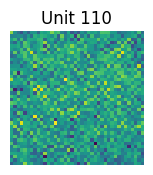

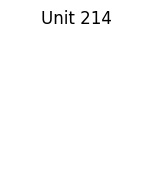

In [13]:
texture_results, non_texture_results = run_var_config(var_mei_config, save="var_01_10_kl_0")

In [69]:
def generate_loc_scale(img_shape, fixed_stddev=False):
    mean = generate_random_noise(img_shape)
    mean = torch.nn.Parameter(torch.tensor(mean, dtype=torch.float32,
                                        device="mps"), requires_grad=True)

    if fixed_stddev:
        std = torch.ones(img_shape).to("mps") * fixed_stddev
    else:
        std = generate_random_noise(img_shape)
        std = torch.nn.Parameter(torch.tensor(std,
                                              dtype=torch.float32,
                                              device="mps"), requires_grad=True)
    return mean, std

def generate_random_noise(shape):
    # generate initial random image
    background_color = np.float32([0] * 1)
    gen_img = np.random.normal(background_color, 1 / 20, shape)
    gen_img = np.clip(gen_img, -1, 1)
    return gen_img

#mean, std = generate_loc_scale((1, 40, 40))
#dist = torch.distributions.Normal(mean, std)

In [70]:
class Mod(torch.nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.mean, self.std = generate_loc_scale(shape, 0.4)
        self.register_parameter("mean", self.mean)
        dist = torch.distributions.Normal(self.mean, self.std)
        self.dist = dist
        self.shape = shape

    def forward(self):
        return self.dist.rsample((10, ))

mode = Mod((1, 40, 40))
x = mode()
computed, distributions = model(x, use_mean=True)

In [71]:
computed["y"].mean(dim=(0,1)).backward()

In [72]:
for param in mode.parameters():
    print(param.grad.data)

tensor([[[ 1.4865e-03, -3.4747e-05,  1.2532e-03,  ...,  5.9912e-04,
          -1.2285e-03, -1.4983e-03],
         [ 9.6990e-05,  4.5404e-04, -9.5801e-04,  ..., -1.3259e-03,
          -2.2809e-05, -1.2062e-03],
         [-1.1489e-03, -6.6992e-05,  4.6958e-04,  ..., -5.6543e-04,
          -1.3017e-03, -1.1611e-03],
         ...,
         [-1.7717e-03, -3.2567e-04,  3.9318e-04,  ...,  6.5127e-04,
           2.6747e-04,  9.7192e-04],
         [-9.8071e-04,  3.7688e-04,  4.1460e-04,  ...,  1.4007e-03,
          -1.4251e-04,  1.9006e-03],
         [ 2.5919e-03,  3.1487e-04,  5.5150e-05,  ...,  2.7616e-04,
           1.5646e-03, -1.3656e-03]]], device='mps:0')


In [17]:
plot(texture_results[0].loss_history)

NameError: name 'plot' is not defined

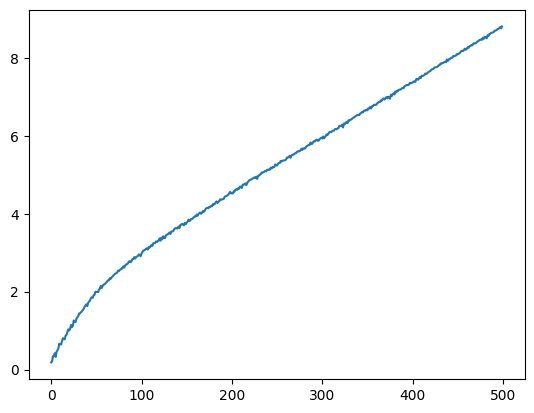

In [18]:
from matplotlib.pyplot import plot
plot(texture_results[0].loss_history)